In [1]:
!pip install scikit-optimize
!pip install catboost

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import statsmodels.stats.api as sms
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Functions

In [4]:
from sklearn import metrics

def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(true, pred):

    mse1 = mse(true, pred)

    rmse1 = rmse(true, pred)

    mae1 = mae(true, pred)

    medae1 = medae(true, pred)

    R21 = R2(true, pred)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse1, rmse1, R21, mae1, medae1))
    print('-'*30)

In [5]:
def target_distr_linear(train_label, test_label, predicted_dv): 
    sns.kdeplot(train_label, label='train')
    sns.kdeplot(test_label, label='test')
    sns.kdeplot(predicted_dv, label='pred')
    plt.legend()
    plt.show()

    sns.scatterplot(test_label, predicted_dv, color='blueviolet')
    plt.title('Linear model')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

In [6]:
from scipy.stats import norm

def draw_histogram(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist);
    plt.xlabel("values")
    plt.title("Distribution") 

    mean=data.mean()

    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()

    plt.show()

In [7]:
def draw_res_analys(errors, pred):
    sns.scatterplot(list(range(len(errors))),errors);
    plt.title("Distibution of errors")
    plt.ylabel('Error');
    plt.xlabel('Index');
    plt.show();

    sns.scatterplot(pred,errors);
    plt.title('Relationship of true value vs error (resudual analysis)')
    plt.ylabel('Error');
    plt.xlabel('True value');
    plt.show();

In [8]:
def get_feature_imp(model, X_train):
    imp = model.get_feature_importance(data=X_train)[:20]
    print(f'IMP: {imp}')
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=model.feature_names_[:20])
    axes.set_title('Finetuned Catboost feature importance')
    plt.show()

# Load df

In [9]:
import pickle

with open('./Okko_ratings_all_content_FULL_kws.pkl', 'rb') as f:
    df = pickle.load(f, encoding='utf-8')

# Preprocessing

1. Multiple value categorical features: tops' tf-idf
    * actor: top 5
    * country: 1st
    * genre: top 3
    * director: 1st 
2. Just categorical 
    * type: ohe
    * release year: periods: 1918-1969, 1970-1979, 1980-1989, ... с 2000 по годам
3. Numeric and categorical ordered
    * age_access: scale
    * avg_rating: knn-imputer, scale
    * duration: scale
4. textual
    * name: catboost.text
5. target:
    * log
    
## Multiple value categorical features: tops' tf-idf

### filter by year

In [10]:
df.shape

(10489, 33859)

In [11]:
d = df[df['release_year'] >= 2000]

In [12]:
d.shape

(8439, 33859)

In [13]:
d.isna().sum()[:30]

age_access_type       0
name                  0
director              0
genre                 0
average_rating      388
type                  0
country               0
release_type          0
release_year          0
duration              0
actor                 0
element_uid           0
ACTOR               159
COMPOSER           1163
DESIGN             1270
DIRECTOR            109
EDITOR             1471
OPERATOR           1246
PRODUCER            371
WRITER              271
BUDGET             5890
MARKETING          8210
RUS                4906
USA                5621
WORLD              4017
element_id            0
rating                0
джек                  0
расследовать          0
подруга               0
dtype: int64

In [14]:
d.columns[:30]

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration', 'actor',
       'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       'WORLD', 'element_id', 'rating', 'джек', 'расследовать', 'подруга'],
      dtype='object')

In [15]:
d.drop(['director', 'average_rating', 'release_type', 'actor', 'element_id'], axis=1, inplace=True)

In [16]:
mltpl_cat_features = ['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'country', 'genre']
num_features = [ 'duration']
cat_features = ['age_access_type']
skewed_num_features = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'WORLD']
mltpl_cat_n_top = {'ACTOR': 10, 'country': 1, 'DIRECTOR': 1, 
                   'EDITOR': 1, 'OPERATOR': 1, 'PRODUCER': 5, 'WRITER': 2,
                   'DESIGN': 3, 'COMPOSER': 1, 'genre': 3}

In [17]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
# from spacy.tokenizer import Tokenizer
# from spacy.lang.en import English
# nlp = English()
import pandas as pd

class Preprocesser:
    def __init__(self, 
                mulpiple_cat_features: list,
                skewed_num_features: list,
               # text_features: list,
               # release_year_feature: str,
                mltpl_cat_n_top: dict):
        self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        #self.text_features = text_features
        self.mltpl_cat_n_top = mltpl_cat_n_top
       # self.release_year_feature = release_year_feature
        # self.tokenizer = Tokenizer(nlp.vocab)
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                if isinstance(names, float):
                    names = ['Na']
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[col] = df_pr[col].apply(lambda x: self.tokenizer(x))
        return df_pr
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
        df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_text_features(df_pr)
        
        return df_pr
        

In [18]:
preprocesser = Preprocesser(mltpl_cat_features,
            skewed_num_features,
            #text_features,
            mltpl_cat_n_top)

In [19]:
df_pr = preprocesser.preprocess(d)

In [20]:
df_pr.shape

(8439, 33872)

In [21]:
df_pr.isnull().sum()[:30]

age_access_type       0
name                  0
type                  0
release_year          0
duration              0
element_uid           0
BUDGET             5890
MARKETING          8210
RUS                4906
USA                5621
WORLD              4017
rating                0
джек                  0
расследовать          0
подруга               0
ограбление            0
катя                  0
макс                  0
мечтать               0
отважный              0
фрэнк                 0
воспитывать           0
супергерой            0
безжалостный          0
маньяк                0
эксцентричный         0
одержимый             0
влюбляться            0
капитан               0
приключение           0
dtype: int64

In [22]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       ...
       'PRODUCER_1', 'PRODUCER_2', 'PRODUCER_3', 'PRODUCER_4', 'WRITER_0',
       'WRITER_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=33872)

In [23]:
df_pr.rename({'ACTOR_0': 'actor_0','ACTOR_1' : 'actor_1', 'ACTOR_2': 'actor_2', 'ACTOR_3':'actor_3',
       'ACTOR_4': 'actor_4', 'ACTOR_5': 'actor_5', 'ACTOR_6': 'actor_6', 'ACTOR_7':'actor_7',
              'ACTOR_8':'actor_8', 'ACTOR_9':'actor_9',
       'COMPOSER_0': 'composer_0', 'DESIGN_0': 'design_0', 'DESIGN_1': 'design_1', 'DESIGN_2': 'design_2',
              'DIRECTOR_0': 'director_0',
       'EDITOR_0': 'editor_0', 'OPERATOR_0': 'operator_0', 'PRODUCER_0': 'producer_0',
              'PRODUCER_1':  'producer_1', 'PRODUCER_2':  'producer_2',
       'PRODUCER_3':  'producer_3', 'PRODUCER_4': 'producer_4', 'WRITER_0':'writer_0', 'WRITER_1': 'writer_1'}, axis=1, inplace=True)

In [24]:
df_pr.rename({'BUDGET': 'budget','MARKETING' : 'marketing', 'RUS': 'rus', 'WORLD':'world'}, axis=1, inplace=True)

In [25]:
cat_features = ['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
                'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
                'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
                'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
                'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
                'genre_1', 'genre_2']

In [26]:
df_pr[cat_features] = df_pr[cat_features].replace(np.nan, 'Na')

In [27]:
# df_pr['average_rating'] = df_pr['average_rating'].astype(float)
df_pr['rating'] = df_pr['rating'].astype(float)
# df_pr['age_access_type'] =df_pr['age_access_type'].astype(int)

In [28]:
df_pr.shape

(8439, 33872)

### target destrib

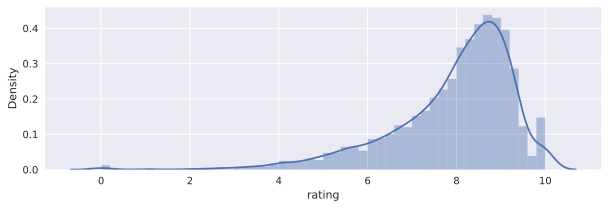

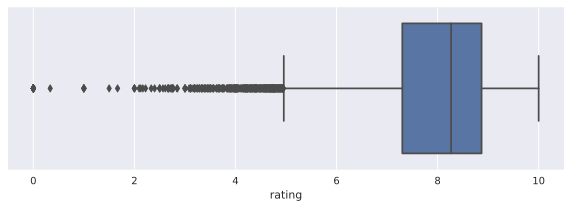

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

plt.figure(figsize=(10, 3))
sns.distplot(df_pr['rating'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(df_pr['rating'], orient='h')
plt.show()

In [30]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'budget', 'marketing', 'rus', 'USA',
       ...
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=33872)

In [31]:
df_pr.shape

(8439, 33872)

## Split

In [32]:
from sklearn.model_selection import train_test_split

sorted_df = df_pr.sort_values('release_year')

test = sorted_df[sorted_df['release_year'] == 2022]
train = sorted_df[sorted_df['release_year'] != 2022]

# for looking at samples
test_df = test.copy(deep=True)
train_df = train.copy(deep=True)

test.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)
train.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)

X_test, y_test = test.drop('rating', axis=1), test['rating']
X, y = train.drop('rating', axis=1), train['rating']
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.1, 
                                                  shuffle=False)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((7458, 33868), (829, 33868), (152, 33868), (7458,), (829,), (152,))

## Get just keywords

In [33]:
X_train_kws = X_train.drop(['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'], axis=1)

X_train_df = X_train[['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2']]

X_val_kws = X_val.drop(['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'], axis=1)

X_val_df = X_val[['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2']]

X_test_kws = X_test.drop(['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'], axis=1)

X_test_df = X_test[['age_access_type', 'type',
                            'duration', 'budget', 'marketing', 'rus',
       'USA', 'world', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
       'actor_4', 'actor_5', 'actor_6',
       'actor_7', 'actor_8', 'actor_9', 'composer_0', 'design_0', 'design_1',
       'design_2', 'director_0', 'editor_0', 'operator_0', 'producer_0',
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2']]


## Standartization

In [34]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_kws = sc.fit_transform(X_train_kws)
X_val_kws = sc.transform(X_val_kws)
X_test_kws = sc.transform(X_test_kws)

## PCA

In [35]:
from sklearn.decomposition import PCA

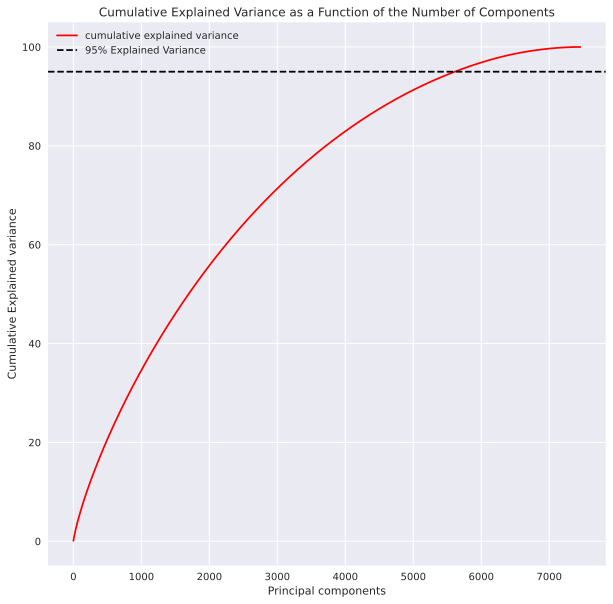

In [45]:
pca = PCA()
pca.fit(X_train_kws)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(10, 10))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

In [46]:
pca.n_components_

7458

In [36]:
pca = PCA(n_components=1000) # 5550

X_train_kws_pca = pca.fit_transform(X_train_kws)
X_val_kws_pca = pca.transform(X_val_kws)
X_test_kws_pca = pca.transform(X_test_kws)

**Convert to dataframe**

In [37]:
component_names = [f"PC{i+1}" for i in range(X_train_kws_pca.shape[1])]
X_train_kws_pca = pd.DataFrame(X_train_kws_pca, columns=component_names)

X_train_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.148153  0.211846  0.856118  0.088898 -0.491562 -0.319855 -0.200468   
1  0.171857  0.218608  0.577646  0.713186  0.629322  0.272266 -0.223986   
2  0.600982  1.011152 -0.406769 -0.095180 -0.190494 -0.497037 -0.065372   
3 -0.716829  0.671064 -0.291107 -1.064547  0.239172 -0.666011 -1.071551   
4  1.341899 -0.545703 -0.395264 -0.063125 -0.081401 -0.503075 -0.379631   

        PC8       PC9      PC10  ...     PC991     PC992     PC993     PC994  \
0  0.509035 -0.053892  0.075977  ... -0.480544  0.308881  0.535066 -2.724601   
1  0.339590 -0.043227  0.012027  ... -2.186243 -0.038225  1.720964 -0.120852   
2 -0.353558 -0.311196 -0.527720  ...  0.124700 -1.474852  0.854834 -1.277041   
3 -0.995026 -0.092262  1.510596  ...  0.756670 -1.104001  0.155958 -0.757106   
4 -0.450961 -0.318737  0.640068  ...  3.451693  1.263022  3.944355  1.481917   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0  1.811940 -0.590139  1.069360 -0.585444  0.797754  0.153951  
1  0.151928 -1.618195 -0.513538  0.800877  0.304623  2.046193  
2 -0.349928  0.907884 -0.185547  0.957293  0.364577 -0.225332  
3 -0.827662  0.826462  0.756975 -0.327430  1.957543 -0.541424  
4  1.557157 -3.142000  0.518009  2.281473 -3.245144 -6.927100  

[5 rows x 1000 columns]

In [38]:
X_train_df = X_train_df.reset_index().drop('index', axis=1)
X_train = X_train_df.join(X_train_kws_pca, on=X_train_df.index)

X_train.head()

age_access_type    type   duration     budget  marketing        rus  \
0               18   MOVIE  15.957927  13.710151        NaN   9.741145   
1               16  SERIAL  17.622173        NaN        NaN        NaN   
2               18   MOVIE  15.992533  17.686712        NaN        NaN   
3               16   MOVIE  15.665539  18.246327        NaN        NaN   
4               12   MOVIE  15.846287  18.315320  17.103912  14.166168   

           USA      world           actor_0            actor_1  ...     PC991  \
0    2500000.0  14.738279     Вера Алентова    Ирина Муравьёва  ... -0.480544   
1          NaN        NaN  Валерий Николаев   Ирина Апексимова  ... -2.186243   
2  124115725.0  19.150718      Майкл Дуглас  Бенисио Дель Торо  ...  0.124700   
3  123309890.0  18.929544        Эдди Мерфи     Джанет Джексон  ...  0.756670   
4  101648571.0  19.284424     Николас Кейдж    Анджелина Джоли  ...  3.451693   

      PC992     PC993     PC994     PC995     PC996     PC997     PC998  \
0  0.308881  0.535066 -2.724601  1.811940 -0.590139  1.069360 -0.585444   
1 -0.038225  1.720964 -0.120852  0.151928 -1.618195 -0.513538  0.800877   
2 -1.474852  0.854834 -1.277041 -0.349928  0.907884 -0.185547  0.957293   
3 -1.104001  0.155958 -0.757106 -0.827662  0.826462  0.756975 -0.327430   
4  1.263022  3.944355  1.481917  1.557157 -3.142000  0.518009  2.281473   

      PC999    PC1000  
0  0.797754  0.153951  
1  0.304623  2.046193  
2  0.364577 -0.225332  
3  1.957543 -0.541424  
4 -3.245144 -6.927100  

[5 rows x 1036 columns]

In [39]:
component_names = [f"PC{i+1}" for i in range(X_val_kws_pca.shape[1])]
X_val_kws_pca = pd.DataFrame(X_val_kws_pca, columns=component_names)

X_val_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.326478 -0.216274 -0.489385 -0.270915 -0.150564  0.040547 -0.011930   
1 -0.090664  3.123955 -0.873491 -0.405395 -0.152075 -0.573454 -0.822162   
2  0.046174 -0.003927 -0.010522  0.228234  0.134610 -0.183978 -0.211854   
3 -0.385069 -0.249731  0.275417 -0.281997  0.025265 -0.238437 -0.377118   
4 -0.438355 -0.328581 -0.439398 -0.120901 -0.143364 -0.088352 -0.351345   

        PC8       PC9      PC10  ...     PC991     PC992     PC993     PC994  \
0  0.068456 -0.272404 -0.356330  ...  0.784276 -0.572378 -0.193523 -0.313267   
1 -0.652484  0.038126  0.124118  ... -0.179058  0.900098  1.063709  0.676532   
2  0.307865  0.035879 -0.088407  ... -0.328912  0.533420 -0.628811  0.041634   
3 -0.343593 -0.300160  0.106812  ...  0.369611  0.360515  0.242390  0.129688   
4 -0.394452 -0.023626 -0.277145  ...  1.039381 -0.170185 -0.386971 -0.267005   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0 -0.393733  0.513930  0.435733  0.721801  0.151740  0.428089  
1  0.028804 -0.441622  0.932776 -0.012733 -0.021111 -0.057946  
2 -1.434902 -0.002286 -0.764673 -0.013598 -0.658698  0.191732  
3  0.102710  0.964798 -0.848166 -0.366847 -0.244028  0.153114  
4 -0.229690 -0.065241 -1.190755 -0.163313  0.078163  0.040975  

[5 rows x 1000 columns]

In [40]:
X_val_df = X_val_df.reset_index().drop('index', axis=1)
X_val = X_val_df.join(X_val_kws_pca, on=X_val_df.index)

X_val.head()

age_access_type   type   duration     budget  marketing        rus  USA  \
0               16  MOVIE  15.806121        NaN        NaN   9.076123  NaN   
1               12  MOVIE  15.545395        NaN        NaN  12.038387  NaN   
2               12  MOVIE  15.587067        NaN        NaN  11.367807  NaN   
3               18  MOVIE  15.684231  15.761421        NaN        NaN  NaN   
4               16  MOVIE  15.617221        NaN        NaN        NaN  NaN   

       world      actor_0           actor_1  ...     PC991     PC992  \
0  12.746695  Дэниэл Юинг  Темуэра Моррисон  ...  0.784276 -0.572378   
1  14.488074  Кая Киёхара    Таиси Накагава  ... -0.179058  0.900098   
2        NaN  Фёдор Лещев   Ефим Каменецкий  ... -0.328912  0.533420   
3  15.708593    Юн Ге-сан          Пак Ён-у  ...  0.369611  0.360515   
4        NaN   Фиона Грэм      Люк Робинсон  ...  1.039381 -0.170185   

      PC993     PC994     PC995     PC996     PC997     PC998     PC999  \
0 -0.193523 -0.313267 -0.393733  0.513930  0.435733  0.721801  0.151740   
1  1.063709  0.676532  0.028804 -0.441622  0.932776 -0.012733 -0.021111   
2 -0.628811  0.041634 -1.434902 -0.002286 -0.764673 -0.013598 -0.658698   
3  0.242390  0.129688  0.102710  0.964798 -0.848166 -0.366847 -0.244028   
4 -0.386971 -0.267005 -0.229690 -0.065241 -1.190755 -0.163313  0.078163   

     PC1000  
0  0.428089  
1 -0.057946  
2  0.191732  
3  0.153114  
4  0.040975  

[5 rows x 1036 columns]

In [41]:
component_names = [f"PC{i+1}" for i in range(X_test_kws_pca.shape[1])]
X_test_kws_pca = pd.DataFrame(X_test_kws_pca, columns=component_names)

X_test_kws_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.404342  0.850011 -0.416904  0.201923  0.223799 -0.145722 -0.399173   
1  1.228677 -0.431788 -0.630982 -0.273479 -0.043896 -0.080561  0.265001   
2 -0.031980 -0.289579 -0.366617  0.001883 -0.042148 -0.394599 -0.097086   
3  1.391644 -0.220760  0.000403 -0.375076  0.155707 -0.386096 -0.374543   
4 -0.299468 -0.263828 -0.537637 -0.017470  0.124288 -0.406745 -0.159070   

        PC8       PC9      PC10  ...     PC991     PC992     PC993     PC994  \
0 -0.481608 -0.265311 -0.238566  ... -0.433179  0.864305  0.182292  0.333285   
1 -0.147906 -0.167943 -0.157870  ...  0.512700 -0.485079  1.069283 -0.152443   
2 -0.124924 -0.042685 -0.294325  ... -0.420837 -0.167253  0.379975 -0.208947   
3 -0.411368 -0.188478 -0.069836  ...  0.324516  0.253098 -1.191794  0.470063   
4 -0.283332 -0.234147 -0.226968  ... -1.046892 -1.019604  1.095980  0.444984   

      PC995     PC996     PC997     PC998     PC999    PC1000  
0  0.452528 -0.201884 -0.406743  0.382482 -0.000799  1.708158  
1  0.582257  0.701693 -0.102170 -1.229002 -0.827704  0.585576  
2  0.427324  0.171217 -0.146171 -0.102146  0.110854 -0.197958  
3  0.880336 -0.186929 -0.901428 -0.291785  0.216418  1.020856  
4 -0.422100 -0.040294 -0.227407 -0.451803 -0.101940 -0.144619  

[5 rows x 1000 columns]

In [42]:
X_test_df = X_test_df.reset_index().drop('index', axis=1)
X_test = X_test_df.join(X_test_kws_pca, on=X_test_df.index)

X_test.head()

age_access_type    type   duration  budget  marketing  rus  USA  world  \
0               18  SERIAL  16.200597     NaN        NaN  NaN  NaN    NaN   
1                6   MOVIE  15.534700     NaN        NaN  NaN  NaN    NaN   
2               18  SERIAL  17.044733     NaN        NaN  NaN  NaN    NaN   
3               18  SERIAL  16.751493     NaN        NaN  NaN  NaN    NaN   
4               16   MOVIE  15.555977     NaN        NaN  NaN  NaN    NaN   

             actor_0            actor_1  ...     PC991     PC992     PC993  \
0            Аюми Ру    Ханане Эль Юсфи  ... -0.433179  0.864305  0.182292   
1         Майкл Сера  Сэмюэл Л. Джексон  ...  0.512700 -0.485079  1.069283   
2   Виттория Пуччини    Алессандро Ройа  ... -0.420837 -0.167253  0.379975   
3    Максим Сапрыкин   Валентина Ляпина  ...  0.324516  0.253098 -1.191794   
4  Хиро Файнс-Тиффин          Сидни Пак  ... -1.046892 -1.019604  1.095980   

      PC994     PC995     PC996     PC997     PC998     PC999    PC1000  
0  0.333285  0.452528 -0.201884 -0.406743  0.382482 -0.000799  1.708158  
1 -0.152443  0.582257  0.701693 -0.102170 -1.229002 -0.827704  0.585576  
2 -0.208947  0.427324  0.171217 -0.146171 -0.102146  0.110854 -0.197958  
3  0.470063  0.880336 -0.186929 -0.901428 -0.291785  0.216418  1.020856  
4  0.444984 -0.422100 -0.040294 -0.227407 -0.451803 -0.101940 -0.144619  

[5 rows x 1036 columns]

### Model

In [43]:
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint

In [44]:
train_dataset = cat.Pool(data=X_train,
                        label=y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(data=X_test, 
                        label=y_test,
                         cat_features=cat_features)

val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=500,
    verbose=100,
    plot=False
)

Learning rate set to 0.069807
0:	learn: 1.0050464	test: 1.1388717	best: 1.1388717 (0)	total: 149ms	remaining: 2m 29s
100:	learn: 0.7093580	test: 0.9017493	best: 0.9017493 (100)	total: 7.68s	remaining: 1m 8s
200:	learn: 0.6353929	test: 0.8915729	best: 0.8909666 (196)	total: 15s	remaining: 59.7s
300:	learn: 0.5679084	test: 0.8888349	best: 0.8877978 (274)	total: 22.4s	remaining: 51.9s
400:	learn: 0.5057094	test: 0.8880003	best: 0.8866466 (394)	total: 29.6s	remaining: 44.3s
500:	learn: 0.4501962	test: 0.8849734	best: 0.8843112 (492)	total: 37s	remaining: 36.8s
600:	learn: 0.4024901	test: 0.8847219	best: 0.8831047 (594)	total: 44.2s	remaining: 29.3s
700:	learn: 0.3657201	test: 0.8878512	best: 0.8831047 (594)	total: 51.3s	remaining: 21.9s
800:	learn: 0.3302092	test: 0.8891193	best: 0.8831047 (594)	total: 58.4s	remaining: 14.5s
900:	learn: 0.2998384	test: 0.8898929	best: 0.8831047 (594)	total: 1m 5s	remaining: 7.2s
999:	learn: 0.2715352	test: 0.8902356	best: 0.8831047 (594)	total: 1m 12s	rema

In [45]:
y_pred = cat_model.predict(test_dataset)

In [46]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.0808661919977787
RMSE:  1.039647147833234
R2:    0.4860240473628713
MAE:   0.7837658327732626
MedAE: 0.6209978776184206
------------------------------


In [47]:
cat_model.save_model('DEMO_okko_ratings_pred_pca')

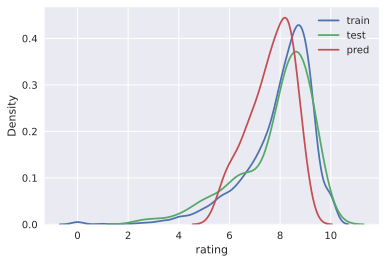

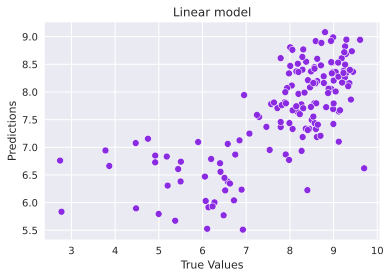

In [48]:
target_distr_linear(y_train, y_test, y_pred)   

IMP: [3.21382991 1.67734822 4.86692392 0.13699866 0.01277576 0.23179181
 0.67914561 5.23456292 0.50807374 0.         0.10586287 0.
 0.         0.         0.         0.         0.         1.31232087
 1.56758971 0.        ]


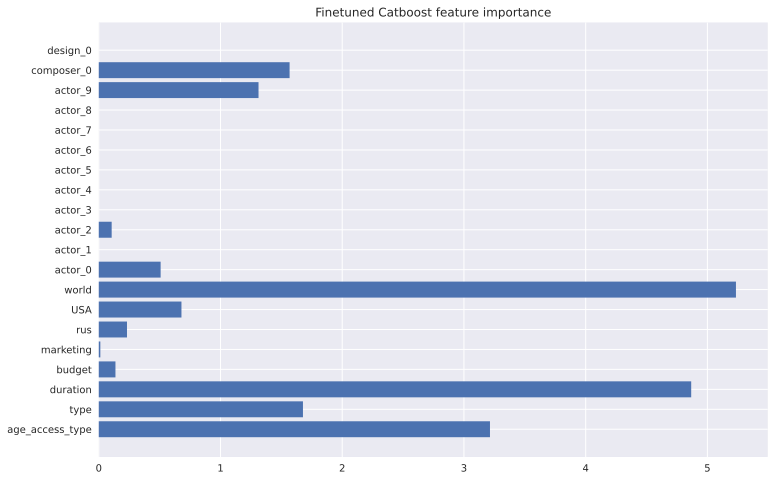

In [49]:
get_feature_imp(cat_model, train_dataset)

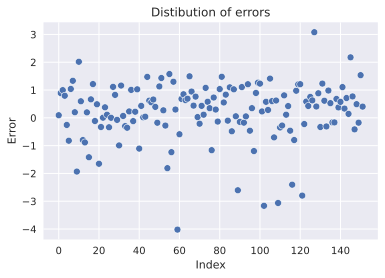

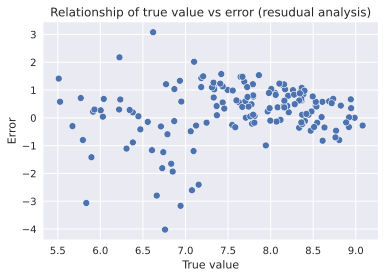

In [50]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

### LOOKING AT TEST

In [51]:
test_df['PREDS'] = y_pred.tolist()
test_df['TARGET'] = y_test.tolist()
test_df

age_access_type                                           name    type  \
10457               18                               Бесконечная ночь  SERIAL   
13                   6                      Пес-самурай и город кошек   MOVIE   
10400               18                               Не оставляй меня  SERIAL   
10399               18                                           Жиза  SERIAL   
4421                16                                  Первая любовь   MOVIE   
...                ...                                            ...     ...   
4630                16                                  Взрывная игра   MOVIE   
10322               18                       На взводе: Битва за UBER  SERIAL   
7698                12                                  Тайна амулета   MOVIE   
10302               18  Власть в ночном городе. Книга четвертая: Сила  SERIAL   
10488                6                                 Истоки футбола  SERIAL   

       release_year   duration                           element_uid  budget  \
10457          2022  16.200597  952bfe32-7504-4ef5-af22-985379d8637f     NaN   
13             2022  15.534700  537ece24-2358-4108-a419-85cfd5952607     NaN   
10400          2022  17.044733  00de4f79-d52d-4d2c-871c-e6e8432cc3df     NaN   
10399          2022  16.751493  4a0406af-66ee-4180-a292-8d3b011b9938     NaN   
4421           2022  15.555977  db683fae-f747-4905-a132-38b4207f82fa     NaN   
...             ...        ...                                   ...     ...   
4630           2022  15.545395  4292d0f1-fbfb-4b4d-8c7c-d54b4b0ef6eb     NaN   
10322          2022  16.064695  fecde143-2a72-4a70-8efc-188079a62f1a     NaN   
7698           2022  15.545395  9ae35927-93e3-4a40-870f-a998abbeaa9f     NaN   
10302          2022  16.495161  2fe0e352-1706-4e22-89d2-745353650492     NaN   
10488          2022  17.518293  6dd86e60-5d6d-475d-9b46-e989ac7a30b6     NaN   

       marketing        rus  USA  ...       producer_3         producer_4  \
10457        NaN        NaN  NaN  ...     Лайонел Юзан         Лоран Анон   
13           NaN        NaN  NaN  ...        Яр Ландау          Адам Нэгл   
10400        NaN        NaN  NaN  ...               Na                 Na   
10399        NaN        NaN  NaN  ...  Евгений Айвазян  Дмитрий Агневский   
4421         NaN        NaN  NaN  ...   Генри Киттридж  Чарльз Артур Берг   
...          ...        ...  ...  ...              ...                ...   
4630         NaN        NaN  NaN  ...     Джордж Фурла        Гари Раскин   
10322        NaN        NaN  NaN  ...         Пол Шифф        Стивен Шифф   
7698         NaN  12.057422  NaN  ...               Na                 Na   
10302        NaN        NaN  NaN  ...     Роберт Мунич       Эль Трайдман   
10488        NaN        NaN  NaN  ...               Na                 Na   

                writer_0           writer_1  country_0  \
10457        Давид Перро   Эммануэль Вуазен    belgium   
13     Роберт Бен Гарант        Нэйт Хоппер        usa   
10400    Леонардо Фазоли  Маддалена Равальи      italy   
10399   Александр Пронин                 Na     russia   
4421       А.Дж. Эдвардс                 Na        usa   
...                  ...                ...        ...   
4630       Леон Лангфорд       Коллин Уоттс        usa   
10322  Брайан Коппельман        Дэвид Левин        usa   
7698   Ксения Набойченко       Ирина Демина     russia   
10302         Аарон Карю        Кортни Кемп        usa   
10488           Ши Чуань                 Na      china   

                                    genre_0  \
10457  9fa28b61-a257-4a3e-945b-a9ef76a146d6   
13                                   Action   
10400  364fdc2e-bdfe-40be-b2c5-d30f43ec432e   
10399                                 Drama   
4421                              Melodrama   
...                                     ...   
4630                               Thriller   
10322                                 Drama   
7698                        

# Tuning

In [52]:
train_dataset = cat.Pool(X_train, 
                         y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(X_test, 
                        y_test,
                        cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

In [53]:
parameters_distr = {'depth': randint(3, 7),
              'learning_rate': uniform(0.01, 0.1),
              'iterations': [100, 1000, 5000]
             }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, 
                            cv=5,
#                           n_jobs=-1, 
                          verbose=3)

grid.fit(X_train, y_train)

import pickle
with open('bestimator_ratings_kinop_pred_pca', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)
grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 1.0506682	total: 28.2ms	remaining: 2.79s
1:	learn: 1.0415923	total: 61ms	remaining: 2.99s
2:	learn: 1.0328038	total: 90.5ms	remaining: 2.93s
3:	learn: 1.0252525	total: 120ms	remaining: 2.88s
4:	learn: 1.0177023	total: 150ms	remaining: 2.84s
5:	learn: 1.0101901	total: 180ms	remaining: 2.81s
6:	learn: 1.0031693	total: 209ms	remaining: 2.77s
7:	learn: 0.9957298	total: 239ms	remaining: 2.75s
8:	learn: 0.9884285	total: 271ms	remaining: 2.74s
9:	learn: 0.9817313	total: 300ms	remaining: 2.7s
10:	learn: 0.9767838	total: 330ms	remaining: 2.67s
11:	learn: 0.9708687	total: 360ms	remaining: 2.64s
12:	learn: 0.9655286	total: 391ms	remaining: 2.61s
13:	learn: 0.9609612	total: 421ms	remaining: 2.58s
14:	learn: 0.9563810	total: 456ms	remaining: 2.58s
15:	learn: 0.9511634	total: 486ms	remaining: 2.55s
16:	learn: 0.9462435	total: 516ms	remaining: 2.52s
17:	learn: 0.9416234	total: 545ms	remaining: 2.48s
18:	learn: 0.9382303	total: 576

63:	learn: 0.8221701	total: 1.92s	remaining: 1.08s
64:	learn: 0.8211949	total: 1.95s	remaining: 1.05s
65:	learn: 0.8200711	total: 1.98s	remaining: 1.02s
66:	learn: 0.8190380	total: 2s	remaining: 988ms
67:	learn: 0.8179929	total: 2.04s	remaining: 958ms
68:	learn: 0.8171276	total: 2.07s	remaining: 928ms
69:	learn: 0.8157987	total: 2.1s	remaining: 899ms
70:	learn: 0.8144448	total: 2.13s	remaining: 869ms
71:	learn: 0.8138238	total: 2.16s	remaining: 839ms
72:	learn: 0.8125859	total: 2.19s	remaining: 809ms
73:	learn: 0.8115041	total: 2.22s	remaining: 779ms
74:	learn: 0.8105798	total: 2.25s	remaining: 749ms
75:	learn: 0.8100396	total: 2.27s	remaining: 719ms
76:	learn: 0.8093477	total: 2.3s	remaining: 688ms
77:	learn: 0.8082285	total: 2.33s	remaining: 658ms
78:	learn: 0.8069611	total: 2.36s	remaining: 628ms
79:	learn: 0.8058385	total: 2.39s	remaining: 598ms
80:	learn: 0.8047980	total: 2.42s	remaining: 568ms
81:	learn: 0.8041763	total: 2.45s	remaining: 538ms
82:	learn: 0.8030494	total: 2.48s	re

21:	learn: 0.8788283	total: 682ms	remaining: 2.42s
22:	learn: 0.8760207	total: 712ms	remaining: 2.38s
23:	learn: 0.8729754	total: 742ms	remaining: 2.35s
24:	learn: 0.8696209	total: 773ms	remaining: 2.32s
25:	learn: 0.8671555	total: 802ms	remaining: 2.28s
26:	learn: 0.8636015	total: 833ms	remaining: 2.25s
27:	learn: 0.8607775	total: 862ms	remaining: 2.21s
28:	learn: 0.8583059	total: 892ms	remaining: 2.18s
29:	learn: 0.8566254	total: 921ms	remaining: 2.15s
30:	learn: 0.8546335	total: 951ms	remaining: 2.12s
31:	learn: 0.8520200	total: 980ms	remaining: 2.08s
32:	learn: 0.8504793	total: 1.01s	remaining: 2.05s
33:	learn: 0.8479393	total: 1.04s	remaining: 2.02s
34:	learn: 0.8456246	total: 1.07s	remaining: 1.98s
35:	learn: 0.8427555	total: 1.1s	remaining: 1.95s
36:	learn: 0.8405605	total: 1.13s	remaining: 1.92s
37:	learn: 0.8390012	total: 1.16s	remaining: 1.88s
38:	learn: 0.8361139	total: 1.18s	remaining: 1.85s
39:	learn: 0.8339000	total: 1.22s	remaining: 1.82s
40:	learn: 0.8317236	total: 1.24

84:	learn: 0.7721504	total: 2.55s	remaining: 450ms
85:	learn: 0.7712706	total: 2.58s	remaining: 420ms
86:	learn: 0.7705545	total: 2.61s	remaining: 390ms
87:	learn: 0.7695391	total: 2.64s	remaining: 360ms
88:	learn: 0.7690311	total: 2.67s	remaining: 330ms
89:	learn: 0.7680324	total: 2.7s	remaining: 300ms
90:	learn: 0.7674988	total: 2.73s	remaining: 270ms
91:	learn: 0.7669302	total: 2.76s	remaining: 240ms
92:	learn: 0.7663687	total: 2.79s	remaining: 210ms
93:	learn: 0.7658078	total: 2.82s	remaining: 180ms
94:	learn: 0.7653561	total: 2.85s	remaining: 150ms
95:	learn: 0.7647710	total: 2.87s	remaining: 120ms
96:	learn: 0.7642096	total: 2.9s	remaining: 89.8ms
97:	learn: 0.7636472	total: 2.93s	remaining: 59.9ms
98:	learn: 0.7631791	total: 2.96s	remaining: 29.9ms
99:	learn: 0.7627094	total: 2.99s	remaining: 0us
[CV 5/5] END depth=5, iterations=100, learning_rate=0.028040499720199896;, score=0.291 total time=   3.3s
0:	learn: 1.0546700	total: 52.4ms	remaining: 52.4s
1:	learn: 1.0491032	total: 1

145:	learn: 0.7995881	total: 6.84s	remaining: 40s
146:	learn: 0.7990719	total: 6.88s	remaining: 39.9s
147:	learn: 0.7986725	total: 6.93s	remaining: 39.9s
148:	learn: 0.7983825	total: 6.97s	remaining: 39.8s
149:	learn: 0.7979300	total: 7.02s	remaining: 39.8s
150:	learn: 0.7975366	total: 7.06s	remaining: 39.7s
151:	learn: 0.7971654	total: 7.11s	remaining: 39.7s
152:	learn: 0.7966998	total: 7.16s	remaining: 39.6s
153:	learn: 0.7962407	total: 7.2s	remaining: 39.6s
154:	learn: 0.7959538	total: 7.25s	remaining: 39.5s
155:	learn: 0.7954941	total: 7.29s	remaining: 39.5s
156:	learn: 0.7949908	total: 7.34s	remaining: 39.4s
157:	learn: 0.7944901	total: 7.39s	remaining: 39.4s
158:	learn: 0.7940576	total: 7.44s	remaining: 39.4s
159:	learn: 0.7936165	total: 7.49s	remaining: 39.3s
160:	learn: 0.7931563	total: 7.53s	remaining: 39.3s
161:	learn: 0.7927107	total: 7.58s	remaining: 39.2s
162:	learn: 0.7923911	total: 7.63s	remaining: 39.2s
163:	learn: 0.7917716	total: 7.67s	remaining: 39.1s
164:	learn: 0.7

304:	learn: 0.7588057	total: 14.3s	remaining: 32.6s
305:	learn: 0.7586035	total: 14.4s	remaining: 32.6s
306:	learn: 0.7584229	total: 14.4s	remaining: 32.5s
307:	learn: 0.7582297	total: 14.5s	remaining: 32.5s
308:	learn: 0.7579889	total: 14.5s	remaining: 32.4s
309:	learn: 0.7579074	total: 14.5s	remaining: 32.4s
310:	learn: 0.7577347	total: 14.6s	remaining: 32.3s
311:	learn: 0.7575423	total: 14.6s	remaining: 32.3s
312:	learn: 0.7572854	total: 14.7s	remaining: 32.2s
313:	learn: 0.7572424	total: 14.7s	remaining: 32.2s
314:	learn: 0.7570871	total: 14.8s	remaining: 32.2s
315:	learn: 0.7568888	total: 14.8s	remaining: 32.1s
316:	learn: 0.7568259	total: 14.9s	remaining: 32.1s
317:	learn: 0.7567180	total: 14.9s	remaining: 32s
318:	learn: 0.7565740	total: 15s	remaining: 32s
319:	learn: 0.7564084	total: 15s	remaining: 31.9s
320:	learn: 0.7561745	total: 15.1s	remaining: 31.9s
321:	learn: 0.7559430	total: 15.1s	remaining: 31.8s
322:	learn: 0.7558039	total: 15.2s	remaining: 31.8s
323:	learn: 0.755587

464:	learn: 0.7335677	total: 21.8s	remaining: 25.1s
465:	learn: 0.7334690	total: 21.9s	remaining: 25.1s
466:	learn: 0.7333039	total: 21.9s	remaining: 25s
467:	learn: 0.7331519	total: 22s	remaining: 25s
468:	learn: 0.7328950	total: 22s	remaining: 24.9s
469:	learn: 0.7328739	total: 22.1s	remaining: 24.9s
470:	learn: 0.7327433	total: 22.1s	remaining: 24.8s
471:	learn: 0.7326036	total: 22.1s	remaining: 24.8s
472:	learn: 0.7324070	total: 22.2s	remaining: 24.7s
473:	learn: 0.7322521	total: 22.2s	remaining: 24.7s
474:	learn: 0.7321323	total: 22.3s	remaining: 24.6s
475:	learn: 0.7319954	total: 22.3s	remaining: 24.6s
476:	learn: 0.7317874	total: 22.4s	remaining: 24.5s
477:	learn: 0.7316659	total: 22.4s	remaining: 24.5s
478:	learn: 0.7314456	total: 22.5s	remaining: 24.4s
479:	learn: 0.7312778	total: 22.5s	remaining: 24.4s
480:	learn: 0.7311714	total: 22.6s	remaining: 24.4s
481:	learn: 0.7309722	total: 22.6s	remaining: 24.3s
482:	learn: 0.7307908	total: 22.7s	remaining: 24.3s
483:	learn: 0.730596

624:	learn: 0.7116145	total: 29.3s	remaining: 17.6s
625:	learn: 0.7114762	total: 29.3s	remaining: 17.5s
626:	learn: 0.7114631	total: 29.3s	remaining: 17.5s
627:	learn: 0.7112803	total: 29.4s	remaining: 17.4s
628:	learn: 0.7111526	total: 29.4s	remaining: 17.4s
629:	learn: 0.7109563	total: 29.5s	remaining: 17.3s
630:	learn: 0.7107916	total: 29.5s	remaining: 17.3s
631:	learn: 0.7107906	total: 29.6s	remaining: 17.2s
632:	learn: 0.7106165	total: 29.6s	remaining: 17.2s
633:	learn: 0.7106159	total: 29.7s	remaining: 17.1s
634:	learn: 0.7105045	total: 29.7s	remaining: 17.1s
635:	learn: 0.7102538	total: 29.8s	remaining: 17s
636:	learn: 0.7100597	total: 29.8s	remaining: 17s
637:	learn: 0.7098294	total: 29.8s	remaining: 16.9s
638:	learn: 0.7095968	total: 29.9s	remaining: 16.9s
639:	learn: 0.7094016	total: 29.9s	remaining: 16.8s
640:	learn: 0.7092910	total: 30s	remaining: 16.8s
641:	learn: 0.7091642	total: 30s	remaining: 16.7s
642:	learn: 0.7091649	total: 30.1s	remaining: 16.7s
643:	learn: 0.709010

784:	learn: 0.6912903	total: 36.6s	remaining: 10s
785:	learn: 0.6912908	total: 36.6s	remaining: 9.96s
786:	learn: 0.6912902	total: 36.6s	remaining: 9.92s
787:	learn: 0.6911202	total: 36.7s	remaining: 9.87s
788:	learn: 0.6909971	total: 36.7s	remaining: 9.82s
789:	learn: 0.6907934	total: 36.8s	remaining: 9.78s
790:	learn: 0.6906480	total: 36.8s	remaining: 9.73s
791:	learn: 0.6904110	total: 36.9s	remaining: 9.68s
792:	learn: 0.6904108	total: 36.9s	remaining: 9.64s
793:	learn: 0.6904106	total: 37s	remaining: 9.59s
794:	learn: 0.6903419	total: 37s	remaining: 9.54s
795:	learn: 0.6901159	total: 37.1s	remaining: 9.5s
796:	learn: 0.6899651	total: 37.1s	remaining: 9.45s
797:	learn: 0.6899655	total: 37.1s	remaining: 9.4s
798:	learn: 0.6899653	total: 37.2s	remaining: 9.36s
799:	learn: 0.6898497	total: 37.2s	remaining: 9.31s
800:	learn: 0.6898478	total: 37.3s	remaining: 9.26s
801:	learn: 0.6896310	total: 37.3s	remaining: 9.21s
802:	learn: 0.6893968	total: 37.4s	remaining: 9.17s
803:	learn: 0.689176

944:	learn: 0.6692375	total: 43.9s	remaining: 2.55s
945:	learn: 0.6690287	total: 43.9s	remaining: 2.51s
946:	learn: 0.6688260	total: 44s	remaining: 2.46s
947:	learn: 0.6687123	total: 44s	remaining: 2.42s
948:	learn: 0.6686433	total: 44.1s	remaining: 2.37s
949:	learn: 0.6684849	total: 44.1s	remaining: 2.32s
950:	learn: 0.6683304	total: 44.2s	remaining: 2.28s
951:	learn: 0.6682059	total: 44.2s	remaining: 2.23s
952:	learn: 0.6680589	total: 44.3s	remaining: 2.18s
953:	learn: 0.6678838	total: 44.3s	remaining: 2.14s
954:	learn: 0.6676982	total: 44.4s	remaining: 2.09s
955:	learn: 0.6675114	total: 44.4s	remaining: 2.04s
956:	learn: 0.6672713	total: 44.5s	remaining: 2s
957:	learn: 0.6670466	total: 44.5s	remaining: 1.95s
958:	learn: 0.6669061	total: 44.5s	remaining: 1.9s
959:	learn: 0.6666872	total: 44.6s	remaining: 1.86s
960:	learn: 0.6664878	total: 44.6s	remaining: 1.81s
961:	learn: 0.6662687	total: 44.7s	remaining: 1.76s
962:	learn: 0.6660499	total: 44.7s	remaining: 1.72s
963:	learn: 0.665870

105:	learn: 0.8137237	total: 4.95s	remaining: 41.8s
106:	learn: 0.8132376	total: 5s	remaining: 41.7s
107:	learn: 0.8122737	total: 5.04s	remaining: 41.7s
108:	learn: 0.8116067	total: 5.09s	remaining: 41.6s
109:	learn: 0.8110189	total: 5.14s	remaining: 41.6s
110:	learn: 0.8103133	total: 5.18s	remaining: 41.5s
111:	learn: 0.8092365	total: 5.23s	remaining: 41.5s
112:	learn: 0.8085016	total: 5.28s	remaining: 41.4s
113:	learn: 0.8078472	total: 5.33s	remaining: 41.4s
114:	learn: 0.8074373	total: 5.37s	remaining: 41.4s
115:	learn: 0.8067200	total: 5.42s	remaining: 41.3s
116:	learn: 0.8061165	total: 5.47s	remaining: 41.3s
117:	learn: 0.8055512	total: 5.51s	remaining: 41.2s
118:	learn: 0.8048076	total: 5.56s	remaining: 41.2s
119:	learn: 0.8043328	total: 5.61s	remaining: 41.1s
120:	learn: 0.8039273	total: 5.65s	remaining: 41.1s
121:	learn: 0.8030802	total: 5.7s	remaining: 41s
122:	learn: 0.8024734	total: 5.75s	remaining: 41s
123:	learn: 0.8018384	total: 5.79s	remaining: 40.9s
124:	learn: 0.801348

265:	learn: 0.7545956	total: 12.4s	remaining: 34.2s
266:	learn: 0.7543671	total: 12.4s	remaining: 34.2s
267:	learn: 0.7543238	total: 12.5s	remaining: 34.1s
268:	learn: 0.7541919	total: 12.5s	remaining: 34.1s
269:	learn: 0.7539924	total: 12.6s	remaining: 34s
270:	learn: 0.7538785	total: 12.6s	remaining: 34s
271:	learn: 0.7537065	total: 12.7s	remaining: 33.9s
272:	learn: 0.7534770	total: 12.7s	remaining: 33.9s
273:	learn: 0.7532806	total: 12.8s	remaining: 33.8s
274:	learn: 0.7530761	total: 12.8s	remaining: 33.8s
275:	learn: 0.7528867	total: 12.9s	remaining: 33.7s
276:	learn: 0.7528209	total: 12.9s	remaining: 33.7s
277:	learn: 0.7526079	total: 12.9s	remaining: 33.6s
278:	learn: 0.7523871	total: 13s	remaining: 33.6s
279:	learn: 0.7522115	total: 13s	remaining: 33.5s
280:	learn: 0.7519679	total: 13.1s	remaining: 33.5s
281:	learn: 0.7516007	total: 13.1s	remaining: 33.5s
282:	learn: 0.7513516	total: 13.2s	remaining: 33.4s
283:	learn: 0.7510889	total: 13.2s	remaining: 33.4s
284:	learn: 0.750883

424:	learn: 0.7282634	total: 19.8s	remaining: 26.8s
425:	learn: 0.7281448	total: 19.9s	remaining: 26.8s
426:	learn: 0.7280254	total: 19.9s	remaining: 26.7s
427:	learn: 0.7278995	total: 20s	remaining: 26.7s
428:	learn: 0.7277558	total: 20s	remaining: 26.7s
429:	learn: 0.7275374	total: 20.1s	remaining: 26.6s
430:	learn: 0.7274159	total: 20.1s	remaining: 26.6s
431:	learn: 0.7273002	total: 20.2s	remaining: 26.5s
432:	learn: 0.7272079	total: 20.2s	remaining: 26.5s
433:	learn: 0.7270781	total: 20.3s	remaining: 26.4s
434:	learn: 0.7269444	total: 20.3s	remaining: 26.4s
435:	learn: 0.7268204	total: 20.3s	remaining: 26.3s
436:	learn: 0.7266680	total: 20.4s	remaining: 26.3s
437:	learn: 0.7266068	total: 20.4s	remaining: 26.2s
438:	learn: 0.7264971	total: 20.5s	remaining: 26.2s
439:	learn: 0.7264310	total: 20.5s	remaining: 26.1s
440:	learn: 0.7263018	total: 20.6s	remaining: 26.1s
441:	learn: 0.7262044	total: 20.6s	remaining: 26s
442:	learn: 0.7260658	total: 20.7s	remaining: 26s
443:	learn: 0.725993

584:	learn: 0.7065120	total: 27.2s	remaining: 19.3s
585:	learn: 0.7063824	total: 27.3s	remaining: 19.3s
586:	learn: 0.7060744	total: 27.3s	remaining: 19.2s
587:	learn: 0.7059597	total: 27.3s	remaining: 19.2s
588:	learn: 0.7057602	total: 27.4s	remaining: 19.1s
589:	learn: 0.7057050	total: 27.4s	remaining: 19.1s
590:	learn: 0.7055485	total: 27.5s	remaining: 19s
591:	learn: 0.7053627	total: 27.5s	remaining: 19s
592:	learn: 0.7051935	total: 27.6s	remaining: 18.9s
593:	learn: 0.7049747	total: 27.6s	remaining: 18.9s
594:	learn: 0.7048740	total: 27.7s	remaining: 18.8s
595:	learn: 0.7048007	total: 27.7s	remaining: 18.8s
596:	learn: 0.7046532	total: 27.8s	remaining: 18.7s
597:	learn: 0.7044533	total: 27.8s	remaining: 18.7s
598:	learn: 0.7043026	total: 27.9s	remaining: 18.6s
599:	learn: 0.7041875	total: 27.9s	remaining: 18.6s
600:	learn: 0.7039176	total: 27.9s	remaining: 18.6s
601:	learn: 0.7038050	total: 28s	remaining: 18.5s
602:	learn: 0.7035941	total: 28s	remaining: 18.5s
603:	learn: 0.703403

744:	learn: 0.6809257	total: 34.7s	remaining: 11.9s
745:	learn: 0.6807631	total: 34.7s	remaining: 11.8s
746:	learn: 0.6806624	total: 34.7s	remaining: 11.8s
747:	learn: 0.6804433	total: 34.8s	remaining: 11.7s
748:	learn: 0.6801637	total: 34.8s	remaining: 11.7s
749:	learn: 0.6800537	total: 34.9s	remaining: 11.6s
750:	learn: 0.6798310	total: 34.9s	remaining: 11.6s
751:	learn: 0.6797048	total: 35s	remaining: 11.5s
752:	learn: 0.6796216	total: 35s	remaining: 11.5s
753:	learn: 0.6795233	total: 35.1s	remaining: 11.4s
754:	learn: 0.6793884	total: 35.1s	remaining: 11.4s
755:	learn: 0.6791468	total: 35.1s	remaining: 11.3s
756:	learn: 0.6789337	total: 35.2s	remaining: 11.3s
757:	learn: 0.6788114	total: 35.2s	remaining: 11.2s
758:	learn: 0.6786562	total: 35.3s	remaining: 11.2s
759:	learn: 0.6784642	total: 35.3s	remaining: 11.2s
760:	learn: 0.6783832	total: 35.4s	remaining: 11.1s
761:	learn: 0.6782960	total: 35.4s	remaining: 11.1s
762:	learn: 0.6781801	total: 35.5s	remaining: 11s
763:	learn: 0.6780

904:	learn: 0.6570171	total: 42s	remaining: 4.41s
905:	learn: 0.6568324	total: 42.1s	remaining: 4.36s
906:	learn: 0.6566979	total: 42.1s	remaining: 4.32s
907:	learn: 0.6565545	total: 42.1s	remaining: 4.27s
908:	learn: 0.6563935	total: 42.2s	remaining: 4.22s
909:	learn: 0.6562043	total: 42.2s	remaining: 4.18s
910:	learn: 0.6560383	total: 42.3s	remaining: 4.13s
911:	learn: 0.6559045	total: 42.3s	remaining: 4.08s
912:	learn: 0.6556833	total: 42.4s	remaining: 4.04s
913:	learn: 0.6555024	total: 42.4s	remaining: 3.99s
914:	learn: 0.6553286	total: 42.5s	remaining: 3.94s
915:	learn: 0.6551769	total: 42.5s	remaining: 3.9s
916:	learn: 0.6549867	total: 42.6s	remaining: 3.85s
917:	learn: 0.6549798	total: 42.6s	remaining: 3.81s
918:	learn: 0.6548845	total: 42.7s	remaining: 3.76s
919:	learn: 0.6546983	total: 42.7s	remaining: 3.71s
920:	learn: 0.6545891	total: 42.7s	remaining: 3.67s
921:	learn: 0.6543867	total: 42.8s	remaining: 3.62s
922:	learn: 0.6542128	total: 42.8s	remaining: 3.57s
923:	learn: 0.6

65:	learn: 0.8639680	total: 3.07s	remaining: 43.4s
66:	learn: 0.8624871	total: 3.11s	remaining: 43.4s
67:	learn: 0.8613384	total: 3.16s	remaining: 43.3s
68:	learn: 0.8598473	total: 3.21s	remaining: 43.3s
69:	learn: 0.8581758	total: 3.26s	remaining: 43.3s
70:	learn: 0.8572629	total: 3.31s	remaining: 43.3s
71:	learn: 0.8555891	total: 3.35s	remaining: 43.2s
72:	learn: 0.8542856	total: 3.4s	remaining: 43.1s
73:	learn: 0.8529292	total: 3.44s	remaining: 43.1s
74:	learn: 0.8514479	total: 3.49s	remaining: 43.1s
75:	learn: 0.8500921	total: 3.54s	remaining: 43s
76:	learn: 0.8490838	total: 3.58s	remaining: 43s
77:	learn: 0.8480206	total: 3.63s	remaining: 42.9s
78:	learn: 0.8467778	total: 3.68s	remaining: 42.9s
79:	learn: 0.8457150	total: 3.72s	remaining: 42.8s
80:	learn: 0.8445897	total: 3.77s	remaining: 42.8s
81:	learn: 0.8438317	total: 3.82s	remaining: 42.8s
82:	learn: 0.8428912	total: 3.86s	remaining: 42.7s
83:	learn: 0.8417622	total: 3.91s	remaining: 42.6s
84:	learn: 0.8406073	total: 3.96s	re

225:	learn: 0.7699820	total: 10.5s	remaining: 36s
226:	learn: 0.7697544	total: 10.6s	remaining: 35.9s
227:	learn: 0.7694638	total: 10.6s	remaining: 35.9s
228:	learn: 0.7692676	total: 10.6s	remaining: 35.8s
229:	learn: 0.7689976	total: 10.7s	remaining: 35.8s
230:	learn: 0.7686552	total: 10.7s	remaining: 35.8s
231:	learn: 0.7684651	total: 10.8s	remaining: 35.7s
232:	learn: 0.7682534	total: 10.8s	remaining: 35.7s
233:	learn: 0.7678961	total: 10.9s	remaining: 35.6s
234:	learn: 0.7675998	total: 10.9s	remaining: 35.6s
235:	learn: 0.7673338	total: 11s	remaining: 35.6s
236:	learn: 0.7669679	total: 11s	remaining: 35.5s
237:	learn: 0.7666647	total: 11.1s	remaining: 35.5s
238:	learn: 0.7665079	total: 11.1s	remaining: 35.4s
239:	learn: 0.7662534	total: 11.2s	remaining: 35.4s
240:	learn: 0.7660676	total: 11.2s	remaining: 35.3s
241:	learn: 0.7659671	total: 11.3s	remaining: 35.3s
242:	learn: 0.7657305	total: 11.3s	remaining: 35.2s
243:	learn: 0.7654848	total: 11.4s	remaining: 35.2s
244:	learn: 0.7652

384:	learn: 0.7395740	total: 17.9s	remaining: 28.7s
385:	learn: 0.7395026	total: 18s	remaining: 28.6s
386:	learn: 0.7393868	total: 18s	remaining: 28.6s
387:	learn: 0.7392637	total: 18.1s	remaining: 28.5s
388:	learn: 0.7390760	total: 18.1s	remaining: 28.5s
389:	learn: 0.7388608	total: 18.2s	remaining: 28.4s
390:	learn: 0.7386654	total: 18.2s	remaining: 28.4s
391:	learn: 0.7385619	total: 18.3s	remaining: 28.4s
392:	learn: 0.7383798	total: 18.3s	remaining: 28.3s
393:	learn: 0.7382248	total: 18.4s	remaining: 28.3s
394:	learn: 0.7379943	total: 18.4s	remaining: 28.2s
395:	learn: 0.7378288	total: 18.5s	remaining: 28.2s
396:	learn: 0.7377147	total: 18.5s	remaining: 28.1s
397:	learn: 0.7375273	total: 18.6s	remaining: 28.1s
398:	learn: 0.7373445	total: 18.6s	remaining: 28s
399:	learn: 0.7371927	total: 18.7s	remaining: 28s
400:	learn: 0.7370208	total: 18.7s	remaining: 27.9s
401:	learn: 0.7369295	total: 18.7s	remaining: 27.9s
402:	learn: 0.7367644	total: 18.8s	remaining: 27.8s
403:	learn: 0.736566

543:	learn: 0.7178375	total: 25.3s	remaining: 21.2s
544:	learn: 0.7176543	total: 25.3s	remaining: 21.1s
545:	learn: 0.7175060	total: 25.4s	remaining: 21.1s
546:	learn: 0.7172465	total: 25.4s	remaining: 21.1s
547:	learn: 0.7172351	total: 25.5s	remaining: 21s
548:	learn: 0.7170573	total: 25.5s	remaining: 21s
549:	learn: 0.7169251	total: 25.6s	remaining: 20.9s
550:	learn: 0.7167532	total: 25.6s	remaining: 20.9s
551:	learn: 0.7165902	total: 25.7s	remaining: 20.8s
552:	learn: 0.7163808	total: 25.7s	remaining: 20.8s
553:	learn: 0.7162176	total: 25.7s	remaining: 20.7s
554:	learn: 0.7161187	total: 25.8s	remaining: 20.7s
555:	learn: 0.7159147	total: 25.8s	remaining: 20.6s
556:	learn: 0.7157559	total: 25.9s	remaining: 20.6s
557:	learn: 0.7156191	total: 25.9s	remaining: 20.5s
558:	learn: 0.7155273	total: 26s	remaining: 20.5s
559:	learn: 0.7154937	total: 26s	remaining: 20.4s
560:	learn: 0.7154798	total: 26.1s	remaining: 20.4s
561:	learn: 0.7152874	total: 26.1s	remaining: 20.4s
562:	learn: 0.715035

703:	learn: 0.6950454	total: 32.7s	remaining: 13.7s
704:	learn: 0.6948549	total: 32.7s	remaining: 13.7s
705:	learn: 0.6946215	total: 32.8s	remaining: 13.6s
706:	learn: 0.6944091	total: 32.8s	remaining: 13.6s
707:	learn: 0.6942293	total: 32.8s	remaining: 13.5s
708:	learn: 0.6939603	total: 32.9s	remaining: 13.5s
709:	learn: 0.6938079	total: 32.9s	remaining: 13.5s
710:	learn: 0.6935272	total: 33s	remaining: 13.4s
711:	learn: 0.6933068	total: 33s	remaining: 13.4s
712:	learn: 0.6930470	total: 33.1s	remaining: 13.3s
713:	learn: 0.6928263	total: 33.1s	remaining: 13.3s
714:	learn: 0.6925866	total: 33.2s	remaining: 13.2s
715:	learn: 0.6924696	total: 33.2s	remaining: 13.2s
716:	learn: 0.6922602	total: 33.3s	remaining: 13.1s
717:	learn: 0.6920589	total: 33.3s	remaining: 13.1s
718:	learn: 0.6920470	total: 33.4s	remaining: 13s
719:	learn: 0.6918903	total: 33.4s	remaining: 13s
720:	learn: 0.6916835	total: 33.5s	remaining: 12.9s
721:	learn: 0.6915914	total: 33.5s	remaining: 12.9s
722:	learn: 0.691350

863:	learn: 0.6694622	total: 40s	remaining: 6.29s
864:	learn: 0.6692478	total: 40s	remaining: 6.25s
865:	learn: 0.6690652	total: 40.1s	remaining: 6.2s
866:	learn: 0.6689075	total: 40.1s	remaining: 6.16s
867:	learn: 0.6687364	total: 40.2s	remaining: 6.11s
868:	learn: 0.6686360	total: 40.2s	remaining: 6.06s
869:	learn: 0.6685531	total: 40.3s	remaining: 6.02s
870:	learn: 0.6684056	total: 40.3s	remaining: 5.97s
871:	learn: 0.6681488	total: 40.4s	remaining: 5.92s
872:	learn: 0.6680136	total: 40.4s	remaining: 5.88s
873:	learn: 0.6678560	total: 40.5s	remaining: 5.83s
874:	learn: 0.6677537	total: 40.5s	remaining: 5.79s
875:	learn: 0.6675425	total: 40.5s	remaining: 5.74s
876:	learn: 0.6673620	total: 40.6s	remaining: 5.69s
877:	learn: 0.6672186	total: 40.6s	remaining: 5.65s
878:	learn: 0.6671415	total: 40.7s	remaining: 5.6s
879:	learn: 0.6668964	total: 40.7s	remaining: 5.55s
880:	learn: 0.6667414	total: 40.8s	remaining: 5.51s
881:	learn: 0.6664987	total: 40.8s	remaining: 5.46s
882:	learn: 0.6662

25:	learn: 0.9012048	total: 1.21s	remaining: 45.2s
26:	learn: 0.8990259	total: 1.25s	remaining: 45.1s
27:	learn: 0.8966389	total: 1.3s	remaining: 45s
28:	learn: 0.8940840	total: 1.34s	remaining: 45s
29:	learn: 0.8916608	total: 1.39s	remaining: 45s
30:	learn: 0.8893172	total: 1.44s	remaining: 45s
31:	learn: 0.8870310	total: 1.49s	remaining: 45s
32:	learn: 0.8847410	total: 1.53s	remaining: 44.9s
33:	learn: 0.8826143	total: 1.58s	remaining: 44.8s
34:	learn: 0.8803818	total: 1.62s	remaining: 44.8s
35:	learn: 0.8781397	total: 1.67s	remaining: 44.8s
36:	learn: 0.8761179	total: 1.72s	remaining: 44.7s
37:	learn: 0.8744949	total: 1.76s	remaining: 44.6s
38:	learn: 0.8730634	total: 1.81s	remaining: 44.6s
39:	learn: 0.8707018	total: 1.85s	remaining: 44.5s
40:	learn: 0.8690020	total: 1.9s	remaining: 44.5s
41:	learn: 0.8668959	total: 1.95s	remaining: 44.5s
42:	learn: 0.8650619	total: 2s	remaining: 44.4s
43:	learn: 0.8633610	total: 2.04s	remaining: 44.4s
44:	learn: 0.8620417	total: 2.09s	remaining: 4

190:	learn: 0.7575459	total: 8.81s	remaining: 37.3s
191:	learn: 0.7572416	total: 8.85s	remaining: 37.3s
192:	learn: 0.7568470	total: 8.9s	remaining: 37.2s
193:	learn: 0.7566207	total: 8.95s	remaining: 37.2s
194:	learn: 0.7563976	total: 8.99s	remaining: 37.1s
195:	learn: 0.7562204	total: 9.04s	remaining: 37.1s
196:	learn: 0.7558720	total: 9.09s	remaining: 37s
197:	learn: 0.7556600	total: 9.13s	remaining: 37s
198:	learn: 0.7553898	total: 9.18s	remaining: 36.9s
199:	learn: 0.7550773	total: 9.23s	remaining: 36.9s
200:	learn: 0.7548738	total: 9.27s	remaining: 36.9s
201:	learn: 0.7546556	total: 9.32s	remaining: 36.8s
202:	learn: 0.7543743	total: 9.37s	remaining: 36.8s
203:	learn: 0.7541793	total: 9.41s	remaining: 36.7s
204:	learn: 0.7538967	total: 9.45s	remaining: 36.7s
205:	learn: 0.7536682	total: 9.5s	remaining: 36.6s
206:	learn: 0.7533933	total: 9.55s	remaining: 36.6s
207:	learn: 0.7531029	total: 9.59s	remaining: 36.5s
208:	learn: 0.7529231	total: 9.64s	remaining: 36.5s
209:	learn: 0.7526

350:	learn: 0.7268782	total: 16.2s	remaining: 29.9s
351:	learn: 0.7267672	total: 16.2s	remaining: 29.9s
352:	learn: 0.7267058	total: 16.3s	remaining: 29.9s
353:	learn: 0.7265214	total: 16.3s	remaining: 29.8s
354:	learn: 0.7263725	total: 16.4s	remaining: 29.8s
355:	learn: 0.7261664	total: 16.4s	remaining: 29.7s
356:	learn: 0.7260223	total: 16.5s	remaining: 29.7s
357:	learn: 0.7258545	total: 16.5s	remaining: 29.6s
358:	learn: 0.7256880	total: 16.6s	remaining: 29.6s
359:	learn: 0.7256149	total: 16.6s	remaining: 29.5s
360:	learn: 0.7254568	total: 16.6s	remaining: 29.5s
361:	learn: 0.7252880	total: 16.7s	remaining: 29.4s
362:	learn: 0.7252010	total: 16.7s	remaining: 29.4s
363:	learn: 0.7250583	total: 16.8s	remaining: 29.3s
364:	learn: 0.7249077	total: 16.8s	remaining: 29.3s
365:	learn: 0.7247226	total: 16.9s	remaining: 29.2s
366:	learn: 0.7246035	total: 16.9s	remaining: 29.2s
367:	learn: 0.7244679	total: 17s	remaining: 29.1s
368:	learn: 0.7242941	total: 17s	remaining: 29.1s
369:	learn: 0.72

510:	learn: 0.7047189	total: 23.5s	remaining: 22.5s
511:	learn: 0.7044961	total: 23.6s	remaining: 22.5s
512:	learn: 0.7043062	total: 23.6s	remaining: 22.4s
513:	learn: 0.7041092	total: 23.7s	remaining: 22.4s
514:	learn: 0.7039374	total: 23.7s	remaining: 22.3s
515:	learn: 0.7037970	total: 23.8s	remaining: 22.3s
516:	learn: 0.7036371	total: 23.8s	remaining: 22.2s
517:	learn: 0.7035375	total: 23.8s	remaining: 22.2s
518:	learn: 0.7034380	total: 23.9s	remaining: 22.1s
519:	learn: 0.7032233	total: 23.9s	remaining: 22.1s
520:	learn: 0.7030590	total: 24s	remaining: 22s
521:	learn: 0.7029696	total: 24s	remaining: 22s
522:	learn: 0.7027992	total: 24.1s	remaining: 22s
523:	learn: 0.7026531	total: 24.1s	remaining: 21.9s
524:	learn: 0.7025561	total: 24.2s	remaining: 21.9s
525:	learn: 0.7024403	total: 24.2s	remaining: 21.8s
526:	learn: 0.7023574	total: 24.3s	remaining: 21.8s
527:	learn: 0.7022688	total: 24.3s	remaining: 21.7s
528:	learn: 0.7021320	total: 24.3s	remaining: 21.7s
529:	learn: 0.7019467	

670:	learn: 0.6806171	total: 30.9s	remaining: 15.1s
671:	learn: 0.6804514	total: 30.9s	remaining: 15.1s
672:	learn: 0.6802474	total: 31s	remaining: 15s
673:	learn: 0.6801817	total: 31s	remaining: 15s
674:	learn: 0.6800214	total: 31s	remaining: 14.9s
675:	learn: 0.6798128	total: 31.1s	remaining: 14.9s
676:	learn: 0.6796445	total: 31.1s	remaining: 14.9s
677:	learn: 0.6795566	total: 31.2s	remaining: 14.8s
678:	learn: 0.6793954	total: 31.2s	remaining: 14.8s
679:	learn: 0.6792014	total: 31.3s	remaining: 14.7s
680:	learn: 0.6790696	total: 31.3s	remaining: 14.7s
681:	learn: 0.6788749	total: 31.4s	remaining: 14.6s
682:	learn: 0.6787550	total: 31.4s	remaining: 14.6s
683:	learn: 0.6786591	total: 31.5s	remaining: 14.5s
684:	learn: 0.6784863	total: 31.5s	remaining: 14.5s
685:	learn: 0.6783531	total: 31.5s	remaining: 14.4s
686:	learn: 0.6781695	total: 31.6s	remaining: 14.4s
687:	learn: 0.6780759	total: 31.6s	remaining: 14.3s
688:	learn: 0.6780117	total: 31.7s	remaining: 14.3s
689:	learn: 0.6778832	

830:	learn: 0.6543293	total: 38.1s	remaining: 7.75s
831:	learn: 0.6541423	total: 38.2s	remaining: 7.71s
832:	learn: 0.6539266	total: 38.2s	remaining: 7.66s
833:	learn: 0.6537904	total: 38.3s	remaining: 7.61s
834:	learn: 0.6536450	total: 38.3s	remaining: 7.57s
835:	learn: 0.6535219	total: 38.3s	remaining: 7.52s
836:	learn: 0.6533176	total: 38.4s	remaining: 7.47s
837:	learn: 0.6531389	total: 38.4s	remaining: 7.43s
838:	learn: 0.6529932	total: 38.5s	remaining: 7.38s
839:	learn: 0.6528373	total: 38.5s	remaining: 7.34s
840:	learn: 0.6526848	total: 38.6s	remaining: 7.29s
841:	learn: 0.6524610	total: 38.6s	remaining: 7.25s
842:	learn: 0.6524010	total: 38.7s	remaining: 7.2s
843:	learn: 0.6522165	total: 38.7s	remaining: 7.15s
844:	learn: 0.6519994	total: 38.8s	remaining: 7.11s
845:	learn: 0.6519110	total: 38.8s	remaining: 7.06s
846:	learn: 0.6518026	total: 38.8s	remaining: 7.02s
847:	learn: 0.6516989	total: 38.9s	remaining: 6.97s
848:	learn: 0.6515411	total: 38.9s	remaining: 6.92s
849:	learn: 0

990:	learn: 0.6300088	total: 45.4s	remaining: 412ms
991:	learn: 0.6299906	total: 45.4s	remaining: 367ms
992:	learn: 0.6297331	total: 45.5s	remaining: 321ms
993:	learn: 0.6295911	total: 45.5s	remaining: 275ms
994:	learn: 0.6294632	total: 45.6s	remaining: 229ms
995:	learn: 0.6292749	total: 45.6s	remaining: 183ms
996:	learn: 0.6291495	total: 45.7s	remaining: 137ms
997:	learn: 0.6289766	total: 45.7s	remaining: 91.6ms
998:	learn: 0.6287583	total: 45.8s	remaining: 45.8ms
999:	learn: 0.6285614	total: 45.8s	remaining: 0us
[CV 4/5] END depth=5, iterations=1000, learning_rate=0.016389128456853523;, score=0.403 total time=  46.2s
0:	learn: 0.9667351	total: 39.6ms	remaining: 39.6s
1:	learn: 0.9627286	total: 86.9ms	remaining: 43.4s
2:	learn: 0.9583283	total: 134ms	remaining: 44.4s
3:	learn: 0.9543453	total: 181ms	remaining: 45.1s
4:	learn: 0.9502070	total: 228ms	remaining: 45.3s
5:	learn: 0.9459238	total: 272ms	remaining: 45s
6:	learn: 0.9419540	total: 318ms	remaining: 45.1s
7:	learn: 0.9382245	tot

150:	learn: 0.7560299	total: 6.97s	remaining: 39.2s
151:	learn: 0.7556077	total: 7.02s	remaining: 39.2s
152:	learn: 0.7552578	total: 7.06s	remaining: 39.1s
153:	learn: 0.7548788	total: 7.11s	remaining: 39s
154:	learn: 0.7546199	total: 7.15s	remaining: 39s
155:	learn: 0.7542638	total: 7.2s	remaining: 38.9s
156:	learn: 0.7539560	total: 7.24s	remaining: 38.9s
157:	learn: 0.7536607	total: 7.28s	remaining: 38.8s
158:	learn: 0.7532035	total: 7.33s	remaining: 38.8s
159:	learn: 0.7526620	total: 7.37s	remaining: 38.7s
160:	learn: 0.7524297	total: 7.42s	remaining: 38.7s
161:	learn: 0.7521172	total: 7.46s	remaining: 38.6s
162:	learn: 0.7517534	total: 7.51s	remaining: 38.6s
163:	learn: 0.7512520	total: 7.55s	remaining: 38.5s
164:	learn: 0.7509124	total: 7.6s	remaining: 38.5s
165:	learn: 0.7506068	total: 7.64s	remaining: 38.4s
166:	learn: 0.7503879	total: 7.69s	remaining: 38.4s
167:	learn: 0.7501596	total: 7.73s	remaining: 38.3s
168:	learn: 0.7497218	total: 7.77s	remaining: 38.2s
169:	learn: 0.7492

310:	learn: 0.7167918	total: 14.3s	remaining: 31.7s
311:	learn: 0.7166254	total: 14.4s	remaining: 31.6s
312:	learn: 0.7164194	total: 14.4s	remaining: 31.6s
313:	learn: 0.7162773	total: 14.4s	remaining: 31.6s
314:	learn: 0.7160899	total: 14.5s	remaining: 31.5s
315:	learn: 0.7159512	total: 14.5s	remaining: 31.5s
316:	learn: 0.7158252	total: 14.6s	remaining: 31.4s
317:	learn: 0.7156189	total: 14.6s	remaining: 31.4s
318:	learn: 0.7154450	total: 14.7s	remaining: 31.3s
319:	learn: 0.7152809	total: 14.7s	remaining: 31.3s
320:	learn: 0.7151049	total: 14.8s	remaining: 31.2s
321:	learn: 0.7149948	total: 14.8s	remaining: 31.2s
322:	learn: 0.7147994	total: 14.8s	remaining: 31.1s
323:	learn: 0.7147106	total: 14.9s	remaining: 31.1s
324:	learn: 0.7145089	total: 14.9s	remaining: 31s
325:	learn: 0.7144316	total: 15s	remaining: 31s
326:	learn: 0.7143057	total: 15s	remaining: 30.9s
327:	learn: 0.7142323	total: 15.1s	remaining: 30.9s
328:	learn: 0.7140962	total: 15.1s	remaining: 30.8s
329:	learn: 0.713941

470:	learn: 0.6958796	total: 21.6s	remaining: 24.3s
471:	learn: 0.6956996	total: 21.6s	remaining: 24.2s
472:	learn: 0.6956327	total: 21.7s	remaining: 24.2s
473:	learn: 0.6954955	total: 21.7s	remaining: 24.1s
474:	learn: 0.6954522	total: 21.8s	remaining: 24.1s
475:	learn: 0.6954332	total: 21.8s	remaining: 24s
476:	learn: 0.6952704	total: 21.9s	remaining: 24s
477:	learn: 0.6952208	total: 21.9s	remaining: 23.9s
478:	learn: 0.6951857	total: 22s	remaining: 23.9s
479:	learn: 0.6951271	total: 22s	remaining: 23.8s
480:	learn: 0.6949550	total: 22s	remaining: 23.8s
481:	learn: 0.6948769	total: 22.1s	remaining: 23.7s
482:	learn: 0.6947825	total: 22.1s	remaining: 23.7s
483:	learn: 0.6946423	total: 22.2s	remaining: 23.7s
484:	learn: 0.6945612	total: 22.2s	remaining: 23.6s
485:	learn: 0.6944644	total: 22.3s	remaining: 23.6s
486:	learn: 0.6943879	total: 22.3s	remaining: 23.5s
487:	learn: 0.6943272	total: 22.4s	remaining: 23.5s
488:	learn: 0.6941770	total: 22.4s	remaining: 23.4s
489:	learn: 0.6941002	

630:	learn: 0.6774401	total: 28.9s	remaining: 16.9s
631:	learn: 0.6772977	total: 29s	remaining: 16.9s
632:	learn: 0.6772465	total: 29s	remaining: 16.8s
633:	learn: 0.6771547	total: 29.1s	remaining: 16.8s
634:	learn: 0.6769801	total: 29.1s	remaining: 16.7s
635:	learn: 0.6768782	total: 29.2s	remaining: 16.7s
636:	learn: 0.6767560	total: 29.2s	remaining: 16.7s
637:	learn: 0.6765091	total: 29.3s	remaining: 16.6s
638:	learn: 0.6763506	total: 29.3s	remaining: 16.6s
639:	learn: 0.6762160	total: 29.4s	remaining: 16.5s
640:	learn: 0.6760634	total: 29.4s	remaining: 16.5s
641:	learn: 0.6758747	total: 29.4s	remaining: 16.4s
642:	learn: 0.6758701	total: 29.5s	remaining: 16.4s
643:	learn: 0.6757478	total: 29.5s	remaining: 16.3s
644:	learn: 0.6754856	total: 29.6s	remaining: 16.3s
645:	learn: 0.6753944	total: 29.6s	remaining: 16.2s
646:	learn: 0.6753480	total: 29.7s	remaining: 16.2s
647:	learn: 0.6751790	total: 29.7s	remaining: 16.1s
648:	learn: 0.6750178	total: 29.8s	remaining: 16.1s
649:	learn: 0.67

790:	learn: 0.6561192	total: 36.3s	remaining: 9.59s
791:	learn: 0.6559936	total: 36.4s	remaining: 9.55s
792:	learn: 0.6557998	total: 36.4s	remaining: 9.5s
793:	learn: 0.6556392	total: 36.5s	remaining: 9.46s
794:	learn: 0.6555857	total: 36.5s	remaining: 9.41s
795:	learn: 0.6554571	total: 36.5s	remaining: 9.37s
796:	learn: 0.6553337	total: 36.6s	remaining: 9.32s
797:	learn: 0.6551258	total: 36.6s	remaining: 9.27s
798:	learn: 0.6550222	total: 36.7s	remaining: 9.23s
799:	learn: 0.6549377	total: 36.7s	remaining: 9.18s
800:	learn: 0.6548464	total: 36.8s	remaining: 9.14s
801:	learn: 0.6547456	total: 36.8s	remaining: 9.09s
802:	learn: 0.6546409	total: 36.9s	remaining: 9.05s
803:	learn: 0.6544953	total: 36.9s	remaining: 9s
804:	learn: 0.6544223	total: 37s	remaining: 8.96s
805:	learn: 0.6543472	total: 37s	remaining: 8.91s
806:	learn: 0.6541779	total: 37.1s	remaining: 8.86s
807:	learn: 0.6540707	total: 37.1s	remaining: 8.82s
808:	learn: 0.6540060	total: 37.2s	remaining: 8.77s
809:	learn: 0.654000

950:	learn: 0.6358449	total: 43.7s	remaining: 2.25s
951:	learn: 0.6356857	total: 43.7s	remaining: 2.2s
952:	learn: 0.6355318	total: 43.8s	remaining: 2.16s
953:	learn: 0.6353491	total: 43.8s	remaining: 2.11s
954:	learn: 0.6352077	total: 43.9s	remaining: 2.07s
955:	learn: 0.6351618	total: 43.9s	remaining: 2.02s
956:	learn: 0.6349786	total: 43.9s	remaining: 1.97s
957:	learn: 0.6349787	total: 44s	remaining: 1.93s
958:	learn: 0.6349789	total: 44s	remaining: 1.88s
959:	learn: 0.6349151	total: 44.1s	remaining: 1.84s
960:	learn: 0.6348271	total: 44.1s	remaining: 1.79s
961:	learn: 0.6347506	total: 44.2s	remaining: 1.74s
962:	learn: 0.6346350	total: 44.2s	remaining: 1.7s
963:	learn: 0.6345144	total: 44.3s	remaining: 1.65s
964:	learn: 0.6344246	total: 44.3s	remaining: 1.61s
965:	learn: 0.6343052	total: 44.4s	remaining: 1.56s
966:	learn: 0.6342048	total: 44.4s	remaining: 1.51s
967:	learn: 0.6340925	total: 44.4s	remaining: 1.47s
968:	learn: 0.6339597	total: 44.5s	remaining: 1.42s
969:	learn: 0.6338

110:	learn: 0.7143496	total: 5.1s	remaining: 3m 44s
111:	learn: 0.7131085	total: 5.14s	remaining: 3m 44s
112:	learn: 0.7126888	total: 5.18s	remaining: 3m 44s
113:	learn: 0.7118097	total: 5.23s	remaining: 3m 44s
114:	learn: 0.7106314	total: 5.27s	remaining: 3m 44s
115:	learn: 0.7095906	total: 5.32s	remaining: 3m 43s
116:	learn: 0.7088678	total: 5.37s	remaining: 3m 43s
117:	learn: 0.7079793	total: 5.41s	remaining: 3m 43s
118:	learn: 0.7070681	total: 5.46s	remaining: 3m 43s
119:	learn: 0.7059807	total: 5.5s	remaining: 3m 43s
120:	learn: 0.7051136	total: 5.55s	remaining: 3m 43s
121:	learn: 0.7042512	total: 5.59s	remaining: 3m 43s
122:	learn: 0.7033080	total: 5.64s	remaining: 3m 43s
123:	learn: 0.7023367	total: 5.68s	remaining: 3m 43s
124:	learn: 0.7016902	total: 5.73s	remaining: 3m 43s
125:	learn: 0.7011783	total: 5.78s	remaining: 3m 43s
126:	learn: 0.7005249	total: 5.82s	remaining: 3m 43s
127:	learn: 0.6992833	total: 5.87s	remaining: 3m 43s
128:	learn: 0.6984784	total: 5.91s	remaining: 3m

265:	learn: 0.5891419	total: 12.2s	remaining: 3m 37s
266:	learn: 0.5882977	total: 12.2s	remaining: 3m 36s
267:	learn: 0.5874102	total: 12.3s	remaining: 3m 36s
268:	learn: 0.5865628	total: 12.3s	remaining: 3m 36s
269:	learn: 0.5857366	total: 12.4s	remaining: 3m 36s
270:	learn: 0.5849740	total: 12.4s	remaining: 3m 36s
271:	learn: 0.5842711	total: 12.5s	remaining: 3m 36s
272:	learn: 0.5833237	total: 12.5s	remaining: 3m 36s
273:	learn: 0.5824715	total: 12.6s	remaining: 3m 36s
274:	learn: 0.5812292	total: 12.6s	remaining: 3m 36s
275:	learn: 0.5802341	total: 12.6s	remaining: 3m 36s
276:	learn: 0.5796019	total: 12.7s	remaining: 3m 36s
277:	learn: 0.5787680	total: 12.7s	remaining: 3m 36s
278:	learn: 0.5785965	total: 12.8s	remaining: 3m 36s
279:	learn: 0.5776100	total: 12.8s	remaining: 3m 36s
280:	learn: 0.5771691	total: 12.9s	remaining: 3m 36s
281:	learn: 0.5762786	total: 12.9s	remaining: 3m 36s
282:	learn: 0.5754630	total: 13s	remaining: 3m 36s
283:	learn: 0.5750174	total: 13s	remaining: 3m 3

425:	learn: 0.4748421	total: 19.5s	remaining: 3m 29s
426:	learn: 0.4742573	total: 19.5s	remaining: 3m 29s
427:	learn: 0.4736986	total: 19.6s	remaining: 3m 29s
428:	learn: 0.4732831	total: 19.6s	remaining: 3m 29s
429:	learn: 0.4725289	total: 19.7s	remaining: 3m 29s
430:	learn: 0.4717601	total: 19.7s	remaining: 3m 29s
431:	learn: 0.4711331	total: 19.8s	remaining: 3m 29s
432:	learn: 0.4706884	total: 19.8s	remaining: 3m 28s
433:	learn: 0.4700386	total: 19.9s	remaining: 3m 28s
434:	learn: 0.4694843	total: 19.9s	remaining: 3m 28s
435:	learn: 0.4686148	total: 20s	remaining: 3m 28s
436:	learn: 0.4680985	total: 20s	remaining: 3m 28s
437:	learn: 0.4674126	total: 20s	remaining: 3m 28s
438:	learn: 0.4667564	total: 20.1s	remaining: 3m 28s
439:	learn: 0.4660068	total: 20.1s	remaining: 3m 28s
440:	learn: 0.4653670	total: 20.2s	remaining: 3m 28s
441:	learn: 0.4651554	total: 20.2s	remaining: 3m 28s
442:	learn: 0.4647806	total: 20.3s	remaining: 3m 28s
443:	learn: 0.4640051	total: 20.3s	remaining: 3m 28s

585:	learn: 0.3886444	total: 26.8s	remaining: 3m 21s
586:	learn: 0.3883419	total: 26.8s	remaining: 3m 21s
587:	learn: 0.3879969	total: 26.9s	remaining: 3m 21s
588:	learn: 0.3875027	total: 26.9s	remaining: 3m 21s
589:	learn: 0.3869732	total: 27s	remaining: 3m 21s
590:	learn: 0.3865078	total: 27s	remaining: 3m 21s
591:	learn: 0.3861821	total: 27.1s	remaining: 3m 21s
592:	learn: 0.3855875	total: 27.1s	remaining: 3m 21s
593:	learn: 0.3852202	total: 27.2s	remaining: 3m 21s
594:	learn: 0.3847711	total: 27.2s	remaining: 3m 21s
595:	learn: 0.3841283	total: 27.2s	remaining: 3m 21s
596:	learn: 0.3838316	total: 27.3s	remaining: 3m 21s
597:	learn: 0.3831436	total: 27.3s	remaining: 3m 21s
598:	learn: 0.3828544	total: 27.4s	remaining: 3m 21s
599:	learn: 0.3824142	total: 27.4s	remaining: 3m 21s
600:	learn: 0.3818386	total: 27.5s	remaining: 3m 21s
601:	learn: 0.3813632	total: 27.5s	remaining: 3m 21s
602:	learn: 0.3807664	total: 27.6s	remaining: 3m 20s
603:	learn: 0.3804675	total: 27.6s	remaining: 3m 2

745:	learn: 0.3214168	total: 34.1s	remaining: 3m 14s
746:	learn: 0.3211812	total: 34.1s	remaining: 3m 14s
747:	learn: 0.3209080	total: 34.2s	remaining: 3m 14s
748:	learn: 0.3207561	total: 34.2s	remaining: 3m 14s
749:	learn: 0.3203934	total: 34.3s	remaining: 3m 14s
750:	learn: 0.3203908	total: 34.3s	remaining: 3m 14s
751:	learn: 0.3201309	total: 34.4s	remaining: 3m 14s
752:	learn: 0.3195817	total: 34.4s	remaining: 3m 14s
753:	learn: 0.3194187	total: 34.5s	remaining: 3m 14s
754:	learn: 0.3191399	total: 34.5s	remaining: 3m 14s
755:	learn: 0.3191256	total: 34.6s	remaining: 3m 14s
756:	learn: 0.3188263	total: 34.6s	remaining: 3m 13s
757:	learn: 0.3185809	total: 34.6s	remaining: 3m 13s
758:	learn: 0.3180425	total: 34.7s	remaining: 3m 13s
759:	learn: 0.3176417	total: 34.7s	remaining: 3m 13s
760:	learn: 0.3171266	total: 34.8s	remaining: 3m 13s
761:	learn: 0.3166617	total: 34.8s	remaining: 3m 13s
762:	learn: 0.3163396	total: 34.9s	remaining: 3m 13s
763:	learn: 0.3159484	total: 34.9s	remaining: 

905:	learn: 0.2684012	total: 41.4s	remaining: 3m 6s
906:	learn: 0.2680842	total: 41.4s	remaining: 3m 6s
907:	learn: 0.2677940	total: 41.5s	remaining: 3m 6s
908:	learn: 0.2674152	total: 41.5s	remaining: 3m 6s
909:	learn: 0.2671856	total: 41.6s	remaining: 3m 6s
910:	learn: 0.2668042	total: 41.6s	remaining: 3m 6s
911:	learn: 0.2665248	total: 41.6s	remaining: 3m 6s
912:	learn: 0.2661633	total: 41.7s	remaining: 3m 6s
913:	learn: 0.2657860	total: 41.7s	remaining: 3m 6s
914:	learn: 0.2653779	total: 41.8s	remaining: 3m 6s
915:	learn: 0.2650311	total: 41.8s	remaining: 3m 6s
916:	learn: 0.2647826	total: 41.9s	remaining: 3m 6s
917:	learn: 0.2644487	total: 41.9s	remaining: 3m 6s
918:	learn: 0.2641036	total: 42s	remaining: 3m 6s
919:	learn: 0.2637658	total: 42s	remaining: 3m 6s
920:	learn: 0.2634572	total: 42.1s	remaining: 3m 6s
921:	learn: 0.2630620	total: 42.1s	remaining: 3m 6s
922:	learn: 0.2627229	total: 42.1s	remaining: 3m 6s
923:	learn: 0.2623343	total: 42.2s	remaining: 3m 6s
924:	learn: 0.26

1065:	learn: 0.2239964	total: 48.7s	remaining: 2m 59s
1066:	learn: 0.2236650	total: 48.7s	remaining: 2m 59s
1067:	learn: 0.2235758	total: 48.8s	remaining: 2m 59s
1068:	learn: 0.2234173	total: 48.8s	remaining: 2m 59s
1069:	learn: 0.2233045	total: 48.9s	remaining: 2m 59s
1070:	learn: 0.2230267	total: 48.9s	remaining: 2m 59s
1071:	learn: 0.2227452	total: 48.9s	remaining: 2m 59s
1072:	learn: 0.2225286	total: 49s	remaining: 2m 59s
1073:	learn: 0.2223138	total: 49s	remaining: 2m 59s
1074:	learn: 0.2220958	total: 49.1s	remaining: 2m 59s
1075:	learn: 0.2218693	total: 49.1s	remaining: 2m 59s
1076:	learn: 0.2216828	total: 49.2s	remaining: 2m 59s
1077:	learn: 0.2214442	total: 49.2s	remaining: 2m 59s
1078:	learn: 0.2211401	total: 49.3s	remaining: 2m 59s
1079:	learn: 0.2208888	total: 49.3s	remaining: 2m 58s
1080:	learn: 0.2206370	total: 49.3s	remaining: 2m 58s
1081:	learn: 0.2204307	total: 49.4s	remaining: 2m 58s
1082:	learn: 0.2203669	total: 49.4s	remaining: 2m 58s
1083:	learn: 0.2199998	total: 49

1220:	learn: 0.1916375	total: 55.8s	remaining: 2m 52s
1221:	learn: 0.1912584	total: 55.8s	remaining: 2m 52s
1222:	learn: 0.1911291	total: 55.9s	remaining: 2m 52s
1223:	learn: 0.1909388	total: 55.9s	remaining: 2m 52s
1224:	learn: 0.1907720	total: 56s	remaining: 2m 52s
1225:	learn: 0.1905629	total: 56s	remaining: 2m 52s
1226:	learn: 0.1903440	total: 56.1s	remaining: 2m 52s
1227:	learn: 0.1901939	total: 56.1s	remaining: 2m 52s
1228:	learn: 0.1899370	total: 56.1s	remaining: 2m 52s
1229:	learn: 0.1896362	total: 56.2s	remaining: 2m 52s
1230:	learn: 0.1894205	total: 56.2s	remaining: 2m 52s
1231:	learn: 0.1892486	total: 56.3s	remaining: 2m 52s
1232:	learn: 0.1889985	total: 56.3s	remaining: 2m 52s
1233:	learn: 0.1887612	total: 56.4s	remaining: 2m 52s
1234:	learn: 0.1885234	total: 56.4s	remaining: 2m 51s
1235:	learn: 0.1882883	total: 56.5s	remaining: 2m 51s
1236:	learn: 0.1881697	total: 56.5s	remaining: 2m 51s
1237:	learn: 0.1879805	total: 56.6s	remaining: 2m 51s
1238:	learn: 0.1878711	total: 56

1375:	learn: 0.1629455	total: 1m 2s	remaining: 2m 45s
1376:	learn: 0.1627992	total: 1m 2s	remaining: 2m 45s
1377:	learn: 0.1625758	total: 1m 2s	remaining: 2m 45s
1378:	learn: 0.1624246	total: 1m 3s	remaining: 2m 45s
1379:	learn: 0.1622540	total: 1m 3s	remaining: 2m 45s
1380:	learn: 0.1620495	total: 1m 3s	remaining: 2m 45s
1381:	learn: 0.1619157	total: 1m 3s	remaining: 2m 45s
1382:	learn: 0.1617168	total: 1m 3s	remaining: 2m 45s
1383:	learn: 0.1616932	total: 1m 3s	remaining: 2m 45s
1384:	learn: 0.1615403	total: 1m 3s	remaining: 2m 45s
1385:	learn: 0.1613866	total: 1m 3s	remaining: 2m 45s
1386:	learn: 0.1613377	total: 1m 3s	remaining: 2m 45s
1387:	learn: 0.1611830	total: 1m 3s	remaining: 2m 45s
1388:	learn: 0.1610547	total: 1m 3s	remaining: 2m 45s
1389:	learn: 0.1608915	total: 1m 3s	remaining: 2m 44s
1390:	learn: 0.1606058	total: 1m 3s	remaining: 2m 44s
1391:	learn: 0.1604718	total: 1m 3s	remaining: 2m 44s
1392:	learn: 0.1603711	total: 1m 3s	remaining: 2m 44s
1393:	learn: 0.1601571	total

1529:	learn: 0.1406178	total: 1m 10s	remaining: 2m 38s
1530:	learn: 0.1405456	total: 1m 10s	remaining: 2m 38s
1531:	learn: 0.1404287	total: 1m 10s	remaining: 2m 38s
1532:	learn: 0.1403548	total: 1m 10s	remaining: 2m 38s
1533:	learn: 0.1402848	total: 1m 10s	remaining: 2m 38s
1534:	learn: 0.1401697	total: 1m 10s	remaining: 2m 38s
1535:	learn: 0.1400449	total: 1m 10s	remaining: 2m 38s
1536:	learn: 0.1399157	total: 1m 10s	remaining: 2m 38s
1537:	learn: 0.1397895	total: 1m 10s	remaining: 2m 38s
1538:	learn: 0.1397237	total: 1m 10s	remaining: 2m 38s
1539:	learn: 0.1396124	total: 1m 10s	remaining: 2m 38s
1540:	learn: 0.1394426	total: 1m 10s	remaining: 2m 38s
1541:	learn: 0.1393420	total: 1m 10s	remaining: 2m 38s
1542:	learn: 0.1392222	total: 1m 10s	remaining: 2m 38s
1543:	learn: 0.1390772	total: 1m 10s	remaining: 2m 38s
1544:	learn: 0.1390184	total: 1m 10s	remaining: 2m 38s
1545:	learn: 0.1389575	total: 1m 10s	remaining: 2m 38s
1546:	learn: 0.1387852	total: 1m 10s	remaining: 2m 38s
1547:	lear

1679:	learn: 0.1228701	total: 1m 16s	remaining: 2m 32s
1680:	learn: 0.1228489	total: 1m 16s	remaining: 2m 31s
1681:	learn: 0.1227655	total: 1m 17s	remaining: 2m 31s
1682:	learn: 0.1226651	total: 1m 17s	remaining: 2m 31s
1683:	learn: 0.1225162	total: 1m 17s	remaining: 2m 31s
1684:	learn: 0.1224208	total: 1m 17s	remaining: 2m 31s
1685:	learn: 0.1223420	total: 1m 17s	remaining: 2m 31s
1686:	learn: 0.1222011	total: 1m 17s	remaining: 2m 31s
1687:	learn: 0.1220857	total: 1m 17s	remaining: 2m 31s
1688:	learn: 0.1219188	total: 1m 17s	remaining: 2m 31s
1689:	learn: 0.1218289	total: 1m 17s	remaining: 2m 31s
1690:	learn: 0.1217382	total: 1m 17s	remaining: 2m 31s
1691:	learn: 0.1215546	total: 1m 17s	remaining: 2m 31s
1692:	learn: 0.1214990	total: 1m 17s	remaining: 2m 31s
1693:	learn: 0.1213798	total: 1m 17s	remaining: 2m 31s
1694:	learn: 0.1212647	total: 1m 17s	remaining: 2m 31s
1695:	learn: 0.1212285	total: 1m 17s	remaining: 2m 31s
1696:	learn: 0.1211245	total: 1m 17s	remaining: 2m 31s
1697:	lear

1829:	learn: 0.1076713	total: 1m 23s	remaining: 2m 25s
1830:	learn: 0.1075982	total: 1m 23s	remaining: 2m 25s
1831:	learn: 0.1075546	total: 1m 23s	remaining: 2m 25s
1832:	learn: 0.1074880	total: 1m 23s	remaining: 2m 24s
1833:	learn: 0.1074181	total: 1m 23s	remaining: 2m 24s
1834:	learn: 0.1072800	total: 1m 24s	remaining: 2m 24s
1835:	learn: 0.1072143	total: 1m 24s	remaining: 2m 24s
1836:	learn: 0.1071567	total: 1m 24s	remaining: 2m 24s
1837:	learn: 0.1070781	total: 1m 24s	remaining: 2m 24s
1838:	learn: 0.1069950	total: 1m 24s	remaining: 2m 24s
1839:	learn: 0.1069049	total: 1m 24s	remaining: 2m 24s
1840:	learn: 0.1067532	total: 1m 24s	remaining: 2m 24s
1841:	learn: 0.1066424	total: 1m 24s	remaining: 2m 24s
1842:	learn: 0.1065577	total: 1m 24s	remaining: 2m 24s
1843:	learn: 0.1064207	total: 1m 24s	remaining: 2m 24s
1844:	learn: 0.1063075	total: 1m 24s	remaining: 2m 24s
1845:	learn: 0.1061906	total: 1m 24s	remaining: 2m 24s
1846:	learn: 0.1060562	total: 1m 24s	remaining: 2m 24s
1847:	lear

1979:	learn: 0.0951256	total: 1m 30s	remaining: 2m 18s
1980:	learn: 0.0950717	total: 1m 30s	remaining: 2m 18s
1981:	learn: 0.0950349	total: 1m 30s	remaining: 2m 18s
1982:	learn: 0.0949326	total: 1m 30s	remaining: 2m 18s
1983:	learn: 0.0948719	total: 1m 30s	remaining: 2m 18s
1984:	learn: 0.0948183	total: 1m 30s	remaining: 2m 18s
1985:	learn: 0.0947278	total: 1m 30s	remaining: 2m 18s
1986:	learn: 0.0947030	total: 1m 31s	remaining: 2m 18s
1987:	learn: 0.0946671	total: 1m 31s	remaining: 2m 18s
1988:	learn: 0.0945808	total: 1m 31s	remaining: 2m 17s
1989:	learn: 0.0944631	total: 1m 31s	remaining: 2m 17s
1990:	learn: 0.0944106	total: 1m 31s	remaining: 2m 17s
1991:	learn: 0.0943210	total: 1m 31s	remaining: 2m 17s
1992:	learn: 0.0942764	total: 1m 31s	remaining: 2m 17s
1993:	learn: 0.0942497	total: 1m 31s	remaining: 2m 17s
1994:	learn: 0.0941580	total: 1m 31s	remaining: 2m 17s
1995:	learn: 0.0940477	total: 1m 31s	remaining: 2m 17s
1996:	learn: 0.0939754	total: 1m 31s	remaining: 2m 17s
1997:	lear

2129:	learn: 0.0850861	total: 1m 37s	remaining: 2m 11s
2130:	learn: 0.0850496	total: 1m 37s	remaining: 2m 11s
2131:	learn: 0.0849428	total: 1m 37s	remaining: 2m 11s
2132:	learn: 0.0848679	total: 1m 37s	remaining: 2m 11s
2133:	learn: 0.0847959	total: 1m 37s	remaining: 2m 11s
2134:	learn: 0.0847161	total: 1m 37s	remaining: 2m 11s
2135:	learn: 0.0846499	total: 1m 37s	remaining: 2m 11s
2136:	learn: 0.0845733	total: 1m 37s	remaining: 2m 11s
2137:	learn: 0.0845265	total: 1m 37s	remaining: 2m 11s
2138:	learn: 0.0844556	total: 1m 38s	remaining: 2m 11s
2139:	learn: 0.0844443	total: 1m 38s	remaining: 2m 11s
2140:	learn: 0.0843698	total: 1m 38s	remaining: 2m 11s
2141:	learn: 0.0842959	total: 1m 38s	remaining: 2m 10s
2142:	learn: 0.0842067	total: 1m 38s	remaining: 2m 10s
2143:	learn: 0.0841675	total: 1m 38s	remaining: 2m 10s
2144:	learn: 0.0840954	total: 1m 38s	remaining: 2m 10s
2145:	learn: 0.0840385	total: 1m 38s	remaining: 2m 10s
2146:	learn: 0.0839538	total: 1m 38s	remaining: 2m 10s
2147:	lear

2284:	learn: 0.0764503	total: 1m 44s	remaining: 2m 4s
2285:	learn: 0.0763821	total: 1m 44s	remaining: 2m 4s
2286:	learn: 0.0763037	total: 1m 44s	remaining: 2m 4s
2287:	learn: 0.0762474	total: 1m 44s	remaining: 2m 4s
2288:	learn: 0.0762153	total: 1m 44s	remaining: 2m 4s
2289:	learn: 0.0761578	total: 1m 44s	remaining: 2m 4s
2290:	learn: 0.0761233	total: 1m 45s	remaining: 2m 4s
2291:	learn: 0.0760643	total: 1m 45s	remaining: 2m 4s
2292:	learn: 0.0760297	total: 1m 45s	remaining: 2m 4s
2293:	learn: 0.0760168	total: 1m 45s	remaining: 2m 4s
2294:	learn: 0.0759744	total: 1m 45s	remaining: 2m 3s
2295:	learn: 0.0759307	total: 1m 45s	remaining: 2m 3s
2296:	learn: 0.0758536	total: 1m 45s	remaining: 2m 3s
2297:	learn: 0.0758013	total: 1m 45s	remaining: 2m 3s
2298:	learn: 0.0757289	total: 1m 45s	remaining: 2m 3s
2299:	learn: 0.0756445	total: 1m 45s	remaining: 2m 3s
2300:	learn: 0.0755747	total: 1m 45s	remaining: 2m 3s
2301:	learn: 0.0755182	total: 1m 45s	remaining: 2m 3s
2302:	learn: 0.0755156	total

2439:	learn: 0.0690517	total: 1m 51s	remaining: 1m 57s
2440:	learn: 0.0689879	total: 1m 51s	remaining: 1m 57s
2441:	learn: 0.0689680	total: 1m 51s	remaining: 1m 57s
2442:	learn: 0.0689282	total: 1m 52s	remaining: 1m 57s
2443:	learn: 0.0689117	total: 1m 52s	remaining: 1m 57s
2444:	learn: 0.0688976	total: 1m 52s	remaining: 1m 57s
2445:	learn: 0.0688553	total: 1m 52s	remaining: 1m 57s
2446:	learn: 0.0688180	total: 1m 52s	remaining: 1m 57s
2447:	learn: 0.0687803	total: 1m 52s	remaining: 1m 57s
2448:	learn: 0.0687086	total: 1m 52s	remaining: 1m 56s
2449:	learn: 0.0686513	total: 1m 52s	remaining: 1m 56s
2450:	learn: 0.0686417	total: 1m 52s	remaining: 1m 56s
2451:	learn: 0.0686373	total: 1m 52s	remaining: 1m 56s
2452:	learn: 0.0686157	total: 1m 52s	remaining: 1m 56s
2453:	learn: 0.0686077	total: 1m 52s	remaining: 1m 56s
2454:	learn: 0.0685482	total: 1m 52s	remaining: 1m 56s
2455:	learn: 0.0685120	total: 1m 52s	remaining: 1m 56s
2456:	learn: 0.0684545	total: 1m 52s	remaining: 1m 56s
2457:	lear

2589:	learn: 0.0629805	total: 1m 58s	remaining: 1m 50s
2590:	learn: 0.0629527	total: 1m 58s	remaining: 1m 50s
2591:	learn: 0.0629364	total: 1m 58s	remaining: 1m 50s
2592:	learn: 0.0629010	total: 1m 58s	remaining: 1m 50s
2593:	learn: 0.0628381	total: 1m 58s	remaining: 1m 50s
2594:	learn: 0.0627979	total: 1m 58s	remaining: 1m 50s
2595:	learn: 0.0627636	total: 1m 59s	remaining: 1m 50s
2596:	learn: 0.0627569	total: 1m 59s	remaining: 1m 50s
2597:	learn: 0.0626863	total: 1m 59s	remaining: 1m 50s
2598:	learn: 0.0626383	total: 1m 59s	remaining: 1m 50s
2599:	learn: 0.0626264	total: 1m 59s	remaining: 1m 50s
2600:	learn: 0.0626149	total: 1m 59s	remaining: 1m 49s
2601:	learn: 0.0625869	total: 1m 59s	remaining: 1m 49s
2602:	learn: 0.0625373	total: 1m 59s	remaining: 1m 49s
2603:	learn: 0.0624739	total: 1m 59s	remaining: 1m 49s
2604:	learn: 0.0624471	total: 1m 59s	remaining: 1m 49s
2605:	learn: 0.0624220	total: 1m 59s	remaining: 1m 49s
2606:	learn: 0.0623803	total: 1m 59s	remaining: 1m 49s
2607:	lear

2744:	learn: 0.0575704	total: 2m 5s	remaining: 1m 43s
2745:	learn: 0.0575494	total: 2m 5s	remaining: 1m 43s
2746:	learn: 0.0575176	total: 2m 6s	remaining: 1m 43s
2747:	learn: 0.0574923	total: 2m 6s	remaining: 1m 43s
2748:	learn: 0.0574647	total: 2m 6s	remaining: 1m 43s
2749:	learn: 0.0574472	total: 2m 6s	remaining: 1m 43s
2750:	learn: 0.0574135	total: 2m 6s	remaining: 1m 43s
2751:	learn: 0.0574012	total: 2m 6s	remaining: 1m 43s
2752:	learn: 0.0573876	total: 2m 6s	remaining: 1m 43s
2753:	learn: 0.0573312	total: 2m 6s	remaining: 1m 43s
2754:	learn: 0.0573145	total: 2m 6s	remaining: 1m 42s
2755:	learn: 0.0572721	total: 2m 6s	remaining: 1m 42s
2756:	learn: 0.0572369	total: 2m 6s	remaining: 1m 42s
2757:	learn: 0.0572237	total: 2m 6s	remaining: 1m 42s
2758:	learn: 0.0571919	total: 2m 6s	remaining: 1m 42s
2759:	learn: 0.0571747	total: 2m 6s	remaining: 1m 42s
2760:	learn: 0.0571722	total: 2m 6s	remaining: 1m 42s
2761:	learn: 0.0571399	total: 2m 6s	remaining: 1m 42s
2762:	learn: 0.0570931	total

2899:	learn: 0.0533643	total: 2m 13s	remaining: 1m 36s
2900:	learn: 0.0533277	total: 2m 13s	remaining: 1m 36s
2901:	learn: 0.0533128	total: 2m 13s	remaining: 1m 36s
2902:	learn: 0.0532751	total: 2m 13s	remaining: 1m 36s
2903:	learn: 0.0532628	total: 2m 13s	remaining: 1m 36s
2904:	learn: 0.0532369	total: 2m 13s	remaining: 1m 36s
2905:	learn: 0.0532282	total: 2m 13s	remaining: 1m 36s
2906:	learn: 0.0531962	total: 2m 13s	remaining: 1m 36s
2907:	learn: 0.0531587	total: 2m 13s	remaining: 1m 36s
2908:	learn: 0.0531309	total: 2m 13s	remaining: 1m 35s
2909:	learn: 0.0530816	total: 2m 13s	remaining: 1m 35s
2910:	learn: 0.0530472	total: 2m 13s	remaining: 1m 35s
2911:	learn: 0.0530124	total: 2m 13s	remaining: 1m 35s
2912:	learn: 0.0530043	total: 2m 13s	remaining: 1m 35s
2913:	learn: 0.0529999	total: 2m 13s	remaining: 1m 35s
2914:	learn: 0.0529946	total: 2m 13s	remaining: 1m 35s
2915:	learn: 0.0529795	total: 2m 13s	remaining: 1m 35s
2916:	learn: 0.0529402	total: 2m 13s	remaining: 1m 35s
2917:	lear

3049:	learn: 0.0493864	total: 2m 19s	remaining: 1m 29s
3050:	learn: 0.0493739	total: 2m 20s	remaining: 1m 29s
3051:	learn: 0.0493679	total: 2m 20s	remaining: 1m 29s
3052:	learn: 0.0493433	total: 2m 20s	remaining: 1m 29s
3053:	learn: 0.0493065	total: 2m 20s	remaining: 1m 29s
3054:	learn: 0.0492749	total: 2m 20s	remaining: 1m 29s
3055:	learn: 0.0492466	total: 2m 20s	remaining: 1m 29s
3056:	learn: 0.0492316	total: 2m 20s	remaining: 1m 29s
3057:	learn: 0.0492048	total: 2m 20s	remaining: 1m 29s
3058:	learn: 0.0491835	total: 2m 20s	remaining: 1m 29s
3059:	learn: 0.0491711	total: 2m 20s	remaining: 1m 29s
3060:	learn: 0.0491319	total: 2m 20s	remaining: 1m 29s
3061:	learn: 0.0491092	total: 2m 20s	remaining: 1m 28s
3062:	learn: 0.0491091	total: 2m 20s	remaining: 1m 28s
3063:	learn: 0.0490567	total: 2m 20s	remaining: 1m 28s
3064:	learn: 0.0490567	total: 2m 20s	remaining: 1m 28s
3065:	learn: 0.0490230	total: 2m 20s	remaining: 1m 28s
3066:	learn: 0.0490181	total: 2m 20s	remaining: 1m 28s
3067:	lear

3199:	learn: 0.0458544	total: 2m 26s	remaining: 1m 22s
3200:	learn: 0.0458379	total: 2m 26s	remaining: 1m 22s
3201:	learn: 0.0458165	total: 2m 27s	remaining: 1m 22s
3202:	learn: 0.0457933	total: 2m 27s	remaining: 1m 22s
3203:	learn: 0.0457738	total: 2m 27s	remaining: 1m 22s
3204:	learn: 0.0457465	total: 2m 27s	remaining: 1m 22s
3205:	learn: 0.0457297	total: 2m 27s	remaining: 1m 22s
3206:	learn: 0.0456880	total: 2m 27s	remaining: 1m 22s
3207:	learn: 0.0456680	total: 2m 27s	remaining: 1m 22s
3208:	learn: 0.0456335	total: 2m 27s	remaining: 1m 22s
3209:	learn: 0.0456145	total: 2m 27s	remaining: 1m 22s
3210:	learn: 0.0456006	total: 2m 27s	remaining: 1m 22s
3211:	learn: 0.0455896	total: 2m 27s	remaining: 1m 22s
3212:	learn: 0.0455695	total: 2m 27s	remaining: 1m 22s
3213:	learn: 0.0455541	total: 2m 27s	remaining: 1m 22s
3214:	learn: 0.0455326	total: 2m 27s	remaining: 1m 21s
3215:	learn: 0.0455110	total: 2m 27s	remaining: 1m 21s
3216:	learn: 0.0454806	total: 2m 27s	remaining: 1m 21s
3217:	lear

3349:	learn: 0.0427735	total: 2m 33s	remaining: 1m 15s
3350:	learn: 0.0427463	total: 2m 33s	remaining: 1m 15s
3351:	learn: 0.0427294	total: 2m 33s	remaining: 1m 15s
3352:	learn: 0.0427203	total: 2m 34s	remaining: 1m 15s
3353:	learn: 0.0426938	total: 2m 34s	remaining: 1m 15s
3354:	learn: 0.0426731	total: 2m 34s	remaining: 1m 15s
3355:	learn: 0.0426670	total: 2m 34s	remaining: 1m 15s
3356:	learn: 0.0426451	total: 2m 34s	remaining: 1m 15s
3357:	learn: 0.0426441	total: 2m 34s	remaining: 1m 15s
3358:	learn: 0.0426264	total: 2m 34s	remaining: 1m 15s
3359:	learn: 0.0426174	total: 2m 34s	remaining: 1m 15s
3360:	learn: 0.0425907	total: 2m 34s	remaining: 1m 15s
3361:	learn: 0.0425558	total: 2m 34s	remaining: 1m 15s
3362:	learn: 0.0425471	total: 2m 34s	remaining: 1m 15s
3363:	learn: 0.0425363	total: 2m 34s	remaining: 1m 15s
3364:	learn: 0.0425132	total: 2m 34s	remaining: 1m 15s
3365:	learn: 0.0424805	total: 2m 34s	remaining: 1m 15s
3366:	learn: 0.0424571	total: 2m 34s	remaining: 1m 15s
3367:	lear

3499:	learn: 0.0402554	total: 2m 40s	remaining: 1m 8s
3500:	learn: 0.0402448	total: 2m 40s	remaining: 1m 8s
3501:	learn: 0.0402138	total: 2m 40s	remaining: 1m 8s
3502:	learn: 0.0402096	total: 2m 40s	remaining: 1m 8s
3503:	learn: 0.0401910	total: 2m 40s	remaining: 1m 8s
3504:	learn: 0.0401735	total: 2m 41s	remaining: 1m 8s
3505:	learn: 0.0401489	total: 2m 41s	remaining: 1m 8s
3506:	learn: 0.0401190	total: 2m 41s	remaining: 1m 8s
3507:	learn: 0.0401024	total: 2m 41s	remaining: 1m 8s
3508:	learn: 0.0400825	total: 2m 41s	remaining: 1m 8s
3509:	learn: 0.0400585	total: 2m 41s	remaining: 1m 8s
3510:	learn: 0.0400516	total: 2m 41s	remaining: 1m 8s
3511:	learn: 0.0400355	total: 2m 41s	remaining: 1m 8s
3512:	learn: 0.0400170	total: 2m 41s	remaining: 1m 8s
3513:	learn: 0.0399870	total: 2m 41s	remaining: 1m 8s
3514:	learn: 0.0399593	total: 2m 41s	remaining: 1m 8s
3515:	learn: 0.0399514	total: 2m 41s	remaining: 1m 8s
3516:	learn: 0.0399394	total: 2m 41s	remaining: 1m 8s
3517:	learn: 0.0399182	total

3654:	learn: 0.0378172	total: 2m 47s	remaining: 1m 1s
3655:	learn: 0.0378029	total: 2m 47s	remaining: 1m 1s
3656:	learn: 0.0377927	total: 2m 47s	remaining: 1m 1s
3657:	learn: 0.0377677	total: 2m 48s	remaining: 1m 1s
3658:	learn: 0.0377428	total: 2m 48s	remaining: 1m 1s
3659:	learn: 0.0377282	total: 2m 48s	remaining: 1m 1s
3660:	learn: 0.0377187	total: 2m 48s	remaining: 1m 1s
3661:	learn: 0.0377034	total: 2m 48s	remaining: 1m 1s
3662:	learn: 0.0376800	total: 2m 48s	remaining: 1m 1s
3663:	learn: 0.0376555	total: 2m 48s	remaining: 1m 1s
3664:	learn: 0.0376404	total: 2m 48s	remaining: 1m 1s
3665:	learn: 0.0376334	total: 2m 48s	remaining: 1m 1s
3666:	learn: 0.0376112	total: 2m 48s	remaining: 1m 1s
3667:	learn: 0.0375899	total: 2m 48s	remaining: 1m 1s
3668:	learn: 0.0375733	total: 2m 48s	remaining: 1m 1s
3669:	learn: 0.0375533	total: 2m 48s	remaining: 1m 1s
3670:	learn: 0.0375511	total: 2m 48s	remaining: 1m 1s
3671:	learn: 0.0375298	total: 2m 48s	remaining: 1m 1s
3672:	learn: 0.0375129	total

3809:	learn: 0.0355188	total: 2m 55s	remaining: 54.7s
3810:	learn: 0.0355019	total: 2m 55s	remaining: 54.6s
3811:	learn: 0.0354867	total: 2m 55s	remaining: 54.6s
3812:	learn: 0.0354847	total: 2m 55s	remaining: 54.5s
3813:	learn: 0.0354689	total: 2m 55s	remaining: 54.5s
3814:	learn: 0.0354525	total: 2m 55s	remaining: 54.4s
3815:	learn: 0.0354378	total: 2m 55s	remaining: 54.4s
3816:	learn: 0.0354326	total: 2m 55s	remaining: 54.3s
3817:	learn: 0.0354174	total: 2m 55s	remaining: 54.3s
3818:	learn: 0.0354093	total: 2m 55s	remaining: 54.3s
3819:	learn: 0.0353804	total: 2m 55s	remaining: 54.2s
3820:	learn: 0.0353620	total: 2m 55s	remaining: 54.2s
3821:	learn: 0.0353354	total: 2m 55s	remaining: 54.1s
3822:	learn: 0.0353265	total: 2m 55s	remaining: 54.1s
3823:	learn: 0.0353144	total: 2m 55s	remaining: 54s
3824:	learn: 0.0352975	total: 2m 55s	remaining: 54s
3825:	learn: 0.0352795	total: 2m 55s	remaining: 53.9s
3826:	learn: 0.0352567	total: 2m 55s	remaining: 53.9s
3827:	learn: 0.0352520	total: 2m

3964:	learn: 0.0334920	total: 3m 2s	remaining: 47.6s
3965:	learn: 0.0334670	total: 3m 2s	remaining: 47.5s
3966:	learn: 0.0334543	total: 3m 2s	remaining: 47.5s
3967:	learn: 0.0334321	total: 3m 2s	remaining: 47.4s
3968:	learn: 0.0334143	total: 3m 2s	remaining: 47.4s
3969:	learn: 0.0334056	total: 3m 2s	remaining: 47.3s
3970:	learn: 0.0333972	total: 3m 2s	remaining: 47.3s
3971:	learn: 0.0333818	total: 3m 2s	remaining: 47.2s
3972:	learn: 0.0333681	total: 3m 2s	remaining: 47.2s
3973:	learn: 0.0333577	total: 3m 2s	remaining: 47.1s
3974:	learn: 0.0333395	total: 3m 2s	remaining: 47.1s
3975:	learn: 0.0333249	total: 3m 2s	remaining: 47.1s
3976:	learn: 0.0333163	total: 3m 2s	remaining: 47s
3977:	learn: 0.0333134	total: 3m 2s	remaining: 47s
3978:	learn: 0.0333010	total: 3m 2s	remaining: 46.9s
3979:	learn: 0.0332880	total: 3m 2s	remaining: 46.9s
3980:	learn: 0.0332810	total: 3m 2s	remaining: 46.8s
3981:	learn: 0.0332669	total: 3m 2s	remaining: 46.8s
3982:	learn: 0.0332666	total: 3m 3s	remaining: 46.

4124:	learn: 0.0316367	total: 3m 9s	remaining: 40.2s
4125:	learn: 0.0316231	total: 3m 9s	remaining: 40.2s
4126:	learn: 0.0316141	total: 3m 9s	remaining: 40.1s
4127:	learn: 0.0316133	total: 3m 9s	remaining: 40.1s
4128:	learn: 0.0316038	total: 3m 9s	remaining: 40s
4129:	learn: 0.0315911	total: 3m 9s	remaining: 40s
4130:	learn: 0.0315730	total: 3m 9s	remaining: 39.9s
4131:	learn: 0.0315639	total: 3m 9s	remaining: 39.9s
4132:	learn: 0.0315529	total: 3m 9s	remaining: 39.8s
4133:	learn: 0.0315386	total: 3m 9s	remaining: 39.8s
4134:	learn: 0.0315167	total: 3m 10s	remaining: 39.8s
4135:	learn: 0.0315096	total: 3m 10s	remaining: 39.7s
4136:	learn: 0.0315018	total: 3m 10s	remaining: 39.7s
4137:	learn: 0.0314963	total: 3m 10s	remaining: 39.6s
4138:	learn: 0.0314902	total: 3m 10s	remaining: 39.6s
4139:	learn: 0.0314852	total: 3m 10s	remaining: 39.5s
4140:	learn: 0.0314728	total: 3m 10s	remaining: 39.5s
4141:	learn: 0.0314640	total: 3m 10s	remaining: 39.4s
4142:	learn: 0.0314589	total: 3m 10s	remai

4279:	learn: 0.0299840	total: 3m 16s	remaining: 33.1s
4280:	learn: 0.0299785	total: 3m 16s	remaining: 33s
4281:	learn: 0.0299711	total: 3m 16s	remaining: 33s
4282:	learn: 0.0299655	total: 3m 16s	remaining: 33s
4283:	learn: 0.0299467	total: 3m 16s	remaining: 32.9s
4284:	learn: 0.0299409	total: 3m 16s	remaining: 32.9s
4285:	learn: 0.0299254	total: 3m 17s	remaining: 32.8s
4286:	learn: 0.0299188	total: 3m 17s	remaining: 32.8s
4287:	learn: 0.0298965	total: 3m 17s	remaining: 32.7s
4288:	learn: 0.0298760	total: 3m 17s	remaining: 32.7s
4289:	learn: 0.0298667	total: 3m 17s	remaining: 32.6s
4290:	learn: 0.0298575	total: 3m 17s	remaining: 32.6s
4291:	learn: 0.0298483	total: 3m 17s	remaining: 32.5s
4292:	learn: 0.0298445	total: 3m 17s	remaining: 32.5s
4293:	learn: 0.0298414	total: 3m 17s	remaining: 32.5s
4294:	learn: 0.0298346	total: 3m 17s	remaining: 32.4s
4295:	learn: 0.0298120	total: 3m 17s	remaining: 32.4s
4296:	learn: 0.0298037	total: 3m 17s	remaining: 32.3s
4297:	learn: 0.0297925	total: 3m 1

4434:	learn: 0.0283554	total: 3m 23s	remaining: 26s
4435:	learn: 0.0283442	total: 3m 23s	remaining: 25.9s
4436:	learn: 0.0283377	total: 3m 23s	remaining: 25.9s
4437:	learn: 0.0283265	total: 3m 24s	remaining: 25.8s
4438:	learn: 0.0283205	total: 3m 24s	remaining: 25.8s
4439:	learn: 0.0283140	total: 3m 24s	remaining: 25.7s
4440:	learn: 0.0282984	total: 3m 24s	remaining: 25.7s
4441:	learn: 0.0282889	total: 3m 24s	remaining: 25.6s
4442:	learn: 0.0282808	total: 3m 24s	remaining: 25.6s
4443:	learn: 0.0282688	total: 3m 24s	remaining: 25.6s
4444:	learn: 0.0282644	total: 3m 24s	remaining: 25.5s
4445:	learn: 0.0282510	total: 3m 24s	remaining: 25.5s
4446:	learn: 0.0282445	total: 3m 24s	remaining: 25.4s
4447:	learn: 0.0282380	total: 3m 24s	remaining: 25.4s
4448:	learn: 0.0282267	total: 3m 24s	remaining: 25.3s
4449:	learn: 0.0282247	total: 3m 24s	remaining: 25.3s
4450:	learn: 0.0282114	total: 3m 24s	remaining: 25.2s
4451:	learn: 0.0281898	total: 3m 24s	remaining: 25.2s
4452:	learn: 0.0281804	total: 

4589:	learn: 0.0269781	total: 3m 31s	remaining: 18.9s
4590:	learn: 0.0269754	total: 3m 31s	remaining: 18.8s
4591:	learn: 0.0269635	total: 3m 31s	remaining: 18.8s
4592:	learn: 0.0269549	total: 3m 31s	remaining: 18.7s
4593:	learn: 0.0269473	total: 3m 31s	remaining: 18.7s
4594:	learn: 0.0269464	total: 3m 31s	remaining: 18.6s
4595:	learn: 0.0269447	total: 3m 31s	remaining: 18.6s
4596:	learn: 0.0269332	total: 3m 31s	remaining: 18.5s
4597:	learn: 0.0269301	total: 3m 31s	remaining: 18.5s
4598:	learn: 0.0269251	total: 3m 31s	remaining: 18.4s
4599:	learn: 0.0269193	total: 3m 31s	remaining: 18.4s
4600:	learn: 0.0269107	total: 3m 31s	remaining: 18.3s
4601:	learn: 0.0269072	total: 3m 31s	remaining: 18.3s
4602:	learn: 0.0268906	total: 3m 31s	remaining: 18.3s
4603:	learn: 0.0268860	total: 3m 31s	remaining: 18.2s
4604:	learn: 0.0268756	total: 3m 31s	remaining: 18.2s
4605:	learn: 0.0268737	total: 3m 31s	remaining: 18.1s
4606:	learn: 0.0268654	total: 3m 31s	remaining: 18.1s
4607:	learn: 0.0268488	total

4744:	learn: 0.0256199	total: 3m 38s	remaining: 11.7s
4745:	learn: 0.0256091	total: 3m 38s	remaining: 11.7s
4746:	learn: 0.0256031	total: 3m 38s	remaining: 11.6s
4747:	learn: 0.0255921	total: 3m 38s	remaining: 11.6s
4748:	learn: 0.0255889	total: 3m 38s	remaining: 11.5s
4749:	learn: 0.0255782	total: 3m 38s	remaining: 11.5s
4750:	learn: 0.0255674	total: 3m 38s	remaining: 11.4s
4751:	learn: 0.0255672	total: 3m 38s	remaining: 11.4s
4752:	learn: 0.0255661	total: 3m 38s	remaining: 11.4s
4753:	learn: 0.0255644	total: 3m 38s	remaining: 11.3s
4754:	learn: 0.0255632	total: 3m 38s	remaining: 11.3s
4755:	learn: 0.0255584	total: 3m 38s	remaining: 11.2s
4756:	learn: 0.0255522	total: 3m 38s	remaining: 11.2s
4757:	learn: 0.0255465	total: 3m 38s	remaining: 11.1s
4758:	learn: 0.0255370	total: 3m 38s	remaining: 11.1s
4759:	learn: 0.0255324	total: 3m 38s	remaining: 11s
4760:	learn: 0.0255217	total: 3m 38s	remaining: 11s
4761:	learn: 0.0255182	total: 3m 38s	remaining: 10.9s
4762:	learn: 0.0255082	total: 3m

4899:	learn: 0.0244121	total: 3m 45s	remaining: 4.6s
4900:	learn: 0.0244083	total: 3m 45s	remaining: 4.55s
4901:	learn: 0.0243952	total: 3m 45s	remaining: 4.5s
4902:	learn: 0.0243882	total: 3m 45s	remaining: 4.46s
4903:	learn: 0.0243815	total: 3m 45s	remaining: 4.41s
4904:	learn: 0.0243749	total: 3m 45s	remaining: 4.37s
4905:	learn: 0.0243661	total: 3m 45s	remaining: 4.32s
4906:	learn: 0.0243530	total: 3m 45s	remaining: 4.27s
4907:	learn: 0.0243509	total: 3m 45s	remaining: 4.23s
4908:	learn: 0.0243498	total: 3m 45s	remaining: 4.18s
4909:	learn: 0.0243405	total: 3m 45s	remaining: 4.14s
4910:	learn: 0.0243359	total: 3m 45s	remaining: 4.09s
4911:	learn: 0.0243238	total: 3m 45s	remaining: 4.04s
4912:	learn: 0.0243102	total: 3m 45s	remaining: 4s
4913:	learn: 0.0242977	total: 3m 45s	remaining: 3.95s
4914:	learn: 0.0242941	total: 3m 45s	remaining: 3.91s
4915:	learn: 0.0242835	total: 3m 45s	remaining: 3.86s
4916:	learn: 0.0242775	total: 3m 46s	remaining: 3.81s
4917:	learn: 0.0242761	total: 3m 

55:	learn: 0.7483615	total: 2.59s	remaining: 3m 48s
56:	learn: 0.7474528	total: 2.63s	remaining: 3m 48s
57:	learn: 0.7463156	total: 2.68s	remaining: 3m 48s
58:	learn: 0.7452341	total: 2.73s	remaining: 3m 48s
59:	learn: 0.7446573	total: 2.77s	remaining: 3m 48s
60:	learn: 0.7438742	total: 2.82s	remaining: 3m 48s
61:	learn: 0.7430088	total: 2.86s	remaining: 3m 48s
62:	learn: 0.7421354	total: 2.91s	remaining: 3m 48s
63:	learn: 0.7410120	total: 2.95s	remaining: 3m 47s
64:	learn: 0.7401013	total: 3s	remaining: 3m 47s
65:	learn: 0.7392693	total: 3.05s	remaining: 3m 47s
66:	learn: 0.7383180	total: 3.09s	remaining: 3m 47s
67:	learn: 0.7379013	total: 3.14s	remaining: 3m 47s
68:	learn: 0.7369527	total: 3.19s	remaining: 3m 47s
69:	learn: 0.7360680	total: 3.23s	remaining: 3m 47s
70:	learn: 0.7352512	total: 3.28s	remaining: 3m 47s
71:	learn: 0.7350045	total: 3.32s	remaining: 3m 47s
72:	learn: 0.7337663	total: 3.37s	remaining: 3m 47s
73:	learn: 0.7329803	total: 3.41s	remaining: 3m 47s
74:	learn: 0.73

215:	learn: 0.6162589	total: 9.91s	remaining: 3m 39s
216:	learn: 0.6150921	total: 9.96s	remaining: 3m 39s
217:	learn: 0.6142440	total: 10s	remaining: 3m 39s
218:	learn: 0.6137462	total: 10s	remaining: 3m 39s
219:	learn: 0.6131136	total: 10.1s	remaining: 3m 39s
220:	learn: 0.6119854	total: 10.1s	remaining: 3m 39s
221:	learn: 0.6118433	total: 10.2s	remaining: 3m 39s
222:	learn: 0.6110325	total: 10.2s	remaining: 3m 39s
223:	learn: 0.6102658	total: 10.3s	remaining: 3m 39s
224:	learn: 0.6095358	total: 10.3s	remaining: 3m 39s
225:	learn: 0.6084283	total: 10.4s	remaining: 3m 39s
226:	learn: 0.6077213	total: 10.4s	remaining: 3m 38s
227:	learn: 0.6071858	total: 10.5s	remaining: 3m 38s
228:	learn: 0.6065246	total: 10.5s	remaining: 3m 38s
229:	learn: 0.6056068	total: 10.5s	remaining: 3m 38s
230:	learn: 0.6050804	total: 10.6s	remaining: 3m 38s
231:	learn: 0.6040972	total: 10.6s	remaining: 3m 38s
232:	learn: 0.6034394	total: 10.7s	remaining: 3m 38s
233:	learn: 0.6027484	total: 10.7s	remaining: 3m 3

375:	learn: 0.5069741	total: 17.3s	remaining: 3m 32s
376:	learn: 0.5060578	total: 17.3s	remaining: 3m 32s
377:	learn: 0.5055595	total: 17.3s	remaining: 3m 32s
378:	learn: 0.5049244	total: 17.4s	remaining: 3m 32s
379:	learn: 0.5041208	total: 17.4s	remaining: 3m 31s
380:	learn: 0.5037470	total: 17.5s	remaining: 3m 31s
381:	learn: 0.5027998	total: 17.5s	remaining: 3m 31s
382:	learn: 0.5019750	total: 17.6s	remaining: 3m 31s
383:	learn: 0.5015580	total: 17.6s	remaining: 3m 31s
384:	learn: 0.5011772	total: 17.7s	remaining: 3m 31s
385:	learn: 0.5007915	total: 17.7s	remaining: 3m 31s
386:	learn: 0.5000155	total: 17.8s	remaining: 3m 31s
387:	learn: 0.4992442	total: 17.8s	remaining: 3m 31s
388:	learn: 0.4988038	total: 17.8s	remaining: 3m 31s
389:	learn: 0.4983427	total: 17.9s	remaining: 3m 31s
390:	learn: 0.4979098	total: 17.9s	remaining: 3m 31s
391:	learn: 0.4971267	total: 18s	remaining: 3m 31s
392:	learn: 0.4966595	total: 18s	remaining: 3m 31s
393:	learn: 0.4958989	total: 18.1s	remaining: 3m 3

535:	learn: 0.4212025	total: 24.6s	remaining: 3m 24s
536:	learn: 0.4207163	total: 24.7s	remaining: 3m 24s
537:	learn: 0.4199123	total: 24.7s	remaining: 3m 24s
538:	learn: 0.4193859	total: 24.7s	remaining: 3m 24s
539:	learn: 0.4191018	total: 24.8s	remaining: 3m 24s
540:	learn: 0.4187912	total: 24.8s	remaining: 3m 24s
541:	learn: 0.4184052	total: 24.9s	remaining: 3m 24s
542:	learn: 0.4179979	total: 24.9s	remaining: 3m 24s
543:	learn: 0.4173548	total: 25s	remaining: 3m 24s
544:	learn: 0.4172346	total: 25s	remaining: 3m 24s
545:	learn: 0.4167191	total: 25.1s	remaining: 3m 24s
546:	learn: 0.4161282	total: 25.1s	remaining: 3m 24s
547:	learn: 0.4156072	total: 25.2s	remaining: 3m 24s
548:	learn: 0.4152275	total: 25.2s	remaining: 3m 24s
549:	learn: 0.4148588	total: 25.2s	remaining: 3m 24s
550:	learn: 0.4143027	total: 25.3s	remaining: 3m 24s
551:	learn: 0.4135104	total: 25.3s	remaining: 3m 24s
552:	learn: 0.4135000	total: 25.4s	remaining: 3m 24s
553:	learn: 0.4128598	total: 25.4s	remaining: 3m 2

695:	learn: 0.3481246	total: 31.9s	remaining: 3m 17s
696:	learn: 0.3476767	total: 32s	remaining: 3m 17s
697:	learn: 0.3471300	total: 32s	remaining: 3m 17s
698:	learn: 0.3467757	total: 32.1s	remaining: 3m 17s
699:	learn: 0.3464845	total: 32.1s	remaining: 3m 17s
700:	learn: 0.3459885	total: 32.1s	remaining: 3m 17s
701:	learn: 0.3453849	total: 32.2s	remaining: 3m 17s
702:	learn: 0.3450057	total: 32.2s	remaining: 3m 17s
703:	learn: 0.3446093	total: 32.3s	remaining: 3m 16s
704:	learn: 0.3441528	total: 32.3s	remaining: 3m 16s
705:	learn: 0.3440000	total: 32.4s	remaining: 3m 16s
706:	learn: 0.3434978	total: 32.4s	remaining: 3m 16s
707:	learn: 0.3431724	total: 32.5s	remaining: 3m 16s
708:	learn: 0.3428497	total: 32.5s	remaining: 3m 16s
709:	learn: 0.3424006	total: 32.5s	remaining: 3m 16s
710:	learn: 0.3418534	total: 32.6s	remaining: 3m 16s
711:	learn: 0.3413196	total: 32.6s	remaining: 3m 16s
712:	learn: 0.3408093	total: 32.7s	remaining: 3m 16s
713:	learn: 0.3403395	total: 32.7s	remaining: 3m 1

855:	learn: 0.2911188	total: 39.2s	remaining: 3m 9s
856:	learn: 0.2906867	total: 39.3s	remaining: 3m 9s
857:	learn: 0.2903790	total: 39.3s	remaining: 3m 9s
858:	learn: 0.2902244	total: 39.4s	remaining: 3m 9s
859:	learn: 0.2899103	total: 39.4s	remaining: 3m 9s
860:	learn: 0.2895511	total: 39.5s	remaining: 3m 9s
861:	learn: 0.2893422	total: 39.5s	remaining: 3m 9s
862:	learn: 0.2889426	total: 39.6s	remaining: 3m 9s
863:	learn: 0.2885377	total: 39.6s	remaining: 3m 9s
864:	learn: 0.2884031	total: 39.7s	remaining: 3m 9s
865:	learn: 0.2880870	total: 39.7s	remaining: 3m 9s
866:	learn: 0.2877827	total: 39.7s	remaining: 3m 9s
867:	learn: 0.2874583	total: 39.8s	remaining: 3m 9s
868:	learn: 0.2870481	total: 39.8s	remaining: 3m 9s
869:	learn: 0.2868240	total: 39.9s	remaining: 3m 9s
870:	learn: 0.2863850	total: 39.9s	remaining: 3m 9s
871:	learn: 0.2861201	total: 40s	remaining: 3m 9s
872:	learn: 0.2857290	total: 40s	remaining: 3m 9s
873:	learn: 0.2853874	total: 40.1s	remaining: 3m 9s
874:	learn: 0.28

1015:	learn: 0.2488904	total: 46.6s	remaining: 3m 2s
1016:	learn: 0.2487536	total: 46.6s	remaining: 3m 2s
1017:	learn: 0.2484628	total: 46.6s	remaining: 3m 2s
1018:	learn: 0.2483151	total: 46.7s	remaining: 3m 2s
1019:	learn: 0.2480916	total: 46.7s	remaining: 3m 2s
1020:	learn: 0.2478093	total: 46.8s	remaining: 3m 2s
1021:	learn: 0.2475323	total: 46.8s	remaining: 3m 2s
1022:	learn: 0.2473346	total: 46.9s	remaining: 3m 2s
1023:	learn: 0.2473080	total: 46.9s	remaining: 3m 2s
1024:	learn: 0.2469684	total: 47s	remaining: 3m 2s
1025:	learn: 0.2468278	total: 47s	remaining: 3m 2s
1026:	learn: 0.2465937	total: 47.1s	remaining: 3m 2s
1027:	learn: 0.2463290	total: 47.1s	remaining: 3m 2s
1028:	learn: 0.2461543	total: 47.2s	remaining: 3m 1s
1029:	learn: 0.2458337	total: 47.2s	remaining: 3m 1s
1030:	learn: 0.2457946	total: 47.2s	remaining: 3m 1s
1031:	learn: 0.2455568	total: 47.3s	remaining: 3m 1s
1032:	learn: 0.2455536	total: 47.3s	remaining: 3m 1s
1033:	learn: 0.2453465	total: 47.4s	remaining: 3m 

1170:	learn: 0.2168728	total: 53.7s	remaining: 2m 55s
1171:	learn: 0.2168590	total: 53.7s	remaining: 2m 55s
1172:	learn: 0.2166737	total: 53.8s	remaining: 2m 55s
1173:	learn: 0.2164016	total: 53.8s	remaining: 2m 55s
1174:	learn: 0.2162125	total: 53.9s	remaining: 2m 55s
1175:	learn: 0.2160492	total: 53.9s	remaining: 2m 55s
1176:	learn: 0.2157946	total: 54s	remaining: 2m 55s
1177:	learn: 0.2156583	total: 54s	remaining: 2m 55s
1178:	learn: 0.2154797	total: 54.1s	remaining: 2m 55s
1179:	learn: 0.2152936	total: 54.1s	remaining: 2m 55s
1180:	learn: 0.2149882	total: 54.2s	remaining: 2m 55s
1181:	learn: 0.2148146	total: 54.2s	remaining: 2m 55s
1182:	learn: 0.2146839	total: 54.2s	remaining: 2m 55s
1183:	learn: 0.2143945	total: 54.3s	remaining: 2m 54s
1184:	learn: 0.2140933	total: 54.3s	remaining: 2m 54s
1185:	learn: 0.2137416	total: 54.4s	remaining: 2m 54s
1186:	learn: 0.2137335	total: 54.4s	remaining: 2m 54s
1187:	learn: 0.2134726	total: 54.5s	remaining: 2m 54s
1188:	learn: 0.2131955	total: 54

1325:	learn: 0.1882273	total: 1m	remaining: 2m 48s
1326:	learn: 0.1880857	total: 1m	remaining: 2m 48s
1327:	learn: 0.1879424	total: 1m	remaining: 2m 48s
1328:	learn: 0.1877643	total: 1m	remaining: 2m 48s
1329:	learn: 0.1877348	total: 1m 1s	remaining: 2m 48s
1330:	learn: 0.1877329	total: 1m 1s	remaining: 2m 48s
1331:	learn: 0.1875008	total: 1m 1s	remaining: 2m 48s
1332:	learn: 0.1872657	total: 1m 1s	remaining: 2m 48s
1333:	learn: 0.1871125	total: 1m 1s	remaining: 2m 48s
1334:	learn: 0.1868072	total: 1m 1s	remaining: 2m 48s
1335:	learn: 0.1865864	total: 1m 1s	remaining: 2m 48s
1336:	learn: 0.1864499	total: 1m 1s	remaining: 2m 48s
1337:	learn: 0.1863892	total: 1m 1s	remaining: 2m 47s
1338:	learn: 0.1863020	total: 1m 1s	remaining: 2m 47s
1339:	learn: 0.1861199	total: 1m 1s	remaining: 2m 47s
1340:	learn: 0.1859942	total: 1m 1s	remaining: 2m 47s
1341:	learn: 0.1858517	total: 1m 1s	remaining: 2m 47s
1342:	learn: 0.1855643	total: 1m 1s	remaining: 2m 47s
1343:	learn: 0.1852477	total: 1m 1s	rema

1480:	learn: 0.1632349	total: 1m 7s	remaining: 2m 41s
1481:	learn: 0.1631544	total: 1m 7s	remaining: 2m 41s
1482:	learn: 0.1630174	total: 1m 8s	remaining: 2m 41s
1483:	learn: 0.1628673	total: 1m 8s	remaining: 2m 41s
1484:	learn: 0.1627260	total: 1m 8s	remaining: 2m 41s
1485:	learn: 0.1626443	total: 1m 8s	remaining: 2m 41s
1486:	learn: 0.1625669	total: 1m 8s	remaining: 2m 41s
1487:	learn: 0.1625070	total: 1m 8s	remaining: 2m 41s
1488:	learn: 0.1624014	total: 1m 8s	remaining: 2m 41s
1489:	learn: 0.1623780	total: 1m 8s	remaining: 2m 41s
1490:	learn: 0.1622808	total: 1m 8s	remaining: 2m 40s
1491:	learn: 0.1621025	total: 1m 8s	remaining: 2m 40s
1492:	learn: 0.1619511	total: 1m 8s	remaining: 2m 40s
1493:	learn: 0.1617567	total: 1m 8s	remaining: 2m 40s
1494:	learn: 0.1616306	total: 1m 8s	remaining: 2m 40s
1495:	learn: 0.1615970	total: 1m 8s	remaining: 2m 40s
1496:	learn: 0.1614381	total: 1m 8s	remaining: 2m 40s
1497:	learn: 0.1611928	total: 1m 8s	remaining: 2m 40s
1498:	learn: 0.1611070	total

1630:	learn: 0.1440726	total: 1m 14s	remaining: 2m 34s
1631:	learn: 0.1439850	total: 1m 14s	remaining: 2m 34s
1632:	learn: 0.1439396	total: 1m 14s	remaining: 2m 34s
1633:	learn: 0.1438722	total: 1m 14s	remaining: 2m 34s
1634:	learn: 0.1436747	total: 1m 14s	remaining: 2m 34s
1635:	learn: 0.1434876	total: 1m 15s	remaining: 2m 34s
1636:	learn: 0.1433748	total: 1m 15s	remaining: 2m 34s
1637:	learn: 0.1432476	total: 1m 15s	remaining: 2m 34s
1638:	learn: 0.1431157	total: 1m 15s	remaining: 2m 34s
1639:	learn: 0.1430189	total: 1m 15s	remaining: 2m 34s
1640:	learn: 0.1428238	total: 1m 15s	remaining: 2m 34s
1641:	learn: 0.1426779	total: 1m 15s	remaining: 2m 34s
1642:	learn: 0.1425452	total: 1m 15s	remaining: 2m 33s
1643:	learn: 0.1423931	total: 1m 15s	remaining: 2m 33s
1644:	learn: 0.1422361	total: 1m 15s	remaining: 2m 33s
1645:	learn: 0.1420723	total: 1m 15s	remaining: 2m 33s
1646:	learn: 0.1418786	total: 1m 15s	remaining: 2m 33s
1647:	learn: 0.1416890	total: 1m 15s	remaining: 2m 33s
1648:	lear

1780:	learn: 0.1268753	total: 1m 21s	remaining: 2m 27s
1781:	learn: 0.1268435	total: 1m 21s	remaining: 2m 27s
1782:	learn: 0.1267010	total: 1m 21s	remaining: 2m 27s
1783:	learn: 0.1266175	total: 1m 21s	remaining: 2m 27s
1784:	learn: 0.1265655	total: 1m 21s	remaining: 2m 27s
1785:	learn: 0.1264887	total: 1m 21s	remaining: 2m 27s
1786:	learn: 0.1263703	total: 1m 22s	remaining: 2m 27s
1787:	learn: 0.1261963	total: 1m 22s	remaining: 2m 27s
1788:	learn: 0.1260783	total: 1m 22s	remaining: 2m 27s
1789:	learn: 0.1259399	total: 1m 22s	remaining: 2m 27s
1790:	learn: 0.1258720	total: 1m 22s	remaining: 2m 27s
1791:	learn: 0.1257097	total: 1m 22s	remaining: 2m 27s
1792:	learn: 0.1256143	total: 1m 22s	remaining: 2m 27s
1793:	learn: 0.1254750	total: 1m 22s	remaining: 2m 27s
1794:	learn: 0.1253266	total: 1m 22s	remaining: 2m 27s
1795:	learn: 0.1252864	total: 1m 22s	remaining: 2m 27s
1796:	learn: 0.1250893	total: 1m 22s	remaining: 2m 27s
1797:	learn: 0.1249883	total: 1m 22s	remaining: 2m 26s
1798:	lear

1930:	learn: 0.1129305	total: 1m 28s	remaining: 2m 20s
1931:	learn: 0.1129116	total: 1m 28s	remaining: 2m 20s
1932:	learn: 0.1128200	total: 1m 28s	remaining: 2m 20s
1933:	learn: 0.1127495	total: 1m 28s	remaining: 2m 20s
1934:	learn: 0.1126389	total: 1m 28s	remaining: 2m 20s
1935:	learn: 0.1125238	total: 1m 28s	remaining: 2m 20s
1936:	learn: 0.1123937	total: 1m 28s	remaining: 2m 20s
1937:	learn: 0.1122483	total: 1m 28s	remaining: 2m 20s
1938:	learn: 0.1121845	total: 1m 29s	remaining: 2m 20s
1939:	learn: 0.1120628	total: 1m 29s	remaining: 2m 20s
1940:	learn: 0.1120135	total: 1m 29s	remaining: 2m 20s
1941:	learn: 0.1119623	total: 1m 29s	remaining: 2m 20s
1942:	learn: 0.1119236	total: 1m 29s	remaining: 2m 20s
1943:	learn: 0.1117919	total: 1m 29s	remaining: 2m 20s
1944:	learn: 0.1116945	total: 1m 29s	remaining: 2m 20s
1945:	learn: 0.1115814	total: 1m 29s	remaining: 2m 20s
1946:	learn: 0.1114522	total: 1m 29s	remaining: 2m 20s
1947:	learn: 0.1114200	total: 1m 29s	remaining: 2m 20s
1948:	lear

2080:	learn: 0.1013707	total: 1m 35s	remaining: 2m 14s
2081:	learn: 0.1013297	total: 1m 35s	remaining: 2m 13s
2082:	learn: 0.1012126	total: 1m 35s	remaining: 2m 13s
2083:	learn: 0.1011199	total: 1m 35s	remaining: 2m 13s
2084:	learn: 0.1010295	total: 1m 35s	remaining: 2m 13s
2085:	learn: 0.1009374	total: 1m 35s	remaining: 2m 13s
2086:	learn: 0.1008425	total: 1m 35s	remaining: 2m 13s
2087:	learn: 0.1007133	total: 1m 35s	remaining: 2m 13s
2088:	learn: 0.1006441	total: 1m 35s	remaining: 2m 13s
2089:	learn: 0.1005751	total: 1m 35s	remaining: 2m 13s
2090:	learn: 0.1004697	total: 1m 36s	remaining: 2m 13s
2091:	learn: 0.1004406	total: 1m 36s	remaining: 2m 13s
2092:	learn: 0.1004166	total: 1m 36s	remaining: 2m 13s
2093:	learn: 0.1003603	total: 1m 36s	remaining: 2m 13s
2094:	learn: 0.1002949	total: 1m 36s	remaining: 2m 13s
2095:	learn: 0.1002092	total: 1m 36s	remaining: 2m 13s
2096:	learn: 0.1001769	total: 1m 36s	remaining: 2m 13s
2097:	learn: 0.1001161	total: 1m 36s	remaining: 2m 13s
2098:	lear

2235:	learn: 0.0913214	total: 1m 42s	remaining: 2m 6s
2236:	learn: 0.0912538	total: 1m 42s	remaining: 2m 6s
2237:	learn: 0.0912004	total: 1m 42s	remaining: 2m 6s
2238:	learn: 0.0911410	total: 1m 42s	remaining: 2m 6s
2239:	learn: 0.0910913	total: 1m 42s	remaining: 2m 6s
2240:	learn: 0.0909748	total: 1m 42s	remaining: 2m 6s
2241:	learn: 0.0909437	total: 1m 42s	remaining: 2m 6s
2242:	learn: 0.0909156	total: 1m 42s	remaining: 2m 6s
2243:	learn: 0.0908606	total: 1m 43s	remaining: 2m 6s
2244:	learn: 0.0908148	total: 1m 43s	remaining: 2m 6s
2245:	learn: 0.0907500	total: 1m 43s	remaining: 2m 6s
2246:	learn: 0.0906834	total: 1m 43s	remaining: 2m 6s
2247:	learn: 0.0905960	total: 1m 43s	remaining: 2m 6s
2248:	learn: 0.0905237	total: 1m 43s	remaining: 2m 6s
2249:	learn: 0.0905137	total: 1m 43s	remaining: 2m 6s
2250:	learn: 0.0904357	total: 1m 43s	remaining: 2m 6s
2251:	learn: 0.0903835	total: 1m 43s	remaining: 2m 6s
2252:	learn: 0.0903393	total: 1m 43s	remaining: 2m 6s
2253:	learn: 0.0902870	total

2390:	learn: 0.0828213	total: 1m 49s	remaining: 1m 59s
2391:	learn: 0.0827719	total: 1m 49s	remaining: 1m 59s
2392:	learn: 0.0827333	total: 1m 49s	remaining: 1m 59s
2393:	learn: 0.0826714	total: 1m 49s	remaining: 1m 59s
2394:	learn: 0.0825748	total: 1m 49s	remaining: 1m 59s
2395:	learn: 0.0825502	total: 1m 50s	remaining: 1m 59s
2396:	learn: 0.0825402	total: 1m 50s	remaining: 1m 59s
2397:	learn: 0.0824796	total: 1m 50s	remaining: 1m 59s
2398:	learn: 0.0824350	total: 1m 50s	remaining: 1m 59s
2399:	learn: 0.0823661	total: 1m 50s	remaining: 1m 59s
2400:	learn: 0.0823433	total: 1m 50s	remaining: 1m 59s
2401:	learn: 0.0823075	total: 1m 50s	remaining: 1m 59s
2402:	learn: 0.0822516	total: 1m 50s	remaining: 1m 59s
2403:	learn: 0.0821464	total: 1m 50s	remaining: 1m 59s
2404:	learn: 0.0821089	total: 1m 50s	remaining: 1m 59s
2405:	learn: 0.0820623	total: 1m 50s	remaining: 1m 59s
2406:	learn: 0.0820102	total: 1m 50s	remaining: 1m 59s
2407:	learn: 0.0819824	total: 1m 50s	remaining: 1m 59s
2408:	lear

2540:	learn: 0.0756777	total: 1m 56s	remaining: 1m 52s
2541:	learn: 0.0756624	total: 1m 56s	remaining: 1m 52s
2542:	learn: 0.0755877	total: 1m 56s	remaining: 1m 52s
2543:	learn: 0.0755807	total: 1m 56s	remaining: 1m 52s
2544:	learn: 0.0755753	total: 1m 56s	remaining: 1m 52s
2545:	learn: 0.0755343	total: 1m 56s	remaining: 1m 52s
2546:	learn: 0.0754714	total: 1m 57s	remaining: 1m 52s
2547:	learn: 0.0754435	total: 1m 57s	remaining: 1m 52s
2548:	learn: 0.0754341	total: 1m 57s	remaining: 1m 52s
2549:	learn: 0.0753770	total: 1m 57s	remaining: 1m 52s
2550:	learn: 0.0753260	total: 1m 57s	remaining: 1m 52s
2551:	learn: 0.0752569	total: 1m 57s	remaining: 1m 52s
2552:	learn: 0.0751948	total: 1m 57s	remaining: 1m 52s
2553:	learn: 0.0751630	total: 1m 57s	remaining: 1m 52s
2554:	learn: 0.0751395	total: 1m 57s	remaining: 1m 52s
2555:	learn: 0.0751030	total: 1m 57s	remaining: 1m 52s
2556:	learn: 0.0750535	total: 1m 57s	remaining: 1m 52s
2557:	learn: 0.0750047	total: 1m 57s	remaining: 1m 52s
2558:	lear

2695:	learn: 0.0693654	total: 2m 3s	remaining: 1m 45s
2696:	learn: 0.0693166	total: 2m 3s	remaining: 1m 45s
2697:	learn: 0.0693010	total: 2m 3s	remaining: 1m 45s
2698:	learn: 0.0692668	total: 2m 4s	remaining: 1m 45s
2699:	learn: 0.0692085	total: 2m 4s	remaining: 1m 45s
2700:	learn: 0.0691791	total: 2m 4s	remaining: 1m 45s
2701:	learn: 0.0691313	total: 2m 4s	remaining: 1m 45s
2702:	learn: 0.0691113	total: 2m 4s	remaining: 1m 45s
2703:	learn: 0.0690737	total: 2m 4s	remaining: 1m 45s
2704:	learn: 0.0690630	total: 2m 4s	remaining: 1m 45s
2705:	learn: 0.0689993	total: 2m 4s	remaining: 1m 45s
2706:	learn: 0.0689579	total: 2m 4s	remaining: 1m 45s
2707:	learn: 0.0689361	total: 2m 4s	remaining: 1m 45s
2708:	learn: 0.0689210	total: 2m 4s	remaining: 1m 45s
2709:	learn: 0.0688757	total: 2m 4s	remaining: 1m 45s
2710:	learn: 0.0688588	total: 2m 4s	remaining: 1m 45s
2711:	learn: 0.0688135	total: 2m 4s	remaining: 1m 45s
2712:	learn: 0.0687613	total: 2m 4s	remaining: 1m 45s
2713:	learn: 0.0687217	total

2850:	learn: 0.0638876	total: 2m 10s	remaining: 1m 38s
2851:	learn: 0.0638679	total: 2m 11s	remaining: 1m 38s
2852:	learn: 0.0638323	total: 2m 11s	remaining: 1m 38s
2853:	learn: 0.0638309	total: 2m 11s	remaining: 1m 38s
2854:	learn: 0.0638082	total: 2m 11s	remaining: 1m 38s
2855:	learn: 0.0637776	total: 2m 11s	remaining: 1m 38s
2856:	learn: 0.0637295	total: 2m 11s	remaining: 1m 38s
2857:	learn: 0.0636499	total: 2m 11s	remaining: 1m 38s
2858:	learn: 0.0636123	total: 2m 11s	remaining: 1m 38s
2859:	learn: 0.0635787	total: 2m 11s	remaining: 1m 38s
2860:	learn: 0.0635509	total: 2m 11s	remaining: 1m 38s
2861:	learn: 0.0634901	total: 2m 11s	remaining: 1m 38s
2862:	learn: 0.0634473	total: 2m 11s	remaining: 1m 38s
2863:	learn: 0.0634008	total: 2m 11s	remaining: 1m 38s
2864:	learn: 0.0633705	total: 2m 11s	remaining: 1m 38s
2865:	learn: 0.0633189	total: 2m 11s	remaining: 1m 38s
2866:	learn: 0.0632558	total: 2m 11s	remaining: 1m 37s
2867:	learn: 0.0632233	total: 2m 11s	remaining: 1m 37s
2868:	lear

3000:	learn: 0.0590102	total: 2m 17s	remaining: 1m 31s
3001:	learn: 0.0589843	total: 2m 17s	remaining: 1m 31s
3002:	learn: 0.0589365	total: 2m 17s	remaining: 1m 31s
3003:	learn: 0.0589157	total: 2m 17s	remaining: 1m 31s
3004:	learn: 0.0588861	total: 2m 18s	remaining: 1m 31s
3005:	learn: 0.0588808	total: 2m 18s	remaining: 1m 31s
3006:	learn: 0.0588475	total: 2m 18s	remaining: 1m 31s
3007:	learn: 0.0588131	total: 2m 18s	remaining: 1m 31s
3008:	learn: 0.0588043	total: 2m 18s	remaining: 1m 31s
3009:	learn: 0.0587679	total: 2m 18s	remaining: 1m 31s
3010:	learn: 0.0587268	total: 2m 18s	remaining: 1m 31s
3011:	learn: 0.0586819	total: 2m 18s	remaining: 1m 31s
3012:	learn: 0.0586452	total: 2m 18s	remaining: 1m 31s
3013:	learn: 0.0586004	total: 2m 18s	remaining: 1m 31s
3014:	learn: 0.0585585	total: 2m 18s	remaining: 1m 31s
3015:	learn: 0.0585391	total: 2m 18s	remaining: 1m 31s
3016:	learn: 0.0584918	total: 2m 18s	remaining: 1m 31s
3017:	learn: 0.0584655	total: 2m 18s	remaining: 1m 31s
3018:	lear

3150:	learn: 0.0547260	total: 2m 24s	remaining: 1m 24s
3151:	learn: 0.0547156	total: 2m 24s	remaining: 1m 24s
3152:	learn: 0.0546852	total: 2m 24s	remaining: 1m 24s
3153:	learn: 0.0546280	total: 2m 24s	remaining: 1m 24s
3154:	learn: 0.0546100	total: 2m 24s	remaining: 1m 24s
3155:	learn: 0.0545930	total: 2m 24s	remaining: 1m 24s
3156:	learn: 0.0545832	total: 2m 25s	remaining: 1m 24s
3157:	learn: 0.0545436	total: 2m 25s	remaining: 1m 24s
3158:	learn: 0.0545015	total: 2m 25s	remaining: 1m 24s
3159:	learn: 0.0544943	total: 2m 25s	remaining: 1m 24s
3160:	learn: 0.0544656	total: 2m 25s	remaining: 1m 24s
3161:	learn: 0.0544250	total: 2m 25s	remaining: 1m 24s
3162:	learn: 0.0544013	total: 2m 25s	remaining: 1m 24s
3163:	learn: 0.0543855	total: 2m 25s	remaining: 1m 24s
3164:	learn: 0.0543427	total: 2m 25s	remaining: 1m 24s
3165:	learn: 0.0543307	total: 2m 25s	remaining: 1m 24s
3166:	learn: 0.0542899	total: 2m 25s	remaining: 1m 24s
3167:	learn: 0.0542612	total: 2m 25s	remaining: 1m 24s
3168:	lear

3300:	learn: 0.0508791	total: 2m 31s	remaining: 1m 18s
3301:	learn: 0.0508494	total: 2m 31s	remaining: 1m 18s
3302:	learn: 0.0508189	total: 2m 31s	remaining: 1m 17s
3303:	learn: 0.0507778	total: 2m 31s	remaining: 1m 17s
3304:	learn: 0.0507536	total: 2m 31s	remaining: 1m 17s
3305:	learn: 0.0507310	total: 2m 31s	remaining: 1m 17s
3306:	learn: 0.0507244	total: 2m 31s	remaining: 1m 17s
3307:	learn: 0.0506558	total: 2m 32s	remaining: 1m 17s
3308:	learn: 0.0506246	total: 2m 32s	remaining: 1m 17s
3309:	learn: 0.0506073	total: 2m 32s	remaining: 1m 17s
3310:	learn: 0.0505858	total: 2m 32s	remaining: 1m 17s
3311:	learn: 0.0505727	total: 2m 32s	remaining: 1m 17s
3312:	learn: 0.0505445	total: 2m 32s	remaining: 1m 17s
3313:	learn: 0.0505441	total: 2m 32s	remaining: 1m 17s
3314:	learn: 0.0505425	total: 2m 32s	remaining: 1m 17s
3315:	learn: 0.0505221	total: 2m 32s	remaining: 1m 17s
3316:	learn: 0.0504880	total: 2m 32s	remaining: 1m 17s
3317:	learn: 0.0504563	total: 2m 32s	remaining: 1m 17s
3318:	lear

3450:	learn: 0.0474616	total: 2m 38s	remaining: 1m 11s
3451:	learn: 0.0474477	total: 2m 38s	remaining: 1m 11s
3452:	learn: 0.0474189	total: 2m 38s	remaining: 1m 11s
3453:	learn: 0.0473914	total: 2m 38s	remaining: 1m 11s
3454:	learn: 0.0473728	total: 2m 38s	remaining: 1m 11s
3455:	learn: 0.0473417	total: 2m 38s	remaining: 1m 10s
3456:	learn: 0.0473118	total: 2m 38s	remaining: 1m 10s
3457:	learn: 0.0472999	total: 2m 38s	remaining: 1m 10s
3458:	learn: 0.0472709	total: 2m 39s	remaining: 1m 10s
3459:	learn: 0.0472461	total: 2m 39s	remaining: 1m 10s
3460:	learn: 0.0472142	total: 2m 39s	remaining: 1m 10s
3461:	learn: 0.0471987	total: 2m 39s	remaining: 1m 10s
3462:	learn: 0.0471724	total: 2m 39s	remaining: 1m 10s
3463:	learn: 0.0471529	total: 2m 39s	remaining: 1m 10s
3464:	learn: 0.0471298	total: 2m 39s	remaining: 1m 10s
3465:	learn: 0.0471244	total: 2m 39s	remaining: 1m 10s
3466:	learn: 0.0471001	total: 2m 39s	remaining: 1m 10s
3467:	learn: 0.0470745	total: 2m 39s	remaining: 1m 10s
3468:	lear

3605:	learn: 0.0444885	total: 2m 45s	remaining: 1m 4s
3606:	learn: 0.0444722	total: 2m 45s	remaining: 1m 4s
3607:	learn: 0.0444533	total: 2m 45s	remaining: 1m 4s
3608:	learn: 0.0444370	total: 2m 45s	remaining: 1m 3s
3609:	learn: 0.0444089	total: 2m 46s	remaining: 1m 3s
3610:	learn: 0.0443871	total: 2m 46s	remaining: 1m 3s
3611:	learn: 0.0443711	total: 2m 46s	remaining: 1m 3s
3612:	learn: 0.0443454	total: 2m 46s	remaining: 1m 3s
3613:	learn: 0.0443172	total: 2m 46s	remaining: 1m 3s
3614:	learn: 0.0443028	total: 2m 46s	remaining: 1m 3s
3615:	learn: 0.0442677	total: 2m 46s	remaining: 1m 3s
3616:	learn: 0.0442470	total: 2m 46s	remaining: 1m 3s
3617:	learn: 0.0442306	total: 2m 46s	remaining: 1m 3s
3618:	learn: 0.0442136	total: 2m 46s	remaining: 1m 3s
3619:	learn: 0.0441939	total: 2m 46s	remaining: 1m 3s
3620:	learn: 0.0441728	total: 2m 46s	remaining: 1m 3s
3621:	learn: 0.0441401	total: 2m 46s	remaining: 1m 3s
3622:	learn: 0.0441125	total: 2m 46s	remaining: 1m 3s
3623:	learn: 0.0440837	total

3760:	learn: 0.0417536	total: 2m 53s	remaining: 57s
3761:	learn: 0.0417296	total: 2m 53s	remaining: 56.9s
3762:	learn: 0.0417029	total: 2m 53s	remaining: 56.9s
3763:	learn: 0.0416907	total: 2m 53s	remaining: 56.9s
3764:	learn: 0.0416773	total: 2m 53s	remaining: 56.8s
3765:	learn: 0.0416559	total: 2m 53s	remaining: 56.8s
3766:	learn: 0.0416352	total: 2m 53s	remaining: 56.7s
3767:	learn: 0.0416097	total: 2m 53s	remaining: 56.7s
3768:	learn: 0.0415928	total: 2m 53s	remaining: 56.6s
3769:	learn: 0.0415846	total: 2m 53s	remaining: 56.6s
3770:	learn: 0.0415809	total: 2m 53s	remaining: 56.5s
3771:	learn: 0.0415552	total: 2m 53s	remaining: 56.5s
3772:	learn: 0.0415475	total: 2m 53s	remaining: 56.4s
3773:	learn: 0.0415386	total: 2m 53s	remaining: 56.4s
3774:	learn: 0.0415353	total: 2m 53s	remaining: 56.4s
3775:	learn: 0.0415215	total: 2m 53s	remaining: 56.3s
3776:	learn: 0.0415096	total: 2m 53s	remaining: 56.3s
3777:	learn: 0.0414955	total: 2m 53s	remaining: 56.2s
3778:	learn: 0.0414773	total: 

3915:	learn: 0.0392853	total: 3m	remaining: 49.9s
3916:	learn: 0.0392775	total: 3m	remaining: 49.8s
3917:	learn: 0.0392500	total: 3m	remaining: 49.8s
3918:	learn: 0.0392311	total: 3m	remaining: 49.8s
3919:	learn: 0.0392028	total: 3m	remaining: 49.7s
3920:	learn: 0.0391859	total: 3m	remaining: 49.7s
3921:	learn: 0.0391694	total: 3m	remaining: 49.6s
3922:	learn: 0.0391533	total: 3m	remaining: 49.6s
3923:	learn: 0.0391458	total: 3m	remaining: 49.5s
3924:	learn: 0.0391312	total: 3m	remaining: 49.5s
3925:	learn: 0.0391108	total: 3m	remaining: 49.4s
3926:	learn: 0.0390992	total: 3m	remaining: 49.4s
3927:	learn: 0.0390834	total: 3m	remaining: 49.3s
3928:	learn: 0.0390649	total: 3m	remaining: 49.3s
3929:	learn: 0.0390412	total: 3m	remaining: 49.2s
3930:	learn: 0.0390358	total: 3m	remaining: 49.2s
3931:	learn: 0.0390229	total: 3m	remaining: 49.2s
3932:	learn: 0.0390072	total: 3m 1s	remaining: 49.1s
3933:	learn: 0.0389952	total: 3m 1s	remaining: 49.1s
3934:	learn: 0.0389662	total: 3m 1s	remainin

4075:	learn: 0.0369275	total: 3m 7s	remaining: 42.5s
4076:	learn: 0.0369154	total: 3m 7s	remaining: 42.5s
4077:	learn: 0.0368983	total: 3m 7s	remaining: 42.5s
4078:	learn: 0.0368852	total: 3m 7s	remaining: 42.4s
4079:	learn: 0.0368687	total: 3m 7s	remaining: 42.4s
4080:	learn: 0.0368546	total: 3m 7s	remaining: 42.3s
4081:	learn: 0.0368396	total: 3m 7s	remaining: 42.3s
4082:	learn: 0.0368181	total: 3m 7s	remaining: 42.2s
4083:	learn: 0.0368071	total: 3m 8s	remaining: 42.2s
4084:	learn: 0.0367963	total: 3m 8s	remaining: 42.1s
4085:	learn: 0.0367905	total: 3m 8s	remaining: 42.1s
4086:	learn: 0.0367801	total: 3m 8s	remaining: 42s
4087:	learn: 0.0367489	total: 3m 8s	remaining: 42s
4088:	learn: 0.0367158	total: 3m 8s	remaining: 41.9s
4089:	learn: 0.0367063	total: 3m 8s	remaining: 41.9s
4090:	learn: 0.0366869	total: 3m 8s	remaining: 41.9s
4091:	learn: 0.0366740	total: 3m 8s	remaining: 41.8s
4092:	learn: 0.0366684	total: 3m 8s	remaining: 41.8s
4093:	learn: 0.0366612	total: 3m 8s	remaining: 41.

4230:	learn: 0.0348600	total: 3m 14s	remaining: 35.4s
4231:	learn: 0.0348513	total: 3m 14s	remaining: 35.4s
4232:	learn: 0.0348346	total: 3m 14s	remaining: 35.3s
4233:	learn: 0.0348177	total: 3m 15s	remaining: 35.3s
4234:	learn: 0.0348164	total: 3m 15s	remaining: 35.2s
4235:	learn: 0.0348088	total: 3m 15s	remaining: 35.2s
4236:	learn: 0.0347990	total: 3m 15s	remaining: 35.1s
4237:	learn: 0.0347932	total: 3m 15s	remaining: 35.1s
4238:	learn: 0.0347829	total: 3m 15s	remaining: 35.1s
4239:	learn: 0.0347755	total: 3m 15s	remaining: 35s
4240:	learn: 0.0347709	total: 3m 15s	remaining: 35s
4241:	learn: 0.0347633	total: 3m 15s	remaining: 34.9s
4242:	learn: 0.0347438	total: 3m 15s	remaining: 34.9s
4243:	learn: 0.0347282	total: 3m 15s	remaining: 34.8s
4244:	learn: 0.0347217	total: 3m 15s	remaining: 34.8s
4245:	learn: 0.0347024	total: 3m 15s	remaining: 34.7s
4246:	learn: 0.0347005	total: 3m 15s	remaining: 34.7s
4247:	learn: 0.0346815	total: 3m 15s	remaining: 34.6s
4248:	learn: 0.0346764	total: 3m

4385:	learn: 0.0330288	total: 3m 22s	remaining: 28.3s
4386:	learn: 0.0330209	total: 3m 22s	remaining: 28.2s
4387:	learn: 0.0330057	total: 3m 22s	remaining: 28.2s
4388:	learn: 0.0329983	total: 3m 22s	remaining: 28.2s
4389:	learn: 0.0329965	total: 3m 22s	remaining: 28.1s
4390:	learn: 0.0329939	total: 3m 22s	remaining: 28.1s
4391:	learn: 0.0329929	total: 3m 22s	remaining: 28s
4392:	learn: 0.0329789	total: 3m 22s	remaining: 28s
4393:	learn: 0.0329699	total: 3m 22s	remaining: 27.9s
4394:	learn: 0.0329652	total: 3m 22s	remaining: 27.9s
4395:	learn: 0.0329557	total: 3m 22s	remaining: 27.8s
4396:	learn: 0.0329415	total: 3m 22s	remaining: 27.8s
4397:	learn: 0.0329311	total: 3m 22s	remaining: 27.7s
4398:	learn: 0.0329160	total: 3m 22s	remaining: 27.7s
4399:	learn: 0.0329140	total: 3m 22s	remaining: 27.6s
4400:	learn: 0.0329095	total: 3m 22s	remaining: 27.6s
4401:	learn: 0.0328998	total: 3m 22s	remaining: 27.6s
4402:	learn: 0.0328891	total: 3m 22s	remaining: 27.5s
4403:	learn: 0.0328754	total: 3m

4540:	learn: 0.0314046	total: 3m 29s	remaining: 21.2s
4541:	learn: 0.0313897	total: 3m 29s	remaining: 21.1s
4542:	learn: 0.0313821	total: 3m 29s	remaining: 21.1s
4543:	learn: 0.0313673	total: 3m 29s	remaining: 21s
4544:	learn: 0.0313610	total: 3m 29s	remaining: 21s
4545:	learn: 0.0313469	total: 3m 29s	remaining: 20.9s
4546:	learn: 0.0313347	total: 3m 29s	remaining: 20.9s
4547:	learn: 0.0313271	total: 3m 29s	remaining: 20.8s
4548:	learn: 0.0313149	total: 3m 29s	remaining: 20.8s
4549:	learn: 0.0313046	total: 3m 29s	remaining: 20.7s
4550:	learn: 0.0312895	total: 3m 29s	remaining: 20.7s
4551:	learn: 0.0312851	total: 3m 29s	remaining: 20.6s
4552:	learn: 0.0312808	total: 3m 29s	remaining: 20.6s
4553:	learn: 0.0312701	total: 3m 29s	remaining: 20.6s
4554:	learn: 0.0312468	total: 3m 29s	remaining: 20.5s
4555:	learn: 0.0312350	total: 3m 29s	remaining: 20.5s
4556:	learn: 0.0312311	total: 3m 30s	remaining: 20.4s
4557:	learn: 0.0312288	total: 3m 30s	remaining: 20.4s
4558:	learn: 0.0312180	total: 3m

4695:	learn: 0.0299306	total: 3m 36s	remaining: 14s
4696:	learn: 0.0299199	total: 3m 36s	remaining: 14s
4697:	learn: 0.0299068	total: 3m 36s	remaining: 13.9s
4698:	learn: 0.0298872	total: 3m 36s	remaining: 13.9s
4699:	learn: 0.0298691	total: 3m 36s	remaining: 13.8s
4700:	learn: 0.0298615	total: 3m 36s	remaining: 13.8s
4701:	learn: 0.0298501	total: 3m 36s	remaining: 13.7s
4702:	learn: 0.0298315	total: 3m 36s	remaining: 13.7s
4703:	learn: 0.0298240	total: 3m 36s	remaining: 13.6s
4704:	learn: 0.0298103	total: 3m 36s	remaining: 13.6s
4705:	learn: 0.0297980	total: 3m 36s	remaining: 13.6s
4706:	learn: 0.0297902	total: 3m 36s	remaining: 13.5s
4707:	learn: 0.0297823	total: 3m 37s	remaining: 13.5s
4708:	learn: 0.0297748	total: 3m 37s	remaining: 13.4s
4709:	learn: 0.0297728	total: 3m 37s	remaining: 13.4s
4710:	learn: 0.0297626	total: 3m 37s	remaining: 13.3s
4711:	learn: 0.0297525	total: 3m 37s	remaining: 13.3s
4712:	learn: 0.0297407	total: 3m 37s	remaining: 13.2s
4713:	learn: 0.0297265	total: 3m

4850:	learn: 0.0284619	total: 3m 43s	remaining: 6.87s
4851:	learn: 0.0284493	total: 3m 43s	remaining: 6.83s
4852:	learn: 0.0284387	total: 3m 43s	remaining: 6.78s
4853:	learn: 0.0284299	total: 3m 43s	remaining: 6.73s
4854:	learn: 0.0284237	total: 3m 43s	remaining: 6.69s
4855:	learn: 0.0284166	total: 3m 43s	remaining: 6.64s
4856:	learn: 0.0284055	total: 3m 44s	remaining: 6.59s
4857:	learn: 0.0283985	total: 3m 44s	remaining: 6.55s
4858:	learn: 0.0283946	total: 3m 44s	remaining: 6.5s
4859:	learn: 0.0283886	total: 3m 44s	remaining: 6.46s
4860:	learn: 0.0283853	total: 3m 44s	remaining: 6.41s
4861:	learn: 0.0283715	total: 3m 44s	remaining: 6.36s
4862:	learn: 0.0283623	total: 3m 44s	remaining: 6.32s
4863:	learn: 0.0283575	total: 3m 44s	remaining: 6.27s
4864:	learn: 0.0283422	total: 3m 44s	remaining: 6.23s
4865:	learn: 0.0283326	total: 3m 44s	remaining: 6.18s
4866:	learn: 0.0283304	total: 3m 44s	remaining: 6.13s
4867:	learn: 0.0283172	total: 3m 44s	remaining: 6.09s
4868:	learn: 0.0283052	total:

5:	learn: 0.9292275	total: 274ms	remaining: 3m 48s
6:	learn: 0.9146960	total: 319ms	remaining: 3m 47s
7:	learn: 0.9023907	total: 365ms	remaining: 3m 47s
8:	learn: 0.8924533	total: 413ms	remaining: 3m 49s
9:	learn: 0.8833734	total: 460ms	remaining: 3m 49s
10:	learn: 0.8749105	total: 507ms	remaining: 3m 49s
11:	learn: 0.8650768	total: 551ms	remaining: 3m 48s
12:	learn: 0.8580090	total: 605ms	remaining: 3m 51s
13:	learn: 0.8515767	total: 655ms	remaining: 3m 53s
14:	learn: 0.8449249	total: 704ms	remaining: 3m 54s
15:	learn: 0.8398585	total: 753ms	remaining: 3m 54s
16:	learn: 0.8351020	total: 802ms	remaining: 3m 54s
17:	learn: 0.8289134	total: 848ms	remaining: 3m 54s
18:	learn: 0.8241810	total: 895ms	remaining: 3m 54s
19:	learn: 0.8202092	total: 940ms	remaining: 3m 54s
20:	learn: 0.8177292	total: 986ms	remaining: 3m 53s
21:	learn: 0.8122688	total: 1.03s	remaining: 3m 53s
22:	learn: 0.8092835	total: 1.08s	remaining: 3m 53s
23:	learn: 0.8073335	total: 1.13s	remaining: 3m 53s
24:	learn: 0.8047

165:	learn: 0.6687157	total: 7.69s	remaining: 3m 43s
166:	learn: 0.6678847	total: 7.73s	remaining: 3m 43s
167:	learn: 0.6677752	total: 7.78s	remaining: 3m 43s
168:	learn: 0.6665183	total: 7.82s	remaining: 3m 43s
169:	learn: 0.6660752	total: 7.87s	remaining: 3m 43s
170:	learn: 0.6649588	total: 7.91s	remaining: 3m 43s
171:	learn: 0.6643948	total: 7.96s	remaining: 3m 43s
172:	learn: 0.6630372	total: 8.01s	remaining: 3m 43s
173:	learn: 0.6624868	total: 8.05s	remaining: 3m 43s
174:	learn: 0.6611646	total: 8.1s	remaining: 3m 43s
175:	learn: 0.6602148	total: 8.14s	remaining: 3m 43s
176:	learn: 0.6591456	total: 8.19s	remaining: 3m 43s
177:	learn: 0.6578872	total: 8.23s	remaining: 3m 43s
178:	learn: 0.6572926	total: 8.28s	remaining: 3m 42s
179:	learn: 0.6562518	total: 8.32s	remaining: 3m 42s
180:	learn: 0.6555950	total: 8.37s	remaining: 3m 42s
181:	learn: 0.6548725	total: 8.41s	remaining: 3m 42s
182:	learn: 0.6543129	total: 8.45s	remaining: 3m 42s
183:	learn: 0.6532253	total: 8.5s	remaining: 3m

325:	learn: 0.5477459	total: 15s	remaining: 3m 34s
326:	learn: 0.5469674	total: 15s	remaining: 3m 34s
327:	learn: 0.5465115	total: 15.1s	remaining: 3m 34s
328:	learn: 0.5458644	total: 15.1s	remaining: 3m 34s
329:	learn: 0.5450681	total: 15.1s	remaining: 3m 34s
330:	learn: 0.5438376	total: 15.2s	remaining: 3m 34s
331:	learn: 0.5431983	total: 15.2s	remaining: 3m 34s
332:	learn: 0.5426686	total: 15.3s	remaining: 3m 34s
333:	learn: 0.5419760	total: 15.3s	remaining: 3m 34s
334:	learn: 0.5411389	total: 15.4s	remaining: 3m 34s
335:	learn: 0.5406169	total: 15.4s	remaining: 3m 33s
336:	learn: 0.5399225	total: 15.5s	remaining: 3m 33s
337:	learn: 0.5394786	total: 15.5s	remaining: 3m 33s
338:	learn: 0.5387892	total: 15.6s	remaining: 3m 33s
339:	learn: 0.5380497	total: 15.6s	remaining: 3m 33s
340:	learn: 0.5374714	total: 15.6s	remaining: 3m 33s
341:	learn: 0.5366050	total: 15.7s	remaining: 3m 33s
342:	learn: 0.5363463	total: 15.7s	remaining: 3m 33s
343:	learn: 0.5355682	total: 15.8s	remaining: 3m 3

485:	learn: 0.4445519	total: 22.3s	remaining: 3m 26s
486:	learn: 0.4438016	total: 22.3s	remaining: 3m 26s
487:	learn: 0.4434300	total: 22.3s	remaining: 3m 26s
488:	learn: 0.4430524	total: 22.4s	remaining: 3m 26s
489:	learn: 0.4426545	total: 22.4s	remaining: 3m 26s
490:	learn: 0.4419633	total: 22.5s	remaining: 3m 26s
491:	learn: 0.4414435	total: 22.5s	remaining: 3m 26s
492:	learn: 0.4409237	total: 22.6s	remaining: 3m 26s
493:	learn: 0.4402567	total: 22.6s	remaining: 3m 26s
494:	learn: 0.4397376	total: 22.7s	remaining: 3m 26s
495:	learn: 0.4390779	total: 22.7s	remaining: 3m 26s
496:	learn: 0.4382421	total: 22.8s	remaining: 3m 26s
497:	learn: 0.4377044	total: 22.8s	remaining: 3m 26s
498:	learn: 0.4370280	total: 22.8s	remaining: 3m 26s
499:	learn: 0.4367296	total: 22.9s	remaining: 3m 26s
500:	learn: 0.4362810	total: 22.9s	remaining: 3m 25s
501:	learn: 0.4357813	total: 23s	remaining: 3m 25s
502:	learn: 0.4351164	total: 23s	remaining: 3m 25s
503:	learn: 0.4347549	total: 23.1s	remaining: 3m 2

645:	learn: 0.3682393	total: 29.5s	remaining: 3m 19s
646:	learn: 0.3677825	total: 29.6s	remaining: 3m 18s
647:	learn: 0.3672863	total: 29.6s	remaining: 3m 18s
648:	learn: 0.3672821	total: 29.7s	remaining: 3m 18s
649:	learn: 0.3668792	total: 29.7s	remaining: 3m 18s
650:	learn: 0.3663183	total: 29.8s	remaining: 3m 18s
651:	learn: 0.3659127	total: 29.8s	remaining: 3m 18s
652:	learn: 0.3654815	total: 29.9s	remaining: 3m 18s
653:	learn: 0.3649607	total: 29.9s	remaining: 3m 18s
654:	learn: 0.3645056	total: 29.9s	remaining: 3m 18s
655:	learn: 0.3644809	total: 30s	remaining: 3m 18s
656:	learn: 0.3639062	total: 30s	remaining: 3m 18s
657:	learn: 0.3634045	total: 30.1s	remaining: 3m 18s
658:	learn: 0.3630748	total: 30.1s	remaining: 3m 18s
659:	learn: 0.3625984	total: 30.2s	remaining: 3m 18s
660:	learn: 0.3624994	total: 30.2s	remaining: 3m 18s
661:	learn: 0.3622608	total: 30.3s	remaining: 3m 18s
662:	learn: 0.3617568	total: 30.3s	remaining: 3m 18s
663:	learn: 0.3611982	total: 30.4s	remaining: 3m 1

805:	learn: 0.3095752	total: 36.8s	remaining: 3m 11s
806:	learn: 0.3091985	total: 36.9s	remaining: 3m 11s
807:	learn: 0.3087720	total: 36.9s	remaining: 3m 11s
808:	learn: 0.3084957	total: 37s	remaining: 3m 11s
809:	learn: 0.3081095	total: 37s	remaining: 3m 11s
810:	learn: 0.3077592	total: 37.1s	remaining: 3m 11s
811:	learn: 0.3077234	total: 37.1s	remaining: 3m 11s
812:	learn: 0.3074658	total: 37.2s	remaining: 3m 11s
813:	learn: 0.3071665	total: 37.2s	remaining: 3m 11s
814:	learn: 0.3067243	total: 37.2s	remaining: 3m 11s
815:	learn: 0.3065279	total: 37.3s	remaining: 3m 11s
816:	learn: 0.3061277	total: 37.3s	remaining: 3m 11s
817:	learn: 0.3061262	total: 37.4s	remaining: 3m 11s
818:	learn: 0.3056996	total: 37.4s	remaining: 3m 11s
819:	learn: 0.3052441	total: 37.5s	remaining: 3m 11s
820:	learn: 0.3048850	total: 37.5s	remaining: 3m 10s
821:	learn: 0.3044721	total: 37.6s	remaining: 3m 10s
822:	learn: 0.3038831	total: 37.6s	remaining: 3m 10s
823:	learn: 0.3034458	total: 37.7s	remaining: 3m 1

965:	learn: 0.2651811	total: 44.1s	remaining: 3m 4s
966:	learn: 0.2649626	total: 44.2s	remaining: 3m 4s
967:	learn: 0.2645607	total: 44.2s	remaining: 3m 4s
968:	learn: 0.2642336	total: 44.3s	remaining: 3m 4s
969:	learn: 0.2639066	total: 44.3s	remaining: 3m 4s
970:	learn: 0.2635682	total: 44.4s	remaining: 3m 4s
971:	learn: 0.2633340	total: 44.4s	remaining: 3m 4s
972:	learn: 0.2631408	total: 44.5s	remaining: 3m 3s
973:	learn: 0.2627419	total: 44.5s	remaining: 3m 3s
974:	learn: 0.2625397	total: 44.5s	remaining: 3m 3s
975:	learn: 0.2621945	total: 44.6s	remaining: 3m 3s
976:	learn: 0.2620246	total: 44.6s	remaining: 3m 3s
977:	learn: 0.2617170	total: 44.7s	remaining: 3m 3s
978:	learn: 0.2615386	total: 44.7s	remaining: 3m 3s
979:	learn: 0.2611974	total: 44.8s	remaining: 3m 3s
980:	learn: 0.2607651	total: 44.8s	remaining: 3m 3s
981:	learn: 0.2606529	total: 44.9s	remaining: 3m 3s
982:	learn: 0.2603351	total: 44.9s	remaining: 3m 3s
983:	learn: 0.2599778	total: 45s	remaining: 3m 3s
984:	learn: 0.

1125:	learn: 0.2239674	total: 51.4s	remaining: 2m 56s
1126:	learn: 0.2236214	total: 51.5s	remaining: 2m 56s
1127:	learn: 0.2232545	total: 51.5s	remaining: 2m 56s
1128:	learn: 0.2228852	total: 51.6s	remaining: 2m 56s
1129:	learn: 0.2226672	total: 51.6s	remaining: 2m 56s
1130:	learn: 0.2224065	total: 51.6s	remaining: 2m 56s
1131:	learn: 0.2222817	total: 51.7s	remaining: 2m 56s
1132:	learn: 0.2219808	total: 51.7s	remaining: 2m 56s
1133:	learn: 0.2216586	total: 51.8s	remaining: 2m 56s
1134:	learn: 0.2214627	total: 51.8s	remaining: 2m 56s
1135:	learn: 0.2210762	total: 51.9s	remaining: 2m 56s
1136:	learn: 0.2207891	total: 51.9s	remaining: 2m 56s
1137:	learn: 0.2206338	total: 52s	remaining: 2m 56s
1138:	learn: 0.2203290	total: 52s	remaining: 2m 56s
1139:	learn: 0.2200147	total: 52.1s	remaining: 2m 56s
1140:	learn: 0.2199024	total: 52.1s	remaining: 2m 56s
1141:	learn: 0.2196797	total: 52.2s	remaining: 2m 56s
1142:	learn: 0.2193443	total: 52.2s	remaining: 2m 56s
1143:	learn: 0.2191814	total: 52

1280:	learn: 0.1917664	total: 58.5s	remaining: 2m 49s
1281:	learn: 0.1917479	total: 58.6s	remaining: 2m 49s
1282:	learn: 0.1914874	total: 58.6s	remaining: 2m 49s
1283:	learn: 0.1912863	total: 58.7s	remaining: 2m 49s
1284:	learn: 0.1911757	total: 58.7s	remaining: 2m 49s
1285:	learn: 0.1909501	total: 58.7s	remaining: 2m 49s
1286:	learn: 0.1906890	total: 58.8s	remaining: 2m 49s
1287:	learn: 0.1904652	total: 58.8s	remaining: 2m 49s
1288:	learn: 0.1902919	total: 58.9s	remaining: 2m 49s
1289:	learn: 0.1902860	total: 58.9s	remaining: 2m 49s
1290:	learn: 0.1901172	total: 59s	remaining: 2m 49s
1291:	learn: 0.1899363	total: 59s	remaining: 2m 49s
1292:	learn: 0.1897853	total: 59.1s	remaining: 2m 49s
1293:	learn: 0.1895549	total: 59.1s	remaining: 2m 49s
1294:	learn: 0.1893447	total: 59.2s	remaining: 2m 49s
1295:	learn: 0.1892808	total: 59.2s	remaining: 2m 49s
1296:	learn: 0.1892719	total: 59.2s	remaining: 2m 49s
1297:	learn: 0.1890668	total: 59.3s	remaining: 2m 49s
1298:	learn: 0.1888647	total: 59

1435:	learn: 0.1668248	total: 1m 5s	remaining: 2m 42s
1436:	learn: 0.1666319	total: 1m 5s	remaining: 2m 42s
1437:	learn: 0.1666270	total: 1m 5s	remaining: 2m 42s
1438:	learn: 0.1664138	total: 1m 5s	remaining: 2m 42s
1439:	learn: 0.1662416	total: 1m 5s	remaining: 2m 42s
1440:	learn: 0.1660444	total: 1m 5s	remaining: 2m 42s
1441:	learn: 0.1659096	total: 1m 5s	remaining: 2m 42s
1442:	learn: 0.1658060	total: 1m 5s	remaining: 2m 42s
1443:	learn: 0.1656176	total: 1m 5s	remaining: 2m 42s
1444:	learn: 0.1655571	total: 1m 6s	remaining: 2m 42s
1445:	learn: 0.1653625	total: 1m 6s	remaining: 2m 42s
1446:	learn: 0.1652337	total: 1m 6s	remaining: 2m 42s
1447:	learn: 0.1652311	total: 1m 6s	remaining: 2m 42s
1448:	learn: 0.1650201	total: 1m 6s	remaining: 2m 42s
1449:	learn: 0.1648192	total: 1m 6s	remaining: 2m 42s
1450:	learn: 0.1647029	total: 1m 6s	remaining: 2m 42s
1451:	learn: 0.1645468	total: 1m 6s	remaining: 2m 42s
1452:	learn: 0.1644218	total: 1m 6s	remaining: 2m 42s
1453:	learn: 0.1642536	total

1590:	learn: 0.1460835	total: 1m 12s	remaining: 2m 35s
1591:	learn: 0.1459455	total: 1m 12s	remaining: 2m 35s
1592:	learn: 0.1457977	total: 1m 12s	remaining: 2m 35s
1593:	learn: 0.1456546	total: 1m 12s	remaining: 2m 35s
1594:	learn: 0.1454877	total: 1m 12s	remaining: 2m 35s
1595:	learn: 0.1453234	total: 1m 12s	remaining: 2m 35s
1596:	learn: 0.1451605	total: 1m 12s	remaining: 2m 35s
1597:	learn: 0.1450138	total: 1m 12s	remaining: 2m 35s
1598:	learn: 0.1450165	total: 1m 13s	remaining: 2m 35s
1599:	learn: 0.1448572	total: 1m 13s	remaining: 2m 35s
1600:	learn: 0.1447789	total: 1m 13s	remaining: 2m 35s
1601:	learn: 0.1445753	total: 1m 13s	remaining: 2m 35s
1602:	learn: 0.1444806	total: 1m 13s	remaining: 2m 35s
1603:	learn: 0.1442958	total: 1m 13s	remaining: 2m 35s
1604:	learn: 0.1442040	total: 1m 13s	remaining: 2m 35s
1605:	learn: 0.1441346	total: 1m 13s	remaining: 2m 35s
1606:	learn: 0.1440843	total: 1m 13s	remaining: 2m 35s
1607:	learn: 0.1439752	total: 1m 13s	remaining: 2m 34s
1608:	lear

1740:	learn: 0.1287864	total: 1m 19s	remaining: 2m 28s
1741:	learn: 0.1287789	total: 1m 19s	remaining: 2m 28s
1742:	learn: 0.1287179	total: 1m 19s	remaining: 2m 28s
1743:	learn: 0.1286353	total: 1m 19s	remaining: 2m 28s
1744:	learn: 0.1285562	total: 1m 19s	remaining: 2m 28s
1745:	learn: 0.1284659	total: 1m 19s	remaining: 2m 28s
1746:	learn: 0.1283316	total: 1m 19s	remaining: 2m 28s
1747:	learn: 0.1281809	total: 1m 19s	remaining: 2m 28s
1748:	learn: 0.1281001	total: 1m 19s	remaining: 2m 28s
1749:	learn: 0.1279694	total: 1m 19s	remaining: 2m 28s
1750:	learn: 0.1278389	total: 1m 20s	remaining: 2m 28s
1751:	learn: 0.1277514	total: 1m 20s	remaining: 2m 28s
1752:	learn: 0.1275914	total: 1m 20s	remaining: 2m 28s
1753:	learn: 0.1275104	total: 1m 20s	remaining: 2m 28s
1754:	learn: 0.1274987	total: 1m 20s	remaining: 2m 28s
1755:	learn: 0.1273904	total: 1m 20s	remaining: 2m 28s
1756:	learn: 0.1272496	total: 1m 20s	remaining: 2m 28s
1757:	learn: 0.1272471	total: 1m 20s	remaining: 2m 28s
1758:	lear

1890:	learn: 0.1148770	total: 1m 26s	remaining: 2m 22s
1891:	learn: 0.1148792	total: 1m 26s	remaining: 2m 22s
1892:	learn: 0.1146930	total: 1m 26s	remaining: 2m 22s
1893:	learn: 0.1146416	total: 1m 26s	remaining: 2m 21s
1894:	learn: 0.1146249	total: 1m 26s	remaining: 2m 21s
1895:	learn: 0.1145397	total: 1m 26s	remaining: 2m 21s
1896:	learn: 0.1144594	total: 1m 26s	remaining: 2m 21s
1897:	learn: 0.1144361	total: 1m 26s	remaining: 2m 21s
1898:	learn: 0.1142626	total: 1m 26s	remaining: 2m 21s
1899:	learn: 0.1142617	total: 1m 26s	remaining: 2m 21s
1900:	learn: 0.1141614	total: 1m 26s	remaining: 2m 21s
1901:	learn: 0.1140868	total: 1m 26s	remaining: 2m 21s
1902:	learn: 0.1140205	total: 1m 27s	remaining: 2m 21s
1903:	learn: 0.1139179	total: 1m 27s	remaining: 2m 21s
1904:	learn: 0.1138360	total: 1m 27s	remaining: 2m 21s
1905:	learn: 0.1137223	total: 1m 27s	remaining: 2m 21s
1906:	learn: 0.1136273	total: 1m 27s	remaining: 2m 21s
1907:	learn: 0.1135871	total: 1m 27s	remaining: 2m 21s
1908:	lear

2040:	learn: 0.1032923	total: 1m 33s	remaining: 2m 15s
2041:	learn: 0.1032015	total: 1m 33s	remaining: 2m 15s
2042:	learn: 0.1031547	total: 1m 33s	remaining: 2m 15s
2043:	learn: 0.1030753	total: 1m 33s	remaining: 2m 15s
2044:	learn: 0.1029568	total: 1m 33s	remaining: 2m 15s
2045:	learn: 0.1028652	total: 1m 33s	remaining: 2m 15s
2046:	learn: 0.1027420	total: 1m 33s	remaining: 2m 15s
2047:	learn: 0.1026672	total: 1m 33s	remaining: 2m 15s
2048:	learn: 0.1025783	total: 1m 33s	remaining: 2m 14s
2049:	learn: 0.1024637	total: 1m 33s	remaining: 2m 14s
2050:	learn: 0.1023702	total: 1m 33s	remaining: 2m 14s
2051:	learn: 0.1022745	total: 1m 33s	remaining: 2m 14s
2052:	learn: 0.1021625	total: 1m 33s	remaining: 2m 14s
2053:	learn: 0.1021292	total: 1m 33s	remaining: 2m 14s
2054:	learn: 0.1020269	total: 1m 33s	remaining: 2m 14s
2055:	learn: 0.1019939	total: 1m 34s	remaining: 2m 14s
2056:	learn: 0.1019242	total: 1m 34s	remaining: 2m 14s
2057:	learn: 0.1017948	total: 1m 34s	remaining: 2m 14s
2058:	lear

2190:	learn: 0.0927832	total: 1m 40s	remaining: 2m 8s
2191:	learn: 0.0927088	total: 1m 40s	remaining: 2m 8s
2192:	learn: 0.0926352	total: 1m 40s	remaining: 2m 8s
2193:	learn: 0.0925616	total: 1m 40s	remaining: 2m 8s
2194:	learn: 0.0924995	total: 1m 40s	remaining: 2m 8s
2195:	learn: 0.0924571	total: 1m 40s	remaining: 2m 8s
2196:	learn: 0.0924114	total: 1m 40s	remaining: 2m 8s
2197:	learn: 0.0923635	total: 1m 40s	remaining: 2m 8s
2198:	learn: 0.0922865	total: 1m 40s	remaining: 2m 8s
2199:	learn: 0.0921960	total: 1m 40s	remaining: 2m 8s
2200:	learn: 0.0921531	total: 1m 40s	remaining: 2m 8s
2201:	learn: 0.0920856	total: 1m 40s	remaining: 2m 7s
2202:	learn: 0.0919706	total: 1m 40s	remaining: 2m 7s
2203:	learn: 0.0918651	total: 1m 40s	remaining: 2m 7s
2204:	learn: 0.0918564	total: 1m 40s	remaining: 2m 7s
2205:	learn: 0.0917890	total: 1m 40s	remaining: 2m 7s
2206:	learn: 0.0917060	total: 1m 40s	remaining: 2m 7s
2207:	learn: 0.0916496	total: 1m 40s	remaining: 2m 7s
2208:	learn: 0.0916426	total

2345:	learn: 0.0837415	total: 1m 47s	remaining: 2m 1s
2346:	learn: 0.0837374	total: 1m 47s	remaining: 2m 1s
2347:	learn: 0.0837135	total: 1m 47s	remaining: 2m 1s
2348:	learn: 0.0836425	total: 1m 47s	remaining: 2m 1s
2349:	learn: 0.0835460	total: 1m 47s	remaining: 2m 1s
2350:	learn: 0.0835093	total: 1m 47s	remaining: 2m 1s
2351:	learn: 0.0834505	total: 1m 47s	remaining: 2m 1s
2352:	learn: 0.0833993	total: 1m 47s	remaining: 2m 1s
2353:	learn: 0.0833421	total: 1m 47s	remaining: 2m 1s
2354:	learn: 0.0833018	total: 1m 47s	remaining: 2m 1s
2355:	learn: 0.0832712	total: 1m 47s	remaining: 2m
2356:	learn: 0.0831923	total: 1m 47s	remaining: 2m
2357:	learn: 0.0831043	total: 1m 47s	remaining: 2m
2358:	learn: 0.0830762	total: 1m 47s	remaining: 2m
2359:	learn: 0.0829874	total: 1m 47s	remaining: 2m
2360:	learn: 0.0829188	total: 1m 48s	remaining: 2m
2361:	learn: 0.0828599	total: 1m 48s	remaining: 2m
2362:	learn: 0.0828044	total: 1m 48s	remaining: 2m
2363:	learn: 0.0827490	total: 1m 48s	remaining: 2m
2

2500:	learn: 0.0763210	total: 1m 54s	remaining: 1m 54s
2501:	learn: 0.0762547	total: 1m 54s	remaining: 1m 54s
2502:	learn: 0.0762161	total: 1m 54s	remaining: 1m 54s
2503:	learn: 0.0762142	total: 1m 54s	remaining: 1m 54s
2504:	learn: 0.0761640	total: 1m 54s	remaining: 1m 54s
2505:	learn: 0.0761254	total: 1m 54s	remaining: 1m 54s
2506:	learn: 0.0760815	total: 1m 54s	remaining: 1m 54s
2507:	learn: 0.0760531	total: 1m 54s	remaining: 1m 54s
2508:	learn: 0.0760278	total: 1m 54s	remaining: 1m 53s
2509:	learn: 0.0760235	total: 1m 54s	remaining: 1m 53s
2510:	learn: 0.0760051	total: 1m 54s	remaining: 1m 53s
2511:	learn: 0.0759866	total: 1m 54s	remaining: 1m 53s
2512:	learn: 0.0759646	total: 1m 55s	remaining: 1m 53s
2513:	learn: 0.0758667	total: 1m 55s	remaining: 1m 53s
2514:	learn: 0.0758087	total: 1m 55s	remaining: 1m 53s
2515:	learn: 0.0757471	total: 1m 55s	remaining: 1m 53s
2516:	learn: 0.0756913	total: 1m 55s	remaining: 1m 53s
2517:	learn: 0.0756660	total: 1m 55s	remaining: 1m 53s
2518:	lear

2655:	learn: 0.0697614	total: 2m 1s	remaining: 1m 47s
2656:	learn: 0.0697293	total: 2m 1s	remaining: 1m 47s
2657:	learn: 0.0696607	total: 2m 1s	remaining: 1m 47s
2658:	learn: 0.0696453	total: 2m 1s	remaining: 1m 47s
2659:	learn: 0.0695875	total: 2m 1s	remaining: 1m 47s
2660:	learn: 0.0695304	total: 2m 1s	remaining: 1m 47s
2661:	learn: 0.0694695	total: 2m 1s	remaining: 1m 46s
2662:	learn: 0.0694145	total: 2m 1s	remaining: 1m 46s
2663:	learn: 0.0693491	total: 2m 1s	remaining: 1m 46s
2664:	learn: 0.0693295	total: 2m 1s	remaining: 1m 46s
2665:	learn: 0.0692837	total: 2m 2s	remaining: 1m 46s
2666:	learn: 0.0692436	total: 2m 2s	remaining: 1m 46s
2667:	learn: 0.0692057	total: 2m 2s	remaining: 1m 46s
2668:	learn: 0.0691454	total: 2m 2s	remaining: 1m 46s
2669:	learn: 0.0691155	total: 2m 2s	remaining: 1m 46s
2670:	learn: 0.0690706	total: 2m 2s	remaining: 1m 46s
2671:	learn: 0.0690636	total: 2m 2s	remaining: 1m 46s
2672:	learn: 0.0690479	total: 2m 2s	remaining: 1m 46s
2673:	learn: 0.0690329	total

2810:	learn: 0.0638289	total: 2m 8s	remaining: 1m 40s
2811:	learn: 0.0637807	total: 2m 8s	remaining: 1m 40s
2812:	learn: 0.0637597	total: 2m 8s	remaining: 1m 40s
2813:	learn: 0.0637177	total: 2m 8s	remaining: 1m 40s
2814:	learn: 0.0636863	total: 2m 8s	remaining: 1m 40s
2815:	learn: 0.0636422	total: 2m 8s	remaining: 1m 39s
2816:	learn: 0.0635962	total: 2m 8s	remaining: 1m 39s
2817:	learn: 0.0635658	total: 2m 8s	remaining: 1m 39s
2818:	learn: 0.0635326	total: 2m 9s	remaining: 1m 39s
2819:	learn: 0.0634887	total: 2m 9s	remaining: 1m 39s
2820:	learn: 0.0634683	total: 2m 9s	remaining: 1m 39s
2821:	learn: 0.0634483	total: 2m 9s	remaining: 1m 39s
2822:	learn: 0.0633982	total: 2m 9s	remaining: 1m 39s
2823:	learn: 0.0633952	total: 2m 9s	remaining: 1m 39s
2824:	learn: 0.0633501	total: 2m 9s	remaining: 1m 39s
2825:	learn: 0.0633002	total: 2m 9s	remaining: 1m 39s
2826:	learn: 0.0632754	total: 2m 9s	remaining: 1m 39s
2827:	learn: 0.0632748	total: 2m 9s	remaining: 1m 39s
2828:	learn: 0.0632200	total

2960:	learn: 0.0588504	total: 2m 15s	remaining: 1m 33s
2961:	learn: 0.0588193	total: 2m 15s	remaining: 1m 33s
2962:	learn: 0.0588122	total: 2m 15s	remaining: 1m 33s
2963:	learn: 0.0587837	total: 2m 15s	remaining: 1m 33s
2964:	learn: 0.0587402	total: 2m 15s	remaining: 1m 33s
2965:	learn: 0.0586970	total: 2m 15s	remaining: 1m 33s
2966:	learn: 0.0586629	total: 2m 15s	remaining: 1m 33s
2967:	learn: 0.0586400	total: 2m 15s	remaining: 1m 33s
2968:	learn: 0.0586245	total: 2m 15s	remaining: 1m 32s
2969:	learn: 0.0585995	total: 2m 15s	remaining: 1m 32s
2970:	learn: 0.0585611	total: 2m 16s	remaining: 1m 32s
2971:	learn: 0.0585219	total: 2m 16s	remaining: 1m 32s
2972:	learn: 0.0584712	total: 2m 16s	remaining: 1m 32s
2973:	learn: 0.0584304	total: 2m 16s	remaining: 1m 32s
2974:	learn: 0.0584157	total: 2m 16s	remaining: 1m 32s
2975:	learn: 0.0584078	total: 2m 16s	remaining: 1m 32s
2976:	learn: 0.0583937	total: 2m 16s	remaining: 1m 32s
2977:	learn: 0.0583671	total: 2m 16s	remaining: 1m 32s
2978:	lear

3110:	learn: 0.0548957	total: 2m 22s	remaining: 1m 26s
3111:	learn: 0.0548795	total: 2m 22s	remaining: 1m 26s
3112:	learn: 0.0548475	total: 2m 22s	remaining: 1m 26s
3113:	learn: 0.0548328	total: 2m 22s	remaining: 1m 26s
3114:	learn: 0.0548258	total: 2m 22s	remaining: 1m 26s
3115:	learn: 0.0548066	total: 2m 22s	remaining: 1m 26s
3116:	learn: 0.0547846	total: 2m 22s	remaining: 1m 26s
3117:	learn: 0.0547558	total: 2m 22s	remaining: 1m 26s
3118:	learn: 0.0547476	total: 2m 22s	remaining: 1m 26s
3119:	learn: 0.0547149	total: 2m 22s	remaining: 1m 26s
3120:	learn: 0.0546677	total: 2m 22s	remaining: 1m 26s
3121:	learn: 0.0546413	total: 2m 22s	remaining: 1m 25s
3122:	learn: 0.0546321	total: 2m 23s	remaining: 1m 25s
3123:	learn: 0.0546150	total: 2m 23s	remaining: 1m 25s
3124:	learn: 0.0546005	total: 2m 23s	remaining: 1m 25s
3125:	learn: 0.0545712	total: 2m 23s	remaining: 1m 25s
3126:	learn: 0.0545462	total: 2m 23s	remaining: 1m 25s
3127:	learn: 0.0545412	total: 2m 23s	remaining: 1m 25s
3128:	lear

3263:	learn: 0.0511523	total: 2m 29s	remaining: 1m 19s
3264:	learn: 0.0511198	total: 2m 29s	remaining: 1m 19s
3265:	learn: 0.0511140	total: 2m 29s	remaining: 1m 19s
3266:	learn: 0.0511052	total: 2m 29s	remaining: 1m 19s
3267:	learn: 0.0510907	total: 2m 29s	remaining: 1m 19s
3268:	learn: 0.0510851	total: 2m 29s	remaining: 1m 19s
3269:	learn: 0.0510399	total: 2m 29s	remaining: 1m 19s
3270:	learn: 0.0510223	total: 2m 29s	remaining: 1m 19s
3271:	learn: 0.0509939	total: 2m 29s	remaining: 1m 19s
3272:	learn: 0.0509810	total: 2m 29s	remaining: 1m 19s
3273:	learn: 0.0509572	total: 2m 29s	remaining: 1m 19s
3274:	learn: 0.0509227	total: 2m 30s	remaining: 1m 19s
3275:	learn: 0.0508784	total: 2m 30s	remaining: 1m 18s
3276:	learn: 0.0508465	total: 2m 30s	remaining: 1m 18s
3277:	learn: 0.0508185	total: 2m 30s	remaining: 1m 18s
3278:	learn: 0.0507814	total: 2m 30s	remaining: 1m 18s
3279:	learn: 0.0507519	total: 2m 30s	remaining: 1m 18s
3280:	learn: 0.0507237	total: 2m 30s	remaining: 1m 18s
3281:	lear

3412:	learn: 0.0478899	total: 2m 36s	remaining: 1m 12s
3413:	learn: 0.0478694	total: 2m 36s	remaining: 1m 12s
3414:	learn: 0.0478559	total: 2m 36s	remaining: 1m 12s
3415:	learn: 0.0478298	total: 2m 36s	remaining: 1m 12s
3416:	learn: 0.0478175	total: 2m 36s	remaining: 1m 12s
3417:	learn: 0.0477894	total: 2m 36s	remaining: 1m 12s
3418:	learn: 0.0477782	total: 2m 36s	remaining: 1m 12s
3419:	learn: 0.0477529	total: 2m 36s	remaining: 1m 12s
3420:	learn: 0.0477350	total: 2m 36s	remaining: 1m 12s
3421:	learn: 0.0477266	total: 2m 36s	remaining: 1m 12s
3422:	learn: 0.0476914	total: 2m 36s	remaining: 1m 12s
3423:	learn: 0.0476759	total: 2m 36s	remaining: 1m 12s
3424:	learn: 0.0476527	total: 2m 36s	remaining: 1m 12s
3425:	learn: 0.0476429	total: 2m 36s	remaining: 1m 12s
3426:	learn: 0.0476122	total: 2m 36s	remaining: 1m 12s
3427:	learn: 0.0476118	total: 2m 37s	remaining: 1m 12s
3428:	learn: 0.0475953	total: 2m 37s	remaining: 1m 11s
3429:	learn: 0.0475950	total: 2m 37s	remaining: 1m 11s
3430:	lear

3567:	learn: 0.0451617	total: 2m 43s	remaining: 1m 5s
3568:	learn: 0.0451256	total: 2m 43s	remaining: 1m 5s
3569:	learn: 0.0451109	total: 2m 43s	remaining: 1m 5s
3570:	learn: 0.0450868	total: 2m 43s	remaining: 1m 5s
3571:	learn: 0.0450640	total: 2m 43s	remaining: 1m 5s
3572:	learn: 0.0450479	total: 2m 43s	remaining: 1m 5s
3573:	learn: 0.0450393	total: 2m 43s	remaining: 1m 5s
3574:	learn: 0.0450113	total: 2m 43s	remaining: 1m 5s
3575:	learn: 0.0449923	total: 2m 43s	remaining: 1m 5s
3576:	learn: 0.0449737	total: 2m 43s	remaining: 1m 5s
3577:	learn: 0.0449448	total: 2m 43s	remaining: 1m 5s
3578:	learn: 0.0449160	total: 2m 43s	remaining: 1m 5s
3579:	learn: 0.0449110	total: 2m 43s	remaining: 1m 5s
3580:	learn: 0.0449006	total: 2m 44s	remaining: 1m 5s
3581:	learn: 0.0448812	total: 2m 44s	remaining: 1m 4s
3582:	learn: 0.0448595	total: 2m 44s	remaining: 1m 4s
3583:	learn: 0.0448460	total: 2m 44s	remaining: 1m 4s
3584:	learn: 0.0448446	total: 2m 44s	remaining: 1m 4s
3585:	learn: 0.0448244	total

3722:	learn: 0.0425640	total: 2m 50s	remaining: 58.5s
3723:	learn: 0.0425492	total: 2m 50s	remaining: 58.5s
3724:	learn: 0.0425133	total: 2m 50s	remaining: 58.4s
3725:	learn: 0.0425066	total: 2m 50s	remaining: 58.4s
3726:	learn: 0.0424923	total: 2m 50s	remaining: 58.3s
3727:	learn: 0.0424667	total: 2m 50s	remaining: 58.3s
3728:	learn: 0.0424402	total: 2m 50s	remaining: 58.2s
3729:	learn: 0.0424392	total: 2m 50s	remaining: 58.2s
3730:	learn: 0.0424187	total: 2m 50s	remaining: 58.1s
3731:	learn: 0.0423946	total: 2m 50s	remaining: 58.1s
3732:	learn: 0.0423862	total: 2m 51s	remaining: 58s
3733:	learn: 0.0423739	total: 2m 51s	remaining: 58s
3734:	learn: 0.0423701	total: 2m 51s	remaining: 57.9s
3735:	learn: 0.0423389	total: 2m 51s	remaining: 57.9s
3736:	learn: 0.0423279	total: 2m 51s	remaining: 57.9s
3737:	learn: 0.0422989	total: 2m 51s	remaining: 57.8s
3738:	learn: 0.0422699	total: 2m 51s	remaining: 57.8s
3739:	learn: 0.0422507	total: 2m 51s	remaining: 57.7s
3740:	learn: 0.0422158	total: 2m

3877:	learn: 0.0398498	total: 2m 57s	remaining: 51.4s
3878:	learn: 0.0398232	total: 2m 57s	remaining: 51.4s
3879:	learn: 0.0398063	total: 2m 57s	remaining: 51.3s
3880:	learn: 0.0397927	total: 2m 57s	remaining: 51.3s
3881:	learn: 0.0397725	total: 2m 57s	remaining: 51.2s
3882:	learn: 0.0397550	total: 2m 57s	remaining: 51.2s
3883:	learn: 0.0397312	total: 2m 57s	remaining: 51.1s
3884:	learn: 0.0396999	total: 2m 58s	remaining: 51.1s
3885:	learn: 0.0396921	total: 2m 58s	remaining: 51s
3886:	learn: 0.0396772	total: 2m 58s	remaining: 51s
3887:	learn: 0.0396661	total: 2m 58s	remaining: 51s
3888:	learn: 0.0396582	total: 2m 58s	remaining: 50.9s
3889:	learn: 0.0396488	total: 2m 58s	remaining: 50.9s
3890:	learn: 0.0396365	total: 2m 58s	remaining: 50.8s
3891:	learn: 0.0396365	total: 2m 58s	remaining: 50.8s
3892:	learn: 0.0396190	total: 2m 58s	remaining: 50.7s
3893:	learn: 0.0396058	total: 2m 58s	remaining: 50.7s
3894:	learn: 0.0395957	total: 2m 58s	remaining: 50.6s
3895:	learn: 0.0395899	total: 2m 5

4037:	learn: 0.0375601	total: 3m 5s	remaining: 44.1s
4038:	learn: 0.0375422	total: 3m 5s	remaining: 44s
4039:	learn: 0.0375421	total: 3m 5s	remaining: 44s
4040:	learn: 0.0375351	total: 3m 5s	remaining: 43.9s
4041:	learn: 0.0375187	total: 3m 5s	remaining: 43.9s
4042:	learn: 0.0375039	total: 3m 5s	remaining: 43.9s
4043:	learn: 0.0374908	total: 3m 5s	remaining: 43.8s
4044:	learn: 0.0374808	total: 3m 5s	remaining: 43.8s
4045:	learn: 0.0374531	total: 3m 5s	remaining: 43.7s
4046:	learn: 0.0374433	total: 3m 5s	remaining: 43.7s
4047:	learn: 0.0374333	total: 3m 5s	remaining: 43.6s
4048:	learn: 0.0374253	total: 3m 5s	remaining: 43.6s
4049:	learn: 0.0374065	total: 3m 5s	remaining: 43.5s
4050:	learn: 0.0373817	total: 3m 5s	remaining: 43.5s
4051:	learn: 0.0373569	total: 3m 5s	remaining: 43.4s
4052:	learn: 0.0373402	total: 3m 5s	remaining: 43.4s
4053:	learn: 0.0373258	total: 3m 5s	remaining: 43.3s
4054:	learn: 0.0373167	total: 3m 5s	remaining: 43.3s
4055:	learn: 0.0373000	total: 3m 5s	remaining: 43.

4192:	learn: 0.0356027	total: 3m 12s	remaining: 37s
4193:	learn: 0.0355966	total: 3m 12s	remaining: 36.9s
4194:	learn: 0.0355893	total: 3m 12s	remaining: 36.9s
4195:	learn: 0.0355895	total: 3m 12s	remaining: 36.8s
4196:	learn: 0.0355834	total: 3m 12s	remaining: 36.8s
4197:	learn: 0.0355719	total: 3m 12s	remaining: 36.8s
4198:	learn: 0.0355625	total: 3m 12s	remaining: 36.7s
4199:	learn: 0.0355475	total: 3m 12s	remaining: 36.7s
4200:	learn: 0.0355281	total: 3m 12s	remaining: 36.6s
4201:	learn: 0.0355224	total: 3m 12s	remaining: 36.6s
4202:	learn: 0.0355176	total: 3m 12s	remaining: 36.5s
4203:	learn: 0.0355162	total: 3m 12s	remaining: 36.5s
4204:	learn: 0.0355006	total: 3m 12s	remaining: 36.4s
4205:	learn: 0.0354992	total: 3m 12s	remaining: 36.4s
4206:	learn: 0.0354872	total: 3m 12s	remaining: 36.3s
4207:	learn: 0.0354871	total: 3m 12s	remaining: 36.3s
4208:	learn: 0.0354858	total: 3m 12s	remaining: 36.3s
4209:	learn: 0.0354741	total: 3m 12s	remaining: 36.2s
4210:	learn: 0.0354527	total: 

4347:	learn: 0.0338510	total: 3m 19s	remaining: 29.9s
4348:	learn: 0.0338485	total: 3m 19s	remaining: 29.8s
4349:	learn: 0.0338355	total: 3m 19s	remaining: 29.8s
4350:	learn: 0.0338215	total: 3m 19s	remaining: 29.7s
4351:	learn: 0.0338121	total: 3m 19s	remaining: 29.7s
4352:	learn: 0.0338072	total: 3m 19s	remaining: 29.7s
4353:	learn: 0.0337947	total: 3m 19s	remaining: 29.6s
4354:	learn: 0.0337880	total: 3m 19s	remaining: 29.6s
4355:	learn: 0.0337850	total: 3m 19s	remaining: 29.5s
4356:	learn: 0.0337655	total: 3m 19s	remaining: 29.5s
4357:	learn: 0.0337642	total: 3m 19s	remaining: 29.4s
4358:	learn: 0.0337458	total: 3m 19s	remaining: 29.4s
4359:	learn: 0.0337283	total: 3m 19s	remaining: 29.3s
4360:	learn: 0.0337242	total: 3m 19s	remaining: 29.3s
4361:	learn: 0.0337138	total: 3m 19s	remaining: 29.2s
4362:	learn: 0.0337001	total: 3m 19s	remaining: 29.2s
4363:	learn: 0.0336869	total: 3m 20s	remaining: 29.1s
4364:	learn: 0.0336820	total: 3m 20s	remaining: 29.1s
4365:	learn: 0.0336760	total

4502:	learn: 0.0322767	total: 3m 26s	remaining: 22.8s
4503:	learn: 0.0322568	total: 3m 26s	remaining: 22.7s
4504:	learn: 0.0322387	total: 3m 26s	remaining: 22.7s
4505:	learn: 0.0322332	total: 3m 26s	remaining: 22.6s
4506:	learn: 0.0322330	total: 3m 26s	remaining: 22.6s
4507:	learn: 0.0322314	total: 3m 26s	remaining: 22.6s
4508:	learn: 0.0322194	total: 3m 26s	remaining: 22.5s
4509:	learn: 0.0322088	total: 3m 26s	remaining: 22.5s
4510:	learn: 0.0321875	total: 3m 26s	remaining: 22.4s
4511:	learn: 0.0321797	total: 3m 26s	remaining: 22.4s
4512:	learn: 0.0321726	total: 3m 26s	remaining: 22.3s
4513:	learn: 0.0321644	total: 3m 26s	remaining: 22.3s
4514:	learn: 0.0321375	total: 3m 27s	remaining: 22.2s
4515:	learn: 0.0321289	total: 3m 27s	remaining: 22.2s
4516:	learn: 0.0321267	total: 3m 27s	remaining: 22.1s
4517:	learn: 0.0321197	total: 3m 27s	remaining: 22.1s
4518:	learn: 0.0321090	total: 3m 27s	remaining: 22.1s
4519:	learn: 0.0320980	total: 3m 27s	remaining: 22s
4520:	learn: 0.0320867	total: 

4657:	learn: 0.0306765	total: 3m 33s	remaining: 15.7s
4658:	learn: 0.0306711	total: 3m 33s	remaining: 15.6s
4659:	learn: 0.0306653	total: 3m 33s	remaining: 15.6s
4660:	learn: 0.0306609	total: 3m 33s	remaining: 15.5s
4661:	learn: 0.0306524	total: 3m 33s	remaining: 15.5s
4662:	learn: 0.0306380	total: 3m 33s	remaining: 15.5s
4663:	learn: 0.0306253	total: 3m 33s	remaining: 15.4s
4664:	learn: 0.0306107	total: 3m 33s	remaining: 15.4s
4665:	learn: 0.0305888	total: 3m 33s	remaining: 15.3s
4666:	learn: 0.0305724	total: 3m 33s	remaining: 15.3s
4667:	learn: 0.0305598	total: 3m 34s	remaining: 15.2s
4668:	learn: 0.0305550	total: 3m 34s	remaining: 15.2s
4669:	learn: 0.0305476	total: 3m 34s	remaining: 15.1s
4670:	learn: 0.0305453	total: 3m 34s	remaining: 15.1s
4671:	learn: 0.0305288	total: 3m 34s	remaining: 15s
4672:	learn: 0.0305162	total: 3m 34s	remaining: 15s
4673:	learn: 0.0305125	total: 3m 34s	remaining: 14.9s
4674:	learn: 0.0305049	total: 3m 34s	remaining: 14.9s
4675:	learn: 0.0304990	total: 3m

4812:	learn: 0.0291633	total: 3m 40s	remaining: 8.57s
4813:	learn: 0.0291628	total: 3m 40s	remaining: 8.53s
4814:	learn: 0.0291572	total: 3m 40s	remaining: 8.48s
4815:	learn: 0.0291461	total: 3m 40s	remaining: 8.44s
4816:	learn: 0.0291362	total: 3m 40s	remaining: 8.39s
4817:	learn: 0.0291168	total: 3m 40s	remaining: 8.35s
4818:	learn: 0.0291083	total: 3m 40s	remaining: 8.3s
4819:	learn: 0.0290951	total: 3m 41s	remaining: 8.25s
4820:	learn: 0.0290877	total: 3m 41s	remaining: 8.21s
4821:	learn: 0.0290744	total: 3m 41s	remaining: 8.16s
4822:	learn: 0.0290732	total: 3m 41s	remaining: 8.12s
4823:	learn: 0.0290660	total: 3m 41s	remaining: 8.07s
4824:	learn: 0.0290570	total: 3m 41s	remaining: 8.02s
4825:	learn: 0.0290413	total: 3m 41s	remaining: 7.98s
4826:	learn: 0.0290407	total: 3m 41s	remaining: 7.93s
4827:	learn: 0.0290365	total: 3m 41s	remaining: 7.89s
4828:	learn: 0.0290248	total: 3m 41s	remaining: 7.84s
4829:	learn: 0.0290170	total: 3m 41s	remaining: 7.79s
4830:	learn: 0.0290021	total:

4967:	learn: 0.0277371	total: 3m 47s	remaining: 1.47s
4968:	learn: 0.0277226	total: 3m 47s	remaining: 1.42s
4969:	learn: 0.0277187	total: 3m 47s	remaining: 1.38s
4970:	learn: 0.0277182	total: 3m 47s	remaining: 1.33s
4971:	learn: 0.0277104	total: 3m 48s	remaining: 1.28s
4972:	learn: 0.0277065	total: 3m 48s	remaining: 1.24s
4973:	learn: 0.0277022	total: 3m 48s	remaining: 1.19s
4974:	learn: 0.0276997	total: 3m 48s	remaining: 1.15s
4975:	learn: 0.0276982	total: 3m 48s	remaining: 1.1s
4976:	learn: 0.0276921	total: 3m 48s	remaining: 1.05s
4977:	learn: 0.0276921	total: 3m 48s	remaining: 1.01s
4978:	learn: 0.0276830	total: 3m 48s	remaining: 963ms
4979:	learn: 0.0276681	total: 3m 48s	remaining: 917ms
4980:	learn: 0.0276635	total: 3m 48s	remaining: 871ms
4981:	learn: 0.0276536	total: 3m 48s	remaining: 826ms
4982:	learn: 0.0276433	total: 3m 48s	remaining: 780ms
4983:	learn: 0.0276396	total: 3m 48s	remaining: 734ms
4984:	learn: 0.0276386	total: 3m 48s	remaining: 688ms
4985:	learn: 0.0276387	total:

125:	learn: 0.6792681	total: 5.83s	remaining: 3m 45s
126:	learn: 0.6782983	total: 5.88s	remaining: 3m 45s
127:	learn: 0.6774736	total: 5.92s	remaining: 3m 45s
128:	learn: 0.6767292	total: 5.97s	remaining: 3m 45s
129:	learn: 0.6758341	total: 6.02s	remaining: 3m 45s
130:	learn: 0.6751901	total: 6.07s	remaining: 3m 45s
131:	learn: 0.6739999	total: 6.11s	remaining: 3m 45s
132:	learn: 0.6730212	total: 6.15s	remaining: 3m 45s
133:	learn: 0.6721159	total: 6.2s	remaining: 3m 45s
134:	learn: 0.6709948	total: 6.24s	remaining: 3m 44s
135:	learn: 0.6701927	total: 6.29s	remaining: 3m 44s
136:	learn: 0.6693624	total: 6.34s	remaining: 3m 44s
137:	learn: 0.6681832	total: 6.38s	remaining: 3m 44s
138:	learn: 0.6678472	total: 6.43s	remaining: 3m 44s
139:	learn: 0.6668230	total: 6.48s	remaining: 3m 44s
140:	learn: 0.6660462	total: 6.52s	remaining: 3m 44s
141:	learn: 0.6648633	total: 6.57s	remaining: 3m 44s
142:	learn: 0.6641709	total: 6.61s	remaining: 3m 44s
143:	learn: 0.6635426	total: 6.66s	remaining: 3

280:	learn: 0.5578119	total: 12.9s	remaining: 3m 37s
281:	learn: 0.5572014	total: 13s	remaining: 3m 36s
282:	learn: 0.5563255	total: 13s	remaining: 3m 36s
283:	learn: 0.5554501	total: 13.1s	remaining: 3m 36s
284:	learn: 0.5548050	total: 13.1s	remaining: 3m 36s
285:	learn: 0.5537700	total: 13.2s	remaining: 3m 36s
286:	learn: 0.5528107	total: 13.2s	remaining: 3m 36s
287:	learn: 0.5522371	total: 13.2s	remaining: 3m 36s
288:	learn: 0.5517852	total: 13.3s	remaining: 3m 36s
289:	learn: 0.5509234	total: 13.3s	remaining: 3m 36s
290:	learn: 0.5501706	total: 13.4s	remaining: 3m 36s
291:	learn: 0.5493947	total: 13.4s	remaining: 3m 36s
292:	learn: 0.5486951	total: 13.5s	remaining: 3m 36s
293:	learn: 0.5479406	total: 13.5s	remaining: 3m 36s
294:	learn: 0.5472805	total: 13.6s	remaining: 3m 36s
295:	learn: 0.5464392	total: 13.6s	remaining: 3m 36s
296:	learn: 0.5459372	total: 13.6s	remaining: 3m 36s
297:	learn: 0.5449354	total: 13.7s	remaining: 3m 36s
298:	learn: 0.5442617	total: 13.7s	remaining: 3m 3

440:	learn: 0.4554439	total: 20.3s	remaining: 3m 29s
441:	learn: 0.4548835	total: 20.3s	remaining: 3m 29s
442:	learn: 0.4543319	total: 20.4s	remaining: 3m 29s
443:	learn: 0.4537979	total: 20.4s	remaining: 3m 29s
444:	learn: 0.4532017	total: 20.5s	remaining: 3m 29s
445:	learn: 0.4527771	total: 20.5s	remaining: 3m 29s
446:	learn: 0.4520807	total: 20.5s	remaining: 3m 29s
447:	learn: 0.4515619	total: 20.6s	remaining: 3m 29s
448:	learn: 0.4508388	total: 20.6s	remaining: 3m 29s
449:	learn: 0.4502965	total: 20.7s	remaining: 3m 29s
450:	learn: 0.4496141	total: 20.7s	remaining: 3m 29s
451:	learn: 0.4487552	total: 20.8s	remaining: 3m 29s
452:	learn: 0.4483054	total: 20.8s	remaining: 3m 28s
453:	learn: 0.4477428	total: 20.9s	remaining: 3m 28s
454:	learn: 0.4469778	total: 20.9s	remaining: 3m 28s
455:	learn: 0.4464961	total: 20.9s	remaining: 3m 28s
456:	learn: 0.4459460	total: 21s	remaining: 3m 28s
457:	learn: 0.4452278	total: 21s	remaining: 3m 28s
458:	learn: 0.4445844	total: 21.1s	remaining: 3m 2

600:	learn: 0.3786844	total: 27.7s	remaining: 3m 22s
601:	learn: 0.3781760	total: 27.7s	remaining: 3m 22s
602:	learn: 0.3777643	total: 27.8s	remaining: 3m 22s
603:	learn: 0.3772245	total: 27.8s	remaining: 3m 22s
604:	learn: 0.3767695	total: 27.9s	remaining: 3m 22s
605:	learn: 0.3762813	total: 27.9s	remaining: 3m 22s
606:	learn: 0.3757288	total: 27.9s	remaining: 3m 22s
607:	learn: 0.3752340	total: 28s	remaining: 3m 22s
608:	learn: 0.3745905	total: 28s	remaining: 3m 22s
609:	learn: 0.3742987	total: 28.1s	remaining: 3m 22s
610:	learn: 0.3736723	total: 28.1s	remaining: 3m 22s
611:	learn: 0.3733621	total: 28.2s	remaining: 3m 22s
612:	learn: 0.3728389	total: 28.2s	remaining: 3m 21s
613:	learn: 0.3724991	total: 28.3s	remaining: 3m 21s
614:	learn: 0.3722193	total: 28.3s	remaining: 3m 21s
615:	learn: 0.3716293	total: 28.4s	remaining: 3m 21s
616:	learn: 0.3715459	total: 28.4s	remaining: 3m 21s
617:	learn: 0.3711475	total: 28.5s	remaining: 3m 21s
618:	learn: 0.3707731	total: 28.5s	remaining: 3m 2

759:	learn: 0.3164991	total: 35.2s	remaining: 3m 16s
760:	learn: 0.3162286	total: 35.2s	remaining: 3m 16s
761:	learn: 0.3157725	total: 35.3s	remaining: 3m 16s
762:	learn: 0.3153430	total: 35.3s	remaining: 3m 16s
763:	learn: 0.3150102	total: 35.4s	remaining: 3m 16s
764:	learn: 0.3146366	total: 35.4s	remaining: 3m 16s
765:	learn: 0.3143354	total: 35.5s	remaining: 3m 16s
766:	learn: 0.3139203	total: 35.5s	remaining: 3m 16s
767:	learn: 0.3135989	total: 35.6s	remaining: 3m 16s
768:	learn: 0.3132932	total: 35.6s	remaining: 3m 15s
769:	learn: 0.3130317	total: 35.7s	remaining: 3m 15s
770:	learn: 0.3125222	total: 35.7s	remaining: 3m 15s
771:	learn: 0.3122193	total: 35.8s	remaining: 3m 15s
772:	learn: 0.3116802	total: 35.8s	remaining: 3m 15s
773:	learn: 0.3114512	total: 35.9s	remaining: 3m 15s
774:	learn: 0.3112670	total: 35.9s	remaining: 3m 15s
775:	learn: 0.3108521	total: 36s	remaining: 3m 15s
776:	learn: 0.3105218	total: 36s	remaining: 3m 15s
777:	learn: 0.3101422	total: 36.1s	remaining: 3m 1

917:	learn: 0.2659825	total: 42.6s	remaining: 3m 9s
918:	learn: 0.2656593	total: 42.6s	remaining: 3m 9s
919:	learn: 0.2654713	total: 42.7s	remaining: 3m 9s
920:	learn: 0.2653626	total: 42.7s	remaining: 3m 9s
921:	learn: 0.2650225	total: 42.8s	remaining: 3m 9s
922:	learn: 0.2649745	total: 42.8s	remaining: 3m 9s
923:	learn: 0.2648295	total: 42.9s	remaining: 3m 9s
924:	learn: 0.2647117	total: 42.9s	remaining: 3m 9s
925:	learn: 0.2646401	total: 42.9s	remaining: 3m 8s
926:	learn: 0.2644704	total: 43s	remaining: 3m 8s
927:	learn: 0.2642538	total: 43s	remaining: 3m 8s
928:	learn: 0.2640667	total: 43.1s	remaining: 3m 8s
929:	learn: 0.2638523	total: 43.1s	remaining: 3m 8s
930:	learn: 0.2635484	total: 43.2s	remaining: 3m 8s
931:	learn: 0.2632641	total: 43.2s	remaining: 3m 8s
932:	learn: 0.2629492	total: 43.3s	remaining: 3m 8s
933:	learn: 0.2625916	total: 43.3s	remaining: 3m 8s
934:	learn: 0.2625469	total: 43.4s	remaining: 3m 8s
935:	learn: 0.2622880	total: 43.4s	remaining: 3m 8s
936:	learn: 0.26

1076:	learn: 0.2288083	total: 49.9s	remaining: 3m 1s
1077:	learn: 0.2284741	total: 49.9s	remaining: 3m 1s
1078:	learn: 0.2281454	total: 49.9s	remaining: 3m 1s
1079:	learn: 0.2278548	total: 50s	remaining: 3m 1s
1080:	learn: 0.2276825	total: 50s	remaining: 3m 1s
1081:	learn: 0.2276193	total: 50.1s	remaining: 3m 1s
1082:	learn: 0.2273858	total: 50.1s	remaining: 3m 1s
1083:	learn: 0.2271615	total: 50.2s	remaining: 3m 1s
1084:	learn: 0.2270558	total: 50.2s	remaining: 3m 1s
1085:	learn: 0.2269334	total: 50.2s	remaining: 3m 1s
1086:	learn: 0.2266055	total: 50.3s	remaining: 3m 1s
1087:	learn: 0.2262434	total: 50.3s	remaining: 3m
1088:	learn: 0.2259330	total: 50.4s	remaining: 3m
1089:	learn: 0.2257581	total: 50.4s	remaining: 3m
1090:	learn: 0.2254880	total: 50.5s	remaining: 3m
1091:	learn: 0.2252410	total: 50.5s	remaining: 3m
1092:	learn: 0.2249743	total: 50.6s	remaining: 3m
1093:	learn: 0.2247649	total: 50.6s	remaining: 3m
1094:	learn: 0.2246577	total: 50.7s	remaining: 3m
1095:	learn: 0.224341

1231:	learn: 0.1961754	total: 56.8s	remaining: 2m 53s
1232:	learn: 0.1959885	total: 56.9s	remaining: 2m 53s
1233:	learn: 0.1958713	total: 56.9s	remaining: 2m 53s
1234:	learn: 0.1955546	total: 57s	remaining: 2m 53s
1235:	learn: 0.1954189	total: 57s	remaining: 2m 53s
1236:	learn: 0.1952386	total: 57.1s	remaining: 2m 53s
1237:	learn: 0.1950145	total: 57.1s	remaining: 2m 53s
1238:	learn: 0.1947839	total: 57.2s	remaining: 2m 53s
1239:	learn: 0.1945628	total: 57.2s	remaining: 2m 53s
1240:	learn: 0.1944491	total: 57.2s	remaining: 2m 53s
1241:	learn: 0.1941470	total: 57.3s	remaining: 2m 53s
1242:	learn: 0.1938700	total: 57.3s	remaining: 2m 53s
1243:	learn: 0.1937052	total: 57.4s	remaining: 2m 53s
1244:	learn: 0.1934755	total: 57.4s	remaining: 2m 53s
1245:	learn: 0.1932809	total: 57.5s	remaining: 2m 53s
1246:	learn: 0.1931432	total: 57.5s	remaining: 2m 53s
1247:	learn: 0.1930358	total: 57.6s	remaining: 2m 53s
1248:	learn: 0.1927450	total: 57.6s	remaining: 2m 53s
1249:	learn: 0.1927307	total: 57

1386:	learn: 0.1683777	total: 1m 3s	remaining: 2m 46s
1387:	learn: 0.1681481	total: 1m 3s	remaining: 2m 46s
1388:	learn: 0.1680630	total: 1m 3s	remaining: 2m 46s
1389:	learn: 0.1680214	total: 1m 4s	remaining: 2m 46s
1390:	learn: 0.1678449	total: 1m 4s	remaining: 2m 46s
1391:	learn: 0.1676246	total: 1m 4s	remaining: 2m 46s
1392:	learn: 0.1673683	total: 1m 4s	remaining: 2m 46s
1393:	learn: 0.1672252	total: 1m 4s	remaining: 2m 46s
1394:	learn: 0.1669958	total: 1m 4s	remaining: 2m 46s
1395:	learn: 0.1668158	total: 1m 4s	remaining: 2m 45s
1396:	learn: 0.1667011	total: 1m 4s	remaining: 2m 45s
1397:	learn: 0.1665037	total: 1m 4s	remaining: 2m 45s
1398:	learn: 0.1664625	total: 1m 4s	remaining: 2m 45s
1399:	learn: 0.1662609	total: 1m 4s	remaining: 2m 45s
1400:	learn: 0.1661680	total: 1m 4s	remaining: 2m 45s
1401:	learn: 0.1660893	total: 1m 4s	remaining: 2m 45s
1402:	learn: 0.1660274	total: 1m 4s	remaining: 2m 45s
1403:	learn: 0.1659157	total: 1m 4s	remaining: 2m 45s
1404:	learn: 0.1657519	total

1541:	learn: 0.1472251	total: 1m 10s	remaining: 2m 39s
1542:	learn: 0.1471001	total: 1m 10s	remaining: 2m 39s
1543:	learn: 0.1469433	total: 1m 11s	remaining: 2m 38s
1544:	learn: 0.1468315	total: 1m 11s	remaining: 2m 38s
1545:	learn: 0.1467585	total: 1m 11s	remaining: 2m 38s
1546:	learn: 0.1466364	total: 1m 11s	remaining: 2m 38s
1547:	learn: 0.1465357	total: 1m 11s	remaining: 2m 38s
1548:	learn: 0.1464277	total: 1m 11s	remaining: 2m 38s
1549:	learn: 0.1462256	total: 1m 11s	remaining: 2m 38s
1550:	learn: 0.1460884	total: 1m 11s	remaining: 2m 38s
1551:	learn: 0.1459294	total: 1m 11s	remaining: 2m 38s
1552:	learn: 0.1457993	total: 1m 11s	remaining: 2m 38s
1553:	learn: 0.1455795	total: 1m 11s	remaining: 2m 38s
1554:	learn: 0.1454198	total: 1m 11s	remaining: 2m 38s
1555:	learn: 0.1452633	total: 1m 11s	remaining: 2m 38s
1556:	learn: 0.1451725	total: 1m 11s	remaining: 2m 38s
1557:	learn: 0.1449735	total: 1m 11s	remaining: 2m 38s
1558:	learn: 0.1448197	total: 1m 11s	remaining: 2m 38s
1559:	lear

1691:	learn: 0.1307617	total: 1m 17s	remaining: 2m 32s
1692:	learn: 0.1306547	total: 1m 17s	remaining: 2m 31s
1693:	learn: 0.1305849	total: 1m 17s	remaining: 2m 31s
1694:	learn: 0.1305259	total: 1m 17s	remaining: 2m 31s
1695:	learn: 0.1304098	total: 1m 17s	remaining: 2m 31s
1696:	learn: 0.1302987	total: 1m 17s	remaining: 2m 31s
1697:	learn: 0.1301627	total: 1m 18s	remaining: 2m 31s
1698:	learn: 0.1300247	total: 1m 18s	remaining: 2m 31s
1699:	learn: 0.1299038	total: 1m 18s	remaining: 2m 31s
1700:	learn: 0.1298454	total: 1m 18s	remaining: 2m 31s
1701:	learn: 0.1297121	total: 1m 18s	remaining: 2m 31s
1702:	learn: 0.1295517	total: 1m 18s	remaining: 2m 31s
1703:	learn: 0.1293960	total: 1m 18s	remaining: 2m 31s
1704:	learn: 0.1292713	total: 1m 18s	remaining: 2m 31s
1705:	learn: 0.1292115	total: 1m 18s	remaining: 2m 31s
1706:	learn: 0.1290754	total: 1m 18s	remaining: 2m 31s
1707:	learn: 0.1289843	total: 1m 18s	remaining: 2m 31s
1708:	learn: 0.1288948	total: 1m 18s	remaining: 2m 31s
1709:	lear

1841:	learn: 0.1162299	total: 1m 24s	remaining: 2m 25s
1842:	learn: 0.1161793	total: 1m 24s	remaining: 2m 24s
1843:	learn: 0.1160949	total: 1m 24s	remaining: 2m 24s
1844:	learn: 0.1159935	total: 1m 24s	remaining: 2m 24s
1845:	learn: 0.1158703	total: 1m 24s	remaining: 2m 24s
1846:	learn: 0.1158194	total: 1m 24s	remaining: 2m 24s
1847:	learn: 0.1157075	total: 1m 24s	remaining: 2m 24s
1848:	learn: 0.1156172	total: 1m 24s	remaining: 2m 24s
1849:	learn: 0.1154675	total: 1m 24s	remaining: 2m 24s
1850:	learn: 0.1153318	total: 1m 24s	remaining: 2m 24s
1851:	learn: 0.1152218	total: 1m 25s	remaining: 2m 24s
1852:	learn: 0.1151427	total: 1m 25s	remaining: 2m 24s
1853:	learn: 0.1151210	total: 1m 25s	remaining: 2m 24s
1854:	learn: 0.1150124	total: 1m 25s	remaining: 2m 24s
1855:	learn: 0.1148851	total: 1m 25s	remaining: 2m 24s
1856:	learn: 0.1148074	total: 1m 25s	remaining: 2m 24s
1857:	learn: 0.1146581	total: 1m 25s	remaining: 2m 24s
1858:	learn: 0.1146125	total: 1m 25s	remaining: 2m 24s
1859:	lear

1990:	learn: 0.1035916	total: 1m 31s	remaining: 2m 18s
1991:	learn: 0.1035013	total: 1m 31s	remaining: 2m 18s
1992:	learn: 0.1033872	total: 1m 31s	remaining: 2m 18s
1993:	learn: 0.1033199	total: 1m 31s	remaining: 2m 18s
1994:	learn: 0.1032542	total: 1m 31s	remaining: 2m 18s
1995:	learn: 0.1032468	total: 1m 31s	remaining: 2m 18s
1996:	learn: 0.1031661	total: 1m 31s	remaining: 2m 17s
1997:	learn: 0.1030747	total: 1m 31s	remaining: 2m 17s
1998:	learn: 0.1030104	total: 1m 31s	remaining: 2m 17s
1999:	learn: 0.1029281	total: 1m 31s	remaining: 2m 17s
2000:	learn: 0.1028913	total: 1m 31s	remaining: 2m 17s
2001:	learn: 0.1028473	total: 1m 31s	remaining: 2m 17s
2002:	learn: 0.1028050	total: 1m 32s	remaining: 2m 17s
2003:	learn: 0.1027853	total: 1m 32s	remaining: 2m 17s
2004:	learn: 0.1027488	total: 1m 32s	remaining: 2m 17s
2005:	learn: 0.1026780	total: 1m 32s	remaining: 2m 17s
2006:	learn: 0.1025969	total: 1m 32s	remaining: 2m 17s
2007:	learn: 0.1024554	total: 1m 32s	remaining: 2m 17s
2008:	lear

2140:	learn: 0.0934029	total: 1m 38s	remaining: 2m 11s
2141:	learn: 0.0933540	total: 1m 38s	remaining: 2m 11s
2142:	learn: 0.0932818	total: 1m 38s	remaining: 2m 11s
2143:	learn: 0.0932439	total: 1m 38s	remaining: 2m 11s
2144:	learn: 0.0931429	total: 1m 38s	remaining: 2m 11s
2145:	learn: 0.0930563	total: 1m 38s	remaining: 2m 11s
2146:	learn: 0.0929752	total: 1m 38s	remaining: 2m 11s
2147:	learn: 0.0929321	total: 1m 38s	remaining: 2m 11s
2148:	learn: 0.0928310	total: 1m 38s	remaining: 2m 10s
2149:	learn: 0.0928014	total: 1m 38s	remaining: 2m 10s
2150:	learn: 0.0927466	total: 1m 38s	remaining: 2m 10s
2151:	learn: 0.0926848	total: 1m 38s	remaining: 2m 10s
2152:	learn: 0.0925814	total: 1m 38s	remaining: 2m 10s
2153:	learn: 0.0925548	total: 1m 38s	remaining: 2m 10s
2154:	learn: 0.0924531	total: 1m 39s	remaining: 2m 10s
2155:	learn: 0.0924003	total: 1m 39s	remaining: 2m 10s
2156:	learn: 0.0923288	total: 1m 39s	remaining: 2m 10s
2157:	learn: 0.0922888	total: 1m 39s	remaining: 2m 10s
2158:	lear

2295:	learn: 0.0835059	total: 1m 45s	remaining: 2m 4s
2296:	learn: 0.0834670	total: 1m 45s	remaining: 2m 4s
2297:	learn: 0.0834615	total: 1m 45s	remaining: 2m 4s
2298:	learn: 0.0833670	total: 1m 45s	remaining: 2m 4s
2299:	learn: 0.0832976	total: 1m 45s	remaining: 2m 3s
2300:	learn: 0.0832353	total: 1m 45s	remaining: 2m 3s
2301:	learn: 0.0832087	total: 1m 45s	remaining: 2m 3s
2302:	learn: 0.0831648	total: 1m 45s	remaining: 2m 3s
2303:	learn: 0.0831535	total: 1m 45s	remaining: 2m 3s
2304:	learn: 0.0830749	total: 1m 45s	remaining: 2m 3s
2305:	learn: 0.0830024	total: 1m 45s	remaining: 2m 3s
2306:	learn: 0.0829490	total: 1m 45s	remaining: 2m 3s
2307:	learn: 0.0829465	total: 1m 45s	remaining: 2m 3s
2308:	learn: 0.0829238	total: 1m 46s	remaining: 2m 3s
2309:	learn: 0.0828313	total: 1m 46s	remaining: 2m 3s
2310:	learn: 0.0827988	total: 1m 46s	remaining: 2m 3s
2311:	learn: 0.0827513	total: 1m 46s	remaining: 2m 3s
2312:	learn: 0.0827061	total: 1m 46s	remaining: 2m 3s
2313:	learn: 0.0826699	total

2450:	learn: 0.0760464	total: 1m 52s	remaining: 1m 57s
2451:	learn: 0.0759889	total: 1m 52s	remaining: 1m 56s
2452:	learn: 0.0759536	total: 1m 52s	remaining: 1m 56s
2453:	learn: 0.0759059	total: 1m 52s	remaining: 1m 56s
2454:	learn: 0.0758574	total: 1m 52s	remaining: 1m 56s
2455:	learn: 0.0758219	total: 1m 52s	remaining: 1m 56s
2456:	learn: 0.0757778	total: 1m 52s	remaining: 1m 56s
2457:	learn: 0.0757218	total: 1m 52s	remaining: 1m 56s
2458:	learn: 0.0756710	total: 1m 52s	remaining: 1m 56s
2459:	learn: 0.0756031	total: 1m 52s	remaining: 1m 56s
2460:	learn: 0.0755729	total: 1m 52s	remaining: 1m 56s
2461:	learn: 0.0755216	total: 1m 53s	remaining: 1m 56s
2462:	learn: 0.0754776	total: 1m 53s	remaining: 1m 56s
2463:	learn: 0.0754140	total: 1m 53s	remaining: 1m 56s
2464:	learn: 0.0753837	total: 1m 53s	remaining: 1m 56s
2465:	learn: 0.0753535	total: 1m 53s	remaining: 1m 56s
2466:	learn: 0.0753409	total: 1m 53s	remaining: 1m 56s
2467:	learn: 0.0752846	total: 1m 53s	remaining: 1m 56s
2468:	lear

2600:	learn: 0.0693599	total: 1m 59s	remaining: 1m 50s
2601:	learn: 0.0692936	total: 1m 59s	remaining: 1m 50s
2602:	learn: 0.0692447	total: 1m 59s	remaining: 1m 50s
2603:	learn: 0.0691920	total: 1m 59s	remaining: 1m 49s
2604:	learn: 0.0691487	total: 1m 59s	remaining: 1m 49s
2605:	learn: 0.0691187	total: 1m 59s	remaining: 1m 49s
2606:	learn: 0.0690678	total: 1m 59s	remaining: 1m 49s
2607:	learn: 0.0690463	total: 1m 59s	remaining: 1m 49s
2608:	learn: 0.0690105	total: 1m 59s	remaining: 1m 49s
2609:	learn: 0.0689394	total: 1m 59s	remaining: 1m 49s
2610:	learn: 0.0688777	total: 1m 59s	remaining: 1m 49s
2611:	learn: 0.0688117	total: 1m 59s	remaining: 1m 49s
2612:	learn: 0.0687507	total: 1m 59s	remaining: 1m 49s
2613:	learn: 0.0687221	total: 2m	remaining: 1m 49s
2614:	learn: 0.0686945	total: 2m	remaining: 1m 49s
2615:	learn: 0.0686318	total: 2m	remaining: 1m 49s
2616:	learn: 0.0685663	total: 2m	remaining: 1m 49s
2617:	learn: 0.0685208	total: 2m	remaining: 1m 49s
2618:	learn: 0.0684871	total: 

2755:	learn: 0.0633356	total: 2m 6s	remaining: 1m 43s
2756:	learn: 0.0633016	total: 2m 6s	remaining: 1m 43s
2757:	learn: 0.0632958	total: 2m 6s	remaining: 1m 42s
2758:	learn: 0.0632495	total: 2m 6s	remaining: 1m 42s
2759:	learn: 0.0632018	total: 2m 6s	remaining: 1m 42s
2760:	learn: 0.0631550	total: 2m 6s	remaining: 1m 42s
2761:	learn: 0.0631271	total: 2m 6s	remaining: 1m 42s
2762:	learn: 0.0631069	total: 2m 6s	remaining: 1m 42s
2763:	learn: 0.0630572	total: 2m 6s	remaining: 1m 42s
2764:	learn: 0.0630141	total: 2m 7s	remaining: 1m 42s
2765:	learn: 0.0629630	total: 2m 7s	remaining: 1m 42s
2766:	learn: 0.0629387	total: 2m 7s	remaining: 1m 42s
2767:	learn: 0.0628927	total: 2m 7s	remaining: 1m 42s
2768:	learn: 0.0628587	total: 2m 7s	remaining: 1m 42s
2769:	learn: 0.0628387	total: 2m 7s	remaining: 1m 42s
2770:	learn: 0.0627833	total: 2m 7s	remaining: 1m 42s
2771:	learn: 0.0627460	total: 2m 7s	remaining: 1m 42s
2772:	learn: 0.0627155	total: 2m 7s	remaining: 1m 42s
2773:	learn: 0.0626606	total

2910:	learn: 0.0584745	total: 2m 13s	remaining: 1m 35s
2911:	learn: 0.0584342	total: 2m 13s	remaining: 1m 35s
2912:	learn: 0.0584232	total: 2m 13s	remaining: 1m 35s
2913:	learn: 0.0584060	total: 2m 13s	remaining: 1m 35s
2914:	learn: 0.0583797	total: 2m 13s	remaining: 1m 35s
2915:	learn: 0.0583401	total: 2m 13s	remaining: 1m 35s
2916:	learn: 0.0583122	total: 2m 13s	remaining: 1m 35s
2917:	learn: 0.0582804	total: 2m 14s	remaining: 1m 35s
2918:	learn: 0.0582621	total: 2m 14s	remaining: 1m 35s
2919:	learn: 0.0582378	total: 2m 14s	remaining: 1m 35s
2920:	learn: 0.0581958	total: 2m 14s	remaining: 1m 35s
2921:	learn: 0.0581905	total: 2m 14s	remaining: 1m 35s
2922:	learn: 0.0581569	total: 2m 14s	remaining: 1m 35s
2923:	learn: 0.0581484	total: 2m 14s	remaining: 1m 35s
2924:	learn: 0.0581348	total: 2m 14s	remaining: 1m 35s
2925:	learn: 0.0581112	total: 2m 14s	remaining: 1m 35s
2926:	learn: 0.0580775	total: 2m 14s	remaining: 1m 35s
2927:	learn: 0.0580534	total: 2m 14s	remaining: 1m 35s
2928:	lear

3060:	learn: 0.0542872	total: 2m 20s	remaining: 1m 29s
3061:	learn: 0.0542625	total: 2m 20s	remaining: 1m 28s
3062:	learn: 0.0542170	total: 2m 20s	remaining: 1m 28s
3063:	learn: 0.0541774	total: 2m 20s	remaining: 1m 28s
3064:	learn: 0.0541313	total: 2m 20s	remaining: 1m 28s
3065:	learn: 0.0541266	total: 2m 20s	remaining: 1m 28s
3066:	learn: 0.0540951	total: 2m 20s	remaining: 1m 28s
3067:	learn: 0.0540770	total: 2m 20s	remaining: 1m 28s
3068:	learn: 0.0540298	total: 2m 20s	remaining: 1m 28s
3069:	learn: 0.0539611	total: 2m 20s	remaining: 1m 28s
3070:	learn: 0.0539388	total: 2m 21s	remaining: 1m 28s
3071:	learn: 0.0539296	total: 2m 21s	remaining: 1m 28s
3072:	learn: 0.0539056	total: 2m 21s	remaining: 1m 28s
3073:	learn: 0.0538726	total: 2m 21s	remaining: 1m 28s
3074:	learn: 0.0538466	total: 2m 21s	remaining: 1m 28s
3075:	learn: 0.0538218	total: 2m 21s	remaining: 1m 28s
3076:	learn: 0.0537972	total: 2m 21s	remaining: 1m 28s
3077:	learn: 0.0537752	total: 2m 21s	remaining: 1m 28s
3078:	lear

3210:	learn: 0.0503711	total: 2m 27s	remaining: 1m 22s
3211:	learn: 0.0503568	total: 2m 27s	remaining: 1m 22s
3212:	learn: 0.0503056	total: 2m 27s	remaining: 1m 22s
3213:	learn: 0.0502879	total: 2m 27s	remaining: 1m 21s
3214:	learn: 0.0502272	total: 2m 27s	remaining: 1m 21s
3215:	learn: 0.0501931	total: 2m 27s	remaining: 1m 21s
3216:	learn: 0.0501620	total: 2m 27s	remaining: 1m 21s
3217:	learn: 0.0501467	total: 2m 27s	remaining: 1m 21s
3218:	learn: 0.0501257	total: 2m 27s	remaining: 1m 21s
3219:	learn: 0.0500870	total: 2m 27s	remaining: 1m 21s
3220:	learn: 0.0500633	total: 2m 27s	remaining: 1m 21s
3221:	learn: 0.0500400	total: 2m 27s	remaining: 1m 21s
3222:	learn: 0.0500184	total: 2m 27s	remaining: 1m 21s
3223:	learn: 0.0500031	total: 2m 28s	remaining: 1m 21s
3224:	learn: 0.0499921	total: 2m 28s	remaining: 1m 21s
3225:	learn: 0.0499827	total: 2m 28s	remaining: 1m 21s
3226:	learn: 0.0499573	total: 2m 28s	remaining: 1m 21s
3227:	learn: 0.0499204	total: 2m 28s	remaining: 1m 21s
3228:	lear

3360:	learn: 0.0471298	total: 2m 34s	remaining: 1m 15s
3361:	learn: 0.0471031	total: 2m 34s	remaining: 1m 15s
3362:	learn: 0.0470719	total: 2m 34s	remaining: 1m 15s
3363:	learn: 0.0470547	total: 2m 34s	remaining: 1m 15s
3364:	learn: 0.0470245	total: 2m 34s	remaining: 1m 15s
3365:	learn: 0.0470014	total: 2m 34s	remaining: 1m 15s
3366:	learn: 0.0469728	total: 2m 34s	remaining: 1m 14s
3367:	learn: 0.0469308	total: 2m 34s	remaining: 1m 14s
3368:	learn: 0.0469302	total: 2m 34s	remaining: 1m 14s
3369:	learn: 0.0469027	total: 2m 34s	remaining: 1m 14s
3370:	learn: 0.0468620	total: 2m 34s	remaining: 1m 14s
3371:	learn: 0.0468215	total: 2m 34s	remaining: 1m 14s
3372:	learn: 0.0468185	total: 2m 34s	remaining: 1m 14s
3373:	learn: 0.0467983	total: 2m 34s	remaining: 1m 14s
3374:	learn: 0.0467672	total: 2m 34s	remaining: 1m 14s
3375:	learn: 0.0467369	total: 2m 34s	remaining: 1m 14s
3376:	learn: 0.0466899	total: 2m 35s	remaining: 1m 14s
3377:	learn: 0.0466512	total: 2m 35s	remaining: 1m 14s
3378:	lear

3510:	learn: 0.0441448	total: 2m 41s	remaining: 1m 8s
3511:	learn: 0.0441154	total: 2m 41s	remaining: 1m 8s
3512:	learn: 0.0440952	total: 2m 41s	remaining: 1m 8s
3513:	learn: 0.0440816	total: 2m 41s	remaining: 1m 8s
3514:	learn: 0.0440455	total: 2m 41s	remaining: 1m 8s
3515:	learn: 0.0440449	total: 2m 41s	remaining: 1m 8s
3516:	learn: 0.0440167	total: 2m 41s	remaining: 1m 8s
3517:	learn: 0.0440039	total: 2m 41s	remaining: 1m 8s
3518:	learn: 0.0439870	total: 2m 41s	remaining: 1m 7s
3519:	learn: 0.0439573	total: 2m 41s	remaining: 1m 7s
3520:	learn: 0.0439250	total: 2m 41s	remaining: 1m 7s
3521:	learn: 0.0439152	total: 2m 41s	remaining: 1m 7s
3522:	learn: 0.0438826	total: 2m 41s	remaining: 1m 7s
3523:	learn: 0.0438737	total: 2m 41s	remaining: 1m 7s
3524:	learn: 0.0438416	total: 2m 41s	remaining: 1m 7s
3525:	learn: 0.0438249	total: 2m 41s	remaining: 1m 7s
3526:	learn: 0.0438182	total: 2m 41s	remaining: 1m 7s
3527:	learn: 0.0437992	total: 2m 41s	remaining: 1m 7s
3528:	learn: 0.0437510	total

3665:	learn: 0.0415781	total: 2m 48s	remaining: 1m 1s
3666:	learn: 0.0415647	total: 2m 48s	remaining: 1m 1s
3667:	learn: 0.0415316	total: 2m 48s	remaining: 1m 1s
3668:	learn: 0.0415109	total: 2m 48s	remaining: 1m 1s
3669:	learn: 0.0414938	total: 2m 48s	remaining: 1m 1s
3670:	learn: 0.0414709	total: 2m 48s	remaining: 1m
3671:	learn: 0.0414659	total: 2m 48s	remaining: 1m
3672:	learn: 0.0414502	total: 2m 48s	remaining: 1m
3673:	learn: 0.0414275	total: 2m 48s	remaining: 1m
3674:	learn: 0.0414115	total: 2m 48s	remaining: 1m
3675:	learn: 0.0414042	total: 2m 48s	remaining: 1m
3676:	learn: 0.0413841	total: 2m 48s	remaining: 1m
3677:	learn: 0.0413814	total: 2m 48s	remaining: 1m
3678:	learn: 0.0413746	total: 2m 48s	remaining: 1m
3679:	learn: 0.0413520	total: 2m 48s	remaining: 1m
3680:	learn: 0.0413406	total: 2m 48s	remaining: 1m
3681:	learn: 0.0413132	total: 2m 48s	remaining: 1m
3682:	learn: 0.0412988	total: 2m 49s	remaining: 1m
3683:	learn: 0.0412751	total: 2m 49s	remaining: 1m
3684:	learn: 0.0

3820:	learn: 0.0390907	total: 2m 55s	remaining: 54.1s
3821:	learn: 0.0390735	total: 2m 55s	remaining: 54.1s
3822:	learn: 0.0390668	total: 2m 55s	remaining: 54s
3823:	learn: 0.0390610	total: 2m 55s	remaining: 54s
3824:	learn: 0.0390418	total: 2m 55s	remaining: 54s
3825:	learn: 0.0390269	total: 2m 55s	remaining: 53.9s
3826:	learn: 0.0390045	total: 2m 55s	remaining: 53.9s
3827:	learn: 0.0389861	total: 2m 55s	remaining: 53.8s
3828:	learn: 0.0389775	total: 2m 55s	remaining: 53.8s
3829:	learn: 0.0389770	total: 2m 55s	remaining: 53.7s
3830:	learn: 0.0389651	total: 2m 55s	remaining: 53.7s
3831:	learn: 0.0389411	total: 2m 55s	remaining: 53.6s
3832:	learn: 0.0389210	total: 2m 56s	remaining: 53.6s
3833:	learn: 0.0388954	total: 2m 56s	remaining: 53.5s
3834:	learn: 0.0388819	total: 2m 56s	remaining: 53.5s
3835:	learn: 0.0388651	total: 2m 56s	remaining: 53.4s
3836:	learn: 0.0388528	total: 2m 56s	remaining: 53.4s
3837:	learn: 0.0388389	total: 2m 56s	remaining: 53.4s
3838:	learn: 0.0388213	total: 2m 5

3975:	learn: 0.0369061	total: 3m 2s	remaining: 47s
3976:	learn: 0.0368941	total: 3m 2s	remaining: 47s
3977:	learn: 0.0368672	total: 3m 2s	remaining: 46.9s
3978:	learn: 0.0368653	total: 3m 2s	remaining: 46.9s
3979:	learn: 0.0368468	total: 3m 2s	remaining: 46.8s
3980:	learn: 0.0368390	total: 3m 2s	remaining: 46.8s
3981:	learn: 0.0368165	total: 3m 2s	remaining: 46.8s
3982:	learn: 0.0367866	total: 3m 2s	remaining: 46.7s
3983:	learn: 0.0367637	total: 3m 2s	remaining: 46.7s
3984:	learn: 0.0367515	total: 3m 3s	remaining: 46.6s
3985:	learn: 0.0367449	total: 3m 3s	remaining: 46.6s
3986:	learn: 0.0367422	total: 3m 3s	remaining: 46.5s
3987:	learn: 0.0367278	total: 3m 3s	remaining: 46.5s
3988:	learn: 0.0367239	total: 3m 3s	remaining: 46.4s
3989:	learn: 0.0367197	total: 3m 3s	remaining: 46.4s
3990:	learn: 0.0366967	total: 3m 3s	remaining: 46.3s
3991:	learn: 0.0366905	total: 3m 3s	remaining: 46.3s
3992:	learn: 0.0366738	total: 3m 3s	remaining: 46.2s
3993:	learn: 0.0366684	total: 3m 3s	remaining: 46.

4135:	learn: 0.0347512	total: 3m 10s	remaining: 39.7s
4136:	learn: 0.0347391	total: 3m 10s	remaining: 39.7s
4137:	learn: 0.0347239	total: 3m 10s	remaining: 39.6s
4138:	learn: 0.0347050	total: 3m 10s	remaining: 39.6s
4139:	learn: 0.0346841	total: 3m 10s	remaining: 39.5s
4140:	learn: 0.0346746	total: 3m 10s	remaining: 39.5s
4141:	learn: 0.0346584	total: 3m 10s	remaining: 39.4s
4142:	learn: 0.0346335	total: 3m 10s	remaining: 39.4s
4143:	learn: 0.0346260	total: 3m 10s	remaining: 39.3s
4144:	learn: 0.0346114	total: 3m 10s	remaining: 39.3s
4145:	learn: 0.0346075	total: 3m 10s	remaining: 39.2s
4146:	learn: 0.0345834	total: 3m 10s	remaining: 39.2s
4147:	learn: 0.0345656	total: 3m 10s	remaining: 39.2s
4148:	learn: 0.0345618	total: 3m 10s	remaining: 39.1s
4149:	learn: 0.0345538	total: 3m 10s	remaining: 39.1s
4150:	learn: 0.0345512	total: 3m 10s	remaining: 39s
4151:	learn: 0.0345403	total: 3m 10s	remaining: 39s
4152:	learn: 0.0345181	total: 3m 10s	remaining: 38.9s
4153:	learn: 0.0345131	total: 3m

4290:	learn: 0.0329091	total: 3m 17s	remaining: 32.6s
4291:	learn: 0.0329027	total: 3m 17s	remaining: 32.6s
4292:	learn: 0.0328873	total: 3m 17s	remaining: 32.5s
4293:	learn: 0.0328662	total: 3m 17s	remaining: 32.5s
4294:	learn: 0.0328521	total: 3m 17s	remaining: 32.4s
4295:	learn: 0.0328325	total: 3m 17s	remaining: 32.4s
4296:	learn: 0.0328282	total: 3m 17s	remaining: 32.3s
4297:	learn: 0.0328070	total: 3m 17s	remaining: 32.3s
4298:	learn: 0.0327939	total: 3m 17s	remaining: 32.2s
4299:	learn: 0.0327766	total: 3m 17s	remaining: 32.2s
4300:	learn: 0.0327547	total: 3m 17s	remaining: 32.1s
4301:	learn: 0.0327452	total: 3m 17s	remaining: 32.1s
4302:	learn: 0.0327363	total: 3m 17s	remaining: 32s
4303:	learn: 0.0327247	total: 3m 17s	remaining: 32s
4304:	learn: 0.0326878	total: 3m 17s	remaining: 32s
4305:	learn: 0.0326842	total: 3m 17s	remaining: 31.9s
4306:	learn: 0.0326771	total: 3m 18s	remaining: 31.9s
4307:	learn: 0.0326665	total: 3m 18s	remaining: 31.8s
4308:	learn: 0.0326628	total: 3m 1

4445:	learn: 0.0311089	total: 3m 24s	remaining: 25.5s
4446:	learn: 0.0310958	total: 3m 24s	remaining: 25.4s
4447:	learn: 0.0310929	total: 3m 24s	remaining: 25.4s
4448:	learn: 0.0310875	total: 3m 24s	remaining: 25.3s
4449:	learn: 0.0310769	total: 3m 24s	remaining: 25.3s
4450:	learn: 0.0310758	total: 3m 24s	remaining: 25.2s
4451:	learn: 0.0310638	total: 3m 24s	remaining: 25.2s
4452:	learn: 0.0310596	total: 3m 24s	remaining: 25.1s
4453:	learn: 0.0310550	total: 3m 24s	remaining: 25.1s
4454:	learn: 0.0310382	total: 3m 24s	remaining: 25.1s
4455:	learn: 0.0310258	total: 3m 24s	remaining: 25s
4456:	learn: 0.0310218	total: 3m 24s	remaining: 25s
4457:	learn: 0.0310130	total: 3m 24s	remaining: 24.9s
4458:	learn: 0.0309994	total: 3m 24s	remaining: 24.9s
4459:	learn: 0.0309866	total: 3m 25s	remaining: 24.8s
4460:	learn: 0.0309792	total: 3m 25s	remaining: 24.8s
4461:	learn: 0.0309694	total: 3m 25s	remaining: 24.7s
4462:	learn: 0.0309504	total: 3m 25s	remaining: 24.7s
4463:	learn: 0.0309381	total: 3m

4600:	learn: 0.0295322	total: 3m 31s	remaining: 18.3s
4601:	learn: 0.0295247	total: 3m 31s	remaining: 18.3s
4602:	learn: 0.0295126	total: 3m 31s	remaining: 18.2s
4603:	learn: 0.0295015	total: 3m 31s	remaining: 18.2s
4604:	learn: 0.0294874	total: 3m 31s	remaining: 18.2s
4605:	learn: 0.0294767	total: 3m 31s	remaining: 18.1s
4606:	learn: 0.0294703	total: 3m 31s	remaining: 18.1s
4607:	learn: 0.0294651	total: 3m 31s	remaining: 18s
4608:	learn: 0.0294486	total: 3m 31s	remaining: 18s
4609:	learn: 0.0294324	total: 3m 31s	remaining: 17.9s
4610:	learn: 0.0294207	total: 3m 31s	remaining: 17.9s
4611:	learn: 0.0294168	total: 3m 32s	remaining: 17.8s
4612:	learn: 0.0294009	total: 3m 32s	remaining: 17.8s
4613:	learn: 0.0293859	total: 3m 32s	remaining: 17.7s
4614:	learn: 0.0293716	total: 3m 32s	remaining: 17.7s
4615:	learn: 0.0293642	total: 3m 32s	remaining: 17.7s
4616:	learn: 0.0293495	total: 3m 32s	remaining: 17.6s
4617:	learn: 0.0293426	total: 3m 32s	remaining: 17.6s
4618:	learn: 0.0293368	total: 3m

4755:	learn: 0.0280152	total: 3m 38s	remaining: 11.2s
4756:	learn: 0.0279990	total: 3m 38s	remaining: 11.2s
4757:	learn: 0.0279951	total: 3m 38s	remaining: 11.1s
4758:	learn: 0.0279902	total: 3m 38s	remaining: 11.1s
4759:	learn: 0.0279852	total: 3m 38s	remaining: 11s
4760:	learn: 0.0279748	total: 3m 38s	remaining: 11s
4761:	learn: 0.0279622	total: 3m 38s	remaining: 10.9s
4762:	learn: 0.0279529	total: 3m 38s	remaining: 10.9s
4763:	learn: 0.0279431	total: 3m 38s	remaining: 10.8s
4764:	learn: 0.0279366	total: 3m 39s	remaining: 10.8s
4765:	learn: 0.0279325	total: 3m 39s	remaining: 10.8s
4766:	learn: 0.0279275	total: 3m 39s	remaining: 10.7s
4767:	learn: 0.0279218	total: 3m 39s	remaining: 10.7s
4768:	learn: 0.0279056	total: 3m 39s	remaining: 10.6s
4769:	learn: 0.0279032	total: 3m 39s	remaining: 10.6s
4770:	learn: 0.0278877	total: 3m 39s	remaining: 10.5s
4771:	learn: 0.0278761	total: 3m 39s	remaining: 10.5s
4772:	learn: 0.0278723	total: 3m 39s	remaining: 10.4s
4773:	learn: 0.0278578	total: 3m

4910:	learn: 0.0267191	total: 3m 45s	remaining: 4.09s
4911:	learn: 0.0267140	total: 3m 45s	remaining: 4.04s
4912:	learn: 0.0267056	total: 3m 45s	remaining: 4s
4913:	learn: 0.0266962	total: 3m 45s	remaining: 3.95s
4914:	learn: 0.0266907	total: 3m 45s	remaining: 3.91s
4915:	learn: 0.0266810	total: 3m 45s	remaining: 3.86s
4916:	learn: 0.0266667	total: 3m 45s	remaining: 3.81s
4917:	learn: 0.0266500	total: 3m 45s	remaining: 3.77s
4918:	learn: 0.0266462	total: 3m 46s	remaining: 3.72s
4919:	learn: 0.0266442	total: 3m 46s	remaining: 3.68s
4920:	learn: 0.0266328	total: 3m 46s	remaining: 3.63s
4921:	learn: 0.0266193	total: 3m 46s	remaining: 3.58s
4922:	learn: 0.0266118	total: 3m 46s	remaining: 3.54s
4923:	learn: 0.0266058	total: 3m 46s	remaining: 3.49s
4924:	learn: 0.0265979	total: 3m 46s	remaining: 3.45s
4925:	learn: 0.0265862	total: 3m 46s	remaining: 3.4s
4926:	learn: 0.0265764	total: 3m 46s	remaining: 3.35s
4927:	learn: 0.0265650	total: 3m 46s	remaining: 3.31s
4928:	learn: 0.0265516	total: 3m

65:	learn: 0.7109894	total: 2.98s	remaining: 3m 43s
66:	learn: 0.7103309	total: 3.03s	remaining: 3m 42s
67:	learn: 0.7093693	total: 3.07s	remaining: 3m 42s
68:	learn: 0.7089303	total: 3.12s	remaining: 3m 42s
69:	learn: 0.7085735	total: 3.16s	remaining: 3m 42s
70:	learn: 0.7077255	total: 3.21s	remaining: 3m 42s
71:	learn: 0.7069750	total: 3.25s	remaining: 3m 42s
72:	learn: 0.7060606	total: 3.3s	remaining: 3m 42s
73:	learn: 0.7054019	total: 3.34s	remaining: 3m 42s
74:	learn: 0.7046297	total: 3.38s	remaining: 3m 42s
75:	learn: 0.7040815	total: 3.43s	remaining: 3m 42s
76:	learn: 0.7033156	total: 3.48s	remaining: 3m 42s
77:	learn: 0.7028920	total: 3.52s	remaining: 3m 42s
78:	learn: 0.7025899	total: 3.57s	remaining: 3m 42s
79:	learn: 0.7017947	total: 3.61s	remaining: 3m 42s
80:	learn: 0.7009879	total: 3.66s	remaining: 3m 42s
81:	learn: 0.7003771	total: 3.7s	remaining: 3m 42s
82:	learn: 0.6996067	total: 3.75s	remaining: 3m 42s
83:	learn: 0.6990921	total: 3.8s	remaining: 3m 42s
84:	learn: 0.69

225:	learn: 0.5967984	total: 10.2s	remaining: 3m 35s
226:	learn: 0.5962063	total: 10.2s	remaining: 3m 35s
227:	learn: 0.5957038	total: 10.3s	remaining: 3m 35s
228:	learn: 0.5952991	total: 10.3s	remaining: 3m 35s
229:	learn: 0.5945227	total: 10.4s	remaining: 3m 35s
230:	learn: 0.5935053	total: 10.4s	remaining: 3m 35s
231:	learn: 0.5927264	total: 10.5s	remaining: 3m 35s
232:	learn: 0.5917967	total: 10.5s	remaining: 3m 34s
233:	learn: 0.5913262	total: 10.6s	remaining: 3m 34s
234:	learn: 0.5904101	total: 10.6s	remaining: 3m 34s
235:	learn: 0.5894220	total: 10.6s	remaining: 3m 34s
236:	learn: 0.5884026	total: 10.7s	remaining: 3m 34s
237:	learn: 0.5877735	total: 10.7s	remaining: 3m 34s
238:	learn: 0.5872509	total: 10.8s	remaining: 3m 34s
239:	learn: 0.5863319	total: 10.8s	remaining: 3m 34s
240:	learn: 0.5855810	total: 10.9s	remaining: 3m 34s
241:	learn: 0.5851556	total: 10.9s	remaining: 3m 34s
242:	learn: 0.5842846	total: 11s	remaining: 3m 34s
243:	learn: 0.5834519	total: 11s	remaining: 3m 3

385:	learn: 0.4929735	total: 17.4s	remaining: 3m 28s
386:	learn: 0.4922122	total: 17.5s	remaining: 3m 28s
387:	learn: 0.4915191	total: 17.5s	remaining: 3m 28s
388:	learn: 0.4910670	total: 17.6s	remaining: 3m 28s
389:	learn: 0.4907043	total: 17.6s	remaining: 3m 28s
390:	learn: 0.4898023	total: 17.7s	remaining: 3m 28s
391:	learn: 0.4891593	total: 17.7s	remaining: 3m 28s
392:	learn: 0.4883798	total: 17.8s	remaining: 3m 28s
393:	learn: 0.4877319	total: 17.8s	remaining: 3m 28s
394:	learn: 0.4874471	total: 17.9s	remaining: 3m 28s
395:	learn: 0.4867994	total: 17.9s	remaining: 3m 28s
396:	learn: 0.4863432	total: 18s	remaining: 3m 28s
397:	learn: 0.4855536	total: 18s	remaining: 3m 28s
398:	learn: 0.4849433	total: 18s	remaining: 3m 28s
399:	learn: 0.4842858	total: 18.1s	remaining: 3m 28s
400:	learn: 0.4837168	total: 18.1s	remaining: 3m 28s
401:	learn: 0.4832099	total: 18.2s	remaining: 3m 27s
402:	learn: 0.4827844	total: 18.2s	remaining: 3m 27s
403:	learn: 0.4821802	total: 18.3s	remaining: 3m 27s

545:	learn: 0.4086382	total: 24.7s	remaining: 3m 21s
546:	learn: 0.4080174	total: 24.8s	remaining: 3m 21s
547:	learn: 0.4075592	total: 24.8s	remaining: 3m 21s
548:	learn: 0.4071859	total: 24.9s	remaining: 3m 21s
549:	learn: 0.4068580	total: 24.9s	remaining: 3m 21s
550:	learn: 0.4066005	total: 25s	remaining: 3m 21s
551:	learn: 0.4062328	total: 25s	remaining: 3m 21s
552:	learn: 0.4055982	total: 25.1s	remaining: 3m 21s
553:	learn: 0.4049271	total: 25.1s	remaining: 3m 21s
554:	learn: 0.4043303	total: 25.1s	remaining: 3m 21s
555:	learn: 0.4040219	total: 25.2s	remaining: 3m 21s
556:	learn: 0.4036084	total: 25.2s	remaining: 3m 21s
557:	learn: 0.4029920	total: 25.3s	remaining: 3m 21s
558:	learn: 0.4025601	total: 25.3s	remaining: 3m 21s
559:	learn: 0.4019530	total: 25.4s	remaining: 3m 21s
560:	learn: 0.4014629	total: 25.4s	remaining: 3m 21s
561:	learn: 0.4009998	total: 25.5s	remaining: 3m 21s
562:	learn: 0.4006359	total: 25.5s	remaining: 3m 21s
563:	learn: 0.4001807	total: 25.6s	remaining: 3m 2

705:	learn: 0.3456229	total: 32s	remaining: 3m 14s
706:	learn: 0.3450852	total: 32s	remaining: 3m 14s
707:	learn: 0.3450833	total: 32.1s	remaining: 3m 14s
708:	learn: 0.3448169	total: 32.1s	remaining: 3m 14s
709:	learn: 0.3448130	total: 32.2s	remaining: 3m 14s
710:	learn: 0.3445777	total: 32.2s	remaining: 3m 14s
711:	learn: 0.3441349	total: 32.3s	remaining: 3m 14s
712:	learn: 0.3441335	total: 32.3s	remaining: 3m 14s
713:	learn: 0.3441251	total: 32.4s	remaining: 3m 14s
714:	learn: 0.3438986	total: 32.4s	remaining: 3m 14s
715:	learn: 0.3436268	total: 32.4s	remaining: 3m 14s
716:	learn: 0.3432932	total: 32.5s	remaining: 3m 14s
717:	learn: 0.3432921	total: 32.5s	remaining: 3m 13s
718:	learn: 0.3428897	total: 32.6s	remaining: 3m 13s
719:	learn: 0.3424094	total: 32.6s	remaining: 3m 13s
720:	learn: 0.3423881	total: 32.7s	remaining: 3m 13s
721:	learn: 0.3419817	total: 32.7s	remaining: 3m 13s
722:	learn: 0.3419808	total: 32.7s	remaining: 3m 13s
723:	learn: 0.3417419	total: 32.8s	remaining: 3m 1

865:	learn: 0.2940485	total: 39.2s	remaining: 3m 7s
866:	learn: 0.2937109	total: 39.3s	remaining: 3m 7s
867:	learn: 0.2934194	total: 39.3s	remaining: 3m 7s
868:	learn: 0.2930161	total: 39.4s	remaining: 3m 7s
869:	learn: 0.2927101	total: 39.4s	remaining: 3m 7s
870:	learn: 0.2923130	total: 39.5s	remaining: 3m 7s
871:	learn: 0.2921136	total: 39.5s	remaining: 3m 7s
872:	learn: 0.2920483	total: 39.6s	remaining: 3m 6s
873:	learn: 0.2916904	total: 39.6s	remaining: 3m 6s
874:	learn: 0.2913663	total: 39.6s	remaining: 3m 6s
875:	learn: 0.2910434	total: 39.7s	remaining: 3m 6s
876:	learn: 0.2907604	total: 39.7s	remaining: 3m 6s
877:	learn: 0.2904089	total: 39.8s	remaining: 3m 6s
878:	learn: 0.2900876	total: 39.8s	remaining: 3m 6s
879:	learn: 0.2899828	total: 39.9s	remaining: 3m 6s
880:	learn: 0.2896056	total: 39.9s	remaining: 3m 6s
881:	learn: 0.2892244	total: 40s	remaining: 3m 6s
882:	learn: 0.2889415	total: 40s	remaining: 3m 6s
883:	learn: 0.2888395	total: 40s	remaining: 3m 6s
884:	learn: 0.2883

1025:	learn: 0.2493433	total: 46.5s	remaining: 3m
1026:	learn: 0.2490210	total: 46.6s	remaining: 3m
1027:	learn: 0.2487460	total: 46.6s	remaining: 3m
1028:	learn: 0.2487285	total: 46.6s	remaining: 3m
1029:	learn: 0.2484634	total: 46.7s	remaining: 2m 59s
1030:	learn: 0.2483520	total: 46.7s	remaining: 2m 59s
1031:	learn: 0.2481945	total: 46.8s	remaining: 2m 59s
1032:	learn: 0.2479579	total: 46.8s	remaining: 2m 59s
1033:	learn: 0.2477000	total: 46.9s	remaining: 2m 59s
1034:	learn: 0.2473927	total: 46.9s	remaining: 2m 59s
1035:	learn: 0.2472705	total: 47s	remaining: 2m 59s
1036:	learn: 0.2471711	total: 47s	remaining: 2m 59s
1037:	learn: 0.2468088	total: 47.1s	remaining: 2m 59s
1038:	learn: 0.2465690	total: 47.1s	remaining: 2m 59s
1039:	learn: 0.2463762	total: 47.1s	remaining: 2m 59s
1040:	learn: 0.2460102	total: 47.2s	remaining: 2m 59s
1041:	learn: 0.2458826	total: 47.2s	remaining: 2m 59s
1042:	learn: 0.2457223	total: 47.3s	remaining: 2m 59s
1043:	learn: 0.2454430	total: 47.3s	remaining: 2

1180:	learn: 0.2151066	total: 53.5s	remaining: 2m 53s
1181:	learn: 0.2149102	total: 53.6s	remaining: 2m 53s
1182:	learn: 0.2147107	total: 53.6s	remaining: 2m 53s
1183:	learn: 0.2144048	total: 53.7s	remaining: 2m 52s
1184:	learn: 0.2142476	total: 53.7s	remaining: 2m 52s
1185:	learn: 0.2140071	total: 53.8s	remaining: 2m 52s
1186:	learn: 0.2137408	total: 53.8s	remaining: 2m 52s
1187:	learn: 0.2136113	total: 53.8s	remaining: 2m 52s
1188:	learn: 0.2134381	total: 53.9s	remaining: 2m 52s
1189:	learn: 0.2131623	total: 53.9s	remaining: 2m 52s
1190:	learn: 0.2130309	total: 54s	remaining: 2m 52s
1191:	learn: 0.2128535	total: 54s	remaining: 2m 52s
1192:	learn: 0.2126155	total: 54.1s	remaining: 2m 52s
1193:	learn: 0.2122830	total: 54.1s	remaining: 2m 52s
1194:	learn: 0.2121170	total: 54.2s	remaining: 2m 52s
1195:	learn: 0.2118558	total: 54.2s	remaining: 2m 52s
1196:	learn: 0.2116130	total: 54.3s	remaining: 2m 52s
1197:	learn: 0.2115652	total: 54.3s	remaining: 2m 52s
1198:	learn: 0.2113979	total: 54

1335:	learn: 0.1859772	total: 1m	remaining: 2m 45s
1336:	learn: 0.1857099	total: 1m	remaining: 2m 45s
1337:	learn: 0.1856039	total: 1m	remaining: 2m 45s
1338:	learn: 0.1854075	total: 1m	remaining: 2m 45s
1339:	learn: 0.1852440	total: 1m	remaining: 2m 45s
1340:	learn: 0.1850621	total: 1m	remaining: 2m 45s
1341:	learn: 0.1848453	total: 1m	remaining: 2m 45s
1342:	learn: 0.1847053	total: 1m	remaining: 2m 45s
1343:	learn: 0.1844612	total: 1m	remaining: 2m 45s
1344:	learn: 0.1843125	total: 1m	remaining: 2m 45s
1345:	learn: 0.1840897	total: 1m	remaining: 2m 45s
1346:	learn: 0.1840009	total: 1m 1s	remaining: 2m 45s
1347:	learn: 0.1838660	total: 1m 1s	remaining: 2m 45s
1348:	learn: 0.1836480	total: 1m 1s	remaining: 2m 45s
1349:	learn: 0.1835755	total: 1m 1s	remaining: 2m 45s
1350:	learn: 0.1834260	total: 1m 1s	remaining: 2m 45s
1351:	learn: 0.1832316	total: 1m 1s	remaining: 2m 45s
1352:	learn: 0.1830340	total: 1m 1s	remaining: 2m 45s
1353:	learn: 0.1827897	total: 1m 1s	remaining: 2m 45s
1354:	l

1490:	learn: 0.1624043	total: 1m 7s	remaining: 2m 39s
1491:	learn: 0.1623320	total: 1m 7s	remaining: 2m 38s
1492:	learn: 0.1621971	total: 1m 7s	remaining: 2m 38s
1493:	learn: 0.1621671	total: 1m 7s	remaining: 2m 38s
1494:	learn: 0.1618870	total: 1m 7s	remaining: 2m 38s
1495:	learn: 0.1617547	total: 1m 7s	remaining: 2m 38s
1496:	learn: 0.1616213	total: 1m 7s	remaining: 2m 38s
1497:	learn: 0.1614323	total: 1m 7s	remaining: 2m 38s
1498:	learn: 0.1613523	total: 1m 7s	remaining: 2m 38s
1499:	learn: 0.1611464	total: 1m 7s	remaining: 2m 38s
1500:	learn: 0.1609129	total: 1m 8s	remaining: 2m 38s
1501:	learn: 0.1608384	total: 1m 8s	remaining: 2m 38s
1502:	learn: 0.1606759	total: 1m 8s	remaining: 2m 38s
1503:	learn: 0.1605534	total: 1m 8s	remaining: 2m 38s
1504:	learn: 0.1603898	total: 1m 8s	remaining: 2m 38s
1505:	learn: 0.1602491	total: 1m 8s	remaining: 2m 38s
1506:	learn: 0.1601975	total: 1m 8s	remaining: 2m 38s
1507:	learn: 0.1600369	total: 1m 8s	remaining: 2m 38s
1508:	learn: 0.1599883	total

1640:	learn: 0.1431302	total: 1m 14s	remaining: 2m 32s
1641:	learn: 0.1429684	total: 1m 14s	remaining: 2m 32s
1642:	learn: 0.1429192	total: 1m 14s	remaining: 2m 32s
1643:	learn: 0.1427840	total: 1m 14s	remaining: 2m 32s
1644:	learn: 0.1426562	total: 1m 14s	remaining: 2m 32s
1645:	learn: 0.1425248	total: 1m 14s	remaining: 2m 32s
1646:	learn: 0.1423169	total: 1m 14s	remaining: 2m 32s
1647:	learn: 0.1422088	total: 1m 14s	remaining: 2m 31s
1648:	learn: 0.1421355	total: 1m 14s	remaining: 2m 31s
1649:	learn: 0.1420127	total: 1m 14s	remaining: 2m 31s
1650:	learn: 0.1419712	total: 1m 14s	remaining: 2m 31s
1651:	learn: 0.1418139	total: 1m 14s	remaining: 2m 31s
1652:	learn: 0.1417017	total: 1m 14s	remaining: 2m 31s
1653:	learn: 0.1415489	total: 1m 14s	remaining: 2m 31s
1654:	learn: 0.1413870	total: 1m 15s	remaining: 2m 31s
1655:	learn: 0.1413181	total: 1m 15s	remaining: 2m 31s
1656:	learn: 0.1412318	total: 1m 15s	remaining: 2m 31s
1657:	learn: 0.1411917	total: 1m 15s	remaining: 2m 31s
1658:	lear

1790:	learn: 0.1259320	total: 1m 21s	remaining: 2m 25s
1791:	learn: 0.1258504	total: 1m 21s	remaining: 2m 25s
1792:	learn: 0.1257518	total: 1m 21s	remaining: 2m 25s
1793:	learn: 0.1256363	total: 1m 21s	remaining: 2m 25s
1794:	learn: 0.1254993	total: 1m 21s	remaining: 2m 25s
1795:	learn: 0.1254477	total: 1m 21s	remaining: 2m 25s
1796:	learn: 0.1253443	total: 1m 21s	remaining: 2m 25s
1797:	learn: 0.1251682	total: 1m 21s	remaining: 2m 25s
1798:	learn: 0.1250250	total: 1m 21s	remaining: 2m 25s
1799:	learn: 0.1248788	total: 1m 21s	remaining: 2m 25s
1800:	learn: 0.1247612	total: 1m 21s	remaining: 2m 25s
1801:	learn: 0.1246329	total: 1m 21s	remaining: 2m 25s
1802:	learn: 0.1246253	total: 1m 21s	remaining: 2m 24s
1803:	learn: 0.1245097	total: 1m 21s	remaining: 2m 24s
1804:	learn: 0.1243657	total: 1m 21s	remaining: 2m 24s
1805:	learn: 0.1242720	total: 1m 21s	remaining: 2m 24s
1806:	learn: 0.1242277	total: 1m 21s	remaining: 2m 24s
1807:	learn: 0.1240936	total: 1m 21s	remaining: 2m 24s
1808:	lear

1940:	learn: 0.1121658	total: 1m 28s	remaining: 2m 18s
1941:	learn: 0.1120521	total: 1m 28s	remaining: 2m 18s
1942:	learn: 0.1119327	total: 1m 28s	remaining: 2m 18s
1943:	learn: 0.1117737	total: 1m 28s	remaining: 2m 18s
1944:	learn: 0.1116291	total: 1m 28s	remaining: 2m 18s
1945:	learn: 0.1115220	total: 1m 28s	remaining: 2m 18s
1946:	learn: 0.1114503	total: 1m 28s	remaining: 2m 18s
1947:	learn: 0.1113339	total: 1m 28s	remaining: 2m 18s
1948:	learn: 0.1112241	total: 1m 28s	remaining: 2m 18s
1949:	learn: 0.1111036	total: 1m 28s	remaining: 2m 18s
1950:	learn: 0.1110060	total: 1m 28s	remaining: 2m 18s
1951:	learn: 0.1109384	total: 1m 28s	remaining: 2m 18s
1952:	learn: 0.1108887	total: 1m 28s	remaining: 2m 18s
1953:	learn: 0.1108012	total: 1m 28s	remaining: 2m 18s
1954:	learn: 0.1107764	total: 1m 28s	remaining: 2m 18s
1955:	learn: 0.1106874	total: 1m 28s	remaining: 2m 18s
1956:	learn: 0.1105907	total: 1m 28s	remaining: 2m 18s
1957:	learn: 0.1105332	total: 1m 28s	remaining: 2m 17s
1958:	lear

2090:	learn: 0.1006134	total: 1m 34s	remaining: 2m 11s
2091:	learn: 0.1005706	total: 1m 34s	remaining: 2m 11s
2092:	learn: 0.1004900	total: 1m 34s	remaining: 2m 11s
2093:	learn: 0.1004437	total: 1m 35s	remaining: 2m 11s
2094:	learn: 0.1003515	total: 1m 35s	remaining: 2m 11s
2095:	learn: 0.1002666	total: 1m 35s	remaining: 2m 11s
2096:	learn: 0.1002281	total: 1m 35s	remaining: 2m 11s
2097:	learn: 0.1001519	total: 1m 35s	remaining: 2m 11s
2098:	learn: 0.1000627	total: 1m 35s	remaining: 2m 11s
2099:	learn: 0.1000101	total: 1m 35s	remaining: 2m 11s
2100:	learn: 0.0999028	total: 1m 35s	remaining: 2m 11s
2101:	learn: 0.0998568	total: 1m 35s	remaining: 2m 11s
2102:	learn: 0.0998231	total: 1m 35s	remaining: 2m 11s
2103:	learn: 0.0997509	total: 1m 35s	remaining: 2m 11s
2104:	learn: 0.0996442	total: 1m 35s	remaining: 2m 11s
2105:	learn: 0.0995518	total: 1m 35s	remaining: 2m 11s
2106:	learn: 0.0994275	total: 1m 35s	remaining: 2m 11s
2107:	learn: 0.0993820	total: 1m 35s	remaining: 2m 11s
2108:	lear

2245:	learn: 0.0903895	total: 1m 41s	remaining: 2m 5s
2246:	learn: 0.0902931	total: 1m 42s	remaining: 2m 5s
2247:	learn: 0.0902534	total: 1m 42s	remaining: 2m 4s
2248:	learn: 0.0902084	total: 1m 42s	remaining: 2m 4s
2249:	learn: 0.0901527	total: 1m 42s	remaining: 2m 4s
2250:	learn: 0.0901003	total: 1m 42s	remaining: 2m 4s
2251:	learn: 0.0900575	total: 1m 42s	remaining: 2m 4s
2252:	learn: 0.0900034	total: 1m 42s	remaining: 2m 4s
2253:	learn: 0.0899328	total: 1m 42s	remaining: 2m 4s
2254:	learn: 0.0898498	total: 1m 42s	remaining: 2m 4s
2255:	learn: 0.0897941	total: 1m 42s	remaining: 2m 4s
2256:	learn: 0.0897440	total: 1m 42s	remaining: 2m 4s
2257:	learn: 0.0896761	total: 1m 42s	remaining: 2m 4s
2258:	learn: 0.0895841	total: 1m 42s	remaining: 2m 4s
2259:	learn: 0.0895022	total: 1m 42s	remaining: 2m 4s
2260:	learn: 0.0894309	total: 1m 42s	remaining: 2m 4s
2261:	learn: 0.0893203	total: 1m 42s	remaining: 2m 4s
2262:	learn: 0.0892473	total: 1m 42s	remaining: 2m 4s
2263:	learn: 0.0892063	total

2400:	learn: 0.0815931	total: 1m 49s	remaining: 1m 58s
2401:	learn: 0.0815483	total: 1m 49s	remaining: 1m 57s
2402:	learn: 0.0815097	total: 1m 49s	remaining: 1m 57s
2403:	learn: 0.0814542	total: 1m 49s	remaining: 1m 57s
2404:	learn: 0.0813530	total: 1m 49s	remaining: 1m 57s
2405:	learn: 0.0813153	total: 1m 49s	remaining: 1m 57s
2406:	learn: 0.0812465	total: 1m 49s	remaining: 1m 57s
2407:	learn: 0.0811918	total: 1m 49s	remaining: 1m 57s
2408:	learn: 0.0811318	total: 1m 49s	remaining: 1m 57s
2409:	learn: 0.0810980	total: 1m 49s	remaining: 1m 57s
2410:	learn: 0.0810444	total: 1m 49s	remaining: 1m 57s
2411:	learn: 0.0810407	total: 1m 49s	remaining: 1m 57s
2412:	learn: 0.0810154	total: 1m 49s	remaining: 1m 57s
2413:	learn: 0.0809967	total: 1m 49s	remaining: 1m 57s
2414:	learn: 0.0809414	total: 1m 49s	remaining: 1m 57s
2415:	learn: 0.0809067	total: 1m 49s	remaining: 1m 57s
2416:	learn: 0.0808626	total: 1m 49s	remaining: 1m 57s
2417:	learn: 0.0807869	total: 1m 49s	remaining: 1m 57s
2418:	lear

2550:	learn: 0.0746411	total: 1m 55s	remaining: 1m 51s
2551:	learn: 0.0746105	total: 1m 55s	remaining: 1m 51s
2552:	learn: 0.0745515	total: 1m 55s	remaining: 1m 51s
2553:	learn: 0.0745131	total: 1m 55s	remaining: 1m 51s
2554:	learn: 0.0745116	total: 1m 56s	remaining: 1m 51s
2555:	learn: 0.0744655	total: 1m 56s	remaining: 1m 50s
2556:	learn: 0.0744273	total: 1m 56s	remaining: 1m 50s
2557:	learn: 0.0743717	total: 1m 56s	remaining: 1m 50s
2558:	learn: 0.0743534	total: 1m 56s	remaining: 1m 50s
2559:	learn: 0.0743380	total: 1m 56s	remaining: 1m 50s
2560:	learn: 0.0742926	total: 1m 56s	remaining: 1m 50s
2561:	learn: 0.0742087	total: 1m 56s	remaining: 1m 50s
2562:	learn: 0.0741649	total: 1m 56s	remaining: 1m 50s
2563:	learn: 0.0741029	total: 1m 56s	remaining: 1m 50s
2564:	learn: 0.0740556	total: 1m 56s	remaining: 1m 50s
2565:	learn: 0.0740329	total: 1m 56s	remaining: 1m 50s
2566:	learn: 0.0740157	total: 1m 56s	remaining: 1m 50s
2567:	learn: 0.0739730	total: 1m 56s	remaining: 1m 50s
2568:	lear

2705:	learn: 0.0682233	total: 2m 2s	remaining: 1m 44s
2706:	learn: 0.0681506	total: 2m 2s	remaining: 1m 44s
2707:	learn: 0.0681167	total: 2m 2s	remaining: 1m 44s
2708:	learn: 0.0680760	total: 2m 3s	remaining: 1m 44s
2709:	learn: 0.0680320	total: 2m 3s	remaining: 1m 43s
2710:	learn: 0.0679866	total: 2m 3s	remaining: 1m 43s
2711:	learn: 0.0679388	total: 2m 3s	remaining: 1m 43s
2712:	learn: 0.0678969	total: 2m 3s	remaining: 1m 43s
2713:	learn: 0.0678627	total: 2m 3s	remaining: 1m 43s
2714:	learn: 0.0678362	total: 2m 3s	remaining: 1m 43s
2715:	learn: 0.0677873	total: 2m 3s	remaining: 1m 43s
2716:	learn: 0.0677554	total: 2m 3s	remaining: 1m 43s
2717:	learn: 0.0677024	total: 2m 3s	remaining: 1m 43s
2718:	learn: 0.0676714	total: 2m 3s	remaining: 1m 43s
2719:	learn: 0.0676510	total: 2m 3s	remaining: 1m 43s
2720:	learn: 0.0676094	total: 2m 3s	remaining: 1m 43s
2721:	learn: 0.0675541	total: 2m 3s	remaining: 1m 43s
2722:	learn: 0.0675134	total: 2m 3s	remaining: 1m 43s
2723:	learn: 0.0674728	total

2860:	learn: 0.0631423	total: 2m 9s	remaining: 1m 37s
2861:	learn: 0.0630892	total: 2m 10s	remaining: 1m 37s
2862:	learn: 0.0630198	total: 2m 10s	remaining: 1m 37s
2863:	learn: 0.0630195	total: 2m 10s	remaining: 1m 37s
2864:	learn: 0.0629794	total: 2m 10s	remaining: 1m 36s
2865:	learn: 0.0629749	total: 2m 10s	remaining: 1m 36s
2866:	learn: 0.0629219	total: 2m 10s	remaining: 1m 36s
2867:	learn: 0.0628707	total: 2m 10s	remaining: 1m 36s
2868:	learn: 0.0628150	total: 2m 10s	remaining: 1m 36s
2869:	learn: 0.0628003	total: 2m 10s	remaining: 1m 36s
2870:	learn: 0.0627432	total: 2m 10s	remaining: 1m 36s
2871:	learn: 0.0627024	total: 2m 10s	remaining: 1m 36s
2872:	learn: 0.0626664	total: 2m 10s	remaining: 1m 36s
2873:	learn: 0.0626229	total: 2m 10s	remaining: 1m 36s
2874:	learn: 0.0626230	total: 2m 10s	remaining: 1m 36s
2875:	learn: 0.0626120	total: 2m 10s	remaining: 1m 36s
2876:	learn: 0.0625614	total: 2m 10s	remaining: 1m 36s
2877:	learn: 0.0625250	total: 2m 10s	remaining: 1m 36s
2878:	learn

3010:	learn: 0.0582436	total: 2m 16s	remaining: 1m 30s
3011:	learn: 0.0581970	total: 2m 16s	remaining: 1m 30s
3012:	learn: 0.0581504	total: 2m 16s	remaining: 1m 30s
3013:	learn: 0.0581331	total: 2m 16s	remaining: 1m 30s
3014:	learn: 0.0581032	total: 2m 16s	remaining: 1m 30s
3015:	learn: 0.0580691	total: 2m 17s	remaining: 1m 30s
3016:	learn: 0.0580608	total: 2m 17s	remaining: 1m 30s
3017:	learn: 0.0580231	total: 2m 17s	remaining: 1m 30s
3018:	learn: 0.0580040	total: 2m 17s	remaining: 1m 29s
3019:	learn: 0.0579798	total: 2m 17s	remaining: 1m 29s
3020:	learn: 0.0579489	total: 2m 17s	remaining: 1m 29s
3021:	learn: 0.0579029	total: 2m 17s	remaining: 1m 29s
3022:	learn: 0.0578877	total: 2m 17s	remaining: 1m 29s
3023:	learn: 0.0578304	total: 2m 17s	remaining: 1m 29s
3024:	learn: 0.0577878	total: 2m 17s	remaining: 1m 29s
3025:	learn: 0.0577798	total: 2m 17s	remaining: 1m 29s
3026:	learn: 0.0577551	total: 2m 17s	remaining: 1m 29s
3027:	learn: 0.0577336	total: 2m 17s	remaining: 1m 29s
3028:	lear

3160:	learn: 0.0543097	total: 2m 23s	remaining: 1m 23s
3161:	learn: 0.0542752	total: 2m 23s	remaining: 1m 23s
3162:	learn: 0.0542425	total: 2m 23s	remaining: 1m 23s
3163:	learn: 0.0541987	total: 2m 23s	remaining: 1m 23s
3164:	learn: 0.0541668	total: 2m 23s	remaining: 1m 23s
3165:	learn: 0.0541366	total: 2m 23s	remaining: 1m 23s
3166:	learn: 0.0541119	total: 2m 23s	remaining: 1m 23s
3167:	learn: 0.0540750	total: 2m 23s	remaining: 1m 23s
3168:	learn: 0.0540610	total: 2m 23s	remaining: 1m 23s
3169:	learn: 0.0540183	total: 2m 24s	remaining: 1m 23s
3170:	learn: 0.0540087	total: 2m 24s	remaining: 1m 23s
3171:	learn: 0.0540008	total: 2m 24s	remaining: 1m 23s
3172:	learn: 0.0539563	total: 2m 24s	remaining: 1m 23s
3173:	learn: 0.0539391	total: 2m 24s	remaining: 1m 22s
3174:	learn: 0.0539046	total: 2m 24s	remaining: 1m 22s
3175:	learn: 0.0539016	total: 2m 24s	remaining: 1m 22s
3176:	learn: 0.0538587	total: 2m 24s	remaining: 1m 22s
3177:	learn: 0.0538463	total: 2m 24s	remaining: 1m 22s
3178:	lear

3310:	learn: 0.0506738	total: 2m 30s	remaining: 1m 16s
3311:	learn: 0.0506424	total: 2m 30s	remaining: 1m 16s
3312:	learn: 0.0505860	total: 2m 30s	remaining: 1m 16s
3313:	learn: 0.0505634	total: 2m 30s	remaining: 1m 16s
3314:	learn: 0.0505625	total: 2m 30s	remaining: 1m 16s
3315:	learn: 0.0505487	total: 2m 30s	remaining: 1m 16s
3316:	learn: 0.0505172	total: 2m 30s	remaining: 1m 16s
3317:	learn: 0.0505141	total: 2m 30s	remaining: 1m 16s
3318:	learn: 0.0504873	total: 2m 30s	remaining: 1m 16s
3319:	learn: 0.0504699	total: 2m 30s	remaining: 1m 16s
3320:	learn: 0.0504401	total: 2m 30s	remaining: 1m 16s
3321:	learn: 0.0504271	total: 2m 30s	remaining: 1m 16s
3322:	learn: 0.0504090	total: 2m 30s	remaining: 1m 16s
3323:	learn: 0.0503821	total: 2m 31s	remaining: 1m 16s
3324:	learn: 0.0503724	total: 2m 31s	remaining: 1m 16s
3325:	learn: 0.0503455	total: 2m 31s	remaining: 1m 16s
3326:	learn: 0.0503359	total: 2m 31s	remaining: 1m 16s
3327:	learn: 0.0503081	total: 2m 31s	remaining: 1m 15s
3328:	lear

3460:	learn: 0.0474959	total: 2m 37s	remaining: 1m 9s
3461:	learn: 0.0474725	total: 2m 37s	remaining: 1m 9s
3462:	learn: 0.0474552	total: 2m 37s	remaining: 1m 9s
3463:	learn: 0.0474303	total: 2m 37s	remaining: 1m 9s
3464:	learn: 0.0474089	total: 2m 37s	remaining: 1m 9s
3465:	learn: 0.0473734	total: 2m 37s	remaining: 1m 9s
3466:	learn: 0.0473485	total: 2m 37s	remaining: 1m 9s
3467:	learn: 0.0473256	total: 2m 37s	remaining: 1m 9s
3468:	learn: 0.0473036	total: 2m 37s	remaining: 1m 9s
3469:	learn: 0.0472857	total: 2m 37s	remaining: 1m 9s
3470:	learn: 0.0472759	total: 2m 37s	remaining: 1m 9s
3471:	learn: 0.0472469	total: 2m 37s	remaining: 1m 9s
3472:	learn: 0.0472190	total: 2m 37s	remaining: 1m 9s
3473:	learn: 0.0472043	total: 2m 37s	remaining: 1m 9s
3474:	learn: 0.0471848	total: 2m 37s	remaining: 1m 9s
3475:	learn: 0.0471711	total: 2m 37s	remaining: 1m 9s
3476:	learn: 0.0471466	total: 2m 37s	remaining: 1m 9s
3477:	learn: 0.0471293	total: 2m 38s	remaining: 1m 9s
3478:	learn: 0.0471138	total

3615:	learn: 0.0446070	total: 2m 44s	remaining: 1m 2s
3616:	learn: 0.0445791	total: 2m 44s	remaining: 1m 2s
3617:	learn: 0.0445621	total: 2m 44s	remaining: 1m 2s
3618:	learn: 0.0445431	total: 2m 44s	remaining: 1m 2s
3619:	learn: 0.0445378	total: 2m 44s	remaining: 1m 2s
3620:	learn: 0.0445201	total: 2m 44s	remaining: 1m 2s
3621:	learn: 0.0445096	total: 2m 44s	remaining: 1m 2s
3622:	learn: 0.0444853	total: 2m 44s	remaining: 1m 2s
3623:	learn: 0.0444715	total: 2m 44s	remaining: 1m 2s
3624:	learn: 0.0444404	total: 2m 44s	remaining: 1m 2s
3625:	learn: 0.0444241	total: 2m 44s	remaining: 1m 2s
3626:	learn: 0.0443983	total: 2m 44s	remaining: 1m 2s
3627:	learn: 0.0443766	total: 2m 44s	remaining: 1m 2s
3628:	learn: 0.0443640	total: 2m 44s	remaining: 1m 2s
3629:	learn: 0.0443570	total: 2m 44s	remaining: 1m 2s
3630:	learn: 0.0443486	total: 2m 45s	remaining: 1m 2s
3631:	learn: 0.0443133	total: 2m 45s	remaining: 1m 2s
3632:	learn: 0.0442952	total: 2m 45s	remaining: 1m 2s
3633:	learn: 0.0442798	total

3770:	learn: 0.0419836	total: 2m 51s	remaining: 55.9s
3771:	learn: 0.0419582	total: 2m 51s	remaining: 55.8s
3772:	learn: 0.0419483	total: 2m 51s	remaining: 55.8s
3773:	learn: 0.0419243	total: 2m 51s	remaining: 55.7s
3774:	learn: 0.0419010	total: 2m 51s	remaining: 55.7s
3775:	learn: 0.0418858	total: 2m 51s	remaining: 55.6s
3776:	learn: 0.0418655	total: 2m 51s	remaining: 55.6s
3777:	learn: 0.0418406	total: 2m 51s	remaining: 55.6s
3778:	learn: 0.0418382	total: 2m 51s	remaining: 55.5s
3779:	learn: 0.0418281	total: 2m 51s	remaining: 55.5s
3780:	learn: 0.0418122	total: 2m 51s	remaining: 55.4s
3781:	learn: 0.0417979	total: 2m 51s	remaining: 55.4s
3782:	learn: 0.0417698	total: 2m 51s	remaining: 55.3s
3783:	learn: 0.0417590	total: 2m 52s	remaining: 55.3s
3784:	learn: 0.0417522	total: 2m 52s	remaining: 55.2s
3785:	learn: 0.0417397	total: 2m 52s	remaining: 55.2s
3786:	learn: 0.0417113	total: 2m 52s	remaining: 55.1s
3787:	learn: 0.0416869	total: 2m 52s	remaining: 55.1s
3788:	learn: 0.0416693	total

3925:	learn: 0.0395724	total: 2m 58s	remaining: 48.8s
3926:	learn: 0.0395472	total: 2m 58s	remaining: 48.8s
3927:	learn: 0.0395453	total: 2m 58s	remaining: 48.7s
3928:	learn: 0.0395286	total: 2m 58s	remaining: 48.7s
3929:	learn: 0.0395096	total: 2m 58s	remaining: 48.7s
3930:	learn: 0.0394873	total: 2m 58s	remaining: 48.6s
3931:	learn: 0.0394758	total: 2m 58s	remaining: 48.6s
3932:	learn: 0.0394567	total: 2m 58s	remaining: 48.5s
3933:	learn: 0.0394417	total: 2m 58s	remaining: 48.5s
3934:	learn: 0.0394266	total: 2m 58s	remaining: 48.4s
3935:	learn: 0.0394155	total: 2m 58s	remaining: 48.4s
3936:	learn: 0.0394043	total: 2m 59s	remaining: 48.3s
3937:	learn: 0.0393935	total: 2m 59s	remaining: 48.3s
3938:	learn: 0.0393893	total: 2m 59s	remaining: 48.2s
3939:	learn: 0.0393802	total: 2m 59s	remaining: 48.2s
3940:	learn: 0.0393586	total: 2m 59s	remaining: 48.2s
3941:	learn: 0.0393446	total: 2m 59s	remaining: 48.1s
3942:	learn: 0.0393329	total: 2m 59s	remaining: 48.1s
3943:	learn: 0.0393186	total

4085:	learn: 0.0373600	total: 3m 5s	remaining: 41.6s
4086:	learn: 0.0373533	total: 3m 5s	remaining: 41.5s
4087:	learn: 0.0373492	total: 3m 5s	remaining: 41.5s
4088:	learn: 0.0373408	total: 3m 5s	remaining: 41.4s
4089:	learn: 0.0373240	total: 3m 6s	remaining: 41.4s
4090:	learn: 0.0373166	total: 3m 6s	remaining: 41.3s
4091:	learn: 0.0373099	total: 3m 6s	remaining: 41.3s
4092:	learn: 0.0372887	total: 3m 6s	remaining: 41.2s
4093:	learn: 0.0372682	total: 3m 6s	remaining: 41.2s
4094:	learn: 0.0372407	total: 3m 6s	remaining: 41.2s
4095:	learn: 0.0372293	total: 3m 6s	remaining: 41.1s
4096:	learn: 0.0372199	total: 3m 6s	remaining: 41.1s
4097:	learn: 0.0372108	total: 3m 6s	remaining: 41s
4098:	learn: 0.0372002	total: 3m 6s	remaining: 41s
4099:	learn: 0.0371937	total: 3m 6s	remaining: 40.9s
4100:	learn: 0.0371799	total: 3m 6s	remaining: 40.9s
4101:	learn: 0.0371715	total: 3m 6s	remaining: 40.8s
4102:	learn: 0.0371622	total: 3m 6s	remaining: 40.8s
4103:	learn: 0.0371508	total: 3m 6s	remaining: 40.

4240:	learn: 0.0355135	total: 3m 12s	remaining: 34.5s
4241:	learn: 0.0354929	total: 3m 12s	remaining: 34.5s
4242:	learn: 0.0354801	total: 3m 12s	remaining: 34.4s
4243:	learn: 0.0354724	total: 3m 13s	remaining: 34.4s
4244:	learn: 0.0354690	total: 3m 13s	remaining: 34.3s
4245:	learn: 0.0354525	total: 3m 13s	remaining: 34.3s
4246:	learn: 0.0354436	total: 3m 13s	remaining: 34.2s
4247:	learn: 0.0354405	total: 3m 13s	remaining: 34.2s
4248:	learn: 0.0354317	total: 3m 13s	remaining: 34.2s
4249:	learn: 0.0354277	total: 3m 13s	remaining: 34.1s
4250:	learn: 0.0354163	total: 3m 13s	remaining: 34.1s
4251:	learn: 0.0353961	total: 3m 13s	remaining: 34s
4252:	learn: 0.0353752	total: 3m 13s	remaining: 34s
4253:	learn: 0.0353584	total: 3m 13s	remaining: 33.9s
4254:	learn: 0.0353365	total: 3m 13s	remaining: 33.9s
4255:	learn: 0.0353226	total: 3m 13s	remaining: 33.8s
4256:	learn: 0.0353203	total: 3m 13s	remaining: 33.8s
4257:	learn: 0.0353121	total: 3m 13s	remaining: 33.7s
4258:	learn: 0.0353053	total: 3m

4395:	learn: 0.0337648	total: 3m 20s	remaining: 27.5s
4396:	learn: 0.0337568	total: 3m 20s	remaining: 27.4s
4397:	learn: 0.0337420	total: 3m 20s	remaining: 27.4s
4398:	learn: 0.0337410	total: 3m 20s	remaining: 27.3s
4399:	learn: 0.0337344	total: 3m 20s	remaining: 27.3s
4400:	learn: 0.0337166	total: 3m 20s	remaining: 27.3s
4401:	learn: 0.0337057	total: 3m 20s	remaining: 27.2s
4402:	learn: 0.0337054	total: 3m 20s	remaining: 27.2s
4403:	learn: 0.0336880	total: 3m 20s	remaining: 27.1s
4404:	learn: 0.0336748	total: 3m 20s	remaining: 27.1s
4405:	learn: 0.0336601	total: 3m 20s	remaining: 27s
4406:	learn: 0.0336392	total: 3m 20s	remaining: 27s
4407:	learn: 0.0336258	total: 3m 20s	remaining: 26.9s
4408:	learn: 0.0336170	total: 3m 20s	remaining: 26.9s
4409:	learn: 0.0335995	total: 3m 20s	remaining: 26.8s
4410:	learn: 0.0335904	total: 3m 20s	remaining: 26.8s
4411:	learn: 0.0335769	total: 3m 20s	remaining: 26.8s
4412:	learn: 0.0335701	total: 3m 20s	remaining: 26.7s
4413:	learn: 0.0335460	total: 3m

4550:	learn: 0.0320879	total: 3m 27s	remaining: 20.4s
4551:	learn: 0.0320795	total: 3m 27s	remaining: 20.4s
4552:	learn: 0.0320604	total: 3m 27s	remaining: 20.3s
4553:	learn: 0.0320546	total: 3m 27s	remaining: 20.3s
4554:	learn: 0.0320474	total: 3m 27s	remaining: 20.3s
4555:	learn: 0.0320325	total: 3m 27s	remaining: 20.2s
4556:	learn: 0.0320187	total: 3m 27s	remaining: 20.2s
4557:	learn: 0.0320072	total: 3m 27s	remaining: 20.1s
4558:	learn: 0.0320040	total: 3m 27s	remaining: 20.1s
4559:	learn: 0.0319951	total: 3m 27s	remaining: 20s
4560:	learn: 0.0319756	total: 3m 27s	remaining: 20s
4561:	learn: 0.0319613	total: 3m 27s	remaining: 19.9s
4562:	learn: 0.0319570	total: 3m 27s	remaining: 19.9s
4563:	learn: 0.0319481	total: 3m 27s	remaining: 19.8s
4564:	learn: 0.0319461	total: 3m 27s	remaining: 19.8s
4565:	learn: 0.0319290	total: 3m 27s	remaining: 19.8s
4566:	learn: 0.0319172	total: 3m 27s	remaining: 19.7s
4567:	learn: 0.0319094	total: 3m 27s	remaining: 19.7s
4568:	learn: 0.0318889	total: 3m

4705:	learn: 0.0305709	total: 3m 34s	remaining: 13.4s
4706:	learn: 0.0305635	total: 3m 34s	remaining: 13.3s
4707:	learn: 0.0305567	total: 3m 34s	remaining: 13.3s
4708:	learn: 0.0305495	total: 3m 34s	remaining: 13.2s
4709:	learn: 0.0305395	total: 3m 34s	remaining: 13.2s
4710:	learn: 0.0305325	total: 3m 34s	remaining: 13.2s
4711:	learn: 0.0305237	total: 3m 34s	remaining: 13.1s
4712:	learn: 0.0305161	total: 3m 34s	remaining: 13.1s
4713:	learn: 0.0305061	total: 3m 34s	remaining: 13s
4714:	learn: 0.0305005	total: 3m 34s	remaining: 13s
4715:	learn: 0.0304870	total: 3m 34s	remaining: 12.9s
4716:	learn: 0.0304810	total: 3m 34s	remaining: 12.9s
4717:	learn: 0.0304711	total: 3m 34s	remaining: 12.8s
4718:	learn: 0.0304544	total: 3m 34s	remaining: 12.8s
4719:	learn: 0.0304500	total: 3m 34s	remaining: 12.7s
4720:	learn: 0.0304420	total: 3m 34s	remaining: 12.7s
4721:	learn: 0.0304327	total: 3m 34s	remaining: 12.7s
4722:	learn: 0.0304152	total: 3m 34s	remaining: 12.6s
4723:	learn: 0.0304059	total: 3m

4860:	learn: 0.0291052	total: 3m 41s	remaining: 6.33s
4861:	learn: 0.0290977	total: 3m 41s	remaining: 6.28s
4862:	learn: 0.0290909	total: 3m 41s	remaining: 6.24s
4863:	learn: 0.0290770	total: 3m 41s	remaining: 6.19s
4864:	learn: 0.0290667	total: 3m 41s	remaining: 6.14s
4865:	learn: 0.0290600	total: 3m 41s	remaining: 6.1s
4866:	learn: 0.0290462	total: 3m 41s	remaining: 6.05s
4867:	learn: 0.0290394	total: 3m 41s	remaining: 6.01s
4868:	learn: 0.0290244	total: 3m 41s	remaining: 5.96s
4869:	learn: 0.0290204	total: 3m 41s	remaining: 5.92s
4870:	learn: 0.0290108	total: 3m 41s	remaining: 5.87s
4871:	learn: 0.0289975	total: 3m 41s	remaining: 5.83s
4872:	learn: 0.0289956	total: 3m 41s	remaining: 5.78s
4873:	learn: 0.0289743	total: 3m 41s	remaining: 5.74s
4874:	learn: 0.0289667	total: 3m 41s	remaining: 5.69s
4875:	learn: 0.0289607	total: 3m 41s	remaining: 5.64s
4876:	learn: 0.0289428	total: 3m 41s	remaining: 5.6s
4877:	learn: 0.0289227	total: 3m 42s	remaining: 5.55s
4878:	learn: 0.0289173	total: 

20:	learn: 0.8407644	total: 432ms	remaining: 1.62s
21:	learn: 0.8383307	total: 452ms	remaining: 1.6s
22:	learn: 0.8366044	total: 473ms	remaining: 1.58s
23:	learn: 0.8343166	total: 494ms	remaining: 1.56s
24:	learn: 0.8341697	total: 514ms	remaining: 1.54s
25:	learn: 0.8310105	total: 534ms	remaining: 1.52s
26:	learn: 0.8283871	total: 555ms	remaining: 1.5s
27:	learn: 0.8269667	total: 576ms	remaining: 1.48s
28:	learn: 0.8253236	total: 597ms	remaining: 1.46s
29:	learn: 0.8232945	total: 619ms	remaining: 1.44s
30:	learn: 0.8208781	total: 639ms	remaining: 1.42s
31:	learn: 0.8194887	total: 662ms	remaining: 1.41s
32:	learn: 0.8175751	total: 682ms	remaining: 1.38s
33:	learn: 0.8147632	total: 701ms	remaining: 1.36s
34:	learn: 0.8122715	total: 721ms	remaining: 1.34s
35:	learn: 0.8114908	total: 741ms	remaining: 1.32s
36:	learn: 0.8097419	total: 760ms	remaining: 1.29s
37:	learn: 0.8087882	total: 780ms	remaining: 1.27s
38:	learn: 0.8050396	total: 801ms	remaining: 1.25s
39:	learn: 0.8038668	total: 821ms

82:	learn: 0.7539276	total: 1.7s	remaining: 349ms
83:	learn: 0.7534836	total: 1.72s	remaining: 328ms
84:	learn: 0.7530336	total: 1.74s	remaining: 307ms
85:	learn: 0.7524119	total: 1.76s	remaining: 287ms
86:	learn: 0.7518174	total: 1.78s	remaining: 266ms
87:	learn: 0.7513251	total: 1.8s	remaining: 246ms
88:	learn: 0.7509087	total: 1.82s	remaining: 225ms
89:	learn: 0.7504096	total: 1.84s	remaining: 204ms
90:	learn: 0.7501366	total: 1.86s	remaining: 184ms
91:	learn: 0.7496305	total: 1.88s	remaining: 163ms
92:	learn: 0.7492081	total: 1.9s	remaining: 143ms
93:	learn: 0.7488403	total: 1.92s	remaining: 123ms
94:	learn: 0.7480320	total: 1.94s	remaining: 102ms
95:	learn: 0.7473295	total: 1.96s	remaining: 81.7ms
96:	learn: 0.7466655	total: 1.98s	remaining: 61.3ms
97:	learn: 0.7461625	total: 2s	remaining: 40.8ms
98:	learn: 0.7455074	total: 2.02s	remaining: 20.4ms
99:	learn: 0.7441274	total: 2.04s	remaining: 0us
[CV 2/5] END depth=4, iterations=100, learning_rate=0.08428871508715317;, score=0.267 

41:	learn: 0.7714918	total: 862ms	remaining: 1.19s
42:	learn: 0.7707919	total: 883ms	remaining: 1.17s
43:	learn: 0.7696141	total: 903ms	remaining: 1.15s
44:	learn: 0.7687039	total: 923ms	remaining: 1.13s
45:	learn: 0.7673348	total: 943ms	remaining: 1.11s
46:	learn: 0.7658833	total: 963ms	remaining: 1.08s
47:	learn: 0.7648573	total: 982ms	remaining: 1.06s
48:	learn: 0.7642027	total: 1s	remaining: 1.04s
49:	learn: 0.7636385	total: 1.02s	remaining: 1.02s
50:	learn: 0.7628070	total: 1.04s	remaining: 1s
51:	learn: 0.7618936	total: 1.06s	remaining: 983ms
52:	learn: 0.7609043	total: 1.08s	remaining: 961ms
53:	learn: 0.7599782	total: 1.1s	remaining: 940ms
54:	learn: 0.7593456	total: 1.12s	remaining: 919ms
55:	learn: 0.7585647	total: 1.14s	remaining: 898ms
56:	learn: 0.7572079	total: 1.16s	remaining: 877ms
57:	learn: 0.7567715	total: 1.18s	remaining: 857ms
58:	learn: 0.7560044	total: 1.2s	remaining: 837ms
59:	learn: 0.7552017	total: 1.22s	remaining: 816ms
60:	learn: 0.7545874	total: 1.25s	remai

1:	learn: 1.0403947	total: 46.3ms	remaining: 1m 55s
2:	learn: 1.0303330	total: 67.6ms	remaining: 1m 52s
3:	learn: 1.0207660	total: 91.3ms	remaining: 1m 53s
4:	learn: 1.0124302	total: 112ms	remaining: 1m 52s
5:	learn: 1.0040164	total: 133ms	remaining: 1m 50s
6:	learn: 0.9962811	total: 155ms	remaining: 1m 50s
7:	learn: 0.9894702	total: 178ms	remaining: 1m 51s
8:	learn: 0.9830406	total: 202ms	remaining: 1m 52s
9:	learn: 0.9763551	total: 226ms	remaining: 1m 52s
10:	learn: 0.9701942	total: 248ms	remaining: 1m 52s
11:	learn: 0.9642901	total: 269ms	remaining: 1m 51s
12:	learn: 0.9575322	total: 291ms	remaining: 1m 51s
13:	learn: 0.9527976	total: 316ms	remaining: 1m 52s
14:	learn: 0.9471476	total: 340ms	remaining: 1m 52s
15:	learn: 0.9418273	total: 362ms	remaining: 1m 52s
16:	learn: 0.9375800	total: 387ms	remaining: 1m 53s
17:	learn: 0.9329949	total: 409ms	remaining: 1m 53s
18:	learn: 0.9281074	total: 431ms	remaining: 1m 52s
19:	learn: 0.9240750	total: 454ms	remaining: 1m 52s
20:	learn: 0.91929

163:	learn: 0.7762996	total: 3.63s	remaining: 1m 46s
164:	learn: 0.7760793	total: 3.65s	remaining: 1m 46s
165:	learn: 0.7760636	total: 3.67s	remaining: 1m 46s
166:	learn: 0.7757285	total: 3.69s	remaining: 1m 46s
167:	learn: 0.7753829	total: 3.71s	remaining: 1m 46s
168:	learn: 0.7750598	total: 3.74s	remaining: 1m 46s
169:	learn: 0.7746364	total: 3.76s	remaining: 1m 46s
170:	learn: 0.7743689	total: 3.78s	remaining: 1m 46s
171:	learn: 0.7739577	total: 3.8s	remaining: 1m 46s
172:	learn: 0.7735972	total: 3.82s	remaining: 1m 46s
173:	learn: 0.7732775	total: 3.85s	remaining: 1m 46s
174:	learn: 0.7730734	total: 3.87s	remaining: 1m 46s
175:	learn: 0.7728133	total: 3.89s	remaining: 1m 46s
176:	learn: 0.7727810	total: 3.91s	remaining: 1m 46s
177:	learn: 0.7725443	total: 3.93s	remaining: 1m 46s
178:	learn: 0.7723419	total: 3.96s	remaining: 1m 46s
179:	learn: 0.7721805	total: 3.98s	remaining: 1m 46s
180:	learn: 0.7720081	total: 4s	remaining: 1m 46s
181:	learn: 0.7717440	total: 4.02s	remaining: 1m 4

321:	learn: 0.7427623	total: 7.08s	remaining: 1m 42s
322:	learn: 0.7424534	total: 7.1s	remaining: 1m 42s
323:	learn: 0.7421727	total: 7.13s	remaining: 1m 42s
324:	learn: 0.7420470	total: 7.15s	remaining: 1m 42s
325:	learn: 0.7418341	total: 7.17s	remaining: 1m 42s
326:	learn: 0.7416496	total: 7.19s	remaining: 1m 42s
327:	learn: 0.7413887	total: 7.21s	remaining: 1m 42s
328:	learn: 0.7412883	total: 7.23s	remaining: 1m 42s
329:	learn: 0.7410709	total: 7.26s	remaining: 1m 42s
330:	learn: 0.7408334	total: 7.28s	remaining: 1m 42s
331:	learn: 0.7406044	total: 7.3s	remaining: 1m 42s
332:	learn: 0.7404272	total: 7.32s	remaining: 1m 42s
333:	learn: 0.7401642	total: 7.34s	remaining: 1m 42s
334:	learn: 0.7399337	total: 7.36s	remaining: 1m 42s
335:	learn: 0.7396662	total: 7.38s	remaining: 1m 42s
336:	learn: 0.7394137	total: 7.4s	remaining: 1m 42s
337:	learn: 0.7393315	total: 7.43s	remaining: 1m 42s
338:	learn: 0.7391473	total: 7.45s	remaining: 1m 42s
339:	learn: 0.7390285	total: 7.47s	remaining: 1m 

479:	learn: 0.7178345	total: 10.5s	remaining: 1m 39s
480:	learn: 0.7176718	total: 10.5s	remaining: 1m 39s
481:	learn: 0.7176258	total: 10.6s	remaining: 1m 38s
482:	learn: 0.7175573	total: 10.6s	remaining: 1m 38s
483:	learn: 0.7173720	total: 10.6s	remaining: 1m 38s
484:	learn: 0.7171769	total: 10.6s	remaining: 1m 38s
485:	learn: 0.7171246	total: 10.6s	remaining: 1m 38s
486:	learn: 0.7170258	total: 10.7s	remaining: 1m 38s
487:	learn: 0.7168380	total: 10.7s	remaining: 1m 38s
488:	learn: 0.7166514	total: 10.7s	remaining: 1m 38s
489:	learn: 0.7165472	total: 10.7s	remaining: 1m 38s
490:	learn: 0.7163013	total: 10.8s	remaining: 1m 38s
491:	learn: 0.7161785	total: 10.8s	remaining: 1m 38s
492:	learn: 0.7160201	total: 10.8s	remaining: 1m 38s
493:	learn: 0.7158905	total: 10.8s	remaining: 1m 38s
494:	learn: 0.7158180	total: 10.8s	remaining: 1m 38s
495:	learn: 0.7156636	total: 10.9s	remaining: 1m 38s
496:	learn: 0.7155219	total: 10.9s	remaining: 1m 38s
497:	learn: 0.7152954	total: 10.9s	remaining: 

638:	learn: 0.6941138	total: 14s	remaining: 1m 35s
639:	learn: 0.6939315	total: 14s	remaining: 1m 35s
640:	learn: 0.6937250	total: 14s	remaining: 1m 35s
641:	learn: 0.6936294	total: 14s	remaining: 1m 35s
642:	learn: 0.6934774	total: 14.1s	remaining: 1m 35s
643:	learn: 0.6933069	total: 14.1s	remaining: 1m 35s
644:	learn: 0.6931579	total: 14.1s	remaining: 1m 35s
645:	learn: 0.6929471	total: 14.1s	remaining: 1m 35s
646:	learn: 0.6928784	total: 14.1s	remaining: 1m 35s
647:	learn: 0.6926970	total: 14.2s	remaining: 1m 35s
648:	learn: 0.6925441	total: 14.2s	remaining: 1m 35s
649:	learn: 0.6923116	total: 14.2s	remaining: 1m 35s
650:	learn: 0.6921231	total: 14.2s	remaining: 1m 35s
651:	learn: 0.6918799	total: 14.3s	remaining: 1m 35s
652:	learn: 0.6916812	total: 14.3s	remaining: 1m 35s
653:	learn: 0.6914816	total: 14.3s	remaining: 1m 34s
654:	learn: 0.6913877	total: 14.3s	remaining: 1m 34s
655:	learn: 0.6911608	total: 14.3s	remaining: 1m 34s
656:	learn: 0.6909570	total: 14.4s	remaining: 1m 34s
6

798:	learn: 0.6705818	total: 17.4s	remaining: 1m 31s
799:	learn: 0.6705238	total: 17.4s	remaining: 1m 31s
800:	learn: 0.6704365	total: 17.4s	remaining: 1m 31s
801:	learn: 0.6703117	total: 17.5s	remaining: 1m 31s
802:	learn: 0.6701179	total: 17.5s	remaining: 1m 31s
803:	learn: 0.6699399	total: 17.5s	remaining: 1m 31s
804:	learn: 0.6697763	total: 17.5s	remaining: 1m 31s
805:	learn: 0.6697414	total: 17.6s	remaining: 1m 31s
806:	learn: 0.6695565	total: 17.6s	remaining: 1m 31s
807:	learn: 0.6694514	total: 17.6s	remaining: 1m 31s
808:	learn: 0.6693619	total: 17.6s	remaining: 1m 31s
809:	learn: 0.6691758	total: 17.6s	remaining: 1m 31s
810:	learn: 0.6691719	total: 17.7s	remaining: 1m 31s
811:	learn: 0.6690285	total: 17.7s	remaining: 1m 31s
812:	learn: 0.6688651	total: 17.7s	remaining: 1m 31s
813:	learn: 0.6687136	total: 17.7s	remaining: 1m 31s
814:	learn: 0.6685659	total: 17.8s	remaining: 1m 31s
815:	learn: 0.6685419	total: 17.8s	remaining: 1m 31s
816:	learn: 0.6683783	total: 17.8s	remaining: 

957:	learn: 0.6495652	total: 20.8s	remaining: 1m 27s
958:	learn: 0.6494708	total: 20.9s	remaining: 1m 27s
959:	learn: 0.6493351	total: 20.9s	remaining: 1m 27s
960:	learn: 0.6492914	total: 20.9s	remaining: 1m 27s
961:	learn: 0.6491949	total: 20.9s	remaining: 1m 27s
962:	learn: 0.6490029	total: 21s	remaining: 1m 27s
963:	learn: 0.6488477	total: 21s	remaining: 1m 27s
964:	learn: 0.6486741	total: 21s	remaining: 1m 27s
965:	learn: 0.6485871	total: 21s	remaining: 1m 27s
966:	learn: 0.6484346	total: 21s	remaining: 1m 27s
967:	learn: 0.6483512	total: 21.1s	remaining: 1m 27s
968:	learn: 0.6482451	total: 21.1s	remaining: 1m 27s
969:	learn: 0.6481485	total: 21.1s	remaining: 1m 27s
970:	learn: 0.6479852	total: 21.1s	remaining: 1m 27s
971:	learn: 0.6478822	total: 21.1s	remaining: 1m 27s
972:	learn: 0.6477580	total: 21.2s	remaining: 1m 27s
973:	learn: 0.6476680	total: 21.2s	remaining: 1m 27s
974:	learn: 0.6476034	total: 21.2s	remaining: 1m 27s
975:	learn: 0.6474250	total: 21.2s	remaining: 1m 27s
976

1116:	learn: 0.6293221	total: 24.3s	remaining: 1m 24s
1117:	learn: 0.6292969	total: 24.3s	remaining: 1m 24s
1118:	learn: 0.6291520	total: 24.3s	remaining: 1m 24s
1119:	learn: 0.6289552	total: 24.3s	remaining: 1m 24s
1120:	learn: 0.6288265	total: 24.4s	remaining: 1m 24s
1121:	learn: 0.6287424	total: 24.4s	remaining: 1m 24s
1122:	learn: 0.6286549	total: 24.4s	remaining: 1m 24s
1123:	learn: 0.6286240	total: 24.4s	remaining: 1m 24s
1124:	learn: 0.6285206	total: 24.5s	remaining: 1m 24s
1125:	learn: 0.6284857	total: 24.5s	remaining: 1m 24s
1126:	learn: 0.6283762	total: 24.5s	remaining: 1m 24s
1127:	learn: 0.6282657	total: 24.5s	remaining: 1m 24s
1128:	learn: 0.6281057	total: 24.5s	remaining: 1m 24s
1129:	learn: 0.6280014	total: 24.6s	remaining: 1m 24s
1130:	learn: 0.6278826	total: 24.6s	remaining: 1m 24s
1131:	learn: 0.6278395	total: 24.6s	remaining: 1m 24s
1132:	learn: 0.6277279	total: 24.6s	remaining: 1m 24s
1133:	learn: 0.6275697	total: 24.6s	remaining: 1m 24s
1134:	learn: 0.6273189	total

1274:	learn: 0.6101119	total: 27.7s	remaining: 1m 20s
1275:	learn: 0.6100543	total: 27.7s	remaining: 1m 20s
1276:	learn: 0.6099086	total: 27.7s	remaining: 1m 20s
1277:	learn: 0.6097928	total: 27.8s	remaining: 1m 20s
1278:	learn: 0.6097328	total: 27.8s	remaining: 1m 20s
1279:	learn: 0.6096231	total: 27.8s	remaining: 1m 20s
1280:	learn: 0.6095247	total: 27.8s	remaining: 1m 20s
1281:	learn: 0.6094036	total: 27.9s	remaining: 1m 20s
1282:	learn: 0.6092698	total: 27.9s	remaining: 1m 20s
1283:	learn: 0.6091426	total: 27.9s	remaining: 1m 20s
1284:	learn: 0.6090254	total: 27.9s	remaining: 1m 20s
1285:	learn: 0.6088882	total: 27.9s	remaining: 1m 20s
1286:	learn: 0.6088130	total: 28s	remaining: 1m 20s
1287:	learn: 0.6086330	total: 28s	remaining: 1m 20s
1288:	learn: 0.6085493	total: 28s	remaining: 1m 20s
1289:	learn: 0.6084783	total: 28s	remaining: 1m 20s
1290:	learn: 0.6084037	total: 28s	remaining: 1m 20s
1291:	learn: 0.6082989	total: 28.1s	remaining: 1m 20s
1292:	learn: 0.6081814	total: 28.1s	re

1433:	learn: 0.5918142	total: 31.1s	remaining: 1m 17s
1434:	learn: 0.5917372	total: 31.1s	remaining: 1m 17s
1435:	learn: 0.5916454	total: 31.1s	remaining: 1m 17s
1436:	learn: 0.5914567	total: 31.2s	remaining: 1m 17s
1437:	learn: 0.5913116	total: 31.2s	remaining: 1m 17s
1438:	learn: 0.5911497	total: 31.2s	remaining: 1m 17s
1439:	learn: 0.5910769	total: 31.2s	remaining: 1m 17s
1440:	learn: 0.5910008	total: 31.3s	remaining: 1m 17s
1441:	learn: 0.5908611	total: 31.3s	remaining: 1m 17s
1442:	learn: 0.5907531	total: 31.3s	remaining: 1m 17s
1443:	learn: 0.5907143	total: 31.3s	remaining: 1m 17s
1444:	learn: 0.5905932	total: 31.3s	remaining: 1m 17s
1445:	learn: 0.5904951	total: 31.4s	remaining: 1m 17s
1446:	learn: 0.5904115	total: 31.4s	remaining: 1m 17s
1447:	learn: 0.5903017	total: 31.4s	remaining: 1m 17s
1448:	learn: 0.5902564	total: 31.4s	remaining: 1m 17s
1449:	learn: 0.5901872	total: 31.4s	remaining: 1m 16s
1450:	learn: 0.5900494	total: 31.5s	remaining: 1m 16s
1451:	learn: 0.5899726	total

1591:	learn: 0.5751699	total: 34.5s	remaining: 1m 13s
1592:	learn: 0.5750590	total: 34.5s	remaining: 1m 13s
1593:	learn: 0.5748942	total: 34.5s	remaining: 1m 13s
1594:	learn: 0.5747901	total: 34.6s	remaining: 1m 13s
1595:	learn: 0.5746994	total: 34.6s	remaining: 1m 13s
1596:	learn: 0.5745594	total: 34.6s	remaining: 1m 13s
1597:	learn: 0.5745372	total: 34.6s	remaining: 1m 13s
1598:	learn: 0.5744285	total: 34.7s	remaining: 1m 13s
1599:	learn: 0.5743141	total: 34.7s	remaining: 1m 13s
1600:	learn: 0.5741695	total: 34.7s	remaining: 1m 13s
1601:	learn: 0.5740925	total: 34.7s	remaining: 1m 13s
1602:	learn: 0.5739354	total: 34.7s	remaining: 1m 13s
1603:	learn: 0.5738156	total: 34.8s	remaining: 1m 13s
1604:	learn: 0.5736779	total: 34.8s	remaining: 1m 13s
1605:	learn: 0.5735835	total: 34.8s	remaining: 1m 13s
1606:	learn: 0.5735024	total: 34.8s	remaining: 1m 13s
1607:	learn: 0.5733994	total: 34.8s	remaining: 1m 13s
1608:	learn: 0.5733265	total: 34.9s	remaining: 1m 13s
1609:	learn: 0.5733071	total

1750:	learn: 0.5577967	total: 37.9s	remaining: 1m 10s
1751:	learn: 0.5576837	total: 37.9s	remaining: 1m 10s
1752:	learn: 0.5575104	total: 38s	remaining: 1m 10s
1753:	learn: 0.5574073	total: 38s	remaining: 1m 10s
1754:	learn: 0.5572918	total: 38s	remaining: 1m 10s
1755:	learn: 0.5571938	total: 38s	remaining: 1m 10s
1756:	learn: 0.5570797	total: 38s	remaining: 1m 10s
1757:	learn: 0.5569151	total: 38.1s	remaining: 1m 10s
1758:	learn: 0.5568110	total: 38.1s	remaining: 1m 10s
1759:	learn: 0.5566962	total: 38.1s	remaining: 1m 10s
1760:	learn: 0.5565825	total: 38.1s	remaining: 1m 10s
1761:	learn: 0.5564905	total: 38.2s	remaining: 1m 10s
1762:	learn: 0.5563991	total: 38.2s	remaining: 1m 10s
1763:	learn: 0.5563307	total: 38.2s	remaining: 1m 10s
1764:	learn: 0.5562187	total: 38.2s	remaining: 1m 10s
1765:	learn: 0.5560877	total: 38.2s	remaining: 1m 10s
1766:	learn: 0.5559995	total: 38.3s	remaining: 1m 10s
1767:	learn: 0.5559030	total: 38.3s	remaining: 1m 9s
1768:	learn: 0.5558067	total: 38.3s	rem

1908:	learn: 0.5416505	total: 41.3s	remaining: 1m 6s
1909:	learn: 0.5415294	total: 41.4s	remaining: 1m 6s
1910:	learn: 0.5413720	total: 41.4s	remaining: 1m 6s
1911:	learn: 0.5412201	total: 41.4s	remaining: 1m 6s
1912:	learn: 0.5411410	total: 41.4s	remaining: 1m 6s
1913:	learn: 0.5410594	total: 41.4s	remaining: 1m 6s
1914:	learn: 0.5409327	total: 41.5s	remaining: 1m 6s
1915:	learn: 0.5407957	total: 41.5s	remaining: 1m 6s
1916:	learn: 0.5406640	total: 41.5s	remaining: 1m 6s
1917:	learn: 0.5405985	total: 41.5s	remaining: 1m 6s
1918:	learn: 0.5404405	total: 41.5s	remaining: 1m 6s
1919:	learn: 0.5403233	total: 41.6s	remaining: 1m 6s
1920:	learn: 0.5402736	total: 41.6s	remaining: 1m 6s
1921:	learn: 0.5401292	total: 41.6s	remaining: 1m 6s
1922:	learn: 0.5400041	total: 41.6s	remaining: 1m 6s
1923:	learn: 0.5399101	total: 41.7s	remaining: 1m 6s
1924:	learn: 0.5398703	total: 41.7s	remaining: 1m 6s
1925:	learn: 0.5397678	total: 41.7s	remaining: 1m 6s
1926:	learn: 0.5396591	total: 41.7s	remaining:

2068:	learn: 0.5255769	total: 44.8s	remaining: 1m 3s
2069:	learn: 0.5254454	total: 44.8s	remaining: 1m 3s
2070:	learn: 0.5253304	total: 44.8s	remaining: 1m 3s
2071:	learn: 0.5252522	total: 44.8s	remaining: 1m 3s
2072:	learn: 0.5251708	total: 44.9s	remaining: 1m 3s
2073:	learn: 0.5250887	total: 44.9s	remaining: 1m 3s
2074:	learn: 0.5249612	total: 44.9s	remaining: 1m 3s
2075:	learn: 0.5248298	total: 44.9s	remaining: 1m 3s
2076:	learn: 0.5247205	total: 45s	remaining: 1m 3s
2077:	learn: 0.5246224	total: 45s	remaining: 1m 3s
2078:	learn: 0.5245367	total: 45s	remaining: 1m 3s
2079:	learn: 0.5244282	total: 45s	remaining: 1m 3s
2080:	learn: 0.5243306	total: 45s	remaining: 1m 3s
2081:	learn: 0.5242576	total: 45.1s	remaining: 1m 3s
2082:	learn: 0.5241321	total: 45.1s	remaining: 1m 3s
2083:	learn: 0.5240284	total: 45.1s	remaining: 1m 3s
2084:	learn: 0.5239201	total: 45.1s	remaining: 1m 3s
2085:	learn: 0.5238114	total: 45.2s	remaining: 1m 3s
2086:	learn: 0.5236641	total: 45.2s	remaining: 1m 3s
208

2227:	learn: 0.5107204	total: 48.2s	remaining: 1m
2228:	learn: 0.5106432	total: 48.3s	remaining: 1m
2229:	learn: 0.5105635	total: 48.3s	remaining: 60s
2230:	learn: 0.5104258	total: 48.3s	remaining: 60s
2231:	learn: 0.5103325	total: 48.3s	remaining: 59.9s
2232:	learn: 0.5101803	total: 48.4s	remaining: 59.9s
2233:	learn: 0.5100670	total: 48.4s	remaining: 59.9s
2234:	learn: 0.5099741	total: 48.4s	remaining: 59.9s
2235:	learn: 0.5099359	total: 48.4s	remaining: 59.8s
2236:	learn: 0.5098278	total: 48.4s	remaining: 59.8s
2237:	learn: 0.5097257	total: 48.5s	remaining: 59.8s
2238:	learn: 0.5096032	total: 48.5s	remaining: 59.8s
2239:	learn: 0.5095634	total: 48.5s	remaining: 59.8s
2240:	learn: 0.5094404	total: 48.5s	remaining: 59.7s
2241:	learn: 0.5093181	total: 48.5s	remaining: 59.7s
2242:	learn: 0.5092056	total: 48.6s	remaining: 59.7s
2243:	learn: 0.5091157	total: 48.6s	remaining: 59.7s
2244:	learn: 0.5089906	total: 48.6s	remaining: 59.6s
2245:	learn: 0.5088815	total: 48.6s	remaining: 59.6s
224

2387:	learn: 0.4963319	total: 51.7s	remaining: 56.5s
2388:	learn: 0.4962014	total: 51.7s	remaining: 56.5s
2389:	learn: 0.4961857	total: 51.7s	remaining: 56.5s
2390:	learn: 0.4961795	total: 51.8s	remaining: 56.5s
2391:	learn: 0.4961444	total: 51.8s	remaining: 56.5s
2392:	learn: 0.4960582	total: 51.8s	remaining: 56.4s
2393:	learn: 0.4959524	total: 51.8s	remaining: 56.4s
2394:	learn: 0.4958943	total: 51.8s	remaining: 56.4s
2395:	learn: 0.4958518	total: 51.9s	remaining: 56.4s
2396:	learn: 0.4957747	total: 51.9s	remaining: 56.3s
2397:	learn: 0.4956641	total: 51.9s	remaining: 56.3s
2398:	learn: 0.4956306	total: 51.9s	remaining: 56.3s
2399:	learn: 0.4955474	total: 52s	remaining: 56.3s
2400:	learn: 0.4954782	total: 52s	remaining: 56.3s
2401:	learn: 0.4953865	total: 52s	remaining: 56.2s
2402:	learn: 0.4952820	total: 52s	remaining: 56.2s
2403:	learn: 0.4952155	total: 52s	remaining: 56.2s
2404:	learn: 0.4951125	total: 52.1s	remaining: 56.2s
2405:	learn: 0.4950337	total: 52.1s	remaining: 56.2s
240

2546:	learn: 0.4827020	total: 55.1s	remaining: 53.1s
2547:	learn: 0.4826434	total: 55.1s	remaining: 53.1s
2548:	learn: 0.4825750	total: 55.2s	remaining: 53s
2549:	learn: 0.4825365	total: 55.2s	remaining: 53s
2550:	learn: 0.4824248	total: 55.2s	remaining: 53s
2551:	learn: 0.4823180	total: 55.2s	remaining: 53s
2552:	learn: 0.4821994	total: 55.3s	remaining: 53s
2553:	learn: 0.4821415	total: 55.3s	remaining: 52.9s
2554:	learn: 0.4820730	total: 55.3s	remaining: 52.9s
2555:	learn: 0.4819580	total: 55.3s	remaining: 52.9s
2556:	learn: 0.4819334	total: 55.3s	remaining: 52.9s
2557:	learn: 0.4818437	total: 55.4s	remaining: 52.9s
2558:	learn: 0.4818109	total: 55.4s	remaining: 52.8s
2559:	learn: 0.4817430	total: 55.4s	remaining: 52.8s
2560:	learn: 0.4816938	total: 55.4s	remaining: 52.8s
2561:	learn: 0.4816245	total: 55.5s	remaining: 52.8s
2562:	learn: 0.4815188	total: 55.5s	remaining: 52.7s
2563:	learn: 0.4814586	total: 55.5s	remaining: 52.7s
2564:	learn: 0.4813685	total: 55.5s	remaining: 52.7s
256

2705:	learn: 0.4694386	total: 58.5s	remaining: 49.6s
2706:	learn: 0.4693960	total: 58.6s	remaining: 49.6s
2707:	learn: 0.4693668	total: 58.6s	remaining: 49.6s
2708:	learn: 0.4692448	total: 58.6s	remaining: 49.6s
2709:	learn: 0.4690960	total: 58.6s	remaining: 49.5s
2710:	learn: 0.4690120	total: 58.7s	remaining: 49.5s
2711:	learn: 0.4689004	total: 58.7s	remaining: 49.5s
2712:	learn: 0.4688241	total: 58.7s	remaining: 49.5s
2713:	learn: 0.4687704	total: 58.7s	remaining: 49.5s
2714:	learn: 0.4686831	total: 58.7s	remaining: 49.4s
2715:	learn: 0.4685988	total: 58.8s	remaining: 49.4s
2716:	learn: 0.4685191	total: 58.8s	remaining: 49.4s
2717:	learn: 0.4683910	total: 58.8s	remaining: 49.4s
2718:	learn: 0.4683220	total: 58.8s	remaining: 49.4s
2719:	learn: 0.4681946	total: 58.8s	remaining: 49.3s
2720:	learn: 0.4681403	total: 58.9s	remaining: 49.3s
2721:	learn: 0.4680206	total: 58.9s	remaining: 49.3s
2722:	learn: 0.4679236	total: 58.9s	remaining: 49.3s
2723:	learn: 0.4678293	total: 58.9s	remaining:

2873:	learn: 0.4555399	total: 1m 2s	remaining: 46s
2874:	learn: 0.4554495	total: 1m 2s	remaining: 46s
2875:	learn: 0.4553197	total: 1m 2s	remaining: 45.9s
2876:	learn: 0.4552557	total: 1m 2s	remaining: 45.9s
2877:	learn: 0.4551732	total: 1m 2s	remaining: 45.9s
2878:	learn: 0.4550778	total: 1m 2s	remaining: 45.9s
2879:	learn: 0.4550139	total: 1m 2s	remaining: 45.9s
2880:	learn: 0.4549315	total: 1m 2s	remaining: 45.8s
2881:	learn: 0.4548778	total: 1m 2s	remaining: 45.8s
2882:	learn: 0.4548019	total: 1m 2s	remaining: 45.8s
2883:	learn: 0.4547525	total: 1m 2s	remaining: 45.8s
2884:	learn: 0.4546734	total: 1m 2s	remaining: 45.8s
2885:	learn: 0.4545692	total: 1m 2s	remaining: 45.7s
2886:	learn: 0.4544643	total: 1m 2s	remaining: 45.7s
2887:	learn: 0.4543975	total: 1m 2s	remaining: 45.7s
2888:	learn: 0.4543323	total: 1m 2s	remaining: 45.7s
2889:	learn: 0.4542828	total: 1m 2s	remaining: 45.6s
2890:	learn: 0.4542031	total: 1m 2s	remaining: 45.6s
2891:	learn: 0.4541633	total: 1m 2s	remaining: 45.

3032:	learn: 0.4430419	total: 1m 5s	remaining: 42.5s
3033:	learn: 0.4429466	total: 1m 5s	remaining: 42.5s
3034:	learn: 0.4428762	total: 1m 5s	remaining: 42.5s
3035:	learn: 0.4428248	total: 1m 5s	remaining: 42.5s
3036:	learn: 0.4427384	total: 1m 5s	remaining: 42.4s
3037:	learn: 0.4426726	total: 1m 5s	remaining: 42.4s
3038:	learn: 0.4425864	total: 1m 5s	remaining: 42.4s
3039:	learn: 0.4424835	total: 1m 5s	remaining: 42.4s
3040:	learn: 0.4423755	total: 1m 5s	remaining: 42.4s
3041:	learn: 0.4423165	total: 1m 5s	remaining: 42.3s
3042:	learn: 0.4422325	total: 1m 5s	remaining: 42.3s
3043:	learn: 0.4422100	total: 1m 5s	remaining: 42.3s
3044:	learn: 0.4421476	total: 1m 5s	remaining: 42.3s
3045:	learn: 0.4420927	total: 1m 5s	remaining: 42.2s
3046:	learn: 0.4420014	total: 1m 5s	remaining: 42.2s
3047:	learn: 0.4419680	total: 1m 5s	remaining: 42.2s
3048:	learn: 0.4418595	total: 1m 5s	remaining: 42.2s
3049:	learn: 0.4418232	total: 1m 5s	remaining: 42.2s
3050:	learn: 0.4417320	total: 1m 5s	remaining:

3191:	learn: 0.4310397	total: 1m 8s	remaining: 39.1s
3192:	learn: 0.4309586	total: 1m 9s	remaining: 39.1s
3193:	learn: 0.4308652	total: 1m 9s	remaining: 39s
3194:	learn: 0.4308447	total: 1m 9s	remaining: 39s
3195:	learn: 0.4307768	total: 1m 9s	remaining: 39s
3196:	learn: 0.4307231	total: 1m 9s	remaining: 39s
3197:	learn: 0.4306395	total: 1m 9s	remaining: 38.9s
3198:	learn: 0.4305787	total: 1m 9s	remaining: 38.9s
3199:	learn: 0.4305132	total: 1m 9s	remaining: 38.9s
3200:	learn: 0.4304398	total: 1m 9s	remaining: 38.9s
3201:	learn: 0.4304240	total: 1m 9s	remaining: 38.9s
3202:	learn: 0.4303367	total: 1m 9s	remaining: 38.8s
3203:	learn: 0.4302831	total: 1m 9s	remaining: 38.8s
3204:	learn: 0.4302456	total: 1m 9s	remaining: 38.8s
3205:	learn: 0.4301654	total: 1m 9s	remaining: 38.8s
3206:	learn: 0.4300876	total: 1m 9s	remaining: 38.8s
3207:	learn: 0.4300579	total: 1m 9s	remaining: 38.7s
3208:	learn: 0.4299626	total: 1m 9s	remaining: 38.7s
3209:	learn: 0.4299141	total: 1m 9s	remaining: 38.7s
3

3350:	learn: 0.4198472	total: 1m 12s	remaining: 35.6s
3351:	learn: 0.4197524	total: 1m 12s	remaining: 35.6s
3352:	learn: 0.4196774	total: 1m 12s	remaining: 35.6s
3353:	learn: 0.4196039	total: 1m 12s	remaining: 35.6s
3354:	learn: 0.4195137	total: 1m 12s	remaining: 35.6s
3355:	learn: 0.4194448	total: 1m 12s	remaining: 35.5s
3356:	learn: 0.4193705	total: 1m 12s	remaining: 35.5s
3357:	learn: 0.4192911	total: 1m 12s	remaining: 35.5s
3358:	learn: 0.4192298	total: 1m 12s	remaining: 35.5s
3359:	learn: 0.4191355	total: 1m 12s	remaining: 35.4s
3360:	learn: 0.4190364	total: 1m 12s	remaining: 35.4s
3361:	learn: 0.4189778	total: 1m 12s	remaining: 35.4s
3362:	learn: 0.4188807	total: 1m 12s	remaining: 35.4s
3363:	learn: 0.4187931	total: 1m 12s	remaining: 35.4s
3364:	learn: 0.4187085	total: 1m 12s	remaining: 35.3s
3365:	learn: 0.4186321	total: 1m 12s	remaining: 35.3s
3366:	learn: 0.4185426	total: 1m 12s	remaining: 35.3s
3367:	learn: 0.4184729	total: 1m 12s	remaining: 35.3s
3368:	learn: 0.4184093	total

3509:	learn: 0.4084347	total: 1m 15s	remaining: 32.2s
3510:	learn: 0.4083179	total: 1m 15s	remaining: 32.2s
3511:	learn: 0.4082420	total: 1m 15s	remaining: 32.2s
3512:	learn: 0.4081440	total: 1m 15s	remaining: 32.1s
3513:	learn: 0.4080708	total: 1m 15s	remaining: 32.1s
3514:	learn: 0.4079980	total: 1m 15s	remaining: 32.1s
3515:	learn: 0.4079375	total: 1m 15s	remaining: 32.1s
3516:	learn: 0.4078844	total: 1m 15s	remaining: 32s
3517:	learn: 0.4078808	total: 1m 16s	remaining: 32s
3518:	learn: 0.4077876	total: 1m 16s	remaining: 32s
3519:	learn: 0.4077663	total: 1m 16s	remaining: 32s
3520:	learn: 0.4076921	total: 1m 16s	remaining: 32s
3521:	learn: 0.4076567	total: 1m 16s	remaining: 31.9s
3522:	learn: 0.4076296	total: 1m 16s	remaining: 31.9s
3523:	learn: 0.4076282	total: 1m 16s	remaining: 31.9s
3524:	learn: 0.4075422	total: 1m 16s	remaining: 31.9s
3525:	learn: 0.4074534	total: 1m 16s	remaining: 31.9s
3526:	learn: 0.4073475	total: 1m 16s	remaining: 31.8s
3527:	learn: 0.4072636	total: 1m 16s	r

3668:	learn: 0.3994298	total: 1m 19s	remaining: 28.8s
3669:	learn: 0.3993210	total: 1m 19s	remaining: 28.7s
3670:	learn: 0.3992830	total: 1m 19s	remaining: 28.7s
3671:	learn: 0.3992390	total: 1m 19s	remaining: 28.7s
3672:	learn: 0.3991869	total: 1m 19s	remaining: 28.7s
3673:	learn: 0.3991789	total: 1m 19s	remaining: 28.7s
3674:	learn: 0.3990867	total: 1m 19s	remaining: 28.6s
3675:	learn: 0.3990133	total: 1m 19s	remaining: 28.6s
3676:	learn: 0.3989447	total: 1m 19s	remaining: 28.6s
3677:	learn: 0.3988439	total: 1m 19s	remaining: 28.6s
3678:	learn: 0.3987650	total: 1m 19s	remaining: 28.5s
3679:	learn: 0.3986673	total: 1m 19s	remaining: 28.5s
3680:	learn: 0.3986382	total: 1m 19s	remaining: 28.5s
3681:	learn: 0.3985892	total: 1m 19s	remaining: 28.5s
3682:	learn: 0.3984895	total: 1m 19s	remaining: 28.5s
3683:	learn: 0.3984381	total: 1m 19s	remaining: 28.4s
3684:	learn: 0.3983903	total: 1m 19s	remaining: 28.4s
3685:	learn: 0.3983192	total: 1m 19s	remaining: 28.4s
3686:	learn: 0.3982452	total

3828:	learn: 0.3895578	total: 1m 22s	remaining: 25.3s
3829:	learn: 0.3895254	total: 1m 22s	remaining: 25.3s
3830:	learn: 0.3894289	total: 1m 22s	remaining: 25.3s
3831:	learn: 0.3893999	total: 1m 22s	remaining: 25.2s
3832:	learn: 0.3893133	total: 1m 22s	remaining: 25.2s
3833:	learn: 0.3892796	total: 1m 22s	remaining: 25.2s
3834:	learn: 0.3892179	total: 1m 22s	remaining: 25.2s
3835:	learn: 0.3892179	total: 1m 22s	remaining: 25.1s
3836:	learn: 0.3891540	total: 1m 22s	remaining: 25.1s
3837:	learn: 0.3891539	total: 1m 22s	remaining: 25.1s
3838:	learn: 0.3890664	total: 1m 22s	remaining: 25.1s
3839:	learn: 0.3889685	total: 1m 22s	remaining: 25.1s
3840:	learn: 0.3889302	total: 1m 22s	remaining: 25s
3841:	learn: 0.3888458	total: 1m 23s	remaining: 25s
3842:	learn: 0.3888079	total: 1m 23s	remaining: 25s
3843:	learn: 0.3887105	total: 1m 23s	remaining: 25s
3844:	learn: 0.3886568	total: 1m 23s	remaining: 25s
3845:	learn: 0.3885762	total: 1m 23s	remaining: 24.9s
3846:	learn: 0.3885503	total: 1m 23s	r

3986:	learn: 0.3799598	total: 1m 26s	remaining: 21.9s
3987:	learn: 0.3799022	total: 1m 26s	remaining: 21.9s
3988:	learn: 0.3798438	total: 1m 26s	remaining: 21.8s
3989:	learn: 0.3797765	total: 1m 26s	remaining: 21.8s
3990:	learn: 0.3797397	total: 1m 26s	remaining: 21.8s
3991:	learn: 0.3797064	total: 1m 26s	remaining: 21.8s
3992:	learn: 0.3796137	total: 1m 26s	remaining: 21.8s
3993:	learn: 0.3795531	total: 1m 26s	remaining: 21.7s
3994:	learn: 0.3794783	total: 1m 26s	remaining: 21.7s
3995:	learn: 0.3794120	total: 1m 26s	remaining: 21.7s
3996:	learn: 0.3793708	total: 1m 26s	remaining: 21.7s
3997:	learn: 0.3793400	total: 1m 26s	remaining: 21.6s
3998:	learn: 0.3793142	total: 1m 26s	remaining: 21.6s
3999:	learn: 0.3793072	total: 1m 26s	remaining: 21.6s
4000:	learn: 0.3792437	total: 1m 26s	remaining: 21.6s
4001:	learn: 0.3791737	total: 1m 26s	remaining: 21.6s
4002:	learn: 0.3790991	total: 1m 26s	remaining: 21.5s
4003:	learn: 0.3790429	total: 1m 26s	remaining: 21.5s
4004:	learn: 0.3789554	total

4146:	learn: 0.3693920	total: 1m 29s	remaining: 18.4s
4147:	learn: 0.3693369	total: 1m 29s	remaining: 18.4s
4148:	learn: 0.3692886	total: 1m 29s	remaining: 18.4s
4149:	learn: 0.3691966	total: 1m 29s	remaining: 18.4s
4150:	learn: 0.3691713	total: 1m 29s	remaining: 18.3s
4151:	learn: 0.3690862	total: 1m 29s	remaining: 18.3s
4152:	learn: 0.3690447	total: 1m 29s	remaining: 18.3s
4153:	learn: 0.3689927	total: 1m 29s	remaining: 18.3s
4154:	learn: 0.3688985	total: 1m 29s	remaining: 18.3s
4155:	learn: 0.3688415	total: 1m 29s	remaining: 18.2s
4156:	learn: 0.3687644	total: 1m 29s	remaining: 18.2s
4157:	learn: 0.3687132	total: 1m 29s	remaining: 18.2s
4158:	learn: 0.3686393	total: 1m 29s	remaining: 18.2s
4159:	learn: 0.3686038	total: 1m 29s	remaining: 18.1s
4160:	learn: 0.3685694	total: 1m 29s	remaining: 18.1s
4161:	learn: 0.3684816	total: 1m 29s	remaining: 18.1s
4162:	learn: 0.3683892	total: 1m 29s	remaining: 18.1s
4163:	learn: 0.3683235	total: 1m 29s	remaining: 18.1s
4164:	learn: 0.3682673	total

4306:	learn: 0.3593782	total: 1m 33s	remaining: 15s
4307:	learn: 0.3593207	total: 1m 33s	remaining: 14.9s
4308:	learn: 0.3592625	total: 1m 33s	remaining: 14.9s
4309:	learn: 0.3591678	total: 1m 33s	remaining: 14.9s
4310:	learn: 0.3591231	total: 1m 33s	remaining: 14.9s
4311:	learn: 0.3590778	total: 1m 33s	remaining: 14.9s
4312:	learn: 0.3589896	total: 1m 33s	remaining: 14.8s
4313:	learn: 0.3589124	total: 1m 33s	remaining: 14.8s
4314:	learn: 0.3588308	total: 1m 33s	remaining: 14.8s
4315:	learn: 0.3587701	total: 1m 33s	remaining: 14.8s
4316:	learn: 0.3587396	total: 1m 33s	remaining: 14.7s
4317:	learn: 0.3586711	total: 1m 33s	remaining: 14.7s
4318:	learn: 0.3586082	total: 1m 33s	remaining: 14.7s
4319:	learn: 0.3585516	total: 1m 33s	remaining: 14.7s
4320:	learn: 0.3584761	total: 1m 33s	remaining: 14.7s
4321:	learn: 0.3584532	total: 1m 33s	remaining: 14.6s
4322:	learn: 0.3583920	total: 1m 33s	remaining: 14.6s
4323:	learn: 0.3582864	total: 1m 33s	remaining: 14.6s
4324:	learn: 0.3582489	total: 

4465:	learn: 0.3499339	total: 1m 36s	remaining: 11.5s
4466:	learn: 0.3498894	total: 1m 36s	remaining: 11.5s
4467:	learn: 0.3498106	total: 1m 36s	remaining: 11.5s
4468:	learn: 0.3497742	total: 1m 36s	remaining: 11.5s
4469:	learn: 0.3497360	total: 1m 36s	remaining: 11.4s
4470:	learn: 0.3496572	total: 1m 36s	remaining: 11.4s
4471:	learn: 0.3496005	total: 1m 36s	remaining: 11.4s
4472:	learn: 0.3495478	total: 1m 36s	remaining: 11.4s
4473:	learn: 0.3494922	total: 1m 36s	remaining: 11.4s
4474:	learn: 0.3494046	total: 1m 36s	remaining: 11.3s
4475:	learn: 0.3493472	total: 1m 36s	remaining: 11.3s
4476:	learn: 0.3493206	total: 1m 36s	remaining: 11.3s
4477:	learn: 0.3492922	total: 1m 36s	remaining: 11.3s
4478:	learn: 0.3492134	total: 1m 36s	remaining: 11.3s
4479:	learn: 0.3491490	total: 1m 36s	remaining: 11.2s
4480:	learn: 0.3490851	total: 1m 36s	remaining: 11.2s
4481:	learn: 0.3490109	total: 1m 36s	remaining: 11.2s
4482:	learn: 0.3489688	total: 1m 36s	remaining: 11.2s
4483:	learn: 0.3489177	total

4625:	learn: 0.3408536	total: 1m 39s	remaining: 8.08s
4626:	learn: 0.3408088	total: 1m 39s	remaining: 8.05s
4627:	learn: 0.3407504	total: 1m 39s	remaining: 8.03s
4628:	learn: 0.3407052	total: 1m 39s	remaining: 8.01s
4629:	learn: 0.3406254	total: 1m 39s	remaining: 7.99s
4630:	learn: 0.3405743	total: 1m 40s	remaining: 7.97s
4631:	learn: 0.3405685	total: 1m 40s	remaining: 7.95s
4632:	learn: 0.3405460	total: 1m 40s	remaining: 7.92s
4633:	learn: 0.3404898	total: 1m 40s	remaining: 7.9s
4634:	learn: 0.3404184	total: 1m 40s	remaining: 7.88s
4635:	learn: 0.3403581	total: 1m 40s	remaining: 7.86s
4636:	learn: 0.3403071	total: 1m 40s	remaining: 7.84s
4637:	learn: 0.3402435	total: 1m 40s	remaining: 7.82s
4638:	learn: 0.3402184	total: 1m 40s	remaining: 7.8s
4639:	learn: 0.3401900	total: 1m 40s	remaining: 7.77s
4640:	learn: 0.3401195	total: 1m 40s	remaining: 7.75s
4641:	learn: 0.3400873	total: 1m 40s	remaining: 7.73s
4642:	learn: 0.3400596	total: 1m 40s	remaining: 7.71s
4643:	learn: 0.3399791	total: 

4785:	learn: 0.3324045	total: 1m 43s	remaining: 4.62s
4786:	learn: 0.3323908	total: 1m 43s	remaining: 4.6s
4787:	learn: 0.3323610	total: 1m 43s	remaining: 4.58s
4788:	learn: 0.3322990	total: 1m 43s	remaining: 4.55s
4789:	learn: 0.3322341	total: 1m 43s	remaining: 4.53s
4790:	learn: 0.3321885	total: 1m 43s	remaining: 4.51s
4791:	learn: 0.3321077	total: 1m 43s	remaining: 4.49s
4792:	learn: 0.3320862	total: 1m 43s	remaining: 4.47s
4793:	learn: 0.3320492	total: 1m 43s	remaining: 4.45s
4794:	learn: 0.3319793	total: 1m 43s	remaining: 4.43s
4795:	learn: 0.3319053	total: 1m 43s	remaining: 4.4s
4796:	learn: 0.3318847	total: 1m 43s	remaining: 4.38s
4797:	learn: 0.3318436	total: 1m 43s	remaining: 4.36s
4798:	learn: 0.3318287	total: 1m 43s	remaining: 4.34s
4799:	learn: 0.3317657	total: 1m 43s	remaining: 4.32s
4800:	learn: 0.3317239	total: 1m 43s	remaining: 4.3s
4801:	learn: 0.3316903	total: 1m 43s	remaining: 4.28s
4802:	learn: 0.3316808	total: 1m 43s	remaining: 4.25s
4803:	learn: 0.3316275	total: 1

4945:	learn: 0.3240713	total: 1m 46s	remaining: 1.17s
4946:	learn: 0.3240274	total: 1m 46s	remaining: 1.14s
4947:	learn: 0.3239926	total: 1m 46s	remaining: 1.12s
4948:	learn: 0.3239463	total: 1m 46s	remaining: 1.1s
4949:	learn: 0.3239285	total: 1m 46s	remaining: 1.08s
4950:	learn: 0.3239130	total: 1m 46s	remaining: 1.06s
4951:	learn: 0.3238758	total: 1m 46s	remaining: 1.04s
4952:	learn: 0.3238391	total: 1m 46s	remaining: 1.01s
4953:	learn: 0.3238116	total: 1m 46s	remaining: 993ms
4954:	learn: 0.3237608	total: 1m 46s	remaining: 972ms
4955:	learn: 0.3237233	total: 1m 47s	remaining: 950ms
4956:	learn: 0.3236448	total: 1m 47s	remaining: 928ms
4957:	learn: 0.3235976	total: 1m 47s	remaining: 907ms
4958:	learn: 0.3235338	total: 1m 47s	remaining: 885ms
4959:	learn: 0.3234673	total: 1m 47s	remaining: 864ms
4960:	learn: 0.3234212	total: 1m 47s	remaining: 842ms
4961:	learn: 0.3233484	total: 1m 47s	remaining: 821ms
4962:	learn: 0.3232617	total: 1m 47s	remaining: 799ms
4963:	learn: 0.3231923	total:

106:	learn: 0.7872960	total: 2.38s	remaining: 1m 48s
107:	learn: 0.7868690	total: 2.4s	remaining: 1m 48s
108:	learn: 0.7861933	total: 2.42s	remaining: 1m 48s
109:	learn: 0.7857267	total: 2.44s	remaining: 1m 48s
110:	learn: 0.7853782	total: 2.47s	remaining: 1m 48s
111:	learn: 0.7849734	total: 2.49s	remaining: 1m 48s
112:	learn: 0.7846630	total: 2.51s	remaining: 1m 48s
113:	learn: 0.7839384	total: 2.53s	remaining: 1m 48s
114:	learn: 0.7835659	total: 2.55s	remaining: 1m 48s
115:	learn: 0.7833573	total: 2.58s	remaining: 1m 48s
116:	learn: 0.7829117	total: 2.6s	remaining: 1m 48s
117:	learn: 0.7822343	total: 2.62s	remaining: 1m 48s
118:	learn: 0.7818861	total: 2.64s	remaining: 1m 48s
119:	learn: 0.7818450	total: 2.67s	remaining: 1m 48s
120:	learn: 0.7815411	total: 2.69s	remaining: 1m 48s
121:	learn: 0.7809559	total: 2.71s	remaining: 1m 48s
122:	learn: 0.7805968	total: 2.73s	remaining: 1m 48s
123:	learn: 0.7803352	total: 2.75s	remaining: 1m 48s
124:	learn: 0.7797192	total: 2.77s	remaining: 1m

264:	learn: 0.7460126	total: 5.84s	remaining: 1m 44s
265:	learn: 0.7458653	total: 5.86s	remaining: 1m 44s
266:	learn: 0.7456927	total: 5.88s	remaining: 1m 44s
267:	learn: 0.7455513	total: 5.9s	remaining: 1m 44s
268:	learn: 0.7453677	total: 5.93s	remaining: 1m 44s
269:	learn: 0.7452456	total: 5.95s	remaining: 1m 44s
270:	learn: 0.7451832	total: 5.97s	remaining: 1m 44s
271:	learn: 0.7451244	total: 5.99s	remaining: 1m 44s
272:	learn: 0.7447374	total: 6.01s	remaining: 1m 44s
273:	learn: 0.7444558	total: 6.03s	remaining: 1m 44s
274:	learn: 0.7442297	total: 6.06s	remaining: 1m 44s
275:	learn: 0.7441187	total: 6.08s	remaining: 1m 44s
276:	learn: 0.7437045	total: 6.1s	remaining: 1m 43s
277:	learn: 0.7433661	total: 6.12s	remaining: 1m 43s
278:	learn: 0.7430291	total: 6.14s	remaining: 1m 43s
279:	learn: 0.7428515	total: 6.16s	remaining: 1m 43s
280:	learn: 0.7425812	total: 6.18s	remaining: 1m 43s
281:	learn: 0.7423318	total: 6.21s	remaining: 1m 43s
282:	learn: 0.7420238	total: 6.23s	remaining: 1m

423:	learn: 0.7148979	total: 9.29s	remaining: 1m 40s
424:	learn: 0.7148629	total: 9.31s	remaining: 1m 40s
425:	learn: 0.7147911	total: 9.33s	remaining: 1m 40s
426:	learn: 0.7145738	total: 9.36s	remaining: 1m 40s
427:	learn: 0.7144310	total: 9.38s	remaining: 1m 40s
428:	learn: 0.7142323	total: 9.4s	remaining: 1m 40s
429:	learn: 0.7141423	total: 9.42s	remaining: 1m 40s
430:	learn: 0.7139434	total: 9.44s	remaining: 1m 40s
431:	learn: 0.7137645	total: 9.46s	remaining: 1m 40s
432:	learn: 0.7136520	total: 9.48s	remaining: 1m 40s
433:	learn: 0.7134515	total: 9.51s	remaining: 1m 40s
434:	learn: 0.7133588	total: 9.53s	remaining: 1m 39s
435:	learn: 0.7132176	total: 9.55s	remaining: 1m 39s
436:	learn: 0.7130620	total: 9.57s	remaining: 1m 39s
437:	learn: 0.7129197	total: 9.59s	remaining: 1m 39s
438:	learn: 0.7127674	total: 9.61s	remaining: 1m 39s
439:	learn: 0.7125560	total: 9.63s	remaining: 1m 39s
440:	learn: 0.7124173	total: 9.65s	remaining: 1m 39s
441:	learn: 0.7122413	total: 9.68s	remaining: 1

582:	learn: 0.6912640	total: 12.8s	remaining: 1m 36s
583:	learn: 0.6912320	total: 12.8s	remaining: 1m 36s
584:	learn: 0.6910761	total: 12.8s	remaining: 1m 36s
585:	learn: 0.6909571	total: 12.8s	remaining: 1m 36s
586:	learn: 0.6907543	total: 12.8s	remaining: 1m 36s
587:	learn: 0.6905732	total: 12.9s	remaining: 1m 36s
588:	learn: 0.6903470	total: 12.9s	remaining: 1m 36s
589:	learn: 0.6901923	total: 12.9s	remaining: 1m 36s
590:	learn: 0.6899826	total: 12.9s	remaining: 1m 36s
591:	learn: 0.6897189	total: 13s	remaining: 1m 36s
592:	learn: 0.6895161	total: 13s	remaining: 1m 36s
593:	learn: 0.6894159	total: 13s	remaining: 1m 36s
594:	learn: 0.6892641	total: 13s	remaining: 1m 36s
595:	learn: 0.6891113	total: 13s	remaining: 1m 36s
596:	learn: 0.6889135	total: 13.1s	remaining: 1m 36s
597:	learn: 0.6887107	total: 13.1s	remaining: 1m 36s
598:	learn: 0.6885600	total: 13.1s	remaining: 1m 36s
599:	learn: 0.6885565	total: 13.1s	remaining: 1m 36s
600:	learn: 0.6883762	total: 13.1s	remaining: 1m 36s
601

741:	learn: 0.6696281	total: 16.2s	remaining: 1m 33s
742:	learn: 0.6694576	total: 16.2s	remaining: 1m 32s
743:	learn: 0.6693246	total: 16.3s	remaining: 1m 32s
744:	learn: 0.6692165	total: 16.3s	remaining: 1m 32s
745:	learn: 0.6690623	total: 16.3s	remaining: 1m 32s
746:	learn: 0.6689112	total: 16.3s	remaining: 1m 32s
747:	learn: 0.6687529	total: 16.3s	remaining: 1m 32s
748:	learn: 0.6686457	total: 16.4s	remaining: 1m 32s
749:	learn: 0.6685142	total: 16.4s	remaining: 1m 32s
750:	learn: 0.6683019	total: 16.4s	remaining: 1m 32s
751:	learn: 0.6681598	total: 16.4s	remaining: 1m 32s
752:	learn: 0.6680875	total: 16.4s	remaining: 1m 32s
753:	learn: 0.6680015	total: 16.5s	remaining: 1m 32s
754:	learn: 0.6678674	total: 16.5s	remaining: 1m 32s
755:	learn: 0.6677415	total: 16.5s	remaining: 1m 32s
756:	learn: 0.6675660	total: 16.5s	remaining: 1m 32s
757:	learn: 0.6674975	total: 16.6s	remaining: 1m 32s
758:	learn: 0.6674249	total: 16.6s	remaining: 1m 32s
759:	learn: 0.6673204	total: 16.6s	remaining: 

900:	learn: 0.6496185	total: 19.7s	remaining: 1m 29s
901:	learn: 0.6495780	total: 19.7s	remaining: 1m 29s
902:	learn: 0.6494634	total: 19.7s	remaining: 1m 29s
903:	learn: 0.6493136	total: 19.7s	remaining: 1m 29s
904:	learn: 0.6491618	total: 19.7s	remaining: 1m 29s
905:	learn: 0.6489599	total: 19.8s	remaining: 1m 29s
906:	learn: 0.6488607	total: 19.8s	remaining: 1m 29s
907:	learn: 0.6487357	total: 19.8s	remaining: 1m 29s
908:	learn: 0.6485124	total: 19.8s	remaining: 1m 29s
909:	learn: 0.6484086	total: 19.8s	remaining: 1m 29s
910:	learn: 0.6483231	total: 19.9s	remaining: 1m 29s
911:	learn: 0.6482890	total: 19.9s	remaining: 1m 29s
912:	learn: 0.6481891	total: 19.9s	remaining: 1m 29s
913:	learn: 0.6480876	total: 19.9s	remaining: 1m 29s
914:	learn: 0.6479532	total: 20s	remaining: 1m 29s
915:	learn: 0.6478978	total: 20s	remaining: 1m 29s
916:	learn: 0.6477084	total: 20s	remaining: 1m 29s
917:	learn: 0.6475633	total: 20s	remaining: 1m 29s
918:	learn: 0.6473961	total: 20s	remaining: 1m 28s
919

1058:	learn: 0.6291356	total: 23.1s	remaining: 1m 25s
1059:	learn: 0.6289039	total: 23.1s	remaining: 1m 25s
1060:	learn: 0.6288154	total: 23.1s	remaining: 1m 25s
1061:	learn: 0.6286686	total: 23.2s	remaining: 1m 25s
1062:	learn: 0.6285896	total: 23.2s	remaining: 1m 25s
1063:	learn: 0.6285441	total: 23.2s	remaining: 1m 25s
1064:	learn: 0.6284896	total: 23.2s	remaining: 1m 25s
1065:	learn: 0.6283760	total: 23.2s	remaining: 1m 25s
1066:	learn: 0.6282283	total: 23.3s	remaining: 1m 25s
1067:	learn: 0.6281346	total: 23.3s	remaining: 1m 25s
1068:	learn: 0.6279408	total: 23.3s	remaining: 1m 25s
1069:	learn: 0.6278444	total: 23.3s	remaining: 1m 25s
1070:	learn: 0.6277235	total: 23.4s	remaining: 1m 25s
1071:	learn: 0.6276151	total: 23.4s	remaining: 1m 25s
1072:	learn: 0.6275292	total: 23.4s	remaining: 1m 25s
1073:	learn: 0.6274562	total: 23.4s	remaining: 1m 25s
1074:	learn: 0.6272686	total: 23.4s	remaining: 1m 25s
1075:	learn: 0.6270928	total: 23.5s	remaining: 1m 25s
1076:	learn: 0.6269320	total

1214:	learn: 0.6115650	total: 26.5s	remaining: 1m 22s
1215:	learn: 0.6115655	total: 26.5s	remaining: 1m 22s
1216:	learn: 0.6114506	total: 26.5s	remaining: 1m 22s
1217:	learn: 0.6113083	total: 26.5s	remaining: 1m 22s
1218:	learn: 0.6111136	total: 26.6s	remaining: 1m 22s
1219:	learn: 0.6109354	total: 26.6s	remaining: 1m 22s
1220:	learn: 0.6108251	total: 26.6s	remaining: 1m 22s
1221:	learn: 0.6107404	total: 26.6s	remaining: 1m 22s
1222:	learn: 0.6106669	total: 26.7s	remaining: 1m 22s
1223:	learn: 0.6106187	total: 26.7s	remaining: 1m 22s
1224:	learn: 0.6104567	total: 26.7s	remaining: 1m 22s
1225:	learn: 0.6102950	total: 26.7s	remaining: 1m 22s
1226:	learn: 0.6101848	total: 26.7s	remaining: 1m 22s
1227:	learn: 0.6100789	total: 26.8s	remaining: 1m 22s
1228:	learn: 0.6100553	total: 26.8s	remaining: 1m 22s
1229:	learn: 0.6098789	total: 26.8s	remaining: 1m 22s
1230:	learn: 0.6097828	total: 26.8s	remaining: 1m 22s
1231:	learn: 0.6096839	total: 26.9s	remaining: 1m 22s
1232:	learn: 0.6096130	total

1372:	learn: 0.5939623	total: 29.9s	remaining: 1m 19s
1373:	learn: 0.5938402	total: 29.9s	remaining: 1m 19s
1374:	learn: 0.5938142	total: 30s	remaining: 1m 18s
1375:	learn: 0.5937067	total: 30s	remaining: 1m 18s
1376:	learn: 0.5936791	total: 30s	remaining: 1m 18s
1377:	learn: 0.5935437	total: 30s	remaining: 1m 18s
1378:	learn: 0.5934510	total: 30.1s	remaining: 1m 18s
1379:	learn: 0.5933705	total: 30.1s	remaining: 1m 18s
1380:	learn: 0.5932089	total: 30.1s	remaining: 1m 18s
1381:	learn: 0.5930674	total: 30.1s	remaining: 1m 18s
1382:	learn: 0.5929288	total: 30.1s	remaining: 1m 18s
1383:	learn: 0.5927831	total: 30.2s	remaining: 1m 18s
1384:	learn: 0.5926573	total: 30.2s	remaining: 1m 18s
1385:	learn: 0.5924595	total: 30.2s	remaining: 1m 18s
1386:	learn: 0.5923300	total: 30.2s	remaining: 1m 18s
1387:	learn: 0.5921969	total: 30.3s	remaining: 1m 18s
1388:	learn: 0.5921194	total: 30.3s	remaining: 1m 18s
1389:	learn: 0.5919830	total: 30.3s	remaining: 1m 18s
1390:	learn: 0.5919028	total: 30.3s	

1529:	learn: 0.5769778	total: 33.4s	remaining: 1m 15s
1530:	learn: 0.5769419	total: 33.4s	remaining: 1m 15s
1531:	learn: 0.5767913	total: 33.4s	remaining: 1m 15s
1532:	learn: 0.5766426	total: 33.4s	remaining: 1m 15s
1533:	learn: 0.5765342	total: 33.4s	remaining: 1m 15s
1534:	learn: 0.5764948	total: 33.5s	remaining: 1m 15s
1535:	learn: 0.5764277	total: 33.5s	remaining: 1m 15s
1536:	learn: 0.5764168	total: 33.5s	remaining: 1m 15s
1537:	learn: 0.5764190	total: 33.5s	remaining: 1m 15s
1538:	learn: 0.5763990	total: 33.6s	remaining: 1m 15s
1539:	learn: 0.5763851	total: 33.6s	remaining: 1m 15s
1540:	learn: 0.5763926	total: 33.6s	remaining: 1m 15s
1541:	learn: 0.5762981	total: 33.6s	remaining: 1m 15s
1542:	learn: 0.5762805	total: 33.7s	remaining: 1m 15s
1543:	learn: 0.5761997	total: 33.7s	remaining: 1m 15s
1544:	learn: 0.5760062	total: 33.7s	remaining: 1m 15s
1545:	learn: 0.5759287	total: 33.7s	remaining: 1m 15s
1546:	learn: 0.5759065	total: 33.7s	remaining: 1m 15s
1547:	learn: 0.5758059	total

1686:	learn: 0.5625471	total: 36.8s	remaining: 1m 12s
1687:	learn: 0.5624591	total: 36.8s	remaining: 1m 12s
1688:	learn: 0.5623201	total: 36.9s	remaining: 1m 12s
1689:	learn: 0.5621697	total: 36.9s	remaining: 1m 12s
1690:	learn: 0.5620540	total: 36.9s	remaining: 1m 12s
1691:	learn: 0.5619096	total: 36.9s	remaining: 1m 12s
1692:	learn: 0.5618134	total: 37s	remaining: 1m 12s
1693:	learn: 0.5616859	total: 37s	remaining: 1m 12s
1694:	learn: 0.5615709	total: 37s	remaining: 1m 12s
1695:	learn: 0.5615243	total: 37s	remaining: 1m 12s
1696:	learn: 0.5613153	total: 37s	remaining: 1m 12s
1697:	learn: 0.5612336	total: 37.1s	remaining: 1m 12s
1698:	learn: 0.5611419	total: 37.1s	remaining: 1m 12s
1699:	learn: 0.5610208	total: 37.1s	remaining: 1m 12s
1700:	learn: 0.5609521	total: 37.1s	remaining: 1m 11s
1701:	learn: 0.5608452	total: 37.1s	remaining: 1m 11s
1702:	learn: 0.5607733	total: 37.2s	remaining: 1m 11s
1703:	learn: 0.5606961	total: 37.2s	remaining: 1m 11s
1704:	learn: 0.5605832	total: 37.2s	re

1846:	learn: 0.5473977	total: 40.3s	remaining: 1m 8s
1847:	learn: 0.5473286	total: 40.3s	remaining: 1m 8s
1848:	learn: 0.5472219	total: 40.3s	remaining: 1m 8s
1849:	learn: 0.5471242	total: 40.4s	remaining: 1m 8s
1850:	learn: 0.5470073	total: 40.4s	remaining: 1m 8s
1851:	learn: 0.5469499	total: 40.4s	remaining: 1m 8s
1852:	learn: 0.5468593	total: 40.4s	remaining: 1m 8s
1853:	learn: 0.5467604	total: 40.4s	remaining: 1m 8s
1854:	learn: 0.5466671	total: 40.5s	remaining: 1m 8s
1855:	learn: 0.5465940	total: 40.5s	remaining: 1m 8s
1856:	learn: 0.5465030	total: 40.5s	remaining: 1m 8s
1857:	learn: 0.5463732	total: 40.5s	remaining: 1m 8s
1858:	learn: 0.5463742	total: 40.6s	remaining: 1m 8s
1859:	learn: 0.5462585	total: 40.6s	remaining: 1m 8s
1860:	learn: 0.5461601	total: 40.6s	remaining: 1m 8s
1861:	learn: 0.5460802	total: 40.6s	remaining: 1m 8s
1862:	learn: 0.5459812	total: 40.6s	remaining: 1m 8s
1863:	learn: 0.5459030	total: 40.7s	remaining: 1m 8s
1864:	learn: 0.5458313	total: 40.7s	remaining:

2004:	learn: 0.5322531	total: 43.7s	remaining: 1m 5s
2005:	learn: 0.5320706	total: 43.8s	remaining: 1m 5s
2006:	learn: 0.5319382	total: 43.8s	remaining: 1m 5s
2007:	learn: 0.5319238	total: 43.8s	remaining: 1m 5s
2008:	learn: 0.5317961	total: 43.8s	remaining: 1m 5s
2009:	learn: 0.5316991	total: 43.9s	remaining: 1m 5s
2010:	learn: 0.5315926	total: 43.9s	remaining: 1m 5s
2011:	learn: 0.5315305	total: 43.9s	remaining: 1m 5s
2012:	learn: 0.5314444	total: 43.9s	remaining: 1m 5s
2013:	learn: 0.5314232	total: 43.9s	remaining: 1m 5s
2014:	learn: 0.5313383	total: 44s	remaining: 1m 5s
2015:	learn: 0.5312008	total: 44s	remaining: 1m 5s
2016:	learn: 0.5311161	total: 44s	remaining: 1m 5s
2017:	learn: 0.5309081	total: 44s	remaining: 1m 5s
2018:	learn: 0.5308755	total: 44s	remaining: 1m 5s
2019:	learn: 0.5308384	total: 44.1s	remaining: 1m 5s
2020:	learn: 0.5307541	total: 44.1s	remaining: 1m 4s
2021:	learn: 0.5306557	total: 44.1s	remaining: 1m 4s
2022:	learn: 0.5306082	total: 44.1s	remaining: 1m 4s
202

2163:	learn: 0.5184373	total: 47.2s	remaining: 1m 1s
2164:	learn: 0.5183622	total: 47.2s	remaining: 1m 1s
2165:	learn: 0.5183040	total: 47.2s	remaining: 1m 1s
2166:	learn: 0.5182584	total: 47.3s	remaining: 1m 1s
2167:	learn: 0.5181713	total: 47.3s	remaining: 1m 1s
2168:	learn: 0.5180594	total: 47.3s	remaining: 1m 1s
2169:	learn: 0.5180019	total: 47.3s	remaining: 1m 1s
2170:	learn: 0.5179807	total: 47.3s	remaining: 1m 1s
2171:	learn: 0.5178743	total: 47.4s	remaining: 1m 1s
2172:	learn: 0.5177998	total: 47.4s	remaining: 1m 1s
2173:	learn: 0.5177188	total: 47.4s	remaining: 1m 1s
2174:	learn: 0.5176554	total: 47.4s	remaining: 1m 1s
2175:	learn: 0.5175616	total: 47.4s	remaining: 1m 1s
2176:	learn: 0.5174530	total: 47.5s	remaining: 1m 1s
2177:	learn: 0.5173596	total: 47.5s	remaining: 1m 1s
2178:	learn: 0.5172782	total: 47.5s	remaining: 1m 1s
2179:	learn: 0.5171637	total: 47.5s	remaining: 1m 1s
2180:	learn: 0.5170215	total: 47.6s	remaining: 1m 1s
2181:	learn: 0.5168757	total: 47.6s	remaining:

2321:	learn: 0.5052553	total: 50.6s	remaining: 58.4s
2322:	learn: 0.5052509	total: 50.7s	remaining: 58.4s
2323:	learn: 0.5051223	total: 50.7s	remaining: 58.4s
2324:	learn: 0.5050693	total: 50.7s	remaining: 58.3s
2325:	learn: 0.5049806	total: 50.7s	remaining: 58.3s
2326:	learn: 0.5049092	total: 50.7s	remaining: 58.3s
2327:	learn: 0.5047949	total: 50.8s	remaining: 58.3s
2328:	learn: 0.5046990	total: 50.8s	remaining: 58.2s
2329:	learn: 0.5046961	total: 50.8s	remaining: 58.2s
2330:	learn: 0.5045928	total: 50.8s	remaining: 58.2s
2331:	learn: 0.5044724	total: 50.9s	remaining: 58.2s
2332:	learn: 0.5043592	total: 50.9s	remaining: 58.2s
2333:	learn: 0.5042203	total: 50.9s	remaining: 58.1s
2334:	learn: 0.5041675	total: 50.9s	remaining: 58.1s
2335:	learn: 0.5041160	total: 50.9s	remaining: 58.1s
2336:	learn: 0.5040676	total: 51s	remaining: 58.1s
2337:	learn: 0.5039544	total: 51s	remaining: 58s
2338:	learn: 0.5039500	total: 51s	remaining: 58s
2339:	learn: 0.5039090	total: 51s	remaining: 58s
2340:	l

2477:	learn: 0.4923161	total: 54s	remaining: 55s
2478:	learn: 0.4922643	total: 54.1s	remaining: 55s
2479:	learn: 0.4921586	total: 54.1s	remaining: 55s
2480:	learn: 0.4920474	total: 54.1s	remaining: 54.9s
2481:	learn: 0.4919727	total: 54.1s	remaining: 54.9s
2482:	learn: 0.4918832	total: 54.1s	remaining: 54.9s
2483:	learn: 0.4917570	total: 54.2s	remaining: 54.9s
2484:	learn: 0.4916921	total: 54.2s	remaining: 54.8s
2485:	learn: 0.4916278	total: 54.2s	remaining: 54.8s
2486:	learn: 0.4916056	total: 54.2s	remaining: 54.8s
2487:	learn: 0.4915349	total: 54.3s	remaining: 54.8s
2488:	learn: 0.4915038	total: 54.3s	remaining: 54.8s
2489:	learn: 0.4913753	total: 54.3s	remaining: 54.7s
2490:	learn: 0.4912666	total: 54.3s	remaining: 54.7s
2491:	learn: 0.4912066	total: 54.3s	remaining: 54.7s
2492:	learn: 0.4911798	total: 54.4s	remaining: 54.7s
2493:	learn: 0.4910777	total: 54.4s	remaining: 54.7s
2494:	learn: 0.4909710	total: 54.4s	remaining: 54.6s
2495:	learn: 0.4908934	total: 54.4s	remaining: 54.6s
2

2635:	learn: 0.4792285	total: 57.5s	remaining: 51.6s
2636:	learn: 0.4791049	total: 57.5s	remaining: 51.5s
2637:	learn: 0.4790368	total: 57.5s	remaining: 51.5s
2638:	learn: 0.4789787	total: 57.5s	remaining: 51.5s
2639:	learn: 0.4788883	total: 57.6s	remaining: 51.5s
2640:	learn: 0.4787669	total: 57.6s	remaining: 51.4s
2641:	learn: 0.4786550	total: 57.6s	remaining: 51.4s
2642:	learn: 0.4785587	total: 57.6s	remaining: 51.4s
2643:	learn: 0.4784582	total: 57.7s	remaining: 51.4s
2644:	learn: 0.4783342	total: 57.7s	remaining: 51.4s
2645:	learn: 0.4782091	total: 57.7s	remaining: 51.3s
2646:	learn: 0.4781259	total: 57.7s	remaining: 51.3s
2647:	learn: 0.4780278	total: 57.7s	remaining: 51.3s
2648:	learn: 0.4779301	total: 57.8s	remaining: 51.3s
2649:	learn: 0.4778766	total: 57.8s	remaining: 51.2s
2650:	learn: 0.4777847	total: 57.8s	remaining: 51.2s
2651:	learn: 0.4777472	total: 57.8s	remaining: 51.2s
2652:	learn: 0.4776498	total: 57.8s	remaining: 51.2s
2653:	learn: 0.4776342	total: 57.9s	remaining:

2802:	learn: 0.4652339	total: 1m 1s	remaining: 47.9s
2803:	learn: 0.4651387	total: 1m 1s	remaining: 47.9s
2804:	learn: 0.4651132	total: 1m 1s	remaining: 47.9s
2805:	learn: 0.4650034	total: 1m 1s	remaining: 47.8s
2806:	learn: 0.4649083	total: 1m 1s	remaining: 47.8s
2807:	learn: 0.4648248	total: 1m 1s	remaining: 47.8s
2808:	learn: 0.4647480	total: 1m 1s	remaining: 47.8s
2809:	learn: 0.4646641	total: 1m 1s	remaining: 47.8s
2810:	learn: 0.4645720	total: 1m 1s	remaining: 47.7s
2811:	learn: 0.4644938	total: 1m 1s	remaining: 47.7s
2812:	learn: 0.4644792	total: 1m 1s	remaining: 47.7s
2813:	learn: 0.4643859	total: 1m 1s	remaining: 47.7s
2814:	learn: 0.4643400	total: 1m 1s	remaining: 47.6s
2815:	learn: 0.4642476	total: 1m 1s	remaining: 47.6s
2816:	learn: 0.4641862	total: 1m 1s	remaining: 47.6s
2817:	learn: 0.4641132	total: 1m 1s	remaining: 47.6s
2818:	learn: 0.4640457	total: 1m 1s	remaining: 47.6s
2819:	learn: 0.4639077	total: 1m 1s	remaining: 47.5s
2820:	learn: 0.4638933	total: 1m 1s	remaining:

2959:	learn: 0.4532296	total: 1m 4s	remaining: 44.5s
2960:	learn: 0.4531546	total: 1m 4s	remaining: 44.5s
2961:	learn: 0.4530566	total: 1m 4s	remaining: 44.4s
2962:	learn: 0.4529845	total: 1m 4s	remaining: 44.4s
2963:	learn: 0.4528834	total: 1m 4s	remaining: 44.4s
2964:	learn: 0.4527686	total: 1m 4s	remaining: 44.4s
2965:	learn: 0.4526636	total: 1m 4s	remaining: 44.4s
2966:	learn: 0.4526200	total: 1m 4s	remaining: 44.3s
2967:	learn: 0.4525792	total: 1m 4s	remaining: 44.3s
2968:	learn: 0.4525281	total: 1m 4s	remaining: 44.3s
2969:	learn: 0.4524374	total: 1m 4s	remaining: 44.3s
2970:	learn: 0.4524049	total: 1m 4s	remaining: 44.2s
2971:	learn: 0.4523450	total: 1m 4s	remaining: 44.2s
2972:	learn: 0.4522200	total: 1m 4s	remaining: 44.2s
2973:	learn: 0.4521110	total: 1m 4s	remaining: 44.2s
2974:	learn: 0.4520381	total: 1m 4s	remaining: 44.2s
2975:	learn: 0.4519569	total: 1m 4s	remaining: 44.1s
2976:	learn: 0.4518528	total: 1m 4s	remaining: 44.1s
2977:	learn: 0.4517599	total: 1m 4s	remaining:

3118:	learn: 0.4414859	total: 1m 7s	remaining: 41s
3119:	learn: 0.4413990	total: 1m 8s	remaining: 41s
3120:	learn: 0.4413588	total: 1m 8s	remaining: 41s
3121:	learn: 0.4413199	total: 1m 8s	remaining: 40.9s
3122:	learn: 0.4412562	total: 1m 8s	remaining: 40.9s
3123:	learn: 0.4411696	total: 1m 8s	remaining: 40.9s
3124:	learn: 0.4411063	total: 1m 8s	remaining: 40.9s
3125:	learn: 0.4409939	total: 1m 8s	remaining: 40.8s
3126:	learn: 0.4409047	total: 1m 8s	remaining: 40.8s
3127:	learn: 0.4408098	total: 1m 8s	remaining: 40.8s
3128:	learn: 0.4407343	total: 1m 8s	remaining: 40.8s
3129:	learn: 0.4406672	total: 1m 8s	remaining: 40.8s
3130:	learn: 0.4405737	total: 1m 8s	remaining: 40.7s
3131:	learn: 0.4404531	total: 1m 8s	remaining: 40.7s
3132:	learn: 0.4404076	total: 1m 8s	remaining: 40.7s
3133:	learn: 0.4403341	total: 1m 8s	remaining: 40.7s
3134:	learn: 0.4402300	total: 1m 8s	remaining: 40.7s
3135:	learn: 0.4401300	total: 1m 8s	remaining: 40.6s
3136:	learn: 0.4401180	total: 1m 8s	remaining: 40.6s

3277:	learn: 0.4305010	total: 1m 11s	remaining: 37.5s
3278:	learn: 0.4304366	total: 1m 11s	remaining: 37.5s
3279:	learn: 0.4303457	total: 1m 11s	remaining: 37.5s
3280:	learn: 0.4303107	total: 1m 11s	remaining: 37.5s
3281:	learn: 0.4302756	total: 1m 11s	remaining: 37.4s
3282:	learn: 0.4302733	total: 1m 11s	remaining: 37.4s
3283:	learn: 0.4301840	total: 1m 11s	remaining: 37.4s
3284:	learn: 0.4301019	total: 1m 11s	remaining: 37.4s
3285:	learn: 0.4300585	total: 1m 11s	remaining: 37.3s
3286:	learn: 0.4300266	total: 1m 11s	remaining: 37.3s
3287:	learn: 0.4299612	total: 1m 11s	remaining: 37.3s
3288:	learn: 0.4298736	total: 1m 11s	remaining: 37.3s
3289:	learn: 0.4297868	total: 1m 11s	remaining: 37.3s
3290:	learn: 0.4297246	total: 1m 11s	remaining: 37.2s
3291:	learn: 0.4296932	total: 1m 11s	remaining: 37.2s
3292:	learn: 0.4296100	total: 1m 11s	remaining: 37.2s
3293:	learn: 0.4295274	total: 1m 11s	remaining: 37.2s
3294:	learn: 0.4295005	total: 1m 11s	remaining: 37.2s
3295:	learn: 0.4294195	total

3435:	learn: 0.4189635	total: 1m 14s	remaining: 34.1s
3436:	learn: 0.4189084	total: 1m 14s	remaining: 34.1s
3437:	learn: 0.4188724	total: 1m 14s	remaining: 34s
3438:	learn: 0.4188103	total: 1m 14s	remaining: 34s
3439:	learn: 0.4187405	total: 1m 14s	remaining: 34s
3440:	learn: 0.4186709	total: 1m 14s	remaining: 34s
3441:	learn: 0.4185944	total: 1m 14s	remaining: 33.9s
3442:	learn: 0.4184929	total: 1m 15s	remaining: 33.9s
3443:	learn: 0.4183995	total: 1m 15s	remaining: 33.9s
3444:	learn: 0.4183334	total: 1m 15s	remaining: 33.9s
3445:	learn: 0.4182553	total: 1m 15s	remaining: 33.9s
3446:	learn: 0.4181835	total: 1m 15s	remaining: 33.8s
3447:	learn: 0.4181351	total: 1m 15s	remaining: 33.8s
3448:	learn: 0.4180224	total: 1m 15s	remaining: 33.8s
3449:	learn: 0.4179362	total: 1m 15s	remaining: 33.8s
3450:	learn: 0.4178724	total: 1m 15s	remaining: 33.7s
3451:	learn: 0.4178109	total: 1m 15s	remaining: 33.7s
3452:	learn: 0.4177324	total: 1m 15s	remaining: 33.7s
3453:	learn: 0.4176432	total: 1m 15s

3594:	learn: 0.4082881	total: 1m 18s	remaining: 30.6s
3595:	learn: 0.4082021	total: 1m 18s	remaining: 30.6s
3596:	learn: 0.4081565	total: 1m 18s	remaining: 30.6s
3597:	learn: 0.4080711	total: 1m 18s	remaining: 30.5s
3598:	learn: 0.4079797	total: 1m 18s	remaining: 30.5s
3599:	learn: 0.4079686	total: 1m 18s	remaining: 30.5s
3600:	learn: 0.4079149	total: 1m 18s	remaining: 30.5s
3601:	learn: 0.4078246	total: 1m 18s	remaining: 30.4s
3602:	learn: 0.4077794	total: 1m 18s	remaining: 30.4s
3603:	learn: 0.4077208	total: 1m 18s	remaining: 30.4s
3604:	learn: 0.4076568	total: 1m 18s	remaining: 30.4s
3605:	learn: 0.4076460	total: 1m 18s	remaining: 30.4s
3606:	learn: 0.4075554	total: 1m 18s	remaining: 30.3s
3607:	learn: 0.4074601	total: 1m 18s	remaining: 30.3s
3608:	learn: 0.4074222	total: 1m 18s	remaining: 30.3s
3609:	learn: 0.4073263	total: 1m 18s	remaining: 30.3s
3610:	learn: 0.4072989	total: 1m 18s	remaining: 30.2s
3611:	learn: 0.4072197	total: 1m 18s	remaining: 30.2s
3612:	learn: 0.4071435	total

3754:	learn: 0.3977571	total: 1m 21s	remaining: 27.1s
3755:	learn: 0.3976653	total: 1m 21s	remaining: 27.1s
3756:	learn: 0.3976218	total: 1m 21s	remaining: 27.1s
3757:	learn: 0.3975667	total: 1m 21s	remaining: 27s
3758:	learn: 0.3975010	total: 1m 21s	remaining: 27s
3759:	learn: 0.3974555	total: 1m 21s	remaining: 27s
3760:	learn: 0.3973628	total: 1m 21s	remaining: 27s
3761:	learn: 0.3973144	total: 1m 21s	remaining: 26.9s
3762:	learn: 0.3972372	total: 1m 21s	remaining: 26.9s
3763:	learn: 0.3971610	total: 1m 21s	remaining: 26.9s
3764:	learn: 0.3970895	total: 1m 21s	remaining: 26.9s
3765:	learn: 0.3970226	total: 1m 21s	remaining: 26.9s
3766:	learn: 0.3969370	total: 1m 22s	remaining: 26.8s
3767:	learn: 0.3969172	total: 1m 22s	remaining: 26.8s
3768:	learn: 0.3968627	total: 1m 22s	remaining: 26.8s
3769:	learn: 0.3967706	total: 1m 22s	remaining: 26.8s
3770:	learn: 0.3967026	total: 1m 22s	remaining: 26.8s
3771:	learn: 0.3966418	total: 1m 22s	remaining: 26.7s
3772:	learn: 0.3966054	total: 1m 22s

3907:	learn: 0.3884128	total: 1m 25s	remaining: 23.8s
3908:	learn: 0.3883750	total: 1m 25s	remaining: 23.8s
3909:	learn: 0.3883161	total: 1m 25s	remaining: 23.7s
3910:	learn: 0.3882262	total: 1m 25s	remaining: 23.7s
3911:	learn: 0.3881898	total: 1m 25s	remaining: 23.7s
3912:	learn: 0.3880997	total: 1m 25s	remaining: 23.7s
3913:	learn: 0.3880499	total: 1m 25s	remaining: 23.6s
3914:	learn: 0.3879821	total: 1m 25s	remaining: 23.6s
3915:	learn: 0.3878515	total: 1m 25s	remaining: 23.6s
3916:	learn: 0.3877413	total: 1m 25s	remaining: 23.6s
3917:	learn: 0.3876547	total: 1m 25s	remaining: 23.6s
3918:	learn: 0.3876030	total: 1m 25s	remaining: 23.5s
3919:	learn: 0.3875469	total: 1m 25s	remaining: 23.5s
3920:	learn: 0.3874769	total: 1m 25s	remaining: 23.5s
3921:	learn: 0.3874371	total: 1m 25s	remaining: 23.5s
3922:	learn: 0.3874193	total: 1m 25s	remaining: 23.5s
3923:	learn: 0.3873599	total: 1m 25s	remaining: 23.4s
3924:	learn: 0.3872784	total: 1m 25s	remaining: 23.4s
3925:	learn: 0.3872219	total

4064:	learn: 0.3785146	total: 1m 28s	remaining: 20.4s
4065:	learn: 0.3784493	total: 1m 28s	remaining: 20.3s
4066:	learn: 0.3783807	total: 1m 28s	remaining: 20.3s
4067:	learn: 0.3783124	total: 1m 28s	remaining: 20.3s
4068:	learn: 0.3782265	total: 1m 28s	remaining: 20.3s
4069:	learn: 0.3781498	total: 1m 28s	remaining: 20.2s
4070:	learn: 0.3781044	total: 1m 28s	remaining: 20.2s
4071:	learn: 0.3780772	total: 1m 28s	remaining: 20.2s
4072:	learn: 0.3780432	total: 1m 28s	remaining: 20.2s
4073:	learn: 0.3779521	total: 1m 28s	remaining: 20.2s
4074:	learn: 0.3779271	total: 1m 28s	remaining: 20.1s
4075:	learn: 0.3778766	total: 1m 28s	remaining: 20.1s
4076:	learn: 0.3778552	total: 1m 28s	remaining: 20.1s
4077:	learn: 0.3777916	total: 1m 28s	remaining: 20.1s
4078:	learn: 0.3777270	total: 1m 28s	remaining: 20.1s
4079:	learn: 0.3776485	total: 1m 28s	remaining: 20s
4080:	learn: 0.3776312	total: 1m 28s	remaining: 20s
4081:	learn: 0.3776086	total: 1m 28s	remaining: 20s
4082:	learn: 0.3775232	total: 1m 2

4223:	learn: 0.3687764	total: 1m 31s	remaining: 16.9s
4224:	learn: 0.3687157	total: 1m 31s	remaining: 16.9s
4225:	learn: 0.3686287	total: 1m 31s	remaining: 16.8s
4226:	learn: 0.3685760	total: 1m 32s	remaining: 16.8s
4227:	learn: 0.3685323	total: 1m 32s	remaining: 16.8s
4228:	learn: 0.3685101	total: 1m 32s	remaining: 16.8s
4229:	learn: 0.3684623	total: 1m 32s	remaining: 16.8s
4230:	learn: 0.3684333	total: 1m 32s	remaining: 16.7s
4231:	learn: 0.3683629	total: 1m 32s	remaining: 16.7s
4232:	learn: 0.3682817	total: 1m 32s	remaining: 16.7s
4233:	learn: 0.3682270	total: 1m 32s	remaining: 16.7s
4234:	learn: 0.3681417	total: 1m 32s	remaining: 16.7s
4235:	learn: 0.3680679	total: 1m 32s	remaining: 16.6s
4236:	learn: 0.3679790	total: 1m 32s	remaining: 16.6s
4237:	learn: 0.3678900	total: 1m 32s	remaining: 16.6s
4238:	learn: 0.3678174	total: 1m 32s	remaining: 16.6s
4239:	learn: 0.3678051	total: 1m 32s	remaining: 16.5s
4240:	learn: 0.3677529	total: 1m 32s	remaining: 16.5s
4241:	learn: 0.3676660	total

4381:	learn: 0.3597931	total: 1m 35s	remaining: 13.5s
4382:	learn: 0.3597356	total: 1m 35s	remaining: 13.4s
4383:	learn: 0.3596663	total: 1m 35s	remaining: 13.4s
4384:	learn: 0.3596461	total: 1m 35s	remaining: 13.4s
4385:	learn: 0.3595726	total: 1m 35s	remaining: 13.4s
4386:	learn: 0.3595213	total: 1m 35s	remaining: 13.3s
4387:	learn: 0.3595066	total: 1m 35s	remaining: 13.3s
4388:	learn: 0.3595067	total: 1m 35s	remaining: 13.3s
4389:	learn: 0.3594592	total: 1m 35s	remaining: 13.3s
4390:	learn: 0.3593960	total: 1m 35s	remaining: 13.3s
4391:	learn: 0.3593239	total: 1m 35s	remaining: 13.2s
4392:	learn: 0.3592639	total: 1m 35s	remaining: 13.2s
4393:	learn: 0.3592042	total: 1m 35s	remaining: 13.2s
4394:	learn: 0.3591720	total: 1m 35s	remaining: 13.2s
4395:	learn: 0.3591105	total: 1m 35s	remaining: 13.2s
4396:	learn: 0.3590587	total: 1m 35s	remaining: 13.1s
4397:	learn: 0.3590115	total: 1m 35s	remaining: 13.1s
4398:	learn: 0.3589475	total: 1m 35s	remaining: 13.1s
4399:	learn: 0.3588709	total

4541:	learn: 0.3509262	total: 1m 38s	remaining: 9.97s
4542:	learn: 0.3508870	total: 1m 38s	remaining: 9.95s
4543:	learn: 0.3508025	total: 1m 38s	remaining: 9.92s
4544:	learn: 0.3507381	total: 1m 38s	remaining: 9.9s
4545:	learn: 0.3506773	total: 1m 38s	remaining: 9.88s
4546:	learn: 0.3506743	total: 1m 38s	remaining: 9.86s
4547:	learn: 0.3506260	total: 1m 38s	remaining: 9.84s
4548:	learn: 0.3505860	total: 1m 39s	remaining: 9.81s
4549:	learn: 0.3505038	total: 1m 39s	remaining: 9.79s
4550:	learn: 0.3504899	total: 1m 39s	remaining: 9.77s
4551:	learn: 0.3504270	total: 1m 39s	remaining: 9.75s
4552:	learn: 0.3503703	total: 1m 39s	remaining: 9.73s
4553:	learn: 0.3502802	total: 1m 39s	remaining: 9.71s
4554:	learn: 0.3502735	total: 1m 39s	remaining: 9.69s
4555:	learn: 0.3502186	total: 1m 39s	remaining: 9.66s
4556:	learn: 0.3501528	total: 1m 39s	remaining: 9.64s
4557:	learn: 0.3501390	total: 1m 39s	remaining: 9.62s
4558:	learn: 0.3500664	total: 1m 39s	remaining: 9.6s
4559:	learn: 0.3499708	total: 

4698:	learn: 0.3431454	total: 1m 42s	remaining: 6.55s
4699:	learn: 0.3431419	total: 1m 42s	remaining: 6.53s
4700:	learn: 0.3430799	total: 1m 42s	remaining: 6.51s
4701:	learn: 0.3430210	total: 1m 42s	remaining: 6.49s
4702:	learn: 0.3430228	total: 1m 42s	remaining: 6.46s
4703:	learn: 0.3429932	total: 1m 42s	remaining: 6.44s
4704:	learn: 0.3429186	total: 1m 42s	remaining: 6.42s
4705:	learn: 0.3428539	total: 1m 42s	remaining: 6.4s
4706:	learn: 0.3428461	total: 1m 42s	remaining: 6.38s
4707:	learn: 0.3428342	total: 1m 42s	remaining: 6.36s
4708:	learn: 0.3427882	total: 1m 42s	remaining: 6.33s
4709:	learn: 0.3427381	total: 1m 42s	remaining: 6.31s
4710:	learn: 0.3426915	total: 1m 42s	remaining: 6.29s
4711:	learn: 0.3426782	total: 1m 42s	remaining: 6.27s
4712:	learn: 0.3426127	total: 1m 42s	remaining: 6.25s
4713:	learn: 0.3425641	total: 1m 42s	remaining: 6.23s
4714:	learn: 0.3425115	total: 1m 42s	remaining: 6.2s
4715:	learn: 0.3424479	total: 1m 42s	remaining: 6.18s
4716:	learn: 0.3423861	total: 

4856:	learn: 0.3353723	total: 1m 45s	remaining: 3.11s
4857:	learn: 0.3353311	total: 1m 45s	remaining: 3.09s
4858:	learn: 0.3352592	total: 1m 45s	remaining: 3.07s
4859:	learn: 0.3351991	total: 1m 45s	remaining: 3.05s
4860:	learn: 0.3351351	total: 1m 45s	remaining: 3.02s
4861:	learn: 0.3350796	total: 1m 45s	remaining: 3s
4862:	learn: 0.3350559	total: 1m 45s	remaining: 2.98s
4863:	learn: 0.3349811	total: 1m 45s	remaining: 2.96s
4864:	learn: 0.3349081	total: 1m 45s	remaining: 2.94s
4865:	learn: 0.3348968	total: 1m 45s	remaining: 2.92s
4866:	learn: 0.3348588	total: 1m 45s	remaining: 2.89s
4867:	learn: 0.3348049	total: 1m 45s	remaining: 2.87s
4868:	learn: 0.3347296	total: 1m 45s	remaining: 2.85s
4869:	learn: 0.3346497	total: 1m 46s	remaining: 2.83s
4870:	learn: 0.3345739	total: 1m 46s	remaining: 2.81s
4871:	learn: 0.3345171	total: 1m 46s	remaining: 2.79s
4872:	learn: 0.3344414	total: 1m 46s	remaining: 2.76s
4873:	learn: 0.3344090	total: 1m 46s	remaining: 2.74s
4874:	learn: 0.3343698	total: 1

10:	learn: 0.9633201	total: 245ms	remaining: 1m 50s
11:	learn: 0.9578442	total: 270ms	remaining: 1m 52s
12:	learn: 0.9520371	total: 291ms	remaining: 1m 51s
13:	learn: 0.9454797	total: 313ms	remaining: 1m 51s
14:	learn: 0.9402743	total: 335ms	remaining: 1m 51s
15:	learn: 0.9359732	total: 360ms	remaining: 1m 52s
16:	learn: 0.9309711	total: 383ms	remaining: 1m 52s
17:	learn: 0.9268847	total: 404ms	remaining: 1m 51s
18:	learn: 0.9219952	total: 427ms	remaining: 1m 51s
19:	learn: 0.9173511	total: 449ms	remaining: 1m 51s
20:	learn: 0.9131121	total: 471ms	remaining: 1m 51s
21:	learn: 0.9088120	total: 497ms	remaining: 1m 52s
22:	learn: 0.9051606	total: 520ms	remaining: 1m 52s
23:	learn: 0.9017636	total: 541ms	remaining: 1m 52s
24:	learn: 0.8987247	total: 562ms	remaining: 1m 51s
25:	learn: 0.8964633	total: 584ms	remaining: 1m 51s
26:	learn: 0.8941163	total: 606ms	remaining: 1m 51s
27:	learn: 0.8908750	total: 628ms	remaining: 1m 51s
28:	learn: 0.8868936	total: 649ms	remaining: 1m 51s
29:	learn: 0

174:	learn: 0.7703548	total: 3.88s	remaining: 1m 47s
175:	learn: 0.7701141	total: 3.91s	remaining: 1m 47s
176:	learn: 0.7697672	total: 3.93s	remaining: 1m 47s
177:	learn: 0.7696307	total: 3.95s	remaining: 1m 46s
178:	learn: 0.7695427	total: 3.97s	remaining: 1m 46s
179:	learn: 0.7692574	total: 3.99s	remaining: 1m 46s
180:	learn: 0.7690125	total: 4.01s	remaining: 1m 46s
181:	learn: 0.7688068	total: 4.03s	remaining: 1m 46s
182:	learn: 0.7685243	total: 4.05s	remaining: 1m 46s
183:	learn: 0.7682631	total: 4.08s	remaining: 1m 46s
184:	learn: 0.7679426	total: 4.1s	remaining: 1m 46s
185:	learn: 0.7676641	total: 4.12s	remaining: 1m 46s
186:	learn: 0.7673410	total: 4.15s	remaining: 1m 46s
187:	learn: 0.7671708	total: 4.17s	remaining: 1m 46s
188:	learn: 0.7669239	total: 4.19s	remaining: 1m 46s
189:	learn: 0.7668664	total: 4.21s	remaining: 1m 46s
190:	learn: 0.7666571	total: 4.23s	remaining: 1m 46s
191:	learn: 0.7663670	total: 4.26s	remaining: 1m 46s
192:	learn: 0.7659832	total: 4.28s	remaining: 1

332:	learn: 0.7394927	total: 7.33s	remaining: 1m 42s
333:	learn: 0.7392533	total: 7.35s	remaining: 1m 42s
334:	learn: 0.7391828	total: 7.37s	remaining: 1m 42s
335:	learn: 0.7390914	total: 7.39s	remaining: 1m 42s
336:	learn: 0.7388985	total: 7.42s	remaining: 1m 42s
337:	learn: 0.7387298	total: 7.44s	remaining: 1m 42s
338:	learn: 0.7384632	total: 7.46s	remaining: 1m 42s
339:	learn: 0.7383189	total: 7.48s	remaining: 1m 42s
340:	learn: 0.7380769	total: 7.5s	remaining: 1m 42s
341:	learn: 0.7379007	total: 7.53s	remaining: 1m 42s
342:	learn: 0.7377870	total: 7.55s	remaining: 1m 42s
343:	learn: 0.7376168	total: 7.58s	remaining: 1m 42s
344:	learn: 0.7374429	total: 7.6s	remaining: 1m 42s
345:	learn: 0.7372754	total: 7.62s	remaining: 1m 42s
346:	learn: 0.7370735	total: 7.64s	remaining: 1m 42s
347:	learn: 0.7368706	total: 7.66s	remaining: 1m 42s
348:	learn: 0.7367538	total: 7.68s	remaining: 1m 42s
349:	learn: 0.7365357	total: 7.71s	remaining: 1m 42s
350:	learn: 0.7363151	total: 7.73s	remaining: 1m

491:	learn: 0.7115228	total: 10.8s	remaining: 1m 38s
492:	learn: 0.7113718	total: 10.8s	remaining: 1m 38s
493:	learn: 0.7112068	total: 10.8s	remaining: 1m 38s
494:	learn: 0.7111476	total: 10.8s	remaining: 1m 38s
495:	learn: 0.7110085	total: 10.9s	remaining: 1m 38s
496:	learn: 0.7108803	total: 10.9s	remaining: 1m 38s
497:	learn: 0.7107509	total: 10.9s	remaining: 1m 38s
498:	learn: 0.7105293	total: 10.9s	remaining: 1m 38s
499:	learn: 0.7103503	total: 10.9s	remaining: 1m 38s
500:	learn: 0.7101310	total: 11s	remaining: 1m 38s
501:	learn: 0.7100635	total: 11s	remaining: 1m 38s
502:	learn: 0.7099302	total: 11s	remaining: 1m 38s
503:	learn: 0.7097699	total: 11s	remaining: 1m 38s
504:	learn: 0.7095637	total: 11.1s	remaining: 1m 38s
505:	learn: 0.7094981	total: 11.1s	remaining: 1m 38s
506:	learn: 0.7094501	total: 11.1s	remaining: 1m 38s
507:	learn: 0.7092841	total: 11.1s	remaining: 1m 38s
508:	learn: 0.7090777	total: 11.1s	remaining: 1m 38s
509:	learn: 0.7089718	total: 11.2s	remaining: 1m 38s
5

648:	learn: 0.6894547	total: 14.2s	remaining: 1m 35s
649:	learn: 0.6893072	total: 14.2s	remaining: 1m 35s
650:	learn: 0.6891837	total: 14.2s	remaining: 1m 35s
651:	learn: 0.6889748	total: 14.3s	remaining: 1m 35s
652:	learn: 0.6889281	total: 14.3s	remaining: 1m 35s
653:	learn: 0.6887004	total: 14.3s	remaining: 1m 35s
654:	learn: 0.6886314	total: 14.3s	remaining: 1m 34s
655:	learn: 0.6884656	total: 14.3s	remaining: 1m 34s
656:	learn: 0.6882668	total: 14.4s	remaining: 1m 34s
657:	learn: 0.6881270	total: 14.4s	remaining: 1m 34s
658:	learn: 0.6879573	total: 14.4s	remaining: 1m 34s
659:	learn: 0.6878221	total: 14.4s	remaining: 1m 34s
660:	learn: 0.6876572	total: 14.4s	remaining: 1m 34s
661:	learn: 0.6875893	total: 14.5s	remaining: 1m 34s
662:	learn: 0.6873781	total: 14.5s	remaining: 1m 34s
663:	learn: 0.6872300	total: 14.5s	remaining: 1m 34s
664:	learn: 0.6871472	total: 14.5s	remaining: 1m 34s
665:	learn: 0.6870163	total: 14.6s	remaining: 1m 34s
666:	learn: 0.6869209	total: 14.6s	remaining: 

807:	learn: 0.6675351	total: 17.6s	remaining: 1m 31s
808:	learn: 0.6674165	total: 17.7s	remaining: 1m 31s
809:	learn: 0.6672382	total: 17.7s	remaining: 1m 31s
810:	learn: 0.6670634	total: 17.7s	remaining: 1m 31s
811:	learn: 0.6669094	total: 17.7s	remaining: 1m 31s
812:	learn: 0.6667883	total: 17.8s	remaining: 1m 31s
813:	learn: 0.6667007	total: 17.8s	remaining: 1m 31s
814:	learn: 0.6664945	total: 17.8s	remaining: 1m 31s
815:	learn: 0.6663758	total: 17.8s	remaining: 1m 31s
816:	learn: 0.6663185	total: 17.8s	remaining: 1m 31s
817:	learn: 0.6662394	total: 17.9s	remaining: 1m 31s
818:	learn: 0.6661400	total: 17.9s	remaining: 1m 31s
819:	learn: 0.6659667	total: 17.9s	remaining: 1m 31s
820:	learn: 0.6658020	total: 17.9s	remaining: 1m 31s
821:	learn: 0.6655940	total: 18s	remaining: 1m 31s
822:	learn: 0.6654728	total: 18s	remaining: 1m 31s
823:	learn: 0.6654152	total: 18s	remaining: 1m 31s
824:	learn: 0.6653073	total: 18s	remaining: 1m 31s
825:	learn: 0.6652450	total: 18s	remaining: 1m 31s
826

964:	learn: 0.6476668	total: 21.1s	remaining: 1m 28s
965:	learn: 0.6475865	total: 21.1s	remaining: 1m 28s
966:	learn: 0.6474830	total: 21.1s	remaining: 1m 28s
967:	learn: 0.6473036	total: 21.1s	remaining: 1m 27s
968:	learn: 0.6472329	total: 21.1s	remaining: 1m 27s
969:	learn: 0.6470764	total: 21.2s	remaining: 1m 27s
970:	learn: 0.6468401	total: 21.2s	remaining: 1m 27s
971:	learn: 0.6467742	total: 21.2s	remaining: 1m 27s
972:	learn: 0.6466119	total: 21.2s	remaining: 1m 27s
973:	learn: 0.6464958	total: 21.3s	remaining: 1m 27s
974:	learn: 0.6463410	total: 21.3s	remaining: 1m 27s
975:	learn: 0.6461534	total: 21.3s	remaining: 1m 27s
976:	learn: 0.6460652	total: 21.3s	remaining: 1m 27s
977:	learn: 0.6459554	total: 21.3s	remaining: 1m 27s
978:	learn: 0.6458138	total: 21.4s	remaining: 1m 27s
979:	learn: 0.6457009	total: 21.4s	remaining: 1m 27s
980:	learn: 0.6455906	total: 21.4s	remaining: 1m 27s
981:	learn: 0.6455564	total: 21.4s	remaining: 1m 27s
982:	learn: 0.6453600	total: 21.5s	remaining: 

1123:	learn: 0.6280262	total: 24.5s	remaining: 1m 24s
1124:	learn: 0.6278880	total: 24.5s	remaining: 1m 24s
1125:	learn: 0.6277948	total: 24.5s	remaining: 1m 24s
1126:	learn: 0.6276877	total: 24.6s	remaining: 1m 24s
1127:	learn: 0.6276450	total: 24.6s	remaining: 1m 24s
1128:	learn: 0.6275348	total: 24.6s	remaining: 1m 24s
1129:	learn: 0.6273544	total: 24.6s	remaining: 1m 24s
1130:	learn: 0.6272329	total: 24.6s	remaining: 1m 24s
1131:	learn: 0.6270743	total: 24.7s	remaining: 1m 24s
1132:	learn: 0.6269204	total: 24.7s	remaining: 1m 24s
1133:	learn: 0.6267522	total: 24.7s	remaining: 1m 24s
1134:	learn: 0.6266001	total: 24.7s	remaining: 1m 24s
1135:	learn: 0.6265569	total: 24.8s	remaining: 1m 24s
1136:	learn: 0.6264930	total: 24.8s	remaining: 1m 24s
1137:	learn: 0.6263710	total: 24.8s	remaining: 1m 24s
1138:	learn: 0.6262543	total: 24.8s	remaining: 1m 24s
1139:	learn: 0.6261303	total: 24.8s	remaining: 1m 24s
1140:	learn: 0.6259835	total: 24.9s	remaining: 1m 24s
1141:	learn: 0.6259003	total

1281:	learn: 0.6087633	total: 27.9s	remaining: 1m 20s
1282:	learn: 0.6086895	total: 27.9s	remaining: 1m 20s
1283:	learn: 0.6086377	total: 28s	remaining: 1m 20s
1284:	learn: 0.6084947	total: 28s	remaining: 1m 20s
1285:	learn: 0.6083554	total: 28s	remaining: 1m 20s
1286:	learn: 0.6083359	total: 28s	remaining: 1m 20s
1287:	learn: 0.6082896	total: 28s	remaining: 1m 20s
1288:	learn: 0.6082405	total: 28.1s	remaining: 1m 20s
1289:	learn: 0.6080472	total: 28.1s	remaining: 1m 20s
1290:	learn: 0.6079697	total: 28.1s	remaining: 1m 20s
1291:	learn: 0.6077927	total: 28.1s	remaining: 1m 20s
1292:	learn: 0.6076275	total: 28.1s	remaining: 1m 20s
1293:	learn: 0.6074817	total: 28.2s	remaining: 1m 20s
1294:	learn: 0.6072934	total: 28.2s	remaining: 1m 20s
1295:	learn: 0.6072352	total: 28.2s	remaining: 1m 20s
1296:	learn: 0.6070815	total: 28.2s	remaining: 1m 20s
1297:	learn: 0.6069663	total: 28.3s	remaining: 1m 20s
1298:	learn: 0.6068238	total: 28.3s	remaining: 1m 20s
1299:	learn: 0.6067551	total: 28.3s	re

1441:	learn: 0.5910372	total: 31.4s	remaining: 1m 17s
1442:	learn: 0.5909647	total: 31.4s	remaining: 1m 17s
1443:	learn: 0.5909380	total: 31.4s	remaining: 1m 17s
1444:	learn: 0.5908165	total: 31.4s	remaining: 1m 17s
1445:	learn: 0.5906714	total: 31.4s	remaining: 1m 17s
1446:	learn: 0.5905087	total: 31.5s	remaining: 1m 17s
1447:	learn: 0.5904753	total: 31.5s	remaining: 1m 17s
1448:	learn: 0.5904005	total: 31.5s	remaining: 1m 17s
1449:	learn: 0.5903821	total: 31.5s	remaining: 1m 17s
1450:	learn: 0.5902347	total: 31.6s	remaining: 1m 17s
1451:	learn: 0.5900097	total: 31.6s	remaining: 1m 17s
1452:	learn: 0.5898723	total: 31.6s	remaining: 1m 17s
1453:	learn: 0.5897080	total: 31.6s	remaining: 1m 17s
1454:	learn: 0.5896354	total: 31.6s	remaining: 1m 17s
1455:	learn: 0.5895303	total: 31.7s	remaining: 1m 17s
1456:	learn: 0.5894512	total: 31.7s	remaining: 1m 17s
1457:	learn: 0.5892800	total: 31.7s	remaining: 1m 17s
1458:	learn: 0.5891964	total: 31.7s	remaining: 1m 16s
1459:	learn: 0.5889902	total

1599:	learn: 0.5741218	total: 34.8s	remaining: 1m 13s
1600:	learn: 0.5741024	total: 34.8s	remaining: 1m 13s
1601:	learn: 0.5740325	total: 34.8s	remaining: 1m 13s
1602:	learn: 0.5738561	total: 34.9s	remaining: 1m 13s
1603:	learn: 0.5737345	total: 34.9s	remaining: 1m 13s
1604:	learn: 0.5736335	total: 34.9s	remaining: 1m 13s
1605:	learn: 0.5734884	total: 34.9s	remaining: 1m 13s
1606:	learn: 0.5734170	total: 34.9s	remaining: 1m 13s
1607:	learn: 0.5733141	total: 35s	remaining: 1m 13s
1608:	learn: 0.5731567	total: 35s	remaining: 1m 13s
1609:	learn: 0.5730293	total: 35s	remaining: 1m 13s
1610:	learn: 0.5728959	total: 35s	remaining: 1m 13s
1611:	learn: 0.5728318	total: 35s	remaining: 1m 13s
1612:	learn: 0.5726852	total: 35.1s	remaining: 1m 13s
1613:	learn: 0.5725640	total: 35.1s	remaining: 1m 13s
1614:	learn: 0.5724935	total: 35.1s	remaining: 1m 13s
1615:	learn: 0.5723729	total: 35.1s	remaining: 1m 13s
1616:	learn: 0.5722640	total: 35.2s	remaining: 1m 13s
1617:	learn: 0.5722529	total: 35.2s	re

1759:	learn: 0.5576744	total: 38.2s	remaining: 1m 10s
1760:	learn: 0.5576208	total: 38.3s	remaining: 1m 10s
1761:	learn: 0.5575687	total: 38.3s	remaining: 1m 10s
1762:	learn: 0.5574406	total: 38.3s	remaining: 1m 10s
1763:	learn: 0.5573428	total: 38.3s	remaining: 1m 10s
1764:	learn: 0.5572683	total: 38.4s	remaining: 1m 10s
1765:	learn: 0.5571323	total: 38.4s	remaining: 1m 10s
1766:	learn: 0.5570866	total: 38.4s	remaining: 1m 10s
1767:	learn: 0.5570009	total: 38.4s	remaining: 1m 10s
1768:	learn: 0.5568904	total: 38.4s	remaining: 1m 10s
1769:	learn: 0.5568038	total: 38.5s	remaining: 1m 10s
1770:	learn: 0.5566436	total: 38.5s	remaining: 1m 10s
1771:	learn: 0.5565504	total: 38.5s	remaining: 1m 10s
1772:	learn: 0.5564734	total: 38.5s	remaining: 1m 10s
1773:	learn: 0.5563844	total: 38.6s	remaining: 1m 10s
1774:	learn: 0.5563175	total: 38.6s	remaining: 1m 10s
1775:	learn: 0.5562390	total: 38.6s	remaining: 1m 10s
1776:	learn: 0.5562258	total: 38.6s	remaining: 1m 10s
1777:	learn: 0.5561724	total

1917:	learn: 0.5426637	total: 41.7s	remaining: 1m 6s
1918:	learn: 0.5425818	total: 41.7s	remaining: 1m 6s
1919:	learn: 0.5425076	total: 41.7s	remaining: 1m 6s
1920:	learn: 0.5424266	total: 41.7s	remaining: 1m 6s
1921:	learn: 0.5423052	total: 41.8s	remaining: 1m 6s
1922:	learn: 0.5422204	total: 41.8s	remaining: 1m 6s
1923:	learn: 0.5421095	total: 41.8s	remaining: 1m 6s
1924:	learn: 0.5419911	total: 41.8s	remaining: 1m 6s
1925:	learn: 0.5418699	total: 41.8s	remaining: 1m 6s
1926:	learn: 0.5416901	total: 41.9s	remaining: 1m 6s
1927:	learn: 0.5416612	total: 41.9s	remaining: 1m 6s
1928:	learn: 0.5415880	total: 41.9s	remaining: 1m 6s
1929:	learn: 0.5415701	total: 41.9s	remaining: 1m 6s
1930:	learn: 0.5414902	total: 42s	remaining: 1m 6s
1931:	learn: 0.5413297	total: 42s	remaining: 1m 6s
1932:	learn: 0.5412045	total: 42s	remaining: 1m 6s
1933:	learn: 0.5411502	total: 42s	remaining: 1m 6s
1934:	learn: 0.5410933	total: 42s	remaining: 1m 6s
1935:	learn: 0.5409242	total: 42.1s	remaining: 1m 6s
193

2075:	learn: 0.5280678	total: 45.1s	remaining: 1m 3s
2076:	learn: 0.5279906	total: 45.1s	remaining: 1m 3s
2077:	learn: 0.5279247	total: 45.2s	remaining: 1m 3s
2078:	learn: 0.5278223	total: 45.2s	remaining: 1m 3s
2079:	learn: 0.5276995	total: 45.2s	remaining: 1m 3s
2080:	learn: 0.5275744	total: 45.2s	remaining: 1m 3s
2081:	learn: 0.5274590	total: 45.2s	remaining: 1m 3s
2082:	learn: 0.5273493	total: 45.3s	remaining: 1m 3s
2083:	learn: 0.5272410	total: 45.3s	remaining: 1m 3s
2084:	learn: 0.5272022	total: 45.3s	remaining: 1m 3s
2085:	learn: 0.5271627	total: 45.3s	remaining: 1m 3s
2086:	learn: 0.5270195	total: 45.4s	remaining: 1m 3s
2087:	learn: 0.5269007	total: 45.4s	remaining: 1m 3s
2088:	learn: 0.5267700	total: 45.4s	remaining: 1m 3s
2089:	learn: 0.5267146	total: 45.4s	remaining: 1m 3s
2090:	learn: 0.5265769	total: 45.4s	remaining: 1m 3s
2091:	learn: 0.5264316	total: 45.5s	remaining: 1m 3s
2092:	learn: 0.5263727	total: 45.5s	remaining: 1m 3s
2093:	learn: 0.5263216	total: 45.5s	remaining:

2235:	learn: 0.5138838	total: 48.7s	remaining: 1m
2236:	learn: 0.5138238	total: 48.7s	remaining: 1m
2237:	learn: 0.5138222	total: 48.7s	remaining: 1m
2238:	learn: 0.5137717	total: 48.7s	remaining: 1m
2239:	learn: 0.5136532	total: 48.8s	remaining: 1m
2240:	learn: 0.5135260	total: 48.8s	remaining: 1m
2241:	learn: 0.5134003	total: 48.8s	remaining: 1m
2242:	learn: 0.5133359	total: 48.8s	remaining: 1m
2243:	learn: 0.5132514	total: 48.8s	remaining: 60s
2244:	learn: 0.5131194	total: 48.9s	remaining: 60s
2245:	learn: 0.5130253	total: 48.9s	remaining: 59.9s
2246:	learn: 0.5129323	total: 48.9s	remaining: 59.9s
2247:	learn: 0.5127837	total: 48.9s	remaining: 59.9s
2248:	learn: 0.5127172	total: 48.9s	remaining: 59.9s
2249:	learn: 0.5126473	total: 49s	remaining: 59.9s
2250:	learn: 0.5125192	total: 49s	remaining: 59.8s
2251:	learn: 0.5124542	total: 49s	remaining: 59.8s
2252:	learn: 0.5123202	total: 49s	remaining: 59.8s
2253:	learn: 0.5122302	total: 49.1s	remaining: 59.8s
2254:	learn: 0.5121761	total:

2394:	learn: 0.4992803	total: 52.1s	remaining: 56.7s
2395:	learn: 0.4992157	total: 52.1s	remaining: 56.7s
2396:	learn: 0.4991591	total: 52.2s	remaining: 56.6s
2397:	learn: 0.4990651	total: 52.2s	remaining: 56.6s
2398:	learn: 0.4989217	total: 52.2s	remaining: 56.6s
2399:	learn: 0.4987979	total: 52.2s	remaining: 56.6s
2400:	learn: 0.4987804	total: 52.2s	remaining: 56.6s
2401:	learn: 0.4987022	total: 52.3s	remaining: 56.5s
2402:	learn: 0.4986047	total: 52.3s	remaining: 56.5s
2403:	learn: 0.4984866	total: 52.3s	remaining: 56.5s
2404:	learn: 0.4984085	total: 52.3s	remaining: 56.5s
2405:	learn: 0.4983363	total: 52.4s	remaining: 56.4s
2406:	learn: 0.4982740	total: 52.4s	remaining: 56.4s
2407:	learn: 0.4982720	total: 52.4s	remaining: 56.4s
2408:	learn: 0.4981806	total: 52.4s	remaining: 56.4s
2409:	learn: 0.4981362	total: 52.4s	remaining: 56.4s
2410:	learn: 0.4980453	total: 52.5s	remaining: 56.3s
2411:	learn: 0.4979725	total: 52.5s	remaining: 56.3s
2412:	learn: 0.4978238	total: 52.5s	remaining:

2554:	learn: 0.4855351	total: 55.6s	remaining: 53.2s
2555:	learn: 0.4855142	total: 55.6s	remaining: 53.2s
2556:	learn: 0.4854418	total: 55.6s	remaining: 53.1s
2557:	learn: 0.4853227	total: 55.6s	remaining: 53.1s
2558:	learn: 0.4852712	total: 55.7s	remaining: 53.1s
2559:	learn: 0.4851266	total: 55.7s	remaining: 53.1s
2560:	learn: 0.4851261	total: 55.7s	remaining: 53s
2561:	learn: 0.4850725	total: 55.7s	remaining: 53s
2562:	learn: 0.4849327	total: 55.7s	remaining: 53s
2563:	learn: 0.4848280	total: 55.8s	remaining: 53s
2564:	learn: 0.4847067	total: 55.8s	remaining: 53s
2565:	learn: 0.4846309	total: 55.8s	remaining: 52.9s
2566:	learn: 0.4845389	total: 55.8s	remaining: 52.9s
2567:	learn: 0.4844603	total: 55.9s	remaining: 52.9s
2568:	learn: 0.4843614	total: 55.9s	remaining: 52.9s
2569:	learn: 0.4842799	total: 55.9s	remaining: 52.8s
2570:	learn: 0.4841739	total: 55.9s	remaining: 52.8s
2571:	learn: 0.4840233	total: 55.9s	remaining: 52.8s
2572:	learn: 0.4838924	total: 56s	remaining: 52.8s
2573:

2712:	learn: 0.4725143	total: 59s	remaining: 49.7s
2713:	learn: 0.4724043	total: 59s	remaining: 49.7s
2714:	learn: 0.4723808	total: 59.1s	remaining: 49.7s
2715:	learn: 0.4723799	total: 59.1s	remaining: 49.7s
2716:	learn: 0.4723770	total: 59.1s	remaining: 49.7s
2717:	learn: 0.4723307	total: 59.1s	remaining: 49.6s
2718:	learn: 0.4722855	total: 59.1s	remaining: 49.6s
2719:	learn: 0.4721763	total: 59.2s	remaining: 49.6s
2720:	learn: 0.4720930	total: 59.2s	remaining: 49.6s
2721:	learn: 0.4719634	total: 59.2s	remaining: 49.5s
2722:	learn: 0.4718613	total: 59.2s	remaining: 49.5s
2723:	learn: 0.4717667	total: 59.2s	remaining: 49.5s
2724:	learn: 0.4716850	total: 59.3s	remaining: 49.5s
2725:	learn: 0.4715964	total: 59.3s	remaining: 49.5s
2726:	learn: 0.4715363	total: 59.3s	remaining: 49.4s
2727:	learn: 0.4714700	total: 59.3s	remaining: 49.4s
2728:	learn: 0.4714469	total: 59.4s	remaining: 49.4s
2729:	learn: 0.4714310	total: 59.4s	remaining: 49.4s
2730:	learn: 0.4713317	total: 59.4s	remaining: 49.

2871:	learn: 0.4604842	total: 1m 2s	remaining: 46.3s
2872:	learn: 0.4604591	total: 1m 2s	remaining: 46.3s
2873:	learn: 0.4603784	total: 1m 2s	remaining: 46.2s
2874:	learn: 0.4602890	total: 1m 2s	remaining: 46.2s
2875:	learn: 0.4602204	total: 1m 2s	remaining: 46.2s
2876:	learn: 0.4602168	total: 1m 2s	remaining: 46.2s
2877:	learn: 0.4601555	total: 1m 2s	remaining: 46.2s
2878:	learn: 0.4600894	total: 1m 2s	remaining: 46.1s
2879:	learn: 0.4600785	total: 1m 2s	remaining: 46.1s
2880:	learn: 0.4599456	total: 1m 2s	remaining: 46.1s
2881:	learn: 0.4598584	total: 1m 2s	remaining: 46.1s
2882:	learn: 0.4597527	total: 1m 2s	remaining: 46s
2883:	learn: 0.4596960	total: 1m 2s	remaining: 46s
2884:	learn: 0.4595782	total: 1m 2s	remaining: 46s
2885:	learn: 0.4594968	total: 1m 2s	remaining: 46s
2886:	learn: 0.4594447	total: 1m 2s	remaining: 46s
2887:	learn: 0.4594095	total: 1m 2s	remaining: 45.9s
2888:	learn: 0.4593308	total: 1m 2s	remaining: 45.9s
2889:	learn: 0.4592224	total: 1m 2s	remaining: 45.9s
289

3030:	learn: 0.4483598	total: 1m 5s	remaining: 42.8s
3031:	learn: 0.4482636	total: 1m 5s	remaining: 42.8s
3032:	learn: 0.4481966	total: 1m 5s	remaining: 42.8s
3033:	learn: 0.4481162	total: 1m 5s	remaining: 42.7s
3034:	learn: 0.4480574	total: 1m 5s	remaining: 42.7s
3035:	learn: 0.4480239	total: 1m 6s	remaining: 42.7s
3036:	learn: 0.4479307	total: 1m 6s	remaining: 42.7s
3037:	learn: 0.4478274	total: 1m 6s	remaining: 42.7s
3038:	learn: 0.4477564	total: 1m 6s	remaining: 42.6s
3039:	learn: 0.4476299	total: 1m 6s	remaining: 42.6s
3040:	learn: 0.4475011	total: 1m 6s	remaining: 42.6s
3041:	learn: 0.4473898	total: 1m 6s	remaining: 42.6s
3042:	learn: 0.4472964	total: 1m 6s	remaining: 42.6s
3043:	learn: 0.4472266	total: 1m 6s	remaining: 42.5s
3044:	learn: 0.4471396	total: 1m 6s	remaining: 42.5s
3045:	learn: 0.4470704	total: 1m 6s	remaining: 42.5s
3046:	learn: 0.4469778	total: 1m 6s	remaining: 42.5s
3047:	learn: 0.4468736	total: 1m 6s	remaining: 42.4s
3048:	learn: 0.4467880	total: 1m 6s	remaining:

3194:	learn: 0.4362455	total: 1m 9s	remaining: 39.3s
3195:	learn: 0.4361980	total: 1m 9s	remaining: 39.2s
3196:	learn: 0.4361591	total: 1m 9s	remaining: 39.2s
3197:	learn: 0.4361380	total: 1m 9s	remaining: 39.2s
3198:	learn: 0.4360921	total: 1m 9s	remaining: 39.2s
3199:	learn: 0.4360533	total: 1m 9s	remaining: 39.2s
3200:	learn: 0.4360078	total: 1m 9s	remaining: 39.1s
3201:	learn: 0.4359487	total: 1m 9s	remaining: 39.1s
3202:	learn: 0.4358833	total: 1m 9s	remaining: 39.1s
3203:	learn: 0.4357942	total: 1m 9s	remaining: 39.1s
3204:	learn: 0.4357709	total: 1m 9s	remaining: 39s
3205:	learn: 0.4357047	total: 1m 9s	remaining: 39s
3206:	learn: 0.4356293	total: 1m 9s	remaining: 39s
3207:	learn: 0.4355257	total: 1m 9s	remaining: 39s
3208:	learn: 0.4354290	total: 1m 9s	remaining: 39s
3209:	learn: 0.4353311	total: 1m 9s	remaining: 38.9s
3210:	learn: 0.4352681	total: 1m 9s	remaining: 38.9s
3211:	learn: 0.4351727	total: 1m 9s	remaining: 38.9s
3212:	learn: 0.4351396	total: 1m 9s	remaining: 38.9s
321

3353:	learn: 0.4252394	total: 1m 12s	remaining: 35.8s
3354:	learn: 0.4251688	total: 1m 12s	remaining: 35.8s
3355:	learn: 0.4250720	total: 1m 13s	remaining: 35.8s
3356:	learn: 0.4249474	total: 1m 13s	remaining: 35.7s
3357:	learn: 0.4248780	total: 1m 13s	remaining: 35.7s
3358:	learn: 0.4247781	total: 1m 13s	remaining: 35.7s
3359:	learn: 0.4247106	total: 1m 13s	remaining: 35.7s
3360:	learn: 0.4246414	total: 1m 13s	remaining: 35.7s
3361:	learn: 0.4246230	total: 1m 13s	remaining: 35.6s
3362:	learn: 0.4245553	total: 1m 13s	remaining: 35.6s
3363:	learn: 0.4244767	total: 1m 13s	remaining: 35.6s
3364:	learn: 0.4243834	total: 1m 13s	remaining: 35.6s
3365:	learn: 0.4242772	total: 1m 13s	remaining: 35.5s
3366:	learn: 0.4242125	total: 1m 13s	remaining: 35.5s
3367:	learn: 0.4241276	total: 1m 13s	remaining: 35.5s
3368:	learn: 0.4240490	total: 1m 13s	remaining: 35.5s
3369:	learn: 0.4239488	total: 1m 13s	remaining: 35.5s
3370:	learn: 0.4238423	total: 1m 13s	remaining: 35.4s
3371:	learn: 0.4237849	total

3513:	learn: 0.4139329	total: 1m 16s	remaining: 32.3s
3514:	learn: 0.4138474	total: 1m 16s	remaining: 32.3s
3515:	learn: 0.4137916	total: 1m 16s	remaining: 32.3s
3516:	learn: 0.4137439	total: 1m 16s	remaining: 32.2s
3517:	learn: 0.4136884	total: 1m 16s	remaining: 32.2s
3518:	learn: 0.4135984	total: 1m 16s	remaining: 32.2s
3519:	learn: 0.4135513	total: 1m 16s	remaining: 32.2s
3520:	learn: 0.4134721	total: 1m 16s	remaining: 32.2s
3521:	learn: 0.4133658	total: 1m 16s	remaining: 32.1s
3522:	learn: 0.4132832	total: 1m 16s	remaining: 32.1s
3523:	learn: 0.4131790	total: 1m 16s	remaining: 32.1s
3524:	learn: 0.4131789	total: 1m 16s	remaining: 32.1s
3525:	learn: 0.4130982	total: 1m 16s	remaining: 32s
3526:	learn: 0.4129990	total: 1m 16s	remaining: 32s
3527:	learn: 0.4129181	total: 1m 16s	remaining: 32s
3528:	learn: 0.4128578	total: 1m 16s	remaining: 32s
3529:	learn: 0.4127738	total: 1m 16s	remaining: 32s
3530:	learn: 0.4127739	total: 1m 16s	remaining: 31.9s
3531:	learn: 0.4127063	total: 1m 16s	r

3673:	learn: 0.4027781	total: 1m 19s	remaining: 28.8s
3674:	learn: 0.4027333	total: 1m 19s	remaining: 28.8s
3675:	learn: 0.4026317	total: 1m 19s	remaining: 28.8s
3676:	learn: 0.4025604	total: 1m 19s	remaining: 28.7s
3677:	learn: 0.4024540	total: 1m 19s	remaining: 28.7s
3678:	learn: 0.4023872	total: 1m 19s	remaining: 28.7s
3679:	learn: 0.4023412	total: 1m 19s	remaining: 28.7s
3680:	learn: 0.4023192	total: 1m 19s	remaining: 28.7s
3681:	learn: 0.4022812	total: 1m 19s	remaining: 28.6s
3682:	learn: 0.4022459	total: 1m 20s	remaining: 28.6s
3683:	learn: 0.4021876	total: 1m 20s	remaining: 28.6s
3684:	learn: 0.4021426	total: 1m 20s	remaining: 28.6s
3685:	learn: 0.4020593	total: 1m 20s	remaining: 28.5s
3686:	learn: 0.4019674	total: 1m 20s	remaining: 28.5s
3687:	learn: 0.4019013	total: 1m 20s	remaining: 28.5s
3688:	learn: 0.4018731	total: 1m 20s	remaining: 28.5s
3689:	learn: 0.4018494	total: 1m 20s	remaining: 28.5s
3690:	learn: 0.4017690	total: 1m 20s	remaining: 28.4s
3691:	learn: 0.4017210	total

3833:	learn: 0.3921816	total: 1m 23s	remaining: 25.3s
3834:	learn: 0.3921017	total: 1m 23s	remaining: 25.3s
3835:	learn: 0.3920554	total: 1m 23s	remaining: 25.3s
3836:	learn: 0.3920542	total: 1m 23s	remaining: 25.3s
3837:	learn: 0.3920035	total: 1m 23s	remaining: 25.2s
3838:	learn: 0.3918945	total: 1m 23s	remaining: 25.2s
3839:	learn: 0.3918768	total: 1m 23s	remaining: 25.2s
3840:	learn: 0.3918289	total: 1m 23s	remaining: 25.2s
3841:	learn: 0.3917857	total: 1m 23s	remaining: 25.1s
3842:	learn: 0.3917421	total: 1m 23s	remaining: 25.1s
3843:	learn: 0.3916965	total: 1m 23s	remaining: 25.1s
3844:	learn: 0.3916119	total: 1m 23s	remaining: 25.1s
3845:	learn: 0.3915359	total: 1m 23s	remaining: 25.1s
3846:	learn: 0.3914945	total: 1m 23s	remaining: 25s
3847:	learn: 0.3914152	total: 1m 23s	remaining: 25s
3848:	learn: 0.3913791	total: 1m 23s	remaining: 25s
3849:	learn: 0.3912780	total: 1m 23s	remaining: 25s
3850:	learn: 0.3912036	total: 1m 23s	remaining: 25s
3851:	learn: 0.3911710	total: 1m 23s	r

3991:	learn: 0.3822056	total: 1m 26s	remaining: 21.9s
3992:	learn: 0.3821290	total: 1m 26s	remaining: 21.9s
3993:	learn: 0.3820931	total: 1m 26s	remaining: 21.8s
3994:	learn: 0.3820261	total: 1m 26s	remaining: 21.8s
3995:	learn: 0.3820033	total: 1m 26s	remaining: 21.8s
3996:	learn: 0.3819144	total: 1m 26s	remaining: 21.8s
3997:	learn: 0.3818960	total: 1m 26s	remaining: 21.8s
3998:	learn: 0.3818864	total: 1m 26s	remaining: 21.7s
3999:	learn: 0.3818227	total: 1m 26s	remaining: 21.7s
4000:	learn: 0.3817778	total: 1m 26s	remaining: 21.7s
4001:	learn: 0.3817171	total: 1m 26s	remaining: 21.7s
4002:	learn: 0.3816578	total: 1m 26s	remaining: 21.6s
4003:	learn: 0.3816271	total: 1m 26s	remaining: 21.6s
4004:	learn: 0.3815781	total: 1m 26s	remaining: 21.6s
4005:	learn: 0.3815286	total: 1m 26s	remaining: 21.6s
4006:	learn: 0.3814927	total: 1m 26s	remaining: 21.6s
4007:	learn: 0.3814188	total: 1m 27s	remaining: 21.5s
4008:	learn: 0.3813646	total: 1m 27s	remaining: 21.5s
4009:	learn: 0.3813282	total

4148:	learn: 0.3731358	total: 1m 30s	remaining: 18.5s
4149:	learn: 0.3730612	total: 1m 30s	remaining: 18.5s
4150:	learn: 0.3729698	total: 1m 30s	remaining: 18.4s
4151:	learn: 0.3729276	total: 1m 30s	remaining: 18.4s
4152:	learn: 0.3728941	total: 1m 30s	remaining: 18.4s
4153:	learn: 0.3728547	total: 1m 30s	remaining: 18.4s
4154:	learn: 0.3727917	total: 1m 30s	remaining: 18.3s
4155:	learn: 0.3727567	total: 1m 30s	remaining: 18.3s
4156:	learn: 0.3727018	total: 1m 30s	remaining: 18.3s
4157:	learn: 0.3726221	total: 1m 30s	remaining: 18.3s
4158:	learn: 0.3725556	total: 1m 30s	remaining: 18.3s
4159:	learn: 0.3724895	total: 1m 30s	remaining: 18.2s
4160:	learn: 0.3724642	total: 1m 30s	remaining: 18.2s
4161:	learn: 0.3723927	total: 1m 30s	remaining: 18.2s
4162:	learn: 0.3722850	total: 1m 30s	remaining: 18.2s
4163:	learn: 0.3722321	total: 1m 30s	remaining: 18.1s
4164:	learn: 0.3722304	total: 1m 30s	remaining: 18.1s
4165:	learn: 0.3721504	total: 1m 30s	remaining: 18.1s
4166:	learn: 0.3720867	total

4307:	learn: 0.3634681	total: 1m 33s	remaining: 15s
4308:	learn: 0.3633996	total: 1m 33s	remaining: 15s
4309:	learn: 0.3633728	total: 1m 33s	remaining: 15s
4310:	learn: 0.3633143	total: 1m 33s	remaining: 15s
4311:	learn: 0.3632869	total: 1m 33s	remaining: 14.9s
4312:	learn: 0.3632354	total: 1m 33s	remaining: 14.9s
4313:	learn: 0.3631538	total: 1m 33s	remaining: 14.9s
4314:	learn: 0.3630869	total: 1m 33s	remaining: 14.9s
4315:	learn: 0.3630191	total: 1m 33s	remaining: 14.8s
4316:	learn: 0.3629856	total: 1m 33s	remaining: 14.8s
4317:	learn: 0.3629113	total: 1m 33s	remaining: 14.8s
4318:	learn: 0.3628725	total: 1m 33s	remaining: 14.8s
4319:	learn: 0.3628037	total: 1m 33s	remaining: 14.8s
4320:	learn: 0.3628002	total: 1m 33s	remaining: 14.7s
4321:	learn: 0.3627601	total: 1m 33s	remaining: 14.7s
4322:	learn: 0.3626805	total: 1m 33s	remaining: 14.7s
4323:	learn: 0.3626414	total: 1m 33s	remaining: 14.7s
4324:	learn: 0.3625745	total: 1m 33s	remaining: 14.7s
4325:	learn: 0.3625085	total: 1m 33s

4467:	learn: 0.3545662	total: 1m 36s	remaining: 11.5s
4468:	learn: 0.3544823	total: 1m 37s	remaining: 11.5s
4469:	learn: 0.3544130	total: 1m 37s	remaining: 11.5s
4470:	learn: 0.3543685	total: 1m 37s	remaining: 11.5s
4471:	learn: 0.3543152	total: 1m 37s	remaining: 11.5s
4472:	learn: 0.3542432	total: 1m 37s	remaining: 11.4s
4473:	learn: 0.3541459	total: 1m 37s	remaining: 11.4s
4474:	learn: 0.3540643	total: 1m 37s	remaining: 11.4s
4475:	learn: 0.3539875	total: 1m 37s	remaining: 11.4s
4476:	learn: 0.3539745	total: 1m 37s	remaining: 11.4s
4477:	learn: 0.3538866	total: 1m 37s	remaining: 11.3s
4478:	learn: 0.3538410	total: 1m 37s	remaining: 11.3s
4479:	learn: 0.3538152	total: 1m 37s	remaining: 11.3s
4480:	learn: 0.3537647	total: 1m 37s	remaining: 11.3s
4481:	learn: 0.3536679	total: 1m 37s	remaining: 11.2s
4482:	learn: 0.3535919	total: 1m 37s	remaining: 11.2s
4483:	learn: 0.3535395	total: 1m 37s	remaining: 11.2s
4484:	learn: 0.3534419	total: 1m 37s	remaining: 11.2s
4485:	learn: 0.3533657	total

4629:	learn: 0.3461434	total: 1m 40s	remaining: 8.04s
4630:	learn: 0.3461060	total: 1m 40s	remaining: 8.02s
4631:	learn: 0.3460537	total: 1m 40s	remaining: 7.99s
4632:	learn: 0.3460438	total: 1m 40s	remaining: 7.97s
4633:	learn: 0.3459825	total: 1m 40s	remaining: 7.95s
4634:	learn: 0.3459546	total: 1m 40s	remaining: 7.93s
4635:	learn: 0.3458793	total: 1m 40s	remaining: 7.91s
4636:	learn: 0.3458338	total: 1m 40s	remaining: 7.88s
4637:	learn: 0.3457898	total: 1m 40s	remaining: 7.86s
4638:	learn: 0.3457477	total: 1m 40s	remaining: 7.84s
4639:	learn: 0.3456615	total: 1m 40s	remaining: 7.82s
4640:	learn: 0.3456415	total: 1m 40s	remaining: 7.8s
4641:	learn: 0.3455746	total: 1m 40s	remaining: 7.78s
4642:	learn: 0.3455216	total: 1m 40s	remaining: 7.75s
4643:	learn: 0.3454639	total: 1m 40s	remaining: 7.73s
4644:	learn: 0.3454513	total: 1m 40s	remaining: 7.71s
4645:	learn: 0.3453732	total: 1m 40s	remaining: 7.69s
4646:	learn: 0.3453084	total: 1m 40s	remaining: 7.67s
4647:	learn: 0.3452693	total:

4788:	learn: 0.3381058	total: 1m 44s	remaining: 4.58s
4789:	learn: 0.3380277	total: 1m 44s	remaining: 4.56s
4790:	learn: 0.3379972	total: 1m 44s	remaining: 4.54s
4791:	learn: 0.3379416	total: 1m 44s	remaining: 4.52s
4792:	learn: 0.3378697	total: 1m 44s	remaining: 4.5s
4793:	learn: 0.3378480	total: 1m 44s	remaining: 4.47s
4794:	learn: 0.3378285	total: 1m 44s	remaining: 4.45s
4795:	learn: 0.3377507	total: 1m 44s	remaining: 4.43s
4796:	learn: 0.3376969	total: 1m 44s	remaining: 4.41s
4797:	learn: 0.3376601	total: 1m 44s	remaining: 4.39s
4798:	learn: 0.3375928	total: 1m 44s	remaining: 4.37s
4799:	learn: 0.3375366	total: 1m 44s	remaining: 4.34s
4800:	learn: 0.3374894	total: 1m 44s	remaining: 4.32s
4801:	learn: 0.3374411	total: 1m 44s	remaining: 4.3s
4802:	learn: 0.3373818	total: 1m 44s	remaining: 4.28s
4803:	learn: 0.3373237	total: 1m 44s	remaining: 4.26s
4804:	learn: 0.3372757	total: 1m 44s	remaining: 4.24s
4805:	learn: 0.3372292	total: 1m 44s	remaining: 4.21s
4806:	learn: 0.3371567	total: 

4948:	learn: 0.3304230	total: 1m 47s	remaining: 1.11s
4949:	learn: 0.3303727	total: 1m 47s	remaining: 1.08s
4950:	learn: 0.3302983	total: 1m 47s	remaining: 1.06s
4951:	learn: 0.3302373	total: 1m 47s	remaining: 1.04s
4952:	learn: 0.3302027	total: 1m 47s	remaining: 1.02s
4953:	learn: 0.3301960	total: 1m 47s	remaining: 999ms
4954:	learn: 0.3301249	total: 1m 47s	remaining: 977ms
4955:	learn: 0.3301062	total: 1m 47s	remaining: 956ms
4956:	learn: 0.3300691	total: 1m 47s	remaining: 934ms
4957:	learn: 0.3299850	total: 1m 47s	remaining: 912ms
4958:	learn: 0.3299789	total: 1m 47s	remaining: 890ms
4959:	learn: 0.3299349	total: 1m 47s	remaining: 869ms
4960:	learn: 0.3298858	total: 1m 47s	remaining: 847ms
4961:	learn: 0.3298540	total: 1m 47s	remaining: 825ms
4962:	learn: 0.3297959	total: 1m 47s	remaining: 804ms
4963:	learn: 0.3297552	total: 1m 47s	remaining: 782ms
4964:	learn: 0.3296985	total: 1m 47s	remaining: 760ms
4965:	learn: 0.3296700	total: 1m 47s	remaining: 738ms
4966:	learn: 0.3296200	total

106:	learn: 0.7681467	total: 2.37s	remaining: 1m 48s
107:	learn: 0.7677804	total: 2.39s	remaining: 1m 48s
108:	learn: 0.7676253	total: 2.41s	remaining: 1m 48s
109:	learn: 0.7672071	total: 2.43s	remaining: 1m 48s
110:	learn: 0.7661360	total: 2.45s	remaining: 1m 48s
111:	learn: 0.7659360	total: 2.48s	remaining: 1m 48s
112:	learn: 0.7656400	total: 2.5s	remaining: 1m 48s
113:	learn: 0.7654010	total: 2.52s	remaining: 1m 47s
114:	learn: 0.7648777	total: 2.54s	remaining: 1m 47s
115:	learn: 0.7644511	total: 2.56s	remaining: 1m 47s
116:	learn: 0.7639765	total: 2.58s	remaining: 1m 47s
117:	learn: 0.7635753	total: 2.61s	remaining: 1m 47s
118:	learn: 0.7633614	total: 2.63s	remaining: 1m 47s
119:	learn: 0.7629122	total: 2.65s	remaining: 1m 47s
120:	learn: 0.7625696	total: 2.67s	remaining: 1m 47s
121:	learn: 0.7621292	total: 2.69s	remaining: 1m 47s
122:	learn: 0.7619430	total: 2.71s	remaining: 1m 47s
123:	learn: 0.7616863	total: 2.74s	remaining: 1m 47s
124:	learn: 0.7612865	total: 2.76s	remaining: 1

266:	learn: 0.7322638	total: 5.81s	remaining: 1m 43s
267:	learn: 0.7320816	total: 5.84s	remaining: 1m 43s
268:	learn: 0.7319365	total: 5.86s	remaining: 1m 43s
269:	learn: 0.7317150	total: 5.88s	remaining: 1m 43s
270:	learn: 0.7314721	total: 5.9s	remaining: 1m 42s
271:	learn: 0.7313503	total: 5.92s	remaining: 1m 42s
272:	learn: 0.7312062	total: 5.94s	remaining: 1m 42s
273:	learn: 0.7310720	total: 5.96s	remaining: 1m 42s
274:	learn: 0.7308867	total: 5.99s	remaining: 1m 42s
275:	learn: 0.7306319	total: 6.01s	remaining: 1m 42s
276:	learn: 0.7303961	total: 6.03s	remaining: 1m 42s
277:	learn: 0.7302919	total: 6.05s	remaining: 1m 42s
278:	learn: 0.7300755	total: 6.07s	remaining: 1m 42s
279:	learn: 0.7299446	total: 6.09s	remaining: 1m 42s
280:	learn: 0.7298573	total: 6.11s	remaining: 1m 42s
281:	learn: 0.7296771	total: 6.14s	remaining: 1m 42s
282:	learn: 0.7294660	total: 6.16s	remaining: 1m 42s
283:	learn: 0.7293222	total: 6.18s	remaining: 1m 42s
284:	learn: 0.7291805	total: 6.2s	remaining: 1m

425:	learn: 0.7058073	total: 9.24s	remaining: 1m 39s
426:	learn: 0.7056230	total: 9.27s	remaining: 1m 39s
427:	learn: 0.7054856	total: 9.29s	remaining: 1m 39s
428:	learn: 0.7052907	total: 9.31s	remaining: 1m 39s
429:	learn: 0.7051812	total: 9.33s	remaining: 1m 39s
430:	learn: 0.7049620	total: 9.35s	remaining: 1m 39s
431:	learn: 0.7048396	total: 9.38s	remaining: 1m 39s
432:	learn: 0.7045408	total: 9.39s	remaining: 1m 39s
433:	learn: 0.7044349	total: 9.42s	remaining: 1m 39s
434:	learn: 0.7042367	total: 9.44s	remaining: 1m 39s
435:	learn: 0.7041372	total: 9.46s	remaining: 1m 39s
436:	learn: 0.7039652	total: 9.48s	remaining: 1m 39s
437:	learn: 0.7037599	total: 9.5s	remaining: 1m 38s
438:	learn: 0.7035950	total: 9.53s	remaining: 1m 38s
439:	learn: 0.7034153	total: 9.55s	remaining: 1m 38s
440:	learn: 0.7032168	total: 9.57s	remaining: 1m 38s
441:	learn: 0.7030082	total: 9.59s	remaining: 1m 38s
442:	learn: 0.7028189	total: 9.61s	remaining: 1m 38s
443:	learn: 0.7026355	total: 9.63s	remaining: 1

585:	learn: 0.6804884	total: 12.7s	remaining: 1m 35s
586:	learn: 0.6802891	total: 12.7s	remaining: 1m 35s
587:	learn: 0.6801297	total: 12.7s	remaining: 1m 35s
588:	learn: 0.6799676	total: 12.8s	remaining: 1m 35s
589:	learn: 0.6798309	total: 12.8s	remaining: 1m 35s
590:	learn: 0.6796140	total: 12.8s	remaining: 1m 35s
591:	learn: 0.6794951	total: 12.8s	remaining: 1m 35s
592:	learn: 0.6793664	total: 12.9s	remaining: 1m 35s
593:	learn: 0.6792182	total: 12.9s	remaining: 1m 35s
594:	learn: 0.6789959	total: 12.9s	remaining: 1m 35s
595:	learn: 0.6788456	total: 12.9s	remaining: 1m 35s
596:	learn: 0.6786799	total: 12.9s	remaining: 1m 35s
597:	learn: 0.6785154	total: 13s	remaining: 1m 35s
598:	learn: 0.6783422	total: 13s	remaining: 1m 35s
599:	learn: 0.6781948	total: 13s	remaining: 1m 35s
600:	learn: 0.6779908	total: 13s	remaining: 1m 35s
601:	learn: 0.6779070	total: 13s	remaining: 1m 35s
602:	learn: 0.6778341	total: 13.1s	remaining: 1m 35s
603:	learn: 0.6776868	total: 13.1s	remaining: 1m 35s
604

745:	learn: 0.6583008	total: 16.2s	remaining: 1m 32s
746:	learn: 0.6581947	total: 16.2s	remaining: 1m 32s
747:	learn: 0.6579611	total: 16.2s	remaining: 1m 32s
748:	learn: 0.6578430	total: 16.2s	remaining: 1m 32s
749:	learn: 0.6577425	total: 16.2s	remaining: 1m 32s
750:	learn: 0.6576768	total: 16.3s	remaining: 1m 32s
751:	learn: 0.6575997	total: 16.3s	remaining: 1m 31s
752:	learn: 0.6574947	total: 16.3s	remaining: 1m 31s
753:	learn: 0.6573748	total: 16.3s	remaining: 1m 31s
754:	learn: 0.6571568	total: 16.4s	remaining: 1m 31s
755:	learn: 0.6570463	total: 16.4s	remaining: 1m 31s
756:	learn: 0.6569941	total: 16.4s	remaining: 1m 31s
757:	learn: 0.6568096	total: 16.4s	remaining: 1m 31s
758:	learn: 0.6566454	total: 16.4s	remaining: 1m 31s
759:	learn: 0.6564651	total: 16.5s	remaining: 1m 31s
760:	learn: 0.6563720	total: 16.5s	remaining: 1m 31s
761:	learn: 0.6562482	total: 16.5s	remaining: 1m 31s
762:	learn: 0.6560497	total: 16.5s	remaining: 1m 31s
763:	learn: 0.6559569	total: 16.5s	remaining: 

902:	learn: 0.6362736	total: 19.6s	remaining: 1m 28s
903:	learn: 0.6361462	total: 19.6s	remaining: 1m 28s
904:	learn: 0.6360209	total: 19.6s	remaining: 1m 28s
905:	learn: 0.6358927	total: 19.6s	remaining: 1m 28s
906:	learn: 0.6357501	total: 19.6s	remaining: 1m 28s
907:	learn: 0.6356741	total: 19.7s	remaining: 1m 28s
908:	learn: 0.6355157	total: 19.7s	remaining: 1m 28s
909:	learn: 0.6353873	total: 19.7s	remaining: 1m 28s
910:	learn: 0.6352744	total: 19.7s	remaining: 1m 28s
911:	learn: 0.6351512	total: 19.7s	remaining: 1m 28s
912:	learn: 0.6350246	total: 19.8s	remaining: 1m 28s
913:	learn: 0.6348895	total: 19.8s	remaining: 1m 28s
914:	learn: 0.6347073	total: 19.8s	remaining: 1m 28s
915:	learn: 0.6346164	total: 19.8s	remaining: 1m 28s
916:	learn: 0.6344799	total: 19.9s	remaining: 1m 28s
917:	learn: 0.6342954	total: 19.9s	remaining: 1m 28s
918:	learn: 0.6341660	total: 19.9s	remaining: 1m 28s
919:	learn: 0.6339970	total: 19.9s	remaining: 1m 28s
920:	learn: 0.6338198	total: 19.9s	remaining: 

1062:	learn: 0.6166703	total: 23s	remaining: 1m 25s
1063:	learn: 0.6165600	total: 23s	remaining: 1m 25s
1064:	learn: 0.6164365	total: 23.1s	remaining: 1m 25s
1065:	learn: 0.6163050	total: 23.1s	remaining: 1m 25s
1066:	learn: 0.6162359	total: 23.1s	remaining: 1m 25s
1067:	learn: 0.6161336	total: 23.1s	remaining: 1m 25s
1068:	learn: 0.6160523	total: 23.1s	remaining: 1m 25s
1069:	learn: 0.6158782	total: 23.2s	remaining: 1m 25s
1070:	learn: 0.6157548	total: 23.2s	remaining: 1m 25s
1071:	learn: 0.6155965	total: 23.2s	remaining: 1m 25s
1072:	learn: 0.6154590	total: 23.2s	remaining: 1m 25s
1073:	learn: 0.6153183	total: 23.3s	remaining: 1m 25s
1074:	learn: 0.6152467	total: 23.3s	remaining: 1m 24s
1075:	learn: 0.6151204	total: 23.3s	remaining: 1m 24s
1076:	learn: 0.6149673	total: 23.3s	remaining: 1m 24s
1077:	learn: 0.6148605	total: 23.3s	remaining: 1m 24s
1078:	learn: 0.6147387	total: 23.4s	remaining: 1m 24s
1079:	learn: 0.6145889	total: 23.4s	remaining: 1m 24s
1080:	learn: 0.6144967	total: 23

1222:	learn: 0.5977097	total: 26.5s	remaining: 1m 21s
1223:	learn: 0.5975196	total: 26.5s	remaining: 1m 21s
1224:	learn: 0.5973168	total: 26.5s	remaining: 1m 21s
1225:	learn: 0.5971491	total: 26.5s	remaining: 1m 21s
1226:	learn: 0.5970959	total: 26.5s	remaining: 1m 21s
1227:	learn: 0.5970047	total: 26.6s	remaining: 1m 21s
1228:	learn: 0.5968557	total: 26.6s	remaining: 1m 21s
1229:	learn: 0.5967900	total: 26.6s	remaining: 1m 21s
1230:	learn: 0.5966669	total: 26.6s	remaining: 1m 21s
1231:	learn: 0.5965434	total: 26.7s	remaining: 1m 21s
1232:	learn: 0.5964124	total: 26.7s	remaining: 1m 21s
1233:	learn: 0.5963621	total: 26.7s	remaining: 1m 21s
1234:	learn: 0.5962550	total: 26.7s	remaining: 1m 21s
1235:	learn: 0.5961263	total: 26.7s	remaining: 1m 21s
1236:	learn: 0.5959841	total: 26.8s	remaining: 1m 21s
1237:	learn: 0.5958642	total: 26.8s	remaining: 1m 21s
1238:	learn: 0.5957079	total: 26.8s	remaining: 1m 21s
1239:	learn: 0.5955861	total: 26.8s	remaining: 1m 21s
1240:	learn: 0.5955205	total

1381:	learn: 0.5802946	total: 29.9s	remaining: 1m 18s
1382:	learn: 0.5802107	total: 29.9s	remaining: 1m 18s
1383:	learn: 0.5801300	total: 29.9s	remaining: 1m 18s
1384:	learn: 0.5800449	total: 29.9s	remaining: 1m 18s
1385:	learn: 0.5799193	total: 30s	remaining: 1m 18s
1386:	learn: 0.5797753	total: 30s	remaining: 1m 18s
1387:	learn: 0.5796398	total: 30s	remaining: 1m 18s
1388:	learn: 0.5794912	total: 30s	remaining: 1m 18s
1389:	learn: 0.5794342	total: 30.1s	remaining: 1m 18s
1390:	learn: 0.5792506	total: 30.1s	remaining: 1m 18s
1391:	learn: 0.5791828	total: 30.1s	remaining: 1m 18s
1392:	learn: 0.5790653	total: 30.1s	remaining: 1m 17s
1393:	learn: 0.5789877	total: 30.1s	remaining: 1m 17s
1394:	learn: 0.5788289	total: 30.2s	remaining: 1m 17s
1395:	learn: 0.5787421	total: 30.2s	remaining: 1m 17s
1396:	learn: 0.5785387	total: 30.2s	remaining: 1m 17s
1397:	learn: 0.5783712	total: 30.2s	remaining: 1m 17s
1398:	learn: 0.5782939	total: 30.2s	remaining: 1m 17s
1399:	learn: 0.5782019	total: 30.3s	

1540:	learn: 0.5641070	total: 33.3s	remaining: 1m 14s
1541:	learn: 0.5639709	total: 33.3s	remaining: 1m 14s
1542:	learn: 0.5638812	total: 33.4s	remaining: 1m 14s
1543:	learn: 0.5638029	total: 33.4s	remaining: 1m 14s
1544:	learn: 0.5637084	total: 33.4s	remaining: 1m 14s
1545:	learn: 0.5636368	total: 33.4s	remaining: 1m 14s
1546:	learn: 0.5635405	total: 33.4s	remaining: 1m 14s
1547:	learn: 0.5634147	total: 33.5s	remaining: 1m 14s
1548:	learn: 0.5633781	total: 33.5s	remaining: 1m 14s
1549:	learn: 0.5633104	total: 33.5s	remaining: 1m 14s
1550:	learn: 0.5631926	total: 33.5s	remaining: 1m 14s
1551:	learn: 0.5630990	total: 33.6s	remaining: 1m 14s
1552:	learn: 0.5629362	total: 33.6s	remaining: 1m 14s
1553:	learn: 0.5628276	total: 33.6s	remaining: 1m 14s
1554:	learn: 0.5627249	total: 33.6s	remaining: 1m 14s
1555:	learn: 0.5626451	total: 33.6s	remaining: 1m 14s
1556:	learn: 0.5625007	total: 33.7s	remaining: 1m 14s
1557:	learn: 0.5623874	total: 33.7s	remaining: 1m 14s
1558:	learn: 0.5622587	total

1700:	learn: 0.5478852	total: 36.7s	remaining: 1m 11s
1701:	learn: 0.5477598	total: 36.8s	remaining: 1m 11s
1702:	learn: 0.5476872	total: 36.8s	remaining: 1m 11s
1703:	learn: 0.5475867	total: 36.8s	remaining: 1m 11s
1704:	learn: 0.5474388	total: 36.8s	remaining: 1m 11s
1705:	learn: 0.5474032	total: 36.8s	remaining: 1m 11s
1706:	learn: 0.5473112	total: 36.9s	remaining: 1m 11s
1707:	learn: 0.5472081	total: 36.9s	remaining: 1m 11s
1708:	learn: 0.5471210	total: 36.9s	remaining: 1m 11s
1709:	learn: 0.5470261	total: 36.9s	remaining: 1m 11s
1710:	learn: 0.5469063	total: 36.9s	remaining: 1m 11s
1711:	learn: 0.5468111	total: 37s	remaining: 1m 11s
1712:	learn: 0.5466549	total: 37s	remaining: 1m 10s
1713:	learn: 0.5465883	total: 37s	remaining: 1m 10s
1714:	learn: 0.5464844	total: 37s	remaining: 1m 10s
1715:	learn: 0.5464833	total: 37.1s	remaining: 1m 10s
1716:	learn: 0.5464817	total: 37.1s	remaining: 1m 10s
1717:	learn: 0.5463958	total: 37.1s	remaining: 1m 10s
1718:	learn: 0.5463058	total: 37.1s	

1856:	learn: 0.5338318	total: 40.1s	remaining: 1m 7s
1857:	learn: 0.5337389	total: 40.2s	remaining: 1m 7s
1858:	learn: 0.5336678	total: 40.2s	remaining: 1m 7s
1859:	learn: 0.5336033	total: 40.2s	remaining: 1m 7s
1860:	learn: 0.5335345	total: 40.2s	remaining: 1m 7s
1861:	learn: 0.5335058	total: 40.2s	remaining: 1m 7s
1862:	learn: 0.5333775	total: 40.3s	remaining: 1m 7s
1863:	learn: 0.5333207	total: 40.3s	remaining: 1m 7s
1864:	learn: 0.5332216	total: 40.3s	remaining: 1m 7s
1865:	learn: 0.5331222	total: 40.3s	remaining: 1m 7s
1866:	learn: 0.5331053	total: 40.4s	remaining: 1m 7s
1867:	learn: 0.5329593	total: 40.4s	remaining: 1m 7s
1868:	learn: 0.5329008	total: 40.4s	remaining: 1m 7s
1869:	learn: 0.5328422	total: 40.4s	remaining: 1m 7s
1870:	learn: 0.5326855	total: 40.4s	remaining: 1m 7s
1871:	learn: 0.5326192	total: 40.5s	remaining: 1m 7s
1872:	learn: 0.5325904	total: 40.5s	remaining: 1m 7s
1873:	learn: 0.5325435	total: 40.5s	remaining: 1m 7s
1874:	learn: 0.5324931	total: 40.5s	remaining:

2015:	learn: 0.5191412	total: 43.6s	remaining: 1m 4s
2016:	learn: 0.5190378	total: 43.6s	remaining: 1m 4s
2017:	learn: 0.5189580	total: 43.6s	remaining: 1m 4s
2018:	learn: 0.5187779	total: 43.7s	remaining: 1m 4s
2019:	learn: 0.5187708	total: 43.7s	remaining: 1m 4s
2020:	learn: 0.5186533	total: 43.7s	remaining: 1m 4s
2021:	learn: 0.5186134	total: 43.7s	remaining: 1m 4s
2022:	learn: 0.5185451	total: 43.7s	remaining: 1m 4s
2023:	learn: 0.5184338	total: 43.8s	remaining: 1m 4s
2024:	learn: 0.5182852	total: 43.8s	remaining: 1m 4s
2025:	learn: 0.5182263	total: 43.8s	remaining: 1m 4s
2026:	learn: 0.5181457	total: 43.8s	remaining: 1m 4s
2027:	learn: 0.5180305	total: 43.9s	remaining: 1m 4s
2028:	learn: 0.5179217	total: 43.9s	remaining: 1m 4s
2029:	learn: 0.5178081	total: 43.9s	remaining: 1m 4s
2030:	learn: 0.5176886	total: 43.9s	remaining: 1m 4s
2031:	learn: 0.5175639	total: 43.9s	remaining: 1m 4s
2032:	learn: 0.5174980	total: 44s	remaining: 1m 4s
2033:	learn: 0.5174185	total: 44s	remaining: 1m 

2174:	learn: 0.5048865	total: 47s	remaining: 1m 1s
2175:	learn: 0.5047941	total: 47.1s	remaining: 1m 1s
2176:	learn: 0.5046644	total: 47.1s	remaining: 1m 1s
2177:	learn: 0.5045917	total: 47.1s	remaining: 1m 1s
2178:	learn: 0.5045057	total: 47.1s	remaining: 1m 1s
2179:	learn: 0.5043991	total: 47.2s	remaining: 1m 1s
2180:	learn: 0.5043104	total: 47.2s	remaining: 1m
2181:	learn: 0.5041761	total: 47.2s	remaining: 1m
2182:	learn: 0.5041430	total: 47.2s	remaining: 1m
2183:	learn: 0.5040069	total: 47.2s	remaining: 1m
2184:	learn: 0.5038935	total: 47.3s	remaining: 1m
2185:	learn: 0.5038393	total: 47.3s	remaining: 1m
2186:	learn: 0.5037979	total: 47.3s	remaining: 1m
2187:	learn: 0.5037040	total: 47.3s	remaining: 1m
2188:	learn: 0.5036240	total: 47.4s	remaining: 1m
2189:	learn: 0.5035123	total: 47.4s	remaining: 1m
2190:	learn: 0.5034544	total: 47.4s	remaining: 1m
2191:	learn: 0.5033458	total: 47.4s	remaining: 1m
2192:	learn: 0.5032989	total: 47.4s	remaining: 1m
2193:	learn: 0.5031434	total: 47.5

2333:	learn: 0.4916461	total: 50.5s	remaining: 57.7s
2334:	learn: 0.4915596	total: 50.5s	remaining: 57.7s
2335:	learn: 0.4915293	total: 50.5s	remaining: 57.6s
2336:	learn: 0.4914153	total: 50.6s	remaining: 57.6s
2337:	learn: 0.4912768	total: 50.6s	remaining: 57.6s
2338:	learn: 0.4911617	total: 50.6s	remaining: 57.6s
2339:	learn: 0.4910901	total: 50.6s	remaining: 57.6s
2340:	learn: 0.4910302	total: 50.7s	remaining: 57.5s
2341:	learn: 0.4908956	total: 50.7s	remaining: 57.5s
2342:	learn: 0.4908181	total: 50.7s	remaining: 57.5s
2343:	learn: 0.4907438	total: 50.7s	remaining: 57.5s
2344:	learn: 0.4906392	total: 50.7s	remaining: 57.4s
2345:	learn: 0.4906093	total: 50.8s	remaining: 57.4s
2346:	learn: 0.4904919	total: 50.8s	remaining: 57.4s
2347:	learn: 0.4903786	total: 50.8s	remaining: 57.4s
2348:	learn: 0.4903010	total: 50.8s	remaining: 57.4s
2349:	learn: 0.4902492	total: 50.8s	remaining: 57.3s
2350:	learn: 0.4901512	total: 50.9s	remaining: 57.3s
2351:	learn: 0.4900445	total: 50.9s	remaining:

2489:	learn: 0.4790744	total: 53.9s	remaining: 54.3s
2490:	learn: 0.4790079	total: 53.9s	remaining: 54.3s
2491:	learn: 0.4789727	total: 53.9s	remaining: 54.3s
2492:	learn: 0.4789547	total: 54s	remaining: 54.3s
2493:	learn: 0.4788402	total: 54s	remaining: 54.2s
2494:	learn: 0.4787615	total: 54s	remaining: 54.2s
2495:	learn: 0.4786596	total: 54s	remaining: 54.2s
2496:	learn: 0.4786087	total: 54s	remaining: 54.2s
2497:	learn: 0.4784939	total: 54.1s	remaining: 54.2s
2498:	learn: 0.4784141	total: 54.1s	remaining: 54.1s
2499:	learn: 0.4783238	total: 54.1s	remaining: 54.1s
2500:	learn: 0.4782312	total: 54.1s	remaining: 54.1s
2501:	learn: 0.4781651	total: 54.2s	remaining: 54.1s
2502:	learn: 0.4781595	total: 54.2s	remaining: 54s
2503:	learn: 0.4780329	total: 54.2s	remaining: 54s
2504:	learn: 0.4779396	total: 54.2s	remaining: 54s
2505:	learn: 0.4778546	total: 54.2s	remaining: 54s
2506:	learn: 0.4777321	total: 54.3s	remaining: 54s
2507:	learn: 0.4776771	total: 54.3s	remaining: 53.9s
2508:	learn: 

2649:	learn: 0.4666893	total: 57.3s	remaining: 50.8s
2650:	learn: 0.4666910	total: 57.4s	remaining: 50.8s
2651:	learn: 0.4666482	total: 57.4s	remaining: 50.8s
2652:	learn: 0.4666301	total: 57.4s	remaining: 50.8s
2653:	learn: 0.4665956	total: 57.4s	remaining: 50.8s
2654:	learn: 0.4664821	total: 57.4s	remaining: 50.7s
2655:	learn: 0.4664573	total: 57.5s	remaining: 50.7s
2656:	learn: 0.4664024	total: 57.5s	remaining: 50.7s
2657:	learn: 0.4663175	total: 57.5s	remaining: 50.7s
2658:	learn: 0.4662365	total: 57.5s	remaining: 50.7s
2659:	learn: 0.4661700	total: 57.6s	remaining: 50.6s
2660:	learn: 0.4660698	total: 57.6s	remaining: 50.6s
2661:	learn: 0.4659946	total: 57.6s	remaining: 50.6s
2662:	learn: 0.4658989	total: 57.6s	remaining: 50.6s
2663:	learn: 0.4658477	total: 57.6s	remaining: 50.5s
2664:	learn: 0.4658004	total: 57.7s	remaining: 50.5s
2665:	learn: 0.4657089	total: 57.7s	remaining: 50.5s
2666:	learn: 0.4656462	total: 57.7s	remaining: 50.5s
2667:	learn: 0.4655408	total: 57.7s	remaining:

2808:	learn: 0.4545848	total: 1m	remaining: 47.4s
2809:	learn: 0.4544920	total: 1m	remaining: 47.4s
2810:	learn: 0.4543874	total: 1m	remaining: 47.4s
2811:	learn: 0.4543263	total: 1m	remaining: 47.3s
2812:	learn: 0.4542908	total: 1m	remaining: 47.3s
2813:	learn: 0.4542054	total: 1m	remaining: 47.3s
2814:	learn: 0.4541069	total: 1m	remaining: 47.3s
2815:	learn: 0.4540435	total: 1m	remaining: 47.3s
2816:	learn: 0.4539550	total: 1m	remaining: 47.2s
2817:	learn: 0.4539015	total: 1m	remaining: 47.2s
2818:	learn: 0.4537926	total: 1m	remaining: 47.2s
2819:	learn: 0.4537053	total: 1m 1s	remaining: 47.2s
2820:	learn: 0.4536636	total: 1m 1s	remaining: 47.1s
2821:	learn: 0.4536473	total: 1m 1s	remaining: 47.1s
2822:	learn: 0.4536137	total: 1m 1s	remaining: 47.1s
2823:	learn: 0.4535045	total: 1m 1s	remaining: 47.1s
2824:	learn: 0.4534106	total: 1m 1s	remaining: 47.1s
2825:	learn: 0.4533297	total: 1m 1s	remaining: 47s
2826:	learn: 0.4532875	total: 1m 1s	remaining: 47s
2827:	learn: 0.4531692	total: 

2966:	learn: 0.4428530	total: 1m 4s	remaining: 44s
2967:	learn: 0.4427931	total: 1m 4s	remaining: 44s
2968:	learn: 0.4426595	total: 1m 4s	remaining: 43.9s
2969:	learn: 0.4425753	total: 1m 4s	remaining: 43.9s
2970:	learn: 0.4425487	total: 1m 4s	remaining: 43.9s
2971:	learn: 0.4424147	total: 1m 4s	remaining: 43.9s
2972:	learn: 0.4423936	total: 1m 4s	remaining: 43.9s
2973:	learn: 0.4422718	total: 1m 4s	remaining: 43.8s
2974:	learn: 0.4421671	total: 1m 4s	remaining: 43.8s
2975:	learn: 0.4420868	total: 1m 4s	remaining: 43.8s
2976:	learn: 0.4420149	total: 1m 4s	remaining: 43.8s
2977:	learn: 0.4419293	total: 1m 4s	remaining: 43.7s
2978:	learn: 0.4418209	total: 1m 4s	remaining: 43.7s
2979:	learn: 0.4417903	total: 1m 4s	remaining: 43.7s
2980:	learn: 0.4417208	total: 1m 4s	remaining: 43.7s
2981:	learn: 0.4416676	total: 1m 4s	remaining: 43.7s
2982:	learn: 0.4415781	total: 1m 4s	remaining: 43.6s
2983:	learn: 0.4415005	total: 1m 4s	remaining: 43.6s
2984:	learn: 0.4413966	total: 1m 4s	remaining: 43.

3124:	learn: 0.4317235	total: 1m 7s	remaining: 40.6s
3125:	learn: 0.4316872	total: 1m 7s	remaining: 40.6s
3126:	learn: 0.4315794	total: 1m 7s	remaining: 40.5s
3127:	learn: 0.4315020	total: 1m 7s	remaining: 40.5s
3128:	learn: 0.4314960	total: 1m 7s	remaining: 40.5s
3129:	learn: 0.4314198	total: 1m 7s	remaining: 40.5s
3130:	learn: 0.4313571	total: 1m 7s	remaining: 40.4s
3131:	learn: 0.4313082	total: 1m 7s	remaining: 40.4s
3132:	learn: 0.4313092	total: 1m 7s	remaining: 40.4s
3133:	learn: 0.4312730	total: 1m 7s	remaining: 40.4s
3134:	learn: 0.4311973	total: 1m 7s	remaining: 40.4s
3135:	learn: 0.4311438	total: 1m 7s	remaining: 40.3s
3136:	learn: 0.4310719	total: 1m 7s	remaining: 40.3s
3137:	learn: 0.4310160	total: 1m 7s	remaining: 40.3s
3138:	learn: 0.4309739	total: 1m 7s	remaining: 40.3s
3139:	learn: 0.4309636	total: 1m 7s	remaining: 40.3s
3140:	learn: 0.4309121	total: 1m 7s	remaining: 40.2s
3141:	learn: 0.4308343	total: 1m 7s	remaining: 40.2s
3142:	learn: 0.4307436	total: 1m 8s	remaining:

3283:	learn: 0.4213370	total: 1m 11s	remaining: 37.1s
3284:	learn: 0.4212437	total: 1m 11s	remaining: 37.1s
3285:	learn: 0.4212249	total: 1m 11s	remaining: 37.1s
3286:	learn: 0.4211749	total: 1m 11s	remaining: 37.1s
3287:	learn: 0.4211148	total: 1m 11s	remaining: 37.1s
3288:	learn: 0.4211051	total: 1m 11s	remaining: 37s
3289:	learn: 0.4210365	total: 1m 11s	remaining: 37s
3290:	learn: 0.4209951	total: 1m 11s	remaining: 37s
3291:	learn: 0.4209678	total: 1m 11s	remaining: 37s
3292:	learn: 0.4208940	total: 1m 11s	remaining: 36.9s
3293:	learn: 0.4208436	total: 1m 11s	remaining: 36.9s
3294:	learn: 0.4207563	total: 1m 11s	remaining: 36.9s
3295:	learn: 0.4207033	total: 1m 11s	remaining: 36.9s
3296:	learn: 0.4206103	total: 1m 11s	remaining: 36.9s
3297:	learn: 0.4205360	total: 1m 11s	remaining: 36.8s
3298:	learn: 0.4204449	total: 1m 11s	remaining: 36.8s
3299:	learn: 0.4203564	total: 1m 11s	remaining: 36.8s
3300:	learn: 0.4202402	total: 1m 11s	remaining: 36.8s
3301:	learn: 0.4201675	total: 1m 11s

3442:	learn: 0.4109349	total: 1m 14s	remaining: 33.7s
3443:	learn: 0.4109110	total: 1m 14s	remaining: 33.7s
3444:	learn: 0.4108010	total: 1m 14s	remaining: 33.7s
3445:	learn: 0.4107398	total: 1m 14s	remaining: 33.6s
3446:	learn: 0.4106795	total: 1m 14s	remaining: 33.6s
3447:	learn: 0.4105709	total: 1m 14s	remaining: 33.6s
3448:	learn: 0.4105387	total: 1m 14s	remaining: 33.6s
3449:	learn: 0.4105034	total: 1m 14s	remaining: 33.6s
3450:	learn: 0.4104400	total: 1m 14s	remaining: 33.5s
3451:	learn: 0.4104125	total: 1m 14s	remaining: 33.5s
3452:	learn: 0.4103349	total: 1m 14s	remaining: 33.5s
3453:	learn: 0.4103238	total: 1m 14s	remaining: 33.5s
3454:	learn: 0.4103023	total: 1m 14s	remaining: 33.5s
3455:	learn: 0.4102484	total: 1m 14s	remaining: 33.4s
3456:	learn: 0.4101393	total: 1m 14s	remaining: 33.4s
3457:	learn: 0.4100601	total: 1m 14s	remaining: 33.4s
3458:	learn: 0.4100137	total: 1m 14s	remaining: 33.4s
3459:	learn: 0.4099798	total: 1m 14s	remaining: 33.3s
3460:	learn: 0.4099402	total

3601:	learn: 0.4013220	total: 1m 18s	remaining: 30.3s
3602:	learn: 0.4012699	total: 1m 18s	remaining: 30.3s
3603:	learn: 0.4011575	total: 1m 18s	remaining: 30.2s
3604:	learn: 0.4011105	total: 1m 18s	remaining: 30.2s
3605:	learn: 0.4010467	total: 1m 18s	remaining: 30.2s
3606:	learn: 0.4010005	total: 1m 18s	remaining: 30.2s
3607:	learn: 0.4009565	total: 1m 18s	remaining: 30.1s
3608:	learn: 0.4008747	total: 1m 18s	remaining: 30.1s
3609:	learn: 0.4007813	total: 1m 18s	remaining: 30.1s
3610:	learn: 0.4007471	total: 1m 18s	remaining: 30.1s
3611:	learn: 0.4006453	total: 1m 18s	remaining: 30.1s
3612:	learn: 0.4005785	total: 1m 18s	remaining: 30s
3613:	learn: 0.4004947	total: 1m 18s	remaining: 30s
3614:	learn: 0.4003900	total: 1m 18s	remaining: 30s
3615:	learn: 0.4003200	total: 1m 18s	remaining: 30s
3616:	learn: 0.4002458	total: 1m 18s	remaining: 29.9s
3617:	learn: 0.4001701	total: 1m 18s	remaining: 29.9s
3618:	learn: 0.4001409	total: 1m 18s	remaining: 29.9s
3619:	learn: 0.4000587	total: 1m 18s

3759:	learn: 0.3916727	total: 1m 21s	remaining: 26.9s
3760:	learn: 0.3916171	total: 1m 21s	remaining: 26.8s
3761:	learn: 0.3915396	total: 1m 21s	remaining: 26.8s
3762:	learn: 0.3914556	total: 1m 21s	remaining: 26.8s
3763:	learn: 0.3913958	total: 1m 21s	remaining: 26.8s
3764:	learn: 0.3913259	total: 1m 21s	remaining: 26.7s
3765:	learn: 0.3912645	total: 1m 21s	remaining: 26.7s
3766:	learn: 0.3911739	total: 1m 21s	remaining: 26.7s
3767:	learn: 0.3911251	total: 1m 21s	remaining: 26.7s
3768:	learn: 0.3910520	total: 1m 21s	remaining: 26.7s
3769:	learn: 0.3909201	total: 1m 21s	remaining: 26.6s
3770:	learn: 0.3908708	total: 1m 21s	remaining: 26.6s
3771:	learn: 0.3907938	total: 1m 21s	remaining: 26.6s
3772:	learn: 0.3907200	total: 1m 21s	remaining: 26.6s
3773:	learn: 0.3906510	total: 1m 21s	remaining: 26.6s
3774:	learn: 0.3906036	total: 1m 21s	remaining: 26.5s
3775:	learn: 0.3905776	total: 1m 21s	remaining: 26.5s
3776:	learn: 0.3905185	total: 1m 21s	remaining: 26.5s
3777:	learn: 0.3905042	total

3919:	learn: 0.3817421	total: 1m 24s	remaining: 23.4s
3920:	learn: 0.3816500	total: 1m 24s	remaining: 23.4s
3921:	learn: 0.3815660	total: 1m 24s	remaining: 23.3s
3922:	learn: 0.3814862	total: 1m 24s	remaining: 23.3s
3923:	learn: 0.3814241	total: 1m 24s	remaining: 23.3s
3924:	learn: 0.3813435	total: 1m 24s	remaining: 23.3s
3925:	learn: 0.3812874	total: 1m 25s	remaining: 23.3s
3926:	learn: 0.3812615	total: 1m 25s	remaining: 23.2s
3927:	learn: 0.3812031	total: 1m 25s	remaining: 23.2s
3928:	learn: 0.3811344	total: 1m 25s	remaining: 23.2s
3929:	learn: 0.3810490	total: 1m 25s	remaining: 23.2s
3930:	learn: 0.3810350	total: 1m 25s	remaining: 23.1s
3931:	learn: 0.3809650	total: 1m 25s	remaining: 23.1s
3932:	learn: 0.3808761	total: 1m 25s	remaining: 23.1s
3933:	learn: 0.3807946	total: 1m 25s	remaining: 23.1s
3934:	learn: 0.3807510	total: 1m 25s	remaining: 23.1s
3935:	learn: 0.3806758	total: 1m 25s	remaining: 23s
3936:	learn: 0.3806125	total: 1m 25s	remaining: 23s
3937:	learn: 0.3805358	total: 1m

4078:	learn: 0.3727712	total: 1m 28s	remaining: 19.9s
4079:	learn: 0.3727226	total: 1m 28s	remaining: 19.9s
4080:	learn: 0.3726894	total: 1m 28s	remaining: 19.9s
4081:	learn: 0.3726639	total: 1m 28s	remaining: 19.9s
4082:	learn: 0.3725871	total: 1m 28s	remaining: 19.9s
4083:	learn: 0.3724967	total: 1m 28s	remaining: 19.8s
4084:	learn: 0.3724651	total: 1m 28s	remaining: 19.8s
4085:	learn: 0.3724026	total: 1m 28s	remaining: 19.8s
4086:	learn: 0.3723323	total: 1m 28s	remaining: 19.8s
4087:	learn: 0.3722469	total: 1m 28s	remaining: 19.7s
4088:	learn: 0.3722392	total: 1m 28s	remaining: 19.7s
4089:	learn: 0.3721703	total: 1m 28s	remaining: 19.7s
4090:	learn: 0.3720815	total: 1m 28s	remaining: 19.7s
4091:	learn: 0.3720050	total: 1m 28s	remaining: 19.7s
4092:	learn: 0.3719335	total: 1m 28s	remaining: 19.6s
4093:	learn: 0.3719338	total: 1m 28s	remaining: 19.6s
4094:	learn: 0.3718652	total: 1m 28s	remaining: 19.6s
4095:	learn: 0.3718258	total: 1m 28s	remaining: 19.6s
4096:	learn: 0.3717743	total

4237:	learn: 0.3642787	total: 1m 31s	remaining: 16.5s
4238:	learn: 0.3642530	total: 1m 31s	remaining: 16.5s
4239:	learn: 0.3641734	total: 1m 31s	remaining: 16.5s
4240:	learn: 0.3641116	total: 1m 31s	remaining: 16.4s
4241:	learn: 0.3640261	total: 1m 31s	remaining: 16.4s
4242:	learn: 0.3639250	total: 1m 31s	remaining: 16.4s
4243:	learn: 0.3638637	total: 1m 31s	remaining: 16.4s
4244:	learn: 0.3637846	total: 1m 31s	remaining: 16.3s
4245:	learn: 0.3637288	total: 1m 31s	remaining: 16.3s
4246:	learn: 0.3636885	total: 1m 31s	remaining: 16.3s
4247:	learn: 0.3636633	total: 1m 31s	remaining: 16.3s
4248:	learn: 0.3635797	total: 1m 32s	remaining: 16.3s
4249:	learn: 0.3635022	total: 1m 32s	remaining: 16.2s
4250:	learn: 0.3634569	total: 1m 32s	remaining: 16.2s
4251:	learn: 0.3633548	total: 1m 32s	remaining: 16.2s
4252:	learn: 0.3632895	total: 1m 32s	remaining: 16.2s
4253:	learn: 0.3632053	total: 1m 32s	remaining: 16.2s
4254:	learn: 0.3631331	total: 1m 32s	remaining: 16.1s
4255:	learn: 0.3630631	total

4395:	learn: 0.3551667	total: 1m 35s	remaining: 13.1s
4396:	learn: 0.3551186	total: 1m 35s	remaining: 13.1s
4397:	learn: 0.3550799	total: 1m 35s	remaining: 13s
4398:	learn: 0.3550184	total: 1m 35s	remaining: 13s
4399:	learn: 0.3550066	total: 1m 35s	remaining: 13s
4400:	learn: 0.3549712	total: 1m 35s	remaining: 13s
4401:	learn: 0.3549318	total: 1m 35s	remaining: 12.9s
4402:	learn: 0.3548645	total: 1m 35s	remaining: 12.9s
4403:	learn: 0.3547936	total: 1m 35s	remaining: 12.9s
4404:	learn: 0.3547446	total: 1m 35s	remaining: 12.9s
4405:	learn: 0.3546637	total: 1m 35s	remaining: 12.9s
4406:	learn: 0.3545927	total: 1m 35s	remaining: 12.8s
4407:	learn: 0.3545611	total: 1m 35s	remaining: 12.8s
4408:	learn: 0.3545335	total: 1m 35s	remaining: 12.8s
4409:	learn: 0.3545264	total: 1m 35s	remaining: 12.8s
4410:	learn: 0.3544448	total: 1m 35s	remaining: 12.8s
4411:	learn: 0.3543934	total: 1m 35s	remaining: 12.7s
4412:	learn: 0.3543419	total: 1m 35s	remaining: 12.7s
4413:	learn: 0.3542896	total: 1m 35s

4554:	learn: 0.3469092	total: 1m 38s	remaining: 9.64s
4555:	learn: 0.3468984	total: 1m 38s	remaining: 9.62s
4556:	learn: 0.3468349	total: 1m 38s	remaining: 9.6s
4557:	learn: 0.3467619	total: 1m 38s	remaining: 9.57s
4558:	learn: 0.3466874	total: 1m 38s	remaining: 9.55s
4559:	learn: 0.3466130	total: 1m 38s	remaining: 9.53s
4560:	learn: 0.3465447	total: 1m 38s	remaining: 9.51s
4561:	learn: 0.3464380	total: 1m 38s	remaining: 9.49s
4562:	learn: 0.3463492	total: 1m 38s	remaining: 9.47s
4563:	learn: 0.3463202	total: 1m 38s	remaining: 9.45s
4564:	learn: 0.3462567	total: 1m 38s	remaining: 9.42s
4565:	learn: 0.3462127	total: 1m 38s	remaining: 9.4s
4566:	learn: 0.3461078	total: 1m 38s	remaining: 9.38s
4567:	learn: 0.3460461	total: 1m 38s	remaining: 9.36s
4568:	learn: 0.3459881	total: 1m 38s	remaining: 9.34s
4569:	learn: 0.3459101	total: 1m 39s	remaining: 9.31s
4570:	learn: 0.3458272	total: 1m 39s	remaining: 9.29s
4571:	learn: 0.3457460	total: 1m 39s	remaining: 9.27s
4572:	learn: 0.3456707	total: 

4712:	learn: 0.3382604	total: 1m 42s	remaining: 6.22s
4713:	learn: 0.3382498	total: 1m 42s	remaining: 6.2s
4714:	learn: 0.3382236	total: 1m 42s	remaining: 6.17s
4715:	learn: 0.3381688	total: 1m 42s	remaining: 6.15s
4716:	learn: 0.3381120	total: 1m 42s	remaining: 6.13s
4717:	learn: 0.3380440	total: 1m 42s	remaining: 6.11s
4718:	learn: 0.3379835	total: 1m 42s	remaining: 6.09s
4719:	learn: 0.3379670	total: 1m 42s	remaining: 6.07s
4720:	learn: 0.3379041	total: 1m 42s	remaining: 6.04s
4721:	learn: 0.3378605	total: 1m 42s	remaining: 6.02s
4722:	learn: 0.3378039	total: 1m 42s	remaining: 6s
4723:	learn: 0.3377446	total: 1m 42s	remaining: 5.98s
4724:	learn: 0.3377238	total: 1m 42s	remaining: 5.96s
4725:	learn: 0.3376810	total: 1m 42s	remaining: 5.94s
4726:	learn: 0.3375940	total: 1m 42s	remaining: 5.92s
4727:	learn: 0.3375293	total: 1m 42s	remaining: 5.89s
4728:	learn: 0.3374903	total: 1m 42s	remaining: 5.87s
4729:	learn: 0.3374171	total: 1m 42s	remaining: 5.85s
4730:	learn: 0.3373650	total: 1m

4867:	learn: 0.3303588	total: 1m 45s	remaining: 2.86s
4868:	learn: 0.3303212	total: 1m 45s	remaining: 2.84s
4869:	learn: 0.3302847	total: 1m 45s	remaining: 2.82s
4870:	learn: 0.3302656	total: 1m 45s	remaining: 2.8s
4871:	learn: 0.3302181	total: 1m 45s	remaining: 2.77s
4872:	learn: 0.3302004	total: 1m 45s	remaining: 2.75s
4873:	learn: 0.3301800	total: 1m 45s	remaining: 2.73s
4874:	learn: 0.3301397	total: 1m 45s	remaining: 2.71s
4875:	learn: 0.3300978	total: 1m 45s	remaining: 2.69s
4876:	learn: 0.3300181	total: 1m 45s	remaining: 2.67s
4877:	learn: 0.3300151	total: 1m 45s	remaining: 2.64s
4878:	learn: 0.3299962	total: 1m 45s	remaining: 2.62s
4879:	learn: 0.3299335	total: 1m 45s	remaining: 2.6s
4880:	learn: 0.3299202	total: 1m 45s	remaining: 2.58s
4881:	learn: 0.3298644	total: 1m 45s	remaining: 2.56s
4882:	learn: 0.3297917	total: 1m 45s	remaining: 2.54s
4883:	learn: 0.3297070	total: 1m 45s	remaining: 2.51s
4884:	learn: 0.3296369	total: 1m 45s	remaining: 2.49s
4885:	learn: 0.3295704	total: 

19:	learn: 0.8629361	total: 441ms	remaining: 1m 49s
20:	learn: 0.8597067	total: 463ms	remaining: 1m 49s
21:	learn: 0.8574443	total: 484ms	remaining: 1m 49s
22:	learn: 0.8539795	total: 505ms	remaining: 1m 49s
23:	learn: 0.8510755	total: 528ms	remaining: 1m 49s
24:	learn: 0.8484640	total: 550ms	remaining: 1m 49s
25:	learn: 0.8455963	total: 573ms	remaining: 1m 49s
26:	learn: 0.8432404	total: 596ms	remaining: 1m 49s
27:	learn: 0.8402149	total: 617ms	remaining: 1m 49s
28:	learn: 0.8369651	total: 639ms	remaining: 1m 49s
29:	learn: 0.8342883	total: 663ms	remaining: 1m 49s
30:	learn: 0.8311857	total: 685ms	remaining: 1m 49s
31:	learn: 0.8281521	total: 706ms	remaining: 1m 49s
32:	learn: 0.8263136	total: 727ms	remaining: 1m 49s
33:	learn: 0.8238281	total: 748ms	remaining: 1m 49s
34:	learn: 0.8221374	total: 771ms	remaining: 1m 49s
35:	learn: 0.8205581	total: 794ms	remaining: 1m 49s
36:	learn: 0.8185458	total: 819ms	remaining: 1m 49s
37:	learn: 0.8164402	total: 842ms	remaining: 1m 49s
38:	learn: 0

178:	learn: 0.7345904	total: 4s	remaining: 1m 47s
179:	learn: 0.7344232	total: 4.02s	remaining: 1m 47s
180:	learn: 0.7342296	total: 4.04s	remaining: 1m 47s
181:	learn: 0.7341158	total: 4.06s	remaining: 1m 47s
182:	learn: 0.7338134	total: 4.08s	remaining: 1m 47s
183:	learn: 0.7336296	total: 4.11s	remaining: 1m 47s
184:	learn: 0.7334988	total: 4.13s	remaining: 1m 47s
185:	learn: 0.7333930	total: 4.15s	remaining: 1m 47s
186:	learn: 0.7332499	total: 4.17s	remaining: 1m 47s
187:	learn: 0.7331086	total: 4.19s	remaining: 1m 47s
188:	learn: 0.7329713	total: 4.21s	remaining: 1m 47s
189:	learn: 0.7328653	total: 4.24s	remaining: 1m 47s
190:	learn: 0.7327200	total: 4.26s	remaining: 1m 47s
191:	learn: 0.7325080	total: 4.28s	remaining: 1m 47s
192:	learn: 0.7321463	total: 4.3s	remaining: 1m 47s
193:	learn: 0.7320206	total: 4.33s	remaining: 1m 47s
194:	learn: 0.7318375	total: 4.35s	remaining: 1m 47s
195:	learn: 0.7316491	total: 4.37s	remaining: 1m 47s
196:	learn: 0.7313275	total: 4.39s	remaining: 1m 4

336:	learn: 0.7083946	total: 7.46s	remaining: 1m 43s
337:	learn: 0.7081676	total: 7.48s	remaining: 1m 43s
338:	learn: 0.7079797	total: 7.5s	remaining: 1m 43s
339:	learn: 0.7079637	total: 7.53s	remaining: 1m 43s
340:	learn: 0.7077931	total: 7.55s	remaining: 1m 43s
341:	learn: 0.7076732	total: 7.57s	remaining: 1m 43s
342:	learn: 0.7075177	total: 7.59s	remaining: 1m 43s
343:	learn: 0.7073543	total: 7.62s	remaining: 1m 43s
344:	learn: 0.7070545	total: 7.64s	remaining: 1m 43s
345:	learn: 0.7068662	total: 7.66s	remaining: 1m 43s
346:	learn: 0.7068179	total: 7.68s	remaining: 1m 43s
347:	learn: 0.7066655	total: 7.71s	remaining: 1m 43s
348:	learn: 0.7065769	total: 7.73s	remaining: 1m 43s
349:	learn: 0.7062963	total: 7.75s	remaining: 1m 42s
350:	learn: 0.7061719	total: 7.77s	remaining: 1m 42s
351:	learn: 0.7058516	total: 7.79s	remaining: 1m 42s
352:	learn: 0.7056675	total: 7.82s	remaining: 1m 42s
353:	learn: 0.7055283	total: 7.84s	remaining: 1m 42s
354:	learn: 0.7054310	total: 7.86s	remaining: 1

499:	learn: 0.6855262	total: 11.1s	remaining: 1m 39s
500:	learn: 0.6854220	total: 11.1s	remaining: 1m 39s
501:	learn: 0.6852406	total: 11.1s	remaining: 1m 39s
502:	learn: 0.6851345	total: 11.1s	remaining: 1m 39s
503:	learn: 0.6849944	total: 11.2s	remaining: 1m 39s
504:	learn: 0.6848920	total: 11.2s	remaining: 1m 39s
505:	learn: 0.6846402	total: 11.2s	remaining: 1m 39s
506:	learn: 0.6845789	total: 11.2s	remaining: 1m 39s
507:	learn: 0.6843979	total: 11.2s	remaining: 1m 39s
508:	learn: 0.6842876	total: 11.3s	remaining: 1m 39s
509:	learn: 0.6841588	total: 11.3s	remaining: 1m 39s
510:	learn: 0.6840870	total: 11.3s	remaining: 1m 39s
511:	learn: 0.6838671	total: 11.3s	remaining: 1m 39s
512:	learn: 0.6836524	total: 11.4s	remaining: 1m 39s
513:	learn: 0.6836512	total: 11.4s	remaining: 1m 39s
514:	learn: 0.6835073	total: 11.4s	remaining: 1m 39s
515:	learn: 0.6833248	total: 11.4s	remaining: 1m 39s
516:	learn: 0.6832291	total: 11.4s	remaining: 1m 39s
517:	learn: 0.6830677	total: 11.5s	remaining: 

658:	learn: 0.6624365	total: 14.5s	remaining: 1m 35s
659:	learn: 0.6623089	total: 14.5s	remaining: 1m 35s
660:	learn: 0.6621523	total: 14.5s	remaining: 1m 35s
661:	learn: 0.6619898	total: 14.6s	remaining: 1m 35s
662:	learn: 0.6618179	total: 14.6s	remaining: 1m 35s
663:	learn: 0.6616799	total: 14.6s	remaining: 1m 35s
664:	learn: 0.6614656	total: 14.6s	remaining: 1m 35s
665:	learn: 0.6613004	total: 14.6s	remaining: 1m 35s
666:	learn: 0.6611367	total: 14.7s	remaining: 1m 35s
667:	learn: 0.6610633	total: 14.7s	remaining: 1m 35s
668:	learn: 0.6608605	total: 14.7s	remaining: 1m 35s
669:	learn: 0.6607631	total: 14.7s	remaining: 1m 35s
670:	learn: 0.6605710	total: 14.7s	remaining: 1m 35s
671:	learn: 0.6604286	total: 14.8s	remaining: 1m 35s
672:	learn: 0.6602855	total: 14.8s	remaining: 1m 35s
673:	learn: 0.6601042	total: 14.8s	remaining: 1m 35s
674:	learn: 0.6599837	total: 14.8s	remaining: 1m 35s
675:	learn: 0.6598486	total: 14.9s	remaining: 1m 35s
676:	learn: 0.6597599	total: 14.9s	remaining: 

816:	learn: 0.6422218	total: 17.9s	remaining: 1m 31s
817:	learn: 0.6422003	total: 18s	remaining: 1m 31s
818:	learn: 0.6420305	total: 18s	remaining: 1m 31s
819:	learn: 0.6418999	total: 18s	remaining: 1m 31s
820:	learn: 0.6418075	total: 18s	remaining: 1m 31s
821:	learn: 0.6417729	total: 18.1s	remaining: 1m 31s
822:	learn: 0.6416129	total: 18.1s	remaining: 1m 31s
823:	learn: 0.6415103	total: 18.1s	remaining: 1m 31s
824:	learn: 0.6413000	total: 18.1s	remaining: 1m 31s
825:	learn: 0.6412098	total: 18.1s	remaining: 1m 31s
826:	learn: 0.6410064	total: 18.2s	remaining: 1m 31s
827:	learn: 0.6409306	total: 18.2s	remaining: 1m 31s
828:	learn: 0.6408478	total: 18.2s	remaining: 1m 31s
829:	learn: 0.6407604	total: 18.2s	remaining: 1m 31s
830:	learn: 0.6406736	total: 18.2s	remaining: 1m 31s
831:	learn: 0.6405234	total: 18.3s	remaining: 1m 31s
832:	learn: 0.6402725	total: 18.3s	remaining: 1m 31s
833:	learn: 0.6401844	total: 18.3s	remaining: 1m 31s
834:	learn: 0.6400367	total: 18.3s	remaining: 1m 31s
8

975:	learn: 0.6225577	total: 21.4s	remaining: 1m 28s
976:	learn: 0.6224761	total: 21.4s	remaining: 1m 28s
977:	learn: 0.6222915	total: 21.4s	remaining: 1m 28s
978:	learn: 0.6222174	total: 21.5s	remaining: 1m 28s
979:	learn: 0.6221261	total: 21.5s	remaining: 1m 28s
980:	learn: 0.6219761	total: 21.5s	remaining: 1m 28s
981:	learn: 0.6218775	total: 21.5s	remaining: 1m 28s
982:	learn: 0.6217293	total: 21.6s	remaining: 1m 28s
983:	learn: 0.6217023	total: 21.6s	remaining: 1m 28s
984:	learn: 0.6216025	total: 21.6s	remaining: 1m 28s
985:	learn: 0.6214804	total: 21.6s	remaining: 1m 28s
986:	learn: 0.6212612	total: 21.6s	remaining: 1m 27s
987:	learn: 0.6211513	total: 21.7s	remaining: 1m 27s
988:	learn: 0.6209645	total: 21.7s	remaining: 1m 27s
989:	learn: 0.6208248	total: 21.7s	remaining: 1m 27s
990:	learn: 0.6206865	total: 21.7s	remaining: 1m 27s
991:	learn: 0.6205912	total: 21.7s	remaining: 1m 27s
992:	learn: 0.6204769	total: 21.8s	remaining: 1m 27s
993:	learn: 0.6203549	total: 21.8s	remaining: 

1132:	learn: 0.6045884	total: 24.8s	remaining: 1m 24s
1133:	learn: 0.6045254	total: 24.8s	remaining: 1m 24s
1134:	learn: 0.6043909	total: 24.9s	remaining: 1m 24s
1135:	learn: 0.6042224	total: 24.9s	remaining: 1m 24s
1136:	learn: 0.6042070	total: 24.9s	remaining: 1m 24s
1137:	learn: 0.6040704	total: 24.9s	remaining: 1m 24s
1138:	learn: 0.6039115	total: 24.9s	remaining: 1m 24s
1139:	learn: 0.6038065	total: 25s	remaining: 1m 24s
1140:	learn: 0.6036479	total: 25s	remaining: 1m 24s
1141:	learn: 0.6034630	total: 25s	remaining: 1m 24s
1142:	learn: 0.6033340	total: 25s	remaining: 1m 24s
1143:	learn: 0.6033058	total: 25.1s	remaining: 1m 24s
1144:	learn: 0.6031531	total: 25.1s	remaining: 1m 24s
1145:	learn: 0.6030457	total: 25.1s	remaining: 1m 24s
1146:	learn: 0.6029721	total: 25.1s	remaining: 1m 24s
1147:	learn: 0.6028395	total: 25.1s	remaining: 1m 24s
1148:	learn: 0.6027689	total: 25.2s	remaining: 1m 24s
1149:	learn: 0.6026604	total: 25.2s	remaining: 1m 24s
1150:	learn: 0.6025479	total: 25.2s	

1289:	learn: 0.5868684	total: 28.2s	remaining: 1m 21s
1290:	learn: 0.5866841	total: 28.3s	remaining: 1m 21s
1291:	learn: 0.5865616	total: 28.3s	remaining: 1m 21s
1292:	learn: 0.5864599	total: 28.3s	remaining: 1m 21s
1293:	learn: 0.5863369	total: 28.3s	remaining: 1m 21s
1294:	learn: 0.5862158	total: 28.4s	remaining: 1m 21s
1295:	learn: 0.5861338	total: 28.4s	remaining: 1m 21s
1296:	learn: 0.5859502	total: 28.4s	remaining: 1m 21s
1297:	learn: 0.5857976	total: 28.4s	remaining: 1m 21s
1298:	learn: 0.5855713	total: 28.4s	remaining: 1m 21s
1299:	learn: 0.5854903	total: 28.5s	remaining: 1m 21s
1300:	learn: 0.5853359	total: 28.5s	remaining: 1m 20s
1301:	learn: 0.5852470	total: 28.5s	remaining: 1m 20s
1302:	learn: 0.5851317	total: 28.5s	remaining: 1m 20s
1303:	learn: 0.5850197	total: 28.5s	remaining: 1m 20s
1304:	learn: 0.5848983	total: 28.6s	remaining: 1m 20s
1305:	learn: 0.5847567	total: 28.6s	remaining: 1m 20s
1306:	learn: 0.5845863	total: 28.6s	remaining: 1m 20s
1307:	learn: 0.5844335	total

1446:	learn: 0.5703966	total: 31.7s	remaining: 1m 17s
1447:	learn: 0.5702868	total: 31.7s	remaining: 1m 17s
1448:	learn: 0.5701503	total: 31.7s	remaining: 1m 17s
1449:	learn: 0.5700182	total: 31.7s	remaining: 1m 17s
1450:	learn: 0.5698831	total: 31.8s	remaining: 1m 17s
1451:	learn: 0.5697533	total: 31.8s	remaining: 1m 17s
1452:	learn: 0.5696084	total: 31.8s	remaining: 1m 17s
1453:	learn: 0.5694800	total: 31.8s	remaining: 1m 17s
1454:	learn: 0.5693460	total: 31.9s	remaining: 1m 17s
1455:	learn: 0.5692015	total: 31.9s	remaining: 1m 17s
1456:	learn: 0.5690801	total: 31.9s	remaining: 1m 17s
1457:	learn: 0.5689627	total: 31.9s	remaining: 1m 17s
1458:	learn: 0.5689128	total: 31.9s	remaining: 1m 17s
1459:	learn: 0.5687726	total: 32s	remaining: 1m 17s
1460:	learn: 0.5687109	total: 32s	remaining: 1m 17s
1461:	learn: 0.5686308	total: 32s	remaining: 1m 17s
1462:	learn: 0.5684660	total: 32s	remaining: 1m 17s
1463:	learn: 0.5683312	total: 32s	remaining: 1m 17s
1464:	learn: 0.5682435	total: 32.1s	re

1602:	learn: 0.5529437	total: 35.1s	remaining: 1m 14s
1603:	learn: 0.5529390	total: 35.1s	remaining: 1m 14s
1604:	learn: 0.5528295	total: 35.1s	remaining: 1m 14s
1605:	learn: 0.5526972	total: 35.1s	remaining: 1m 14s
1606:	learn: 0.5525822	total: 35.2s	remaining: 1m 14s
1607:	learn: 0.5525141	total: 35.2s	remaining: 1m 14s
1608:	learn: 0.5523759	total: 35.2s	remaining: 1m 14s
1609:	learn: 0.5523597	total: 35.2s	remaining: 1m 14s
1610:	learn: 0.5522747	total: 35.3s	remaining: 1m 14s
1611:	learn: 0.5521662	total: 35.3s	remaining: 1m 14s
1612:	learn: 0.5520928	total: 35.3s	remaining: 1m 14s
1613:	learn: 0.5520205	total: 35.3s	remaining: 1m 14s
1614:	learn: 0.5518947	total: 35.3s	remaining: 1m 14s
1615:	learn: 0.5517517	total: 35.4s	remaining: 1m 14s
1616:	learn: 0.5515842	total: 35.4s	remaining: 1m 14s
1617:	learn: 0.5514832	total: 35.4s	remaining: 1m 14s
1618:	learn: 0.5513796	total: 35.4s	remaining: 1m 13s
1619:	learn: 0.5512970	total: 35.5s	remaining: 1m 13s
1620:	learn: 0.5511720	total

1757:	learn: 0.5378994	total: 38.5s	remaining: 1m 10s
1758:	learn: 0.5378191	total: 38.5s	remaining: 1m 10s
1759:	learn: 0.5377273	total: 38.5s	remaining: 1m 10s
1760:	learn: 0.5376651	total: 38.5s	remaining: 1m 10s
1761:	learn: 0.5374938	total: 38.6s	remaining: 1m 10s
1762:	learn: 0.5374417	total: 38.6s	remaining: 1m 10s
1763:	learn: 0.5373774	total: 38.6s	remaining: 1m 10s
1764:	learn: 0.5372932	total: 38.6s	remaining: 1m 10s
1765:	learn: 0.5373042	total: 38.6s	remaining: 1m 10s
1766:	learn: 0.5372556	total: 38.7s	remaining: 1m 10s
1767:	learn: 0.5371639	total: 38.7s	remaining: 1m 10s
1768:	learn: 0.5370570	total: 38.7s	remaining: 1m 10s
1769:	learn: 0.5369284	total: 38.7s	remaining: 1m 10s
1770:	learn: 0.5368552	total: 38.8s	remaining: 1m 10s
1771:	learn: 0.5367588	total: 38.8s	remaining: 1m 10s
1772:	learn: 0.5367133	total: 38.8s	remaining: 1m 10s
1773:	learn: 0.5366616	total: 38.8s	remaining: 1m 10s
1774:	learn: 0.5365328	total: 38.8s	remaining: 1m 10s
1775:	learn: 0.5364292	total

1913:	learn: 0.5242810	total: 41.9s	remaining: 1m 7s
1914:	learn: 0.5242054	total: 41.9s	remaining: 1m 7s
1915:	learn: 0.5241414	total: 41.9s	remaining: 1m 7s
1916:	learn: 0.5240831	total: 42s	remaining: 1m 7s
1917:	learn: 0.5240448	total: 42s	remaining: 1m 7s
1918:	learn: 0.5239490	total: 42s	remaining: 1m 7s
1919:	learn: 0.5238498	total: 42s	remaining: 1m 7s
1920:	learn: 0.5237538	total: 42s	remaining: 1m 7s
1921:	learn: 0.5236469	total: 42.1s	remaining: 1m 7s
1922:	learn: 0.5235174	total: 42.1s	remaining: 1m 7s
1923:	learn: 0.5234524	total: 42.1s	remaining: 1m 7s
1924:	learn: 0.5232996	total: 42.1s	remaining: 1m 7s
1925:	learn: 0.5232233	total: 42.1s	remaining: 1m 7s
1926:	learn: 0.5231204	total: 42.2s	remaining: 1m 7s
1927:	learn: 0.5230289	total: 42.2s	remaining: 1m 7s
1928:	learn: 0.5229478	total: 42.2s	remaining: 1m 7s
1929:	learn: 0.5228504	total: 42.2s	remaining: 1m 7s
1930:	learn: 0.5227652	total: 42.3s	remaining: 1m 7s
1931:	learn: 0.5226962	total: 42.3s	remaining: 1m 7s
193

2071:	learn: 0.5103685	total: 45.3s	remaining: 1m 4s
2072:	learn: 0.5102967	total: 45.3s	remaining: 1m 4s
2073:	learn: 0.5101903	total: 45.4s	remaining: 1m 3s
2074:	learn: 0.5100846	total: 45.4s	remaining: 1m 3s
2075:	learn: 0.5099907	total: 45.4s	remaining: 1m 3s
2076:	learn: 0.5099401	total: 45.4s	remaining: 1m 3s
2077:	learn: 0.5098602	total: 45.4s	remaining: 1m 3s
2078:	learn: 0.5097743	total: 45.5s	remaining: 1m 3s
2079:	learn: 0.5096690	total: 45.5s	remaining: 1m 3s
2080:	learn: 0.5096025	total: 45.5s	remaining: 1m 3s
2081:	learn: 0.5094822	total: 45.5s	remaining: 1m 3s
2082:	learn: 0.5093776	total: 45.6s	remaining: 1m 3s
2083:	learn: 0.5093305	total: 45.6s	remaining: 1m 3s
2084:	learn: 0.5092699	total: 45.6s	remaining: 1m 3s
2085:	learn: 0.5090562	total: 45.6s	remaining: 1m 3s
2086:	learn: 0.5089693	total: 45.6s	remaining: 1m 3s
2087:	learn: 0.5088447	total: 45.7s	remaining: 1m 3s
2088:	learn: 0.5087427	total: 45.7s	remaining: 1m 3s
2089:	learn: 0.5085870	total: 45.7s	remaining:

2230:	learn: 0.4965557	total: 48.8s	remaining: 1m
2231:	learn: 0.4964449	total: 48.8s	remaining: 1m
2232:	learn: 0.4963821	total: 48.8s	remaining: 1m
2233:	learn: 0.4963335	total: 48.8s	remaining: 1m
2234:	learn: 0.4962653	total: 48.9s	remaining: 1m
2235:	learn: 0.4961841	total: 48.9s	remaining: 1m
2236:	learn: 0.4960943	total: 48.9s	remaining: 1m
2237:	learn: 0.4960178	total: 48.9s	remaining: 1m
2238:	learn: 0.4959631	total: 48.9s	remaining: 1m
2239:	learn: 0.4958414	total: 49s	remaining: 1m
2240:	learn: 0.4957538	total: 49s	remaining: 1m
2241:	learn: 0.4956492	total: 49s	remaining: 1m
2242:	learn: 0.4954997	total: 49s	remaining: 1m
2243:	learn: 0.4954188	total: 49s	remaining: 1m
2244:	learn: 0.4953193	total: 49.1s	remaining: 1m
2245:	learn: 0.4952551	total: 49.1s	remaining: 1m
2246:	learn: 0.4951914	total: 49.1s	remaining: 1m
2247:	learn: 0.4950654	total: 49.1s	remaining: 1m
2248:	learn: 0.4950089	total: 49.2s	remaining: 1m
2249:	learn: 0.4949083	total: 49.2s	remaining: 1m
2250:	lear

2390:	learn: 0.4828663	total: 52.2s	remaining: 57s
2391:	learn: 0.4828273	total: 52.2s	remaining: 57s
2392:	learn: 0.4827499	total: 52.3s	remaining: 56.9s
2393:	learn: 0.4826415	total: 52.3s	remaining: 56.9s
2394:	learn: 0.4825387	total: 52.3s	remaining: 56.9s
2395:	learn: 0.4824883	total: 52.3s	remaining: 56.9s
2396:	learn: 0.4823809	total: 52.3s	remaining: 56.8s
2397:	learn: 0.4823016	total: 52.4s	remaining: 56.8s
2398:	learn: 0.4822084	total: 52.4s	remaining: 56.8s
2399:	learn: 0.4821103	total: 52.4s	remaining: 56.8s
2400:	learn: 0.4820596	total: 52.4s	remaining: 56.8s
2401:	learn: 0.4819900	total: 52.5s	remaining: 56.7s
2402:	learn: 0.4818985	total: 52.5s	remaining: 56.7s
2403:	learn: 0.4818358	total: 52.5s	remaining: 56.7s
2404:	learn: 0.4818247	total: 52.5s	remaining: 56.7s
2405:	learn: 0.4817674	total: 52.5s	remaining: 56.6s
2406:	learn: 0.4817147	total: 52.6s	remaining: 56.6s
2407:	learn: 0.4816025	total: 52.6s	remaining: 56.6s
2408:	learn: 0.4815375	total: 52.6s	remaining: 56.

2550:	learn: 0.4700086	total: 55.7s	remaining: 53.4s
2551:	learn: 0.4699851	total: 55.7s	remaining: 53.4s
2552:	learn: 0.4698885	total: 55.7s	remaining: 53.4s
2553:	learn: 0.4698000	total: 55.7s	remaining: 53.4s
2554:	learn: 0.4697138	total: 55.8s	remaining: 53.4s
2555:	learn: 0.4696420	total: 55.8s	remaining: 53.3s
2556:	learn: 0.4695148	total: 55.8s	remaining: 53.3s
2557:	learn: 0.4694687	total: 55.8s	remaining: 53.3s
2558:	learn: 0.4694078	total: 55.8s	remaining: 53.3s
2559:	learn: 0.4693037	total: 55.9s	remaining: 53.2s
2560:	learn: 0.4691287	total: 55.9s	remaining: 53.2s
2561:	learn: 0.4691011	total: 55.9s	remaining: 53.2s
2562:	learn: 0.4690091	total: 55.9s	remaining: 53.2s
2563:	learn: 0.4688939	total: 56s	remaining: 53.2s
2564:	learn: 0.4687916	total: 56s	remaining: 53.1s
2565:	learn: 0.4686942	total: 56s	remaining: 53.1s
2566:	learn: 0.4686251	total: 56s	remaining: 53.1s
2567:	learn: 0.4685297	total: 56s	remaining: 53.1s
2568:	learn: 0.4684408	total: 56.1s	remaining: 53s
2569:

2708:	learn: 0.4573948	total: 59.1s	remaining: 50s
2709:	learn: 0.4572723	total: 59.1s	remaining: 49.9s
2710:	learn: 0.4572155	total: 59.1s	remaining: 49.9s
2711:	learn: 0.4570964	total: 59.1s	remaining: 49.9s
2712:	learn: 0.4570312	total: 59.2s	remaining: 49.9s
2713:	learn: 0.4569923	total: 59.2s	remaining: 49.9s
2714:	learn: 0.4568984	total: 59.2s	remaining: 49.8s
2715:	learn: 0.4567796	total: 59.2s	remaining: 49.8s
2716:	learn: 0.4566788	total: 59.3s	remaining: 49.8s
2717:	learn: 0.4566126	total: 59.3s	remaining: 49.8s
2718:	learn: 0.4565170	total: 59.3s	remaining: 49.7s
2719:	learn: 0.4564378	total: 59.3s	remaining: 49.7s
2720:	learn: 0.4563010	total: 59.3s	remaining: 49.7s
2721:	learn: 0.4561946	total: 59.4s	remaining: 49.7s
2722:	learn: 0.4561233	total: 59.4s	remaining: 49.7s
2723:	learn: 0.4559969	total: 59.4s	remaining: 49.6s
2724:	learn: 0.4558932	total: 59.4s	remaining: 49.6s
2725:	learn: 0.4557610	total: 59.4s	remaining: 49.6s
2726:	learn: 0.4557345	total: 59.5s	remaining: 4

2867:	learn: 0.4449325	total: 1m 2s	remaining: 46.5s
2868:	learn: 0.4448772	total: 1m 2s	remaining: 46.4s
2869:	learn: 0.4448180	total: 1m 2s	remaining: 46.4s
2870:	learn: 0.4447793	total: 1m 2s	remaining: 46.4s
2871:	learn: 0.4446789	total: 1m 2s	remaining: 46.4s
2872:	learn: 0.4445856	total: 1m 2s	remaining: 46.4s
2873:	learn: 0.4445321	total: 1m 2s	remaining: 46.3s
2874:	learn: 0.4444271	total: 1m 2s	remaining: 46.3s
2875:	learn: 0.4443508	total: 1m 2s	remaining: 46.3s
2876:	learn: 0.4442944	total: 1m 2s	remaining: 46.3s
2877:	learn: 0.4442307	total: 1m 2s	remaining: 46.2s
2878:	learn: 0.4441362	total: 1m 2s	remaining: 46.2s
2879:	learn: 0.4440794	total: 1m 2s	remaining: 46.2s
2880:	learn: 0.4440411	total: 1m 2s	remaining: 46.2s
2881:	learn: 0.4439396	total: 1m 2s	remaining: 46.2s
2882:	learn: 0.4439303	total: 1m 2s	remaining: 46.1s
2883:	learn: 0.4438795	total: 1m 2s	remaining: 46.1s
2884:	learn: 0.4438042	total: 1m 2s	remaining: 46.1s
2885:	learn: 0.4438035	total: 1m 2s	remaining:

3031:	learn: 0.4351914	total: 1m 6s	remaining: 42.9s
3032:	learn: 0.4351469	total: 1m 6s	remaining: 42.9s
3033:	learn: 0.4350367	total: 1m 6s	remaining: 42.9s
3034:	learn: 0.4349774	total: 1m 6s	remaining: 42.9s
3035:	learn: 0.4348625	total: 1m 6s	remaining: 42.8s
3036:	learn: 0.4347668	total: 1m 6s	remaining: 42.8s
3037:	learn: 0.4346911	total: 1m 6s	remaining: 42.8s
3038:	learn: 0.4346776	total: 1m 6s	remaining: 42.8s
3039:	learn: 0.4346144	total: 1m 6s	remaining: 42.8s
3040:	learn: 0.4346026	total: 1m 6s	remaining: 42.7s
3041:	learn: 0.4344977	total: 1m 6s	remaining: 42.7s
3042:	learn: 0.4344975	total: 1m 6s	remaining: 42.7s
3043:	learn: 0.4344529	total: 1m 6s	remaining: 42.7s
3044:	learn: 0.4344527	total: 1m 6s	remaining: 42.6s
3045:	learn: 0.4344004	total: 1m 6s	remaining: 42.6s
3046:	learn: 0.4343081	total: 1m 6s	remaining: 42.6s
3047:	learn: 0.4342780	total: 1m 6s	remaining: 42.6s
3048:	learn: 0.4342011	total: 1m 6s	remaining: 42.6s
3049:	learn: 0.4341411	total: 1m 6s	remaining:

3189:	learn: 0.4244028	total: 1m 9s	remaining: 39.5s
3190:	learn: 0.4243750	total: 1m 9s	remaining: 39.5s
3191:	learn: 0.4243416	total: 1m 9s	remaining: 39.4s
3192:	learn: 0.4243171	total: 1m 9s	remaining: 39.4s
3193:	learn: 0.4242335	total: 1m 9s	remaining: 39.4s
3194:	learn: 0.4241537	total: 1m 9s	remaining: 39.4s
3195:	learn: 0.4240742	total: 1m 9s	remaining: 39.3s
3196:	learn: 0.4239648	total: 1m 9s	remaining: 39.3s
3197:	learn: 0.4239394	total: 1m 9s	remaining: 39.3s
3198:	learn: 0.4239040	total: 1m 9s	remaining: 39.3s
3199:	learn: 0.4238278	total: 1m 9s	remaining: 39.3s
3200:	learn: 0.4237236	total: 1m 9s	remaining: 39.2s
3201:	learn: 0.4236617	total: 1m 9s	remaining: 39.2s
3202:	learn: 0.4236152	total: 1m 9s	remaining: 39.2s
3203:	learn: 0.4235557	total: 1m 9s	remaining: 39.2s
3204:	learn: 0.4234818	total: 1m 9s	remaining: 39.1s
3205:	learn: 0.4233841	total: 1m 9s	remaining: 39.1s
3206:	learn: 0.4232873	total: 1m 9s	remaining: 39.1s
3207:	learn: 0.4232779	total: 1m 9s	remaining:

3349:	learn: 0.4142727	total: 1m 13s	remaining: 36s
3350:	learn: 0.4142023	total: 1m 13s	remaining: 36s
3351:	learn: 0.4141326	total: 1m 13s	remaining: 35.9s
3352:	learn: 0.4140452	total: 1m 13s	remaining: 35.9s
3353:	learn: 0.4139639	total: 1m 13s	remaining: 35.9s
3354:	learn: 0.4138932	total: 1m 13s	remaining: 35.9s
3355:	learn: 0.4137820	total: 1m 13s	remaining: 35.8s
3356:	learn: 0.4136895	total: 1m 13s	remaining: 35.8s
3357:	learn: 0.4135880	total: 1m 13s	remaining: 35.8s
3358:	learn: 0.4134889	total: 1m 13s	remaining: 35.8s
3359:	learn: 0.4134417	total: 1m 13s	remaining: 35.8s
3360:	learn: 0.4133593	total: 1m 13s	remaining: 35.7s
3361:	learn: 0.4132975	total: 1m 13s	remaining: 35.7s
3362:	learn: 0.4132121	total: 1m 13s	remaining: 35.7s
3363:	learn: 0.4131032	total: 1m 13s	remaining: 35.7s
3364:	learn: 0.4130911	total: 1m 13s	remaining: 35.6s
3365:	learn: 0.4130013	total: 1m 13s	remaining: 35.6s
3366:	learn: 0.4129583	total: 1m 13s	remaining: 35.6s
3367:	learn: 0.4128494	total: 1m

3507:	learn: 0.4036923	total: 1m 16s	remaining: 32.5s
3508:	learn: 0.4036066	total: 1m 16s	remaining: 32.5s
3509:	learn: 0.4035326	total: 1m 16s	remaining: 32.5s
3510:	learn: 0.4034952	total: 1m 16s	remaining: 32.5s
3511:	learn: 0.4034142	total: 1m 16s	remaining: 32.4s
3512:	learn: 0.4033276	total: 1m 16s	remaining: 32.4s
3513:	learn: 0.4032310	total: 1m 16s	remaining: 32.4s
3514:	learn: 0.4031552	total: 1m 16s	remaining: 32.4s
3515:	learn: 0.4030960	total: 1m 16s	remaining: 32.3s
3516:	learn: 0.4030162	total: 1m 16s	remaining: 32.3s
3517:	learn: 0.4029439	total: 1m 16s	remaining: 32.3s
3518:	learn: 0.4029069	total: 1m 16s	remaining: 32.3s
3519:	learn: 0.4028069	total: 1m 16s	remaining: 32.3s
3520:	learn: 0.4028041	total: 1m 16s	remaining: 32.2s
3521:	learn: 0.4027385	total: 1m 16s	remaining: 32.2s
3522:	learn: 0.4026811	total: 1m 16s	remaining: 32.2s
3523:	learn: 0.4026227	total: 1m 16s	remaining: 32.2s
3524:	learn: 0.4025917	total: 1m 16s	remaining: 32.2s
3525:	learn: 0.4024938	total

3664:	learn: 0.3932913	total: 1m 19s	remaining: 29.1s
3665:	learn: 0.3932102	total: 1m 19s	remaining: 29.1s
3666:	learn: 0.3931428	total: 1m 19s	remaining: 29.1s
3667:	learn: 0.3930771	total: 1m 19s	remaining: 29s
3668:	learn: 0.3930601	total: 1m 19s	remaining: 29s
3669:	learn: 0.3929855	total: 1m 20s	remaining: 29s
3670:	learn: 0.3929114	total: 1m 20s	remaining: 29s
3671:	learn: 0.3928767	total: 1m 20s	remaining: 29s
3672:	learn: 0.3928028	total: 1m 20s	remaining: 28.9s
3673:	learn: 0.3927659	total: 1m 20s	remaining: 28.9s
3674:	learn: 0.3926771	total: 1m 20s	remaining: 28.9s
3675:	learn: 0.3926427	total: 1m 20s	remaining: 28.9s
3676:	learn: 0.3925709	total: 1m 20s	remaining: 28.8s
3677:	learn: 0.3925176	total: 1m 20s	remaining: 28.8s
3678:	learn: 0.3924630	total: 1m 20s	remaining: 28.8s
3679:	learn: 0.3923548	total: 1m 20s	remaining: 28.8s
3680:	learn: 0.3923189	total: 1m 20s	remaining: 28.8s
3681:	learn: 0.3922517	total: 1m 20s	remaining: 28.7s
3682:	learn: 0.3921643	total: 1m 20s	r

3824:	learn: 0.3838514	total: 1m 23s	remaining: 25.6s
3825:	learn: 0.3837959	total: 1m 23s	remaining: 25.6s
3826:	learn: 0.3837682	total: 1m 23s	remaining: 25.6s
3827:	learn: 0.3837035	total: 1m 23s	remaining: 25.5s
3828:	learn: 0.3836462	total: 1m 23s	remaining: 25.5s
3829:	learn: 0.3835510	total: 1m 23s	remaining: 25.5s
3830:	learn: 0.3834690	total: 1m 23s	remaining: 25.5s
3831:	learn: 0.3834048	total: 1m 23s	remaining: 25.5s
3832:	learn: 0.3833960	total: 1m 23s	remaining: 25.4s
3833:	learn: 0.3832892	total: 1m 23s	remaining: 25.4s
3834:	learn: 0.3832170	total: 1m 23s	remaining: 25.4s
3835:	learn: 0.3831675	total: 1m 23s	remaining: 25.4s
3836:	learn: 0.3831379	total: 1m 23s	remaining: 25.3s
3837:	learn: 0.3831174	total: 1m 23s	remaining: 25.3s
3838:	learn: 0.3830213	total: 1m 23s	remaining: 25.3s
3839:	learn: 0.3829540	total: 1m 23s	remaining: 25.3s
3840:	learn: 0.3828884	total: 1m 23s	remaining: 25.3s
3841:	learn: 0.3827913	total: 1m 23s	remaining: 25.2s
3842:	learn: 0.3827565	total

3984:	learn: 0.3744791	total: 1m 26s	remaining: 22.1s
3985:	learn: 0.3744260	total: 1m 26s	remaining: 22.1s
3986:	learn: 0.3743765	total: 1m 26s	remaining: 22.1s
3987:	learn: 0.3743285	total: 1m 26s	remaining: 22s
3988:	learn: 0.3742852	total: 1m 26s	remaining: 22s
3989:	learn: 0.3742521	total: 1m 26s	remaining: 22s
3990:	learn: 0.3742193	total: 1m 26s	remaining: 22s
3991:	learn: 0.3741371	total: 1m 26s	remaining: 22s
3992:	learn: 0.3740952	total: 1m 26s	remaining: 21.9s
3993:	learn: 0.3740407	total: 1m 26s	remaining: 21.9s
3994:	learn: 0.3740108	total: 1m 27s	remaining: 21.9s
3995:	learn: 0.3739609	total: 1m 27s	remaining: 21.9s
3996:	learn: 0.3739297	total: 1m 27s	remaining: 21.8s
3997:	learn: 0.3739008	total: 1m 27s	remaining: 21.8s
3998:	learn: 0.3738396	total: 1m 27s	remaining: 21.8s
3999:	learn: 0.3737918	total: 1m 27s	remaining: 21.8s
4000:	learn: 0.3737725	total: 1m 27s	remaining: 21.8s
4001:	learn: 0.3737071	total: 1m 27s	remaining: 21.7s
4002:	learn: 0.3736623	total: 1m 27s	r

4142:	learn: 0.3656344	total: 1m 30s	remaining: 18.7s
4143:	learn: 0.3655712	total: 1m 30s	remaining: 18.6s
4144:	learn: 0.3655331	total: 1m 30s	remaining: 18.6s
4145:	learn: 0.3654840	total: 1m 30s	remaining: 18.6s
4146:	learn: 0.3654777	total: 1m 30s	remaining: 18.6s
4147:	learn: 0.3654760	total: 1m 30s	remaining: 18.6s
4148:	learn: 0.3654574	total: 1m 30s	remaining: 18.5s
4149:	learn: 0.3654085	total: 1m 30s	remaining: 18.5s
4150:	learn: 0.3653945	total: 1m 30s	remaining: 18.5s
4151:	learn: 0.3653133	total: 1m 30s	remaining: 18.5s
4152:	learn: 0.3653050	total: 1m 30s	remaining: 18.4s
4153:	learn: 0.3652763	total: 1m 30s	remaining: 18.4s
4154:	learn: 0.3651735	total: 1m 30s	remaining: 18.4s
4155:	learn: 0.3651606	total: 1m 30s	remaining: 18.4s
4156:	learn: 0.3650888	total: 1m 30s	remaining: 18.4s
4157:	learn: 0.3650184	total: 1m 30s	remaining: 18.3s
4158:	learn: 0.3649406	total: 1m 30s	remaining: 18.3s
4159:	learn: 0.3648883	total: 1m 30s	remaining: 18.3s
4160:	learn: 0.3648572	total

4300:	learn: 0.3573329	total: 1m 33s	remaining: 15.2s
4301:	learn: 0.3572792	total: 1m 33s	remaining: 15.2s
4302:	learn: 0.3571950	total: 1m 33s	remaining: 15.2s
4303:	learn: 0.3571318	total: 1m 33s	remaining: 15.2s
4304:	learn: 0.3571003	total: 1m 33s	remaining: 15.1s
4305:	learn: 0.3570339	total: 1m 33s	remaining: 15.1s
4306:	learn: 0.3569841	total: 1m 33s	remaining: 15.1s
4307:	learn: 0.3569557	total: 1m 33s	remaining: 15.1s
4308:	learn: 0.3568800	total: 1m 33s	remaining: 15.1s
4309:	learn: 0.3568160	total: 1m 33s	remaining: 15s
4310:	learn: 0.3567471	total: 1m 33s	remaining: 15s
4311:	learn: 0.3566772	total: 1m 33s	remaining: 15s
4312:	learn: 0.3566182	total: 1m 33s	remaining: 15s
4313:	learn: 0.3565802	total: 1m 33s	remaining: 14.9s
4314:	learn: 0.3565201	total: 1m 34s	remaining: 14.9s
4315:	learn: 0.3564226	total: 1m 34s	remaining: 14.9s
4316:	learn: 0.3564213	total: 1m 34s	remaining: 14.9s
4317:	learn: 0.3563598	total: 1m 34s	remaining: 14.9s
4318:	learn: 0.3563347	total: 1m 34s

4458:	learn: 0.3487780	total: 1m 37s	remaining: 11.8s
4459:	learn: 0.3487394	total: 1m 37s	remaining: 11.8s
4460:	learn: 0.3487042	total: 1m 37s	remaining: 11.7s
4461:	learn: 0.3486472	total: 1m 37s	remaining: 11.7s
4462:	learn: 0.3485701	total: 1m 37s	remaining: 11.7s
4463:	learn: 0.3485105	total: 1m 37s	remaining: 11.7s
4464:	learn: 0.3484272	total: 1m 37s	remaining: 11.7s
4465:	learn: 0.3484221	total: 1m 37s	remaining: 11.6s
4466:	learn: 0.3483952	total: 1m 37s	remaining: 11.6s
4467:	learn: 0.3483147	total: 1m 37s	remaining: 11.6s
4468:	learn: 0.3482808	total: 1m 37s	remaining: 11.6s
4469:	learn: 0.3482499	total: 1m 37s	remaining: 11.5s
4470:	learn: 0.3482189	total: 1m 37s	remaining: 11.5s
4471:	learn: 0.3481193	total: 1m 37s	remaining: 11.5s
4472:	learn: 0.3480262	total: 1m 37s	remaining: 11.5s
4473:	learn: 0.3479496	total: 1m 37s	remaining: 11.5s
4474:	learn: 0.3478995	total: 1m 37s	remaining: 11.4s
4475:	learn: 0.3478697	total: 1m 37s	remaining: 11.4s
4476:	learn: 0.3478319	total

4615:	learn: 0.3407790	total: 1m 40s	remaining: 8.36s
4616:	learn: 0.3407319	total: 1m 40s	remaining: 8.34s
4617:	learn: 0.3406779	total: 1m 40s	remaining: 8.32s
4618:	learn: 0.3406215	total: 1m 40s	remaining: 8.3s
4619:	learn: 0.3405352	total: 1m 40s	remaining: 8.28s
4620:	learn: 0.3405053	total: 1m 40s	remaining: 8.25s
4621:	learn: 0.3404502	total: 1m 40s	remaining: 8.23s
4622:	learn: 0.3404072	total: 1m 40s	remaining: 8.21s
4623:	learn: 0.3403445	total: 1m 40s	remaining: 8.19s
4624:	learn: 0.3403401	total: 1m 40s	remaining: 8.17s
4625:	learn: 0.3403296	total: 1m 40s	remaining: 8.14s
4626:	learn: 0.3402677	total: 1m 40s	remaining: 8.12s
4627:	learn: 0.3402235	total: 1m 40s	remaining: 8.1s
4628:	learn: 0.3402251	total: 1m 40s	remaining: 8.08s
4629:	learn: 0.3401689	total: 1m 40s	remaining: 8.06s
4630:	learn: 0.3401026	total: 1m 40s	remaining: 8.04s
4631:	learn: 0.3400164	total: 1m 40s	remaining: 8.01s
4632:	learn: 0.3399289	total: 1m 40s	remaining: 7.99s
4633:	learn: 0.3398728	total: 

4774:	learn: 0.3327683	total: 1m 43s	remaining: 4.9s
4775:	learn: 0.3326955	total: 1m 43s	remaining: 4.88s
4776:	learn: 0.3326360	total: 1m 44s	remaining: 4.86s
4777:	learn: 0.3325940	total: 1m 44s	remaining: 4.83s
4778:	learn: 0.3325328	total: 1m 44s	remaining: 4.81s
4779:	learn: 0.3324763	total: 1m 44s	remaining: 4.79s
4780:	learn: 0.3324040	total: 1m 44s	remaining: 4.77s
4781:	learn: 0.3323735	total: 1m 44s	remaining: 4.75s
4782:	learn: 0.3322984	total: 1m 44s	remaining: 4.72s
4783:	learn: 0.3322221	total: 1m 44s	remaining: 4.7s
4784:	learn: 0.3321950	total: 1m 44s	remaining: 4.68s
4785:	learn: 0.3321497	total: 1m 44s	remaining: 4.66s
4786:	learn: 0.3321266	total: 1m 44s	remaining: 4.64s
4787:	learn: 0.3321214	total: 1m 44s	remaining: 4.62s
4788:	learn: 0.3320433	total: 1m 44s	remaining: 4.59s
4789:	learn: 0.3320392	total: 1m 44s	remaining: 4.57s
4790:	learn: 0.3320337	total: 1m 44s	remaining: 4.55s
4791:	learn: 0.3319920	total: 1m 44s	remaining: 4.53s
4792:	learn: 0.3319292	total: 

4932:	learn: 0.3251208	total: 1m 47s	remaining: 1.46s
4933:	learn: 0.3250498	total: 1m 47s	remaining: 1.44s
4934:	learn: 0.3250082	total: 1m 47s	remaining: 1.42s
4935:	learn: 0.3249362	total: 1m 47s	remaining: 1.39s
4936:	learn: 0.3248751	total: 1m 47s	remaining: 1.37s
4937:	learn: 0.3248257	total: 1m 47s	remaining: 1.35s
4938:	learn: 0.3247584	total: 1m 47s	remaining: 1.33s
4939:	learn: 0.3247430	total: 1m 47s	remaining: 1.31s
4940:	learn: 0.3246804	total: 1m 47s	remaining: 1.28s
4941:	learn: 0.3246159	total: 1m 47s	remaining: 1.26s
4942:	learn: 0.3245254	total: 1m 47s	remaining: 1.24s
4943:	learn: 0.3244614	total: 1m 47s	remaining: 1.22s
4944:	learn: 0.3244037	total: 1m 47s	remaining: 1.2s
4945:	learn: 0.3243543	total: 1m 47s	remaining: 1.18s
4946:	learn: 0.3242814	total: 1m 47s	remaining: 1.15s
4947:	learn: 0.3242286	total: 1m 47s	remaining: 1.13s
4948:	learn: 0.3241723	total: 1m 47s	remaining: 1.11s
4949:	learn: 0.3241362	total: 1m 47s	remaining: 1.09s
4950:	learn: 0.3240984	total:

87:	learn: 0.7863978	total: 1.94s	remaining: 1m 48s
88:	learn: 0.7856830	total: 1.96s	remaining: 1m 48s
89:	learn: 0.7851319	total: 1.99s	remaining: 1m 48s
90:	learn: 0.7846150	total: 2.01s	remaining: 1m 48s
91:	learn: 0.7839378	total: 2.03s	remaining: 1m 48s
92:	learn: 0.7834352	total: 2.05s	remaining: 1m 48s
93:	learn: 0.7832266	total: 2.07s	remaining: 1m 48s
94:	learn: 0.7827775	total: 2.09s	remaining: 1m 48s
95:	learn: 0.7822791	total: 2.12s	remaining: 1m 48s
96:	learn: 0.7819069	total: 2.14s	remaining: 1m 48s
97:	learn: 0.7814949	total: 2.16s	remaining: 1m 48s
98:	learn: 0.7810640	total: 2.18s	remaining: 1m 48s
99:	learn: 0.7806074	total: 2.2s	remaining: 1m 48s
100:	learn: 0.7802786	total: 2.22s	remaining: 1m 47s
101:	learn: 0.7800070	total: 2.25s	remaining: 1m 47s
102:	learn: 0.7790829	total: 2.27s	remaining: 1m 47s
103:	learn: 0.7784347	total: 2.29s	remaining: 1m 47s
104:	learn: 0.7779958	total: 2.31s	remaining: 1m 47s
105:	learn: 0.7774804	total: 2.33s	remaining: 1m 47s
106:	le

244:	learn: 0.7345612	total: 5.38s	remaining: 1m 44s
245:	learn: 0.7342683	total: 5.41s	remaining: 1m 44s
246:	learn: 0.7341102	total: 5.43s	remaining: 1m 44s
247:	learn: 0.7339723	total: 5.45s	remaining: 1m 44s
248:	learn: 0.7337556	total: 5.47s	remaining: 1m 44s
249:	learn: 0.7334900	total: 5.49s	remaining: 1m 44s
250:	learn: 0.7331043	total: 5.51s	remaining: 1m 44s
251:	learn: 0.7328518	total: 5.53s	remaining: 1m 44s
252:	learn: 0.7326080	total: 5.55s	remaining: 1m 44s
253:	learn: 0.7322907	total: 5.58s	remaining: 1m 44s
254:	learn: 0.7318753	total: 5.6s	remaining: 1m 44s
255:	learn: 0.7315535	total: 5.62s	remaining: 1m 44s
256:	learn: 0.7311998	total: 5.64s	remaining: 1m 44s
257:	learn: 0.7309127	total: 5.66s	remaining: 1m 44s
258:	learn: 0.7306202	total: 5.68s	remaining: 1m 44s
259:	learn: 0.7305392	total: 5.71s	remaining: 1m 44s
260:	learn: 0.7303803	total: 5.73s	remaining: 1m 43s
261:	learn: 0.7303773	total: 5.75s	remaining: 1m 44s
262:	learn: 0.7301549	total: 5.77s	remaining: 1

404:	learn: 0.6996947	total: 8.85s	remaining: 1m 40s
405:	learn: 0.6993588	total: 8.88s	remaining: 1m 40s
406:	learn: 0.6991749	total: 8.9s	remaining: 1m 40s
407:	learn: 0.6989578	total: 8.92s	remaining: 1m 40s
408:	learn: 0.6986946	total: 8.94s	remaining: 1m 40s
409:	learn: 0.6985101	total: 8.96s	remaining: 1m 40s
410:	learn: 0.6982257	total: 8.98s	remaining: 1m 40s
411:	learn: 0.6979592	total: 9s	remaining: 1m 40s
412:	learn: 0.6978384	total: 9.03s	remaining: 1m 40s
413:	learn: 0.6977080	total: 9.05s	remaining: 1m 40s
414:	learn: 0.6973815	total: 9.07s	remaining: 1m 40s
415:	learn: 0.6971404	total: 9.09s	remaining: 1m 40s
416:	learn: 0.6969080	total: 9.11s	remaining: 1m 40s
417:	learn: 0.6968754	total: 9.13s	remaining: 1m 40s
418:	learn: 0.6966865	total: 9.15s	remaining: 1m 40s
419:	learn: 0.6964569	total: 9.18s	remaining: 1m 40s
420:	learn: 0.6961117	total: 9.2s	remaining: 1m 40s
421:	learn: 0.6959073	total: 9.22s	remaining: 1m 39s
422:	learn: 0.6957799	total: 9.24s	remaining: 1m 39

564:	learn: 0.6632569	total: 12.3s	remaining: 1m 36s
565:	learn: 0.6630363	total: 12.3s	remaining: 1m 36s
566:	learn: 0.6628922	total: 12.3s	remaining: 1m 36s
567:	learn: 0.6626179	total: 12.3s	remaining: 1m 36s
568:	learn: 0.6623153	total: 12.4s	remaining: 1m 36s
569:	learn: 0.6621773	total: 12.4s	remaining: 1m 36s
570:	learn: 0.6619635	total: 12.4s	remaining: 1m 36s
571:	learn: 0.6618487	total: 12.4s	remaining: 1m 36s
572:	learn: 0.6616395	total: 12.4s	remaining: 1m 36s
573:	learn: 0.6615691	total: 12.5s	remaining: 1m 36s
574:	learn: 0.6612603	total: 12.5s	remaining: 1m 36s
575:	learn: 0.6611456	total: 12.5s	remaining: 1m 36s
576:	learn: 0.6609599	total: 12.5s	remaining: 1m 36s
577:	learn: 0.6607245	total: 12.6s	remaining: 1m 36s
578:	learn: 0.6604516	total: 12.6s	remaining: 1m 36s
579:	learn: 0.6602018	total: 12.6s	remaining: 1m 36s
580:	learn: 0.6599295	total: 12.6s	remaining: 1m 35s
581:	learn: 0.6598099	total: 12.6s	remaining: 1m 35s
582:	learn: 0.6595322	total: 12.7s	remaining: 

723:	learn: 0.6316889	total: 15.7s	remaining: 1m 32s
724:	learn: 0.6315059	total: 15.7s	remaining: 1m 32s
725:	learn: 0.6312758	total: 15.8s	remaining: 1m 32s
726:	learn: 0.6310514	total: 15.8s	remaining: 1m 32s
727:	learn: 0.6307843	total: 15.8s	remaining: 1m 32s
728:	learn: 0.6305413	total: 15.8s	remaining: 1m 32s
729:	learn: 0.6303149	total: 15.9s	remaining: 1m 32s
730:	learn: 0.6301655	total: 15.9s	remaining: 1m 32s
731:	learn: 0.6299478	total: 15.9s	remaining: 1m 32s
732:	learn: 0.6296610	total: 15.9s	remaining: 1m 32s
733:	learn: 0.6293535	total: 15.9s	remaining: 1m 32s
734:	learn: 0.6292447	total: 16s	remaining: 1m 32s
735:	learn: 0.6290556	total: 16s	remaining: 1m 32s
736:	learn: 0.6289415	total: 16s	remaining: 1m 32s
737:	learn: 0.6288804	total: 16s	remaining: 1m 32s
738:	learn: 0.6287286	total: 16s	remaining: 1m 32s
739:	learn: 0.6286902	total: 16.1s	remaining: 1m 32s
740:	learn: 0.6285021	total: 16.1s	remaining: 1m 32s
741:	learn: 0.6282113	total: 16.1s	remaining: 1m 32s
742

883:	learn: 0.6023474	total: 19.2s	remaining: 1m 29s
884:	learn: 0.6022507	total: 19.2s	remaining: 1m 29s
885:	learn: 0.6021817	total: 19.2s	remaining: 1m 29s
886:	learn: 0.6019862	total: 19.2s	remaining: 1m 29s
887:	learn: 0.6017238	total: 19.3s	remaining: 1m 29s
888:	learn: 0.6014793	total: 19.3s	remaining: 1m 29s
889:	learn: 0.6012142	total: 19.3s	remaining: 1m 29s
890:	learn: 0.6010315	total: 19.3s	remaining: 1m 29s
891:	learn: 0.6009494	total: 19.4s	remaining: 1m 29s
892:	learn: 0.6008133	total: 19.4s	remaining: 1m 29s
893:	learn: 0.6005230	total: 19.4s	remaining: 1m 29s
894:	learn: 0.6003116	total: 19.4s	remaining: 1m 29s
895:	learn: 0.6000852	total: 19.4s	remaining: 1m 29s
896:	learn: 0.5999203	total: 19.5s	remaining: 1m 29s
897:	learn: 0.5997275	total: 19.5s	remaining: 1m 29s
898:	learn: 0.5995664	total: 19.5s	remaining: 1m 28s
899:	learn: 0.5993371	total: 19.5s	remaining: 1m 28s
900:	learn: 0.5993048	total: 19.6s	remaining: 1m 28s
901:	learn: 0.5992286	total: 19.6s	remaining: 

1042:	learn: 0.5746733	total: 22.6s	remaining: 1m 25s
1043:	learn: 0.5746456	total: 22.6s	remaining: 1m 25s
1044:	learn: 0.5744220	total: 22.7s	remaining: 1m 25s
1045:	learn: 0.5741445	total: 22.7s	remaining: 1m 25s
1046:	learn: 0.5739979	total: 22.7s	remaining: 1m 25s
1047:	learn: 0.5738868	total: 22.7s	remaining: 1m 25s
1048:	learn: 0.5737485	total: 22.8s	remaining: 1m 25s
1049:	learn: 0.5735896	total: 22.8s	remaining: 1m 25s
1050:	learn: 0.5733895	total: 22.8s	remaining: 1m 25s
1051:	learn: 0.5731235	total: 22.8s	remaining: 1m 25s
1052:	learn: 0.5729411	total: 22.8s	remaining: 1m 25s
1053:	learn: 0.5727457	total: 22.9s	remaining: 1m 25s
1054:	learn: 0.5725599	total: 22.9s	remaining: 1m 25s
1055:	learn: 0.5723361	total: 22.9s	remaining: 1m 25s
1056:	learn: 0.5721172	total: 22.9s	remaining: 1m 25s
1057:	learn: 0.5719284	total: 23s	remaining: 1m 25s
1058:	learn: 0.5716556	total: 23s	remaining: 1m 25s
1059:	learn: 0.5713663	total: 23s	remaining: 1m 25s
1060:	learn: 0.5713562	total: 23s	

1199:	learn: 0.5506106	total: 26s	remaining: 1m 22s
1200:	learn: 0.5504428	total: 26.1s	remaining: 1m 22s
1201:	learn: 0.5502962	total: 26.1s	remaining: 1m 22s
1202:	learn: 0.5500588	total: 26.1s	remaining: 1m 22s
1203:	learn: 0.5498585	total: 26.1s	remaining: 1m 22s
1204:	learn: 0.5496260	total: 26.2s	remaining: 1m 22s
1205:	learn: 0.5495134	total: 26.2s	remaining: 1m 22s
1206:	learn: 0.5493008	total: 26.2s	remaining: 1m 22s
1207:	learn: 0.5491900	total: 26.2s	remaining: 1m 22s
1208:	learn: 0.5491124	total: 26.2s	remaining: 1m 22s
1209:	learn: 0.5489470	total: 26.3s	remaining: 1m 22s
1210:	learn: 0.5487998	total: 26.3s	remaining: 1m 22s
1211:	learn: 0.5486232	total: 26.3s	remaining: 1m 22s
1212:	learn: 0.5483293	total: 26.3s	remaining: 1m 22s
1213:	learn: 0.5482226	total: 26.4s	remaining: 1m 22s
1214:	learn: 0.5480708	total: 26.4s	remaining: 1m 22s
1215:	learn: 0.5479307	total: 26.4s	remaining: 1m 22s
1216:	learn: 0.5477923	total: 26.4s	remaining: 1m 22s
1217:	learn: 0.5476629	total: 

1357:	learn: 0.5265031	total: 29.5s	remaining: 1m 19s
1358:	learn: 0.5262825	total: 29.5s	remaining: 1m 19s
1359:	learn: 0.5261057	total: 29.5s	remaining: 1m 19s
1360:	learn: 0.5259749	total: 29.6s	remaining: 1m 19s
1361:	learn: 0.5257845	total: 29.6s	remaining: 1m 19s
1362:	learn: 0.5257262	total: 29.6s	remaining: 1m 19s
1363:	learn: 0.5256289	total: 29.6s	remaining: 1m 18s
1364:	learn: 0.5254122	total: 29.7s	remaining: 1m 18s
1365:	learn: 0.5252544	total: 29.7s	remaining: 1m 18s
1366:	learn: 0.5250761	total: 29.7s	remaining: 1m 18s
1367:	learn: 0.5249128	total: 29.7s	remaining: 1m 18s
1368:	learn: 0.5248597	total: 29.7s	remaining: 1m 18s
1369:	learn: 0.5247286	total: 29.8s	remaining: 1m 18s
1370:	learn: 0.5245837	total: 29.8s	remaining: 1m 18s
1371:	learn: 0.5245165	total: 29.8s	remaining: 1m 18s
1372:	learn: 0.5244088	total: 29.8s	remaining: 1m 18s
1373:	learn: 0.5242421	total: 29.9s	remaining: 1m 18s
1374:	learn: 0.5240106	total: 29.9s	remaining: 1m 18s
1375:	learn: 0.5238170	total

1514:	learn: 0.5045500	total: 32.9s	remaining: 1m 15s
1515:	learn: 0.5044618	total: 32.9s	remaining: 1m 15s
1516:	learn: 0.5042282	total: 33s	remaining: 1m 15s
1517:	learn: 0.5040711	total: 33s	remaining: 1m 15s
1518:	learn: 0.5039076	total: 33s	remaining: 1m 15s
1519:	learn: 0.5036524	total: 33s	remaining: 1m 15s
1520:	learn: 0.5034559	total: 33.1s	remaining: 1m 15s
1521:	learn: 0.5034316	total: 33.1s	remaining: 1m 15s
1522:	learn: 0.5033190	total: 33.1s	remaining: 1m 15s
1523:	learn: 0.5032456	total: 33.1s	remaining: 1m 15s
1524:	learn: 0.5030570	total: 33.2s	remaining: 1m 15s
1525:	learn: 0.5029457	total: 33.2s	remaining: 1m 15s
1526:	learn: 0.5027981	total: 33.2s	remaining: 1m 15s
1527:	learn: 0.5026638	total: 33.2s	remaining: 1m 15s
1528:	learn: 0.5025449	total: 33.2s	remaining: 1m 15s
1529:	learn: 0.5024167	total: 33.3s	remaining: 1m 15s
1530:	learn: 0.5022552	total: 33.3s	remaining: 1m 15s
1531:	learn: 0.5020681	total: 33.3s	remaining: 1m 15s
1532:	learn: 0.5019443	total: 33.3s	

1669:	learn: 0.4838968	total: 36.3s	remaining: 1m 12s
1670:	learn: 0.4838137	total: 36.3s	remaining: 1m 12s
1671:	learn: 0.4836387	total: 36.4s	remaining: 1m 12s
1672:	learn: 0.4835158	total: 36.4s	remaining: 1m 12s
1673:	learn: 0.4833455	total: 36.4s	remaining: 1m 12s
1674:	learn: 0.4832538	total: 36.4s	remaining: 1m 12s
1675:	learn: 0.4831408	total: 36.4s	remaining: 1m 12s
1676:	learn: 0.4830067	total: 36.5s	remaining: 1m 12s
1677:	learn: 0.4829813	total: 36.5s	remaining: 1m 12s
1678:	learn: 0.4828612	total: 36.5s	remaining: 1m 12s
1679:	learn: 0.4826855	total: 36.5s	remaining: 1m 12s
1680:	learn: 0.4825046	total: 36.6s	remaining: 1m 12s
1681:	learn: 0.4823739	total: 36.6s	remaining: 1m 12s
1682:	learn: 0.4822297	total: 36.6s	remaining: 1m 12s
1683:	learn: 0.4820937	total: 36.6s	remaining: 1m 12s
1684:	learn: 0.4819273	total: 36.6s	remaining: 1m 12s
1685:	learn: 0.4817546	total: 36.7s	remaining: 1m 12s
1686:	learn: 0.4815484	total: 36.7s	remaining: 1m 12s
1687:	learn: 0.4814825	total

1829:	learn: 0.4633073	total: 39.8s	remaining: 1m 8s
1830:	learn: 0.4631914	total: 39.8s	remaining: 1m 8s
1831:	learn: 0.4630303	total: 39.8s	remaining: 1m 8s
1832:	learn: 0.4628505	total: 39.8s	remaining: 1m 8s
1833:	learn: 0.4626603	total: 39.8s	remaining: 1m 8s
1834:	learn: 0.4625665	total: 39.9s	remaining: 1m 8s
1835:	learn: 0.4624533	total: 39.9s	remaining: 1m 8s
1836:	learn: 0.4623905	total: 39.9s	remaining: 1m 8s
1837:	learn: 0.4622556	total: 39.9s	remaining: 1m 8s
1838:	learn: 0.4621554	total: 40s	remaining: 1m 8s
1839:	learn: 0.4620497	total: 40s	remaining: 1m 8s
1840:	learn: 0.4619012	total: 40s	remaining: 1m 8s
1841:	learn: 0.4618084	total: 40s	remaining: 1m 8s
1842:	learn: 0.4617305	total: 40s	remaining: 1m 8s
1843:	learn: 0.4615732	total: 40.1s	remaining: 1m 8s
1844:	learn: 0.4613770	total: 40.1s	remaining: 1m 8s
1845:	learn: 0.4612119	total: 40.1s	remaining: 1m 8s
1846:	learn: 0.4611365	total: 40.1s	remaining: 1m 8s
1847:	learn: 0.4610911	total: 40.1s	remaining: 1m 8s
184

1989:	learn: 0.4431583	total: 43.2s	remaining: 1m 5s
1990:	learn: 0.4430568	total: 43.2s	remaining: 1m 5s
1991:	learn: 0.4429062	total: 43.3s	remaining: 1m 5s
1992:	learn: 0.4427140	total: 43.3s	remaining: 1m 5s
1993:	learn: 0.4425755	total: 43.3s	remaining: 1m 5s
1994:	learn: 0.4425049	total: 43.3s	remaining: 1m 5s
1995:	learn: 0.4424470	total: 43.3s	remaining: 1m 5s
1996:	learn: 0.4423521	total: 43.4s	remaining: 1m 5s
1997:	learn: 0.4422224	total: 43.4s	remaining: 1m 5s
1998:	learn: 0.4419935	total: 43.4s	remaining: 1m 5s
1999:	learn: 0.4419122	total: 43.4s	remaining: 1m 5s
2000:	learn: 0.4417843	total: 43.4s	remaining: 1m 5s
2001:	learn: 0.4417155	total: 43.5s	remaining: 1m 5s
2002:	learn: 0.4415441	total: 43.5s	remaining: 1m 5s
2003:	learn: 0.4414829	total: 43.5s	remaining: 1m 5s
2004:	learn: 0.4413617	total: 43.5s	remaining: 1m 5s
2005:	learn: 0.4412419	total: 43.5s	remaining: 1m 4s
2006:	learn: 0.4411058	total: 43.6s	remaining: 1m 4s
2007:	learn: 0.4409180	total: 43.6s	remaining:

2146:	learn: 0.4257764	total: 46.6s	remaining: 1m 1s
2147:	learn: 0.4256488	total: 46.6s	remaining: 1m 1s
2148:	learn: 0.4255866	total: 46.7s	remaining: 1m 1s
2149:	learn: 0.4254910	total: 46.7s	remaining: 1m 1s
2150:	learn: 0.4253874	total: 46.7s	remaining: 1m 1s
2151:	learn: 0.4252464	total: 46.7s	remaining: 1m 1s
2152:	learn: 0.4250902	total: 46.7s	remaining: 1m 1s
2153:	learn: 0.4249727	total: 46.8s	remaining: 1m 1s
2154:	learn: 0.4248115	total: 46.8s	remaining: 1m 1s
2155:	learn: 0.4246975	total: 46.8s	remaining: 1m 1s
2156:	learn: 0.4245775	total: 46.8s	remaining: 1m 1s
2157:	learn: 0.4244791	total: 46.9s	remaining: 1m 1s
2158:	learn: 0.4243568	total: 46.9s	remaining: 1m 1s
2159:	learn: 0.4242618	total: 46.9s	remaining: 1m 1s
2160:	learn: 0.4240924	total: 46.9s	remaining: 1m 1s
2161:	learn: 0.4239851	total: 46.9s	remaining: 1m 1s
2162:	learn: 0.4238531	total: 47s	remaining: 1m 1s
2163:	learn: 0.4237325	total: 47s	remaining: 1m 1s
2164:	learn: 0.4235458	total: 47s	remaining: 1m 1s

2306:	learn: 0.4082956	total: 50.1s	remaining: 58.4s
2307:	learn: 0.4081917	total: 50.1s	remaining: 58.4s
2308:	learn: 0.4079957	total: 50.1s	remaining: 58.4s
2309:	learn: 0.4078620	total: 50.1s	remaining: 58.4s
2310:	learn: 0.4077333	total: 50.1s	remaining: 58.4s
2311:	learn: 0.4076215	total: 50.2s	remaining: 58.3s
2312:	learn: 0.4075382	total: 50.2s	remaining: 58.3s
2313:	learn: 0.4074023	total: 50.2s	remaining: 58.3s
2314:	learn: 0.4072746	total: 50.2s	remaining: 58.3s
2315:	learn: 0.4071664	total: 50.3s	remaining: 58.2s
2316:	learn: 0.4069430	total: 50.3s	remaining: 58.2s
2317:	learn: 0.4068255	total: 50.3s	remaining: 58.2s
2318:	learn: 0.4067087	total: 50.3s	remaining: 58.2s
2319:	learn: 0.4066850	total: 50.3s	remaining: 58.1s
2320:	learn: 0.4066523	total: 50.4s	remaining: 58.1s
2321:	learn: 0.4065561	total: 50.4s	remaining: 58.1s
2322:	learn: 0.4064329	total: 50.4s	remaining: 58.1s
2323:	learn: 0.4062946	total: 50.4s	remaining: 58.1s
2324:	learn: 0.4061360	total: 50.4s	remaining:

2465:	learn: 0.3923789	total: 53.5s	remaining: 55s
2466:	learn: 0.3922445	total: 53.5s	remaining: 55s
2467:	learn: 0.3921365	total: 53.6s	remaining: 54.9s
2468:	learn: 0.3920232	total: 53.6s	remaining: 54.9s
2469:	learn: 0.3918973	total: 53.6s	remaining: 54.9s
2470:	learn: 0.3917751	total: 53.6s	remaining: 54.9s
2471:	learn: 0.3916792	total: 53.6s	remaining: 54.9s
2472:	learn: 0.3916295	total: 53.7s	remaining: 54.8s
2473:	learn: 0.3915289	total: 53.7s	remaining: 54.8s
2474:	learn: 0.3913361	total: 53.7s	remaining: 54.8s
2475:	learn: 0.3912207	total: 53.7s	remaining: 54.8s
2476:	learn: 0.3910869	total: 53.7s	remaining: 54.7s
2477:	learn: 0.3909900	total: 53.8s	remaining: 54.7s
2478:	learn: 0.3909319	total: 53.8s	remaining: 54.7s
2479:	learn: 0.3907503	total: 53.8s	remaining: 54.7s
2480:	learn: 0.3906748	total: 53.8s	remaining: 54.6s
2481:	learn: 0.3905208	total: 53.8s	remaining: 54.6s
2482:	learn: 0.3903778	total: 53.9s	remaining: 54.6s
2483:	learn: 0.3901986	total: 53.9s	remaining: 54.

2625:	learn: 0.3762319	total: 57s	remaining: 51.5s
2626:	learn: 0.3761299	total: 57s	remaining: 51.5s
2627:	learn: 0.3759819	total: 57s	remaining: 51.5s
2628:	learn: 0.3758734	total: 57s	remaining: 51.4s
2629:	learn: 0.3758479	total: 57.1s	remaining: 51.4s
2630:	learn: 0.3757287	total: 57.1s	remaining: 51.4s
2631:	learn: 0.3756878	total: 57.1s	remaining: 51.4s
2632:	learn: 0.3755624	total: 57.1s	remaining: 51.3s
2633:	learn: 0.3754711	total: 57.1s	remaining: 51.3s
2634:	learn: 0.3754285	total: 57.2s	remaining: 51.3s
2635:	learn: 0.3752987	total: 57.2s	remaining: 51.3s
2636:	learn: 0.3752002	total: 57.2s	remaining: 51.3s
2637:	learn: 0.3751796	total: 57.2s	remaining: 51.2s
2638:	learn: 0.3751079	total: 57.2s	remaining: 51.2s
2639:	learn: 0.3750408	total: 57.3s	remaining: 51.2s
2640:	learn: 0.3749174	total: 57.3s	remaining: 51.2s
2641:	learn: 0.3748330	total: 57.3s	remaining: 51.2s
2642:	learn: 0.3747329	total: 57.3s	remaining: 51.1s
2643:	learn: 0.3746769	total: 57.4s	remaining: 51.1s
2

2784:	learn: 0.3618370	total: 1m	remaining: 48.1s
2785:	learn: 0.3617203	total: 1m	remaining: 48s
2786:	learn: 0.3616583	total: 1m	remaining: 48s
2787:	learn: 0.3615460	total: 1m	remaining: 48s
2788:	learn: 0.3614891	total: 1m	remaining: 48s
2789:	learn: 0.3613593	total: 1m	remaining: 48s
2790:	learn: 0.3612431	total: 1m	remaining: 47.9s
2791:	learn: 0.3611870	total: 1m	remaining: 47.9s
2792:	learn: 0.3610941	total: 1m	remaining: 47.9s
2793:	learn: 0.3609987	total: 1m	remaining: 47.9s
2794:	learn: 0.3609277	total: 1m	remaining: 47.8s
2795:	learn: 0.3608498	total: 1m	remaining: 47.8s
2796:	learn: 0.3607009	total: 1m	remaining: 47.8s
2797:	learn: 0.3605526	total: 1m	remaining: 47.8s
2798:	learn: 0.3604656	total: 1m	remaining: 47.8s
2799:	learn: 0.3603928	total: 1m	remaining: 47.7s
2800:	learn: 0.3603197	total: 1m	remaining: 47.7s
2801:	learn: 0.3602187	total: 1m	remaining: 47.7s
2802:	learn: 0.3601431	total: 1m	remaining: 47.7s
2803:	learn: 0.3600892	total: 1m	remaining: 47.7s
2804:	lear

2941:	learn: 0.3486492	total: 1m 3s	remaining: 44.7s
2942:	learn: 0.3486015	total: 1m 3s	remaining: 44.7s
2943:	learn: 0.3484849	total: 1m 3s	remaining: 44.6s
2944:	learn: 0.3484043	total: 1m 3s	remaining: 44.6s
2945:	learn: 0.3483969	total: 1m 3s	remaining: 44.6s
2946:	learn: 0.3483829	total: 1m 3s	remaining: 44.6s
2947:	learn: 0.3482701	total: 1m 4s	remaining: 44.5s
2948:	learn: 0.3482005	total: 1m 4s	remaining: 44.5s
2949:	learn: 0.3480856	total: 1m 4s	remaining: 44.5s
2950:	learn: 0.3480457	total: 1m 4s	remaining: 44.5s
2951:	learn: 0.3480463	total: 1m 4s	remaining: 44.5s
2952:	learn: 0.3479404	total: 1m 4s	remaining: 44.4s
2953:	learn: 0.3478177	total: 1m 4s	remaining: 44.4s
2954:	learn: 0.3477064	total: 1m 4s	remaining: 44.4s
2955:	learn: 0.3475912	total: 1m 4s	remaining: 44.4s
2956:	learn: 0.3475165	total: 1m 4s	remaining: 44.4s
2957:	learn: 0.3474657	total: 1m 4s	remaining: 44.3s
2958:	learn: 0.3473875	total: 1m 4s	remaining: 44.3s
2959:	learn: 0.3473196	total: 1m 4s	remaining:

3101:	learn: 0.3357898	total: 1m 7s	remaining: 41.2s
3102:	learn: 0.3356592	total: 1m 7s	remaining: 41.2s
3103:	learn: 0.3355912	total: 1m 7s	remaining: 41.1s
3104:	learn: 0.3355043	total: 1m 7s	remaining: 41.1s
3105:	learn: 0.3354089	total: 1m 7s	remaining: 41.1s
3106:	learn: 0.3353077	total: 1m 7s	remaining: 41.1s
3107:	learn: 0.3352440	total: 1m 7s	remaining: 41.1s
3108:	learn: 0.3351086	total: 1m 7s	remaining: 41s
3109:	learn: 0.3350053	total: 1m 7s	remaining: 41s
3110:	learn: 0.3348890	total: 1m 7s	remaining: 41s
3111:	learn: 0.3348040	total: 1m 7s	remaining: 41s
3112:	learn: 0.3347744	total: 1m 7s	remaining: 40.9s
3113:	learn: 0.3346719	total: 1m 7s	remaining: 40.9s
3114:	learn: 0.3346062	total: 1m 7s	remaining: 40.9s
3115:	learn: 0.3344923	total: 1m 7s	remaining: 40.9s
3116:	learn: 0.3344455	total: 1m 7s	remaining: 40.9s
3117:	learn: 0.3343062	total: 1m 7s	remaining: 40.8s
3118:	learn: 0.3342150	total: 1m 7s	remaining: 40.8s
3119:	learn: 0.3341879	total: 1m 7s	remaining: 40.8s
3

3258:	learn: 0.3231237	total: 1m 10s	remaining: 37.8s
3259:	learn: 0.3230528	total: 1m 10s	remaining: 37.8s
3260:	learn: 0.3229318	total: 1m 10s	remaining: 37.7s
3261:	learn: 0.3229340	total: 1m 10s	remaining: 37.7s
3262:	learn: 0.3228381	total: 1m 10s	remaining: 37.7s
3263:	learn: 0.3227778	total: 1m 10s	remaining: 37.7s
3264:	learn: 0.3227433	total: 1m 10s	remaining: 37.7s
3265:	learn: 0.3227171	total: 1m 10s	remaining: 37.6s
3266:	learn: 0.3226173	total: 1m 10s	remaining: 37.6s
3267:	learn: 0.3225633	total: 1m 10s	remaining: 37.6s
3268:	learn: 0.3224625	total: 1m 10s	remaining: 37.6s
3269:	learn: 0.3223788	total: 1m 10s	remaining: 37.5s
3270:	learn: 0.3223413	total: 1m 10s	remaining: 37.5s
3271:	learn: 0.3222829	total: 1m 11s	remaining: 37.5s
3272:	learn: 0.3221970	total: 1m 11s	remaining: 37.5s
3273:	learn: 0.3221812	total: 1m 11s	remaining: 37.5s
3274:	learn: 0.3221781	total: 1m 11s	remaining: 37.4s
3275:	learn: 0.3221125	total: 1m 11s	remaining: 37.4s
3276:	learn: 0.3220563	total

3418:	learn: 0.3113887	total: 1m 14s	remaining: 34.3s
3419:	learn: 0.3113284	total: 1m 14s	remaining: 34.3s
3420:	learn: 0.3113059	total: 1m 14s	remaining: 34.3s
3421:	learn: 0.3112255	total: 1m 14s	remaining: 34.2s
3422:	learn: 0.3111643	total: 1m 14s	remaining: 34.2s
3423:	learn: 0.3110956	total: 1m 14s	remaining: 34.2s
3424:	learn: 0.3110438	total: 1m 14s	remaining: 34.2s
3425:	learn: 0.3109385	total: 1m 14s	remaining: 34.2s
3426:	learn: 0.3108738	total: 1m 14s	remaining: 34.1s
3427:	learn: 0.3107714	total: 1m 14s	remaining: 34.1s
3428:	learn: 0.3107297	total: 1m 14s	remaining: 34.1s
3429:	learn: 0.3106635	total: 1m 14s	remaining: 34.1s
3430:	learn: 0.3106073	total: 1m 14s	remaining: 34s
3431:	learn: 0.3105780	total: 1m 14s	remaining: 34s
3432:	learn: 0.3105143	total: 1m 14s	remaining: 34s
3433:	learn: 0.3104289	total: 1m 14s	remaining: 34s
3434:	learn: 0.3103467	total: 1m 14s	remaining: 34s
3435:	learn: 0.3102520	total: 1m 14s	remaining: 33.9s
3436:	learn: 0.3101846	total: 1m 14s	r

3578:	learn: 0.2998272	total: 1m 17s	remaining: 30.8s
3579:	learn: 0.2997827	total: 1m 17s	remaining: 30.8s
3580:	learn: 0.2996937	total: 1m 17s	remaining: 30.8s
3581:	learn: 0.2996177	total: 1m 17s	remaining: 30.8s
3582:	learn: 0.2995397	total: 1m 17s	remaining: 30.7s
3583:	learn: 0.2994267	total: 1m 17s	remaining: 30.7s
3584:	learn: 0.2994049	total: 1m 17s	remaining: 30.7s
3585:	learn: 0.2993228	total: 1m 17s	remaining: 30.7s
3586:	learn: 0.2992385	total: 1m 17s	remaining: 30.7s
3587:	learn: 0.2991921	total: 1m 17s	remaining: 30.6s
3588:	learn: 0.2990529	total: 1m 17s	remaining: 30.6s
3589:	learn: 0.2989338	total: 1m 17s	remaining: 30.6s
3590:	learn: 0.2988590	total: 1m 17s	remaining: 30.6s
3591:	learn: 0.2987797	total: 1m 17s	remaining: 30.5s
3592:	learn: 0.2986813	total: 1m 17s	remaining: 30.5s
3593:	learn: 0.2985672	total: 1m 17s	remaining: 30.5s
3594:	learn: 0.2984547	total: 1m 17s	remaining: 30.5s
3595:	learn: 0.2983960	total: 1m 18s	remaining: 30.5s
3596:	learn: 0.2983226	total

3736:	learn: 0.2890870	total: 1m 21s	remaining: 27.4s
3737:	learn: 0.2890358	total: 1m 21s	remaining: 27.4s
3738:	learn: 0.2890080	total: 1m 21s	remaining: 27.4s
3739:	learn: 0.2889114	total: 1m 21s	remaining: 27.3s
3740:	learn: 0.2888208	total: 1m 21s	remaining: 27.3s
3741:	learn: 0.2887514	total: 1m 21s	remaining: 27.3s
3742:	learn: 0.2887027	total: 1m 21s	remaining: 27.3s
3743:	learn: 0.2886519	total: 1m 21s	remaining: 27.3s
3744:	learn: 0.2885436	total: 1m 21s	remaining: 27.2s
3745:	learn: 0.2884632	total: 1m 21s	remaining: 27.2s
3746:	learn: 0.2883796	total: 1m 21s	remaining: 27.2s
3747:	learn: 0.2882914	total: 1m 21s	remaining: 27.2s
3748:	learn: 0.2882715	total: 1m 21s	remaining: 27.1s
3749:	learn: 0.2881506	total: 1m 21s	remaining: 27.1s
3750:	learn: 0.2880929	total: 1m 21s	remaining: 27.1s
3751:	learn: 0.2880337	total: 1m 21s	remaining: 27.1s
3752:	learn: 0.2879659	total: 1m 21s	remaining: 27.1s
3753:	learn: 0.2879048	total: 1m 21s	remaining: 27s
3754:	learn: 0.2878133	total: 

3893:	learn: 0.2783741	total: 1m 24s	remaining: 24s
3894:	learn: 0.2783445	total: 1m 24s	remaining: 24s
3895:	learn: 0.2783179	total: 1m 24s	remaining: 24s
3896:	learn: 0.2782545	total: 1m 24s	remaining: 23.9s
3897:	learn: 0.2781652	total: 1m 24s	remaining: 23.9s
3898:	learn: 0.2781586	total: 1m 24s	remaining: 23.9s
3899:	learn: 0.2781258	total: 1m 24s	remaining: 23.9s
3900:	learn: 0.2781101	total: 1m 24s	remaining: 23.9s
3901:	learn: 0.2780375	total: 1m 24s	remaining: 23.8s
3902:	learn: 0.2779604	total: 1m 24s	remaining: 23.8s
3903:	learn: 0.2778914	total: 1m 24s	remaining: 23.8s
3904:	learn: 0.2778147	total: 1m 24s	remaining: 23.8s
3905:	learn: 0.2777616	total: 1m 24s	remaining: 23.7s
3906:	learn: 0.2777200	total: 1m 24s	remaining: 23.7s
3907:	learn: 0.2776742	total: 1m 24s	remaining: 23.7s
3908:	learn: 0.2776277	total: 1m 24s	remaining: 23.7s
3909:	learn: 0.2775884	total: 1m 24s	remaining: 23.7s
3910:	learn: 0.2775158	total: 1m 24s	remaining: 23.6s
3911:	learn: 0.2774273	total: 1m 2

4047:	learn: 0.2694389	total: 1m 27s	remaining: 20.7s
4048:	learn: 0.2693979	total: 1m 27s	remaining: 20.7s
4049:	learn: 0.2693347	total: 1m 27s	remaining: 20.6s
4050:	learn: 0.2692400	total: 1m 27s	remaining: 20.6s
4051:	learn: 0.2691618	total: 1m 28s	remaining: 20.6s
4052:	learn: 0.2690630	total: 1m 28s	remaining: 20.6s
4053:	learn: 0.2690147	total: 1m 28s	remaining: 20.5s
4054:	learn: 0.2689566	total: 1m 28s	remaining: 20.5s
4055:	learn: 0.2689095	total: 1m 28s	remaining: 20.5s
4056:	learn: 0.2688451	total: 1m 28s	remaining: 20.5s
4057:	learn: 0.2688026	total: 1m 28s	remaining: 20.5s
4058:	learn: 0.2688021	total: 1m 28s	remaining: 20.4s
4059:	learn: 0.2687375	total: 1m 28s	remaining: 20.4s
4060:	learn: 0.2686634	total: 1m 28s	remaining: 20.4s
4061:	learn: 0.2686204	total: 1m 28s	remaining: 20.4s
4062:	learn: 0.2685588	total: 1m 28s	remaining: 20.4s
4063:	learn: 0.2685044	total: 1m 28s	remaining: 20.3s
4064:	learn: 0.2684137	total: 1m 28s	remaining: 20.3s
4065:	learn: 0.2683896	total

4205:	learn: 0.2600447	total: 1m 31s	remaining: 17.2s
4206:	learn: 0.2599774	total: 1m 31s	remaining: 17.2s
4207:	learn: 0.2599296	total: 1m 31s	remaining: 17.2s
4208:	learn: 0.2599131	total: 1m 31s	remaining: 17.2s
4209:	learn: 0.2598596	total: 1m 31s	remaining: 17.2s
4210:	learn: 0.2597990	total: 1m 31s	remaining: 17.1s
4211:	learn: 0.2597736	total: 1m 31s	remaining: 17.1s
4212:	learn: 0.2597159	total: 1m 31s	remaining: 17.1s
4213:	learn: 0.2596848	total: 1m 31s	remaining: 17.1s
4214:	learn: 0.2595827	total: 1m 31s	remaining: 17.1s
4215:	learn: 0.2595209	total: 1m 31s	remaining: 17s
4216:	learn: 0.2595029	total: 1m 31s	remaining: 17s
4217:	learn: 0.2594488	total: 1m 31s	remaining: 17s
4218:	learn: 0.2593398	total: 1m 31s	remaining: 17s
4219:	learn: 0.2593383	total: 1m 31s	remaining: 16.9s
4220:	learn: 0.2592985	total: 1m 31s	remaining: 16.9s
4221:	learn: 0.2592188	total: 1m 31s	remaining: 16.9s
4222:	learn: 0.2592169	total: 1m 31s	remaining: 16.9s
4223:	learn: 0.2591567	total: 1m 31s

4362:	learn: 0.2514358	total: 1m 34s	remaining: 13.8s
4363:	learn: 0.2513995	total: 1m 34s	remaining: 13.8s
4364:	learn: 0.2513397	total: 1m 34s	remaining: 13.8s
4365:	learn: 0.2512730	total: 1m 34s	remaining: 13.8s
4366:	learn: 0.2512414	total: 1m 34s	remaining: 13.8s
4367:	learn: 0.2512156	total: 1m 34s	remaining: 13.7s
4368:	learn: 0.2511362	total: 1m 34s	remaining: 13.7s
4369:	learn: 0.2511028	total: 1m 34s	remaining: 13.7s
4370:	learn: 0.2510583	total: 1m 34s	remaining: 13.7s
4371:	learn: 0.2509991	total: 1m 34s	remaining: 13.6s
4372:	learn: 0.2509829	total: 1m 35s	remaining: 13.6s
4373:	learn: 0.2508807	total: 1m 35s	remaining: 13.6s
4374:	learn: 0.2508736	total: 1m 35s	remaining: 13.6s
4375:	learn: 0.2508106	total: 1m 35s	remaining: 13.6s
4376:	learn: 0.2507440	total: 1m 35s	remaining: 13.5s
4377:	learn: 0.2506730	total: 1m 35s	remaining: 13.5s
4378:	learn: 0.2506160	total: 1m 35s	remaining: 13.5s
4379:	learn: 0.2506032	total: 1m 35s	remaining: 13.5s
4380:	learn: 0.2505668	total

4521:	learn: 0.2426078	total: 1m 38s	remaining: 10.4s
4522:	learn: 0.2425470	total: 1m 38s	remaining: 10.4s
4523:	learn: 0.2424790	total: 1m 38s	remaining: 10.3s
4524:	learn: 0.2424532	total: 1m 38s	remaining: 10.3s
4525:	learn: 0.2423695	total: 1m 38s	remaining: 10.3s
4526:	learn: 0.2423042	total: 1m 38s	remaining: 10.3s
4527:	learn: 0.2422093	total: 1m 38s	remaining: 10.3s
4528:	learn: 0.2421447	total: 1m 38s	remaining: 10.2s
4529:	learn: 0.2420993	total: 1m 38s	remaining: 10.2s
4530:	learn: 0.2420549	total: 1m 38s	remaining: 10.2s
4531:	learn: 0.2420414	total: 1m 38s	remaining: 10.2s
4532:	learn: 0.2419891	total: 1m 38s	remaining: 10.1s
4533:	learn: 0.2419300	total: 1m 38s	remaining: 10.1s
4534:	learn: 0.2418768	total: 1m 38s	remaining: 10.1s
4535:	learn: 0.2418545	total: 1m 38s	remaining: 10.1s
4536:	learn: 0.2417610	total: 1m 38s	remaining: 10.1s
4537:	learn: 0.2417157	total: 1m 38s	remaining: 10s
4538:	learn: 0.2416425	total: 1m 38s	remaining: 10s
4539:	learn: 0.2415889	total: 1m

4681:	learn: 0.2342511	total: 1m 41s	remaining: 6.91s
4682:	learn: 0.2341615	total: 1m 41s	remaining: 6.88s
4683:	learn: 0.2341019	total: 1m 41s	remaining: 6.86s
4684:	learn: 0.2340425	total: 1m 41s	remaining: 6.84s
4685:	learn: 0.2340318	total: 1m 41s	remaining: 6.82s
4686:	learn: 0.2339950	total: 1m 41s	remaining: 6.8s
4687:	learn: 0.2339612	total: 1m 41s	remaining: 6.78s
4688:	learn: 0.2339006	total: 1m 41s	remaining: 6.75s
4689:	learn: 0.2338986	total: 1m 41s	remaining: 6.73s
4690:	learn: 0.2338854	total: 1m 41s	remaining: 6.71s
4691:	learn: 0.2338628	total: 1m 41s	remaining: 6.69s
4692:	learn: 0.2338075	total: 1m 41s	remaining: 6.67s
4693:	learn: 0.2337558	total: 1m 41s	remaining: 6.64s
4694:	learn: 0.2337036	total: 1m 41s	remaining: 6.62s
4695:	learn: 0.2336582	total: 1m 41s	remaining: 6.6s
4696:	learn: 0.2336002	total: 1m 42s	remaining: 6.58s
4697:	learn: 0.2335573	total: 1m 42s	remaining: 6.56s
4698:	learn: 0.2335245	total: 1m 42s	remaining: 6.54s
4699:	learn: 0.2334732	total: 

4841:	learn: 0.2263781	total: 1m 45s	remaining: 3.43s
4842:	learn: 0.2263429	total: 1m 45s	remaining: 3.41s
4843:	learn: 0.2262770	total: 1m 45s	remaining: 3.39s
4844:	learn: 0.2262072	total: 1m 45s	remaining: 3.37s
4845:	learn: 0.2261560	total: 1m 45s	remaining: 3.34s
4846:	learn: 0.2261071	total: 1m 45s	remaining: 3.32s
4847:	learn: 0.2260277	total: 1m 45s	remaining: 3.3s
4848:	learn: 0.2259869	total: 1m 45s	remaining: 3.28s
4849:	learn: 0.2259295	total: 1m 45s	remaining: 3.26s
4850:	learn: 0.2258744	total: 1m 45s	remaining: 3.23s
4851:	learn: 0.2258225	total: 1m 45s	remaining: 3.21s
4852:	learn: 0.2257830	total: 1m 45s	remaining: 3.19s
4853:	learn: 0.2257174	total: 1m 45s	remaining: 3.17s
4854:	learn: 0.2257118	total: 1m 45s	remaining: 3.15s
4855:	learn: 0.2256466	total: 1m 45s	remaining: 3.13s
4856:	learn: 0.2256085	total: 1m 45s	remaining: 3.1s
4857:	learn: 0.2255523	total: 1m 45s	remaining: 3.08s
4858:	learn: 0.2255007	total: 1m 45s	remaining: 3.06s
4859:	learn: 0.2254669	total: 

[CV 1/5] END depth=3, iterations=5000, learning_rate=0.05477915371193503;, score=0.046 total time= 1.8min
0:	learn: 1.0336112	total: 23.6ms	remaining: 1m 57s
1:	learn: 1.0221693	total: 48.2ms	remaining: 2m
2:	learn: 1.0084309	total: 71.5ms	remaining: 1m 59s
3:	learn: 0.9942248	total: 94.7ms	remaining: 1m 58s
4:	learn: 0.9819833	total: 116ms	remaining: 1m 55s
5:	learn: 0.9717523	total: 137ms	remaining: 1m 54s
6:	learn: 0.9617215	total: 159ms	remaining: 1m 53s
7:	learn: 0.9519527	total: 181ms	remaining: 1m 53s
8:	learn: 0.9419109	total: 203ms	remaining: 1m 52s
9:	learn: 0.9333956	total: 224ms	remaining: 1m 51s
10:	learn: 0.9255518	total: 246ms	remaining: 1m 51s
11:	learn: 0.9168820	total: 268ms	remaining: 1m 51s
12:	learn: 0.9119421	total: 291ms	remaining: 1m 51s
13:	learn: 0.9061063	total: 314ms	remaining: 1m 51s
14:	learn: 0.8996264	total: 336ms	remaining: 1m 51s
15:	learn: 0.8944852	total: 358ms	remaining: 1m 51s
16:	learn: 0.8883487	total: 380ms	remaining: 1m 51s
17:	learn: 0.8822209

164:	learn: 0.7510665	total: 3.64s	remaining: 1m 46s
165:	learn: 0.7509696	total: 3.66s	remaining: 1m 46s
166:	learn: 0.7503791	total: 3.68s	remaining: 1m 46s
167:	learn: 0.7500855	total: 3.71s	remaining: 1m 46s
168:	learn: 0.7496661	total: 3.73s	remaining: 1m 46s
169:	learn: 0.7493440	total: 3.75s	remaining: 1m 46s
170:	learn: 0.7492724	total: 3.77s	remaining: 1m 46s
171:	learn: 0.7487808	total: 3.8s	remaining: 1m 46s
172:	learn: 0.7483529	total: 3.82s	remaining: 1m 46s
173:	learn: 0.7478852	total: 3.84s	remaining: 1m 46s
174:	learn: 0.7475124	total: 3.86s	remaining: 1m 46s
175:	learn: 0.7473919	total: 3.89s	remaining: 1m 46s
176:	learn: 0.7471520	total: 3.91s	remaining: 1m 46s
177:	learn: 0.7468684	total: 3.93s	remaining: 1m 46s
178:	learn: 0.7462566	total: 3.95s	remaining: 1m 46s
179:	learn: 0.7459300	total: 3.97s	remaining: 1m 46s
180:	learn: 0.7456538	total: 4s	remaining: 1m 46s
181:	learn: 0.7453588	total: 4.02s	remaining: 1m 46s
182:	learn: 0.7449467	total: 4.04s	remaining: 1m 4

321:	learn: 0.7098585	total: 7.05s	remaining: 1m 42s
322:	learn: 0.7096222	total: 7.07s	remaining: 1m 42s
323:	learn: 0.7093509	total: 7.09s	remaining: 1m 42s
324:	learn: 0.7092257	total: 7.11s	remaining: 1m 42s
325:	learn: 0.7088723	total: 7.14s	remaining: 1m 42s
326:	learn: 0.7086238	total: 7.16s	remaining: 1m 42s
327:	learn: 0.7083826	total: 7.18s	remaining: 1m 42s
328:	learn: 0.7080503	total: 7.2s	remaining: 1m 42s
329:	learn: 0.7077262	total: 7.22s	remaining: 1m 42s
330:	learn: 0.7074730	total: 7.24s	remaining: 1m 42s
331:	learn: 0.7072397	total: 7.26s	remaining: 1m 42s
332:	learn: 0.7070726	total: 7.29s	remaining: 1m 42s
333:	learn: 0.7068803	total: 7.31s	remaining: 1m 42s
334:	learn: 0.7066089	total: 7.33s	remaining: 1m 42s
335:	learn: 0.7065229	total: 7.35s	remaining: 1m 42s
336:	learn: 0.7062021	total: 7.38s	remaining: 1m 42s
337:	learn: 0.7058698	total: 7.39s	remaining: 1m 42s
338:	learn: 0.7055503	total: 7.42s	remaining: 1m 41s
339:	learn: 0.7053706	total: 7.44s	remaining: 1

481:	learn: 0.6731897	total: 10.5s	remaining: 1m 38s
482:	learn: 0.6729215	total: 10.5s	remaining: 1m 38s
483:	learn: 0.6727743	total: 10.6s	remaining: 1m 38s
484:	learn: 0.6725638	total: 10.6s	remaining: 1m 38s
485:	learn: 0.6722642	total: 10.6s	remaining: 1m 38s
486:	learn: 0.6720335	total: 10.6s	remaining: 1m 38s
487:	learn: 0.6718311	total: 10.6s	remaining: 1m 38s
488:	learn: 0.6717385	total: 10.7s	remaining: 1m 38s
489:	learn: 0.6714548	total: 10.7s	remaining: 1m 38s
490:	learn: 0.6712443	total: 10.7s	remaining: 1m 38s
491:	learn: 0.6708622	total: 10.7s	remaining: 1m 38s
492:	learn: 0.6705197	total: 10.7s	remaining: 1m 38s
493:	learn: 0.6702350	total: 10.8s	remaining: 1m 38s
494:	learn: 0.6700064	total: 10.8s	remaining: 1m 38s
495:	learn: 0.6697497	total: 10.8s	remaining: 1m 38s
496:	learn: 0.6695354	total: 10.8s	remaining: 1m 38s
497:	learn: 0.6693981	total: 10.9s	remaining: 1m 38s
498:	learn: 0.6692544	total: 10.9s	remaining: 1m 38s
499:	learn: 0.6690200	total: 10.9s	remaining: 

640:	learn: 0.6416433	total: 14s	remaining: 1m 35s
641:	learn: 0.6413670	total: 14s	remaining: 1m 35s
642:	learn: 0.6411130	total: 14s	remaining: 1m 34s
643:	learn: 0.6408535	total: 14s	remaining: 1m 34s
644:	learn: 0.6405992	total: 14.1s	remaining: 1m 34s
645:	learn: 0.6403212	total: 14.1s	remaining: 1m 34s
646:	learn: 0.6400582	total: 14.1s	remaining: 1m 34s
647:	learn: 0.6399824	total: 14.1s	remaining: 1m 34s
648:	learn: 0.6398860	total: 14.1s	remaining: 1m 34s
649:	learn: 0.6396110	total: 14.2s	remaining: 1m 34s
650:	learn: 0.6393886	total: 14.2s	remaining: 1m 34s
651:	learn: 0.6392067	total: 14.2s	remaining: 1m 34s
652:	learn: 0.6391329	total: 14.2s	remaining: 1m 34s
653:	learn: 0.6389445	total: 14.3s	remaining: 1m 34s
654:	learn: 0.6386825	total: 14.3s	remaining: 1m 34s
655:	learn: 0.6385362	total: 14.3s	remaining: 1m 34s
656:	learn: 0.6383689	total: 14.3s	remaining: 1m 34s
657:	learn: 0.6382140	total: 14.3s	remaining: 1m 34s
658:	learn: 0.6380882	total: 14.4s	remaining: 1m 34s
6

800:	learn: 0.6122883	total: 17.4s	remaining: 1m 31s
801:	learn: 0.6120667	total: 17.5s	remaining: 1m 31s
802:	learn: 0.6119280	total: 17.5s	remaining: 1m 31s
803:	learn: 0.6117358	total: 17.5s	remaining: 1m 31s
804:	learn: 0.6115638	total: 17.5s	remaining: 1m 31s
805:	learn: 0.6114176	total: 17.5s	remaining: 1m 31s
806:	learn: 0.6111680	total: 17.6s	remaining: 1m 31s
807:	learn: 0.6110934	total: 17.6s	remaining: 1m 31s
808:	learn: 0.6109023	total: 17.6s	remaining: 1m 31s
809:	learn: 0.6107141	total: 17.6s	remaining: 1m 31s
810:	learn: 0.6106116	total: 17.7s	remaining: 1m 31s
811:	learn: 0.6103281	total: 17.7s	remaining: 1m 31s
812:	learn: 0.6100759	total: 17.7s	remaining: 1m 31s
813:	learn: 0.6098154	total: 17.7s	remaining: 1m 31s
814:	learn: 0.6097640	total: 17.7s	remaining: 1m 31s
815:	learn: 0.6095566	total: 17.8s	remaining: 1m 31s
816:	learn: 0.6094429	total: 17.8s	remaining: 1m 31s
817:	learn: 0.6092229	total: 17.8s	remaining: 1m 31s
818:	learn: 0.6090031	total: 17.8s	remaining: 

958:	learn: 0.5877708	total: 20.9s	remaining: 1m 27s
959:	learn: 0.5875652	total: 20.9s	remaining: 1m 27s
960:	learn: 0.5873886	total: 20.9s	remaining: 1m 27s
961:	learn: 0.5873334	total: 20.9s	remaining: 1m 27s
962:	learn: 0.5871607	total: 21s	remaining: 1m 27s
963:	learn: 0.5869063	total: 21s	remaining: 1m 27s
964:	learn: 0.5868643	total: 21s	remaining: 1m 27s
965:	learn: 0.5867350	total: 21s	remaining: 1m 27s
966:	learn: 0.5864026	total: 21s	remaining: 1m 27s
967:	learn: 0.5863075	total: 21.1s	remaining: 1m 27s
968:	learn: 0.5861213	total: 21.1s	remaining: 1m 27s
969:	learn: 0.5860075	total: 21.1s	remaining: 1m 27s
970:	learn: 0.5857880	total: 21.1s	remaining: 1m 27s
971:	learn: 0.5857138	total: 21.2s	remaining: 1m 27s
972:	learn: 0.5854595	total: 21.2s	remaining: 1m 27s
973:	learn: 0.5853194	total: 21.2s	remaining: 1m 27s
974:	learn: 0.5850679	total: 21.2s	remaining: 1m 27s
975:	learn: 0.5848546	total: 21.2s	remaining: 1m 27s
976:	learn: 0.5846477	total: 21.3s	remaining: 1m 27s
977

1117:	learn: 0.5627970	total: 24.3s	remaining: 1m 24s
1118:	learn: 0.5626457	total: 24.3s	remaining: 1m 24s
1119:	learn: 0.5624469	total: 24.4s	remaining: 1m 24s
1120:	learn: 0.5623981	total: 24.4s	remaining: 1m 24s
1121:	learn: 0.5622495	total: 24.4s	remaining: 1m 24s
1122:	learn: 0.5621146	total: 24.4s	remaining: 1m 24s
1123:	learn: 0.5619431	total: 24.5s	remaining: 1m 24s
1124:	learn: 0.5617962	total: 24.5s	remaining: 1m 24s
1125:	learn: 0.5615700	total: 24.5s	remaining: 1m 24s
1126:	learn: 0.5614919	total: 24.5s	remaining: 1m 24s
1127:	learn: 0.5613970	total: 24.5s	remaining: 1m 24s
1128:	learn: 0.5612180	total: 24.6s	remaining: 1m 24s
1129:	learn: 0.5611290	total: 24.6s	remaining: 1m 24s
1130:	learn: 0.5609392	total: 24.6s	remaining: 1m 24s
1131:	learn: 0.5607209	total: 24.6s	remaining: 1m 24s
1132:	learn: 0.5605271	total: 24.6s	remaining: 1m 24s
1133:	learn: 0.5603443	total: 24.7s	remaining: 1m 24s
1134:	learn: 0.5601341	total: 24.7s	remaining: 1m 24s
1135:	learn: 0.5599892	total

1275:	learn: 0.5387606	total: 27.8s	remaining: 1m 21s
1276:	learn: 0.5385859	total: 27.8s	remaining: 1m 20s
1277:	learn: 0.5383701	total: 27.8s	remaining: 1m 20s
1278:	learn: 0.5382286	total: 27.8s	remaining: 1m 20s
1279:	learn: 0.5381597	total: 27.8s	remaining: 1m 20s
1280:	learn: 0.5380641	total: 27.9s	remaining: 1m 20s
1281:	learn: 0.5378729	total: 27.9s	remaining: 1m 20s
1282:	learn: 0.5378252	total: 27.9s	remaining: 1m 20s
1283:	learn: 0.5376292	total: 27.9s	remaining: 1m 20s
1284:	learn: 0.5374624	total: 27.9s	remaining: 1m 20s
1285:	learn: 0.5374523	total: 28s	remaining: 1m 20s
1286:	learn: 0.5372207	total: 28s	remaining: 1m 20s
1287:	learn: 0.5370364	total: 28s	remaining: 1m 20s
1288:	learn: 0.5369843	total: 28s	remaining: 1m 20s
1289:	learn: 0.5368756	total: 28.1s	remaining: 1m 20s
1290:	learn: 0.5367984	total: 28.1s	remaining: 1m 20s
1291:	learn: 0.5366311	total: 28.1s	remaining: 1m 20s
1292:	learn: 0.5364807	total: 28.1s	remaining: 1m 20s
1293:	learn: 0.5363425	total: 28.1s	

1434:	learn: 0.5154433	total: 31.2s	remaining: 1m 17s
1435:	learn: 0.5152315	total: 31.2s	remaining: 1m 17s
1436:	learn: 0.5150223	total: 31.2s	remaining: 1m 17s
1437:	learn: 0.5147913	total: 31.3s	remaining: 1m 17s
1438:	learn: 0.5146759	total: 31.3s	remaining: 1m 17s
1439:	learn: 0.5146012	total: 31.3s	remaining: 1m 17s
1440:	learn: 0.5145475	total: 31.3s	remaining: 1m 17s
1441:	learn: 0.5144727	total: 31.4s	remaining: 1m 17s
1442:	learn: 0.5142483	total: 31.4s	remaining: 1m 17s
1443:	learn: 0.5140678	total: 31.4s	remaining: 1m 17s
1444:	learn: 0.5138967	total: 31.4s	remaining: 1m 17s
1445:	learn: 0.5137151	total: 31.4s	remaining: 1m 17s
1446:	learn: 0.5136548	total: 31.5s	remaining: 1m 17s
1447:	learn: 0.5135354	total: 31.5s	remaining: 1m 17s
1448:	learn: 0.5132891	total: 31.5s	remaining: 1m 17s
1449:	learn: 0.5131462	total: 31.5s	remaining: 1m 17s
1450:	learn: 0.5130506	total: 31.5s	remaining: 1m 17s
1451:	learn: 0.5129804	total: 31.6s	remaining: 1m 17s
1452:	learn: 0.5128629	total

1592:	learn: 0.4947032	total: 34.6s	remaining: 1m 14s
1593:	learn: 0.4945662	total: 34.6s	remaining: 1m 14s
1594:	learn: 0.4944385	total: 34.7s	remaining: 1m 14s
1595:	learn: 0.4942769	total: 34.7s	remaining: 1m 13s
1596:	learn: 0.4941382	total: 34.7s	remaining: 1m 13s
1597:	learn: 0.4939840	total: 34.7s	remaining: 1m 13s
1598:	learn: 0.4938411	total: 34.8s	remaining: 1m 13s
1599:	learn: 0.4936951	total: 34.8s	remaining: 1m 13s
1600:	learn: 0.4935697	total: 34.8s	remaining: 1m 13s
1601:	learn: 0.4934860	total: 34.8s	remaining: 1m 13s
1602:	learn: 0.4933287	total: 34.8s	remaining: 1m 13s
1603:	learn: 0.4933046	total: 34.9s	remaining: 1m 13s
1604:	learn: 0.4930916	total: 34.9s	remaining: 1m 13s
1605:	learn: 0.4930376	total: 34.9s	remaining: 1m 13s
1606:	learn: 0.4928546	total: 34.9s	remaining: 1m 13s
1607:	learn: 0.4927053	total: 34.9s	remaining: 1m 13s
1608:	learn: 0.4925821	total: 35s	remaining: 1m 13s
1609:	learn: 0.4924328	total: 35s	remaining: 1m 13s
1610:	learn: 0.4923816	total: 35

1750:	learn: 0.4739008	total: 38.1s	remaining: 1m 10s
1751:	learn: 0.4737356	total: 38.1s	remaining: 1m 10s
1752:	learn: 0.4736227	total: 38.1s	remaining: 1m 10s
1753:	learn: 0.4735538	total: 38.1s	remaining: 1m 10s
1754:	learn: 0.4733983	total: 38.2s	remaining: 1m 10s
1755:	learn: 0.4731654	total: 38.2s	remaining: 1m 10s
1756:	learn: 0.4730598	total: 38.2s	remaining: 1m 10s
1757:	learn: 0.4729886	total: 38.2s	remaining: 1m 10s
1758:	learn: 0.4729365	total: 38.3s	remaining: 1m 10s
1759:	learn: 0.4728058	total: 38.3s	remaining: 1m 10s
1760:	learn: 0.4726209	total: 38.3s	remaining: 1m 10s
1761:	learn: 0.4724690	total: 38.3s	remaining: 1m 10s
1762:	learn: 0.4723930	total: 38.3s	remaining: 1m 10s
1763:	learn: 0.4722428	total: 38.4s	remaining: 1m 10s
1764:	learn: 0.4721463	total: 38.4s	remaining: 1m 10s
1765:	learn: 0.4720794	total: 38.4s	remaining: 1m 10s
1766:	learn: 0.4719430	total: 38.4s	remaining: 1m 10s
1767:	learn: 0.4718602	total: 38.4s	remaining: 1m 10s
1768:	learn: 0.4718335	total

1910:	learn: 0.4537745	total: 41.6s	remaining: 1m 7s
1911:	learn: 0.4536310	total: 41.6s	remaining: 1m 7s
1912:	learn: 0.4535811	total: 41.6s	remaining: 1m 7s
1913:	learn: 0.4534777	total: 41.6s	remaining: 1m 7s
1914:	learn: 0.4533435	total: 41.6s	remaining: 1m 7s
1915:	learn: 0.4531848	total: 41.7s	remaining: 1m 7s
1916:	learn: 0.4530353	total: 41.7s	remaining: 1m 7s
1917:	learn: 0.4528467	total: 41.7s	remaining: 1m 7s
1918:	learn: 0.4526997	total: 41.7s	remaining: 1m 7s
1919:	learn: 0.4525653	total: 41.8s	remaining: 1m 6s
1920:	learn: 0.4524661	total: 41.8s	remaining: 1m 6s
1921:	learn: 0.4523339	total: 41.8s	remaining: 1m 6s
1922:	learn: 0.4522157	total: 41.8s	remaining: 1m 6s
1923:	learn: 0.4520807	total: 41.8s	remaining: 1m 6s
1924:	learn: 0.4520743	total: 41.9s	remaining: 1m 6s
1925:	learn: 0.4520016	total: 41.9s	remaining: 1m 6s
1926:	learn: 0.4518759	total: 41.9s	remaining: 1m 6s
1927:	learn: 0.4517648	total: 41.9s	remaining: 1m 6s
1928:	learn: 0.4515869	total: 42s	remaining: 1

2072:	learn: 0.4347022	total: 45.1s	remaining: 1m 3s
2073:	learn: 0.4345734	total: 45.2s	remaining: 1m 3s
2074:	learn: 0.4345519	total: 45.2s	remaining: 1m 3s
2075:	learn: 0.4344440	total: 45.2s	remaining: 1m 3s
2076:	learn: 0.4344293	total: 45.2s	remaining: 1m 3s
2077:	learn: 0.4342442	total: 45.3s	remaining: 1m 3s
2078:	learn: 0.4341786	total: 45.3s	remaining: 1m 3s
2079:	learn: 0.4340802	total: 45.3s	remaining: 1m 3s
2080:	learn: 0.4339226	total: 45.3s	remaining: 1m 3s
2081:	learn: 0.4338161	total: 45.4s	remaining: 1m 3s
2082:	learn: 0.4336516	total: 45.4s	remaining: 1m 3s
2083:	learn: 0.4335210	total: 45.4s	remaining: 1m 3s
2084:	learn: 0.4333707	total: 45.4s	remaining: 1m 3s
2085:	learn: 0.4332499	total: 45.4s	remaining: 1m 3s
2086:	learn: 0.4331523	total: 45.5s	remaining: 1m 3s
2087:	learn: 0.4329762	total: 45.5s	remaining: 1m 3s
2088:	learn: 0.4328100	total: 45.5s	remaining: 1m 3s
2089:	learn: 0.4326450	total: 45.5s	remaining: 1m 3s
2090:	learn: 0.4325886	total: 45.5s	remaining:

2230:	learn: 0.4181581	total: 48.6s	remaining: 1m
2231:	learn: 0.4179708	total: 48.6s	remaining: 1m
2232:	learn: 0.4178764	total: 48.6s	remaining: 1m
2233:	learn: 0.4177411	total: 48.7s	remaining: 1m
2234:	learn: 0.4176395	total: 48.7s	remaining: 1m
2235:	learn: 0.4175693	total: 48.7s	remaining: 1m
2236:	learn: 0.4174909	total: 48.7s	remaining: 1m
2237:	learn: 0.4174141	total: 48.7s	remaining: 1m
2238:	learn: 0.4173288	total: 48.8s	remaining: 1m
2239:	learn: 0.4171568	total: 48.8s	remaining: 1m
2240:	learn: 0.4170114	total: 48.8s	remaining: 1m
2241:	learn: 0.4168678	total: 48.8s	remaining: 1m
2242:	learn: 0.4167516	total: 48.9s	remaining: 1m
2243:	learn: 0.4166610	total: 48.9s	remaining: 1m
2244:	learn: 0.4164842	total: 48.9s	remaining: 1m
2245:	learn: 0.4163766	total: 48.9s	remaining: 60s
2246:	learn: 0.4162553	total: 48.9s	remaining: 60s
2247:	learn: 0.4161442	total: 49s	remaining: 59.9s
2248:	learn: 0.4160599	total: 49s	remaining: 59.9s
2249:	learn: 0.4159877	total: 49s	remaining: 5

2389:	learn: 0.4011784	total: 52s	remaining: 56.8s
2390:	learn: 0.4010447	total: 52.1s	remaining: 56.8s
2391:	learn: 0.4009698	total: 52.1s	remaining: 56.8s
2392:	learn: 0.4008813	total: 52.1s	remaining: 56.8s
2393:	learn: 0.4007677	total: 52.1s	remaining: 56.7s
2394:	learn: 0.4006799	total: 52.1s	remaining: 56.7s
2395:	learn: 0.4005522	total: 52.2s	remaining: 56.7s
2396:	learn: 0.4004298	total: 52.2s	remaining: 56.7s
2397:	learn: 0.4003494	total: 52.2s	remaining: 56.7s
2398:	learn: 0.4002487	total: 52.2s	remaining: 56.6s
2399:	learn: 0.4000974	total: 52.3s	remaining: 56.6s
2400:	learn: 0.4000048	total: 52.3s	remaining: 56.6s
2401:	learn: 0.3998413	total: 52.3s	remaining: 56.6s
2402:	learn: 0.3998138	total: 52.3s	remaining: 56.6s
2403:	learn: 0.3997680	total: 52.4s	remaining: 56.5s
2404:	learn: 0.3997206	total: 52.4s	remaining: 56.5s
2405:	learn: 0.3996920	total: 52.4s	remaining: 56.5s
2406:	learn: 0.3996628	total: 52.4s	remaining: 56.5s
2407:	learn: 0.3995546	total: 52.4s	remaining: 5

2547:	learn: 0.3858144	total: 55.5s	remaining: 53.4s
2548:	learn: 0.3857346	total: 55.5s	remaining: 53.4s
2549:	learn: 0.3855804	total: 55.6s	remaining: 53.4s
2550:	learn: 0.3855085	total: 55.6s	remaining: 53.4s
2551:	learn: 0.3853499	total: 55.6s	remaining: 53.3s
2552:	learn: 0.3852555	total: 55.6s	remaining: 53.3s
2553:	learn: 0.3851587	total: 55.6s	remaining: 53.3s
2554:	learn: 0.3850611	total: 55.7s	remaining: 53.3s
2555:	learn: 0.3849720	total: 55.7s	remaining: 53.2s
2556:	learn: 0.3848402	total: 55.7s	remaining: 53.2s
2557:	learn: 0.3847483	total: 55.7s	remaining: 53.2s
2558:	learn: 0.3845927	total: 55.8s	remaining: 53.2s
2559:	learn: 0.3844867	total: 55.8s	remaining: 53.2s
2560:	learn: 0.3843795	total: 55.8s	remaining: 53.1s
2561:	learn: 0.3843349	total: 55.8s	remaining: 53.1s
2562:	learn: 0.3842635	total: 55.8s	remaining: 53.1s
2563:	learn: 0.3841849	total: 55.9s	remaining: 53.1s
2564:	learn: 0.3839980	total: 55.9s	remaining: 53s
2565:	learn: 0.3838885	total: 55.9s	remaining: 5

2703:	learn: 0.3720025	total: 58.9s	remaining: 50s
2704:	learn: 0.3719422	total: 58.9s	remaining: 50s
2705:	learn: 0.3718596	total: 59s	remaining: 50s
2706:	learn: 0.3717461	total: 59s	remaining: 50s
2707:	learn: 0.3716843	total: 59s	remaining: 49.9s
2708:	learn: 0.3715811	total: 59s	remaining: 49.9s
2709:	learn: 0.3714812	total: 59.1s	remaining: 49.9s
2710:	learn: 0.3713597	total: 59.1s	remaining: 49.9s
2711:	learn: 0.3712925	total: 59.1s	remaining: 49.9s
2712:	learn: 0.3712800	total: 59.1s	remaining: 49.8s
2713:	learn: 0.3711913	total: 59.1s	remaining: 49.8s
2714:	learn: 0.3710624	total: 59.2s	remaining: 49.8s
2715:	learn: 0.3709077	total: 59.2s	remaining: 49.8s
2716:	learn: 0.3707636	total: 59.2s	remaining: 49.8s
2717:	learn: 0.3706634	total: 59.2s	remaining: 49.7s
2718:	learn: 0.3705451	total: 59.3s	remaining: 49.7s
2719:	learn: 0.3704529	total: 59.3s	remaining: 49.7s
2720:	learn: 0.3703799	total: 59.3s	remaining: 49.7s
2721:	learn: 0.3703052	total: 59.3s	remaining: 49.6s
2722:	lea

2871:	learn: 0.3581014	total: 1m 2s	remaining: 46.4s
2872:	learn: 0.3580232	total: 1m 2s	remaining: 46.3s
2873:	learn: 0.3580211	total: 1m 2s	remaining: 46.3s
2874:	learn: 0.3579517	total: 1m 2s	remaining: 46.3s
2875:	learn: 0.3578579	total: 1m 2s	remaining: 46.3s
2876:	learn: 0.3577372	total: 1m 2s	remaining: 46.3s
2877:	learn: 0.3576585	total: 1m 2s	remaining: 46.2s
2878:	learn: 0.3575571	total: 1m 2s	remaining: 46.2s
2879:	learn: 0.3575458	total: 1m 2s	remaining: 46.2s
2880:	learn: 0.3575272	total: 1m 2s	remaining: 46.2s
2881:	learn: 0.3573954	total: 1m 2s	remaining: 46.2s
2882:	learn: 0.3573790	total: 1m 2s	remaining: 46.1s
2883:	learn: 0.3573597	total: 1m 2s	remaining: 46.1s
2884:	learn: 0.3573189	total: 1m 2s	remaining: 46.1s
2885:	learn: 0.3572032	total: 1m 2s	remaining: 46.1s
2886:	learn: 0.3571377	total: 1m 2s	remaining: 46s
2887:	learn: 0.3571214	total: 1m 2s	remaining: 46s
2888:	learn: 0.3570019	total: 1m 2s	remaining: 46s
2889:	learn: 0.3568703	total: 1m 2s	remaining: 46s
2

3036:	learn: 0.3450007	total: 1m 6s	remaining: 42.8s
3037:	learn: 0.3449203	total: 1m 6s	remaining: 42.8s
3038:	learn: 0.3449213	total: 1m 6s	remaining: 42.8s
3039:	learn: 0.3449136	total: 1m 6s	remaining: 42.7s
3040:	learn: 0.3447942	total: 1m 6s	remaining: 42.7s
3041:	learn: 0.3447676	total: 1m 6s	remaining: 42.7s
3042:	learn: 0.3446655	total: 1m 6s	remaining: 42.7s
3043:	learn: 0.3446641	total: 1m 6s	remaining: 42.6s
3044:	learn: 0.3445998	total: 1m 6s	remaining: 42.6s
3045:	learn: 0.3445584	total: 1m 6s	remaining: 42.6s
3046:	learn: 0.3444279	total: 1m 6s	remaining: 42.6s
3047:	learn: 0.3443371	total: 1m 6s	remaining: 42.6s
3048:	learn: 0.3442486	total: 1m 6s	remaining: 42.5s
3049:	learn: 0.3442407	total: 1m 6s	remaining: 42.5s
3050:	learn: 0.3440998	total: 1m 6s	remaining: 42.5s
3051:	learn: 0.3439786	total: 1m 6s	remaining: 42.5s
3052:	learn: 0.3438930	total: 1m 6s	remaining: 42.4s
3053:	learn: 0.3438425	total: 1m 6s	remaining: 42.4s
3054:	learn: 0.3438308	total: 1m 6s	remaining:

3192:	learn: 0.3326622	total: 1m 9s	remaining: 39.4s
3193:	learn: 0.3326066	total: 1m 9s	remaining: 39.4s
3194:	learn: 0.3325124	total: 1m 9s	remaining: 39.4s
3195:	learn: 0.3324768	total: 1m 9s	remaining: 39.3s
3196:	learn: 0.3324177	total: 1m 9s	remaining: 39.3s
3197:	learn: 0.3323666	total: 1m 9s	remaining: 39.3s
3198:	learn: 0.3323433	total: 1m 9s	remaining: 39.3s
3199:	learn: 0.3322284	total: 1m 9s	remaining: 39.3s
3200:	learn: 0.3321421	total: 1m 9s	remaining: 39.2s
3201:	learn: 0.3320477	total: 1m 9s	remaining: 39.2s
3202:	learn: 0.3319785	total: 1m 9s	remaining: 39.2s
3203:	learn: 0.3319074	total: 1m 9s	remaining: 39.2s
3204:	learn: 0.3318064	total: 1m 9s	remaining: 39.1s
3205:	learn: 0.3317791	total: 1m 9s	remaining: 39.1s
3206:	learn: 0.3317104	total: 1m 9s	remaining: 39.1s
3207:	learn: 0.3316535	total: 1m 9s	remaining: 39.1s
3208:	learn: 0.3315330	total: 1m 9s	remaining: 39.1s
3209:	learn: 0.3314799	total: 1m 10s	remaining: 39s
3210:	learn: 0.3314125	total: 1m 10s	remaining:

3347:	learn: 0.3212805	total: 1m 13s	remaining: 36s
3348:	learn: 0.3211874	total: 1m 13s	remaining: 36s
3349:	learn: 0.3210978	total: 1m 13s	remaining: 36s
3350:	learn: 0.3210818	total: 1m 13s	remaining: 36s
3351:	learn: 0.3210021	total: 1m 13s	remaining: 36s
3352:	learn: 0.3209257	total: 1m 13s	remaining: 35.9s
3353:	learn: 0.3208945	total: 1m 13s	remaining: 35.9s
3354:	learn: 0.3208844	total: 1m 13s	remaining: 35.9s
3355:	learn: 0.3208289	total: 1m 13s	remaining: 35.9s
3356:	learn: 0.3207619	total: 1m 13s	remaining: 35.9s
3357:	learn: 0.3206814	total: 1m 13s	remaining: 35.8s
3358:	learn: 0.3206449	total: 1m 13s	remaining: 35.8s
3359:	learn: 0.3205339	total: 1m 13s	remaining: 35.8s
3360:	learn: 0.3204286	total: 1m 13s	remaining: 35.8s
3361:	learn: 0.3203382	total: 1m 13s	remaining: 35.7s
3362:	learn: 0.3203026	total: 1m 13s	remaining: 35.7s
3363:	learn: 0.3202153	total: 1m 13s	remaining: 35.7s
3364:	learn: 0.3201873	total: 1m 13s	remaining: 35.7s
3365:	learn: 0.3201598	total: 1m 13s	r

3505:	learn: 0.3102127	total: 1m 16s	remaining: 32.6s
3506:	learn: 0.3101486	total: 1m 16s	remaining: 32.6s
3507:	learn: 0.3100561	total: 1m 16s	remaining: 32.6s
3508:	learn: 0.3099501	total: 1m 16s	remaining: 32.5s
3509:	learn: 0.3099344	total: 1m 16s	remaining: 32.5s
3510:	learn: 0.3098859	total: 1m 16s	remaining: 32.5s
3511:	learn: 0.3098046	total: 1m 16s	remaining: 32.5s
3512:	learn: 0.3097203	total: 1m 16s	remaining: 32.5s
3513:	learn: 0.3096170	total: 1m 16s	remaining: 32.4s
3514:	learn: 0.3094986	total: 1m 16s	remaining: 32.4s
3515:	learn: 0.3093899	total: 1m 16s	remaining: 32.4s
3516:	learn: 0.3093288	total: 1m 16s	remaining: 32.4s
3517:	learn: 0.3092237	total: 1m 16s	remaining: 32.3s
3518:	learn: 0.3091018	total: 1m 16s	remaining: 32.3s
3519:	learn: 0.3090402	total: 1m 16s	remaining: 32.3s
3520:	learn: 0.3089901	total: 1m 16s	remaining: 32.3s
3521:	learn: 0.3089034	total: 1m 16s	remaining: 32.3s
3522:	learn: 0.3088490	total: 1m 16s	remaining: 32.2s
3523:	learn: 0.3088350	total

3663:	learn: 0.2997719	total: 1m 19s	remaining: 29.2s
3664:	learn: 0.2996787	total: 1m 19s	remaining: 29.1s
3665:	learn: 0.2996180	total: 1m 20s	remaining: 29.1s
3666:	learn: 0.2995851	total: 1m 20s	remaining: 29.1s
3667:	learn: 0.2995520	total: 1m 20s	remaining: 29.1s
3668:	learn: 0.2994501	total: 1m 20s	remaining: 29.1s
3669:	learn: 0.2993452	total: 1m 20s	remaining: 29s
3670:	learn: 0.2992694	total: 1m 20s	remaining: 29s
3671:	learn: 0.2991385	total: 1m 20s	remaining: 29s
3672:	learn: 0.2990947	total: 1m 20s	remaining: 29s
3673:	learn: 0.2989693	total: 1m 20s	remaining: 28.9s
3674:	learn: 0.2989311	total: 1m 20s	remaining: 28.9s
3675:	learn: 0.2988102	total: 1m 20s	remaining: 28.9s
3676:	learn: 0.2987675	total: 1m 20s	remaining: 28.9s
3677:	learn: 0.2987009	total: 1m 20s	remaining: 28.9s
3678:	learn: 0.2986321	total: 1m 20s	remaining: 28.8s
3679:	learn: 0.2985328	total: 1m 20s	remaining: 28.8s
3680:	learn: 0.2984186	total: 1m 20s	remaining: 28.8s
3681:	learn: 0.2983560	total: 1m 20s

3820:	learn: 0.2893626	total: 1m 23s	remaining: 25.7s
3821:	learn: 0.2893246	total: 1m 23s	remaining: 25.7s
3822:	learn: 0.2892503	total: 1m 23s	remaining: 25.7s
3823:	learn: 0.2891759	total: 1m 23s	remaining: 25.7s
3824:	learn: 0.2890854	total: 1m 23s	remaining: 25.6s
3825:	learn: 0.2889966	total: 1m 23s	remaining: 25.6s
3826:	learn: 0.2889474	total: 1m 23s	remaining: 25.6s
3827:	learn: 0.2888844	total: 1m 23s	remaining: 25.6s
3828:	learn: 0.2888020	total: 1m 23s	remaining: 25.6s
3829:	learn: 0.2887326	total: 1m 23s	remaining: 25.5s
3830:	learn: 0.2887279	total: 1m 23s	remaining: 25.5s
3831:	learn: 0.2887186	total: 1m 23s	remaining: 25.5s
3832:	learn: 0.2886615	total: 1m 23s	remaining: 25.5s
3833:	learn: 0.2886094	total: 1m 23s	remaining: 25.5s
3834:	learn: 0.2885096	total: 1m 23s	remaining: 25.4s
3835:	learn: 0.2883959	total: 1m 23s	remaining: 25.4s
3836:	learn: 0.2883315	total: 1m 23s	remaining: 25.4s
3837:	learn: 0.2883103	total: 1m 23s	remaining: 25.4s
3838:	learn: 0.2882545	total

3978:	learn: 0.2793036	total: 1m 26s	remaining: 22.3s
3979:	learn: 0.2792833	total: 1m 26s	remaining: 22.3s
3980:	learn: 0.2792722	total: 1m 26s	remaining: 22.2s
3981:	learn: 0.2791817	total: 1m 26s	remaining: 22.2s
3982:	learn: 0.2791314	total: 1m 26s	remaining: 22.2s
3983:	learn: 0.2790395	total: 1m 26s	remaining: 22.2s
3984:	learn: 0.2790248	total: 1m 26s	remaining: 22.2s
3985:	learn: 0.2789525	total: 1m 26s	remaining: 22.1s
3986:	learn: 0.2788770	total: 1m 27s	remaining: 22.1s
3987:	learn: 0.2788403	total: 1m 27s	remaining: 22.1s
3988:	learn: 0.2787536	total: 1m 27s	remaining: 22.1s
3989:	learn: 0.2786950	total: 1m 27s	remaining: 22s
3990:	learn: 0.2786273	total: 1m 27s	remaining: 22s
3991:	learn: 0.2785796	total: 1m 27s	remaining: 22s
3992:	learn: 0.2785546	total: 1m 27s	remaining: 22s
3993:	learn: 0.2785528	total: 1m 27s	remaining: 22s
3994:	learn: 0.2784832	total: 1m 27s	remaining: 21.9s
3995:	learn: 0.2784417	total: 1m 27s	remaining: 21.9s
3996:	learn: 0.2783841	total: 1m 27s	r

4137:	learn: 0.2704286	total: 1m 30s	remaining: 18.8s
4138:	learn: 0.2703896	total: 1m 30s	remaining: 18.8s
4139:	learn: 0.2703352	total: 1m 30s	remaining: 18.8s
4140:	learn: 0.2702722	total: 1m 30s	remaining: 18.7s
4141:	learn: 0.2702620	total: 1m 30s	remaining: 18.7s
4142:	learn: 0.2702055	total: 1m 30s	remaining: 18.7s
4143:	learn: 0.2701471	total: 1m 30s	remaining: 18.7s
4144:	learn: 0.2700801	total: 1m 30s	remaining: 18.7s
4145:	learn: 0.2700279	total: 1m 30s	remaining: 18.6s
4146:	learn: 0.2699206	total: 1m 30s	remaining: 18.6s
4147:	learn: 0.2698754	total: 1m 30s	remaining: 18.6s
4148:	learn: 0.2698672	total: 1m 30s	remaining: 18.6s
4149:	learn: 0.2698004	total: 1m 30s	remaining: 18.6s
4150:	learn: 0.2697339	total: 1m 30s	remaining: 18.5s
4151:	learn: 0.2696758	total: 1m 30s	remaining: 18.5s
4152:	learn: 0.2696263	total: 1m 30s	remaining: 18.5s
4153:	learn: 0.2695815	total: 1m 30s	remaining: 18.5s
4154:	learn: 0.2695185	total: 1m 30s	remaining: 18.4s
4155:	learn: 0.2694409	total

4295:	learn: 0.2613348	total: 1m 33s	remaining: 15.4s
4296:	learn: 0.2612870	total: 1m 33s	remaining: 15.3s
4297:	learn: 0.2612186	total: 1m 33s	remaining: 15.3s
4298:	learn: 0.2611627	total: 1m 33s	remaining: 15.3s
4299:	learn: 0.2610595	total: 1m 33s	remaining: 15.3s
4300:	learn: 0.2609986	total: 1m 33s	remaining: 15.3s
4301:	learn: 0.2609410	total: 1m 33s	remaining: 15.2s
4302:	learn: 0.2608831	total: 1m 33s	remaining: 15.2s
4303:	learn: 0.2608472	total: 1m 33s	remaining: 15.2s
4304:	learn: 0.2608005	total: 1m 33s	remaining: 15.2s
4305:	learn: 0.2607080	total: 1m 33s	remaining: 15.1s
4306:	learn: 0.2606648	total: 1m 33s	remaining: 15.1s
4307:	learn: 0.2605735	total: 1m 34s	remaining: 15.1s
4308:	learn: 0.2605291	total: 1m 34s	remaining: 15.1s
4309:	learn: 0.2604999	total: 1m 34s	remaining: 15.1s
4310:	learn: 0.2604286	total: 1m 34s	remaining: 15s
4311:	learn: 0.2603620	total: 1m 34s	remaining: 15s
4312:	learn: 0.2603075	total: 1m 34s	remaining: 15s
4313:	learn: 0.2602986	total: 1m 3

4453:	learn: 0.2527042	total: 1m 37s	remaining: 11.9s
4454:	learn: 0.2526329	total: 1m 37s	remaining: 11.9s
4455:	learn: 0.2525998	total: 1m 37s	remaining: 11.9s
4456:	learn: 0.2525388	total: 1m 37s	remaining: 11.8s
4457:	learn: 0.2524575	total: 1m 37s	remaining: 11.8s
4458:	learn: 0.2524543	total: 1m 37s	remaining: 11.8s
4459:	learn: 0.2524359	total: 1m 37s	remaining: 11.8s
4460:	learn: 0.2523724	total: 1m 37s	remaining: 11.8s
4461:	learn: 0.2523317	total: 1m 37s	remaining: 11.7s
4462:	learn: 0.2522605	total: 1m 37s	remaining: 11.7s
4463:	learn: 0.2522490	total: 1m 37s	remaining: 11.7s
4464:	learn: 0.2521763	total: 1m 37s	remaining: 11.7s
4465:	learn: 0.2520834	total: 1m 37s	remaining: 11.7s
4466:	learn: 0.2520401	total: 1m 37s	remaining: 11.6s
4467:	learn: 0.2519585	total: 1m 37s	remaining: 11.6s
4468:	learn: 0.2519542	total: 1m 37s	remaining: 11.6s
4469:	learn: 0.2518984	total: 1m 37s	remaining: 11.6s
4470:	learn: 0.2518137	total: 1m 37s	remaining: 11.5s
4471:	learn: 0.2517495	total

4610:	learn: 0.2445249	total: 1m 40s	remaining: 8.49s
4611:	learn: 0.2444630	total: 1m 40s	remaining: 8.47s
4612:	learn: 0.2443813	total: 1m 40s	remaining: 8.45s
4613:	learn: 0.2443067	total: 1m 40s	remaining: 8.42s
4614:	learn: 0.2442868	total: 1m 40s	remaining: 8.4s
4615:	learn: 0.2442222	total: 1m 40s	remaining: 8.38s
4616:	learn: 0.2441943	total: 1m 40s	remaining: 8.36s
4617:	learn: 0.2441492	total: 1m 40s	remaining: 8.34s
4618:	learn: 0.2441454	total: 1m 40s	remaining: 8.31s
4619:	learn: 0.2440581	total: 1m 40s	remaining: 8.29s
4620:	learn: 0.2439789	total: 1m 40s	remaining: 8.27s
4621:	learn: 0.2439286	total: 1m 40s	remaining: 8.25s
4622:	learn: 0.2438403	total: 1m 40s	remaining: 8.23s
4623:	learn: 0.2437845	total: 1m 40s	remaining: 8.21s
4624:	learn: 0.2437554	total: 1m 40s	remaining: 8.18s
4625:	learn: 0.2436913	total: 1m 40s	remaining: 8.16s
4626:	learn: 0.2436276	total: 1m 40s	remaining: 8.14s
4627:	learn: 0.2435689	total: 1m 40s	remaining: 8.12s
4628:	learn: 0.2435684	total:

4769:	learn: 0.2369672	total: 1m 44s	remaining: 5.02s
4770:	learn: 0.2369235	total: 1m 44s	remaining: 5s
4771:	learn: 0.2368751	total: 1m 44s	remaining: 4.97s
4772:	learn: 0.2368172	total: 1m 44s	remaining: 4.95s
4773:	learn: 0.2368136	total: 1m 44s	remaining: 4.93s
4774:	learn: 0.2367723	total: 1m 44s	remaining: 4.91s
4775:	learn: 0.2367077	total: 1m 44s	remaining: 4.89s
4776:	learn: 0.2366509	total: 1m 44s	remaining: 4.87s
4777:	learn: 0.2365921	total: 1m 44s	remaining: 4.84s
4778:	learn: 0.2365221	total: 1m 44s	remaining: 4.82s
4779:	learn: 0.2364148	total: 1m 44s	remaining: 4.8s
4780:	learn: 0.2363415	total: 1m 44s	remaining: 4.78s
4781:	learn: 0.2363033	total: 1m 44s	remaining: 4.76s
4782:	learn: 0.2362683	total: 1m 44s	remaining: 4.73s
4783:	learn: 0.2361673	total: 1m 44s	remaining: 4.71s
4784:	learn: 0.2360968	total: 1m 44s	remaining: 4.69s
4785:	learn: 0.2360263	total: 1m 44s	remaining: 4.67s
4786:	learn: 0.2359928	total: 1m 44s	remaining: 4.65s
4787:	learn: 0.2359460	total: 1m

4929:	learn: 0.2298235	total: 1m 47s	remaining: 1.53s
4930:	learn: 0.2298099	total: 1m 47s	remaining: 1.5s
4931:	learn: 0.2297678	total: 1m 47s	remaining: 1.48s
4932:	learn: 0.2297480	total: 1m 47s	remaining: 1.46s
4933:	learn: 0.2296991	total: 1m 47s	remaining: 1.44s
4934:	learn: 0.2296695	total: 1m 47s	remaining: 1.42s
4935:	learn: 0.2296098	total: 1m 47s	remaining: 1.4s
4936:	learn: 0.2296059	total: 1m 47s	remaining: 1.37s
4937:	learn: 0.2295761	total: 1m 47s	remaining: 1.35s
4938:	learn: 0.2295484	total: 1m 47s	remaining: 1.33s
4939:	learn: 0.2295224	total: 1m 47s	remaining: 1.31s
4940:	learn: 0.2294794	total: 1m 47s	remaining: 1.29s
4941:	learn: 0.2294608	total: 1m 47s	remaining: 1.26s
4942:	learn: 0.2293975	total: 1m 47s	remaining: 1.24s
4943:	learn: 0.2293648	total: 1m 47s	remaining: 1.22s
4944:	learn: 0.2293245	total: 1m 47s	remaining: 1.2s
4945:	learn: 0.2292860	total: 1m 47s	remaining: 1.18s
4946:	learn: 0.2292072	total: 1m 47s	remaining: 1.16s
4947:	learn: 0.2291585	total: 1

83:	learn: 0.7835738	total: 1.9s	remaining: 1m 51s
84:	learn: 0.7831965	total: 1.92s	remaining: 1m 51s
85:	learn: 0.7828941	total: 1.94s	remaining: 1m 51s
86:	learn: 0.7823551	total: 1.97s	remaining: 1m 51s
87:	learn: 0.7816519	total: 1.99s	remaining: 1m 51s
88:	learn: 0.7811831	total: 2.02s	remaining: 1m 51s
89:	learn: 0.7809649	total: 2.04s	remaining: 1m 51s
90:	learn: 0.7805189	total: 2.06s	remaining: 1m 51s
91:	learn: 0.7797766	total: 2.09s	remaining: 1m 51s
92:	learn: 0.7792767	total: 2.12s	remaining: 1m 51s
93:	learn: 0.7788871	total: 2.14s	remaining: 1m 51s
94:	learn: 0.7786305	total: 2.16s	remaining: 1m 51s
95:	learn: 0.7781545	total: 2.18s	remaining: 1m 51s
96:	learn: 0.7776846	total: 2.21s	remaining: 1m 51s
97:	learn: 0.7773662	total: 2.23s	remaining: 1m 51s
98:	learn: 0.7770953	total: 2.25s	remaining: 1m 51s
99:	learn: 0.7766155	total: 2.27s	remaining: 1m 51s
100:	learn: 0.7762481	total: 2.3s	remaining: 1m 51s
101:	learn: 0.7756395	total: 2.32s	remaining: 1m 51s
102:	learn: 

247:	learn: 0.7323811	total: 5.54s	remaining: 1m 46s
248:	learn: 0.7320908	total: 5.56s	remaining: 1m 46s
249:	learn: 0.7320511	total: 5.58s	remaining: 1m 46s
250:	learn: 0.7317479	total: 5.6s	remaining: 1m 46s
251:	learn: 0.7315519	total: 5.62s	remaining: 1m 45s
252:	learn: 0.7313146	total: 5.65s	remaining: 1m 45s
253:	learn: 0.7309600	total: 5.67s	remaining: 1m 45s
254:	learn: 0.7306544	total: 5.69s	remaining: 1m 45s
255:	learn: 0.7304114	total: 5.71s	remaining: 1m 45s
256:	learn: 0.7301290	total: 5.73s	remaining: 1m 45s
257:	learn: 0.7299673	total: 5.75s	remaining: 1m 45s
258:	learn: 0.7297330	total: 5.78s	remaining: 1m 45s
259:	learn: 0.7297350	total: 5.8s	remaining: 1m 45s
260:	learn: 0.7296104	total: 5.83s	remaining: 1m 45s
261:	learn: 0.7293253	total: 5.85s	remaining: 1m 45s
262:	learn: 0.7289467	total: 5.87s	remaining: 1m 45s
263:	learn: 0.7286356	total: 5.89s	remaining: 1m 45s
264:	learn: 0.7284590	total: 5.91s	remaining: 1m 45s
265:	learn: 0.7284143	total: 5.93s	remaining: 1m

406:	learn: 0.6939798	total: 8.98s	remaining: 1m 41s
407:	learn: 0.6935784	total: 9.01s	remaining: 1m 41s
408:	learn: 0.6932279	total: 9.03s	remaining: 1m 41s
409:	learn: 0.6928755	total: 9.05s	remaining: 1m 41s
410:	learn: 0.6925573	total: 9.07s	remaining: 1m 41s
411:	learn: 0.6922628	total: 9.1s	remaining: 1m 41s
412:	learn: 0.6920273	total: 9.12s	remaining: 1m 41s
413:	learn: 0.6917925	total: 9.14s	remaining: 1m 41s
414:	learn: 0.6916356	total: 9.16s	remaining: 1m 41s
415:	learn: 0.6912674	total: 9.19s	remaining: 1m 41s
416:	learn: 0.6910291	total: 9.21s	remaining: 1m 41s
417:	learn: 0.6907735	total: 9.23s	remaining: 1m 41s
418:	learn: 0.6904180	total: 9.25s	remaining: 1m 41s
419:	learn: 0.6901945	total: 9.27s	remaining: 1m 41s
420:	learn: 0.6899957	total: 9.29s	remaining: 1m 41s
421:	learn: 0.6897724	total: 9.32s	remaining: 1m 41s
422:	learn: 0.6895963	total: 9.34s	remaining: 1m 41s
423:	learn: 0.6894075	total: 9.36s	remaining: 1m 41s
424:	learn: 0.6891994	total: 9.38s	remaining: 1

563:	learn: 0.6600155	total: 12.4s	remaining: 1m 37s
564:	learn: 0.6598894	total: 12.4s	remaining: 1m 37s
565:	learn: 0.6596081	total: 12.4s	remaining: 1m 37s
566:	learn: 0.6593140	total: 12.5s	remaining: 1m 37s
567:	learn: 0.6590680	total: 12.5s	remaining: 1m 37s
568:	learn: 0.6588923	total: 12.5s	remaining: 1m 37s
569:	learn: 0.6586937	total: 12.5s	remaining: 1m 37s
570:	learn: 0.6584371	total: 12.6s	remaining: 1m 37s
571:	learn: 0.6581634	total: 12.6s	remaining: 1m 37s
572:	learn: 0.6581330	total: 12.6s	remaining: 1m 37s
573:	learn: 0.6578933	total: 12.6s	remaining: 1m 37s
574:	learn: 0.6578446	total: 12.6s	remaining: 1m 37s
575:	learn: 0.6576583	total: 12.7s	remaining: 1m 37s
576:	learn: 0.6574641	total: 12.7s	remaining: 1m 37s
577:	learn: 0.6572814	total: 12.7s	remaining: 1m 37s
578:	learn: 0.6572109	total: 12.7s	remaining: 1m 37s
579:	learn: 0.6569423	total: 12.8s	remaining: 1m 37s
580:	learn: 0.6566802	total: 12.8s	remaining: 1m 37s
581:	learn: 0.6564340	total: 12.8s	remaining: 

723:	learn: 0.6308411	total: 15.9s	remaining: 1m 33s
724:	learn: 0.6306224	total: 15.9s	remaining: 1m 33s
725:	learn: 0.6303863	total: 15.9s	remaining: 1m 33s
726:	learn: 0.6301815	total: 15.9s	remaining: 1m 33s
727:	learn: 0.6299642	total: 16s	remaining: 1m 33s
728:	learn: 0.6297364	total: 16s	remaining: 1m 33s
729:	learn: 0.6295056	total: 16s	remaining: 1m 33s
730:	learn: 0.6292149	total: 16s	remaining: 1m 33s
731:	learn: 0.6290226	total: 16s	remaining: 1m 33s
732:	learn: 0.6288121	total: 16.1s	remaining: 1m 33s
733:	learn: 0.6286300	total: 16.1s	remaining: 1m 33s
734:	learn: 0.6283871	total: 16.1s	remaining: 1m 33s
735:	learn: 0.6282092	total: 16.1s	remaining: 1m 33s
736:	learn: 0.6281228	total: 16.2s	remaining: 1m 33s
737:	learn: 0.6280725	total: 16.2s	remaining: 1m 33s
738:	learn: 0.6279124	total: 16.2s	remaining: 1m 33s
739:	learn: 0.6276594	total: 16.2s	remaining: 1m 33s
740:	learn: 0.6275341	total: 16.2s	remaining: 1m 33s
741:	learn: 0.6273094	total: 16.3s	remaining: 1m 33s
742

880:	learn: 0.6015178	total: 19.3s	remaining: 1m 30s
881:	learn: 0.6013497	total: 19.3s	remaining: 1m 30s
882:	learn: 0.6012753	total: 19.4s	remaining: 1m 30s
883:	learn: 0.6012295	total: 19.4s	remaining: 1m 30s
884:	learn: 0.6010243	total: 19.4s	remaining: 1m 30s
885:	learn: 0.6006650	total: 19.4s	remaining: 1m 30s
886:	learn: 0.6003930	total: 19.4s	remaining: 1m 30s
887:	learn: 0.6001313	total: 19.5s	remaining: 1m 30s
888:	learn: 0.5999215	total: 19.5s	remaining: 1m 30s
889:	learn: 0.5996820	total: 19.5s	remaining: 1m 30s
890:	learn: 0.5994889	total: 19.5s	remaining: 1m 30s
891:	learn: 0.5993481	total: 19.5s	remaining: 1m 30s
892:	learn: 0.5991593	total: 19.6s	remaining: 1m 30s
893:	learn: 0.5990021	total: 19.6s	remaining: 1m 29s
894:	learn: 0.5987618	total: 19.6s	remaining: 1m 29s
895:	learn: 0.5985419	total: 19.6s	remaining: 1m 29s
896:	learn: 0.5984606	total: 19.7s	remaining: 1m 29s
897:	learn: 0.5982744	total: 19.7s	remaining: 1m 29s
898:	learn: 0.5980690	total: 19.7s	remaining: 

1038:	learn: 0.5745733	total: 22.8s	remaining: 1m 26s
1039:	learn: 0.5743522	total: 22.8s	remaining: 1m 26s
1040:	learn: 0.5742726	total: 22.8s	remaining: 1m 26s
1041:	learn: 0.5741115	total: 22.8s	remaining: 1m 26s
1042:	learn: 0.5739929	total: 22.9s	remaining: 1m 26s
1043:	learn: 0.5738056	total: 22.9s	remaining: 1m 26s
1044:	learn: 0.5735833	total: 22.9s	remaining: 1m 26s
1045:	learn: 0.5734295	total: 22.9s	remaining: 1m 26s
1046:	learn: 0.5732380	total: 23s	remaining: 1m 26s
1047:	learn: 0.5731018	total: 23s	remaining: 1m 26s
1048:	learn: 0.5728830	total: 23s	remaining: 1m 26s
1049:	learn: 0.5726690	total: 23s	remaining: 1m 26s
1050:	learn: 0.5725135	total: 23s	remaining: 1m 26s
1051:	learn: 0.5722827	total: 23.1s	remaining: 1m 26s
1052:	learn: 0.5721357	total: 23.1s	remaining: 1m 26s
1053:	learn: 0.5720010	total: 23.1s	remaining: 1m 26s
1054:	learn: 0.5718645	total: 23.1s	remaining: 1m 26s
1055:	learn: 0.5716802	total: 23.2s	remaining: 1m 26s
1056:	learn: 0.5715698	total: 23.2s	re

1198:	learn: 0.5487553	total: 26.2s	remaining: 1m 23s
1199:	learn: 0.5486001	total: 26.3s	remaining: 1m 23s
1200:	learn: 0.5484196	total: 26.3s	remaining: 1m 23s
1201:	learn: 0.5481684	total: 26.3s	remaining: 1m 23s
1202:	learn: 0.5479694	total: 26.3s	remaining: 1m 23s
1203:	learn: 0.5477274	total: 26.4s	remaining: 1m 23s
1204:	learn: 0.5476043	total: 26.4s	remaining: 1m 23s
1205:	learn: 0.5473225	total: 26.4s	remaining: 1m 23s
1206:	learn: 0.5472139	total: 26.4s	remaining: 1m 23s
1207:	learn: 0.5470830	total: 26.4s	remaining: 1m 22s
1208:	learn: 0.5469172	total: 26.5s	remaining: 1m 22s
1209:	learn: 0.5466785	total: 26.5s	remaining: 1m 22s
1210:	learn: 0.5465412	total: 26.5s	remaining: 1m 22s
1211:	learn: 0.5465062	total: 26.5s	remaining: 1m 22s
1212:	learn: 0.5462939	total: 26.5s	remaining: 1m 22s
1213:	learn: 0.5461978	total: 26.6s	remaining: 1m 22s
1214:	learn: 0.5460708	total: 26.6s	remaining: 1m 22s
1215:	learn: 0.5458884	total: 26.6s	remaining: 1m 22s
1216:	learn: 0.5457123	total

1358:	learn: 0.5256527	total: 29.7s	remaining: 1m 19s
1359:	learn: 0.5255977	total: 29.7s	remaining: 1m 19s
1360:	learn: 0.5254164	total: 29.8s	remaining: 1m 19s
1361:	learn: 0.5251603	total: 29.8s	remaining: 1m 19s
1362:	learn: 0.5250710	total: 29.8s	remaining: 1m 19s
1363:	learn: 0.5249175	total: 29.8s	remaining: 1m 19s
1364:	learn: 0.5247912	total: 29.9s	remaining: 1m 19s
1365:	learn: 0.5246302	total: 29.9s	remaining: 1m 19s
1366:	learn: 0.5244494	total: 29.9s	remaining: 1m 19s
1367:	learn: 0.5243895	total: 29.9s	remaining: 1m 19s
1368:	learn: 0.5242210	total: 29.9s	remaining: 1m 19s
1369:	learn: 0.5241265	total: 30s	remaining: 1m 19s
1370:	learn: 0.5238437	total: 30s	remaining: 1m 19s
1371:	learn: 0.5236532	total: 30s	remaining: 1m 19s
1372:	learn: 0.5235265	total: 30s	remaining: 1m 19s
1373:	learn: 0.5233674	total: 30.1s	remaining: 1m 19s
1374:	learn: 0.5231554	total: 30.1s	remaining: 1m 19s
1375:	learn: 0.5230012	total: 30.1s	remaining: 1m 19s
1376:	learn: 0.5228204	total: 30.1s	

1516:	learn: 0.5026699	total: 33.1s	remaining: 1m 16s
1517:	learn: 0.5024985	total: 33.2s	remaining: 1m 16s
1518:	learn: 0.5024385	total: 33.2s	remaining: 1m 16s
1519:	learn: 0.5021997	total: 33.2s	remaining: 1m 16s
1520:	learn: 0.5020733	total: 33.2s	remaining: 1m 15s
1521:	learn: 0.5019582	total: 33.2s	remaining: 1m 15s
1522:	learn: 0.5018191	total: 33.3s	remaining: 1m 15s
1523:	learn: 0.5016252	total: 33.3s	remaining: 1m 15s
1524:	learn: 0.5015827	total: 33.3s	remaining: 1m 15s
1525:	learn: 0.5013882	total: 33.3s	remaining: 1m 15s
1526:	learn: 0.5013805	total: 33.3s	remaining: 1m 15s
1527:	learn: 0.5011554	total: 33.4s	remaining: 1m 15s
1528:	learn: 0.5010309	total: 33.4s	remaining: 1m 15s
1529:	learn: 0.5010281	total: 33.4s	remaining: 1m 15s
1530:	learn: 0.5008526	total: 33.4s	remaining: 1m 15s
1531:	learn: 0.5006615	total: 33.5s	remaining: 1m 15s
1532:	learn: 0.5005463	total: 33.5s	remaining: 1m 15s
1533:	learn: 0.5004543	total: 33.5s	remaining: 1m 15s
1534:	learn: 0.5003363	total

1672:	learn: 0.4822833	total: 36.5s	remaining: 1m 12s
1673:	learn: 0.4821280	total: 36.6s	remaining: 1m 12s
1674:	learn: 0.4819743	total: 36.6s	remaining: 1m 12s
1675:	learn: 0.4818724	total: 36.6s	remaining: 1m 12s
1676:	learn: 0.4817355	total: 36.6s	remaining: 1m 12s
1677:	learn: 0.4815841	total: 36.6s	remaining: 1m 12s
1678:	learn: 0.4813624	total: 36.7s	remaining: 1m 12s
1679:	learn: 0.4812322	total: 36.7s	remaining: 1m 12s
1680:	learn: 0.4811420	total: 36.7s	remaining: 1m 12s
1681:	learn: 0.4810063	total: 36.7s	remaining: 1m 12s
1682:	learn: 0.4808557	total: 36.8s	remaining: 1m 12s
1683:	learn: 0.4807671	total: 36.8s	remaining: 1m 12s
1684:	learn: 0.4806578	total: 36.8s	remaining: 1m 12s
1685:	learn: 0.4805466	total: 36.8s	remaining: 1m 12s
1686:	learn: 0.4803105	total: 36.8s	remaining: 1m 12s
1687:	learn: 0.4801638	total: 36.9s	remaining: 1m 12s
1688:	learn: 0.4801494	total: 36.9s	remaining: 1m 12s
1689:	learn: 0.4800337	total: 36.9s	remaining: 1m 12s
1690:	learn: 0.4799357	total

1831:	learn: 0.4623363	total: 40s	remaining: 1m 9s
1832:	learn: 0.4623106	total: 40s	remaining: 1m 9s
1833:	learn: 0.4622407	total: 40s	remaining: 1m 9s
1834:	learn: 0.4620764	total: 40s	remaining: 1m 9s
1835:	learn: 0.4619509	total: 40.1s	remaining: 1m 9s
1836:	learn: 0.4618133	total: 40.1s	remaining: 1m 9s
1837:	learn: 0.4616217	total: 40.1s	remaining: 1m 8s
1838:	learn: 0.4614647	total: 40.1s	remaining: 1m 8s
1839:	learn: 0.4612969	total: 40.1s	remaining: 1m 8s
1840:	learn: 0.4611339	total: 40.2s	remaining: 1m 8s
1841:	learn: 0.4610005	total: 40.2s	remaining: 1m 8s
1842:	learn: 0.4609233	total: 40.2s	remaining: 1m 8s
1843:	learn: 0.4608349	total: 40.2s	remaining: 1m 8s
1844:	learn: 0.4606354	total: 40.3s	remaining: 1m 8s
1845:	learn: 0.4605023	total: 40.3s	remaining: 1m 8s
1846:	learn: 0.4603783	total: 40.3s	remaining: 1m 8s
1847:	learn: 0.4602400	total: 40.3s	remaining: 1m 8s
1848:	learn: 0.4600673	total: 40.3s	remaining: 1m 8s
1849:	learn: 0.4600093	total: 40.4s	remaining: 1m 8s
1

1988:	learn: 0.4455549	total: 43.4s	remaining: 1m 5s
1989:	learn: 0.4454382	total: 43.4s	remaining: 1m 5s
1990:	learn: 0.4453621	total: 43.4s	remaining: 1m 5s
1991:	learn: 0.4452500	total: 43.4s	remaining: 1m 5s
1992:	learn: 0.4451385	total: 43.5s	remaining: 1m 5s
1993:	learn: 0.4449851	total: 43.5s	remaining: 1m 5s
1994:	learn: 0.4448760	total: 43.5s	remaining: 1m 5s
1995:	learn: 0.4447476	total: 43.5s	remaining: 1m 5s
1996:	learn: 0.4445928	total: 43.6s	remaining: 1m 5s
1997:	learn: 0.4444502	total: 43.6s	remaining: 1m 5s
1998:	learn: 0.4443374	total: 43.6s	remaining: 1m 5s
1999:	learn: 0.4442023	total: 43.6s	remaining: 1m 5s
2000:	learn: 0.4440992	total: 43.6s	remaining: 1m 5s
2001:	learn: 0.4439854	total: 43.7s	remaining: 1m 5s
2002:	learn: 0.4439354	total: 43.7s	remaining: 1m 5s
2003:	learn: 0.4437782	total: 43.7s	remaining: 1m 5s
2004:	learn: 0.4436893	total: 43.7s	remaining: 1m 5s
2005:	learn: 0.4435843	total: 43.7s	remaining: 1m 5s
2006:	learn: 0.4434021	total: 43.8s	remaining:

2148:	learn: 0.4272728	total: 46.8s	remaining: 1m 2s
2149:	learn: 0.4271375	total: 46.9s	remaining: 1m 2s
2150:	learn: 0.4270640	total: 46.9s	remaining: 1m 2s
2151:	learn: 0.4270432	total: 46.9s	remaining: 1m 2s
2152:	learn: 0.4269638	total: 46.9s	remaining: 1m 2s
2153:	learn: 0.4268060	total: 46.9s	remaining: 1m 2s
2154:	learn: 0.4267707	total: 47s	remaining: 1m 2s
2155:	learn: 0.4267052	total: 47s	remaining: 1m 1s
2156:	learn: 0.4265484	total: 47s	remaining: 1m 1s
2157:	learn: 0.4264080	total: 47s	remaining: 1m 1s
2158:	learn: 0.4262722	total: 47.1s	remaining: 1m 1s
2159:	learn: 0.4261199	total: 47.1s	remaining: 1m 1s
2160:	learn: 0.4259793	total: 47.1s	remaining: 1m 1s
2161:	learn: 0.4258528	total: 47.1s	remaining: 1m 1s
2162:	learn: 0.4258510	total: 47.1s	remaining: 1m 1s
2163:	learn: 0.4257929	total: 47.2s	remaining: 1m 1s
2164:	learn: 0.4257218	total: 47.2s	remaining: 1m 1s
2165:	learn: 0.4256401	total: 47.2s	remaining: 1m 1s
2166:	learn: 0.4255625	total: 47.2s	remaining: 1m 1s
2

2307:	learn: 0.4108893	total: 50.3s	remaining: 58.7s
2308:	learn: 0.4107496	total: 50.3s	remaining: 58.6s
2309:	learn: 0.4107323	total: 50.3s	remaining: 58.6s
2310:	learn: 0.4105400	total: 50.4s	remaining: 58.6s
2311:	learn: 0.4104463	total: 50.4s	remaining: 58.6s
2312:	learn: 0.4103983	total: 50.4s	remaining: 58.6s
2313:	learn: 0.4102602	total: 50.4s	remaining: 58.5s
2314:	learn: 0.4101353	total: 50.5s	remaining: 58.5s
2315:	learn: 0.4100528	total: 50.5s	remaining: 58.5s
2316:	learn: 0.4099622	total: 50.5s	remaining: 58.5s
2317:	learn: 0.4098277	total: 50.5s	remaining: 58.4s
2318:	learn: 0.4097011	total: 50.5s	remaining: 58.4s
2319:	learn: 0.4095949	total: 50.6s	remaining: 58.4s
2320:	learn: 0.4094499	total: 50.6s	remaining: 58.4s
2321:	learn: 0.4093140	total: 50.6s	remaining: 58.4s
2322:	learn: 0.4092123	total: 50.6s	remaining: 58.3s
2323:	learn: 0.4091019	total: 50.6s	remaining: 58.3s
2324:	learn: 0.4090854	total: 50.7s	remaining: 58.3s
2325:	learn: 0.4089940	total: 50.7s	remaining:

2464:	learn: 0.3966231	total: 53.7s	remaining: 55.3s
2465:	learn: 0.3964885	total: 53.8s	remaining: 55.2s
2466:	learn: 0.3963929	total: 53.8s	remaining: 55.2s
2467:	learn: 0.3963104	total: 53.8s	remaining: 55.2s
2468:	learn: 0.3961978	total: 53.8s	remaining: 55.2s
2469:	learn: 0.3961674	total: 53.8s	remaining: 55.1s
2470:	learn: 0.3960638	total: 53.9s	remaining: 55.1s
2471:	learn: 0.3959400	total: 53.9s	remaining: 55.1s
2472:	learn: 0.3958559	total: 53.9s	remaining: 55.1s
2473:	learn: 0.3957545	total: 53.9s	remaining: 55.1s
2474:	learn: 0.3955258	total: 54s	remaining: 55s
2475:	learn: 0.3954188	total: 54s	remaining: 55s
2476:	learn: 0.3952815	total: 54s	remaining: 55s
2477:	learn: 0.3952125	total: 54s	remaining: 55s
2478:	learn: 0.3951460	total: 54s	remaining: 55s
2479:	learn: 0.3950283	total: 54.1s	remaining: 54.9s
2480:	learn: 0.3950214	total: 54.1s	remaining: 54.9s
2481:	learn: 0.3949711	total: 54.1s	remaining: 54.9s
2482:	learn: 0.3948269	total: 54.1s	remaining: 54.9s
2483:	learn: 

2629:	learn: 0.3822075	total: 57.4s	remaining: 51.7s
2630:	learn: 0.3821353	total: 57.4s	remaining: 51.7s
2631:	learn: 0.3820473	total: 57.4s	remaining: 51.7s
2632:	learn: 0.3819246	total: 57.4s	remaining: 51.6s
2633:	learn: 0.3817686	total: 57.5s	remaining: 51.6s
2634:	learn: 0.3816524	total: 57.5s	remaining: 51.6s
2635:	learn: 0.3815194	total: 57.5s	remaining: 51.6s
2636:	learn: 0.3814224	total: 57.5s	remaining: 51.6s
2637:	learn: 0.3814202	total: 57.6s	remaining: 51.5s
2638:	learn: 0.3812798	total: 57.6s	remaining: 51.5s
2639:	learn: 0.3812215	total: 57.6s	remaining: 51.5s
2640:	learn: 0.3811140	total: 57.6s	remaining: 51.5s
2641:	learn: 0.3810473	total: 57.6s	remaining: 51.4s
2642:	learn: 0.3808848	total: 57.7s	remaining: 51.4s
2643:	learn: 0.3807592	total: 57.7s	remaining: 51.4s
2644:	learn: 0.3806571	total: 57.7s	remaining: 51.4s
2645:	learn: 0.3805795	total: 57.7s	remaining: 51.4s
2646:	learn: 0.3805776	total: 57.7s	remaining: 51.3s
2647:	learn: 0.3804769	total: 57.8s	remaining:

2788:	learn: 0.3676563	total: 1m	remaining: 48.2s
2789:	learn: 0.3676157	total: 1m	remaining: 48.2s
2790:	learn: 0.3674853	total: 1m	remaining: 48.2s
2791:	learn: 0.3674084	total: 1m	remaining: 48.2s
2792:	learn: 0.3673839	total: 1m	remaining: 48.2s
2793:	learn: 0.3672692	total: 1m	remaining: 48.1s
2794:	learn: 0.3671781	total: 1m	remaining: 48.1s
2795:	learn: 0.3670332	total: 1m 1s	remaining: 48.1s
2796:	learn: 0.3669164	total: 1m 1s	remaining: 48.1s
2797:	learn: 0.3668089	total: 1m 1s	remaining: 48s
2798:	learn: 0.3667315	total: 1m 1s	remaining: 48s
2799:	learn: 0.3667092	total: 1m 1s	remaining: 48s
2800:	learn: 0.3666369	total: 1m 1s	remaining: 48s
2801:	learn: 0.3665371	total: 1m 1s	remaining: 48s
2802:	learn: 0.3664067	total: 1m 1s	remaining: 47.9s
2803:	learn: 0.3663267	total: 1m 1s	remaining: 47.9s
2804:	learn: 0.3661906	total: 1m 1s	remaining: 47.9s
2805:	learn: 0.3660717	total: 1m 1s	remaining: 47.9s
2806:	learn: 0.3659601	total: 1m 1s	remaining: 47.9s
2807:	learn: 0.3659357	t

2946:	learn: 0.3536512	total: 1m 4s	remaining: 44.8s
2947:	learn: 0.3535348	total: 1m 4s	remaining: 44.8s
2948:	learn: 0.3534717	total: 1m 4s	remaining: 44.8s
2949:	learn: 0.3534361	total: 1m 4s	remaining: 44.7s
2950:	learn: 0.3534358	total: 1m 4s	remaining: 44.7s
2951:	learn: 0.3532775	total: 1m 4s	remaining: 44.7s
2952:	learn: 0.3532111	total: 1m 4s	remaining: 44.7s
2953:	learn: 0.3531544	total: 1m 4s	remaining: 44.6s
2954:	learn: 0.3530545	total: 1m 4s	remaining: 44.6s
2955:	learn: 0.3529906	total: 1m 4s	remaining: 44.6s
2956:	learn: 0.3529063	total: 1m 4s	remaining: 44.6s
2957:	learn: 0.3527796	total: 1m 4s	remaining: 44.6s
2958:	learn: 0.3526871	total: 1m 4s	remaining: 44.5s
2959:	learn: 0.3526321	total: 1m 4s	remaining: 44.5s
2960:	learn: 0.3525461	total: 1m 4s	remaining: 44.5s
2961:	learn: 0.3524796	total: 1m 4s	remaining: 44.5s
2962:	learn: 0.3523578	total: 1m 4s	remaining: 44.4s
2963:	learn: 0.3522674	total: 1m 4s	remaining: 44.4s
2964:	learn: 0.3521699	total: 1m 4s	remaining:

3105:	learn: 0.3408053	total: 1m 7s	remaining: 41.3s
3106:	learn: 0.3407438	total: 1m 7s	remaining: 41.3s
3107:	learn: 0.3406187	total: 1m 7s	remaining: 41.3s
3108:	learn: 0.3405586	total: 1m 7s	remaining: 41.3s
3109:	learn: 0.3404999	total: 1m 7s	remaining: 41.2s
3110:	learn: 0.3403859	total: 1m 7s	remaining: 41.2s
3111:	learn: 0.3402509	total: 1m 7s	remaining: 41.2s
3112:	learn: 0.3401704	total: 1m 7s	remaining: 41.2s
3113:	learn: 0.3400890	total: 1m 7s	remaining: 41.1s
3114:	learn: 0.3400033	total: 1m 7s	remaining: 41.1s
3115:	learn: 0.3399371	total: 1m 7s	remaining: 41.1s
3116:	learn: 0.3398068	total: 1m 7s	remaining: 41.1s
3117:	learn: 0.3397596	total: 1m 8s	remaining: 41.1s
3118:	learn: 0.3396661	total: 1m 8s	remaining: 41s
3119:	learn: 0.3395780	total: 1m 8s	remaining: 41s
3120:	learn: 0.3394852	total: 1m 8s	remaining: 41s
3121:	learn: 0.3393532	total: 1m 8s	remaining: 41s
3122:	learn: 0.3392384	total: 1m 8s	remaining: 40.9s
3123:	learn: 0.3391929	total: 1m 8s	remaining: 40.9s
3

3268:	learn: 0.3288935	total: 1m 11s	remaining: 37.8s
3269:	learn: 0.3287995	total: 1m 11s	remaining: 37.8s
3270:	learn: 0.3286580	total: 1m 11s	remaining: 37.7s
3271:	learn: 0.3285278	total: 1m 11s	remaining: 37.7s
3272:	learn: 0.3283989	total: 1m 11s	remaining: 37.7s
3273:	learn: 0.3283197	total: 1m 11s	remaining: 37.7s
3274:	learn: 0.3283069	total: 1m 11s	remaining: 37.6s
3275:	learn: 0.3282035	total: 1m 11s	remaining: 37.6s
3276:	learn: 0.3281343	total: 1m 11s	remaining: 37.6s
3277:	learn: 0.3280930	total: 1m 11s	remaining: 37.6s
3278:	learn: 0.3280799	total: 1m 11s	remaining: 37.6s
3279:	learn: 0.3279347	total: 1m 11s	remaining: 37.5s
3280:	learn: 0.3278547	total: 1m 11s	remaining: 37.5s
3281:	learn: 0.3278228	total: 1m 11s	remaining: 37.5s
3282:	learn: 0.3278153	total: 1m 11s	remaining: 37.5s
3283:	learn: 0.3278115	total: 1m 11s	remaining: 37.5s
3284:	learn: 0.3277854	total: 1m 11s	remaining: 37.4s
3285:	learn: 0.3277094	total: 1m 11s	remaining: 37.4s
3286:	learn: 0.3276800	total

3424:	learn: 0.3182757	total: 1m 14s	remaining: 34.4s
3425:	learn: 0.3181617	total: 1m 14s	remaining: 34.4s
3426:	learn: 0.3180822	total: 1m 14s	remaining: 34.3s
3427:	learn: 0.3180159	total: 1m 14s	remaining: 34.3s
3428:	learn: 0.3179309	total: 1m 14s	remaining: 34.3s
3429:	learn: 0.3178403	total: 1m 14s	remaining: 34.3s
3430:	learn: 0.3177800	total: 1m 14s	remaining: 34.2s
3431:	learn: 0.3176491	total: 1m 14s	remaining: 34.2s
3432:	learn: 0.3176104	total: 1m 14s	remaining: 34.2s
3433:	learn: 0.3175267	total: 1m 14s	remaining: 34.2s
3434:	learn: 0.3174348	total: 1m 14s	remaining: 34.2s
3435:	learn: 0.3173137	total: 1m 14s	remaining: 34.1s
3436:	learn: 0.3172383	total: 1m 15s	remaining: 34.1s
3437:	learn: 0.3171577	total: 1m 15s	remaining: 34.1s
3438:	learn: 0.3170482	total: 1m 15s	remaining: 34.1s
3439:	learn: 0.3170055	total: 1m 15s	remaining: 34s
3440:	learn: 0.3169319	total: 1m 15s	remaining: 34s
3441:	learn: 0.3168574	total: 1m 15s	remaining: 34s
3442:	learn: 0.3167735	total: 1m 1

3583:	learn: 0.3060528	total: 1m 18s	remaining: 30.9s
3584:	learn: 0.3059499	total: 1m 18s	remaining: 30.9s
3585:	learn: 0.3058736	total: 1m 18s	remaining: 30.9s
3586:	learn: 0.3058564	total: 1m 18s	remaining: 30.8s
3587:	learn: 0.3057668	total: 1m 18s	remaining: 30.8s
3588:	learn: 0.3056832	total: 1m 18s	remaining: 30.8s
3589:	learn: 0.3055989	total: 1m 18s	remaining: 30.8s
3590:	learn: 0.3055202	total: 1m 18s	remaining: 30.7s
3591:	learn: 0.3055041	total: 1m 18s	remaining: 30.7s
3592:	learn: 0.3054336	total: 1m 18s	remaining: 30.7s
3593:	learn: 0.3053576	total: 1m 18s	remaining: 30.7s
3594:	learn: 0.3053004	total: 1m 18s	remaining: 30.7s
3595:	learn: 0.3052020	total: 1m 18s	remaining: 30.6s
3596:	learn: 0.3051755	total: 1m 18s	remaining: 30.6s
3597:	learn: 0.3050912	total: 1m 18s	remaining: 30.6s
3598:	learn: 0.3050005	total: 1m 18s	remaining: 30.6s
3599:	learn: 0.3049577	total: 1m 18s	remaining: 30.5s
3600:	learn: 0.3048651	total: 1m 18s	remaining: 30.5s
3601:	learn: 0.3048110	total

3742:	learn: 0.2956041	total: 1m 21s	remaining: 27.4s
3743:	learn: 0.2955443	total: 1m 21s	remaining: 27.4s
3744:	learn: 0.2954612	total: 1m 21s	remaining: 27.4s
3745:	learn: 0.2954367	total: 1m 21s	remaining: 27.4s
3746:	learn: 0.2953873	total: 1m 21s	remaining: 27.3s
3747:	learn: 0.2953566	total: 1m 21s	remaining: 27.3s
3748:	learn: 0.2952469	total: 1m 21s	remaining: 27.3s
3749:	learn: 0.2952293	total: 1m 21s	remaining: 27.3s
3750:	learn: 0.2951578	total: 1m 21s	remaining: 27.2s
3751:	learn: 0.2950701	total: 1m 21s	remaining: 27.2s
3752:	learn: 0.2949856	total: 1m 21s	remaining: 27.2s
3753:	learn: 0.2948958	total: 1m 21s	remaining: 27.2s
3754:	learn: 0.2948925	total: 1m 21s	remaining: 27.2s
3755:	learn: 0.2948454	total: 1m 21s	remaining: 27.1s
3756:	learn: 0.2947694	total: 1m 21s	remaining: 27.1s
3757:	learn: 0.2946621	total: 1m 21s	remaining: 27.1s
3758:	learn: 0.2946429	total: 1m 21s	remaining: 27.1s
3759:	learn: 0.2945983	total: 1m 22s	remaining: 27s
3760:	learn: 0.2945417	total: 

3902:	learn: 0.2848968	total: 1m 25s	remaining: 23.9s
3903:	learn: 0.2848154	total: 1m 25s	remaining: 23.9s
3904:	learn: 0.2847639	total: 1m 25s	remaining: 23.9s
3905:	learn: 0.2847341	total: 1m 25s	remaining: 23.9s
3906:	learn: 0.2846729	total: 1m 25s	remaining: 23.8s
3907:	learn: 0.2846542	total: 1m 25s	remaining: 23.8s
3908:	learn: 0.2846046	total: 1m 25s	remaining: 23.8s
3909:	learn: 0.2845823	total: 1m 25s	remaining: 23.8s
3910:	learn: 0.2845023	total: 1m 25s	remaining: 23.7s
3911:	learn: 0.2843868	total: 1m 25s	remaining: 23.7s
3912:	learn: 0.2843000	total: 1m 25s	remaining: 23.7s
3913:	learn: 0.2842088	total: 1m 25s	remaining: 23.7s
3914:	learn: 0.2841732	total: 1m 25s	remaining: 23.7s
3915:	learn: 0.2840892	total: 1m 25s	remaining: 23.6s
3916:	learn: 0.2839333	total: 1m 25s	remaining: 23.6s
3917:	learn: 0.2838356	total: 1m 25s	remaining: 23.6s
3918:	learn: 0.2837463	total: 1m 25s	remaining: 23.6s
3919:	learn: 0.2836978	total: 1m 25s	remaining: 23.5s
3920:	learn: 0.2836821	total

4061:	learn: 0.2751579	total: 1m 28s	remaining: 20.4s
4062:	learn: 0.2750865	total: 1m 28s	remaining: 20.4s
4063:	learn: 0.2750168	total: 1m 28s	remaining: 20.4s
4064:	learn: 0.2749244	total: 1m 28s	remaining: 20.4s
4065:	learn: 0.2748594	total: 1m 28s	remaining: 20.4s
4066:	learn: 0.2748087	total: 1m 28s	remaining: 20.3s
4067:	learn: 0.2747404	total: 1m 28s	remaining: 20.3s
4068:	learn: 0.2746847	total: 1m 28s	remaining: 20.3s
4069:	learn: 0.2746556	total: 1m 28s	remaining: 20.3s
4070:	learn: 0.2745947	total: 1m 28s	remaining: 20.2s
4071:	learn: 0.2745875	total: 1m 28s	remaining: 20.2s
4072:	learn: 0.2745087	total: 1m 28s	remaining: 20.2s
4073:	learn: 0.2744473	total: 1m 28s	remaining: 20.2s
4074:	learn: 0.2743715	total: 1m 28s	remaining: 20.2s
4075:	learn: 0.2742935	total: 1m 28s	remaining: 20.1s
4076:	learn: 0.2742203	total: 1m 28s	remaining: 20.1s
4077:	learn: 0.2741459	total: 1m 28s	remaining: 20.1s
4078:	learn: 0.2740996	total: 1m 28s	remaining: 20.1s
4079:	learn: 0.2740274	total

4218:	learn: 0.2661117	total: 1m 31s	remaining: 17s
4219:	learn: 0.2660868	total: 1m 31s	remaining: 17s
4220:	learn: 0.2660300	total: 1m 31s	remaining: 17s
4221:	learn: 0.2658941	total: 1m 31s	remaining: 16.9s
4222:	learn: 0.2658596	total: 1m 31s	remaining: 16.9s
4223:	learn: 0.2657714	total: 1m 32s	remaining: 16.9s
4224:	learn: 0.2656979	total: 1m 32s	remaining: 16.9s
4225:	learn: 0.2656438	total: 1m 32s	remaining: 16.9s
4226:	learn: 0.2655964	total: 1m 32s	remaining: 16.8s
4227:	learn: 0.2655731	total: 1m 32s	remaining: 16.8s
4228:	learn: 0.2655284	total: 1m 32s	remaining: 16.8s
4229:	learn: 0.2655082	total: 1m 32s	remaining: 16.8s
4230:	learn: 0.2654654	total: 1m 32s	remaining: 16.8s
4231:	learn: 0.2654279	total: 1m 32s	remaining: 16.7s
4232:	learn: 0.2653323	total: 1m 32s	remaining: 16.7s
4233:	learn: 0.2653232	total: 1m 32s	remaining: 16.7s
4234:	learn: 0.2652430	total: 1m 32s	remaining: 16.7s
4235:	learn: 0.2651666	total: 1m 32s	remaining: 16.6s
4236:	learn: 0.2651018	total: 1m 3

4377:	learn: 0.2575218	total: 1m 35s	remaining: 13.5s
4378:	learn: 0.2574351	total: 1m 35s	remaining: 13.5s
4379:	learn: 0.2573789	total: 1m 35s	remaining: 13.5s
4380:	learn: 0.2573383	total: 1m 35s	remaining: 13.5s
4381:	learn: 0.2573056	total: 1m 35s	remaining: 13.5s
4382:	learn: 0.2572302	total: 1m 35s	remaining: 13.4s
4383:	learn: 0.2571576	total: 1m 35s	remaining: 13.4s
4384:	learn: 0.2571087	total: 1m 35s	remaining: 13.4s
4385:	learn: 0.2571082	total: 1m 35s	remaining: 13.4s
4386:	learn: 0.2570797	total: 1m 35s	remaining: 13.3s
4387:	learn: 0.2570279	total: 1m 35s	remaining: 13.3s
4388:	learn: 0.2569923	total: 1m 35s	remaining: 13.3s
4389:	learn: 0.2569569	total: 1m 35s	remaining: 13.3s
4390:	learn: 0.2569558	total: 1m 35s	remaining: 13.3s
4391:	learn: 0.2568846	total: 1m 35s	remaining: 13.2s
4392:	learn: 0.2568206	total: 1m 35s	remaining: 13.2s
4393:	learn: 0.2567772	total: 1m 35s	remaining: 13.2s
4394:	learn: 0.2566995	total: 1m 35s	remaining: 13.2s
4395:	learn: 0.2566604	total

4535:	learn: 0.2497952	total: 1m 38s	remaining: 10.1s
4536:	learn: 0.2497509	total: 1m 38s	remaining: 10.1s
4537:	learn: 0.2497349	total: 1m 38s	remaining: 10.1s
4538:	learn: 0.2496878	total: 1m 38s	remaining: 10s
4539:	learn: 0.2496435	total: 1m 38s	remaining: 10s
4540:	learn: 0.2495763	total: 1m 38s	remaining: 10s
4541:	learn: 0.2495010	total: 1m 38s	remaining: 9.98s
4542:	learn: 0.2494918	total: 1m 38s	remaining: 9.96s
4543:	learn: 0.2494184	total: 1m 38s	remaining: 9.93s
4544:	learn: 0.2493694	total: 1m 39s	remaining: 9.91s
4545:	learn: 0.2493216	total: 1m 39s	remaining: 9.89s
4546:	learn: 0.2492468	total: 1m 39s	remaining: 9.87s
4547:	learn: 0.2491899	total: 1m 39s	remaining: 9.85s
4548:	learn: 0.2491476	total: 1m 39s	remaining: 9.82s
4549:	learn: 0.2490821	total: 1m 39s	remaining: 9.8s
4550:	learn: 0.2490611	total: 1m 39s	remaining: 9.78s
4551:	learn: 0.2489731	total: 1m 39s	remaining: 9.76s
4552:	learn: 0.2488918	total: 1m 39s	remaining: 9.74s
4553:	learn: 0.2488700	total: 1m 39

4694:	learn: 0.2413665	total: 1m 42s	remaining: 6.64s
4695:	learn: 0.2413175	total: 1m 42s	remaining: 6.62s
4696:	learn: 0.2412929	total: 1m 42s	remaining: 6.6s
4697:	learn: 0.2412723	total: 1m 42s	remaining: 6.58s
4698:	learn: 0.2412629	total: 1m 42s	remaining: 6.55s
4699:	learn: 0.2412229	total: 1m 42s	remaining: 6.53s
4700:	learn: 0.2411473	total: 1m 42s	remaining: 6.51s
4701:	learn: 0.2410991	total: 1m 42s	remaining: 6.49s
4702:	learn: 0.2410291	total: 1m 42s	remaining: 6.47s
4703:	learn: 0.2409675	total: 1m 42s	remaining: 6.45s
4704:	learn: 0.2409540	total: 1m 42s	remaining: 6.42s
4705:	learn: 0.2409557	total: 1m 42s	remaining: 6.4s
4706:	learn: 0.2408841	total: 1m 42s	remaining: 6.38s
4707:	learn: 0.2408298	total: 1m 42s	remaining: 6.36s
4708:	learn: 0.2407803	total: 1m 42s	remaining: 6.34s
4709:	learn: 0.2407416	total: 1m 42s	remaining: 6.32s
4710:	learn: 0.2406514	total: 1m 42s	remaining: 6.29s
4711:	learn: 0.2406145	total: 1m 42s	remaining: 6.27s
4712:	learn: 0.2405463	total: 

4851:	learn: 0.2336908	total: 1m 45s	remaining: 3.22s
4852:	learn: 0.2336432	total: 1m 45s	remaining: 3.2s
4853:	learn: 0.2335766	total: 1m 45s	remaining: 3.18s
4854:	learn: 0.2335535	total: 1m 45s	remaining: 3.16s
4855:	learn: 0.2334791	total: 1m 45s	remaining: 3.14s
4856:	learn: 0.2334503	total: 1m 45s	remaining: 3.11s
4857:	learn: 0.2334078	total: 1m 45s	remaining: 3.09s
4858:	learn: 0.2333473	total: 1m 45s	remaining: 3.07s
4859:	learn: 0.2333098	total: 1m 45s	remaining: 3.05s
4860:	learn: 0.2332704	total: 1m 45s	remaining: 3.03s
4861:	learn: 0.2332507	total: 1m 45s	remaining: 3s
4862:	learn: 0.2331869	total: 1m 45s	remaining: 2.98s
4863:	learn: 0.2331793	total: 1m 45s	remaining: 2.96s
4864:	learn: 0.2331304	total: 1m 45s	remaining: 2.94s
4865:	learn: 0.2330695	total: 1m 45s	remaining: 2.92s
4866:	learn: 0.2330417	total: 1m 46s	remaining: 2.9s
4867:	learn: 0.2330276	total: 1m 46s	remaining: 2.88s
4868:	learn: 0.2329750	total: 1m 46s	remaining: 2.85s
4869:	learn: 0.2329370	total: 1m 

9:	learn: 0.8967463	total: 224ms	remaining: 1m 51s
10:	learn: 0.8907344	total: 246ms	remaining: 1m 51s
11:	learn: 0.8832095	total: 268ms	remaining: 1m 51s
12:	learn: 0.8788040	total: 291ms	remaining: 1m 51s
13:	learn: 0.8729281	total: 314ms	remaining: 1m 51s
14:	learn: 0.8681914	total: 334ms	remaining: 1m 51s
15:	learn: 0.8638200	total: 356ms	remaining: 1m 50s
16:	learn: 0.8579348	total: 378ms	remaining: 1m 50s
17:	learn: 0.8525382	total: 401ms	remaining: 1m 50s
18:	learn: 0.8493611	total: 423ms	remaining: 1m 50s
19:	learn: 0.8456936	total: 446ms	remaining: 1m 50s
20:	learn: 0.8416295	total: 468ms	remaining: 1m 50s
21:	learn: 0.8393075	total: 491ms	remaining: 1m 51s
22:	learn: 0.8365917	total: 515ms	remaining: 1m 51s
23:	learn: 0.8330287	total: 538ms	remaining: 1m 51s
24:	learn: 0.8291193	total: 559ms	remaining: 1m 51s
25:	learn: 0.8261301	total: 583ms	remaining: 1m 51s
26:	learn: 0.8237070	total: 605ms	remaining: 1m 51s
27:	learn: 0.8212301	total: 626ms	remaining: 1m 51s
28:	learn: 0.

172:	learn: 0.7332308	total: 3.81s	remaining: 1m 46s
173:	learn: 0.7328257	total: 3.83s	remaining: 1m 46s
174:	learn: 0.7323237	total: 3.85s	remaining: 1m 46s
175:	learn: 0.7321548	total: 3.88s	remaining: 1m 46s
176:	learn: 0.7317654	total: 3.9s	remaining: 1m 46s
177:	learn: 0.7313873	total: 3.92s	remaining: 1m 46s
178:	learn: 0.7310549	total: 3.94s	remaining: 1m 46s
179:	learn: 0.7308032	total: 3.96s	remaining: 1m 46s
180:	learn: 0.7305347	total: 3.98s	remaining: 1m 46s
181:	learn: 0.7302441	total: 4.01s	remaining: 1m 46s
182:	learn: 0.7300642	total: 4.03s	remaining: 1m 46s
183:	learn: 0.7297908	total: 4.05s	remaining: 1m 45s
184:	learn: 0.7294295	total: 4.07s	remaining: 1m 45s
185:	learn: 0.7293045	total: 4.09s	remaining: 1m 45s
186:	learn: 0.7291801	total: 4.11s	remaining: 1m 45s
187:	learn: 0.7288643	total: 4.14s	remaining: 1m 45s
188:	learn: 0.7286146	total: 4.16s	remaining: 1m 45s
189:	learn: 0.7283462	total: 4.18s	remaining: 1m 45s
190:	learn: 0.7280808	total: 4.21s	remaining: 1

327:	learn: 0.6943785	total: 7.21s	remaining: 1m 42s
328:	learn: 0.6941946	total: 7.23s	remaining: 1m 42s
329:	learn: 0.6938535	total: 7.25s	remaining: 1m 42s
330:	learn: 0.6936828	total: 7.27s	remaining: 1m 42s
331:	learn: 0.6934238	total: 7.29s	remaining: 1m 42s
332:	learn: 0.6932931	total: 7.32s	remaining: 1m 42s
333:	learn: 0.6929977	total: 7.34s	remaining: 1m 42s
334:	learn: 0.6927438	total: 7.36s	remaining: 1m 42s
335:	learn: 0.6924033	total: 7.38s	remaining: 1m 42s
336:	learn: 0.6920662	total: 7.4s	remaining: 1m 42s
337:	learn: 0.6918670	total: 7.42s	remaining: 1m 42s
338:	learn: 0.6915441	total: 7.45s	remaining: 1m 42s
339:	learn: 0.6912406	total: 7.47s	remaining: 1m 42s
340:	learn: 0.6910252	total: 7.49s	remaining: 1m 42s
341:	learn: 0.6908385	total: 7.51s	remaining: 1m 42s
342:	learn: 0.6905610	total: 7.53s	remaining: 1m 42s
343:	learn: 0.6903710	total: 7.55s	remaining: 1m 42s
344:	learn: 0.6902371	total: 7.58s	remaining: 1m 42s
345:	learn: 0.6901163	total: 7.6s	remaining: 1m

487:	learn: 0.6606611	total: 10.7s	remaining: 1m 38s
488:	learn: 0.6604713	total: 10.7s	remaining: 1m 38s
489:	learn: 0.6602877	total: 10.7s	remaining: 1m 38s
490:	learn: 0.6600194	total: 10.7s	remaining: 1m 38s
491:	learn: 0.6597212	total: 10.7s	remaining: 1m 38s
492:	learn: 0.6593738	total: 10.8s	remaining: 1m 38s
493:	learn: 0.6592086	total: 10.8s	remaining: 1m 38s
494:	learn: 0.6589601	total: 10.8s	remaining: 1m 38s
495:	learn: 0.6587114	total: 10.8s	remaining: 1m 38s
496:	learn: 0.6584556	total: 10.9s	remaining: 1m 38s
497:	learn: 0.6582255	total: 10.9s	remaining: 1m 38s
498:	learn: 0.6579517	total: 10.9s	remaining: 1m 38s
499:	learn: 0.6576457	total: 10.9s	remaining: 1m 38s
500:	learn: 0.6575847	total: 10.9s	remaining: 1m 38s
501:	learn: 0.6573657	total: 11s	remaining: 1m 38s
502:	learn: 0.6570424	total: 11s	remaining: 1m 38s
503:	learn: 0.6568743	total: 11s	remaining: 1m 38s
504:	learn: 0.6566412	total: 11s	remaining: 1m 38s
505:	learn: 0.6565011	total: 11s	remaining: 1m 38s
506

646:	learn: 0.6282588	total: 14.1s	remaining: 1m 34s
647:	learn: 0.6279772	total: 14.1s	remaining: 1m 34s
648:	learn: 0.6277093	total: 14.1s	remaining: 1m 34s
649:	learn: 0.6274871	total: 14.1s	remaining: 1m 34s
650:	learn: 0.6273472	total: 14.2s	remaining: 1m 34s
651:	learn: 0.6271187	total: 14.2s	remaining: 1m 34s
652:	learn: 0.6269717	total: 14.2s	remaining: 1m 34s
653:	learn: 0.6268862	total: 14.2s	remaining: 1m 34s
654:	learn: 0.6267294	total: 14.3s	remaining: 1m 34s
655:	learn: 0.6265674	total: 14.3s	remaining: 1m 34s
656:	learn: 0.6263672	total: 14.3s	remaining: 1m 34s
657:	learn: 0.6261153	total: 14.3s	remaining: 1m 34s
658:	learn: 0.6257961	total: 14.3s	remaining: 1m 34s
659:	learn: 0.6256484	total: 14.4s	remaining: 1m 34s
660:	learn: 0.6254886	total: 14.4s	remaining: 1m 34s
661:	learn: 0.6253533	total: 14.4s	remaining: 1m 34s
662:	learn: 0.6251053	total: 14.4s	remaining: 1m 34s
663:	learn: 0.6248751	total: 14.4s	remaining: 1m 34s
664:	learn: 0.6246918	total: 14.5s	remaining: 

805:	learn: 0.5992311	total: 17.5s	remaining: 1m 31s
806:	learn: 0.5989160	total: 17.6s	remaining: 1m 31s
807:	learn: 0.5987430	total: 17.6s	remaining: 1m 31s
808:	learn: 0.5986034	total: 17.6s	remaining: 1m 31s
809:	learn: 0.5983889	total: 17.6s	remaining: 1m 31s
810:	learn: 0.5982369	total: 17.6s	remaining: 1m 31s
811:	learn: 0.5981163	total: 17.7s	remaining: 1m 31s
812:	learn: 0.5979134	total: 17.7s	remaining: 1m 31s
813:	learn: 0.5977100	total: 17.7s	remaining: 1m 31s
814:	learn: 0.5974920	total: 17.7s	remaining: 1m 31s
815:	learn: 0.5972981	total: 17.7s	remaining: 1m 30s
816:	learn: 0.5971064	total: 17.8s	remaining: 1m 30s
817:	learn: 0.5968611	total: 17.8s	remaining: 1m 30s
818:	learn: 0.5966437	total: 17.8s	remaining: 1m 30s
819:	learn: 0.5964051	total: 17.8s	remaining: 1m 30s
820:	learn: 0.5961943	total: 17.9s	remaining: 1m 30s
821:	learn: 0.5959623	total: 17.9s	remaining: 1m 30s
822:	learn: 0.5959100	total: 17.9s	remaining: 1m 30s
823:	learn: 0.5956698	total: 17.9s	remaining: 

964:	learn: 0.5719333	total: 21s	remaining: 1m 27s
965:	learn: 0.5717257	total: 21s	remaining: 1m 27s
966:	learn: 0.5714961	total: 21s	remaining: 1m 27s
967:	learn: 0.5713020	total: 21s	remaining: 1m 27s
968:	learn: 0.5710774	total: 21.1s	remaining: 1m 27s
969:	learn: 0.5709694	total: 21.1s	remaining: 1m 27s
970:	learn: 0.5708135	total: 21.1s	remaining: 1m 27s
971:	learn: 0.5705589	total: 21.1s	remaining: 1m 27s
972:	learn: 0.5703978	total: 21.1s	remaining: 1m 27s
973:	learn: 0.5703262	total: 21.2s	remaining: 1m 27s
974:	learn: 0.5702643	total: 21.2s	remaining: 1m 27s
975:	learn: 0.5701939	total: 21.2s	remaining: 1m 27s
976:	learn: 0.5699407	total: 21.2s	remaining: 1m 27s
977:	learn: 0.5698751	total: 21.3s	remaining: 1m 27s
978:	learn: 0.5696768	total: 21.3s	remaining: 1m 27s
979:	learn: 0.5694837	total: 21.3s	remaining: 1m 27s
980:	learn: 0.5692609	total: 21.3s	remaining: 1m 27s
981:	learn: 0.5692242	total: 21.3s	remaining: 1m 27s
982:	learn: 0.5690075	total: 21.4s	remaining: 1m 27s
9

1124:	learn: 0.5459191	total: 24.4s	remaining: 1m 24s
1125:	learn: 0.5458461	total: 24.5s	remaining: 1m 24s
1126:	learn: 0.5456464	total: 24.5s	remaining: 1m 24s
1127:	learn: 0.5455221	total: 24.5s	remaining: 1m 24s
1128:	learn: 0.5454217	total: 24.5s	remaining: 1m 24s
1129:	learn: 0.5452266	total: 24.6s	remaining: 1m 24s
1130:	learn: 0.5451514	total: 24.6s	remaining: 1m 24s
1131:	learn: 0.5449382	total: 24.6s	remaining: 1m 24s
1132:	learn: 0.5447272	total: 24.6s	remaining: 1m 24s
1133:	learn: 0.5445100	total: 24.6s	remaining: 1m 24s
1134:	learn: 0.5443563	total: 24.7s	remaining: 1m 23s
1135:	learn: 0.5440621	total: 24.7s	remaining: 1m 23s
1136:	learn: 0.5440188	total: 24.7s	remaining: 1m 23s
1137:	learn: 0.5438885	total: 24.7s	remaining: 1m 23s
1138:	learn: 0.5438848	total: 24.8s	remaining: 1m 23s
1139:	learn: 0.5436680	total: 24.8s	remaining: 1m 23s
1140:	learn: 0.5435297	total: 24.8s	remaining: 1m 23s
1141:	learn: 0.5433984	total: 24.8s	remaining: 1m 23s
1142:	learn: 0.5432305	total

1283:	learn: 0.5235147	total: 27.9s	remaining: 1m 20s
1284:	learn: 0.5232753	total: 27.9s	remaining: 1m 20s
1285:	learn: 0.5232232	total: 27.9s	remaining: 1m 20s
1286:	learn: 0.5231368	total: 28s	remaining: 1m 20s
1287:	learn: 0.5230624	total: 28s	remaining: 1m 20s
1288:	learn: 0.5229103	total: 28s	remaining: 1m 20s
1289:	learn: 0.5227392	total: 28s	remaining: 1m 20s
1290:	learn: 0.5226046	total: 28.1s	remaining: 1m 20s
1291:	learn: 0.5224323	total: 28.1s	remaining: 1m 20s
1292:	learn: 0.5222816	total: 28.1s	remaining: 1m 20s
1293:	learn: 0.5221890	total: 28.1s	remaining: 1m 20s
1294:	learn: 0.5220997	total: 28.1s	remaining: 1m 20s
1295:	learn: 0.5219484	total: 28.2s	remaining: 1m 20s
1296:	learn: 0.5219202	total: 28.2s	remaining: 1m 20s
1297:	learn: 0.5217790	total: 28.2s	remaining: 1m 20s
1298:	learn: 0.5216637	total: 28.2s	remaining: 1m 20s
1299:	learn: 0.5215596	total: 28.3s	remaining: 1m 20s
1300:	learn: 0.5213972	total: 28.3s	remaining: 1m 20s
1301:	learn: 0.5212243	total: 28.3s	

1442:	learn: 0.5023642	total: 31.3s	remaining: 1m 17s
1443:	learn: 0.5022567	total: 31.4s	remaining: 1m 17s
1444:	learn: 0.5020845	total: 31.4s	remaining: 1m 17s
1445:	learn: 0.5020030	total: 31.4s	remaining: 1m 17s
1446:	learn: 0.5019296	total: 31.4s	remaining: 1m 17s
1447:	learn: 0.5016593	total: 31.5s	remaining: 1m 17s
1448:	learn: 0.5016156	total: 31.5s	remaining: 1m 17s
1449:	learn: 0.5015406	total: 31.5s	remaining: 1m 17s
1450:	learn: 0.5013963	total: 31.5s	remaining: 1m 17s
1451:	learn: 0.5012203	total: 31.5s	remaining: 1m 17s
1452:	learn: 0.5010351	total: 31.6s	remaining: 1m 17s
1453:	learn: 0.5009198	total: 31.6s	remaining: 1m 17s
1454:	learn: 0.5008157	total: 31.6s	remaining: 1m 17s
1455:	learn: 0.5007032	total: 31.6s	remaining: 1m 16s
1456:	learn: 0.5004889	total: 31.7s	remaining: 1m 16s
1457:	learn: 0.5003440	total: 31.7s	remaining: 1m 16s
1458:	learn: 0.5001817	total: 31.7s	remaining: 1m 16s
1459:	learn: 0.5000637	total: 31.7s	remaining: 1m 16s
1460:	learn: 0.4999028	total

1601:	learn: 0.4821150	total: 34.8s	remaining: 1m 13s
1602:	learn: 0.4819048	total: 34.8s	remaining: 1m 13s
1603:	learn: 0.4817446	total: 34.8s	remaining: 1m 13s
1604:	learn: 0.4816379	total: 34.9s	remaining: 1m 13s
1605:	learn: 0.4815922	total: 34.9s	remaining: 1m 13s
1606:	learn: 0.4814355	total: 34.9s	remaining: 1m 13s
1607:	learn: 0.4813873	total: 34.9s	remaining: 1m 13s
1608:	learn: 0.4812916	total: 34.9s	remaining: 1m 13s
1609:	learn: 0.4811002	total: 35s	remaining: 1m 13s
1610:	learn: 0.4809537	total: 35s	remaining: 1m 13s
1611:	learn: 0.4807856	total: 35s	remaining: 1m 13s
1612:	learn: 0.4807667	total: 35s	remaining: 1m 13s
1613:	learn: 0.4806460	total: 35.1s	remaining: 1m 13s
1614:	learn: 0.4804660	total: 35.1s	remaining: 1m 13s
1615:	learn: 0.4802821	total: 35.1s	remaining: 1m 13s
1616:	learn: 0.4801939	total: 35.1s	remaining: 1m 13s
1617:	learn: 0.4800188	total: 35.1s	remaining: 1m 13s
1618:	learn: 0.4798236	total: 35.2s	remaining: 1m 13s
1619:	learn: 0.4796906	total: 35.2s	

1756:	learn: 0.4635695	total: 38.2s	remaining: 1m 10s
1757:	learn: 0.4634294	total: 38.2s	remaining: 1m 10s
1758:	learn: 0.4633364	total: 38.2s	remaining: 1m 10s
1759:	learn: 0.4631966	total: 38.3s	remaining: 1m 10s
1760:	learn: 0.4630815	total: 38.3s	remaining: 1m 10s
1761:	learn: 0.4629116	total: 38.3s	remaining: 1m 10s
1762:	learn: 0.4628299	total: 38.3s	remaining: 1m 10s
1763:	learn: 0.4626212	total: 38.3s	remaining: 1m 10s
1764:	learn: 0.4624256	total: 38.4s	remaining: 1m 10s
1765:	learn: 0.4622699	total: 38.4s	remaining: 1m 10s
1766:	learn: 0.4622047	total: 38.4s	remaining: 1m 10s
1767:	learn: 0.4620498	total: 38.4s	remaining: 1m 10s
1768:	learn: 0.4619116	total: 38.5s	remaining: 1m 10s
1769:	learn: 0.4617795	total: 38.5s	remaining: 1m 10s
1770:	learn: 0.4616351	total: 38.5s	remaining: 1m 10s
1771:	learn: 0.4615092	total: 38.5s	remaining: 1m 10s
1772:	learn: 0.4614418	total: 38.5s	remaining: 1m 10s
1773:	learn: 0.4613114	total: 38.6s	remaining: 1m 10s
1774:	learn: 0.4611660	total

1914:	learn: 0.4445409	total: 41.6s	remaining: 1m 7s
1915:	learn: 0.4443731	total: 41.6s	remaining: 1m 7s
1916:	learn: 0.4442918	total: 41.7s	remaining: 1m 7s
1917:	learn: 0.4442321	total: 41.7s	remaining: 1m 6s
1918:	learn: 0.4441328	total: 41.7s	remaining: 1m 6s
1919:	learn: 0.4439549	total: 41.7s	remaining: 1m 6s
1920:	learn: 0.4438513	total: 41.8s	remaining: 1m 6s
1921:	learn: 0.4437403	total: 41.8s	remaining: 1m 6s
1922:	learn: 0.4436915	total: 41.8s	remaining: 1m 6s
1923:	learn: 0.4435207	total: 41.8s	remaining: 1m 6s
1924:	learn: 0.4434067	total: 41.8s	remaining: 1m 6s
1925:	learn: 0.4432988	total: 41.9s	remaining: 1m 6s
1926:	learn: 0.4431571	total: 41.9s	remaining: 1m 6s
1927:	learn: 0.4430317	total: 41.9s	remaining: 1m 6s
1928:	learn: 0.4428518	total: 41.9s	remaining: 1m 6s
1929:	learn: 0.4426711	total: 41.9s	remaining: 1m 6s
1930:	learn: 0.4426355	total: 42s	remaining: 1m 6s
1931:	learn: 0.4425071	total: 42s	remaining: 1m 6s
1932:	learn: 0.4423786	total: 42s	remaining: 1m 6s

2073:	learn: 0.4273509	total: 45.1s	remaining: 1m 3s
2074:	learn: 0.4272063	total: 45.1s	remaining: 1m 3s
2075:	learn: 0.4270953	total: 45.1s	remaining: 1m 3s
2076:	learn: 0.4269736	total: 45.1s	remaining: 1m 3s
2077:	learn: 0.4267979	total: 45.1s	remaining: 1m 3s
2078:	learn: 0.4267760	total: 45.2s	remaining: 1m 3s
2079:	learn: 0.4267189	total: 45.2s	remaining: 1m 3s
2080:	learn: 0.4265646	total: 45.2s	remaining: 1m 3s
2081:	learn: 0.4264496	total: 45.2s	remaining: 1m 3s
2082:	learn: 0.4262865	total: 45.2s	remaining: 1m 3s
2083:	learn: 0.4261459	total: 45.3s	remaining: 1m 3s
2084:	learn: 0.4260378	total: 45.3s	remaining: 1m 3s
2085:	learn: 0.4258583	total: 45.3s	remaining: 1m 3s
2086:	learn: 0.4258233	total: 45.3s	remaining: 1m 3s
2087:	learn: 0.4257463	total: 45.4s	remaining: 1m 3s
2088:	learn: 0.4255980	total: 45.4s	remaining: 1m 3s
2089:	learn: 0.4254632	total: 45.4s	remaining: 1m 3s
2090:	learn: 0.4254134	total: 45.4s	remaining: 1m 3s
2091:	learn: 0.4252640	total: 45.4s	remaining:

2231:	learn: 0.4103718	total: 48.5s	remaining: 1m
2232:	learn: 0.4102913	total: 48.5s	remaining: 1m
2233:	learn: 0.4102727	total: 48.5s	remaining: 1m
2234:	learn: 0.4102725	total: 48.5s	remaining: 1m
2235:	learn: 0.4102512	total: 48.6s	remaining: 1m
2236:	learn: 0.4101725	total: 48.6s	remaining: 60s
2237:	learn: 0.4100172	total: 48.6s	remaining: 60s
2238:	learn: 0.4098749	total: 48.6s	remaining: 60s
2239:	learn: 0.4098100	total: 48.6s	remaining: 59.9s
2240:	learn: 0.4097118	total: 48.7s	remaining: 59.9s
2241:	learn: 0.4095838	total: 48.7s	remaining: 59.9s
2242:	learn: 0.4094507	total: 48.7s	remaining: 59.9s
2243:	learn: 0.4093412	total: 48.7s	remaining: 59.8s
2244:	learn: 0.4092216	total: 48.7s	remaining: 59.8s
2245:	learn: 0.4090936	total: 48.8s	remaining: 59.8s
2246:	learn: 0.4089874	total: 48.8s	remaining: 59.8s
2247:	learn: 0.4088820	total: 48.8s	remaining: 59.8s
2248:	learn: 0.4087223	total: 48.8s	remaining: 59.7s
2249:	learn: 0.4086034	total: 48.8s	remaining: 59.7s
2250:	learn: 0

2390:	learn: 0.3947551	total: 51.9s	remaining: 56.6s
2391:	learn: 0.3946731	total: 51.9s	remaining: 56.6s
2392:	learn: 0.3945162	total: 52s	remaining: 56.6s
2393:	learn: 0.3943956	total: 52s	remaining: 56.6s
2394:	learn: 0.3942821	total: 52s	remaining: 56.6s
2395:	learn: 0.3942191	total: 52s	remaining: 56.5s
2396:	learn: 0.3941221	total: 52s	remaining: 56.5s
2397:	learn: 0.3940397	total: 52.1s	remaining: 56.5s
2398:	learn: 0.3939216	total: 52.1s	remaining: 56.5s
2399:	learn: 0.3937909	total: 52.1s	remaining: 56.5s
2400:	learn: 0.3936803	total: 52.1s	remaining: 56.4s
2401:	learn: 0.3936240	total: 52.2s	remaining: 56.4s
2402:	learn: 0.3935329	total: 52.2s	remaining: 56.4s
2403:	learn: 0.3934481	total: 52.2s	remaining: 56.4s
2404:	learn: 0.3933024	total: 52.2s	remaining: 56.3s
2405:	learn: 0.3932809	total: 52.2s	remaining: 56.3s
2406:	learn: 0.3932414	total: 52.3s	remaining: 56.3s
2407:	learn: 0.3930566	total: 52.3s	remaining: 56.3s
2408:	learn: 0.3929483	total: 52.3s	remaining: 56.3s
240

2547:	learn: 0.3797499	total: 55.4s	remaining: 53.3s
2548:	learn: 0.3797377	total: 55.4s	remaining: 53.2s
2549:	learn: 0.3796607	total: 55.4s	remaining: 53.2s
2550:	learn: 0.3796299	total: 55.4s	remaining: 53.2s
2551:	learn: 0.3795220	total: 55.4s	remaining: 53.2s
2552:	learn: 0.3794231	total: 55.5s	remaining: 53.2s
2553:	learn: 0.3792943	total: 55.5s	remaining: 53.1s
2554:	learn: 0.3792478	total: 55.5s	remaining: 53.1s
2555:	learn: 0.3792103	total: 55.5s	remaining: 53.1s
2556:	learn: 0.3791689	total: 55.5s	remaining: 53.1s
2557:	learn: 0.3790773	total: 55.6s	remaining: 53s
2558:	learn: 0.3789092	total: 55.6s	remaining: 53s
2559:	learn: 0.3787942	total: 55.6s	remaining: 53s
2560:	learn: 0.3787046	total: 55.6s	remaining: 53s
2561:	learn: 0.3786328	total: 55.7s	remaining: 53s
2562:	learn: 0.3785474	total: 55.7s	remaining: 52.9s
2563:	learn: 0.3785163	total: 55.7s	remaining: 52.9s
2564:	learn: 0.3784241	total: 55.7s	remaining: 52.9s
2565:	learn: 0.3783451	total: 55.7s	remaining: 52.9s
256

2706:	learn: 0.3658629	total: 58.8s	remaining: 49.8s
2707:	learn: 0.3657284	total: 58.8s	remaining: 49.8s
2708:	learn: 0.3657145	total: 58.9s	remaining: 49.8s
2709:	learn: 0.3656415	total: 58.9s	remaining: 49.8s
2710:	learn: 0.3655861	total: 58.9s	remaining: 49.7s
2711:	learn: 0.3655564	total: 58.9s	remaining: 49.7s
2712:	learn: 0.3654164	total: 59s	remaining: 49.7s
2713:	learn: 0.3653202	total: 59s	remaining: 49.7s
2714:	learn: 0.3652440	total: 59s	remaining: 49.7s
2715:	learn: 0.3651011	total: 59s	remaining: 49.6s
2716:	learn: 0.3649769	total: 59s	remaining: 49.6s
2717:	learn: 0.3648433	total: 59.1s	remaining: 49.6s
2718:	learn: 0.3647414	total: 59.1s	remaining: 49.6s
2719:	learn: 0.3646293	total: 59.1s	remaining: 49.5s
2720:	learn: 0.3646228	total: 59.1s	remaining: 49.5s
2721:	learn: 0.3645417	total: 59.2s	remaining: 49.5s
2722:	learn: 0.3644709	total: 59.2s	remaining: 49.5s
2723:	learn: 0.3643469	total: 59.2s	remaining: 49.5s
2724:	learn: 0.3643041	total: 59.2s	remaining: 49.4s
272

2872:	learn: 0.3515381	total: 1m 2s	remaining: 46.3s
2873:	learn: 0.3514820	total: 1m 2s	remaining: 46.2s
2874:	learn: 0.3514225	total: 1m 2s	remaining: 46.2s
2875:	learn: 0.3513736	total: 1m 2s	remaining: 46.2s
2876:	learn: 0.3513196	total: 1m 2s	remaining: 46.2s
2877:	learn: 0.3511749	total: 1m 2s	remaining: 46.1s
2878:	learn: 0.3510853	total: 1m 2s	remaining: 46.1s
2879:	learn: 0.3509988	total: 1m 2s	remaining: 46.1s
2880:	learn: 0.3509913	total: 1m 2s	remaining: 46.1s
2881:	learn: 0.3509143	total: 1m 2s	remaining: 46.1s
2882:	learn: 0.3508460	total: 1m 2s	remaining: 46s
2883:	learn: 0.3508185	total: 1m 2s	remaining: 46s
2884:	learn: 0.3507457	total: 1m 2s	remaining: 46s
2885:	learn: 0.3506905	total: 1m 2s	remaining: 46s
2886:	learn: 0.3505702	total: 1m 2s	remaining: 46s
2887:	learn: 0.3505110	total: 1m 2s	remaining: 45.9s
2888:	learn: 0.3504165	total: 1m 2s	remaining: 45.9s
2889:	learn: 0.3502969	total: 1m 2s	remaining: 45.9s
2890:	learn: 0.3502013	total: 1m 2s	remaining: 45.9s
289

3035:	learn: 0.3386917	total: 1m 6s	remaining: 42.7s
3036:	learn: 0.3385698	total: 1m 6s	remaining: 42.7s
3037:	learn: 0.3384556	total: 1m 6s	remaining: 42.7s
3038:	learn: 0.3383912	total: 1m 6s	remaining: 42.7s
3039:	learn: 0.3383104	total: 1m 6s	remaining: 42.7s
3040:	learn: 0.3382428	total: 1m 6s	remaining: 42.6s
3041:	learn: 0.3381992	total: 1m 6s	remaining: 42.6s
3042:	learn: 0.3380826	total: 1m 6s	remaining: 42.6s
3043:	learn: 0.3380124	total: 1m 6s	remaining: 42.6s
3044:	learn: 0.3379195	total: 1m 6s	remaining: 42.5s
3045:	learn: 0.3378221	total: 1m 6s	remaining: 42.5s
3046:	learn: 0.3376896	total: 1m 6s	remaining: 42.5s
3047:	learn: 0.3376215	total: 1m 6s	remaining: 42.5s
3048:	learn: 0.3375274	total: 1m 6s	remaining: 42.5s
3049:	learn: 0.3373864	total: 1m 6s	remaining: 42.4s
3050:	learn: 0.3373353	total: 1m 6s	remaining: 42.4s
3051:	learn: 0.3372877	total: 1m 6s	remaining: 42.4s
3052:	learn: 0.3371665	total: 1m 6s	remaining: 42.4s
3053:	learn: 0.3370567	total: 1m 6s	remaining:

3192:	learn: 0.3266906	total: 1m 9s	remaining: 39.3s
3193:	learn: 0.3266446	total: 1m 9s	remaining: 39.3s
3194:	learn: 0.3266211	total: 1m 9s	remaining: 39.3s
3195:	learn: 0.3264867	total: 1m 9s	remaining: 39.3s
3196:	learn: 0.3264523	total: 1m 9s	remaining: 39.2s
3197:	learn: 0.3263029	total: 1m 9s	remaining: 39.2s
3198:	learn: 0.3261839	total: 1m 9s	remaining: 39.2s
3199:	learn: 0.3261228	total: 1m 9s	remaining: 39.2s
3200:	learn: 0.3260545	total: 1m 9s	remaining: 39.2s
3201:	learn: 0.3259933	total: 1m 9s	remaining: 39.1s
3202:	learn: 0.3259280	total: 1m 9s	remaining: 39.1s
3203:	learn: 0.3258822	total: 1m 9s	remaining: 39.1s
3204:	learn: 0.3257998	total: 1m 9s	remaining: 39.1s
3205:	learn: 0.3257348	total: 1m 9s	remaining: 39s
3206:	learn: 0.3256126	total: 1m 9s	remaining: 39s
3207:	learn: 0.3255412	total: 1m 9s	remaining: 39s
3208:	learn: 0.3254748	total: 1m 9s	remaining: 39s
3209:	learn: 0.3253833	total: 1m 9s	remaining: 39s
3210:	learn: 0.3252571	total: 1m 9s	remaining: 38.9s
321

3347:	learn: 0.3150935	total: 1m 12s	remaining: 36s
3348:	learn: 0.3150418	total: 1m 12s	remaining: 35.9s
3349:	learn: 0.3149936	total: 1m 12s	remaining: 35.9s
3350:	learn: 0.3149385	total: 1m 12s	remaining: 35.9s
3351:	learn: 0.3148709	total: 1m 12s	remaining: 35.9s
3352:	learn: 0.3147875	total: 1m 13s	remaining: 35.9s
3353:	learn: 0.3147152	total: 1m 13s	remaining: 35.8s
3354:	learn: 0.3146825	total: 1m 13s	remaining: 35.8s
3355:	learn: 0.3146734	total: 1m 13s	remaining: 35.8s
3356:	learn: 0.3146725	total: 1m 13s	remaining: 35.8s
3357:	learn: 0.3146056	total: 1m 13s	remaining: 35.8s
3358:	learn: 0.3145328	total: 1m 13s	remaining: 35.7s
3359:	learn: 0.3144834	total: 1m 13s	remaining: 35.7s
3360:	learn: 0.3143769	total: 1m 13s	remaining: 35.7s
3361:	learn: 0.3143629	total: 1m 13s	remaining: 35.7s
3362:	learn: 0.3142308	total: 1m 13s	remaining: 35.6s
3363:	learn: 0.3142017	total: 1m 13s	remaining: 35.6s
3364:	learn: 0.3141650	total: 1m 13s	remaining: 35.6s
3365:	learn: 0.3141403	total: 

3505:	learn: 0.3046805	total: 1m 16s	remaining: 32.5s
3506:	learn: 0.3046273	total: 1m 16s	remaining: 32.5s
3507:	learn: 0.3045273	total: 1m 16s	remaining: 32.5s
3508:	learn: 0.3044644	total: 1m 16s	remaining: 32.5s
3509:	learn: 0.3043693	total: 1m 16s	remaining: 32.4s
3510:	learn: 0.3042798	total: 1m 16s	remaining: 32.4s
3511:	learn: 0.3041925	total: 1m 16s	remaining: 32.4s
3512:	learn: 0.3041382	total: 1m 16s	remaining: 32.4s
3513:	learn: 0.3040849	total: 1m 16s	remaining: 32.4s
3514:	learn: 0.3040853	total: 1m 16s	remaining: 32.3s
3515:	learn: 0.3040655	total: 1m 16s	remaining: 32.3s
3516:	learn: 0.3039957	total: 1m 16s	remaining: 32.3s
3517:	learn: 0.3038969	total: 1m 16s	remaining: 32.3s
3518:	learn: 0.3038420	total: 1m 16s	remaining: 32.2s
3519:	learn: 0.3037391	total: 1m 16s	remaining: 32.2s
3520:	learn: 0.3036587	total: 1m 16s	remaining: 32.2s
3521:	learn: 0.3035811	total: 1m 16s	remaining: 32.2s
3522:	learn: 0.3034815	total: 1m 16s	remaining: 32.2s
3523:	learn: 0.3033910	total

3663:	learn: 0.2947914	total: 1m 19s	remaining: 29.1s
3664:	learn: 0.2947095	total: 1m 19s	remaining: 29.1s
3665:	learn: 0.2945935	total: 1m 19s	remaining: 29s
3666:	learn: 0.2945516	total: 1m 19s	remaining: 29s
3667:	learn: 0.2944548	total: 1m 19s	remaining: 29s
3668:	learn: 0.2944557	total: 1m 19s	remaining: 29s
3669:	learn: 0.2944239	total: 1m 19s	remaining: 29s
3670:	learn: 0.2943598	total: 1m 19s	remaining: 28.9s
3671:	learn: 0.2942831	total: 1m 19s	remaining: 28.9s
3672:	learn: 0.2941886	total: 1m 19s	remaining: 28.9s
3673:	learn: 0.2941425	total: 1m 19s	remaining: 28.9s
3674:	learn: 0.2941035	total: 1m 20s	remaining: 28.9s
3675:	learn: 0.2940170	total: 1m 20s	remaining: 28.8s
3676:	learn: 0.2939854	total: 1m 20s	remaining: 28.8s
3677:	learn: 0.2939202	total: 1m 20s	remaining: 28.8s
3678:	learn: 0.2938565	total: 1m 20s	remaining: 28.8s
3679:	learn: 0.2937319	total: 1m 20s	remaining: 28.7s
3680:	learn: 0.2937038	total: 1m 20s	remaining: 28.7s
3681:	learn: 0.2936109	total: 1m 20s	r

3821:	learn: 0.2851303	total: 1m 23s	remaining: 25.6s
3822:	learn: 0.2850550	total: 1m 23s	remaining: 25.6s
3823:	learn: 0.2849747	total: 1m 23s	remaining: 25.6s
3824:	learn: 0.2849292	total: 1m 23s	remaining: 25.6s
3825:	learn: 0.2848899	total: 1m 23s	remaining: 25.6s
3826:	learn: 0.2848439	total: 1m 23s	remaining: 25.5s
3827:	learn: 0.2847894	total: 1m 23s	remaining: 25.5s
3828:	learn: 0.2847042	total: 1m 23s	remaining: 25.5s
3829:	learn: 0.2846484	total: 1m 23s	remaining: 25.5s
3830:	learn: 0.2845709	total: 1m 23s	remaining: 25.4s
3831:	learn: 0.2845121	total: 1m 23s	remaining: 25.4s
3832:	learn: 0.2844772	total: 1m 23s	remaining: 25.4s
3833:	learn: 0.2844036	total: 1m 23s	remaining: 25.4s
3834:	learn: 0.2843205	total: 1m 23s	remaining: 25.4s
3835:	learn: 0.2842422	total: 1m 23s	remaining: 25.3s
3836:	learn: 0.2841848	total: 1m 23s	remaining: 25.3s
3837:	learn: 0.2841599	total: 1m 23s	remaining: 25.3s
3838:	learn: 0.2840878	total: 1m 23s	remaining: 25.3s
3839:	learn: 0.2840508	total

3980:	learn: 0.2755716	total: 1m 26s	remaining: 22.2s
3981:	learn: 0.2755430	total: 1m 26s	remaining: 22.2s
3982:	learn: 0.2754813	total: 1m 26s	remaining: 22.1s
3983:	learn: 0.2754286	total: 1m 26s	remaining: 22.1s
3984:	learn: 0.2753791	total: 1m 26s	remaining: 22.1s
3985:	learn: 0.2752904	total: 1m 26s	remaining: 22.1s
3986:	learn: 0.2752261	total: 1m 26s	remaining: 22s
3987:	learn: 0.2751299	total: 1m 26s	remaining: 22s
3988:	learn: 0.2750966	total: 1m 26s	remaining: 22s
3989:	learn: 0.2750541	total: 1m 26s	remaining: 22s
3990:	learn: 0.2749861	total: 1m 26s	remaining: 22s
3991:	learn: 0.2749218	total: 1m 26s	remaining: 21.9s
3992:	learn: 0.2747720	total: 1m 26s	remaining: 21.9s
3993:	learn: 0.2746564	total: 1m 26s	remaining: 21.9s
3994:	learn: 0.2745892	total: 1m 26s	remaining: 21.9s
3995:	learn: 0.2745547	total: 1m 26s	remaining: 21.8s
3996:	learn: 0.2745507	total: 1m 26s	remaining: 21.8s
3997:	learn: 0.2744792	total: 1m 27s	remaining: 21.8s
3998:	learn: 0.2744416	total: 1m 27s	r

4140:	learn: 0.2667828	total: 1m 30s	remaining: 18.7s
4141:	learn: 0.2667346	total: 1m 30s	remaining: 18.7s
4142:	learn: 0.2666731	total: 1m 30s	remaining: 18.6s
4143:	learn: 0.2666098	total: 1m 30s	remaining: 18.6s
4144:	learn: 0.2665696	total: 1m 30s	remaining: 18.6s
4145:	learn: 0.2664777	total: 1m 30s	remaining: 18.6s
4146:	learn: 0.2664209	total: 1m 30s	remaining: 18.6s
4147:	learn: 0.2663143	total: 1m 30s	remaining: 18.5s
4148:	learn: 0.2662674	total: 1m 30s	remaining: 18.5s
4149:	learn: 0.2661691	total: 1m 30s	remaining: 18.5s
4150:	learn: 0.2661507	total: 1m 30s	remaining: 18.5s
4151:	learn: 0.2661138	total: 1m 30s	remaining: 18.4s
4152:	learn: 0.2660260	total: 1m 30s	remaining: 18.4s
4153:	learn: 0.2659409	total: 1m 30s	remaining: 18.4s
4154:	learn: 0.2658914	total: 1m 30s	remaining: 18.4s
4155:	learn: 0.2658813	total: 1m 30s	remaining: 18.4s
4156:	learn: 0.2658234	total: 1m 30s	remaining: 18.3s
4157:	learn: 0.2657999	total: 1m 30s	remaining: 18.3s
4158:	learn: 0.2657826	total

4299:	learn: 0.2577224	total: 1m 33s	remaining: 15.2s
4300:	learn: 0.2576886	total: 1m 33s	remaining: 15.2s
4301:	learn: 0.2576554	total: 1m 33s	remaining: 15.2s
4302:	learn: 0.2575401	total: 1m 33s	remaining: 15.2s
4303:	learn: 0.2574968	total: 1m 33s	remaining: 15.1s
4304:	learn: 0.2574374	total: 1m 33s	remaining: 15.1s
4305:	learn: 0.2573913	total: 1m 33s	remaining: 15.1s
4306:	learn: 0.2573810	total: 1m 33s	remaining: 15.1s
4307:	learn: 0.2573551	total: 1m 33s	remaining: 15s
4308:	learn: 0.2573155	total: 1m 33s	remaining: 15s
4309:	learn: 0.2572863	total: 1m 33s	remaining: 15s
4310:	learn: 0.2572329	total: 1m 33s	remaining: 15s
4311:	learn: 0.2571410	total: 1m 33s	remaining: 15s
4312:	learn: 0.2570655	total: 1m 33s	remaining: 14.9s
4313:	learn: 0.2569871	total: 1m 33s	remaining: 14.9s
4314:	learn: 0.2568971	total: 1m 33s	remaining: 14.9s
4315:	learn: 0.2568181	total: 1m 33s	remaining: 14.9s
4316:	learn: 0.2567879	total: 1m 33s	remaining: 14.9s
4317:	learn: 0.2567255	total: 1m 33s	r

4458:	learn: 0.2494204	total: 1m 36s	remaining: 11.8s
4459:	learn: 0.2493653	total: 1m 36s	remaining: 11.7s
4460:	learn: 0.2492926	total: 1m 36s	remaining: 11.7s
4461:	learn: 0.2492961	total: 1m 36s	remaining: 11.7s
4462:	learn: 0.2492263	total: 1m 37s	remaining: 11.7s
4463:	learn: 0.2491328	total: 1m 37s	remaining: 11.7s
4464:	learn: 0.2490914	total: 1m 37s	remaining: 11.6s
4465:	learn: 0.2490754	total: 1m 37s	remaining: 11.6s
4466:	learn: 0.2489880	total: 1m 37s	remaining: 11.6s
4467:	learn: 0.2489707	total: 1m 37s	remaining: 11.6s
4468:	learn: 0.2488898	total: 1m 37s	remaining: 11.5s
4469:	learn: 0.2488652	total: 1m 37s	remaining: 11.5s
4470:	learn: 0.2488446	total: 1m 37s	remaining: 11.5s
4471:	learn: 0.2487541	total: 1m 37s	remaining: 11.5s
4472:	learn: 0.2487010	total: 1m 37s	remaining: 11.5s
4473:	learn: 0.2486335	total: 1m 37s	remaining: 11.4s
4474:	learn: 0.2485552	total: 1m 37s	remaining: 11.4s
4475:	learn: 0.2484672	total: 1m 37s	remaining: 11.4s
4476:	learn: 0.2484126	total

4617:	learn: 0.2410614	total: 1m 40s	remaining: 8.3s
4618:	learn: 0.2410221	total: 1m 40s	remaining: 8.28s
4619:	learn: 0.2409882	total: 1m 40s	remaining: 8.26s
4620:	learn: 0.2409575	total: 1m 40s	remaining: 8.24s
4621:	learn: 0.2409113	total: 1m 40s	remaining: 8.22s
4622:	learn: 0.2408681	total: 1m 40s	remaining: 8.19s
4623:	learn: 0.2408315	total: 1m 40s	remaining: 8.17s
4624:	learn: 0.2407880	total: 1m 40s	remaining: 8.15s
4625:	learn: 0.2407499	total: 1m 40s	remaining: 8.13s
4626:	learn: 0.2406767	total: 1m 40s	remaining: 8.11s
4627:	learn: 0.2406221	total: 1m 40s	remaining: 8.09s
4628:	learn: 0.2405674	total: 1m 40s	remaining: 8.06s
4629:	learn: 0.2405345	total: 1m 40s	remaining: 8.04s
4630:	learn: 0.2404939	total: 1m 40s	remaining: 8.02s
4631:	learn: 0.2404458	total: 1m 40s	remaining: 8s
4632:	learn: 0.2404412	total: 1m 40s	remaining: 7.98s
4633:	learn: 0.2404164	total: 1m 40s	remaining: 7.95s
4634:	learn: 0.2403812	total: 1m 40s	remaining: 7.93s
4635:	learn: 0.2403573	total: 1m

4775:	learn: 0.2336785	total: 1m 43s	remaining: 4.87s
4776:	learn: 0.2336422	total: 1m 43s	remaining: 4.85s
4777:	learn: 0.2335981	total: 1m 43s	remaining: 4.83s
4778:	learn: 0.2335690	total: 1m 43s	remaining: 4.8s
4779:	learn: 0.2335005	total: 1m 43s	remaining: 4.78s
4780:	learn: 0.2334883	total: 1m 43s	remaining: 4.76s
4781:	learn: 0.2334061	total: 1m 43s	remaining: 4.74s
4782:	learn: 0.2334074	total: 1m 43s	remaining: 4.72s
4783:	learn: 0.2333611	total: 1m 43s	remaining: 4.7s
4784:	learn: 0.2333157	total: 1m 44s	remaining: 4.67s
4785:	learn: 0.2332606	total: 1m 44s	remaining: 4.65s
4786:	learn: 0.2332231	total: 1m 44s	remaining: 4.63s
4787:	learn: 0.2331515	total: 1m 44s	remaining: 4.61s
4788:	learn: 0.2330868	total: 1m 44s	remaining: 4.59s
4789:	learn: 0.2330347	total: 1m 44s	remaining: 4.56s
4790:	learn: 0.2330017	total: 1m 44s	remaining: 4.54s
4791:	learn: 0.2329588	total: 1m 44s	remaining: 4.52s
4792:	learn: 0.2328963	total: 1m 44s	remaining: 4.5s
4793:	learn: 0.2328858	total: 1

4933:	learn: 0.2268131	total: 1m 47s	remaining: 1.43s
4934:	learn: 0.2267584	total: 1m 47s	remaining: 1.41s
4935:	learn: 0.2267279	total: 1m 47s	remaining: 1.39s
4936:	learn: 0.2266930	total: 1m 47s	remaining: 1.37s
4937:	learn: 0.2266529	total: 1m 47s	remaining: 1.35s
4938:	learn: 0.2266382	total: 1m 47s	remaining: 1.33s
4939:	learn: 0.2265541	total: 1m 47s	remaining: 1.3s
4940:	learn: 0.2265414	total: 1m 47s	remaining: 1.28s
4941:	learn: 0.2265351	total: 1m 47s	remaining: 1.26s
4942:	learn: 0.2264610	total: 1m 47s	remaining: 1.24s
4943:	learn: 0.2264403	total: 1m 47s	remaining: 1.22s
4944:	learn: 0.2264028	total: 1m 47s	remaining: 1.2s
4945:	learn: 0.2263640	total: 1m 47s	remaining: 1.17s
4946:	learn: 0.2263618	total: 1m 47s	remaining: 1.15s
4947:	learn: 0.2263188	total: 1m 47s	remaining: 1.13s
4948:	learn: 0.2262917	total: 1m 47s	remaining: 1.11s
4949:	learn: 0.2262554	total: 1m 47s	remaining: 1.09s
4950:	learn: 0.2262107	total: 1m 47s	remaining: 1.06s
4951:	learn: 0.2261855	total: 

88:	learn: 0.7463606	total: 1.95s	remaining: 1m 47s
89:	learn: 0.7457755	total: 1.98s	remaining: 1m 47s
90:	learn: 0.7450925	total: 2s	remaining: 1m 47s
91:	learn: 0.7449296	total: 2.02s	remaining: 1m 47s
92:	learn: 0.7446542	total: 2.04s	remaining: 1m 47s
93:	learn: 0.7445247	total: 2.06s	remaining: 1m 47s
94:	learn: 0.7440055	total: 2.08s	remaining: 1m 47s
95:	learn: 0.7435652	total: 2.1s	remaining: 1m 47s
96:	learn: 0.7432403	total: 2.13s	remaining: 1m 47s
97:	learn: 0.7429661	total: 2.15s	remaining: 1m 47s
98:	learn: 0.7421731	total: 2.17s	remaining: 1m 47s
99:	learn: 0.7417329	total: 2.19s	remaining: 1m 47s
100:	learn: 0.7413517	total: 2.21s	remaining: 1m 47s
101:	learn: 0.7409147	total: 2.23s	remaining: 1m 47s
102:	learn: 0.7405568	total: 2.25s	remaining: 1m 47s
103:	learn: 0.7403051	total: 2.28s	remaining: 1m 47s
104:	learn: 0.7396444	total: 2.3s	remaining: 1m 47s
105:	learn: 0.7392347	total: 2.32s	remaining: 1m 47s
106:	learn: 0.7389063	total: 2.34s	remaining: 1m 47s
107:	learn

246:	learn: 0.7020231	total: 5.38s	remaining: 1m 43s
247:	learn: 0.7017355	total: 5.41s	remaining: 1m 43s
248:	learn: 0.7013637	total: 5.43s	remaining: 1m 43s
249:	learn: 0.7011776	total: 5.45s	remaining: 1m 43s
250:	learn: 0.7009452	total: 5.47s	remaining: 1m 43s
251:	learn: 0.7008207	total: 5.49s	remaining: 1m 43s
252:	learn: 0.7005804	total: 5.51s	remaining: 1m 43s
253:	learn: 0.7003610	total: 5.53s	remaining: 1m 43s
254:	learn: 0.7001411	total: 5.55s	remaining: 1m 43s
255:	learn: 0.6999037	total: 5.58s	remaining: 1m 43s
256:	learn: 0.6998728	total: 5.6s	remaining: 1m 43s
257:	learn: 0.6997896	total: 5.62s	remaining: 1m 43s
258:	learn: 0.6995067	total: 5.64s	remaining: 1m 43s
259:	learn: 0.6992497	total: 5.66s	remaining: 1m 43s
260:	learn: 0.6989650	total: 5.68s	remaining: 1m 43s
261:	learn: 0.6989588	total: 5.71s	remaining: 1m 43s
262:	learn: 0.6987017	total: 5.73s	remaining: 1m 43s
263:	learn: 0.6985468	total: 5.75s	remaining: 1m 43s
264:	learn: 0.6985011	total: 5.77s	remaining: 1

405:	learn: 0.6665134	total: 8.82s	remaining: 1m 39s
406:	learn: 0.6661823	total: 8.85s	remaining: 1m 39s
407:	learn: 0.6660063	total: 8.87s	remaining: 1m 39s
408:	learn: 0.6658973	total: 8.89s	remaining: 1m 39s
409:	learn: 0.6658298	total: 8.91s	remaining: 1m 39s
410:	learn: 0.6656537	total: 8.94s	remaining: 1m 39s
411:	learn: 0.6654308	total: 8.96s	remaining: 1m 39s
412:	learn: 0.6654045	total: 8.98s	remaining: 1m 39s
413:	learn: 0.6653137	total: 9s	remaining: 1m 39s
414:	learn: 0.6652112	total: 9.03s	remaining: 1m 39s
415:	learn: 0.6650565	total: 9.05s	remaining: 1m 39s
416:	learn: 0.6649497	total: 9.07s	remaining: 1m 39s
417:	learn: 0.6649498	total: 9.1s	remaining: 1m 39s
418:	learn: 0.6648889	total: 9.12s	remaining: 1m 39s
419:	learn: 0.6645613	total: 9.14s	remaining: 1m 39s
420:	learn: 0.6643990	total: 9.16s	remaining: 1m 39s
421:	learn: 0.6643640	total: 9.19s	remaining: 1m 39s
422:	learn: 0.6642068	total: 9.21s	remaining: 1m 39s
423:	learn: 0.6639174	total: 9.23s	remaining: 1m 3

561:	learn: 0.6383326	total: 12.2s	remaining: 1m 36s
562:	learn: 0.6380382	total: 12.2s	remaining: 1m 36s
563:	learn: 0.6379477	total: 12.3s	remaining: 1m 36s
564:	learn: 0.6379039	total: 12.3s	remaining: 1m 36s
565:	learn: 0.6375953	total: 12.3s	remaining: 1m 36s
566:	learn: 0.6374234	total: 12.3s	remaining: 1m 36s
567:	learn: 0.6370949	total: 12.3s	remaining: 1m 36s
568:	learn: 0.6369080	total: 12.4s	remaining: 1m 36s
569:	learn: 0.6367222	total: 12.4s	remaining: 1m 36s
570:	learn: 0.6366096	total: 12.4s	remaining: 1m 36s
571:	learn: 0.6363567	total: 12.4s	remaining: 1m 36s
572:	learn: 0.6361546	total: 12.4s	remaining: 1m 36s
573:	learn: 0.6361004	total: 12.5s	remaining: 1m 36s
574:	learn: 0.6360046	total: 12.5s	remaining: 1m 36s
575:	learn: 0.6358312	total: 12.5s	remaining: 1m 36s
576:	learn: 0.6356589	total: 12.5s	remaining: 1m 36s
577:	learn: 0.6353882	total: 12.6s	remaining: 1m 36s
578:	learn: 0.6351441	total: 12.6s	remaining: 1m 36s
579:	learn: 0.6349954	total: 12.6s	remaining: 

721:	learn: 0.6087534	total: 15.7s	remaining: 1m 32s
722:	learn: 0.6087103	total: 15.7s	remaining: 1m 32s
723:	learn: 0.6084805	total: 15.7s	remaining: 1m 32s
724:	learn: 0.6083229	total: 15.7s	remaining: 1m 32s
725:	learn: 0.6082757	total: 15.8s	remaining: 1m 32s
726:	learn: 0.6081009	total: 15.8s	remaining: 1m 32s
727:	learn: 0.6080335	total: 15.8s	remaining: 1m 32s
728:	learn: 0.6079320	total: 15.8s	remaining: 1m 32s
729:	learn: 0.6077554	total: 15.8s	remaining: 1m 32s
730:	learn: 0.6075658	total: 15.9s	remaining: 1m 32s
731:	learn: 0.6073718	total: 15.9s	remaining: 1m 32s
732:	learn: 0.6072199	total: 15.9s	remaining: 1m 32s
733:	learn: 0.6069130	total: 15.9s	remaining: 1m 32s
734:	learn: 0.6066241	total: 16s	remaining: 1m 32s
735:	learn: 0.6064058	total: 16s	remaining: 1m 32s
736:	learn: 0.6063107	total: 16s	remaining: 1m 32s
737:	learn: 0.6061735	total: 16s	remaining: 1m 32s
738:	learn: 0.6060643	total: 16s	remaining: 1m 32s
739:	learn: 0.6058593	total: 16.1s	remaining: 1m 32s
740

881:	learn: 0.5829851	total: 19.1s	remaining: 1m 29s
882:	learn: 0.5829256	total: 19.1s	remaining: 1m 29s
883:	learn: 0.5827116	total: 19.2s	remaining: 1m 29s
884:	learn: 0.5825401	total: 19.2s	remaining: 1m 29s
885:	learn: 0.5824511	total: 19.2s	remaining: 1m 29s
886:	learn: 0.5822665	total: 19.2s	remaining: 1m 29s
887:	learn: 0.5820952	total: 19.2s	remaining: 1m 29s
888:	learn: 0.5819499	total: 19.3s	remaining: 1m 29s
889:	learn: 0.5817594	total: 19.3s	remaining: 1m 29s
890:	learn: 0.5815758	total: 19.3s	remaining: 1m 29s
891:	learn: 0.5814798	total: 19.3s	remaining: 1m 29s
892:	learn: 0.5812891	total: 19.4s	remaining: 1m 29s
893:	learn: 0.5810004	total: 19.4s	remaining: 1m 28s
894:	learn: 0.5808384	total: 19.4s	remaining: 1m 28s
895:	learn: 0.5805508	total: 19.4s	remaining: 1m 28s
896:	learn: 0.5804267	total: 19.4s	remaining: 1m 28s
897:	learn: 0.5802969	total: 19.5s	remaining: 1m 28s
898:	learn: 0.5801205	total: 19.5s	remaining: 1m 28s
899:	learn: 0.5800228	total: 19.5s	remaining: 

1039:	learn: 0.5593254	total: 22.6s	remaining: 1m 25s
1040:	learn: 0.5591069	total: 22.6s	remaining: 1m 25s
1041:	learn: 0.5589766	total: 22.6s	remaining: 1m 25s
1042:	learn: 0.5587529	total: 22.6s	remaining: 1m 25s
1043:	learn: 0.5585949	total: 22.6s	remaining: 1m 25s
1044:	learn: 0.5584102	total: 22.7s	remaining: 1m 25s
1045:	learn: 0.5582127	total: 22.7s	remaining: 1m 25s
1046:	learn: 0.5580298	total: 22.7s	remaining: 1m 25s
1047:	learn: 0.5578699	total: 22.7s	remaining: 1m 25s
1048:	learn: 0.5577112	total: 22.7s	remaining: 1m 25s
1049:	learn: 0.5575801	total: 22.8s	remaining: 1m 25s
1050:	learn: 0.5574518	total: 22.8s	remaining: 1m 25s
1051:	learn: 0.5572830	total: 22.8s	remaining: 1m 25s
1052:	learn: 0.5571482	total: 22.8s	remaining: 1m 25s
1053:	learn: 0.5569449	total: 22.9s	remaining: 1m 25s
1054:	learn: 0.5567534	total: 22.9s	remaining: 1m 25s
1055:	learn: 0.5565974	total: 22.9s	remaining: 1m 25s
1056:	learn: 0.5563728	total: 22.9s	remaining: 1m 25s
1057:	learn: 0.5562085	total

1198:	learn: 0.5357290	total: 26s	remaining: 1m 22s
1199:	learn: 0.5355590	total: 26s	remaining: 1m 22s
1200:	learn: 0.5353498	total: 26s	remaining: 1m 22s
1201:	learn: 0.5352141	total: 26.1s	remaining: 1m 22s
1202:	learn: 0.5350867	total: 26.1s	remaining: 1m 22s
1203:	learn: 0.5349859	total: 26.1s	remaining: 1m 22s
1204:	learn: 0.5348502	total: 26.1s	remaining: 1m 22s
1205:	learn: 0.5346563	total: 26.1s	remaining: 1m 22s
1206:	learn: 0.5345340	total: 26.2s	remaining: 1m 22s
1207:	learn: 0.5343189	total: 26.2s	remaining: 1m 22s
1208:	learn: 0.5341948	total: 26.2s	remaining: 1m 22s
1209:	learn: 0.5340772	total: 26.2s	remaining: 1m 22s
1210:	learn: 0.5340079	total: 26.3s	remaining: 1m 22s
1211:	learn: 0.5338886	total: 26.3s	remaining: 1m 22s
1212:	learn: 0.5336876	total: 26.3s	remaining: 1m 22s
1213:	learn: 0.5335442	total: 26.3s	remaining: 1m 22s
1214:	learn: 0.5334313	total: 26.3s	remaining: 1m 22s
1215:	learn: 0.5331942	total: 26.4s	remaining: 1m 22s
1216:	learn: 0.5330287	total: 26.4

1358:	learn: 0.5137460	total: 29.4s	remaining: 1m 18s
1359:	learn: 0.5136089	total: 29.5s	remaining: 1m 18s
1360:	learn: 0.5134780	total: 29.5s	remaining: 1m 18s
1361:	learn: 0.5133246	total: 29.5s	remaining: 1m 18s
1362:	learn: 0.5132432	total: 29.5s	remaining: 1m 18s
1363:	learn: 0.5131480	total: 29.6s	remaining: 1m 18s
1364:	learn: 0.5130377	total: 29.6s	remaining: 1m 18s
1365:	learn: 0.5129112	total: 29.6s	remaining: 1m 18s
1366:	learn: 0.5127333	total: 29.6s	remaining: 1m 18s
1367:	learn: 0.5125064	total: 29.6s	remaining: 1m 18s
1368:	learn: 0.5123503	total: 29.7s	remaining: 1m 18s
1369:	learn: 0.5122261	total: 29.7s	remaining: 1m 18s
1370:	learn: 0.5120864	total: 29.7s	remaining: 1m 18s
1371:	learn: 0.5118925	total: 29.7s	remaining: 1m 18s
1372:	learn: 0.5117410	total: 29.7s	remaining: 1m 18s
1373:	learn: 0.5115752	total: 29.8s	remaining: 1m 18s
1374:	learn: 0.5114312	total: 29.8s	remaining: 1m 18s
1375:	learn: 0.5113533	total: 29.8s	remaining: 1m 18s
1376:	learn: 0.5112830	total

1518:	learn: 0.4927666	total: 32.9s	remaining: 1m 15s
1519:	learn: 0.4926753	total: 32.9s	remaining: 1m 15s
1520:	learn: 0.4925191	total: 32.9s	remaining: 1m 15s
1521:	learn: 0.4923174	total: 32.9s	remaining: 1m 15s
1522:	learn: 0.4922191	total: 33s	remaining: 1m 15s
1523:	learn: 0.4921005	total: 33s	remaining: 1m 15s
1524:	learn: 0.4919959	total: 33s	remaining: 1m 15s
1525:	learn: 0.4918121	total: 33s	remaining: 1m 15s
1526:	learn: 0.4916834	total: 33s	remaining: 1m 15s
1527:	learn: 0.4915395	total: 33.1s	remaining: 1m 15s
1528:	learn: 0.4914501	total: 33.1s	remaining: 1m 15s
1529:	learn: 0.4912733	total: 33.1s	remaining: 1m 15s
1530:	learn: 0.4911036	total: 33.1s	remaining: 1m 15s
1531:	learn: 0.4909141	total: 33.1s	remaining: 1m 15s
1532:	learn: 0.4907973	total: 33.2s	remaining: 1m 15s
1533:	learn: 0.4907520	total: 33.2s	remaining: 1m 15s
1534:	learn: 0.4906072	total: 33.2s	remaining: 1m 14s
1535:	learn: 0.4905426	total: 33.2s	remaining: 1m 14s
1536:	learn: 0.4903964	total: 33.3s	re

1678:	learn: 0.4722824	total: 36.3s	remaining: 1m 11s
1679:	learn: 0.4721826	total: 36.3s	remaining: 1m 11s
1680:	learn: 0.4720555	total: 36.3s	remaining: 1m 11s
1681:	learn: 0.4718988	total: 36.4s	remaining: 1m 11s
1682:	learn: 0.4718283	total: 36.4s	remaining: 1m 11s
1683:	learn: 0.4717399	total: 36.4s	remaining: 1m 11s
1684:	learn: 0.4715748	total: 36.4s	remaining: 1m 11s
1685:	learn: 0.4714627	total: 36.4s	remaining: 1m 11s
1686:	learn: 0.4713180	total: 36.5s	remaining: 1m 11s
1687:	learn: 0.4712072	total: 36.5s	remaining: 1m 11s
1688:	learn: 0.4710554	total: 36.5s	remaining: 1m 11s
1689:	learn: 0.4710183	total: 36.5s	remaining: 1m 11s
1690:	learn: 0.4708889	total: 36.6s	remaining: 1m 11s
1691:	learn: 0.4706899	total: 36.6s	remaining: 1m 11s
1692:	learn: 0.4706955	total: 36.6s	remaining: 1m 11s
1693:	learn: 0.4705933	total: 36.6s	remaining: 1m 11s
1694:	learn: 0.4704562	total: 36.6s	remaining: 1m 11s
1695:	learn: 0.4703057	total: 36.7s	remaining: 1m 11s
1696:	learn: 0.4702053	total

1838:	learn: 0.4528220	total: 39.8s	remaining: 1m 8s
1839:	learn: 0.4527871	total: 39.8s	remaining: 1m 8s
1840:	learn: 0.4526972	total: 39.8s	remaining: 1m 8s
1841:	learn: 0.4525654	total: 39.8s	remaining: 1m 8s
1842:	learn: 0.4524418	total: 39.8s	remaining: 1m 8s
1843:	learn: 0.4523411	total: 39.9s	remaining: 1m 8s
1844:	learn: 0.4522202	total: 39.9s	remaining: 1m 8s
1845:	learn: 0.4521547	total: 39.9s	remaining: 1m 8s
1846:	learn: 0.4521180	total: 39.9s	remaining: 1m 8s
1847:	learn: 0.4519658	total: 40s	remaining: 1m 8s
1848:	learn: 0.4517896	total: 40s	remaining: 1m 8s
1849:	learn: 0.4517848	total: 40s	remaining: 1m 8s
1850:	learn: 0.4516835	total: 40s	remaining: 1m 8s
1851:	learn: 0.4515950	total: 40s	remaining: 1m 8s
1852:	learn: 0.4514925	total: 40.1s	remaining: 1m 8s
1853:	learn: 0.4513846	total: 40.1s	remaining: 1m 8s
1854:	learn: 0.4512974	total: 40.1s	remaining: 1m 7s
1855:	learn: 0.4511148	total: 40.1s	remaining: 1m 7s
1856:	learn: 0.4510616	total: 40.1s	remaining: 1m 7s
185

1998:	learn: 0.4367452	total: 43.2s	remaining: 1m 4s
1999:	learn: 0.4366241	total: 43.2s	remaining: 1m 4s
2000:	learn: 0.4364434	total: 43.2s	remaining: 1m 4s
2001:	learn: 0.4363278	total: 43.3s	remaining: 1m 4s
2002:	learn: 0.4362774	total: 43.3s	remaining: 1m 4s
2003:	learn: 0.4361435	total: 43.3s	remaining: 1m 4s
2004:	learn: 0.4360667	total: 43.3s	remaining: 1m 4s
2005:	learn: 0.4360064	total: 43.4s	remaining: 1m 4s
2006:	learn: 0.4358715	total: 43.4s	remaining: 1m 4s
2007:	learn: 0.4357705	total: 43.4s	remaining: 1m 4s
2008:	learn: 0.4356520	total: 43.4s	remaining: 1m 4s
2009:	learn: 0.4355685	total: 43.4s	remaining: 1m 4s
2010:	learn: 0.4354329	total: 43.5s	remaining: 1m 4s
2011:	learn: 0.4353979	total: 43.5s	remaining: 1m 4s
2012:	learn: 0.4352822	total: 43.5s	remaining: 1m 4s
2013:	learn: 0.4351754	total: 43.5s	remaining: 1m 4s
2014:	learn: 0.4351376	total: 43.5s	remaining: 1m 4s
2015:	learn: 0.4350374	total: 43.6s	remaining: 1m 4s
2016:	learn: 0.4349580	total: 43.6s	remaining:

2156:	learn: 0.4197503	total: 46.6s	remaining: 1m 1s
2157:	learn: 0.4195744	total: 46.6s	remaining: 1m 1s
2158:	learn: 0.4195650	total: 46.6s	remaining: 1m 1s
2159:	learn: 0.4195252	total: 46.7s	remaining: 1m 1s
2160:	learn: 0.4193986	total: 46.7s	remaining: 1m 1s
2161:	learn: 0.4192719	total: 46.7s	remaining: 1m 1s
2162:	learn: 0.4191335	total: 46.7s	remaining: 1m 1s
2163:	learn: 0.4189887	total: 46.8s	remaining: 1m 1s
2164:	learn: 0.4189308	total: 46.8s	remaining: 1m 1s
2165:	learn: 0.4188060	total: 46.8s	remaining: 1m 1s
2166:	learn: 0.4187787	total: 46.8s	remaining: 1m 1s
2167:	learn: 0.4186752	total: 46.8s	remaining: 1m 1s
2168:	learn: 0.4186382	total: 46.9s	remaining: 1m 1s
2169:	learn: 0.4185540	total: 46.9s	remaining: 1m 1s
2170:	learn: 0.4184538	total: 46.9s	remaining: 1m 1s
2171:	learn: 0.4182837	total: 46.9s	remaining: 1m 1s
2172:	learn: 0.4181873	total: 47s	remaining: 1m 1s
2173:	learn: 0.4180542	total: 47s	remaining: 1m 1s
2174:	learn: 0.4179029	total: 47s	remaining: 1m 1s

2324:	learn: 0.4035149	total: 50.3s	remaining: 57.8s
2325:	learn: 0.4034053	total: 50.3s	remaining: 57.8s
2326:	learn: 0.4032924	total: 50.3s	remaining: 57.8s
2327:	learn: 0.4031731	total: 50.3s	remaining: 57.8s
2328:	learn: 0.4030900	total: 50.4s	remaining: 57.8s
2329:	learn: 0.4029566	total: 50.4s	remaining: 57.7s
2330:	learn: 0.4028524	total: 50.4s	remaining: 57.7s
2331:	learn: 0.4027132	total: 50.4s	remaining: 57.7s
2332:	learn: 0.4025505	total: 50.4s	remaining: 57.7s
2333:	learn: 0.4024258	total: 50.5s	remaining: 57.6s
2334:	learn: 0.4022492	total: 50.5s	remaining: 57.6s
2335:	learn: 0.4021693	total: 50.5s	remaining: 57.6s
2336:	learn: 0.4020650	total: 50.5s	remaining: 57.6s
2337:	learn: 0.4020270	total: 50.5s	remaining: 57.6s
2338:	learn: 0.4019053	total: 50.6s	remaining: 57.5s
2339:	learn: 0.4018353	total: 50.6s	remaining: 57.5s
2340:	learn: 0.4016663	total: 50.6s	remaining: 57.5s
2341:	learn: 0.4016023	total: 50.6s	remaining: 57.5s
2342:	learn: 0.4015814	total: 50.7s	remaining:

2483:	learn: 0.3889987	total: 53.7s	remaining: 54.4s
2484:	learn: 0.3889395	total: 53.7s	remaining: 54.4s
2485:	learn: 0.3888584	total: 53.8s	remaining: 54.4s
2486:	learn: 0.3887777	total: 53.8s	remaining: 54.4s
2487:	learn: 0.3886999	total: 53.8s	remaining: 54.3s
2488:	learn: 0.3887017	total: 53.8s	remaining: 54.3s
2489:	learn: 0.3885424	total: 53.9s	remaining: 54.3s
2490:	learn: 0.3884480	total: 53.9s	remaining: 54.3s
2491:	learn: 0.3884219	total: 53.9s	remaining: 54.2s
2492:	learn: 0.3883398	total: 53.9s	remaining: 54.2s
2493:	learn: 0.3883019	total: 54s	remaining: 54.2s
2494:	learn: 0.3882435	total: 54s	remaining: 54.2s
2495:	learn: 0.3881198	total: 54s	remaining: 54.2s
2496:	learn: 0.3880098	total: 54s	remaining: 54.1s
2497:	learn: 0.3879286	total: 54s	remaining: 54.1s
2498:	learn: 0.3878402	total: 54.1s	remaining: 54.1s
2499:	learn: 0.3878345	total: 54.1s	remaining: 54.1s
2500:	learn: 0.3877202	total: 54.1s	remaining: 54.1s
2501:	learn: 0.3876049	total: 54.1s	remaining: 54s
2502:

2640:	learn: 0.3756590	total: 57.2s	remaining: 51.1s
2641:	learn: 0.3755979	total: 57.2s	remaining: 51s
2642:	learn: 0.3754903	total: 57.2s	remaining: 51s
2643:	learn: 0.3753422	total: 57.2s	remaining: 51s
2644:	learn: 0.3752629	total: 57.3s	remaining: 51s
2645:	learn: 0.3751759	total: 57.3s	remaining: 51s
2646:	learn: 0.3750700	total: 57.3s	remaining: 50.9s
2647:	learn: 0.3749775	total: 57.3s	remaining: 50.9s
2648:	learn: 0.3749055	total: 57.3s	remaining: 50.9s
2649:	learn: 0.3748199	total: 57.4s	remaining: 50.9s
2650:	learn: 0.3747362	total: 57.4s	remaining: 50.9s
2651:	learn: 0.3746819	total: 57.4s	remaining: 50.8s
2652:	learn: 0.3746456	total: 57.4s	remaining: 50.8s
2653:	learn: 0.3745186	total: 57.5s	remaining: 50.8s
2654:	learn: 0.3744562	total: 57.5s	remaining: 50.8s
2655:	learn: 0.3743173	total: 57.5s	remaining: 50.7s
2656:	learn: 0.3742253	total: 57.5s	remaining: 50.7s
2657:	learn: 0.3741049	total: 57.5s	remaining: 50.7s
2658:	learn: 0.3740493	total: 57.6s	remaining: 50.7s
265

2800:	learn: 0.3617081	total: 1m	remaining: 47.6s
2801:	learn: 0.3616214	total: 1m	remaining: 47.6s
2802:	learn: 0.3615036	total: 1m	remaining: 47.6s
2803:	learn: 0.3614362	total: 1m	remaining: 47.6s
2804:	learn: 0.3613207	total: 1m	remaining: 47.5s
2805:	learn: 0.3612459	total: 1m	remaining: 47.5s
2806:	learn: 0.3611658	total: 1m	remaining: 47.5s
2807:	learn: 0.3610434	total: 1m	remaining: 47.5s
2808:	learn: 0.3609098	total: 1m	remaining: 47.5s
2809:	learn: 0.3608046	total: 1m	remaining: 47.4s
2810:	learn: 0.3607050	total: 1m	remaining: 47.4s
2811:	learn: 0.3606567	total: 1m	remaining: 47.4s
2812:	learn: 0.3605846	total: 1m	remaining: 47.4s
2813:	learn: 0.3605071	total: 1m	remaining: 47.3s
2814:	learn: 0.3604054	total: 1m	remaining: 47.3s
2815:	learn: 0.3602982	total: 1m	remaining: 47.3s
2816:	learn: 0.3602142	total: 1m 1s	remaining: 47.3s
2817:	learn: 0.3602091	total: 1m 1s	remaining: 47.3s
2818:	learn: 0.3601881	total: 1m 1s	remaining: 47.2s
2819:	learn: 0.3601394	total: 1m 1s	remai

2964:	learn: 0.3485995	total: 1m 4s	remaining: 44.1s
2965:	learn: 0.3485133	total: 1m 4s	remaining: 44.1s
2966:	learn: 0.3484448	total: 1m 4s	remaining: 44.1s
2967:	learn: 0.3483933	total: 1m 4s	remaining: 44s
2968:	learn: 0.3483047	total: 1m 4s	remaining: 44s
2969:	learn: 0.3482601	total: 1m 4s	remaining: 44s
2970:	learn: 0.3481560	total: 1m 4s	remaining: 44s
2971:	learn: 0.3480826	total: 1m 4s	remaining: 44s
2972:	learn: 0.3480236	total: 1m 4s	remaining: 43.9s
2973:	learn: 0.3479567	total: 1m 4s	remaining: 43.9s
2974:	learn: 0.3478502	total: 1m 4s	remaining: 43.9s
2975:	learn: 0.3477975	total: 1m 4s	remaining: 43.9s
2976:	learn: 0.3477246	total: 1m 4s	remaining: 43.9s
2977:	learn: 0.3477118	total: 1m 4s	remaining: 43.8s
2978:	learn: 0.3475781	total: 1m 4s	remaining: 43.8s
2979:	learn: 0.3475087	total: 1m 4s	remaining: 43.8s
2980:	learn: 0.3474279	total: 1m 4s	remaining: 43.8s
2981:	learn: 0.3473774	total: 1m 4s	remaining: 43.7s
2982:	learn: 0.3473143	total: 1m 4s	remaining: 43.7s
298

3122:	learn: 0.3362547	total: 1m 7s	remaining: 40.7s
3123:	learn: 0.3362075	total: 1m 7s	remaining: 40.7s
3124:	learn: 0.3361023	total: 1m 7s	remaining: 40.7s
3125:	learn: 0.3360836	total: 1m 7s	remaining: 40.6s
3126:	learn: 0.3360141	total: 1m 7s	remaining: 40.6s
3127:	learn: 0.3358679	total: 1m 7s	remaining: 40.6s
3128:	learn: 0.3357886	total: 1m 7s	remaining: 40.6s
3129:	learn: 0.3357901	total: 1m 7s	remaining: 40.6s
3130:	learn: 0.3357084	total: 1m 7s	remaining: 40.5s
3131:	learn: 0.3355783	total: 1m 7s	remaining: 40.5s
3132:	learn: 0.3355221	total: 1m 7s	remaining: 40.5s
3133:	learn: 0.3354209	total: 1m 7s	remaining: 40.5s
3134:	learn: 0.3354133	total: 1m 7s	remaining: 40.4s
3135:	learn: 0.3353173	total: 1m 8s	remaining: 40.4s
3136:	learn: 0.3352599	total: 1m 8s	remaining: 40.4s
3137:	learn: 0.3351548	total: 1m 8s	remaining: 40.4s
3138:	learn: 0.3351219	total: 1m 8s	remaining: 40.4s
3139:	learn: 0.3350042	total: 1m 8s	remaining: 40.3s
3140:	learn: 0.3349394	total: 1m 8s	remaining:

3278:	learn: 0.3248618	total: 1m 11s	remaining: 37.3s
3279:	learn: 0.3247860	total: 1m 11s	remaining: 37.3s
3280:	learn: 0.3246797	total: 1m 11s	remaining: 37.3s
3281:	learn: 0.3245711	total: 1m 11s	remaining: 37.3s
3282:	learn: 0.3244741	total: 1m 11s	remaining: 37.2s
3283:	learn: 0.3243881	total: 1m 11s	remaining: 37.2s
3284:	learn: 0.3243507	total: 1m 11s	remaining: 37.2s
3285:	learn: 0.3242553	total: 1m 11s	remaining: 37.2s
3286:	learn: 0.3241679	total: 1m 11s	remaining: 37.2s
3287:	learn: 0.3241192	total: 1m 11s	remaining: 37.1s
3288:	learn: 0.3240226	total: 1m 11s	remaining: 37.1s
3289:	learn: 0.3239519	total: 1m 11s	remaining: 37.1s
3290:	learn: 0.3238654	total: 1m 11s	remaining: 37.1s
3291:	learn: 0.3237836	total: 1m 11s	remaining: 37s
3292:	learn: 0.3237173	total: 1m 11s	remaining: 37s
3293:	learn: 0.3236027	total: 1m 11s	remaining: 37s
3294:	learn: 0.3236037	total: 1m 11s	remaining: 37s
3295:	learn: 0.3235671	total: 1m 11s	remaining: 37s
3296:	learn: 0.3234968	total: 1m 11s	r

3434:	learn: 0.3131427	total: 1m 14s	remaining: 34s
3435:	learn: 0.3130622	total: 1m 14s	remaining: 33.9s
3436:	learn: 0.3130323	total: 1m 14s	remaining: 33.9s
3437:	learn: 0.3129582	total: 1m 14s	remaining: 33.9s
3438:	learn: 0.3129033	total: 1m 14s	remaining: 33.9s
3439:	learn: 0.3128541	total: 1m 14s	remaining: 33.9s
3440:	learn: 0.3127986	total: 1m 14s	remaining: 33.8s
3441:	learn: 0.3127143	total: 1m 14s	remaining: 33.8s
3442:	learn: 0.3126196	total: 1m 14s	remaining: 33.8s
3443:	learn: 0.3125795	total: 1m 14s	remaining: 33.8s
3444:	learn: 0.3125745	total: 1m 14s	remaining: 33.8s
3445:	learn: 0.3124933	total: 1m 14s	remaining: 33.7s
3446:	learn: 0.3124036	total: 1m 14s	remaining: 33.7s
3447:	learn: 0.3122743	total: 1m 14s	remaining: 33.7s
3448:	learn: 0.3121650	total: 1m 14s	remaining: 33.7s
3449:	learn: 0.3121091	total: 1m 14s	remaining: 33.6s
3450:	learn: 0.3120596	total: 1m 14s	remaining: 33.6s
3451:	learn: 0.3119651	total: 1m 14s	remaining: 33.6s
3452:	learn: 0.3118845	total: 

3591:	learn: 0.3024529	total: 1m 18s	remaining: 30.6s
3592:	learn: 0.3023922	total: 1m 18s	remaining: 30.6s
3593:	learn: 0.3023097	total: 1m 18s	remaining: 30.5s
3594:	learn: 0.3022517	total: 1m 18s	remaining: 30.5s
3595:	learn: 0.3021345	total: 1m 18s	remaining: 30.5s
3596:	learn: 0.3020534	total: 1m 18s	remaining: 30.5s
3597:	learn: 0.3020088	total: 1m 18s	remaining: 30.4s
3598:	learn: 0.3019657	total: 1m 18s	remaining: 30.4s
3599:	learn: 0.3019387	total: 1m 18s	remaining: 30.4s
3600:	learn: 0.3018327	total: 1m 18s	remaining: 30.4s
3601:	learn: 0.3017562	total: 1m 18s	remaining: 30.4s
3602:	learn: 0.3016981	total: 1m 18s	remaining: 30.3s
3603:	learn: 0.3016841	total: 1m 18s	remaining: 30.3s
3604:	learn: 0.3016083	total: 1m 18s	remaining: 30.3s
3605:	learn: 0.3014829	total: 1m 18s	remaining: 30.3s
3606:	learn: 0.3013853	total: 1m 18s	remaining: 30.3s
3607:	learn: 0.3013107	total: 1m 18s	remaining: 30.2s
3608:	learn: 0.3012951	total: 1m 18s	remaining: 30.2s
3609:	learn: 0.3012208	total

3748:	learn: 0.2922643	total: 1m 21s	remaining: 27.2s
3749:	learn: 0.2922448	total: 1m 21s	remaining: 27.1s
3750:	learn: 0.2922444	total: 1m 21s	remaining: 27.1s
3751:	learn: 0.2922055	total: 1m 21s	remaining: 27.1s
3752:	learn: 0.2921232	total: 1m 21s	remaining: 27.1s
3753:	learn: 0.2920528	total: 1m 21s	remaining: 27.1s
3754:	learn: 0.2919650	total: 1m 21s	remaining: 27s
3755:	learn: 0.2919274	total: 1m 21s	remaining: 27s
3756:	learn: 0.2918807	total: 1m 21s	remaining: 27s
3757:	learn: 0.2918587	total: 1m 21s	remaining: 27s
3758:	learn: 0.2918431	total: 1m 21s	remaining: 27s
3759:	learn: 0.2917745	total: 1m 21s	remaining: 26.9s
3760:	learn: 0.2916821	total: 1m 21s	remaining: 26.9s
3761:	learn: 0.2916378	total: 1m 21s	remaining: 26.9s
3762:	learn: 0.2916052	total: 1m 21s	remaining: 26.9s
3763:	learn: 0.2915409	total: 1m 21s	remaining: 26.8s
3764:	learn: 0.2914382	total: 1m 21s	remaining: 26.8s
3765:	learn: 0.2913463	total: 1m 21s	remaining: 26.8s
3766:	learn: 0.2912823	total: 1m 21s	r

3907:	learn: 0.2826899	total: 1m 24s	remaining: 23.7s
3908:	learn: 0.2826403	total: 1m 24s	remaining: 23.7s
3909:	learn: 0.2825421	total: 1m 24s	remaining: 23.7s
3910:	learn: 0.2824364	total: 1m 24s	remaining: 23.7s
3911:	learn: 0.2824046	total: 1m 24s	remaining: 23.6s
3912:	learn: 0.2823676	total: 1m 24s	remaining: 23.6s
3913:	learn: 0.2822844	total: 1m 25s	remaining: 23.6s
3914:	learn: 0.2822538	total: 1m 25s	remaining: 23.6s
3915:	learn: 0.2821687	total: 1m 25s	remaining: 23.5s
3916:	learn: 0.2820825	total: 1m 25s	remaining: 23.5s
3917:	learn: 0.2819846	total: 1m 25s	remaining: 23.5s
3918:	learn: 0.2819117	total: 1m 25s	remaining: 23.5s
3919:	learn: 0.2818638	total: 1m 25s	remaining: 23.5s
3920:	learn: 0.2818598	total: 1m 25s	remaining: 23.4s
3921:	learn: 0.2818272	total: 1m 25s	remaining: 23.4s
3922:	learn: 0.2817956	total: 1m 25s	remaining: 23.4s
3923:	learn: 0.2817922	total: 1m 25s	remaining: 23.4s
3924:	learn: 0.2817160	total: 1m 25s	remaining: 23.3s
3925:	learn: 0.2815998	total

4066:	learn: 0.2733375	total: 1m 28s	remaining: 20.3s
4067:	learn: 0.2732732	total: 1m 28s	remaining: 20.2s
4068:	learn: 0.2732100	total: 1m 28s	remaining: 20.2s
4069:	learn: 0.2731320	total: 1m 28s	remaining: 20.2s
4070:	learn: 0.2730754	total: 1m 28s	remaining: 20.2s
4071:	learn: 0.2730302	total: 1m 28s	remaining: 20.1s
4072:	learn: 0.2729715	total: 1m 28s	remaining: 20.1s
4073:	learn: 0.2728982	total: 1m 28s	remaining: 20.1s
4074:	learn: 0.2728224	total: 1m 28s	remaining: 20.1s
4075:	learn: 0.2727153	total: 1m 28s	remaining: 20.1s
4076:	learn: 0.2726443	total: 1m 28s	remaining: 20s
4077:	learn: 0.2726339	total: 1m 28s	remaining: 20s
4078:	learn: 0.2726355	total: 1m 28s	remaining: 20s
4079:	learn: 0.2725937	total: 1m 28s	remaining: 20s
4080:	learn: 0.2725346	total: 1m 28s	remaining: 20s
4081:	learn: 0.2724633	total: 1m 28s	remaining: 19.9s
4082:	learn: 0.2724236	total: 1m 28s	remaining: 19.9s
4083:	learn: 0.2723683	total: 1m 28s	remaining: 19.9s
4084:	learn: 0.2723009	total: 1m 28s	r

4224:	learn: 0.2639417	total: 1m 31s	remaining: 16.8s
4225:	learn: 0.2638878	total: 1m 31s	remaining: 16.8s
4226:	learn: 0.2638176	total: 1m 31s	remaining: 16.8s
4227:	learn: 0.2637791	total: 1m 31s	remaining: 16.8s
4228:	learn: 0.2637203	total: 1m 31s	remaining: 16.7s
4229:	learn: 0.2636719	total: 1m 31s	remaining: 16.7s
4230:	learn: 0.2635933	total: 1m 31s	remaining: 16.7s
4231:	learn: 0.2635617	total: 1m 31s	remaining: 16.7s
4232:	learn: 0.2635588	total: 1m 31s	remaining: 16.6s
4233:	learn: 0.2634693	total: 1m 31s	remaining: 16.6s
4234:	learn: 0.2633921	total: 1m 31s	remaining: 16.6s
4235:	learn: 0.2633057	total: 1m 31s	remaining: 16.6s
4236:	learn: 0.2632747	total: 1m 31s	remaining: 16.6s
4237:	learn: 0.2632140	total: 1m 31s	remaining: 16.5s
4238:	learn: 0.2631591	total: 1m 32s	remaining: 16.5s
4239:	learn: 0.2630936	total: 1m 32s	remaining: 16.5s
4240:	learn: 0.2630776	total: 1m 32s	remaining: 16.5s
4241:	learn: 0.2630202	total: 1m 32s	remaining: 16.5s
4242:	learn: 0.2629542	total

4384:	learn: 0.2553996	total: 1m 35s	remaining: 13.3s
4385:	learn: 0.2553992	total: 1m 35s	remaining: 13.3s
4386:	learn: 0.2553835	total: 1m 35s	remaining: 13.3s
4387:	learn: 0.2553149	total: 1m 35s	remaining: 13.3s
4388:	learn: 0.2552543	total: 1m 35s	remaining: 13.3s
4389:	learn: 0.2551706	total: 1m 35s	remaining: 13.2s
4390:	learn: 0.2550569	total: 1m 35s	remaining: 13.2s
4391:	learn: 0.2550314	total: 1m 35s	remaining: 13.2s
4392:	learn: 0.2549376	total: 1m 35s	remaining: 13.2s
4393:	learn: 0.2548533	total: 1m 35s	remaining: 13.2s
4394:	learn: 0.2547634	total: 1m 35s	remaining: 13.1s
4395:	learn: 0.2547139	total: 1m 35s	remaining: 13.1s
4396:	learn: 0.2546575	total: 1m 35s	remaining: 13.1s
4397:	learn: 0.2545846	total: 1m 35s	remaining: 13.1s
4398:	learn: 0.2545119	total: 1m 35s	remaining: 13s
4399:	learn: 0.2544645	total: 1m 35s	remaining: 13s
4400:	learn: 0.2544115	total: 1m 35s	remaining: 13s
4401:	learn: 0.2543913	total: 1m 35s	remaining: 13s
4402:	learn: 0.2543911	total: 1m 35s

4543:	learn: 0.2471998	total: 1m 38s	remaining: 9.89s
4544:	learn: 0.2471189	total: 1m 38s	remaining: 9.87s
4545:	learn: 0.2470679	total: 1m 38s	remaining: 9.85s
4546:	learn: 0.2470450	total: 1m 38s	remaining: 9.83s
4547:	learn: 0.2469809	total: 1m 38s	remaining: 9.8s
4548:	learn: 0.2469364	total: 1m 38s	remaining: 9.78s
4549:	learn: 0.2468873	total: 1m 38s	remaining: 9.76s
4550:	learn: 0.2468394	total: 1m 38s	remaining: 9.74s
4551:	learn: 0.2468053	total: 1m 38s	remaining: 9.72s
4552:	learn: 0.2467449	total: 1m 38s	remaining: 9.7s
4553:	learn: 0.2466939	total: 1m 38s	remaining: 9.67s
4554:	learn: 0.2466419	total: 1m 38s	remaining: 9.65s
4555:	learn: 0.2466080	total: 1m 38s	remaining: 9.63s
4556:	learn: 0.2465973	total: 1m 38s	remaining: 9.61s
4557:	learn: 0.2465655	total: 1m 38s	remaining: 9.59s
4558:	learn: 0.2465379	total: 1m 38s	remaining: 9.57s
4559:	learn: 0.2464914	total: 1m 38s	remaining: 9.54s
4560:	learn: 0.2464326	total: 1m 38s	remaining: 9.52s
4561:	learn: 0.2464065	total: 

4702:	learn: 0.2398434	total: 1m 42s	remaining: 6.44s
4703:	learn: 0.2397998	total: 1m 42s	remaining: 6.42s
4704:	learn: 0.2397637	total: 1m 42s	remaining: 6.4s
4705:	learn: 0.2397008	total: 1m 42s	remaining: 6.38s
4706:	learn: 0.2396571	total: 1m 42s	remaining: 6.35s
4707:	learn: 0.2396041	total: 1m 42s	remaining: 6.33s
4708:	learn: 0.2395408	total: 1m 42s	remaining: 6.31s
4709:	learn: 0.2394640	total: 1m 42s	remaining: 6.29s
4710:	learn: 0.2394388	total: 1m 42s	remaining: 6.27s
4711:	learn: 0.2394181	total: 1m 42s	remaining: 6.25s
4712:	learn: 0.2393978	total: 1m 42s	remaining: 6.22s
4713:	learn: 0.2393163	total: 1m 42s	remaining: 6.2s
4714:	learn: 0.2392476	total: 1m 42s	remaining: 6.18s
4715:	learn: 0.2392228	total: 1m 42s	remaining: 6.16s
4716:	learn: 0.2391883	total: 1m 42s	remaining: 6.14s
4717:	learn: 0.2391186	total: 1m 42s	remaining: 6.12s
4718:	learn: 0.2390556	total: 1m 42s	remaining: 6.09s
4719:	learn: 0.2389865	total: 1m 42s	remaining: 6.07s
4720:	learn: 0.2389218	total: 

4861:	learn: 0.2324261	total: 1m 45s	remaining: 2.99s
4862:	learn: 0.2323435	total: 1m 45s	remaining: 2.97s
4863:	learn: 0.2323355	total: 1m 45s	remaining: 2.95s
4864:	learn: 0.2323158	total: 1m 45s	remaining: 2.93s
4865:	learn: 0.2322314	total: 1m 45s	remaining: 2.91s
4866:	learn: 0.2321914	total: 1m 45s	remaining: 2.88s
4867:	learn: 0.2321357	total: 1m 45s	remaining: 2.86s
4868:	learn: 0.2320998	total: 1m 45s	remaining: 2.84s
4869:	learn: 0.2320051	total: 1m 45s	remaining: 2.82s
4870:	learn: 0.2319331	total: 1m 45s	remaining: 2.8s
4871:	learn: 0.2319057	total: 1m 45s	remaining: 2.77s
4872:	learn: 0.2318531	total: 1m 45s	remaining: 2.75s
4873:	learn: 0.2318216	total: 1m 45s	remaining: 2.73s
4874:	learn: 0.2318102	total: 1m 45s	remaining: 2.71s
4875:	learn: 0.2317540	total: 1m 45s	remaining: 2.69s
4876:	learn: 0.2317238	total: 1m 45s	remaining: 2.67s
4877:	learn: 0.2316700	total: 1m 45s	remaining: 2.65s
4878:	learn: 0.2316558	total: 1m 45s	remaining: 2.62s
4879:	learn: 0.2316086	total:

16:	learn: 0.9538043	total: 231ms	remaining: 1.13s
17:	learn: 0.9495563	total: 243ms	remaining: 1.11s
18:	learn: 0.9453468	total: 257ms	remaining: 1.09s
19:	learn: 0.9425687	total: 269ms	remaining: 1.07s
20:	learn: 0.9383893	total: 283ms	remaining: 1.06s
21:	learn: 0.9350641	total: 297ms	remaining: 1.05s
22:	learn: 0.9314562	total: 311ms	remaining: 1.04s
23:	learn: 0.9273305	total: 323ms	remaining: 1.02s
24:	learn: 0.9234216	total: 337ms	remaining: 1.01s
25:	learn: 0.9206452	total: 348ms	remaining: 990ms
26:	learn: 0.9182960	total: 362ms	remaining: 980ms
27:	learn: 0.9160101	total: 374ms	remaining: 963ms
28:	learn: 0.9135791	total: 389ms	remaining: 953ms
29:	learn: 0.9099433	total: 401ms	remaining: 936ms
30:	learn: 0.9062779	total: 415ms	remaining: 923ms
31:	learn: 0.9028612	total: 426ms	remaining: 906ms
32:	learn: 0.9000928	total: 441ms	remaining: 895ms
33:	learn: 0.8972069	total: 453ms	remaining: 879ms
34:	learn: 0.8946434	total: 468ms	remaining: 869ms
35:	learn: 0.8922830	total: 480

80:	learn: 0.8235158	total: 1.06s	remaining: 249ms
81:	learn: 0.8227728	total: 1.07s	remaining: 235ms
82:	learn: 0.8217637	total: 1.08s	remaining: 222ms
83:	learn: 0.8211415	total: 1.1s	remaining: 209ms
84:	learn: 0.8205971	total: 1.11s	remaining: 196ms
85:	learn: 0.8198239	total: 1.12s	remaining: 183ms
86:	learn: 0.8192024	total: 1.14s	remaining: 170ms
87:	learn: 0.8185435	total: 1.15s	remaining: 157ms
88:	learn: 0.8179139	total: 1.16s	remaining: 144ms
89:	learn: 0.8174326	total: 1.18s	remaining: 131ms
90:	learn: 0.8171361	total: 1.19s	remaining: 118ms
91:	learn: 0.8165351	total: 1.2s	remaining: 104ms
92:	learn: 0.8154416	total: 1.22s	remaining: 91.5ms
93:	learn: 0.8149887	total: 1.23s	remaining: 78.4ms
94:	learn: 0.8135973	total: 1.24s	remaining: 65.4ms
95:	learn: 0.8128620	total: 1.25s	remaining: 52.2ms
96:	learn: 0.8122033	total: 1.27s	remaining: 39.2ms
97:	learn: 0.8116426	total: 1.28s	remaining: 26.1ms
98:	learn: 0.8107911	total: 1.29s	remaining: 13.1ms
99:	learn: 0.8103215	total

46:	learn: 0.8349822	total: 633ms	remaining: 714ms
47:	learn: 0.8337049	total: 645ms	remaining: 699ms
48:	learn: 0.8321285	total: 659ms	remaining: 686ms
49:	learn: 0.8306818	total: 670ms	remaining: 670ms
50:	learn: 0.8290253	total: 684ms	remaining: 657ms
51:	learn: 0.8279563	total: 697ms	remaining: 643ms
52:	learn: 0.8265538	total: 710ms	remaining: 630ms
53:	learn: 0.8256093	total: 722ms	remaining: 615ms
54:	learn: 0.8242565	total: 736ms	remaining: 602ms
55:	learn: 0.8231979	total: 749ms	remaining: 588ms
56:	learn: 0.8224582	total: 763ms	remaining: 576ms
57:	learn: 0.8214818	total: 774ms	remaining: 561ms
58:	learn: 0.8197700	total: 789ms	remaining: 548ms
59:	learn: 0.8191364	total: 800ms	remaining: 533ms
60:	learn: 0.8180146	total: 814ms	remaining: 520ms
61:	learn: 0.8171429	total: 826ms	remaining: 506ms
62:	learn: 0.8160074	total: 840ms	remaining: 493ms
63:	learn: 0.8152508	total: 851ms	remaining: 479ms
64:	learn: 0.8144157	total: 867ms	remaining: 467ms
65:	learn: 0.8135700	total: 878

5:	learn: 0.9405280	total: 286ms	remaining: 47.3s
6:	learn: 0.9296046	total: 330ms	remaining: 46.9s
7:	learn: 0.9173343	total: 375ms	remaining: 46.5s
8:	learn: 0.9073542	total: 421ms	remaining: 46.3s
9:	learn: 0.8982109	total: 469ms	remaining: 46.4s
10:	learn: 0.8880142	total: 514ms	remaining: 46.2s
11:	learn: 0.8807562	total: 564ms	remaining: 46.4s
12:	learn: 0.8727920	total: 610ms	remaining: 46.3s
13:	learn: 0.8647111	total: 655ms	remaining: 46.2s
14:	learn: 0.8579008	total: 704ms	remaining: 46.2s
15:	learn: 0.8511786	total: 750ms	remaining: 46.1s
16:	learn: 0.8456570	total: 795ms	remaining: 46s
17:	learn: 0.8407045	total: 841ms	remaining: 45.9s
18:	learn: 0.8351014	total: 887ms	remaining: 45.8s
19:	learn: 0.8294131	total: 935ms	remaining: 45.8s
20:	learn: 0.8258121	total: 981ms	remaining: 45.8s
21:	learn: 0.8222174	total: 1.03s	remaining: 45.6s
22:	learn: 0.8180874	total: 1.07s	remaining: 45.6s
23:	learn: 0.8149975	total: 1.12s	remaining: 45.4s
24:	learn: 0.8122475	total: 1.16s	rema

170:	learn: 0.6861572	total: 7.76s	remaining: 37.6s
171:	learn: 0.6853957	total: 7.81s	remaining: 37.6s
172:	learn: 0.6846635	total: 7.85s	remaining: 37.5s
173:	learn: 0.6839452	total: 7.89s	remaining: 37.5s
174:	learn: 0.6829691	total: 7.94s	remaining: 37.4s
175:	learn: 0.6822353	total: 7.99s	remaining: 37.4s
176:	learn: 0.6813353	total: 8.03s	remaining: 37.3s
177:	learn: 0.6805298	total: 8.07s	remaining: 37.3s
178:	learn: 0.6795305	total: 8.12s	remaining: 37.2s
179:	learn: 0.6787134	total: 8.17s	remaining: 37.2s
180:	learn: 0.6778660	total: 8.21s	remaining: 37.1s
181:	learn: 0.6771543	total: 8.25s	remaining: 37.1s
182:	learn: 0.6764082	total: 8.29s	remaining: 37s
183:	learn: 0.6755190	total: 8.34s	remaining: 37s
184:	learn: 0.6746662	total: 8.38s	remaining: 36.9s
185:	learn: 0.6736489	total: 8.43s	remaining: 36.9s
186:	learn: 0.6730163	total: 8.47s	remaining: 36.8s
187:	learn: 0.6724197	total: 8.52s	remaining: 36.8s
188:	learn: 0.6716350	total: 8.57s	remaining: 36.8s
189:	learn: 0.67

330:	learn: 0.5767231	total: 14.9s	remaining: 30.2s
331:	learn: 0.5761152	total: 15s	remaining: 30.1s
332:	learn: 0.5753255	total: 15s	remaining: 30.1s
333:	learn: 0.5745839	total: 15.1s	remaining: 30s
334:	learn: 0.5739116	total: 15.1s	remaining: 30s
335:	learn: 0.5736382	total: 15.1s	remaining: 29.9s
336:	learn: 0.5729556	total: 15.2s	remaining: 29.9s
337:	learn: 0.5720564	total: 15.2s	remaining: 29.8s
338:	learn: 0.5715491	total: 15.3s	remaining: 29.8s
339:	learn: 0.5712888	total: 15.3s	remaining: 29.8s
340:	learn: 0.5707315	total: 15.4s	remaining: 29.7s
341:	learn: 0.5698992	total: 15.4s	remaining: 29.7s
342:	learn: 0.5698412	total: 15.5s	remaining: 29.6s
343:	learn: 0.5692066	total: 15.5s	remaining: 29.6s
344:	learn: 0.5685247	total: 15.6s	remaining: 29.5s
345:	learn: 0.5677847	total: 15.6s	remaining: 29.5s
346:	learn: 0.5671598	total: 15.6s	remaining: 29.4s
347:	learn: 0.5662664	total: 15.7s	remaining: 29.4s
348:	learn: 0.5656269	total: 15.7s	remaining: 29.3s
349:	learn: 0.565024

490:	learn: 0.4837236	total: 22.2s	remaining: 23s
491:	learn: 0.4835153	total: 22.2s	remaining: 22.9s
492:	learn: 0.4831970	total: 22.2s	remaining: 22.9s
493:	learn: 0.4828664	total: 22.3s	remaining: 22.8s
494:	learn: 0.4822839	total: 22.3s	remaining: 22.8s
495:	learn: 0.4815933	total: 22.4s	remaining: 22.7s
496:	learn: 0.4810365	total: 22.4s	remaining: 22.7s
497:	learn: 0.4803073	total: 22.5s	remaining: 22.7s
498:	learn: 0.4797705	total: 22.5s	remaining: 22.6s
499:	learn: 0.4791443	total: 22.6s	remaining: 22.6s
500:	learn: 0.4786951	total: 22.6s	remaining: 22.5s
501:	learn: 0.4780634	total: 22.6s	remaining: 22.5s
502:	learn: 0.4776189	total: 22.7s	remaining: 22.4s
503:	learn: 0.4770372	total: 22.7s	remaining: 22.4s
504:	learn: 0.4766293	total: 22.8s	remaining: 22.3s
505:	learn: 0.4759716	total: 22.8s	remaining: 22.3s
506:	learn: 0.4752700	total: 22.9s	remaining: 22.2s
507:	learn: 0.4746933	total: 22.9s	remaining: 22.2s
508:	learn: 0.4741214	total: 23s	remaining: 22.2s
509:	learn: 0.47

650:	learn: 0.4074252	total: 29.4s	remaining: 15.8s
651:	learn: 0.4068902	total: 29.4s	remaining: 15.7s
652:	learn: 0.4065374	total: 29.5s	remaining: 15.7s
653:	learn: 0.4060098	total: 29.5s	remaining: 15.6s
654:	learn: 0.4055095	total: 29.6s	remaining: 15.6s
655:	learn: 0.4049972	total: 29.6s	remaining: 15.5s
656:	learn: 0.4045364	total: 29.7s	remaining: 15.5s
657:	learn: 0.4041164	total: 29.7s	remaining: 15.4s
658:	learn: 0.4035861	total: 29.8s	remaining: 15.4s
659:	learn: 0.4031053	total: 29.8s	remaining: 15.3s
660:	learn: 0.4027450	total: 29.8s	remaining: 15.3s
661:	learn: 0.4024318	total: 29.9s	remaining: 15.3s
662:	learn: 0.4019367	total: 29.9s	remaining: 15.2s
663:	learn: 0.4013553	total: 30s	remaining: 15.2s
664:	learn: 0.4008257	total: 30s	remaining: 15.1s
665:	learn: 0.4004043	total: 30.1s	remaining: 15.1s
666:	learn: 0.3999957	total: 30.1s	remaining: 15s
667:	learn: 0.3995559	total: 30.1s	remaining: 15s
668:	learn: 0.3992409	total: 30.2s	remaining: 14.9s
669:	learn: 0.398801

810:	learn: 0.3471206	total: 36.6s	remaining: 8.54s
811:	learn: 0.3468358	total: 36.7s	remaining: 8.49s
812:	learn: 0.3463890	total: 36.7s	remaining: 8.45s
813:	learn: 0.3462049	total: 36.8s	remaining: 8.41s
814:	learn: 0.3457608	total: 36.8s	remaining: 8.36s
815:	learn: 0.3453902	total: 36.9s	remaining: 8.31s
816:	learn: 0.3450694	total: 36.9s	remaining: 8.27s
817:	learn: 0.3448869	total: 37s	remaining: 8.22s
818:	learn: 0.3447303	total: 37s	remaining: 8.18s
819:	learn: 0.3445994	total: 37.1s	remaining: 8.13s
820:	learn: 0.3442669	total: 37.1s	remaining: 8.09s
821:	learn: 0.3438825	total: 37.1s	remaining: 8.04s
822:	learn: 0.3434688	total: 37.2s	remaining: 8s
823:	learn: 0.3434097	total: 37.2s	remaining: 7.96s
824:	learn: 0.3431471	total: 37.3s	remaining: 7.91s
825:	learn: 0.3429466	total: 37.3s	remaining: 7.86s
826:	learn: 0.3426791	total: 37.4s	remaining: 7.82s
827:	learn: 0.3422745	total: 37.4s	remaining: 7.77s
828:	learn: 0.3419125	total: 37.5s	remaining: 7.73s
829:	learn: 0.34159

970:	learn: 0.2954214	total: 43.9s	remaining: 1.31s
971:	learn: 0.2950705	total: 43.9s	remaining: 1.26s
972:	learn: 0.2947279	total: 44s	remaining: 1.22s
973:	learn: 0.2944418	total: 44s	remaining: 1.17s
974:	learn: 0.2941324	total: 44s	remaining: 1.13s
975:	learn: 0.2938371	total: 44.1s	remaining: 1.08s
976:	learn: 0.2935875	total: 44.1s	remaining: 1.04s
977:	learn: 0.2932484	total: 44.2s	remaining: 994ms
978:	learn: 0.2929119	total: 44.2s	remaining: 949ms
979:	learn: 0.2927315	total: 44.3s	remaining: 904ms
980:	learn: 0.2923931	total: 44.3s	remaining: 858ms
981:	learn: 0.2920923	total: 44.4s	remaining: 813ms
982:	learn: 0.2918681	total: 44.4s	remaining: 768ms
983:	learn: 0.2916369	total: 44.5s	remaining: 723ms
984:	learn: 0.2913410	total: 44.5s	remaining: 678ms
985:	learn: 0.2909331	total: 44.5s	remaining: 632ms
986:	learn: 0.2905703	total: 44.6s	remaining: 587ms
987:	learn: 0.2902742	total: 44.6s	remaining: 542ms
988:	learn: 0.2901247	total: 44.7s	remaining: 497ms
989:	learn: 0.2898

130:	learn: 0.7072701	total: 5.96s	remaining: 39.6s
131:	learn: 0.7064896	total: 6.01s	remaining: 39.5s
132:	learn: 0.7059248	total: 6.05s	remaining: 39.5s
133:	learn: 0.7050466	total: 6.1s	remaining: 39.4s
134:	learn: 0.7046977	total: 6.14s	remaining: 39.4s
135:	learn: 0.7041156	total: 6.19s	remaining: 39.3s
136:	learn: 0.7034904	total: 6.23s	remaining: 39.3s
137:	learn: 0.7030287	total: 6.28s	remaining: 39.2s
138:	learn: 0.7021904	total: 6.32s	remaining: 39.1s
139:	learn: 0.7011893	total: 6.37s	remaining: 39.1s
140:	learn: 0.7004908	total: 6.41s	remaining: 39s
141:	learn: 0.6998304	total: 6.45s	remaining: 39s
142:	learn: 0.6991475	total: 6.5s	remaining: 38.9s
143:	learn: 0.6985789	total: 6.54s	remaining: 38.9s
144:	learn: 0.6975735	total: 6.58s	remaining: 38.8s
145:	learn: 0.6966478	total: 6.63s	remaining: 38.8s
146:	learn: 0.6961612	total: 6.67s	remaining: 38.7s
147:	learn: 0.6952190	total: 6.72s	remaining: 38.7s
148:	learn: 0.6943577	total: 6.76s	remaining: 38.6s
149:	learn: 0.6936

290:	learn: 0.5961159	total: 13.2s	remaining: 32.3s
291:	learn: 0.5955005	total: 13.3s	remaining: 32.2s
292:	learn: 0.5951565	total: 13.3s	remaining: 32.2s
293:	learn: 0.5943118	total: 13.4s	remaining: 32.1s
294:	learn: 0.5935483	total: 13.4s	remaining: 32.1s
295:	learn: 0.5927606	total: 13.5s	remaining: 32s
296:	learn: 0.5919007	total: 13.5s	remaining: 32s
297:	learn: 0.5913672	total: 13.6s	remaining: 31.9s
298:	learn: 0.5907202	total: 13.6s	remaining: 31.9s
299:	learn: 0.5898156	total: 13.6s	remaining: 31.8s
300:	learn: 0.5892174	total: 13.7s	remaining: 31.8s
301:	learn: 0.5885358	total: 13.7s	remaining: 31.8s
302:	learn: 0.5877755	total: 13.8s	remaining: 31.7s
303:	learn: 0.5869882	total: 13.8s	remaining: 31.7s
304:	learn: 0.5861939	total: 13.9s	remaining: 31.6s
305:	learn: 0.5853479	total: 13.9s	remaining: 31.6s
306:	learn: 0.5851369	total: 14s	remaining: 31.5s
307:	learn: 0.5842672	total: 14s	remaining: 31.5s
308:	learn: 0.5835703	total: 14.1s	remaining: 31.4s
309:	learn: 0.582897

450:	learn: 0.5029407	total: 20.5s	remaining: 25s
451:	learn: 0.5024524	total: 20.6s	remaining: 24.9s
452:	learn: 0.5020746	total: 20.6s	remaining: 24.9s
453:	learn: 0.5014402	total: 20.7s	remaining: 24.9s
454:	learn: 0.5010302	total: 20.7s	remaining: 24.8s
455:	learn: 0.5006317	total: 20.8s	remaining: 24.8s
456:	learn: 0.5000626	total: 20.8s	remaining: 24.7s
457:	learn: 0.4994153	total: 20.9s	remaining: 24.7s
458:	learn: 0.4989774	total: 20.9s	remaining: 24.6s
459:	learn: 0.4983023	total: 20.9s	remaining: 24.6s
460:	learn: 0.4977513	total: 21s	remaining: 24.5s
461:	learn: 0.4974521	total: 21s	remaining: 24.5s
462:	learn: 0.4967445	total: 21.1s	remaining: 24.4s
463:	learn: 0.4962507	total: 21.1s	remaining: 24.4s
464:	learn: 0.4955389	total: 21.2s	remaining: 24.4s
465:	learn: 0.4950939	total: 21.2s	remaining: 24.3s
466:	learn: 0.4946344	total: 21.3s	remaining: 24.3s
467:	learn: 0.4940418	total: 21.3s	remaining: 24.2s
468:	learn: 0.4939391	total: 21.3s	remaining: 24.2s
469:	learn: 0.4934

610:	learn: 0.4269026	total: 27.8s	remaining: 17.7s
611:	learn: 0.4265843	total: 27.9s	remaining: 17.7s
612:	learn: 0.4260859	total: 27.9s	remaining: 17.6s
613:	learn: 0.4258077	total: 28s	remaining: 17.6s
614:	learn: 0.4254110	total: 28s	remaining: 17.5s
615:	learn: 0.4249237	total: 28.1s	remaining: 17.5s
616:	learn: 0.4243852	total: 28.1s	remaining: 17.4s
617:	learn: 0.4239534	total: 28.2s	remaining: 17.4s
618:	learn: 0.4234209	total: 28.2s	remaining: 17.4s
619:	learn: 0.4229044	total: 28.2s	remaining: 17.3s
620:	learn: 0.4224459	total: 28.3s	remaining: 17.3s
621:	learn: 0.4218378	total: 28.3s	remaining: 17.2s
622:	learn: 0.4213155	total: 28.4s	remaining: 17.2s
623:	learn: 0.4210142	total: 28.4s	remaining: 17.1s
624:	learn: 0.4205927	total: 28.5s	remaining: 17.1s
625:	learn: 0.4202926	total: 28.5s	remaining: 17s
626:	learn: 0.4197299	total: 28.6s	remaining: 17s
627:	learn: 0.4192995	total: 28.6s	remaining: 16.9s
628:	learn: 0.4191226	total: 28.7s	remaining: 16.9s
629:	learn: 0.418585

770:	learn: 0.3639042	total: 35.1s	remaining: 10.4s
771:	learn: 0.3635190	total: 35.2s	remaining: 10.4s
772:	learn: 0.3630395	total: 35.2s	remaining: 10.3s
773:	learn: 0.3627964	total: 35.3s	remaining: 10.3s
774:	learn: 0.3627621	total: 35.3s	remaining: 10.2s
775:	learn: 0.3625727	total: 35.3s	remaining: 10.2s
776:	learn: 0.3622643	total: 35.4s	remaining: 10.2s
777:	learn: 0.3621088	total: 35.4s	remaining: 10.1s
778:	learn: 0.3616861	total: 35.5s	remaining: 10.1s
779:	learn: 0.3612973	total: 35.5s	remaining: 10s
780:	learn: 0.3609791	total: 35.6s	remaining: 9.98s
781:	learn: 0.3605439	total: 35.6s	remaining: 9.93s
782:	learn: 0.3600180	total: 35.7s	remaining: 9.88s
783:	learn: 0.3596432	total: 35.7s	remaining: 9.84s
784:	learn: 0.3592895	total: 35.8s	remaining: 9.79s
785:	learn: 0.3590038	total: 35.8s	remaining: 9.75s
786:	learn: 0.3586672	total: 35.8s	remaining: 9.7s
787:	learn: 0.3582045	total: 35.9s	remaining: 9.65s
788:	learn: 0.3576894	total: 35.9s	remaining: 9.61s
789:	learn: 0.3

930:	learn: 0.3120581	total: 42.4s	remaining: 3.15s
931:	learn: 0.3117496	total: 42.5s	remaining: 3.1s
932:	learn: 0.3115490	total: 42.5s	remaining: 3.05s
933:	learn: 0.3112824	total: 42.6s	remaining: 3.01s
934:	learn: 0.3109575	total: 42.6s	remaining: 2.96s
935:	learn: 0.3107104	total: 42.7s	remaining: 2.92s
936:	learn: 0.3103033	total: 42.7s	remaining: 2.87s
937:	learn: 0.3098997	total: 42.8s	remaining: 2.83s
938:	learn: 0.3095655	total: 42.8s	remaining: 2.78s
939:	learn: 0.3093629	total: 42.8s	remaining: 2.73s
940:	learn: 0.3089726	total: 42.9s	remaining: 2.69s
941:	learn: 0.3087278	total: 42.9s	remaining: 2.64s
942:	learn: 0.3083406	total: 43s	remaining: 2.6s
943:	learn: 0.3080373	total: 43s	remaining: 2.55s
944:	learn: 0.3076967	total: 43.1s	remaining: 2.51s
945:	learn: 0.3074161	total: 43.1s	remaining: 2.46s
946:	learn: 0.3070880	total: 43.2s	remaining: 2.42s
947:	learn: 0.3067331	total: 43.2s	remaining: 2.37s
948:	learn: 0.3063221	total: 43.3s	remaining: 2.32s
949:	learn: 0.3061

90:	learn: 0.7368396	total: 4.19s	remaining: 41.8s
91:	learn: 0.7362693	total: 4.23s	remaining: 41.8s
92:	learn: 0.7356028	total: 4.27s	remaining: 41.7s
93:	learn: 0.7348614	total: 4.32s	remaining: 41.6s
94:	learn: 0.7344595	total: 4.36s	remaining: 41.6s
95:	learn: 0.7341739	total: 4.41s	remaining: 41.5s
96:	learn: 0.7336886	total: 4.45s	remaining: 41.5s
97:	learn: 0.7329232	total: 4.5s	remaining: 41.4s
98:	learn: 0.7322718	total: 4.54s	remaining: 41.4s
99:	learn: 0.7314401	total: 4.59s	remaining: 41.3s
100:	learn: 0.7307081	total: 4.63s	remaining: 41.3s
101:	learn: 0.7300795	total: 4.68s	remaining: 41.2s
102:	learn: 0.7293878	total: 4.73s	remaining: 41.2s
103:	learn: 0.7285586	total: 4.77s	remaining: 41.1s
104:	learn: 0.7278569	total: 4.82s	remaining: 41.1s
105:	learn: 0.7270606	total: 4.86s	remaining: 41s
106:	learn: 0.7266523	total: 4.91s	remaining: 41s
107:	learn: 0.7259942	total: 4.95s	remaining: 40.9s
108:	learn: 0.7250909	total: 5s	remaining: 40.9s
109:	learn: 0.7241126	total: 5

250:	learn: 0.6260638	total: 11.5s	remaining: 34.2s
251:	learn: 0.6254764	total: 11.5s	remaining: 34.1s
252:	learn: 0.6244661	total: 11.6s	remaining: 34.1s
253:	learn: 0.6236720	total: 11.6s	remaining: 34.1s
254:	learn: 0.6230433	total: 11.6s	remaining: 34s
255:	learn: 0.6221068	total: 11.7s	remaining: 34s
256:	learn: 0.6214849	total: 11.7s	remaining: 33.9s
257:	learn: 0.6207503	total: 11.8s	remaining: 33.9s
258:	learn: 0.6203692	total: 11.8s	remaining: 33.8s
259:	learn: 0.6196074	total: 11.9s	remaining: 33.8s
260:	learn: 0.6189160	total: 11.9s	remaining: 33.7s
261:	learn: 0.6182322	total: 12s	remaining: 33.7s
262:	learn: 0.6172172	total: 12s	remaining: 33.6s
263:	learn: 0.6162004	total: 12s	remaining: 33.6s
264:	learn: 0.6155368	total: 12.1s	remaining: 33.5s
265:	learn: 0.6149335	total: 12.1s	remaining: 33.5s
266:	learn: 0.6143333	total: 12.2s	remaining: 33.4s
267:	learn: 0.6138921	total: 12.2s	remaining: 33.4s
268:	learn: 0.6132961	total: 12.3s	remaining: 33.4s
269:	learn: 0.6128647	

410:	learn: 0.5251370	total: 18.7s	remaining: 26.8s
411:	learn: 0.5243894	total: 18.8s	remaining: 26.8s
412:	learn: 0.5234919	total: 18.8s	remaining: 26.7s
413:	learn: 0.5226854	total: 18.8s	remaining: 26.7s
414:	learn: 0.5224440	total: 18.9s	remaining: 26.6s
415:	learn: 0.5216477	total: 18.9s	remaining: 26.6s
416:	learn: 0.5211633	total: 19s	remaining: 26.5s
417:	learn: 0.5207730	total: 19s	remaining: 26.5s
418:	learn: 0.5207558	total: 19.1s	remaining: 26.4s
419:	learn: 0.5201590	total: 19.1s	remaining: 26.4s
420:	learn: 0.5197816	total: 19.2s	remaining: 26.4s
421:	learn: 0.5191921	total: 19.2s	remaining: 26.3s
422:	learn: 0.5187022	total: 19.2s	remaining: 26.3s
423:	learn: 0.5180463	total: 19.3s	remaining: 26.2s
424:	learn: 0.5173368	total: 19.3s	remaining: 26.2s
425:	learn: 0.5169149	total: 19.4s	remaining: 26.1s
426:	learn: 0.5162892	total: 19.4s	remaining: 26.1s
427:	learn: 0.5156897	total: 19.5s	remaining: 26s
428:	learn: 0.5151905	total: 19.5s	remaining: 26s
429:	learn: 0.514526

570:	learn: 0.4488508	total: 25.9s	remaining: 19.5s
571:	learn: 0.4482246	total: 26s	remaining: 19.4s
572:	learn: 0.4476624	total: 26s	remaining: 19.4s
573:	learn: 0.4472430	total: 26.1s	remaining: 19.4s
574:	learn: 0.4468120	total: 26.1s	remaining: 19.3s
575:	learn: 0.4464995	total: 26.2s	remaining: 19.3s
576:	learn: 0.4458529	total: 26.2s	remaining: 19.2s
577:	learn: 0.4452135	total: 26.3s	remaining: 19.2s
578:	learn: 0.4446000	total: 26.3s	remaining: 19.1s
579:	learn: 0.4441108	total: 26.4s	remaining: 19.1s
580:	learn: 0.4436122	total: 26.4s	remaining: 19s
581:	learn: 0.4429395	total: 26.4s	remaining: 19s
582:	learn: 0.4423654	total: 26.5s	remaining: 18.9s
583:	learn: 0.4419471	total: 26.5s	remaining: 18.9s
584:	learn: 0.4414420	total: 26.6s	remaining: 18.9s
585:	learn: 0.4407919	total: 26.6s	remaining: 18.8s
586:	learn: 0.4401590	total: 26.7s	remaining: 18.8s
587:	learn: 0.4395498	total: 26.7s	remaining: 18.7s
588:	learn: 0.4389131	total: 26.8s	remaining: 18.7s
589:	learn: 0.438415

730:	learn: 0.3810719	total: 33.3s	remaining: 12.2s
731:	learn: 0.3804725	total: 33.3s	remaining: 12.2s
732:	learn: 0.3802363	total: 33.3s	remaining: 12.1s
733:	learn: 0.3797010	total: 33.4s	remaining: 12.1s
734:	learn: 0.3792754	total: 33.4s	remaining: 12.1s
735:	learn: 0.3789726	total: 33.5s	remaining: 12s
736:	learn: 0.3787350	total: 33.5s	remaining: 12s
737:	learn: 0.3781984	total: 33.6s	remaining: 11.9s
738:	learn: 0.3777757	total: 33.6s	remaining: 11.9s
739:	learn: 0.3775484	total: 33.7s	remaining: 11.8s
740:	learn: 0.3775060	total: 33.7s	remaining: 11.8s
741:	learn: 0.3770513	total: 33.8s	remaining: 11.7s
742:	learn: 0.3767823	total: 33.8s	remaining: 11.7s
743:	learn: 0.3763383	total: 33.8s	remaining: 11.6s
744:	learn: 0.3758674	total: 33.9s	remaining: 11.6s
745:	learn: 0.3754539	total: 33.9s	remaining: 11.6s
746:	learn: 0.3749612	total: 34s	remaining: 11.5s
747:	learn: 0.3747106	total: 34s	remaining: 11.5s
748:	learn: 0.3745274	total: 34.1s	remaining: 11.4s
749:	learn: 0.374260

890:	learn: 0.3252617	total: 40.5s	remaining: 4.95s
891:	learn: 0.3248371	total: 40.5s	remaining: 4.91s
892:	learn: 0.3247110	total: 40.6s	remaining: 4.86s
893:	learn: 0.3242473	total: 40.6s	remaining: 4.82s
894:	learn: 0.3237800	total: 40.7s	remaining: 4.77s
895:	learn: 0.3233217	total: 40.7s	remaining: 4.72s
896:	learn: 0.3231059	total: 40.8s	remaining: 4.68s
897:	learn: 0.3229779	total: 40.8s	remaining: 4.63s
898:	learn: 0.3226073	total: 40.9s	remaining: 4.59s
899:	learn: 0.3220793	total: 40.9s	remaining: 4.54s
900:	learn: 0.3217764	total: 40.9s	remaining: 4.5s
901:	learn: 0.3216410	total: 41s	remaining: 4.45s
902:	learn: 0.3213192	total: 41s	remaining: 4.41s
903:	learn: 0.3209330	total: 41.1s	remaining: 4.36s
904:	learn: 0.3208098	total: 41.1s	remaining: 4.32s
905:	learn: 0.3204236	total: 41.2s	remaining: 4.27s
906:	learn: 0.3201472	total: 41.2s	remaining: 4.23s
907:	learn: 0.3198170	total: 41.3s	remaining: 4.18s
908:	learn: 0.3194286	total: 41.3s	remaining: 4.13s
909:	learn: 0.319

50:	learn: 0.7466286	total: 2.35s	remaining: 43.7s
51:	learn: 0.7460064	total: 2.39s	remaining: 43.6s
52:	learn: 0.7449220	total: 2.44s	remaining: 43.6s
53:	learn: 0.7440758	total: 2.49s	remaining: 43.6s
54:	learn: 0.7435314	total: 2.54s	remaining: 43.6s
55:	learn: 0.7423199	total: 2.58s	remaining: 43.5s
56:	learn: 0.7411995	total: 2.63s	remaining: 43.5s
57:	learn: 0.7406641	total: 2.67s	remaining: 43.4s
58:	learn: 0.7398621	total: 2.72s	remaining: 43.3s
59:	learn: 0.7391249	total: 2.76s	remaining: 43.3s
60:	learn: 0.7382099	total: 2.81s	remaining: 43.3s
61:	learn: 0.7376082	total: 2.86s	remaining: 43.2s
62:	learn: 0.7370242	total: 2.9s	remaining: 43.2s
63:	learn: 0.7364408	total: 2.95s	remaining: 43.1s
64:	learn: 0.7356712	total: 3s	remaining: 43.1s
65:	learn: 0.7350641	total: 3.04s	remaining: 43s
66:	learn: 0.7341877	total: 3.09s	remaining: 43s
67:	learn: 0.7333892	total: 3.13s	remaining: 43s
68:	learn: 0.7327403	total: 3.18s	remaining: 42.9s
69:	learn: 0.7322089	total: 3.23s	remaini

210:	learn: 0.6320177	total: 9.64s	remaining: 36.1s
211:	learn: 0.6316045	total: 9.69s	remaining: 36s
212:	learn: 0.6307185	total: 9.73s	remaining: 36s
213:	learn: 0.6300379	total: 9.78s	remaining: 35.9s
214:	learn: 0.6292282	total: 9.82s	remaining: 35.9s
215:	learn: 0.6283038	total: 9.87s	remaining: 35.8s
216:	learn: 0.6273663	total: 9.91s	remaining: 35.8s
217:	learn: 0.6267640	total: 9.96s	remaining: 35.7s
218:	learn: 0.6255347	total: 10s	remaining: 35.7s
219:	learn: 0.6246680	total: 10s	remaining: 35.6s
220:	learn: 0.6239287	total: 10.1s	remaining: 35.6s
221:	learn: 0.6230659	total: 10.1s	remaining: 35.5s
222:	learn: 0.6227844	total: 10.2s	remaining: 35.5s
223:	learn: 0.6220758	total: 10.2s	remaining: 35.4s
224:	learn: 0.6216018	total: 10.3s	remaining: 35.4s
225:	learn: 0.6209338	total: 10.3s	remaining: 35.4s
226:	learn: 0.6202461	total: 10.4s	remaining: 35.3s
227:	learn: 0.6192417	total: 10.4s	remaining: 35.3s
228:	learn: 0.6187536	total: 10.5s	remaining: 35.2s
229:	learn: 0.618008

370:	learn: 0.5310503	total: 16.9s	remaining: 28.7s
371:	learn: 0.5303940	total: 17s	remaining: 28.7s
372:	learn: 0.5298162	total: 17s	remaining: 28.6s
373:	learn: 0.5292170	total: 17.1s	remaining: 28.6s
374:	learn: 0.5288431	total: 17.1s	remaining: 28.5s
375:	learn: 0.5282807	total: 17.2s	remaining: 28.5s
376:	learn: 0.5279418	total: 17.2s	remaining: 28.4s
377:	learn: 0.5275898	total: 17.3s	remaining: 28.4s
378:	learn: 0.5269122	total: 17.3s	remaining: 28.3s
379:	learn: 0.5262742	total: 17.3s	remaining: 28.3s
380:	learn: 0.5258241	total: 17.4s	remaining: 28.2s
381:	learn: 0.5252939	total: 17.4s	remaining: 28.2s
382:	learn: 0.5245184	total: 17.5s	remaining: 28.1s
383:	learn: 0.5238538	total: 17.5s	remaining: 28.1s
384:	learn: 0.5233596	total: 17.6s	remaining: 28.1s
385:	learn: 0.5229230	total: 17.6s	remaining: 28s
386:	learn: 0.5226303	total: 17.7s	remaining: 28s
387:	learn: 0.5220332	total: 17.7s	remaining: 27.9s
388:	learn: 0.5213258	total: 17.7s	remaining: 27.9s
389:	learn: 0.520872

530:	learn: 0.4465309	total: 24.2s	remaining: 21.4s
531:	learn: 0.4459236	total: 24.3s	remaining: 21.3s
532:	learn: 0.4453595	total: 24.3s	remaining: 21.3s
533:	learn: 0.4448704	total: 24.3s	remaining: 21.2s
534:	learn: 0.4444488	total: 24.4s	remaining: 21.2s
535:	learn: 0.4438519	total: 24.4s	remaining: 21.2s
536:	learn: 0.4434624	total: 24.5s	remaining: 21.1s
537:	learn: 0.4431101	total: 24.5s	remaining: 21.1s
538:	learn: 0.4426853	total: 24.6s	remaining: 21s
539:	learn: 0.4423934	total: 24.6s	remaining: 21s
540:	learn: 0.4418157	total: 24.7s	remaining: 20.9s
541:	learn: 0.4414163	total: 24.7s	remaining: 20.9s
542:	learn: 0.4408558	total: 24.8s	remaining: 20.8s
543:	learn: 0.4403848	total: 24.8s	remaining: 20.8s
544:	learn: 0.4397391	total: 24.8s	remaining: 20.7s
545:	learn: 0.4392120	total: 24.9s	remaining: 20.7s
546:	learn: 0.4386476	total: 24.9s	remaining: 20.7s
547:	learn: 0.4380897	total: 25s	remaining: 20.6s
548:	learn: 0.4375885	total: 25s	remaining: 20.6s
549:	learn: 0.436923

690:	learn: 0.3805190	total: 31.5s	remaining: 14.1s
691:	learn: 0.3800138	total: 31.5s	remaining: 14s
692:	learn: 0.3798583	total: 31.6s	remaining: 14s
693:	learn: 0.3794149	total: 31.6s	remaining: 13.9s
694:	learn: 0.3787763	total: 31.7s	remaining: 13.9s
695:	learn: 0.3783782	total: 31.7s	remaining: 13.9s
696:	learn: 0.3780510	total: 31.8s	remaining: 13.8s
697:	learn: 0.3776757	total: 31.8s	remaining: 13.8s
698:	learn: 0.3771967	total: 31.9s	remaining: 13.7s
699:	learn: 0.3768361	total: 31.9s	remaining: 13.7s
700:	learn: 0.3763730	total: 31.9s	remaining: 13.6s
701:	learn: 0.3759485	total: 32s	remaining: 13.6s
702:	learn: 0.3755021	total: 32s	remaining: 13.5s
703:	learn: 0.3751270	total: 32.1s	remaining: 13.5s
704:	learn: 0.3748215	total: 32.1s	remaining: 13.4s
705:	learn: 0.3743258	total: 32.2s	remaining: 13.4s
706:	learn: 0.3738677	total: 32.2s	remaining: 13.4s
707:	learn: 0.3733591	total: 32.3s	remaining: 13.3s
708:	learn: 0.3730607	total: 32.3s	remaining: 13.3s
709:	learn: 0.372561

850:	learn: 0.3246304	total: 38.8s	remaining: 6.79s
851:	learn: 0.3241772	total: 38.8s	remaining: 6.75s
852:	learn: 0.3237743	total: 38.9s	remaining: 6.7s
853:	learn: 0.3235353	total: 38.9s	remaining: 6.66s
854:	learn: 0.3232530	total: 39s	remaining: 6.61s
855:	learn: 0.3228362	total: 39s	remaining: 6.56s
856:	learn: 0.3226725	total: 39.1s	remaining: 6.52s
857:	learn: 0.3222909	total: 39.1s	remaining: 6.47s
858:	learn: 0.3221142	total: 39.2s	remaining: 6.43s
859:	learn: 0.3218068	total: 39.2s	remaining: 6.38s
860:	learn: 0.3215932	total: 39.2s	remaining: 6.34s
861:	learn: 0.3211385	total: 39.3s	remaining: 6.29s
862:	learn: 0.3207646	total: 39.3s	remaining: 6.25s
863:	learn: 0.3205679	total: 39.4s	remaining: 6.2s
864:	learn: 0.3202294	total: 39.4s	remaining: 6.15s
865:	learn: 0.3199962	total: 39.5s	remaining: 6.11s
866:	learn: 0.3197811	total: 39.5s	remaining: 6.06s
867:	learn: 0.3194506	total: 39.6s	remaining: 6.02s
868:	learn: 0.3192827	total: 39.6s	remaining: 5.97s
869:	learn: 0.3191

10:	learn: 0.8319115	total: 504ms	remaining: 45.3s
11:	learn: 0.8242160	total: 551ms	remaining: 45.3s
12:	learn: 0.8179436	total: 594ms	remaining: 45.1s
13:	learn: 0.8114533	total: 642ms	remaining: 45.2s
14:	learn: 0.8059338	total: 687ms	remaining: 45.1s
15:	learn: 0.8007676	total: 735ms	remaining: 45.2s
16:	learn: 0.7947204	total: 783ms	remaining: 45.3s
17:	learn: 0.7894145	total: 829ms	remaining: 45.2s
18:	learn: 0.7857130	total: 874ms	remaining: 45.1s
19:	learn: 0.7819415	total: 920ms	remaining: 45.1s
20:	learn: 0.7777844	total: 961ms	remaining: 44.8s
21:	learn: 0.7759631	total: 1s	remaining: 44.7s
22:	learn: 0.7737727	total: 1.05s	remaining: 44.7s
23:	learn: 0.7719163	total: 1.09s	remaining: 44.6s
24:	learn: 0.7691742	total: 1.14s	remaining: 44.5s
25:	learn: 0.7671463	total: 1.19s	remaining: 44.6s
26:	learn: 0.7649270	total: 1.24s	remaining: 44.6s
27:	learn: 0.7631568	total: 1.28s	remaining: 44.6s
28:	learn: 0.7603544	total: 1.33s	remaining: 44.6s
29:	learn: 0.7583808	total: 1.38s	

175:	learn: 0.6510117	total: 8.03s	remaining: 37.6s
176:	learn: 0.6503028	total: 8.07s	remaining: 37.5s
177:	learn: 0.6496534	total: 8.12s	remaining: 37.5s
178:	learn: 0.6487694	total: 8.16s	remaining: 37.4s
179:	learn: 0.6478680	total: 8.21s	remaining: 37.4s
180:	learn: 0.6474136	total: 8.25s	remaining: 37.3s
181:	learn: 0.6466299	total: 8.3s	remaining: 37.3s
182:	learn: 0.6458078	total: 8.34s	remaining: 37.2s
183:	learn: 0.6454429	total: 8.39s	remaining: 37.2s
184:	learn: 0.6449278	total: 8.43s	remaining: 37.1s
185:	learn: 0.6439709	total: 8.48s	remaining: 37.1s
186:	learn: 0.6435088	total: 8.53s	remaining: 37.1s
187:	learn: 0.6424702	total: 8.57s	remaining: 37s
188:	learn: 0.6415518	total: 8.62s	remaining: 37s
189:	learn: 0.6406209	total: 8.66s	remaining: 36.9s
190:	learn: 0.6399184	total: 8.71s	remaining: 36.9s
191:	learn: 0.6394028	total: 8.75s	remaining: 36.8s
192:	learn: 0.6385023	total: 8.79s	remaining: 36.8s
193:	learn: 0.6376386	total: 8.84s	remaining: 36.7s
194:	learn: 0.637

335:	learn: 0.5563883	total: 15.3s	remaining: 30.3s
336:	learn: 0.5555970	total: 15.4s	remaining: 30.3s
337:	learn: 0.5552820	total: 15.4s	remaining: 30.2s
338:	learn: 0.5546473	total: 15.5s	remaining: 30.2s
339:	learn: 0.5541179	total: 15.5s	remaining: 30.1s
340:	learn: 0.5537300	total: 15.6s	remaining: 30.1s
341:	learn: 0.5531100	total: 15.6s	remaining: 30s
342:	learn: 0.5528219	total: 15.7s	remaining: 30s
343:	learn: 0.5521739	total: 15.7s	remaining: 30s
344:	learn: 0.5514576	total: 15.8s	remaining: 29.9s
345:	learn: 0.5506554	total: 15.8s	remaining: 29.9s
346:	learn: 0.5498870	total: 15.8s	remaining: 29.8s
347:	learn: 0.5493318	total: 15.9s	remaining: 29.8s
348:	learn: 0.5488457	total: 15.9s	remaining: 29.7s
349:	learn: 0.5479535	total: 16s	remaining: 29.7s
350:	learn: 0.5474303	total: 16s	remaining: 29.6s
351:	learn: 0.5469829	total: 16.1s	remaining: 29.6s
352:	learn: 0.5461475	total: 16.1s	remaining: 29.5s
353:	learn: 0.5454540	total: 16.2s	remaining: 29.5s
354:	learn: 0.5445844	

495:	learn: 0.4730132	total: 22.6s	remaining: 23s
496:	learn: 0.4724589	total: 22.7s	remaining: 23s
497:	learn: 0.4718728	total: 22.7s	remaining: 22.9s
498:	learn: 0.4714283	total: 22.8s	remaining: 22.9s
499:	learn: 0.4709267	total: 22.8s	remaining: 22.8s
500:	learn: 0.4703310	total: 22.9s	remaining: 22.8s
501:	learn: 0.4697596	total: 22.9s	remaining: 22.7s
502:	learn: 0.4693971	total: 23s	remaining: 22.7s
503:	learn: 0.4688698	total: 23s	remaining: 22.6s
504:	learn: 0.4682294	total: 23.1s	remaining: 22.6s
505:	learn: 0.4674728	total: 23.1s	remaining: 22.6s
506:	learn: 0.4668564	total: 23.2s	remaining: 22.5s
507:	learn: 0.4666310	total: 23.2s	remaining: 22.5s
508:	learn: 0.4662779	total: 23.2s	remaining: 22.4s
509:	learn: 0.4656452	total: 23.3s	remaining: 22.4s
510:	learn: 0.4651415	total: 23.3s	remaining: 22.3s
511:	learn: 0.4649831	total: 23.4s	remaining: 22.3s
512:	learn: 0.4647322	total: 23.4s	remaining: 22.2s
513:	learn: 0.4643810	total: 23.5s	remaining: 22.2s
514:	learn: 0.463889

655:	learn: 0.4026259	total: 29.9s	remaining: 15.7s
656:	learn: 0.4020635	total: 29.9s	remaining: 15.6s
657:	learn: 0.4014664	total: 30s	remaining: 15.6s
658:	learn: 0.4011499	total: 30s	remaining: 15.5s
659:	learn: 0.4006492	total: 30.1s	remaining: 15.5s
660:	learn: 0.4006389	total: 30.1s	remaining: 15.4s
661:	learn: 0.4006253	total: 30.2s	remaining: 15.4s
662:	learn: 0.4006165	total: 30.2s	remaining: 15.4s
663:	learn: 0.4005942	total: 30.3s	remaining: 15.3s
664:	learn: 0.4004572	total: 30.3s	remaining: 15.3s
665:	learn: 0.4001417	total: 30.4s	remaining: 15.2s
666:	learn: 0.4000876	total: 30.4s	remaining: 15.2s
667:	learn: 0.4000707	total: 30.4s	remaining: 15.1s
668:	learn: 0.4000664	total: 30.5s	remaining: 15.1s
669:	learn: 0.4000142	total: 30.5s	remaining: 15s
670:	learn: 0.3999939	total: 30.6s	remaining: 15s
671:	learn: 0.3997247	total: 30.6s	remaining: 14.9s
672:	learn: 0.3997132	total: 30.7s	remaining: 14.9s
673:	learn: 0.3996166	total: 30.7s	remaining: 14.9s
674:	learn: 0.399121

815:	learn: 0.3508155	total: 37.2s	remaining: 8.39s
816:	learn: 0.3504245	total: 37.2s	remaining: 8.34s
817:	learn: 0.3501672	total: 37.3s	remaining: 8.3s
818:	learn: 0.3498239	total: 37.3s	remaining: 8.25s
819:	learn: 0.3495360	total: 37.4s	remaining: 8.2s
820:	learn: 0.3493751	total: 37.4s	remaining: 8.16s
821:	learn: 0.3492210	total: 37.5s	remaining: 8.11s
822:	learn: 0.3488453	total: 37.5s	remaining: 8.07s
823:	learn: 0.3484663	total: 37.6s	remaining: 8.02s
824:	learn: 0.3480624	total: 37.6s	remaining: 7.97s
825:	learn: 0.3477099	total: 37.6s	remaining: 7.93s
826:	learn: 0.3472701	total: 37.7s	remaining: 7.88s
827:	learn: 0.3469135	total: 37.7s	remaining: 7.84s
828:	learn: 0.3466735	total: 37.8s	remaining: 7.79s
829:	learn: 0.3462649	total: 37.8s	remaining: 7.75s
830:	learn: 0.3460490	total: 37.9s	remaining: 7.7s
831:	learn: 0.3458486	total: 37.9s	remaining: 7.66s
832:	learn: 0.3453761	total: 38s	remaining: 7.61s
833:	learn: 0.3449699	total: 38s	remaining: 7.57s
834:	learn: 0.34455

975:	learn: 0.3051184	total: 44.5s	remaining: 1.09s
976:	learn: 0.3048745	total: 44.6s	remaining: 1.05s
977:	learn: 0.3045591	total: 44.6s	remaining: 1s
978:	learn: 0.3042296	total: 44.6s	remaining: 958ms
979:	learn: 0.3040424	total: 44.7s	remaining: 912ms
980:	learn: 0.3037799	total: 44.7s	remaining: 866ms
981:	learn: 0.3035207	total: 44.8s	remaining: 821ms
982:	learn: 0.3033246	total: 44.8s	remaining: 775ms
983:	learn: 0.3032116	total: 44.9s	remaining: 730ms
984:	learn: 0.3029156	total: 44.9s	remaining: 684ms
985:	learn: 0.3026747	total: 45s	remaining: 638ms
986:	learn: 0.3022898	total: 45s	remaining: 593ms
987:	learn: 0.3021906	total: 45.1s	remaining: 547ms
988:	learn: 0.3019894	total: 45.1s	remaining: 502ms
989:	learn: 0.3015875	total: 45.2s	remaining: 456ms
990:	learn: 0.3012622	total: 45.2s	remaining: 411ms
991:	learn: 0.3009994	total: 45.2s	remaining: 365ms
992:	learn: 0.3005931	total: 45.3s	remaining: 319ms
993:	learn: 0.3004402	total: 45.3s	remaining: 274ms
994:	learn: 0.30014

140:	learn: 0.7077492	total: 4.52s	remaining: 27.5s
141:	learn: 0.7067840	total: 4.55s	remaining: 27.5s
142:	learn: 0.7059621	total: 4.58s	remaining: 27.5s
143:	learn: 0.7053333	total: 4.61s	remaining: 27.4s
144:	learn: 0.7044585	total: 4.64s	remaining: 27.4s
145:	learn: 0.7036970	total: 4.67s	remaining: 27.3s
146:	learn: 0.7027836	total: 4.71s	remaining: 27.3s
147:	learn: 0.7020253	total: 4.74s	remaining: 27.3s
148:	learn: 0.7010918	total: 4.77s	remaining: 27.2s
149:	learn: 0.7007721	total: 4.81s	remaining: 27.2s
150:	learn: 0.7002446	total: 4.84s	remaining: 27.2s
151:	learn: 0.6991703	total: 4.87s	remaining: 27.2s
152:	learn: 0.6986304	total: 4.91s	remaining: 27.2s
153:	learn: 0.6977550	total: 4.94s	remaining: 27.1s
154:	learn: 0.6971056	total: 4.97s	remaining: 27.1s
155:	learn: 0.6967088	total: 5s	remaining: 27.1s
156:	learn: 0.6962721	total: 5.03s	remaining: 27s
157:	learn: 0.6956815	total: 5.06s	remaining: 27s
158:	learn: 0.6952304	total: 5.1s	remaining: 27s
159:	learn: 0.6943262	

301:	learn: 0.6032796	total: 9.65s	remaining: 22.3s
302:	learn: 0.6025814	total: 9.68s	remaining: 22.3s
303:	learn: 0.6016536	total: 9.71s	remaining: 22.2s
304:	learn: 0.6009794	total: 9.74s	remaining: 22.2s
305:	learn: 0.6000344	total: 9.77s	remaining: 22.2s
306:	learn: 0.5993760	total: 9.8s	remaining: 22.1s
307:	learn: 0.5989639	total: 9.84s	remaining: 22.1s
308:	learn: 0.5983296	total: 9.87s	remaining: 22.1s
309:	learn: 0.5979442	total: 9.9s	remaining: 22s
310:	learn: 0.5976588	total: 9.93s	remaining: 22s
311:	learn: 0.5976045	total: 9.96s	remaining: 22s
312:	learn: 0.5966148	total: 9.99s	remaining: 21.9s
313:	learn: 0.5958941	total: 10s	remaining: 21.9s
314:	learn: 0.5953190	total: 10.1s	remaining: 21.9s
315:	learn: 0.5945192	total: 10.1s	remaining: 21.8s
316:	learn: 0.5935292	total: 10.1s	remaining: 21.8s
317:	learn: 0.5927503	total: 10.2s	remaining: 21.8s
318:	learn: 0.5924176	total: 10.2s	remaining: 21.7s
319:	learn: 0.5923897	total: 10.2s	remaining: 21.7s
320:	learn: 0.5918102	

462:	learn: 0.5182259	total: 14.7s	remaining: 17.1s
463:	learn: 0.5178008	total: 14.8s	remaining: 17.1s
464:	learn: 0.5171698	total: 14.8s	remaining: 17s
465:	learn: 0.5163987	total: 14.8s	remaining: 17s
466:	learn: 0.5161499	total: 14.9s	remaining: 17s
467:	learn: 0.5155384	total: 14.9s	remaining: 16.9s
468:	learn: 0.5148872	total: 14.9s	remaining: 16.9s
469:	learn: 0.5146834	total: 15s	remaining: 16.9s
470:	learn: 0.5140965	total: 15s	remaining: 16.8s
471:	learn: 0.5134429	total: 15s	remaining: 16.8s
472:	learn: 0.5127637	total: 15.1s	remaining: 16.8s
473:	learn: 0.5123312	total: 15.1s	remaining: 16.7s
474:	learn: 0.5117532	total: 15.1s	remaining: 16.7s
475:	learn: 0.5111595	total: 15.2s	remaining: 16.7s
476:	learn: 0.5106271	total: 15.2s	remaining: 16.6s
477:	learn: 0.5102259	total: 15.2s	remaining: 16.6s
478:	learn: 0.5098414	total: 15.2s	remaining: 16.6s
479:	learn: 0.5093644	total: 15.3s	remaining: 16.5s
480:	learn: 0.5091985	total: 15.3s	remaining: 16.5s
481:	learn: 0.5086055	to

623:	learn: 0.4461259	total: 19.8s	remaining: 11.9s
624:	learn: 0.4457730	total: 19.8s	remaining: 11.9s
625:	learn: 0.4453938	total: 19.9s	remaining: 11.9s
626:	learn: 0.4450061	total: 19.9s	remaining: 11.8s
627:	learn: 0.4445332	total: 19.9s	remaining: 11.8s
628:	learn: 0.4440402	total: 20s	remaining: 11.8s
629:	learn: 0.4434164	total: 20s	remaining: 11.7s
630:	learn: 0.4428846	total: 20s	remaining: 11.7s
631:	learn: 0.4424716	total: 20.1s	remaining: 11.7s
632:	learn: 0.4420103	total: 20.1s	remaining: 11.6s
633:	learn: 0.4416067	total: 20.1s	remaining: 11.6s
634:	learn: 0.4411494	total: 20.1s	remaining: 11.6s
635:	learn: 0.4408457	total: 20.2s	remaining: 11.5s
636:	learn: 0.4404398	total: 20.2s	remaining: 11.5s
637:	learn: 0.4402210	total: 20.2s	remaining: 11.5s
638:	learn: 0.4398849	total: 20.3s	remaining: 11.5s
639:	learn: 0.4396007	total: 20.3s	remaining: 11.4s
640:	learn: 0.4391027	total: 20.3s	remaining: 11.4s
641:	learn: 0.4388279	total: 20.4s	remaining: 11.4s
642:	learn: 0.4383

784:	learn: 0.3862647	total: 24.9s	remaining: 6.81s
785:	learn: 0.3858827	total: 24.9s	remaining: 6.78s
786:	learn: 0.3854891	total: 24.9s	remaining: 6.75s
787:	learn: 0.3851971	total: 25s	remaining: 6.71s
788:	learn: 0.3848497	total: 25s	remaining: 6.68s
789:	learn: 0.3848325	total: 25s	remaining: 6.65s
790:	learn: 0.3843824	total: 25.1s	remaining: 6.62s
791:	learn: 0.3840106	total: 25.1s	remaining: 6.59s
792:	learn: 0.3836478	total: 25.1s	remaining: 6.56s
793:	learn: 0.3833140	total: 25.1s	remaining: 6.52s
794:	learn: 0.3829863	total: 25.2s	remaining: 6.49s
795:	learn: 0.3825452	total: 25.2s	remaining: 6.46s
796:	learn: 0.3823677	total: 25.2s	remaining: 6.43s
797:	learn: 0.3819873	total: 25.3s	remaining: 6.4s
798:	learn: 0.3815837	total: 25.3s	remaining: 6.37s
799:	learn: 0.3810388	total: 25.3s	remaining: 6.33s
800:	learn: 0.3808172	total: 25.4s	remaining: 6.3s
801:	learn: 0.3807567	total: 25.4s	remaining: 6.27s
802:	learn: 0.3805337	total: 25.4s	remaining: 6.24s
803:	learn: 0.380249

945:	learn: 0.3360981	total: 30s	remaining: 1.71s
946:	learn: 0.3357265	total: 30s	remaining: 1.68s
947:	learn: 0.3355053	total: 30.1s	remaining: 1.65s
948:	learn: 0.3353655	total: 30.1s	remaining: 1.62s
949:	learn: 0.3351536	total: 30.1s	remaining: 1.58s
950:	learn: 0.3349872	total: 30.1s	remaining: 1.55s
951:	learn: 0.3348863	total: 30.2s	remaining: 1.52s
952:	learn: 0.3345299	total: 30.2s	remaining: 1.49s
953:	learn: 0.3343413	total: 30.2s	remaining: 1.46s
954:	learn: 0.3341238	total: 30.3s	remaining: 1.43s
955:	learn: 0.3339347	total: 30.3s	remaining: 1.39s
956:	learn: 0.3337228	total: 30.3s	remaining: 1.36s
957:	learn: 0.3334369	total: 30.4s	remaining: 1.33s
958:	learn: 0.3331554	total: 30.4s	remaining: 1.3s
959:	learn: 0.3328612	total: 30.4s	remaining: 1.27s
960:	learn: 0.3325253	total: 30.5s	remaining: 1.24s
961:	learn: 0.3320788	total: 30.5s	remaining: 1.2s
962:	learn: 0.3318221	total: 30.5s	remaining: 1.17s
963:	learn: 0.3315308	total: 30.6s	remaining: 1.14s
964:	learn: 0.3311

110:	learn: 0.7179972	total: 3.58s	remaining: 28.6s
111:	learn: 0.7173576	total: 3.61s	remaining: 28.6s
112:	learn: 0.7168927	total: 3.64s	remaining: 28.6s
113:	learn: 0.7165567	total: 3.67s	remaining: 28.5s
114:	learn: 0.7156246	total: 3.7s	remaining: 28.5s
115:	learn: 0.7145896	total: 3.73s	remaining: 28.4s
116:	learn: 0.7135154	total: 3.76s	remaining: 28.4s
117:	learn: 0.7127807	total: 3.79s	remaining: 28.4s
118:	learn: 0.7116434	total: 3.82s	remaining: 28.3s
119:	learn: 0.7109489	total: 3.85s	remaining: 28.3s
120:	learn: 0.7105594	total: 3.88s	remaining: 28.2s
121:	learn: 0.7093518	total: 3.92s	remaining: 28.2s
122:	learn: 0.7083926	total: 3.95s	remaining: 28.2s
123:	learn: 0.7074480	total: 3.98s	remaining: 28.2s
124:	learn: 0.7068157	total: 4.02s	remaining: 28.1s
125:	learn: 0.7066041	total: 4.05s	remaining: 28.1s
126:	learn: 0.7060152	total: 4.08s	remaining: 28.1s
127:	learn: 0.7056515	total: 4.11s	remaining: 28s
128:	learn: 0.7047548	total: 4.14s	remaining: 28s
129:	learn: 0.704

271:	learn: 0.6126025	total: 8.73s	remaining: 23.4s
272:	learn: 0.6117429	total: 8.76s	remaining: 23.3s
273:	learn: 0.6112869	total: 8.79s	remaining: 23.3s
274:	learn: 0.6108405	total: 8.82s	remaining: 23.3s
275:	learn: 0.6105386	total: 8.85s	remaining: 23.2s
276:	learn: 0.6097638	total: 8.88s	remaining: 23.2s
277:	learn: 0.6091271	total: 8.92s	remaining: 23.2s
278:	learn: 0.6085395	total: 8.95s	remaining: 23.1s
279:	learn: 0.6082043	total: 8.98s	remaining: 23.1s
280:	learn: 0.6079680	total: 9.01s	remaining: 23.1s
281:	learn: 0.6077831	total: 9.04s	remaining: 23s
282:	learn: 0.6071198	total: 9.08s	remaining: 23s
283:	learn: 0.6069463	total: 9.11s	remaining: 23s
284:	learn: 0.6063083	total: 9.14s	remaining: 22.9s
285:	learn: 0.6055997	total: 9.17s	remaining: 22.9s
286:	learn: 0.6051649	total: 9.21s	remaining: 22.9s
287:	learn: 0.6044207	total: 9.24s	remaining: 22.8s
288:	learn: 0.6040191	total: 9.27s	remaining: 22.8s
289:	learn: 0.6034363	total: 9.3s	remaining: 22.8s
290:	learn: 0.60249

432:	learn: 0.5294153	total: 13.8s	remaining: 18.1s
433:	learn: 0.5291407	total: 13.8s	remaining: 18.1s
434:	learn: 0.5286635	total: 13.9s	remaining: 18s
435:	learn: 0.5281661	total: 13.9s	remaining: 18s
436:	learn: 0.5276957	total: 13.9s	remaining: 18s
437:	learn: 0.5272836	total: 14s	remaining: 17.9s
438:	learn: 0.5267371	total: 14s	remaining: 17.9s
439:	learn: 0.5260223	total: 14s	remaining: 17.9s
440:	learn: 0.5257006	total: 14.1s	remaining: 17.8s
441:	learn: 0.5250730	total: 14.1s	remaining: 17.8s
442:	learn: 0.5244883	total: 14.1s	remaining: 17.8s
443:	learn: 0.5237427	total: 14.2s	remaining: 17.7s
444:	learn: 0.5237529	total: 14.2s	remaining: 17.7s
445:	learn: 0.5233444	total: 14.2s	remaining: 17.7s
446:	learn: 0.5231391	total: 14.3s	remaining: 17.6s
447:	learn: 0.5226379	total: 14.3s	remaining: 17.6s
448:	learn: 0.5220296	total: 14.3s	remaining: 17.6s
449:	learn: 0.5218081	total: 14.4s	remaining: 17.5s
450:	learn: 0.5211045	total: 14.4s	remaining: 17.5s
451:	learn: 0.5207161	to

593:	learn: 0.4586263	total: 18.9s	remaining: 12.9s
594:	learn: 0.4581907	total: 19s	remaining: 12.9s
595:	learn: 0.4579094	total: 19s	remaining: 12.9s
596:	learn: 0.4574271	total: 19s	remaining: 12.8s
597:	learn: 0.4568733	total: 19s	remaining: 12.8s
598:	learn: 0.4565030	total: 19.1s	remaining: 12.8s
599:	learn: 0.4564122	total: 19.1s	remaining: 12.7s
600:	learn: 0.4562349	total: 19.1s	remaining: 12.7s
601:	learn: 0.4554976	total: 19.2s	remaining: 12.7s
602:	learn: 0.4549444	total: 19.2s	remaining: 12.6s
603:	learn: 0.4545532	total: 19.2s	remaining: 12.6s
604:	learn: 0.4540673	total: 19.3s	remaining: 12.6s
605:	learn: 0.4538538	total: 19.3s	remaining: 12.5s
606:	learn: 0.4533749	total: 19.3s	remaining: 12.5s
607:	learn: 0.4529770	total: 19.4s	remaining: 12.5s
608:	learn: 0.4524141	total: 19.4s	remaining: 12.5s
609:	learn: 0.4518868	total: 19.4s	remaining: 12.4s
610:	learn: 0.4515047	total: 19.5s	remaining: 12.4s
611:	learn: 0.4509942	total: 19.5s	remaining: 12.4s
612:	learn: 0.450689

754:	learn: 0.4008170	total: 24s	remaining: 7.8s
755:	learn: 0.4007619	total: 24.1s	remaining: 7.77s
756:	learn: 0.4006059	total: 24.1s	remaining: 7.74s
757:	learn: 0.4003337	total: 24.1s	remaining: 7.71s
758:	learn: 0.4000325	total: 24.2s	remaining: 7.67s
759:	learn: 0.3997165	total: 24.2s	remaining: 7.64s
760:	learn: 0.3994871	total: 24.2s	remaining: 7.61s
761:	learn: 0.3990735	total: 24.3s	remaining: 7.58s
762:	learn: 0.3985414	total: 24.3s	remaining: 7.55s
763:	learn: 0.3982420	total: 24.3s	remaining: 7.51s
764:	learn: 0.3978396	total: 24.4s	remaining: 7.48s
765:	learn: 0.3973931	total: 24.4s	remaining: 7.45s
766:	learn: 0.3969255	total: 24.4s	remaining: 7.42s
767:	learn: 0.3965854	total: 24.5s	remaining: 7.39s
768:	learn: 0.3961699	total: 24.5s	remaining: 7.36s
769:	learn: 0.3955738	total: 24.5s	remaining: 7.32s
770:	learn: 0.3951845	total: 24.6s	remaining: 7.29s
771:	learn: 0.3948974	total: 24.6s	remaining: 7.26s
772:	learn: 0.3945856	total: 24.6s	remaining: 7.23s
773:	learn: 0.3

915:	learn: 0.3502617	total: 29.1s	remaining: 2.67s
916:	learn: 0.3499638	total: 29.1s	remaining: 2.64s
917:	learn: 0.3496913	total: 29.2s	remaining: 2.6s
918:	learn: 0.3493047	total: 29.2s	remaining: 2.57s
919:	learn: 0.3491447	total: 29.2s	remaining: 2.54s
920:	learn: 0.3488707	total: 29.3s	remaining: 2.51s
921:	learn: 0.3484567	total: 29.3s	remaining: 2.48s
922:	learn: 0.3481634	total: 29.3s	remaining: 2.45s
923:	learn: 0.3478388	total: 29.4s	remaining: 2.41s
924:	learn: 0.3475981	total: 29.4s	remaining: 2.38s
925:	learn: 0.3472424	total: 29.4s	remaining: 2.35s
926:	learn: 0.3470910	total: 29.5s	remaining: 2.32s
927:	learn: 0.3468910	total: 29.5s	remaining: 2.29s
928:	learn: 0.3466380	total: 29.5s	remaining: 2.25s
929:	learn: 0.3462890	total: 29.5s	remaining: 2.22s
930:	learn: 0.3459590	total: 29.6s	remaining: 2.19s
931:	learn: 0.3458591	total: 29.6s	remaining: 2.16s
932:	learn: 0.3454761	total: 29.6s	remaining: 2.13s
933:	learn: 0.3450196	total: 29.7s	remaining: 2.1s
934:	learn: 0.

77:	learn: 0.7472730	total: 2.49s	remaining: 29.4s
78:	learn: 0.7472162	total: 2.52s	remaining: 29.4s
79:	learn: 0.7468173	total: 2.55s	remaining: 29.3s
80:	learn: 0.7454356	total: 2.58s	remaining: 29.3s
81:	learn: 0.7444544	total: 2.61s	remaining: 29.3s
82:	learn: 0.7437595	total: 2.64s	remaining: 29.2s
83:	learn: 0.7429964	total: 2.67s	remaining: 29.1s
84:	learn: 0.7413813	total: 2.71s	remaining: 29.1s
85:	learn: 0.7407095	total: 2.73s	remaining: 29.1s
86:	learn: 0.7399129	total: 2.77s	remaining: 29s
87:	learn: 0.7388176	total: 2.8s	remaining: 29s
88:	learn: 0.7379867	total: 2.83s	remaining: 29s
89:	learn: 0.7369475	total: 2.86s	remaining: 28.9s
90:	learn: 0.7359887	total: 2.89s	remaining: 28.9s
91:	learn: 0.7352240	total: 2.93s	remaining: 28.9s
92:	learn: 0.7343981	total: 2.96s	remaining: 28.8s
93:	learn: 0.7336116	total: 2.99s	remaining: 28.8s
94:	learn: 0.7329380	total: 3.02s	remaining: 28.8s
95:	learn: 0.7328826	total: 3.05s	remaining: 28.8s
96:	learn: 0.7320875	total: 3.09s	rema

238:	learn: 0.6401164	total: 7.53s	remaining: 24s
239:	learn: 0.6392981	total: 7.56s	remaining: 23.9s
240:	learn: 0.6384124	total: 7.59s	remaining: 23.9s
241:	learn: 0.6375664	total: 7.62s	remaining: 23.9s
242:	learn: 0.6367486	total: 7.65s	remaining: 23.8s
243:	learn: 0.6360662	total: 7.68s	remaining: 23.8s
244:	learn: 0.6353418	total: 7.71s	remaining: 23.8s
245:	learn: 0.6346540	total: 7.74s	remaining: 23.7s
246:	learn: 0.6340665	total: 7.77s	remaining: 23.7s
247:	learn: 0.6335315	total: 7.8s	remaining: 23.7s
248:	learn: 0.6331388	total: 7.84s	remaining: 23.6s
249:	learn: 0.6326182	total: 7.87s	remaining: 23.6s
250:	learn: 0.6318467	total: 7.9s	remaining: 23.6s
251:	learn: 0.6315094	total: 7.93s	remaining: 23.5s
252:	learn: 0.6305777	total: 7.97s	remaining: 23.5s
253:	learn: 0.6301519	total: 8s	remaining: 23.5s
254:	learn: 0.6295783	total: 8.04s	remaining: 23.5s
255:	learn: 0.6286992	total: 8.07s	remaining: 23.4s
256:	learn: 0.6279255	total: 8.1s	remaining: 23.4s
257:	learn: 0.627050

399:	learn: 0.5505413	total: 12.6s	remaining: 18.9s
400:	learn: 0.5498756	total: 12.6s	remaining: 18.9s
401:	learn: 0.5493069	total: 12.7s	remaining: 18.8s
402:	learn: 0.5487250	total: 12.7s	remaining: 18.8s
403:	learn: 0.5482149	total: 12.7s	remaining: 18.8s
404:	learn: 0.5476807	total: 12.8s	remaining: 18.7s
405:	learn: 0.5474054	total: 12.8s	remaining: 18.7s
406:	learn: 0.5470140	total: 12.8s	remaining: 18.7s
407:	learn: 0.5464395	total: 12.8s	remaining: 18.6s
408:	learn: 0.5464360	total: 12.9s	remaining: 18.6s
409:	learn: 0.5458213	total: 12.9s	remaining: 18.6s
410:	learn: 0.5454737	total: 12.9s	remaining: 18.5s
411:	learn: 0.5449581	total: 13s	remaining: 18.5s
412:	learn: 0.5444716	total: 13s	remaining: 18.5s
413:	learn: 0.5437773	total: 13s	remaining: 18.4s
414:	learn: 0.5429504	total: 13.1s	remaining: 18.4s
415:	learn: 0.5427385	total: 13.1s	remaining: 18.4s
416:	learn: 0.5422714	total: 13.1s	remaining: 18.3s
417:	learn: 0.5419904	total: 13.2s	remaining: 18.3s
418:	learn: 0.5416

560:	learn: 0.4735439	total: 17.7s	remaining: 13.8s
561:	learn: 0.4730702	total: 17.7s	remaining: 13.8s
562:	learn: 0.4726117	total: 17.7s	remaining: 13.8s
563:	learn: 0.4721414	total: 17.8s	remaining: 13.7s
564:	learn: 0.4715206	total: 17.8s	remaining: 13.7s
565:	learn: 0.4714077	total: 17.8s	remaining: 13.7s
566:	learn: 0.4710322	total: 17.8s	remaining: 13.6s
567:	learn: 0.4706725	total: 17.9s	remaining: 13.6s
568:	learn: 0.4701332	total: 17.9s	remaining: 13.6s
569:	learn: 0.4697620	total: 17.9s	remaining: 13.5s
570:	learn: 0.4697470	total: 18s	remaining: 13.5s
571:	learn: 0.4691682	total: 18s	remaining: 13.5s
572:	learn: 0.4689512	total: 18s	remaining: 13.4s
573:	learn: 0.4685505	total: 18.1s	remaining: 13.4s
574:	learn: 0.4681706	total: 18.1s	remaining: 13.4s
575:	learn: 0.4677802	total: 18.1s	remaining: 13.3s
576:	learn: 0.4674460	total: 18.2s	remaining: 13.3s
577:	learn: 0.4668369	total: 18.2s	remaining: 13.3s
578:	learn: 0.4663205	total: 18.2s	remaining: 13.3s
579:	learn: 0.4661

721:	learn: 0.4116776	total: 22.7s	remaining: 8.73s
722:	learn: 0.4113396	total: 22.7s	remaining: 8.7s
723:	learn: 0.4109491	total: 22.7s	remaining: 8.67s
724:	learn: 0.4105089	total: 22.8s	remaining: 8.64s
725:	learn: 0.4101275	total: 22.8s	remaining: 8.61s
726:	learn: 0.4099148	total: 22.8s	remaining: 8.57s
727:	learn: 0.4094506	total: 22.9s	remaining: 8.54s
728:	learn: 0.4088190	total: 22.9s	remaining: 8.51s
729:	learn: 0.4083601	total: 22.9s	remaining: 8.48s
730:	learn: 0.4079296	total: 23s	remaining: 8.45s
731:	learn: 0.4075977	total: 23s	remaining: 8.42s
732:	learn: 0.4072069	total: 23s	remaining: 8.39s
733:	learn: 0.4068603	total: 23.1s	remaining: 8.35s
734:	learn: 0.4068594	total: 23.1s	remaining: 8.32s
735:	learn: 0.4064824	total: 23.1s	remaining: 8.29s
736:	learn: 0.4059127	total: 23.1s	remaining: 8.26s
737:	learn: 0.4056135	total: 23.2s	remaining: 8.23s
738:	learn: 0.4054208	total: 23.2s	remaining: 8.2s
739:	learn: 0.4050938	total: 23.2s	remaining: 8.17s
740:	learn: 0.404880

882:	learn: 0.3607292	total: 27.8s	remaining: 3.68s
883:	learn: 0.3604041	total: 27.8s	remaining: 3.65s
884:	learn: 0.3603515	total: 27.9s	remaining: 3.62s
885:	learn: 0.3599167	total: 27.9s	remaining: 3.59s
886:	learn: 0.3594862	total: 27.9s	remaining: 3.56s
887:	learn: 0.3592326	total: 27.9s	remaining: 3.52s
888:	learn: 0.3589314	total: 28s	remaining: 3.49s
889:	learn: 0.3586227	total: 28s	remaining: 3.46s
890:	learn: 0.3582420	total: 28s	remaining: 3.43s
891:	learn: 0.3580500	total: 28.1s	remaining: 3.4s
892:	learn: 0.3576836	total: 28.1s	remaining: 3.37s
893:	learn: 0.3574717	total: 28.1s	remaining: 3.33s
894:	learn: 0.3571183	total: 28.2s	remaining: 3.3s
895:	learn: 0.3568241	total: 28.2s	remaining: 3.27s
896:	learn: 0.3563741	total: 28.2s	remaining: 3.24s
897:	learn: 0.3560483	total: 28.2s	remaining: 3.21s
898:	learn: 0.3556762	total: 28.3s	remaining: 3.18s
899:	learn: 0.3555103	total: 28.3s	remaining: 3.15s
900:	learn: 0.3552632	total: 28.3s	remaining: 3.11s
901:	learn: 0.354931

42:	learn: 0.7523465	total: 1.4s	remaining: 31.2s
43:	learn: 0.7516041	total: 1.43s	remaining: 31.1s
44:	learn: 0.7511620	total: 1.46s	remaining: 31s
45:	learn: 0.7503185	total: 1.49s	remaining: 31s
46:	learn: 0.7494617	total: 1.52s	remaining: 30.9s
47:	learn: 0.7483943	total: 1.55s	remaining: 30.8s
48:	learn: 0.7475948	total: 1.59s	remaining: 30.8s
49:	learn: 0.7469602	total: 1.62s	remaining: 30.8s
50:	learn: 0.7458108	total: 1.65s	remaining: 30.7s
51:	learn: 0.7452946	total: 1.68s	remaining: 30.7s
52:	learn: 0.7447826	total: 1.72s	remaining: 30.7s
53:	learn: 0.7440594	total: 1.75s	remaining: 30.7s
54:	learn: 0.7435807	total: 1.78s	remaining: 30.6s
55:	learn: 0.7429352	total: 1.82s	remaining: 30.6s
56:	learn: 0.7419321	total: 1.85s	remaining: 30.6s
57:	learn: 0.7411078	total: 1.88s	remaining: 30.5s
58:	learn: 0.7403153	total: 1.91s	remaining: 30.5s
59:	learn: 0.7397002	total: 1.94s	remaining: 30.4s
60:	learn: 0.7392680	total: 1.97s	remaining: 30.4s
61:	learn: 0.7386576	total: 2s	remai

203:	learn: 0.6414679	total: 6.49s	remaining: 25.3s
204:	learn: 0.6405410	total: 6.52s	remaining: 25.3s
205:	learn: 0.6399108	total: 6.55s	remaining: 25.2s
206:	learn: 0.6390234	total: 6.58s	remaining: 25.2s
207:	learn: 0.6382691	total: 6.61s	remaining: 25.2s
208:	learn: 0.6375513	total: 6.64s	remaining: 25.1s
209:	learn: 0.6368372	total: 6.67s	remaining: 25.1s
210:	learn: 0.6358764	total: 6.7s	remaining: 25.1s
211:	learn: 0.6350031	total: 6.73s	remaining: 25s
212:	learn: 0.6345395	total: 6.76s	remaining: 25s
213:	learn: 0.6337753	total: 6.79s	remaining: 24.9s
214:	learn: 0.6328319	total: 6.82s	remaining: 24.9s
215:	learn: 0.6325234	total: 6.85s	remaining: 24.9s
216:	learn: 0.6319852	total: 6.88s	remaining: 24.8s
217:	learn: 0.6316428	total: 6.92s	remaining: 24.8s
218:	learn: 0.6310357	total: 6.95s	remaining: 24.8s
219:	learn: 0.6301686	total: 6.98s	remaining: 24.7s
220:	learn: 0.6294335	total: 7.01s	remaining: 24.7s
221:	learn: 0.6285521	total: 7.04s	remaining: 24.7s
222:	learn: 0.627

364:	learn: 0.5479467	total: 11.6s	remaining: 20.1s
365:	learn: 0.5473077	total: 11.6s	remaining: 20.1s
366:	learn: 0.5467860	total: 11.6s	remaining: 20s
367:	learn: 0.5463855	total: 11.7s	remaining: 20s
368:	learn: 0.5457740	total: 11.7s	remaining: 20s
369:	learn: 0.5452825	total: 11.7s	remaining: 19.9s
370:	learn: 0.5449236	total: 11.7s	remaining: 19.9s
371:	learn: 0.5447091	total: 11.8s	remaining: 19.9s
372:	learn: 0.5442583	total: 11.8s	remaining: 19.9s
373:	learn: 0.5437344	total: 11.8s	remaining: 19.8s
374:	learn: 0.5428900	total: 11.9s	remaining: 19.8s
375:	learn: 0.5424257	total: 11.9s	remaining: 19.8s
376:	learn: 0.5418731	total: 11.9s	remaining: 19.7s
377:	learn: 0.5414297	total: 12s	remaining: 19.7s
378:	learn: 0.5410346	total: 12s	remaining: 19.7s
379:	learn: 0.5404833	total: 12s	remaining: 19.6s
380:	learn: 0.5400011	total: 12.1s	remaining: 19.6s
381:	learn: 0.5397214	total: 12.1s	remaining: 19.6s
382:	learn: 0.5389642	total: 12.1s	remaining: 19.5s
383:	learn: 0.5382401	to

525:	learn: 0.4751119	total: 16.7s	remaining: 15s
526:	learn: 0.4746556	total: 16.7s	remaining: 15s
527:	learn: 0.4743834	total: 16.7s	remaining: 15s
528:	learn: 0.4740400	total: 16.8s	remaining: 14.9s
529:	learn: 0.4734410	total: 16.8s	remaining: 14.9s
530:	learn: 0.4733188	total: 16.8s	remaining: 14.9s
531:	learn: 0.4729257	total: 16.9s	remaining: 14.8s
532:	learn: 0.4724874	total: 16.9s	remaining: 14.8s
533:	learn: 0.4720970	total: 16.9s	remaining: 14.8s
534:	learn: 0.4715772	total: 17s	remaining: 14.7s
535:	learn: 0.4712402	total: 17s	remaining: 14.7s
536:	learn: 0.4707502	total: 17s	remaining: 14.7s
537:	learn: 0.4702614	total: 17.1s	remaining: 14.6s
538:	learn: 0.4700107	total: 17.1s	remaining: 14.6s
539:	learn: 0.4695898	total: 17.1s	remaining: 14.6s
540:	learn: 0.4691802	total: 17.2s	remaining: 14.6s
541:	learn: 0.4687882	total: 17.2s	remaining: 14.5s
542:	learn: 0.4683413	total: 17.2s	remaining: 14.5s
543:	learn: 0.4677423	total: 17.2s	remaining: 14.5s
544:	learn: 0.4676772	to

686:	learn: 0.4166701	total: 21.8s	remaining: 9.93s
687:	learn: 0.4162766	total: 21.8s	remaining: 9.9s
688:	learn: 0.4158151	total: 21.9s	remaining: 9.86s
689:	learn: 0.4153582	total: 21.9s	remaining: 9.83s
690:	learn: 0.4151890	total: 21.9s	remaining: 9.8s
691:	learn: 0.4149234	total: 21.9s	remaining: 9.77s
692:	learn: 0.4145234	total: 22s	remaining: 9.74s
693:	learn: 0.4143604	total: 22s	remaining: 9.71s
694:	learn: 0.4138596	total: 22s	remaining: 9.67s
695:	learn: 0.4134499	total: 22.1s	remaining: 9.64s
696:	learn: 0.4130120	total: 22.1s	remaining: 9.61s
697:	learn: 0.4126915	total: 22.1s	remaining: 9.58s
698:	learn: 0.4121350	total: 22.2s	remaining: 9.55s
699:	learn: 0.4117231	total: 22.2s	remaining: 9.51s
700:	learn: 0.4114886	total: 22.2s	remaining: 9.48s
701:	learn: 0.4112212	total: 22.3s	remaining: 9.45s
702:	learn: 0.4110487	total: 22.3s	remaining: 9.42s
703:	learn: 0.4106820	total: 22.3s	remaining: 9.39s
704:	learn: 0.4105299	total: 22.4s	remaining: 9.36s
705:	learn: 0.410218

847:	learn: 0.3644689	total: 26.9s	remaining: 4.82s
848:	learn: 0.3641177	total: 26.9s	remaining: 4.79s
849:	learn: 0.3636787	total: 27s	remaining: 4.76s
850:	learn: 0.3634044	total: 27s	remaining: 4.72s
851:	learn: 0.3632284	total: 27s	remaining: 4.69s
852:	learn: 0.3630793	total: 27.1s	remaining: 4.66s
853:	learn: 0.3626670	total: 27.1s	remaining: 4.63s
854:	learn: 0.3624365	total: 27.1s	remaining: 4.6s
855:	learn: 0.3621895	total: 27.1s	remaining: 4.57s
856:	learn: 0.3618889	total: 27.2s	remaining: 4.54s
857:	learn: 0.3616466	total: 27.2s	remaining: 4.5s
858:	learn: 0.3613356	total: 27.2s	remaining: 4.47s
859:	learn: 0.3611226	total: 27.3s	remaining: 4.44s
860:	learn: 0.3609051	total: 27.3s	remaining: 4.41s
861:	learn: 0.3607965	total: 27.3s	remaining: 4.38s
862:	learn: 0.3604695	total: 27.4s	remaining: 4.34s
863:	learn: 0.3601018	total: 27.4s	remaining: 4.31s
864:	learn: 0.3600898	total: 27.4s	remaining: 4.28s
865:	learn: 0.3597077	total: 27.5s	remaining: 4.25s
866:	learn: 0.359364

6:	learn: 0.8487523	total: 234ms	remaining: 33.2s
7:	learn: 0.8370571	total: 267ms	remaining: 33.1s
8:	learn: 0.8279119	total: 300ms	remaining: 33s
9:	learn: 0.8176285	total: 335ms	remaining: 33.2s
10:	learn: 0.8129077	total: 367ms	remaining: 33s
11:	learn: 0.8051440	total: 397ms	remaining: 32.7s
12:	learn: 0.7996275	total: 429ms	remaining: 32.6s
13:	learn: 0.7934408	total: 462ms	remaining: 32.5s
14:	learn: 0.7894958	total: 494ms	remaining: 32.5s
15:	learn: 0.7856653	total: 528ms	remaining: 32.5s
16:	learn: 0.7805119	total: 561ms	remaining: 32.4s
17:	learn: 0.7772544	total: 592ms	remaining: 32.3s
18:	learn: 0.7752749	total: 625ms	remaining: 32.3s
19:	learn: 0.7739811	total: 656ms	remaining: 32.2s
20:	learn: 0.7704605	total: 689ms	remaining: 32.1s
21:	learn: 0.7670967	total: 721ms	remaining: 32s
22:	learn: 0.7658033	total: 751ms	remaining: 31.9s
23:	learn: 0.7633685	total: 785ms	remaining: 31.9s
24:	learn: 0.7618005	total: 817ms	remaining: 31.9s
25:	learn: 0.7605626	total: 850ms	remaini

167:	learn: 0.6630198	total: 5.34s	remaining: 26.5s
168:	learn: 0.6624549	total: 5.37s	remaining: 26.4s
169:	learn: 0.6618378	total: 5.41s	remaining: 26.4s
170:	learn: 0.6614256	total: 5.44s	remaining: 26.4s
171:	learn: 0.6607086	total: 5.47s	remaining: 26.3s
172:	learn: 0.6598353	total: 5.5s	remaining: 26.3s
173:	learn: 0.6593708	total: 5.54s	remaining: 26.3s
174:	learn: 0.6587421	total: 5.57s	remaining: 26.3s
175:	learn: 0.6582747	total: 5.6s	remaining: 26.2s
176:	learn: 0.6576715	total: 5.63s	remaining: 26.2s
177:	learn: 0.6572527	total: 5.66s	remaining: 26.1s
178:	learn: 0.6566115	total: 5.69s	remaining: 26.1s
179:	learn: 0.6559171	total: 5.73s	remaining: 26.1s
180:	learn: 0.6552912	total: 5.76s	remaining: 26.1s
181:	learn: 0.6545899	total: 5.79s	remaining: 26s
182:	learn: 0.6543373	total: 5.82s	remaining: 26s
183:	learn: 0.6537098	total: 5.85s	remaining: 25.9s
184:	learn: 0.6526717	total: 5.88s	remaining: 25.9s
185:	learn: 0.6518089	total: 5.92s	remaining: 25.9s
186:	learn: 0.6510

328:	learn: 0.5748044	total: 10.4s	remaining: 21.2s
329:	learn: 0.5744039	total: 10.4s	remaining: 21.2s
330:	learn: 0.5737436	total: 10.5s	remaining: 21.1s
331:	learn: 0.5733941	total: 10.5s	remaining: 21.1s
332:	learn: 0.5726322	total: 10.5s	remaining: 21.1s
333:	learn: 0.5723068	total: 10.6s	remaining: 21s
334:	learn: 0.5714822	total: 10.6s	remaining: 21s
335:	learn: 0.5708053	total: 10.6s	remaining: 21s
336:	learn: 0.5701527	total: 10.6s	remaining: 20.9s
337:	learn: 0.5694278	total: 10.7s	remaining: 20.9s
338:	learn: 0.5688259	total: 10.7s	remaining: 20.9s
339:	learn: 0.5682562	total: 10.7s	remaining: 20.9s
340:	learn: 0.5678952	total: 10.8s	remaining: 20.8s
341:	learn: 0.5675714	total: 10.8s	remaining: 20.8s
342:	learn: 0.5671603	total: 10.8s	remaining: 20.8s
343:	learn: 0.5667071	total: 10.9s	remaining: 20.7s
344:	learn: 0.5661575	total: 10.9s	remaining: 20.7s
345:	learn: 0.5656445	total: 10.9s	remaining: 20.7s
346:	learn: 0.5654075	total: 11s	remaining: 20.6s
347:	learn: 0.564883

488:	learn: 0.4996805	total: 15.5s	remaining: 16.1s
489:	learn: 0.4990606	total: 15.5s	remaining: 16.1s
490:	learn: 0.4986559	total: 15.5s	remaining: 16.1s
491:	learn: 0.4981961	total: 15.5s	remaining: 16.1s
492:	learn: 0.4978418	total: 15.6s	remaining: 16s
493:	learn: 0.4973609	total: 15.6s	remaining: 16s
494:	learn: 0.4968221	total: 15.6s	remaining: 16s
495:	learn: 0.4963358	total: 15.7s	remaining: 15.9s
496:	learn: 0.4957612	total: 15.7s	remaining: 15.9s
497:	learn: 0.4951778	total: 15.7s	remaining: 15.9s
498:	learn: 0.4947148	total: 15.8s	remaining: 15.8s
499:	learn: 0.4942490	total: 15.8s	remaining: 15.8s
500:	learn: 0.4936009	total: 15.8s	remaining: 15.8s
501:	learn: 0.4930826	total: 15.9s	remaining: 15.7s
502:	learn: 0.4925195	total: 15.9s	remaining: 15.7s
503:	learn: 0.4920370	total: 15.9s	remaining: 15.7s
504:	learn: 0.4916833	total: 15.9s	remaining: 15.6s
505:	learn: 0.4912865	total: 16s	remaining: 15.6s
506:	learn: 0.4907432	total: 16s	remaining: 15.6s
507:	learn: 0.4900385	

649:	learn: 0.4325789	total: 20.5s	remaining: 11s
650:	learn: 0.4323651	total: 20.5s	remaining: 11s
651:	learn: 0.4319699	total: 20.5s	remaining: 11s
652:	learn: 0.4315056	total: 20.6s	remaining: 10.9s
653:	learn: 0.4310926	total: 20.6s	remaining: 10.9s
654:	learn: 0.4305663	total: 20.6s	remaining: 10.9s
655:	learn: 0.4300952	total: 20.7s	remaining: 10.8s
656:	learn: 0.4296212	total: 20.7s	remaining: 10.8s
657:	learn: 0.4291009	total: 20.7s	remaining: 10.8s
658:	learn: 0.4285701	total: 20.8s	remaining: 10.7s
659:	learn: 0.4281716	total: 20.8s	remaining: 10.7s
660:	learn: 0.4277930	total: 20.8s	remaining: 10.7s
661:	learn: 0.4272989	total: 20.9s	remaining: 10.7s
662:	learn: 0.4270368	total: 20.9s	remaining: 10.6s
663:	learn: 0.4266140	total: 20.9s	remaining: 10.6s
664:	learn: 0.4261147	total: 21s	remaining: 10.6s
665:	learn: 0.4259775	total: 21s	remaining: 10.5s
666:	learn: 0.4255403	total: 21s	remaining: 10.5s
667:	learn: 0.4250393	total: 21s	remaining: 10.5s
668:	learn: 0.4247151	tota

810:	learn: 0.3824508	total: 25.6s	remaining: 5.96s
811:	learn: 0.3822442	total: 25.6s	remaining: 5.93s
812:	learn: 0.3818432	total: 25.6s	remaining: 5.9s
813:	learn: 0.3813575	total: 25.7s	remaining: 5.87s
814:	learn: 0.3808383	total: 25.7s	remaining: 5.83s
815:	learn: 0.3804171	total: 25.7s	remaining: 5.8s
816:	learn: 0.3800911	total: 25.8s	remaining: 5.77s
817:	learn: 0.3799320	total: 25.8s	remaining: 5.74s
818:	learn: 0.3796999	total: 25.8s	remaining: 5.71s
819:	learn: 0.3794074	total: 25.9s	remaining: 5.68s
820:	learn: 0.3790475	total: 25.9s	remaining: 5.64s
821:	learn: 0.3785664	total: 25.9s	remaining: 5.61s
822:	learn: 0.3784372	total: 25.9s	remaining: 5.58s
823:	learn: 0.3782170	total: 26s	remaining: 5.55s
824:	learn: 0.3777330	total: 26s	remaining: 5.52s
825:	learn: 0.3774059	total: 26s	remaining: 5.49s
826:	learn: 0.3771450	total: 26.1s	remaining: 5.46s
827:	learn: 0.3768637	total: 26.1s	remaining: 5.42s
828:	learn: 0.3766541	total: 26.1s	remaining: 5.39s
829:	learn: 0.376371

971:	learn: 0.3382873	total: 30.7s	remaining: 884ms
972:	learn: 0.3380141	total: 30.7s	remaining: 852ms
973:	learn: 0.3378968	total: 30.7s	remaining: 821ms
974:	learn: 0.3375485	total: 30.8s	remaining: 789ms
975:	learn: 0.3372635	total: 30.8s	remaining: 758ms
976:	learn: 0.3369694	total: 30.8s	remaining: 726ms
977:	learn: 0.3366227	total: 30.9s	remaining: 695ms
978:	learn: 0.3362431	total: 30.9s	remaining: 663ms
979:	learn: 0.3358482	total: 30.9s	remaining: 631ms
980:	learn: 0.3358322	total: 31s	remaining: 600ms
981:	learn: 0.3356241	total: 31s	remaining: 568ms
982:	learn: 0.3354710	total: 31s	remaining: 537ms
983:	learn: 0.3350935	total: 31.1s	remaining: 505ms
984:	learn: 0.3348861	total: 31.1s	remaining: 474ms
985:	learn: 0.3347427	total: 31.1s	remaining: 442ms
986:	learn: 0.3345276	total: 31.2s	remaining: 410ms
987:	learn: 0.3341561	total: 31.2s	remaining: 379ms
988:	learn: 0.3339001	total: 31.2s	remaining: 347ms
989:	learn: 0.3336029	total: 31.3s	remaining: 316ms
990:	learn: 0.3334

28:	learn: 0.7907821	total: 873ms	remaining: 2.14s
29:	learn: 0.7896524	total: 903ms	remaining: 2.11s
30:	learn: 0.7875938	total: 933ms	remaining: 2.08s
31:	learn: 0.7849010	total: 962ms	remaining: 2.04s
32:	learn: 0.7825160	total: 991ms	remaining: 2.01s
33:	learn: 0.7805185	total: 1.02s	remaining: 1.98s
34:	learn: 0.7788922	total: 1.05s	remaining: 1.95s
35:	learn: 0.7767653	total: 1.08s	remaining: 1.92s
36:	learn: 0.7757853	total: 1.11s	remaining: 1.89s
37:	learn: 0.7741479	total: 1.14s	remaining: 1.86s
38:	learn: 0.7725859	total: 1.17s	remaining: 1.83s
39:	learn: 0.7713707	total: 1.2s	remaining: 1.8s
40:	learn: 0.7698301	total: 1.23s	remaining: 1.77s
41:	learn: 0.7687402	total: 1.26s	remaining: 1.74s
42:	learn: 0.7672398	total: 1.29s	remaining: 1.71s
43:	learn: 0.7656887	total: 1.32s	remaining: 1.68s
44:	learn: 0.7646276	total: 1.35s	remaining: 1.65s
45:	learn: 0.7638622	total: 1.38s	remaining: 1.62s
46:	learn: 0.7620487	total: 1.41s	remaining: 1.59s
47:	learn: 0.7614057	total: 1.44s

91:	learn: 0.7266051	total: 2.73s	remaining: 238ms
92:	learn: 0.7258851	total: 2.76s	remaining: 208ms
93:	learn: 0.7247654	total: 2.79s	remaining: 178ms
94:	learn: 0.7234987	total: 2.82s	remaining: 149ms
95:	learn: 0.7225803	total: 2.85s	remaining: 119ms
96:	learn: 0.7215198	total: 2.88s	remaining: 89.1ms
97:	learn: 0.7202508	total: 2.91s	remaining: 59.4ms
98:	learn: 0.7193532	total: 2.94s	remaining: 29.7ms
99:	learn: 0.7180832	total: 2.97s	remaining: 0us
[CV 3/5] END depth=5, iterations=100, learning_rate=0.10150802438123191;, score=0.339 total time=   3.2s
0:	learn: 0.9685285	total: 26.3ms	remaining: 2.6s
1:	learn: 0.9465128	total: 56.3ms	remaining: 2.76s
2:	learn: 0.9266963	total: 90ms	remaining: 2.91s
3:	learn: 0.9079675	total: 124ms	remaining: 2.97s
4:	learn: 0.8925233	total: 153ms	remaining: 2.9s
5:	learn: 0.8811628	total: 184ms	remaining: 2.88s
6:	learn: 0.8699482	total: 213ms	remaining: 2.83s
7:	learn: 0.8590237	total: 243ms	remaining: 2.79s
8:	learn: 0.8516551	total: 274ms	rem

50:	learn: 0.7335742	total: 1.53s	remaining: 1.47s
51:	learn: 0.7328621	total: 1.56s	remaining: 1.44s
52:	learn: 0.7321716	total: 1.59s	remaining: 1.41s
53:	learn: 0.7312310	total: 1.61s	remaining: 1.38s
54:	learn: 0.7303835	total: 1.65s	remaining: 1.35s
55:	learn: 0.7296448	total: 1.68s	remaining: 1.32s
56:	learn: 0.7289553	total: 1.71s	remaining: 1.29s
57:	learn: 0.7281032	total: 1.74s	remaining: 1.26s
58:	learn: 0.7272523	total: 1.77s	remaining: 1.23s
59:	learn: 0.7263531	total: 1.8s	remaining: 1.2s
60:	learn: 0.7253247	total: 1.83s	remaining: 1.17s
61:	learn: 0.7245511	total: 1.86s	remaining: 1.14s
62:	learn: 0.7236034	total: 1.89s	remaining: 1.11s
63:	learn: 0.7224593	total: 1.92s	remaining: 1.08s
64:	learn: 0.7214012	total: 1.94s	remaining: 1.05s
65:	learn: 0.7212811	total: 1.97s	remaining: 1.02s
66:	learn: 0.7205982	total: 2s	remaining: 986ms
67:	learn: 0.7198916	total: 2.03s	remaining: 956ms
68:	learn: 0.7190438	total: 2.06s	remaining: 927ms
69:	learn: 0.7185181	total: 2.09s	re

114:	learn: 0.7971234	total: 5.55s	remaining: 42.8s
115:	learn: 0.7966135	total: 5.6s	remaining: 42.7s
116:	learn: 0.7961081	total: 5.65s	remaining: 42.6s
117:	learn: 0.7954299	total: 5.7s	remaining: 42.6s
118:	learn: 0.7947886	total: 5.75s	remaining: 42.5s
119:	learn: 0.7941721	total: 5.79s	remaining: 42.5s
120:	learn: 0.7934183	total: 5.84s	remaining: 42.4s
121:	learn: 0.7929797	total: 5.89s	remaining: 42.4s
122:	learn: 0.7922387	total: 5.94s	remaining: 42.3s
123:	learn: 0.7917355	total: 5.98s	remaining: 42.3s
124:	learn: 0.7910544	total: 6.03s	remaining: 42.2s
125:	learn: 0.7904593	total: 6.08s	remaining: 42.2s
126:	learn: 0.7900435	total: 6.13s	remaining: 42.1s
127:	learn: 0.7897617	total: 6.18s	remaining: 42.1s
128:	learn: 0.7892754	total: 6.22s	remaining: 42s
129:	learn: 0.7884994	total: 6.27s	remaining: 42s
130:	learn: 0.7880046	total: 6.32s	remaining: 42s
131:	learn: 0.7873921	total: 6.37s	remaining: 41.9s
132:	learn: 0.7867294	total: 6.42s	remaining: 41.8s
133:	learn: 0.786043

273:	learn: 0.7443862	total: 13.2s	remaining: 35.1s
274:	learn: 0.7442345	total: 13.3s	remaining: 35s
275:	learn: 0.7439841	total: 13.3s	remaining: 35s
276:	learn: 0.7438449	total: 13.4s	remaining: 34.9s
277:	learn: 0.7436784	total: 13.4s	remaining: 34.9s
278:	learn: 0.7435588	total: 13.5s	remaining: 34.8s
279:	learn: 0.7433867	total: 13.5s	remaining: 34.8s
280:	learn: 0.7432661	total: 13.6s	remaining: 34.7s
281:	learn: 0.7430937	total: 13.6s	remaining: 34.7s
282:	learn: 0.7429070	total: 13.7s	remaining: 34.6s
283:	learn: 0.7427314	total: 13.7s	remaining: 34.6s
284:	learn: 0.7425803	total: 13.8s	remaining: 34.6s
285:	learn: 0.7423578	total: 13.8s	remaining: 34.5s
286:	learn: 0.7422312	total: 13.9s	remaining: 34.5s
287:	learn: 0.7420306	total: 13.9s	remaining: 34.4s
288:	learn: 0.7418495	total: 14s	remaining: 34.4s
289:	learn: 0.7415435	total: 14s	remaining: 34.3s
290:	learn: 0.7413673	total: 14.1s	remaining: 34.3s
291:	learn: 0.7411905	total: 14.1s	remaining: 34.2s
292:	learn: 0.740986

433:	learn: 0.7211476	total: 21.1s	remaining: 27.5s
434:	learn: 0.7210909	total: 21.1s	remaining: 27.4s
435:	learn: 0.7209266	total: 21.2s	remaining: 27.4s
436:	learn: 0.7207861	total: 21.2s	remaining: 27.3s
437:	learn: 0.7206782	total: 21.3s	remaining: 27.3s
438:	learn: 0.7205459	total: 21.3s	remaining: 27.2s
439:	learn: 0.7204256	total: 21.4s	remaining: 27.2s
440:	learn: 0.7202349	total: 21.4s	remaining: 27.1s
441:	learn: 0.7201178	total: 21.5s	remaining: 27.1s
442:	learn: 0.7200254	total: 21.5s	remaining: 27s
443:	learn: 0.7198655	total: 21.6s	remaining: 27s
444:	learn: 0.7197490	total: 21.6s	remaining: 26.9s
445:	learn: 0.7196546	total: 21.6s	remaining: 26.9s
446:	learn: 0.7195365	total: 21.7s	remaining: 26.8s
447:	learn: 0.7194427	total: 21.7s	remaining: 26.8s
448:	learn: 0.7193055	total: 21.8s	remaining: 26.7s
449:	learn: 0.7191619	total: 21.8s	remaining: 26.7s
450:	learn: 0.7190436	total: 21.9s	remaining: 26.6s
451:	learn: 0.7189318	total: 21.9s	remaining: 26.6s
452:	learn: 0.71

596:	learn: 0.7015270	total: 29s	remaining: 19.6s
597:	learn: 0.7012820	total: 29s	remaining: 19.5s
598:	learn: 0.7011381	total: 29.1s	remaining: 19.5s
599:	learn: 0.7010550	total: 29.1s	remaining: 19.4s
600:	learn: 0.7009616	total: 29.2s	remaining: 19.4s
601:	learn: 0.7008411	total: 29.2s	remaining: 19.3s
602:	learn: 0.7007257	total: 29.3s	remaining: 19.3s
603:	learn: 0.7005810	total: 29.3s	remaining: 19.2s
604:	learn: 0.7004553	total: 29.4s	remaining: 19.2s
605:	learn: 0.7003467	total: 29.4s	remaining: 19.1s
606:	learn: 0.7002561	total: 29.5s	remaining: 19.1s
607:	learn: 0.7000836	total: 29.5s	remaining: 19s
608:	learn: 0.7000119	total: 29.6s	remaining: 19s
609:	learn: 0.6999603	total: 29.6s	remaining: 18.9s
610:	learn: 0.6998369	total: 29.7s	remaining: 18.9s
611:	learn: 0.6997658	total: 29.7s	remaining: 18.8s
612:	learn: 0.6995815	total: 29.8s	remaining: 18.8s
613:	learn: 0.6994467	total: 29.8s	remaining: 18.7s
614:	learn: 0.6992675	total: 29.8s	remaining: 18.7s
615:	learn: 0.699109

759:	learn: 0.6801869	total: 36.7s	remaining: 11.6s
760:	learn: 0.6801083	total: 36.8s	remaining: 11.6s
761:	learn: 0.6799273	total: 36.8s	remaining: 11.5s
762:	learn: 0.6799205	total: 36.9s	remaining: 11.5s
763:	learn: 0.6797367	total: 36.9s	remaining: 11.4s
764:	learn: 0.6797088	total: 37s	remaining: 11.4s
765:	learn: 0.6796578	total: 37s	remaining: 11.3s
766:	learn: 0.6794881	total: 37.1s	remaining: 11.3s
767:	learn: 0.6793039	total: 37.1s	remaining: 11.2s
768:	learn: 0.6791837	total: 37.2s	remaining: 11.2s
769:	learn: 0.6791342	total: 37.2s	remaining: 11.1s
770:	learn: 0.6790096	total: 37.3s	remaining: 11.1s
771:	learn: 0.6788343	total: 37.3s	remaining: 11s
772:	learn: 0.6787043	total: 37.4s	remaining: 11s
773:	learn: 0.6786042	total: 37.4s	remaining: 10.9s
774:	learn: 0.6785126	total: 37.5s	remaining: 10.9s
775:	learn: 0.6783984	total: 37.5s	remaining: 10.8s
776:	learn: 0.6782782	total: 37.6s	remaining: 10.8s
777:	learn: 0.6781305	total: 37.6s	remaining: 10.7s
778:	learn: 0.678007

919:	learn: 0.6598876	total: 44.4s	remaining: 3.86s
920:	learn: 0.6597914	total: 44.4s	remaining: 3.81s
921:	learn: 0.6596346	total: 44.5s	remaining: 3.76s
922:	learn: 0.6595337	total: 44.5s	remaining: 3.71s
923:	learn: 0.6594990	total: 44.5s	remaining: 3.66s
924:	learn: 0.6593715	total: 44.6s	remaining: 3.62s
925:	learn: 0.6592261	total: 44.6s	remaining: 3.57s
926:	learn: 0.6590852	total: 44.7s	remaining: 3.52s
927:	learn: 0.6589096	total: 44.7s	remaining: 3.47s
928:	learn: 0.6587585	total: 44.8s	remaining: 3.42s
929:	learn: 0.6586390	total: 44.8s	remaining: 3.37s
930:	learn: 0.6585155	total: 44.9s	remaining: 3.33s
931:	learn: 0.6583994	total: 44.9s	remaining: 3.28s
932:	learn: 0.6581938	total: 45s	remaining: 3.23s
933:	learn: 0.6580915	total: 45s	remaining: 3.18s
934:	learn: 0.6579037	total: 45.1s	remaining: 3.13s
935:	learn: 0.6577432	total: 45.1s	remaining: 3.08s
936:	learn: 0.6577331	total: 45.2s	remaining: 3.04s
937:	learn: 0.6575950	total: 45.2s	remaining: 2.99s
938:	learn: 0.65

{'depth': 5, 'iterations': 1000, 'learning_rate': 0.016389128456853523}

In [54]:
best_cat = grid.best_estimator_
grid.best_params_

{'depth': 5, 'iterations': 1000, 'learning_rate': 0.016389128456853523}

In [55]:
grid.best_score_

0.31387876940286796

In [56]:
best_cat.save_model('pca_pred_ratings_okko_tune')

In [57]:
y_pred = best_cat.predict(test_dataset)

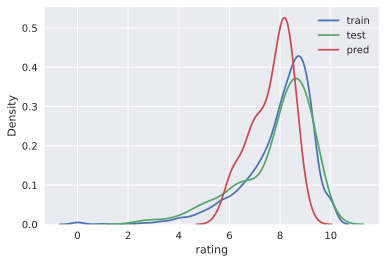

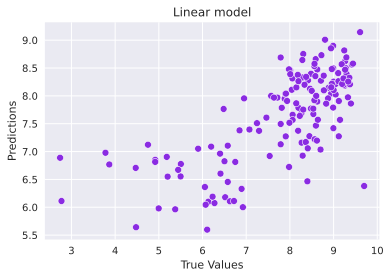

In [58]:
target_distr_linear(y_train, y_test, y_pred)

IMP: [ 5.97809374  2.80232087 12.35527776  0.49045655  0.03195352  0.46211479
  0.71027956 10.42537927  0.34951146  0.          0.          0.
  0.          0.          0.          0.          1.66722835  1.13363917
  3.00628728  0.15685699]


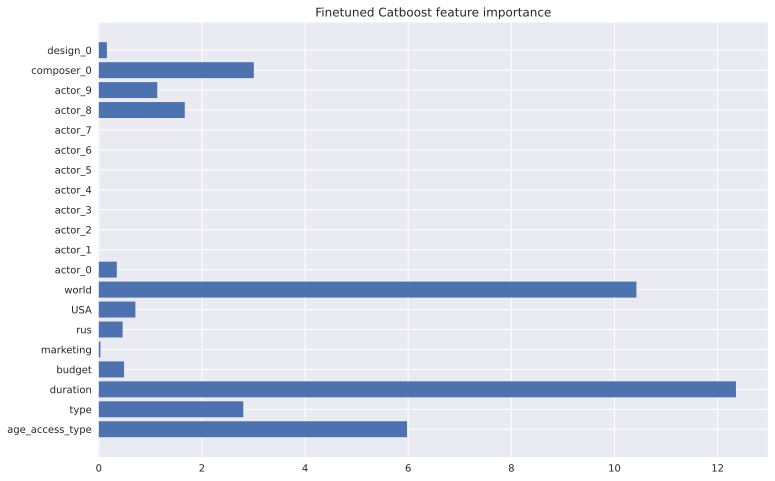

In [59]:
get_feature_imp(best_cat, train_dataset)

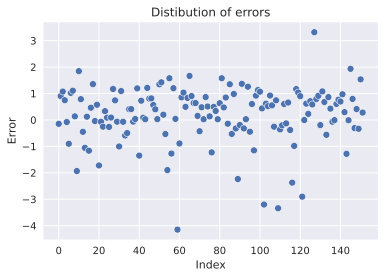

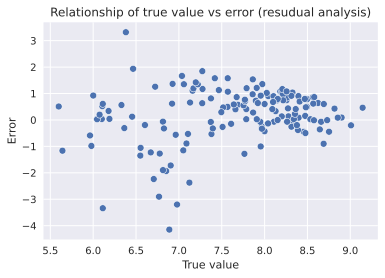

In [60]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

In [61]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.1036048303878527
RMSE:  1.0505259779690612
R2:    0.47521131826214147
MAE:   0.7861857353539315
MedAE: 0.6356834824515003
------------------------------


In [62]:
test_df['PREDS_tune'] = y_pred.tolist()
test_df

age_access_type                                           name    type  \
10457               18                               Бесконечная ночь  SERIAL   
13                   6                      Пес-самурай и город кошек   MOVIE   
10400               18                               Не оставляй меня  SERIAL   
10399               18                                           Жиза  SERIAL   
4421                16                                  Первая любовь   MOVIE   
...                ...                                            ...     ...   
4630                16                                  Взрывная игра   MOVIE   
10322               18                       На взводе: Битва за UBER  SERIAL   
7698                12                                  Тайна амулета   MOVIE   
10302               18  Власть в ночном городе. Книга четвертая: Сила  SERIAL   
10488                6                                 Истоки футбола  SERIAL   

       release_year   duration                           element_uid  budget  \
10457          2022  16.200597  952bfe32-7504-4ef5-af22-985379d8637f     NaN   
13             2022  15.534700  537ece24-2358-4108-a419-85cfd5952607     NaN   
10400          2022  17.044733  00de4f79-d52d-4d2c-871c-e6e8432cc3df     NaN   
10399          2022  16.751493  4a0406af-66ee-4180-a292-8d3b011b9938     NaN   
4421           2022  15.555977  db683fae-f747-4905-a132-38b4207f82fa     NaN   
...             ...        ...                                   ...     ...   
4630           2022  15.545395  4292d0f1-fbfb-4b4d-8c7c-d54b4b0ef6eb     NaN   
10322          2022  16.064695  fecde143-2a72-4a70-8efc-188079a62f1a     NaN   
7698           2022  15.545395  9ae35927-93e3-4a40-870f-a998abbeaa9f     NaN   
10302          2022  16.495161  2fe0e352-1706-4e22-89d2-745353650492     NaN   
10488          2022  17.518293  6dd86e60-5d6d-475d-9b46-e989ac7a30b6     NaN   

       marketing        rus  USA  ...         producer_4           writer_0  \
10457        NaN        NaN  NaN  ...         Лоран Анон        Давид Перро   
13           NaN        NaN  NaN  ...          Адам Нэгл  Роберт Бен Гарант   
10400        NaN        NaN  NaN  ...                 Na    Леонардо Фазоли   
10399        NaN        NaN  NaN  ...  Дмитрий Агневский   Александр Пронин   
4421         NaN        NaN  NaN  ...  Чарльз Артур Берг      А.Дж. Эдвардс   
...          ...        ...  ...  ...                ...                ...   
4630         NaN        NaN  NaN  ...        Гари Раскин      Леон Лангфорд   
10322        NaN        NaN  NaN  ...        Стивен Шифф  Брайан Коппельман   
7698         NaN  12.057422  NaN  ...                 Na  Ксения Набойченко   
10302        NaN        NaN  NaN  ...       Эль Трайдман         Аарон Карю   
10488        NaN        NaN  NaN  ...                 Na           Ши Чуань   

                writer_1  country_0                               genre_0  \
10457   Эммануэль Вуазен    belgium  9fa28b61-a257-4a3e-945b-a9ef76a146d6   
13           Нэйт Хоппер        usa                                Action   
10400  Маддалена Равальи      italy  364fdc2e-bdfe-40be-b2c5-d30f43ec432e   
10399                 Na     russia                                 Drama   
4421                  Na        usa                             Melodrama   
...                  ...        ...                                   ...   
4630        Коллин Уоттс        usa                              Thriller   
10322        Дэвид Левин        usa                                 Drama   
7698        Ирина Демина     russia                                Family   
10302        Кортни Кемп        usa                                 Drama   
10488                 Na      china  287a1485-7a88-4c2f-bc94-ca418b6c47a1   

                                    genre_1  genre_2     PREDS    TARGET  \
10457                                    Na       Na  7.369071  7.462687   
13                                   Comedy   F